# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
# Uncomment this cell to provide logging output to a file in addition to the lab in the browser
# This also keeps logging if the browser window is closed

# import datetime
# import logging

# nblog = open(f"/content/CryptoCrystalBall/Data/logs/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

# %autosave 60

In [3]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [4]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-04-16 06:13:22.482479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 06:13:22.560196: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 06:13:22.582454: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-16 06:13:23.055581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [5]:
from tensorflow import keras
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten, UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention, Dropout
from keras.models import Model
from keras.optimizers import Adam

In [6]:
import os
from os import listdir
from os.path import isfile, join

In [7]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random
import datetime

In [8]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [9]:
# Set the checkpoint path for saving train progress
if COLAB:
    raise NotImplementedError("Google Buckets have to be implemented in this notebook before using them in Colab!")
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [10]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

    %cd /content

In [11]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [12]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [13]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [14]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [15]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [16]:
# # Define the tick data path
# DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
# print(f"DATA_PATH: {DATA_PATH}")

In [17]:
# # Define the chart image save path
# IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
# print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

In [18]:
# Define a global random seed
RANDOM_SEED = 42

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [19]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator

# For this ML architecture, the X_BLOCK_LENGHT has to be a member of 2**n, otherwise the feature pyramid cannot be built correctly 

# X_BLOCK_LENGHT = 256
X_BLOCK_LENGHT = 128

In [20]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 384 # for X_BLOCK_LENGHT = 256
BATCH_SIZE = 512 # for X_BLOCK_LENGHT = 128

In [21]:
# A fixed number of features is used
FEATURES = 149

In [22]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [23]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the dataset

In [24]:
# Define the dataset path
DATASET_PATH = "/content/dataset/ETF/tickdata/ticks/train"

# Get all file names
TRAIN_FILES = [os.path.join(DATASET_PATH,f) for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
TRAIN_FILES = sorted(TRAIN_FILES)

print(f"The train dataset contains {len(TRAIN_FILES)} files.")
print(TRAIN_FILES[:3])

The train dataset contains 911 files.
['/content/dataset/ETF/tickdata/ticks/train/DE0002635265.csv', '/content/dataset/ETF/tickdata/ticks/train/DE0002635273.csv', '/content/dataset/ETF/tickdata/ticks/train/DE0002635281.csv']


### Not required, dataset is already prepared
---
### Split the dataset into 3 parts
- The **train** set is used to train the machine-learning network then used to predicting future information
- The **test** set is used in the next step. On it a trading (entry/exit) strategy will be developed
- The **eval** set will then be used as an never-seen set to try and evalutate the combination of the ML network and the trading strategy

In [25]:
# # It uses a fixed random seed to allow this cell to be copied to other notebooks producing the same result
# SPLIT_RANDOM_SEED = 666

# TRAIN_SET_SIZE = 0.5
# TEST_SET_SIZE = 0.25
# # EVAL_SET_SIZE: The rest

# # Files are shuffled before splitting
# random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

# train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
# print(f"train_split_index: {train_split_index}")

# test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
# print(f"test_split_index: {test_split_index}")

# TRAIN_FILES = ALL_FILES[:train_split_index]
# TEST_FILES = ALL_FILES[train_split_index:test_split_index]
# EVAL_FILES = ALL_FILES[test_split_index:]

# print(f"The train set contains {len(TRAIN_FILES)} files")
# print(f"The test set contains {len(TEST_FILES)} files")
# print(f"The eval set contains {len(EVAL_FILES)} files")

---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

As y values for training the ML network the possible future gain and it derivation will be used. The y data type `PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN` will provide both past and future gain, but the model will only be trained on the future gain, as the past gain can be easily calculated directly, also in a live application.

In [26]:
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)

Y_TYPE_DICT["gain_timespan"] = 60
# Y_TYPE_DICT["direction_ma_timespan"] = 14
# Y_TYPE_DICT["derivation_ma_timespan"] = 14

Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 60,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

In [27]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES)
XShape

(512, 128, 149)

In [28]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y'][:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [29]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-04-16 06:13:25.952747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 06:13:25.978434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 06:13:25.978570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-16 06:13:25.979334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

<PrefetchDataset element_spec=(TensorSpec(shape=(512, 128, 149), dtype=tf.float32, name=None), TensorSpec(shape=(512, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

This approach uses a FPN (Feature-Pyramid-Network, https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c) architecture, followed by LSTM and Dense regressor heads to extract the future gain information.
The pyramid elements are built in a Res-Net style to provide a good information flow.


Additionally, it is equipped with Attention layers to focus on relevant information. Futhermore, it uses antialiasing to smooth out disturbance.


```
Todo: Create Image of network structure
```

In [30]:
# Create the CreateModelFPNWithAttention model
def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttentionBiggerTimebased",
      "VERSION": "3_FutureOnly_60days",
      "CNN_INITIAL_FILTERS": 64,
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 64,
      "HEAD_DENSE_SIZE": 32
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, FEATURES), name='inputTicksAndIndicators', dtype='float32')

  # Apply dropout on the input to make the model robust
  inputTicksAndIndicators = Dropout(0.1, name='inputDropout')(inputTicksAndIndicators)

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # ----------------------------------------------------------------------------

  # A 1D-CNN pyramid is used to extract higher-level features out of the time dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_1")(source_layer)
    
    res_net_element = Activation("relu",
                              name=f"ResNet_{i}_ReLU")(res_net_element)
    
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_2")(res_net_element)
    
    res_net_element = Add(name=f"ResNet_{i}_Add")([res_net_element, source_layer])
        
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"ResNet_{i}_Feature_Conv1D_FilterDimReduction")(res_net_element)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, activation="tanh", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 64, 64)
feature_conv_attentioned.shape: (None, 64, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 32, 128)
feature_conv_attentioned.shape: (None, 32, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 256)
feature_conv_attentioned.shape: (None, 16, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 512)
feature_conv_attentioned.shape: (None, 8, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 1024)
feature_conv_attentioned.shape: (None, 4, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 2, 2048)
feature_conv_attentioned.shape: (None, 2, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 2, 256)
Building feature_

# Train the model

In [31]:
# Define the checkpoint name for storing training progress
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB'

In [32]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-03,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [33]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [34]:
#@title CustomCallback
# This method stores the model weights every `save_freq` batches, or at least at the epoch's end

class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

#       fp = os.path.join(_save_folder, "c.pickle")
#       with file_io.FileIO(fp, mode='wb+') as handle:
#         pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#       logging.info(f"Saved optimizer config to '{fp}'")

#       # Save optimizer weights
#       # w = copy.deepcopy(self.model.optimizer.get_weights())

#       fp = os.path.join(_save_folder, "w.pickle")
#       with open(fp, "wb") as handle:
#         # with file_io.FileIO(fp, mode='wb+') as handle:
#         pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
#       logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [35]:
# If the training is resumed from a previous checkpoint, these epochs can be added to keep model saving consistent
epoch_add = 0

In [36]:
# Define how often the model shall be saved
CALLBACK_EVERY_N_BATCHES = 2000

In [37]:
# Create the custom callback
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [38]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [39]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + "_" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/CryptoCrystalBall/Data/logs",log_dir.split("/")[-1])

log_dir

'/content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB_20230416061327'

In [40]:
# Create a TensorBoard callback for moniting the training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-04-16 06:13:27.284410: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-16 06:13:27.284439: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-16 06:13:27.284480: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-04-16 06:13:27.284895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-04-16 06:13:27.373057: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-16 06:13:27.373298: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [41]:
# Load previous weights if necessary
#MODEL_PATH = "/content/CryptoCrystalBall/Notebooks/etf_pastfuture_based/FPNWithAttentionBiggerTimebased_2_FutureOnly_60days_GPU_128LB/cp_daily_valid_05_end/model.h5"

#model.load_weights(MODEL_PATH)

In [42]:
# Activate the TensorBoard
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

# Start training

In [43]:
# Train for one epoch on a higher learning rate to get the model going
model.fit(tfGenTraining,
          epochs=1,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

INFO:root:File 'IE0005042456.csv' loaded, 910 left
INFO:root:File 'IE00BGL86Z12.csv' loaded, 909 left
INFO:root:File 'LU1900067601.csv' loaded, 908 left
INFO:root:File 'IE00B5NLX835.csv' loaded, 907 left
INFO:root:File 'IE0032077012.csv' loaded, 906 left
INFO:root:File 'DE000ETFL557.csv' loaded, 905 left
INFO:root:File 'LU1169821292.csv' loaded, 904 left
INFO:root:File 'DE000A0D8Q23.csv' loaded, 903 left
INFO:root:File 'IE00BYXVGX24.csv' loaded, 902 left
INFO:root:File 'IE00B0M63391.csv' loaded, 901 left
INFO:root:File 'IE00BJ5JP105.csv' loaded, 900 left
2023-04-16 06:13:47.013923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
INFO:root:File 'IE00B4KBBD01.csv' loaded, 899 left
2023-04-16 06:13:48.214436: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
INFO:root:File 'IE00B9M6SJ31.csv' loaded, 898 left


      1/Unknown - 26s 26s/step - loss: 2.7219e-05 - mae: 0.0038

INFO:root:File 'IE00BHZRQY00.csv' loaded, 897 left


      4/Unknown - 27s 281ms/step - loss: 1.6984e-04 - mae: 0.0100

2023-04-16 06:13:56.813293: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-16 06:13:56.813323: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      6/Unknown - 28s 329ms/step - loss: 1.2539e-04 - mae: 0.0084WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1006s vs `on_train_batch_end` time: 0.1476s). Check your callbacks.


      8/Unknown - 29s 296ms/step - loss: 1.0291e-04 - mae: 0.0076

INFO:root:File 'FR0010429068.csv' loaded, 896 left


     29/Unknown - 34s 283ms/step - loss: 4.9487e-05 - mae: 0.0047

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 895 left


     31/Unknown - 35s 292ms/step - loss: 4.7556e-05 - mae: 0.0046

INFO:root:File 'FR0011720911.csv' loaded, 894 left


     44/Unknown - 39s 285ms/step - loss: 3.8947e-05 - mae: 0.0041

INFO:root:File 'LU2008763935.csv' loaded, 893 left


     48/Unknown - 40s 283ms/step - loss: 3.6467e-05 - mae: 0.0040

INFO:root:File 'LU0446734872.csv' loaded, 892 left


     49/Unknown - 40s 283ms/step - loss: 3.6264e-05 - mae: 0.0039

INFO:root:File 'IE00B1FZS244.csv' loaded, 891 left


     53/Unknown - 44s 330ms/step - loss: 3.4652e-05 - mae: 0.0039

INFO:root:File 'LU0446734369.csv' loaded, 890 left


     54/Unknown - 44s 330ms/step - loss: 3.4216e-05 - mae: 0.0038

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 889 left


     65/Unknown - 48s 344ms/step - loss: 3.1073e-05 - mae: 0.0036

INFO:root:File 'LU1681038599.csv' loaded, 888 left


     69/Unknown - 50s 353ms/step - loss: 3.0060e-05 - mae: 0.0036

INFO:root:File 'IE00BCRY6557.csv' loaded, 887 left


     84/Unknown - 55s 338ms/step - loss: 2.6874e-05 - mae: 0.0034

INFO:root:File 'IE00BK5BQZ41.csv' loaded, 886 left


     85/Unknown - 55s 338ms/step - loss: 2.6835e-05 - mae: 0.0034

INFO:root:File 'IE00BFTWP510.csv' loaded, 885 left


     89/Unknown - 57s 341ms/step - loss: 2.6219e-05 - mae: 0.0033

INFO:root:File 'LU1681046931.csv' loaded, 884 left


     99/Unknown - 61s 348ms/step - loss: 2.4769e-05 - mae: 0.0032

2023-04-16 06:14:30.248859: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-04-16 06:14:30.251707: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-04-16 06:14:30.564579: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 487969 callback api events and 490360 activity events. 
2023-04-16 06:14:34.474398: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-16 06:14:38.260713: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB_20230416061327/plugins/profile/2023_04_16_06_14_34

2023-04-16 06:14:42.121117: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_3_FutureOnly_60day

    101/Unknown - 76s 498ms/step - loss: 2.4481e-05 - mae: 0.0032

INFO:root:File 'IE00BF2GFH28.csv' loaded, 883 left


    108/Unknown - 78s 482ms/step - loss: 2.3471e-05 - mae: 0.0032

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 882 left


    110/Unknown - 80s 488ms/step - loss: 2.3167e-05 - mae: 0.0031

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 881 left


    111/Unknown - 81s 495ms/step - loss: 2.3044e-05 - mae: 0.0031

INFO:root:File 'IE00B3B8Q275.csv' loaded, 880 left


    115/Unknown - 83s 497ms/step - loss: 2.2601e-05 - mae: 0.0031

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 879 left


    121/Unknown - 85s 485ms/step - loss: 2.1877e-05 - mae: 0.0031

INFO:root:File 'IE00B87G8S03.csv' loaded, 878 left


    122/Unknown - 85s 483ms/step - loss: 2.1742e-05 - mae: 0.0031

INFO:root:File 'DE000A0D8Q31.csv' loaded, 877 left


    123/Unknown - 88s 500ms/step - loss: 2.1628e-05 - mae: 0.0030

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 876 left


    127/Unknown - 89s 499ms/step - loss: 9.5601e-04 - mae: 0.0040

INFO:root:File 'LU1598688189.csv' loaded, 875 left


    165/Unknown - 99s 441ms/step - loss: 8.1506e-04 - mae: 0.0038

INFO:root:File 'LU1861138961.csv' loaded in retry loop, 874 left


    166/Unknown - 99s 440ms/step - loss: 8.1018e-04 - mae: 0.0038

INFO:root:File 'IE00BSPLC298.csv' loaded, 873 left


    168/Unknown - 100s 442ms/step - loss: 8.0059e-04 - mae: 0.0038

INFO:root:File 'IE00BJK9HH50.csv' loaded, 872 left


    172/Unknown - 101s 437ms/step - loss: 7.8217e-04 - mae: 0.0038

INFO:root:File 'DE000ETF9090.csv' loaded, 871 left


    174/Unknown - 102s 435ms/step - loss: 7.7325e-04 - mae: 0.0037

INFO:root:File 'IE00BKVL7D31.csv' loaded, 870 left


    175/Unknown - 102s 435ms/step - loss: 7.6885e-04 - mae: 0.0037

INFO:root:File 'LU0721553864.csv' loaded, 869 left


    177/Unknown - 103s 432ms/step - loss: 7.6022e-04 - mae: 0.0037

INFO:root:File 'IE00BJP26D89.csv' loaded, 868 left


    178/Unknown - 104s 438ms/step - loss: 7.5599e-04 - mae: 0.0037

INFO:root:File 'LU1079842321.csv' loaded, 867 left


    180/Unknown - 105s 439ms/step - loss: 7.4766e-04 - mae: 0.0037

INFO:root:File 'LU1681041205.csv' loaded, 866 left


    183/Unknown - 107s 441ms/step - loss: 7.3551e-04 - mae: 0.0036

INFO:root:File 'IE00B3YCGJ38.csv' loaded, 865 left


    189/Unknown - 109s 440ms/step - loss: 7.1238e-04 - mae: 0.0036

INFO:root:File 'LU0908501215.csv' loaded, 864 left


    197/Unknown - 112s 435ms/step - loss: 6.8371e-04 - mae: 0.0035

INFO:root:File 'IE00BVGC6645.csv' loaded, 863 left


    206/Unknown - 114s 428ms/step - loss: 6.5417e-04 - mae: 0.0035

INFO:root:File 'IE00BWBXM500.csv' loaded, 862 left


    207/Unknown - 115s 430ms/step - loss: 6.5104e-04 - mae: 0.0034

INFO:root:File 'IE00B53L4X51.csv' loaded, 861 left


    215/Unknown - 118s 428ms/step - loss: 6.2707e-04 - mae: 0.0034

INFO:root:File 'LU1805389258.csv' loaded, 860 left


    223/Unknown - 120s 421ms/step - loss: 6.0482e-04 - mae: 0.0033

INFO:root:File 'IE00BKSBGS44.csv' loaded, 859 left


    225/Unknown - 121s 420ms/step - loss: 5.9948e-04 - mae: 0.0033

INFO:root:File 'LU2082998324.csv' loaded, 858 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082998324.csv', starting with completely new batch blocks


    226/Unknown - 121s 419ms/step - loss: 5.9692e-04 - mae: 0.0033

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 857 left


    228/Unknown - 121s 418ms/step - loss: 5.9173e-04 - mae: 0.0033

INFO:root:File 'LU1737653045.csv' loaded, 856 left


    230/Unknown - 122s 417ms/step - loss: 5.8668e-04 - mae: 0.0033

INFO:root:File 'LU0192223062.csv' loaded, 855 left


    231/Unknown - 124s 424ms/step - loss: 5.8417e-04 - mae: 0.0033

INFO:root:File 'LU2198883410.csv' loaded, 854 left


    232/Unknown - 124s 424ms/step - loss: 5.8171e-04 - mae: 0.0033

INFO:root:File 'LU1829219390.csv' loaded in retry loop, 853 left


    234/Unknown - 125s 425ms/step - loss: 5.7680e-04 - mae: 0.0033

INFO:root:File 'IE00B3F81G20.csv' loaded, 852 left


    236/Unknown - 126s 423ms/step - loss: 5.7199e-04 - mae: 0.0033

INFO:root:File 'IE00B5V94313.csv' loaded, 851 left


    239/Unknown - 129s 429ms/step - loss: 5.6490e-04 - mae: 0.0033

INFO:root:File 'IE00BF4G6Y48.csv' loaded, 850 left


    243/Unknown - 130s 427ms/step - loss: 5.5570e-04 - mae: 0.0032

INFO:root:File 'IE00BYVJRP78.csv' loaded, 849 left


    246/Unknown - 131s 426ms/step - loss: 5.4909e-04 - mae: 0.0032

INFO:root:File 'IE00B8CJW150.csv' loaded, 848 left


    249/Unknown - 132s 427ms/step - loss: 5.4257e-04 - mae: 0.0032

INFO:root:File 'DE0006289382.csv' loaded, 847 left


    261/Unknown - 137s 424ms/step - loss: 5.1801e-04 - mae: 0.0032

INFO:root:File 'IE00B53L3W79.csv' loaded, 846 left


    266/Unknown - 139s 424ms/step - loss: 5.0846e-04 - mae: 0.0032

INFO:root:File 'LU1681040496.csv' loaded, 845 left


    267/Unknown - 139s 423ms/step - loss: 5.0659e-04 - mae: 0.0031

INFO:root:File 'IE00BD1F4K20.csv' loaded, 844 left


    278/Unknown - 143s 419ms/step - loss: 4.8691e-04 - mae: 0.0031

INFO:root:File 'IE00BWBXM385.csv' loaded, 843 left


    284/Unknown - 144s 417ms/step - loss: 4.7679e-04 - mae: 0.0031

INFO:root:File 'IE00BCLWRG39.csv' loaded, 842 left


    288/Unknown - 146s 417ms/step - loss: 4.7033e-04 - mae: 0.0031

INFO:root:File 'FR0010655712.csv' loaded, 841 left


    295/Unknown - 149s 416ms/step - loss: 4.5951e-04 - mae: 0.0031

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 840 left


    306/Unknown - 152s 410ms/step - loss: 4.4340e-04 - mae: 0.0030

INFO:root:File 'IE00BHZPJ676.csv' loaded, 839 left


    307/Unknown - 152s 410ms/step - loss: 4.4198e-04 - mae: 0.0030

INFO:root:File 'IE00BG11HV38.csv' loaded, 838 left


    314/Unknown - 154s 407ms/step - loss: 4.3437e-04 - mae: 0.0030

INFO:root:File 'IE00BKVL7331.csv' loaded, 837 left


    315/Unknown - 154s 406ms/step - loss: 4.3305e-04 - mae: 0.0030

INFO:root:File 'LU1681040223.csv' loaded, 836 left


    316/Unknown - 155s 409ms/step - loss: 4.3176e-04 - mae: 0.0030

INFO:root:File 'DE000A0H08F7.csv' loaded, 835 left


    318/Unknown - 158s 414ms/step - loss: 4.2912e-04 - mae: 0.0030

INFO:root:File 'IE00B44Z5B48.csv' loaded, 834 left


    320/Unknown - 159s 417ms/step - loss: 4.2650e-04 - mae: 0.0030

INFO:root:File 'FR0010261198.csv' loaded, 833 left


    323/Unknown - 162s 420ms/step - loss: 4.2270e-04 - mae: 0.0030

INFO:root:File 'IE00BSPLC413.csv' loaded, 832 left


    325/Unknown - 163s 420ms/step - loss: 4.2015e-04 - mae: 0.0030

INFO:root:File 'LU1852212965.csv' loaded, 831 left


    333/Unknown - 164s 416ms/step - loss: 4.1021e-04 - mae: 0.0030

INFO:root:File 'DE0002635273.csv' loaded, 830 left


    353/Unknown - 170s 408ms/step - loss: 3.8727e-04 - mae: 0.0029

INFO:root:File 'IE00BF4G7076.csv' loaded, 829 left


    354/Unknown - 171s 409ms/step - loss: 3.8619e-04 - mae: 0.0029

INFO:root:File 'IE00BWBXM492.csv' loaded in retry loop, 828 left


    356/Unknown - 172s 409ms/step - loss: 3.8406e-04 - mae: 0.0029

INFO:root:File 'IE0031442068.csv' loaded, 827 left


    363/Unknown - 175s 411ms/step - loss: 3.7678e-04 - mae: 0.0029

INFO:root:File 'LU1681038912.csv' loaded, 826 left


    369/Unknown - 177s 410ms/step - loss: 3.7077e-04 - mae: 0.0029

INFO:root:File 'LU1753045928.csv' loaded, 825 left


    376/Unknown - 179s 407ms/step - loss: 3.6398e-04 - mae: 0.0029

INFO:root:File 'IE00BJQRDK83.csv' loaded, 824 left


    383/Unknown - 181s 404ms/step - loss: 3.5748e-04 - mae: 0.0028

INFO:root:File 'LU1215415214.csv' loaded, 823 left


    384/Unknown - 182s 405ms/step - loss: 3.5659e-04 - mae: 0.0028

INFO:root:File 'IE00BFNM3B99.csv' loaded, 822 left


    385/Unknown - 182s 405ms/step - loss: 3.5573e-04 - mae: 0.0028

INFO:root:File 'LU1407888053.csv' loaded, 821 left


    393/Unknown - 184s 403ms/step - loss: 3.4872e-04 - mae: 0.0028

INFO:root:File 'IE00BRKWGL70.csv' loaded, 820 left


    396/Unknown - 186s 403ms/step - loss: 3.4612e-04 - mae: 0.0028

INFO:root:File 'IE00B3CNHG25.csv' loaded, 819 left


    402/Unknown - 188s 403ms/step - loss: 3.4107e-04 - mae: 0.0028

INFO:root:File 'IE00B449XP68.csv' loaded, 818 left


    408/Unknown - 190s 403ms/step - loss: 3.3615e-04 - mae: 0.0028

INFO:root:File 'IE00B5MTZM66.csv' loaded, 817 left


    413/Unknown - 193s 403ms/step - loss: 3.3221e-04 - mae: 0.0028

INFO:root:File 'LU1708330235.csv' loaded, 816 left


    420/Unknown - 195s 401ms/step - loss: 3.2688e-04 - mae: 0.0028

INFO:root:File 'NL0010273801.csv' loaded, 815 left


    421/Unknown - 195s 402ms/step - loss: 3.2613e-04 - mae: 0.0028

INFO:root:File 'IE00BHZPJ783.csv' loaded, 814 left


    426/Unknown - 197s 401ms/step - loss: 3.2238e-04 - mae: 0.0028

INFO:root:File 'IE00BHZRR147.csv' loaded, 813 left


    429/Unknown - 198s 400ms/step - loss: 3.2018e-04 - mae: 0.0028

INFO:root:File 'LU1377382368.csv' loaded, 812 left


    430/Unknown - 198s 401ms/step - loss: 3.1945e-04 - mae: 0.0028

INFO:root:File 'IE00B5L8K969.csv' loaded, 811 left


    433/Unknown - 200s 402ms/step - loss: 3.1732e-04 - mae: 0.0028

INFO:root:File 'LU1190417599.csv' loaded, 810 left


    448/Unknown - 204s 397ms/step - loss: 3.0699e-04 - mae: 0.0027

INFO:root:File 'IE00B6YX5C33.csv' loaded, 809 left


    461/Unknown - 207s 393ms/step - loss: 2.9861e-04 - mae: 0.0027

INFO:root:File 'LU1327051279.csv' loaded, 808 left


    463/Unknown - 209s 394ms/step - loss: 2.9741e-04 - mae: 0.0027

INFO:root:File 'LU1291101555.csv' loaded, 807 left


    464/Unknown - 209s 395ms/step - loss: 2.9679e-04 - mae: 0.0027

INFO:root:File 'LU1598689153.csv' loaded, 806 left


    466/Unknown - 211s 397ms/step - loss: 2.9558e-04 - mae: 0.0027

INFO:root:File 'IE00BCLWRD08.csv' loaded, 805 left


    467/Unknown - 212s 397ms/step - loss: 2.9498e-04 - mae: 0.0027

INFO:root:File 'DE000ETF7011.csv' loaded, 804 left


    472/Unknown - 214s 398ms/step - loss: 0.0102 - mae: 0.0038

INFO:root:File 'LU1681043599.csv' loaded, 803 left


    487/Unknown - 218s 394ms/step - loss: 0.0135 - mae: 0.0045

INFO:root:File 'IE00B4L5YC18.csv' loaded, 802 left


    489/Unknown - 220s 396ms/step - loss: 0.0150 - mae: 0.0047

INFO:root:File 'LU1650492256.csv' loaded, 801 left


    490/Unknown - 220s 397ms/step - loss: 0.0236 - mae: 0.0056

INFO:root:File 'IE00B3XM3R14.csv' loaded, 800 left


    491/Unknown - 221s 397ms/step - loss: 0.0236 - mae: 0.0058

INFO:root:File 'IE00BF20LF40.csv' loaded, 799 left


    496/Unknown - 223s 398ms/step - loss: 0.0235 - mae: 0.0064

INFO:root:File 'IE00BK5BR626.csv' loaded, 798 left


    501/Unknown - 225s 396ms/step - loss: 0.0233 - mae: 0.0064

INFO:root:File 'DE000A0H08M3.csv' loaded, 797 left


    504/Unknown - 227s 399ms/step - loss: 0.0231 - mae: 0.0064

INFO:root:File 'IE00B2QWCY14.csv' loaded, 796 left


    508/Unknown - 229s 400ms/step - loss: 0.0229 - mae: 0.0064

INFO:root:File 'DE0006289390.csv' loaded, 795 left


    524/Unknown - 235s 398ms/step - loss: 0.0222 - mae: 0.0063

INFO:root:File 'DE000ETFL201.csv' loaded, 794 left


    535/Unknown - 238s 396ms/step - loss: 0.0218 - mae: 0.0063

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 793 left


    549/Unknown - 242s 392ms/step - loss: 0.0212 - mae: 0.0062

INFO:root:File 'LU2082997516.csv' loaded, 792 left


    550/Unknown - 242s 392ms/step - loss: 0.0212 - mae: 0.0061

INFO:root:File 'IE00B14X4S71.csv' loaded, 791 left


    551/Unknown - 244s 395ms/step - loss: 0.0212 - mae: 0.0061

INFO:root:File 'LU0252633754.csv' loaded, 790 left


    554/Unknown - 246s 396ms/step - loss: 0.0210 - mae: 0.0061

INFO:root:File 'IE00BJK9H753.csv' loaded, 789 left


    560/Unknown - 247s 394ms/step - loss: 0.0208 - mae: 0.0061

INFO:root:File 'DE000ETFL037.csv' loaded, 788 left


    568/Unknown - 250s 394ms/step - loss: 0.0205 - mae: 0.0060

INFO:root:File 'IE00B1FZSB30.csv' loaded, 787 left


    574/Unknown - 253s 395ms/step - loss: 0.0203 - mae: 0.0060

INFO:root:File 'IE00BKM4H197.csv' loaded, 786 left


    590/Unknown - 257s 391ms/step - loss: 0.0198 - mae: 0.0059

INFO:root:File 'IE00BYTRRB94.csv' loaded, 785 left


    604/Unknown - 260s 388ms/step - loss: 0.0193 - mae: 0.0058

INFO:root:File 'IE00BF4NQ904.csv' loaded, 784 left


    609/Unknown - 262s 387ms/step - loss: 0.0191 - mae: 0.0058

INFO:root:File 'LU0629460089.csv' loaded, 783 left


    614/Unknown - 264s 387ms/step - loss: 0.0190 - mae: 0.0057

INFO:root:File 'IE00BFXR5S54.csv' loaded, 782 left


    616/Unknown - 264s 387ms/step - loss: 0.0189 - mae: 0.0057

INFO:root:File 'IE00B6R52143.csv' loaded, 781 left


    617/Unknown - 266s 388ms/step - loss: 0.0189 - mae: 0.0057

INFO:root:File 'IE00BF1QPL78.csv' loaded, 780 left


    625/Unknown - 268s 387ms/step - loss: 0.0187 - mae: 0.0057

INFO:root:File 'LU1681039134.csv' loaded, 779 left


    630/Unknown - 269s 386ms/step - loss: 0.0185 - mae: 0.0056

INFO:root:File 'IE00BK5BQT80.csv' loaded, 778 left


    631/Unknown - 270s 386ms/step - loss: 0.0185 - mae: 0.0056

INFO:root:File 'IE00B4X9L533.csv' loaded, 777 left


    633/Unknown - 271s 387ms/step - loss: 0.0184 - mae: 0.0056

INFO:root:File 'LU1681045024.csv' loaded, 776 left


    634/Unknown - 272s 389ms/step - loss: 0.0184 - mae: 0.0056

INFO:root:File 'DE000A0F5UH1.csv' loaded, 775 left


    638/Unknown - 275s 390ms/step - loss: 0.0183 - mae: 0.0056

INFO:root:File 'IE00B1FZS681.csv' loaded, 774 left


    646/Unknown - 278s 389ms/step - loss: 0.0180 - mae: 0.0055

INFO:root:File 'IE00B441G979.csv' loaded, 773 left


    655/Unknown - 281s 389ms/step - loss: 0.0178 - mae: 0.0055

INFO:root:File 'DE000A0H08D2.csv' loaded, 772 left


    661/Unknown - 283s 389ms/step - loss: 0.0176 - mae: 0.0055

INFO:root:File 'DE000A0Q4R28.csv' loaded, 771 left


    667/Unknown - 286s 390ms/step - loss: 0.0175 - mae: 0.0054

INFO:root:File 'IE00BKPTXQ89.csv' loaded, 770 left


    668/Unknown - 287s 390ms/step - loss: 0.0175 - mae: 0.0054

INFO:root:File 'IE00BFNM3H51.csv' loaded, 769 left


    678/Unknown - 289s 388ms/step - loss: 0.0172 - mae: 0.0054

INFO:root:File 'IE00BWTN6Y99.csv' loaded, 768 left


    685/Unknown - 291s 387ms/step - loss: 0.0170 - mae: 0.0053

INFO:root:File 'LU1390062245.csv' loaded, 767 left


    686/Unknown - 292s 387ms/step - loss: 0.0170 - mae: 0.0053

INFO:root:File 'FR0011660927.csv' loaded, 766 left


    693/Unknown - 294s 387ms/step - loss: 0.0168 - mae: 0.0053

INFO:root:File 'LU0832436512.csv' loaded, 765 left


    703/Unknown - 297s 386ms/step - loss: 0.0166 - mae: 0.0053

INFO:root:File 'LU1377382285.csv' loaded, 764 left


    708/Unknown - 299s 385ms/step - loss: 0.0165 - mae: 0.0052

INFO:root:File 'IE00BQ70R696.csv' loaded, 763 left


    710/Unknown - 300s 386ms/step - loss: 0.0164 - mae: 0.0052

INFO:root:File 'LU1437018598.csv' loaded, 762 left


    715/Unknown - 301s 385ms/step - loss: 0.0163 - mae: 0.0052

INFO:root:File 'IE00BYXPXK00.csv' loaded, 761 left


    724/Unknown - 304s 383ms/step - loss: 0.0161 - mae: 0.0052

INFO:root:File 'LU1686832194.csv' loaded, 760 left


    727/Unknown - 305s 384ms/step - loss: 0.0160 - mae: 0.0052

INFO:root:File 'LU0136234068.csv' loaded, 759 left


    731/Unknown - 308s 385ms/step - loss: 0.0159 - mae: 0.0051

INFO:root:File 'DE0002635307.csv' loaded, 758 left


    734/Unknown - 310s 387ms/step - loss: 0.0159 - mae: 0.0051

INFO:root:File 'IE00B4L5YX21.csv' loaded, 757 left


    736/Unknown - 312s 388ms/step - loss: 0.0158 - mae: 0.0051

INFO:root:File 'LU1681038672.csv' loaded, 756 left


    738/Unknown - 313s 389ms/step - loss: 0.0158 - mae: 0.0051

INFO:root:File 'IE00BF59RV63.csv' loaded, 755 left


    742/Unknown - 314s 388ms/step - loss: 0.0157 - mae: 0.0051

INFO:root:File 'IE00BF4RFH31.csv' loaded, 754 left


    748/Unknown - 316s 387ms/step - loss: 0.0156 - mae: 0.0051

INFO:root:File 'IE00B459R192.csv' loaded, 753 left


    755/Unknown - 318s 387ms/step - loss: 0.0154 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 752 left


    756/Unknown - 320s 389ms/step - loss: 0.0154 - mae: 0.0051

INFO:root:File 'IE00BQQP9H09.csv' loaded, 751 left


    764/Unknown - 322s 388ms/step - loss: 0.0153 - mae: 0.0051

INFO:root:File 'IE00BHZRR030.csv' loaded, 750 left


    771/Unknown - 324s 386ms/step - loss: 0.0151 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 749 left


    772/Unknown - 324s 386ms/step - loss: 0.0151 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 748 left


    775/Unknown - 325s 386ms/step - loss: 0.0150 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded in retry loop, 747 left


    783/Unknown - 328s 385ms/step - loss: 0.0149 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 746 left


    794/Unknown - 331s 384ms/step - loss: 0.0147 - mae: 0.0049

INFO:root:File 'IE00BWBXM278.csv' loaded, 745 left


    796/Unknown - 332s 384ms/step - loss: 0.0147 - mae: 0.0049

INFO:root:File 'FR0011550185.csv' loaded, 744 left


    797/Unknown - 333s 385ms/step - loss: 0.0146 - mae: 0.0049

INFO:root:File 'LU1437016543.csv' loaded, 743 left


    801/Unknown - 334s 385ms/step - loss: 0.0146 - mae: 0.0049

INFO:root:File 'LU1900065811.csv' loaded, 742 left


    819/Unknown - 339s 382ms/step - loss: 0.0142 - mae: 0.0049

INFO:root:File 'LU2082997789.csv' loaded, 741 left


    820/Unknown - 339s 382ms/step - loss: 0.0142 - mae: 0.0049

INFO:root:Caught StopIteration in filling missing values for 'LU2082997789.csv', starting with completely new batch blocks
INFO:root:File 'LU1681040736.csv' loaded, 740 left


    823/Unknown - 341s 383ms/step - loss: 0.0142 - mae: 0.0048

INFO:root:File 'LU0392494562.csv' loaded, 739 left


    824/Unknown - 341s 383ms/step - loss: 0.0142 - mae: 0.0048

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 738 left


    826/Unknown - 344s 385ms/step - loss: 0.0141 - mae: 0.0048

INFO:root:File 'IE00BMW3QX54.csv' loaded, 737 left


    835/Unknown - 347s 384ms/step - loss: 0.0140 - mae: 0.0048

INFO:root:File 'DE000A0H08G5.csv' loaded, 736 left


    837/Unknown - 349s 385ms/step - loss: 0.0139 - mae: 0.0048

INFO:root:File 'IE00BKX55S42.csv' loaded, 735 left


    844/Unknown - 351s 385ms/step - loss: 0.0138 - mae: 0.0048

INFO:root:File 'IE00B3B8PX14.csv' loaded in retry loop, 734 left


    853/Unknown - 354s 385ms/step - loss: 0.0137 - mae: 0.0047

INFO:root:File 'LU1079841273.csv' loaded, 733 left


    859/Unknown - 356s 384ms/step - loss: 0.0136 - mae: 0.0047

INFO:root:File 'IE00B53L4350.csv' loaded, 732 left


    870/Unknown - 360s 383ms/step - loss: 0.0134 - mae: 0.0047

INFO:root:File 'FR0010424135.csv' loaded, 731 left


    872/Unknown - 361s 385ms/step - loss: 0.0134 - mae: 0.0047

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 730 left


    877/Unknown - 363s 384ms/step - loss: 0.0133 - mae: 0.0047

INFO:root:File 'LU1981859819.csv' loaded, 729 left


    882/Unknown - 364s 384ms/step - loss: 0.0132 - mae: 0.0046

INFO:root:File 'IE00BSJCQV56.csv' loaded, 728 left


    883/Unknown - 365s 384ms/step - loss: 0.0132 - mae: 0.0046

INFO:root:File 'LU1681038243.csv' loaded, 727 left


    890/Unknown - 368s 384ms/step - loss: 0.0131 - mae: 0.0046

INFO:root:File 'LU0147308422.csv' loaded, 726 left


    900/Unknown - 372s 384ms/step - loss: 0.0130 - mae: 0.0046

INFO:root:File 'LU1829218319.csv' loaded, 725 left


    911/Unknown - 375s 383ms/step - loss: 0.0128 - mae: 0.0046

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 724 left


    912/Unknown - 376s 383ms/step - loss: 0.0128 - mae: 0.0046

INFO:root:File 'LU1753045415.csv' loaded, 723 left


    919/Unknown - 377s 382ms/step - loss: 0.0127 - mae: 0.0045

INFO:root:File 'LU1829219713.csv' loaded, 722 left


    926/Unknown - 380s 382ms/step - loss: 0.0126 - mae: 0.0045

INFO:root:File 'LU2109786827.csv' loaded, 721 left


    928/Unknown - 380s 382ms/step - loss: 0.0126 - mae: 0.0045

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 720 left


    929/Unknown - 381s 382ms/step - loss: 0.0126 - mae: 0.0045

INFO:root:File 'IE00BKSBGT50.csv' loaded, 719 left


    932/Unknown - 382s 382ms/step - loss: 0.0125 - mae: 0.0045

INFO:root:File 'IE00BD1F4M44.csv' loaded, 718 left


    933/Unknown - 382s 382ms/step - loss: 0.0125 - mae: 0.0045

INFO:root:File 'IE00BJK9H860.csv' loaded, 717 left


    938/Unknown - 384s 381ms/step - loss: 0.0124 - mae: 0.0045

INFO:root:File 'LU1452600270.csv' loaded, 716 left


    940/Unknown - 385s 382ms/step - loss: 0.0124 - mae: 0.0045

INFO:root:File 'LU1940199711.csv' loaded, 715 left


    941/Unknown - 385s 382ms/step - loss: 0.0124 - mae: 0.0045

INFO:root:File 'IE00B4MKCJ84.csv' loaded, 714 left


    946/Unknown - 387s 381ms/step - loss: 0.0123 - mae: 0.0045

INFO:root:File 'IE00BF2B0P08.csv' loaded, 713 left


    949/Unknown - 388s 381ms/step - loss: 0.0123 - mae: 0.0045

INFO:root:File 'IE00BF16M727.csv' loaded, 712 left


    951/Unknown - 388s 381ms/step - loss: 0.0123 - mae: 0.0045

INFO:root:File 'IE00B60SX394.csv' loaded, 711 left


    953/Unknown - 390s 382ms/step - loss: 0.0123 - mae: 0.0045

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 710 left


    954/Unknown - 390s 382ms/step - loss: 0.0122 - mae: 0.0045

INFO:root:File 'IE00BYZTVV78.csv' loaded, 709 left


    960/Unknown - 393s 382ms/step - loss: 0.0122 - mae: 0.0045

INFO:root:File 'IE00B5MTWD60.csv' loaded, 708 left


    962/Unknown - 394s 383ms/step - loss: 0.0122 - mae: 0.0045

INFO:root:File 'IE00BDDRDW15.csv' loaded, 707 left


    964/Unknown - 395s 383ms/step - loss: 0.0121 - mae: 0.0045

INFO:root:File 'LU1691909508.csv' loaded, 706 left


    969/Unknown - 397s 382ms/step - loss: 0.0121 - mae: 0.0045

INFO:root:File 'IE00BFNM3M05.csv' loaded, 705 left


    972/Unknown - 397s 382ms/step - loss: 0.0120 - mae: 0.0045

INFO:root:File 'LU0252634307.csv' loaded, 704 left


    979/Unknown - 400s 382ms/step - loss: 0.0119 - mae: 0.0045

INFO:root:File 'IE00B8GF1M35.csv' loaded, 703 left


    980/Unknown - 402s 383ms/step - loss: 0.0119 - mae: 0.0045

INFO:root:File 'LU0629460832.csv' loaded, 702 left


    982/Unknown - 403s 384ms/step - loss: 0.0119 - mae: 0.0045

INFO:root:File 'LU1287023185.csv' loaded, 701 left


    983/Unknown - 404s 385ms/step - loss: 0.0119 - mae: 0.0045

INFO:root:File 'IE00B52MJY50.csv' loaded, 700 left


    993/Unknown - 408s 384ms/step - loss: 0.0118 - mae: 0.0044

INFO:root:File 'LU1659681669.csv' loaded, 699 left


   1009/Unknown - 411s 382ms/step - loss: 0.0117 - mae: 0.0046

INFO:root:File 'LU2082999215.csv' loaded, 698 left


   1010/Unknown - 412s 382ms/step - loss: 0.0117 - mae: 0.0046

INFO:root:File 'IE00BF0M6N54.csv' loaded, 697 left


   1016/Unknown - 413s 381ms/step - loss: 0.0117 - mae: 0.0046

INFO:root:File 'LU0603940916.csv' loaded, 696 left


   1024/Unknown - 416s 381ms/step - loss: 0.0116 - mae: 0.0046

INFO:root:File 'IE00BYX2JD69.csv' loaded, 695 left


   1025/Unknown - 416s 381ms/step - loss: 0.0116 - mae: 0.0046

INFO:root:File 'LU1681042864.csv' loaded, 694 left


   1026/Unknown - 417s 381ms/step - loss: 0.0115 - mae: 0.0046

INFO:root:File 'IE00B52MJD48.csv' loaded, 693 left


   1031/Unknown - 420s 382ms/step - loss: 0.0115 - mae: 0.0046

INFO:root:File 'LU0959210278.csv' loaded, 692 left


   1040/Unknown - 423s 381ms/step - loss: 0.0114 - mae: 0.0046

INFO:root:File 'IE00B02KXM00.csv' loaded, 691 left


   1042/Unknown - 425s 383ms/step - loss: 0.0114 - mae: 0.0046

INFO:root:File 'IE00BKLWY790.csv' loaded, 690 left


   1044/Unknown - 425s 382ms/step - loss: 0.0113 - mae: 0.0046

INFO:root:File 'IE00BH4GPZ28.csv' loaded, 689 left


   1047/Unknown - 426s 382ms/step - loss: 0.0113 - mae: 0.0046

INFO:root:File 'LU1563454823.csv' loaded, 688 left


   1049/Unknown - 427s 382ms/step - loss: 0.0113 - mae: 0.0046

INFO:root:File 'IE00B5MTYL84.csv' loaded, 687 left


   1053/Unknown - 429s 383ms/step - loss: 0.0112 - mae: 0.0046

INFO:root:File 'IE00BKVL7778.csv' loaded, 686 left


   1055/Unknown - 430s 382ms/step - loss: 0.0112 - mae: 0.0046

INFO:root:File 'LU2082995908.csv' loaded, 685 left


   1056/Unknown - 430s 382ms/step - loss: 0.0112 - mae: 0.0046

INFO:root:Caught StopIteration in filling missing values for 'LU2082995908.csv', starting with completely new batch blocks
INFO:root:File 'IE00BF3N7102.csv' loaded, 684 left


   1061/Unknown - 431s 382ms/step - loss: 0.0112 - mae: 0.0045

INFO:root:File 'LU0959211243.csv' loaded, 683 left


   1069/Unknown - 434s 381ms/step - loss: 0.0111 - mae: 0.0045

INFO:root:File 'LU1650491282.csv' loaded, 682 left


   1070/Unknown - 434s 381ms/step - loss: 0.0111 - mae: 0.0045

INFO:root:File 'IE00BYZK4776.csv' loaded, 681 left


   1071/Unknown - 436s 383ms/step - loss: 0.0111 - mae: 0.0045

INFO:root:File 'LU1812090543.csv' loaded, 680 left


   1085/Unknown - 440s 382ms/step - loss: 0.0109 - mae: 0.0045

INFO:root:File 'LU1974693662.csv' loaded, 679 left


   1090/Unknown - 441s 381ms/step - loss: 0.0109 - mae: 0.0045

INFO:root:File 'LU1804202403.csv' loaded, 678 left


   1091/Unknown - 442s 381ms/step - loss: 0.0109 - mae: 0.0045

INFO:root:File 'IE00BZCQB185.csv' loaded, 677 left


   1093/Unknown - 443s 381ms/step - loss: 0.0108 - mae: 0.0045

INFO:root:File 'IE00B4L5ZY03.csv' loaded, 676 left


   1101/Unknown - 446s 381ms/step - loss: 0.0108 - mae: 0.0045

INFO:root:File 'LU1792117696.csv' loaded, 675 left


   1103/Unknown - 446s 381ms/step - loss: 0.0107 - mae: 0.0045

INFO:root:File 'LU1681048804.csv' loaded, 674 left


   1104/Unknown - 448s 382ms/step - loss: 0.0107 - mae: 0.0045

INFO:root:File 'LU1287023003.csv' loaded, 673 left


   1112/Unknown - 451s 382ms/step - loss: 0.0107 - mae: 0.0045

INFO:root:File 'IE00BFNM3C07.csv' loaded, 672 left


   1114/Unknown - 451s 382ms/step - loss: 0.0106 - mae: 0.0045

INFO:root:File 'IE00BZ163H91.csv' loaded, 671 left


   1123/Unknown - 454s 381ms/step - loss: 0.0106 - mae: 0.0044

INFO:root:File 'IE00B14X4T88.csv' loaded, 670 left


   1126/Unknown - 456s 382ms/step - loss: 0.0105 - mae: 0.0044

INFO:root:File 'LU1681046857.csv' loaded, 669 left


   1131/Unknown - 458s 382ms/step - loss: 0.0105 - mae: 0.0044

INFO:root:File 'IE00BFWXDV39.csv' loaded, 668 left


   1140/Unknown - 460s 380ms/step - loss: 0.0104 - mae: 0.0044

INFO:root:File 'IE00B53SZB19.csv' loaded, 667 left


   1142/Unknown - 461s 381ms/step - loss: 0.0104 - mae: 0.0044

INFO:root:File 'IE00BGYWT403.csv' loaded in retry loop, 666 left


   1150/Unknown - 463s 380ms/step - loss: 0.0103 - mae: 0.0044

INFO:root:File 'IE00B44CGS96.csv' loaded, 665 left


   1153/Unknown - 465s 381ms/step - loss: 0.0103 - mae: 0.0044

INFO:root:File 'IE00B3VWN393.csv' loaded, 664 left


   1155/Unknown - 467s 381ms/step - loss: 0.0103 - mae: 0.0044

INFO:root:File 'IE00B0M63516.csv' loaded, 663 left


   1158/Unknown - 469s 382ms/step - loss: 0.0102 - mae: 0.0044

INFO:root:File 'IE00BFD2H405.csv' loaded, 662 left


   1161/Unknown - 470s 382ms/step - loss: 0.0102 - mae: 0.0043

INFO:root:File 'IE00B6X2VY59.csv' loaded, 661 left


   1165/Unknown - 471s 382ms/step - loss: 0.0102 - mae: 0.0043

INFO:root:File 'IE00B60SWY32.csv' loaded, 660 left


   1169/Unknown - 473s 382ms/step - loss: 0.0101 - mae: 0.0043

INFO:root:File 'IE00BYX8XC17.csv' loaded, 659 left


   1189/Unknown - 478s 380ms/step - loss: 0.0100 - mae: 0.0043

INFO:root:File 'IE00B42Z5J44.csv' loaded, 658 left


   1200/Unknown - 481s 379ms/step - loss: 0.0099 - mae: 0.0043

INFO:root:File 'LU2008760592.csv' loaded, 657 left


   1201/Unknown - 482s 379ms/step - loss: 0.0099 - mae: 0.0043

INFO:root:File 'IE00B1TXK627.csv' loaded, 656 left


   1204/Unknown - 484s 380ms/step - loss: 0.0098 - mae: 0.0043

INFO:root:File 'IE00BYX5K108.csv' loaded, 655 left


   1206/Unknown - 485s 380ms/step - loss: 0.0098 - mae: 0.0043

INFO:root:File 'LU1681039480.csv' loaded, 654 left


   1208/Unknown - 486s 381ms/step - loss: 0.0098 - mae: 0.0043

INFO:root:File 'IE00B0M63623.csv' loaded, 653 left


   1217/Unknown - 490s 381ms/step - loss: 0.0097 - mae: 0.0043

INFO:root:File 'IE00B3WMTH43.csv' loaded, 652 left


   1223/Unknown - 492s 381ms/step - loss: 0.0097 - mae: 0.0043

INFO:root:File 'IE00B99FL386.csv' loaded, 651 left


   1231/Unknown - 494s 380ms/step - loss: 0.0097 - mae: 0.0043

INFO:root:File 'IE00BJ38QD84.csv' loaded, 650 left


   1238/Unknown - 497s 380ms/step - loss: 0.0096 - mae: 0.0043

INFO:root:File 'IE00BD1F4N50.csv' loaded, 649 left


   1245/Unknown - 499s 379ms/step - loss: 0.0096 - mae: 0.0043

INFO:root:File 'LU0603942888.csv' loaded, 648 left


   1260/Unknown - 503s 378ms/step - loss: 0.0094 - mae: 0.0043

INFO:root:File 'LU1832418773.csv' loaded, 647 left


   1262/Unknown - 504s 379ms/step - loss: 0.0094 - mae: 0.0043

INFO:root:File 'LU0392495700.csv' loaded, 646 left


   1266/Unknown - 506s 379ms/step - loss: 0.0094 - mae: 0.0043

INFO:root:File 'IE00B1XNHC34.csv' loaded, 645 left


   1267/Unknown - 507s 379ms/step - loss: 0.0094 - mae: 0.0043

INFO:root:File 'IE00B1YZSC51.csv' loaded, 644 left


   1278/Unknown - 512s 380ms/step - loss: 0.0093 - mae: 0.0043

INFO:root:File 'IE00BK5BCD43.csv' loaded, 643 left


   1279/Unknown - 512s 380ms/step - loss: 0.0093 - mae: 0.0042

INFO:root:File 'LU1291104575.csv' loaded, 642 left


   1285/Unknown - 514s 380ms/step - loss: 0.0093 - mae: 0.0042

INFO:root:File 'IE00BQN1KC32.csv' loaded, 641 left


   1290/Unknown - 516s 380ms/step - loss: 0.0092 - mae: 0.0042

INFO:root:File 'LU2082996385.csv' loaded, 640 left


   1291/Unknown - 516s 380ms/step - loss: 0.0092 - mae: 0.0042

INFO:root:File 'LU1291091228.csv' loaded, 639 left


   1298/Unknown - 519s 380ms/step - loss: 0.0092 - mae: 0.0042

INFO:root:File 'IE00B23D9570.csv' loaded, 638 left


   1304/Unknown - 521s 380ms/step - loss: 0.0091 - mae: 0.0042

INFO:root:File 'IE00BFWFPY67.csv' loaded, 637 left


   1316/Unknown - 524s 379ms/step - loss: 0.0090 - mae: 0.0042

INFO:root:File 'IE00B6YX5F63.csv' loaded, 636 left


   1317/Unknown - 524s 378ms/step - loss: 0.0090 - mae: 0.0042

INFO:root:File 'IE00BYX8XD24.csv' loaded, 635 left


   1321/Unknown - 527s 379ms/step - loss: 0.0090 - mae: 0.0042

INFO:root:File 'IE00B5MTXJ97.csv' loaded, 634 left


   1329/Unknown - 530s 379ms/step - loss: 0.0090 - mae: 0.0042

INFO:root:File 'LU0392495023.csv' loaded, 633 left


   1338/Unknown - 533s 379ms/step - loss: 0.0089 - mae: 0.0042

INFO:root:File 'LU1681043086.csv' loaded, 632 left


   1341/Unknown - 535s 379ms/step - loss: 0.0089 - mae: 0.0042

INFO:root:File 'IE00BYZK4669.csv' loaded, 631 left


   1342/Unknown - 535s 379ms/step - loss: 0.0089 - mae: 0.0042

INFO:root:File 'IE00BWBXMB69.csv' loaded, 630 left


   1358/Unknown - 539s 378ms/step - loss: 0.0088 - mae: 0.0041

INFO:root:File 'LU0650624025.csv' loaded, 629 left


   1364/Unknown - 542s 378ms/step - loss: 0.0087 - mae: 0.0041

INFO:root:File 'IE00B77D4428.csv' loaded, 628 left


   1366/Unknown - 543s 378ms/step - loss: 0.0087 - mae: 0.0041

INFO:root:File 'IE00B5M4WH52.csv' loaded, 627 left


   1368/Unknown - 544s 379ms/step - loss: 0.0087 - mae: 0.0041

INFO:root:File 'IE00BHZPJ452.csv' loaded, 626 left


   1371/Unknown - 545s 379ms/step - loss: 0.0087 - mae: 0.0041

INFO:root:File 'DE000A0H08H3.csv' loaded, 625 left


   1375/Unknown - 548s 380ms/step - loss: 0.0087 - mae: 0.0041

INFO:root:File 'LU1437016972.csv' loaded, 624 left


   1384/Unknown - 550s 379ms/step - loss: 0.0086 - mae: 0.0041

INFO:root:File 'DE0005933956.csv' loaded, 623 left


   1396/Unknown - 555s 379ms/step - loss: 0.0085 - mae: 0.0041

INFO:root:File 'LU1033693638.csv' loaded, 622 left


   1397/Unknown - 556s 379ms/step - loss: 0.0085 - mae: 0.0041

INFO:root:File 'LU1681037518.csv' loaded, 621 left


   1404/Unknown - 558s 379ms/step - loss: 0.0085 - mae: 0.0041

INFO:root:File 'IE00B4613386.csv' loaded, 620 left


   1409/Unknown - 561s 379ms/step - loss: 0.0085 - mae: 0.0041

INFO:root:File 'LU1900066462.csv' loaded, 619 left


   1412/Unknown - 563s 380ms/step - loss: 0.0084 - mae: 0.0041

INFO:root:File 'IE00BFNM3D14.csv' loaded, 618 left


   1418/Unknown - 564s 379ms/step - loss: 0.0084 - mae: 0.0040

INFO:root:File 'IE00B23LNQ02.csv' loaded, 617 left


   1422/Unknown - 566s 380ms/step - loss: 0.0084 - mae: 0.0040

INFO:root:File 'DE000ETF7029.csv' loaded, 616 left


   1433/Unknown - 569s 379ms/step - loss: 0.0083 - mae: 0.0040

INFO:root:File 'IE00B0M63177.csv' loaded, 615 left


   1436/Unknown - 571s 379ms/step - loss: 0.0083 - mae: 0.0040

INFO:root:File 'IE00BYSX4846.csv' loaded, 614 left


   1452/Unknown - 575s 378ms/step - loss: 0.0082 - mae: 0.0040

INFO:root:File 'IE00BFXR5T61.csv' loaded, 613 left


   1455/Unknown - 576s 378ms/step - loss: 0.0082 - mae: 0.0040

INFO:root:File 'IE00BFY0GT14.csv' loaded, 612 left


   1457/Unknown - 576s 378ms/step - loss: 0.0082 - mae: 0.0040

INFO:root:File 'IE0008470928.csv' loaded, 611 left


   1463/Unknown - 580s 378ms/step - loss: 0.0081 - mae: 0.0040

INFO:root:File 'LU1273488715.csv' loaded, 610 left


   1464/Unknown - 580s 379ms/step - loss: 0.0081 - mae: 0.0040

INFO:root:File 'IE00B4WXJD03.csv' loaded, 609 left


   1474/Unknown - 584s 378ms/step - loss: 0.0081 - mae: 0.0040

INFO:root:File 'IE00B02KXL92.csv' loaded, 608 left


   1487/Unknown - 588s 378ms/step - loss: 0.0080 - mae: 0.0040

INFO:root:File 'LU1931975152.csv' loaded, 607 left


   1491/Unknown - 589s 378ms/step - loss: 0.0080 - mae: 0.0040

INFO:root:File 'LU1650489385.csv' loaded, 606 left


   1495/Unknown - 592s 378ms/step - loss: 0.0080 - mae: 0.0040

INFO:root:File 'IE00BYYXBF44.csv' loaded, 605 left


   1496/Unknown - 592s 378ms/step - loss: 0.0080 - mae: 0.0040

INFO:root:File 'IE00B27YCF74.csv' loaded, 604 left


   1498/Unknown - 594s 379ms/step - loss: 0.0079 - mae: 0.0039

INFO:root:File 'IE00BZ6V7883.csv' loaded, 603 left


   1517/Unknown - 598s 377ms/step - loss: 0.0078 - mae: 0.0039

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 602 left


   1520/Unknown - 600s 378ms/step - loss: 0.0078 - mae: 0.0039

INFO:root:File 'LU2037749822.csv' loaded, 601 left


   1521/Unknown - 601s 378ms/step - loss: 0.0078 - mae: 0.0039

INFO:root:File 'IE00BYML9W36.csv' loaded, 600 left


   1525/Unknown - 602s 378ms/step - loss: 0.0078 - mae: 0.0039

INFO:root:File 'LU1615092217.csv' loaded, 599 left


   1527/Unknown - 603s 378ms/step - loss: 0.0078 - mae: 0.0039

INFO:root:File 'LU2056739464.csv' loaded, 598 left


   1530/Unknown - 604s 378ms/step - loss: 0.0078 - mae: 0.0039

INFO:root:File 'IE00BKS7L097.csv' loaded, 597 left


   1532/Unknown - 605s 378ms/step - loss: 0.0078 - mae: 0.0039

INFO:root:File 'LU1681041460.csv' loaded, 596 left


   1542/Unknown - 607s 377ms/step - loss: 0.0077 - mae: 0.0039

INFO:root:File 'LU1681039647.csv' loaded, 595 left


   1549/Unknown - 610s 377ms/step - loss: 0.0077 - mae: 0.0039

INFO:root:File 'IE00B428Z604.csv' loaded, 594 left


   1557/Unknown - 612s 377ms/step - loss: 0.0076 - mae: 0.0039

INFO:root:File 'LU0446734526.csv' loaded, 593 left


   1564/Unknown - 615s 377ms/step - loss: 0.0076 - mae: 0.0039

INFO:root:File 'LU1681040900.csv' loaded, 592 left


   1569/Unknown - 617s 376ms/step - loss: 0.0076 - mae: 0.0039

INFO:root:File 'LU2037748774.csv' loaded, 591 left


   1573/Unknown - 618s 376ms/step - loss: 0.0076 - mae: 0.0039

INFO:root:File 'IE00BJ5JPH63.csv' loaded, 590 left


   1575/Unknown - 619s 376ms/step - loss: 0.0076 - mae: 0.0039

INFO:root:File 'IE00BF11F458.csv' loaded, 589 left


   1581/Unknown - 620s 376ms/step - loss: 0.0075 - mae: 0.0038

INFO:root:File 'LU2023679256.csv' loaded, 588 left


   1583/Unknown - 621s 376ms/step - loss: 0.0075 - mae: 0.0038

INFO:root:File 'DE000A0H08J9.csv' loaded, 587 left


   1585/Unknown - 623s 377ms/step - loss: 0.0075 - mae: 0.0038

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 586 left


   1586/Unknown - 625s 377ms/step - loss: 0.0075 - mae: 0.0038

INFO:root:File 'IE00BDFK1573.csv' loaded in retry loop, 585 left


   1592/Unknown - 626s 377ms/step - loss: 0.0075 - mae: 0.0038

INFO:root:File 'LU1900068914.csv' loaded, 584 left


   1594/Unknown - 628s 378ms/step - loss: 0.0075 - mae: 0.0038

INFO:root:File 'IE00BGPP6697.csv' loaded, 583 left


   1596/Unknown - 629s 378ms/step - loss: 0.0075 - mae: 0.0038

INFO:root:File 'LU1285960032.csv' loaded, 582 left


   1599/Unknown - 630s 378ms/step - loss: 0.0074 - mae: 0.0038

INFO:root:File 'DE000A0F5UG3.csv' loaded, 581 left


   1603/Unknown - 632s 378ms/step - loss: 0.0074 - mae: 0.0038

INFO:root:File 'IE00B4PY7Y77.csv' loaded, 580 left


   1606/Unknown - 634s 379ms/step - loss: 0.0074 - mae: 0.0038

INFO:root:File 'IE00BYV1Y969.csv' loaded, 579 left


   1619/Unknown - 637s 377ms/step - loss: 0.0075 - mae: 0.0039

INFO:root:File 'IE00B652H904.csv' loaded, 578 left


   1621/Unknown - 639s 378ms/step - loss: 0.0075 - mae: 0.0039

INFO:root:File 'IE00BJRCLL96.csv' loaded, 577 left


   1622/Unknown - 639s 378ms/step - loss: 0.0075 - mae: 0.0039

INFO:root:File 'IE00BYZTVT56.csv' loaded in retry loop, 576 left


   1627/Unknown - 640s 378ms/step - loss: 0.0075 - mae: 0.0040

INFO:root:File 'IE00BKWQ0H23.csv' loaded, 575 left


   1634/Unknown - 642s 377ms/step - loss: 0.0075 - mae: 0.0040

INFO:root:File 'LU1681046261.csv' loaded, 574 left


   1650/Unknown - 647s 376ms/step - loss: 0.0074 - mae: 0.0040

INFO:root:File 'LU2082995734.csv' loaded, 573 left


   1653/Unknown - 648s 376ms/step - loss: 0.0074 - mae: 0.0040

INFO:root:File 'DE000A0Q4R36.csv' loaded, 572 left


   1655/Unknown - 650s 377ms/step - loss: 0.0074 - mae: 0.0040

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 571 left


   1660/Unknown - 652s 377ms/step - loss: 0.0074 - mae: 0.0040

INFO:root:File 'DE0006289473.csv' loaded, 570 left


   1669/Unknown - 656s 377ms/step - loss: 0.0073 - mae: 0.0040

INFO:root:File 'IE00B3Q19T94.csv' loaded, 569 left


   1678/Unknown - 659s 377ms/step - loss: 0.0073 - mae: 0.0040

INFO:root:File 'LU1781540957.csv' loaded, 568 left


   1681/Unknown - 660s 377ms/step - loss: 0.0073 - mae: 0.0040

INFO:root:File 'IE00B2QWDR12.csv' loaded, 567 left


   1687/Unknown - 662s 377ms/step - loss: 0.0072 - mae: 0.0040

INFO:root:File 'LU1781541096.csv' loaded, 566 left


   1688/Unknown - 663s 377ms/step - loss: 0.0072 - mae: 0.0040

INFO:root:File 'DE000A0H08S0.csv' loaded, 565 left


   1693/Unknown - 666s 378ms/step - loss: 0.0072 - mae: 0.0040

INFO:root:File 'LU2090062600.csv' loaded, 564 left


   1694/Unknown - 666s 378ms/step - loss: 0.0072 - mae: 0.0040

INFO:root:File 'IE00BKWQ0K51.csv' loaded in retry loop, 563 left


   1698/Unknown - 667s 378ms/step - loss: 0.0072 - mae: 0.0040

INFO:root:File 'IE00BYWQWR46.csv' loaded, 562 left


   1700/Unknown - 668s 378ms/step - loss: 0.0072 - mae: 0.0040

INFO:root:File 'IE00BYZK4883.csv' loaded, 561 left


   1703/Unknown - 669s 378ms/step - loss: 0.0072 - mae: 0.0040

INFO:root:File 'LU0392496427.csv' loaded, 560 left


   1722/Unknown - 674s 376ms/step - loss: 0.0071 - mae: 0.0040

INFO:root:File 'LU0259322260.csv' loaded, 559 left


   1723/Unknown - 676s 377ms/step - loss: 0.0071 - mae: 0.0040

INFO:root:File 'LU1598690169.csv' loaded, 558 left


   1726/Unknown - 678s 378ms/step - loss: 0.0071 - mae: 0.0040

INFO:root:File 'IE00B7452L46.csv' loaded, 557 left


   1751/Unknown - 684s 376ms/step - loss: 0.0070 - mae: 0.0039

INFO:root:File 'IE00B3VWM098.csv' loaded, 556 left


   1757/Unknown - 687s 376ms/step - loss: 0.0070 - mae: 0.0039

INFO:root:File 'IE00BYSX4283.csv' loaded, 555 left


   1762/Unknown - 688s 376ms/step - loss: 0.0069 - mae: 0.0039

INFO:root:File 'IE00B0M62V02.csv' loaded, 554 left


   1770/Unknown - 691s 376ms/step - loss: 0.0069 - mae: 0.0039

INFO:root:File 'IE00B3YLTY66.csv' loaded, 553 left


   1773/Unknown - 693s 376ms/step - loss: 0.0069 - mae: 0.0039

INFO:root:File 'LU2023679090.csv' loaded, 552 left


   1774/Unknown - 693s 376ms/step - loss: 0.0069 - mae: 0.0039

INFO:root:File 'IE00BYVJRQ85.csv' loaded, 551 left


   1777/Unknown - 694s 376ms/step - loss: 0.0069 - mae: 0.0039

INFO:root:File 'IE00B5MJYC95.csv' loaded, 550 left


   1790/Unknown - 698s 376ms/step - loss: 0.0068 - mae: 0.0039

INFO:root:File 'IE00B910VR50.csv' loaded, 549 left


   1799/Unknown - 701s 375ms/step - loss: 0.0068 - mae: 0.0039

INFO:root:File 'IE00B14X4Q57.csv' loaded, 548 left


   1800/Unknown - 703s 376ms/step - loss: 0.0068 - mae: 0.0039

INFO:root:File 'DE0006289481.csv' loaded, 547 left


   1811/Unknown - 707s 376ms/step - loss: 0.0068 - mae: 0.0039

INFO:root:File 'IE00BQN1K901.csv' loaded, 546 left


   1814/Unknown - 708s 376ms/step - loss: 0.0067 - mae: 0.0039

INFO:root:File 'IE00B6R52036.csv' loaded, 545 left


   1823/Unknown - 711s 376ms/step - loss: 0.0067 - mae: 0.0039

INFO:root:File 'IE00B2NPKV68.csv' loaded, 544 left


   1833/Unknown - 715s 376ms/step - loss: 0.0067 - mae: 0.0039

INFO:root:File 'LU1681040819.csv' loaded, 543 left


   1840/Unknown - 717s 376ms/step - loss: 0.0066 - mae: 0.0039

INFO:root:File 'LU0908501058.csv' loaded, 542 left


   1843/Unknown - 719s 376ms/step - loss: 0.0066 - mae: 0.0039

INFO:root:File 'IE00BYXG2H39.csv' loaded, 541 left


   1847/Unknown - 720s 376ms/step - loss: 0.0066 - mae: 0.0039

INFO:root:File 'LU1602145119.csv' loaded, 540 left


   1859/Unknown - 723s 375ms/step - loss: 0.0066 - mae: 0.0038

INFO:root:File 'IE00B53QG562.csv' loaded, 539 left


   1861/Unknown - 724s 375ms/step - loss: 0.0066 - mae: 0.0038

INFO:root:File 'IE00B3VPKB53.csv' loaded, 538 left


   1865/Unknown - 726s 375ms/step - loss: 0.0066 - mae: 0.0038

INFO:root:File 'DE000A0H08K7.csv' loaded, 537 left


   1880/Unknown - 731s 375ms/step - loss: 0.0065 - mae: 0.0038

INFO:root:File 'LU1900068328.csv' loaded, 536 left


   1882/Unknown - 733s 376ms/step - loss: 0.0065 - mae: 0.0038

INFO:root:File 'IE00BFNM3J75.csv' loaded, 535 left


   1891/Unknown - 735s 375ms/step - loss: 0.0065 - mae: 0.0038

INFO:root:File 'LU1437017350.csv' loaded, 534 left


   1892/Unknown - 735s 375ms/step - loss: 0.0065 - mae: 0.0038

INFO:root:File 'LU1681047319.csv' loaded, 533 left


   1896/Unknown - 738s 375ms/step - loss: 0.0065 - mae: 0.0038

INFO:root:File 'LU1437017863.csv' loaded, 532 left


   1898/Unknown - 739s 375ms/step - loss: 0.0064 - mae: 0.0038

INFO:root:File 'DE000A0D8Q07.csv' loaded, 531 left


   1910/Unknown - 743s 375ms/step - loss: 0.0064 - mae: 0.0038

INFO:root:File 'IE00B8X9NW27.csv' loaded, 530 left


   1916/Unknown - 745s 375ms/step - loss: 0.0064 - mae: 0.0038

INFO:root:File 'IE00BZ0G8860.csv' loaded, 529 left


   1920/Unknown - 746s 375ms/step - loss: 0.0064 - mae: 0.0038

INFO:root:File 'IE00BF59RX87.csv' loaded, 528 left


   1922/Unknown - 747s 375ms/step - loss: 0.0064 - mae: 0.0038

INFO:root:File 'IE00BJK3WF00.csv' loaded, 527 left


   1928/Unknown - 748s 375ms/step - loss: 0.0063 - mae: 0.0038

INFO:root:File 'IE00B1TXHL60.csv' loaded, 526 left


   1929/Unknown - 750s 375ms/step - loss: 0.0063 - mae: 0.0038

INFO:root:File 'LU1829219556.csv' loaded, 525 left


   1943/Unknown - 754s 375ms/step - loss: 0.0063 - mae: 0.0038

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 524 left


   1950/Unknown - 756s 374ms/step - loss: 0.0063 - mae: 0.0038

INFO:root:File 'DE000A0Q4R85.csv' loaded, 523 left


   1952/Unknown - 756s 374ms/step - loss: 0.0063 - mae: 0.0038

INFO:root:File 'LU1287023268.csv' loaded, 522 left


   1960/Unknown - 759s 374ms/step - loss: 0.0062 - mae: 0.0038

INFO:root:File 'IE00B0M63730.csv' loaded, 521 left


   1962/Unknown - 760s 374ms/step - loss: 0.0062 - mae: 0.0038

INFO:root:File 'IE00B23D8X81.csv' loaded, 520 left


   1964/Unknown - 763s 375ms/step - loss: 0.0062 - mae: 0.0038

INFO:root:File 'LU2037748345.csv' loaded, 519 left


   1968/Unknown - 764s 375ms/step - loss: 0.0062 - mae: 0.0038

INFO:root:File 'IE00BCRY6003.csv' loaded, 518 left


   1971/Unknown - 765s 375ms/step - loss: 0.0062 - mae: 0.0038

INFO:root:File 'IE00B78JSG98.csv' loaded, 517 left


   1979/Unknown - 768s 375ms/step - loss: 0.0062 - mae: 0.0037

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 516 left


   1985/Unknown - 769s 374ms/step - loss: 0.0062 - mae: 0.0037

INFO:root:File 'IE00BHBFDF83.csv' loaded, 515 left


   1999/Unknown - 773s 374ms/step - loss: 0.0061 - mae: 0.0037

INFO:root:File 'IE00B5MTXK03.csv' loaded, 514 left


   2000/Unknown - 773s 374ms/step - loss: 0.0061 - mae: 0.0037

INFO:root:2023-04-16 06:26:24.254662
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_00_02000/model.h5'
INFO:root:Did a gc collect: 0


   2005/Unknown - 776s 374ms/step - loss: 0.0061 - mae: 0.0037

INFO:root:File 'LU0599612842.csv' loaded, 513 left


   2006/Unknown - 777s 374ms/step - loss: 0.0061 - mae: 0.0037

INFO:root:File 'LU1650488494.csv' loaded, 512 left


   2017/Unknown - 781s 374ms/step - loss: 0.0061 - mae: 0.0037

INFO:root:File 'NL0011683594.csv' loaded, 511 left


   2018/Unknown - 782s 375ms/step - loss: 0.0061 - mae: 0.0037

INFO:root:File 'IE00B42NKQ00.csv' loaded, 510 left


   2021/Unknown - 784s 375ms/step - loss: 0.0061 - mae: 0.0037

INFO:root:File 'IE00B5MTWZ80.csv' loaded, 509 left


   2034/Unknown - 787s 374ms/step - loss: 0.0060 - mae: 0.0037

INFO:root:File 'IE00BYSX4739.csv' loaded, 508 left


   2039/Unknown - 789s 374ms/step - loss: 0.0060 - mae: 0.0037

INFO:root:File 'IE00BJQRDN15.csv' loaded, 507 left


   2041/Unknown - 789s 374ms/step - loss: 0.0060 - mae: 0.0037

INFO:root:File 'IE00BF0H7608.csv' loaded, 506 left


   2044/Unknown - 790s 374ms/step - loss: 0.0060 - mae: 0.0037

INFO:root:File 'IE00BD3V0B10.csv' loaded, 505 left


   2045/Unknown - 791s 374ms/step - loss: 0.0060 - mae: 0.0037

INFO:root:File 'DE000A0Q4R02.csv' loaded, 504 left


   2047/Unknown - 793s 375ms/step - loss: 0.0060 - mae: 0.0037

INFO:root:File 'IE00BD9MMD49.csv' loaded, 503 left


   2056/Unknown - 795s 374ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'IE00B802KR88.csv' loaded, 502 left


   2057/Unknown - 797s 375ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 501 left


   2059/Unknown - 797s 375ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'IE00B7KMNP07.csv' loaded, 500 left


   2060/Unknown - 798s 375ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'IE00BZ0PKS76.csv' loaded, 499 left


   2063/Unknown - 800s 375ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'IE00B5MTZ488.csv' loaded, 498 left


   2068/Unknown - 802s 375ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'IE00BDZVH966.csv' loaded, 497 left


   2082/Unknown - 805s 374ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'LU0378438732.csv' loaded, 496 left


   2085/Unknown - 807s 375ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'LU1781541849.csv' loaded, 495 left


   2087/Unknown - 808s 375ms/step - loss: 0.0059 - mae: 0.0037

INFO:root:File 'IE00BWBXM617.csv' loaded, 494 left


   2098/Unknown - 811s 374ms/step - loss: 0.0058 - mae: 0.0037

INFO:root:File 'LU1686830909.csv' loaded, 493 left


   2101/Unknown - 813s 374ms/step - loss: 0.0058 - mae: 0.0037

INFO:root:File 'IE00B1W57M07.csv' loaded, 492 left


   2102/Unknown - 813s 374ms/step - loss: 0.0058 - mae: 0.0037

INFO:root:File 'IE00BYXVGY31.csv' loaded, 491 left


   2103/Unknown - 815s 375ms/step - loss: 0.0058 - mae: 0.0037

INFO:root:File 'IE00B8GKDB10.csv' loaded, 490 left


   2115/Unknown - 818s 375ms/step - loss: 0.0058 - mae: 0.0036

INFO:root:File 'IE00B5W4TY14.csv' loaded, 489 left


   2120/Unknown - 821s 375ms/step - loss: 0.0058 - mae: 0.0036

INFO:root:File 'IE00BKY40J65.csv' loaded, 488 left


   2122/Unknown - 821s 375ms/step - loss: 0.0058 - mae: 0.0036

INFO:root:File 'DE000ETF9082.csv' loaded, 487 left


   2126/Unknown - 823s 375ms/step - loss: 0.0058 - mae: 0.0036

INFO:root:File 'LU0496786574.csv' loaded, 486 left


   2143/Unknown - 827s 374ms/step - loss: 0.0057 - mae: 0.0036

INFO:root:File 'LU1280303014.csv' loaded, 485 left


   2144/Unknown - 828s 374ms/step - loss: 0.0057 - mae: 0.0036

INFO:root:File 'IE00B4WXJH41.csv' loaded, 484 left


   2149/Unknown - 830s 374ms/step - loss: 0.0057 - mae: 0.0036

INFO:root:File 'IE00BJK9HD13.csv' loaded, 483 left


   2150/Unknown - 831s 374ms/step - loss: 0.0057 - mae: 0.0036

INFO:root:File 'IE00B0M62X26.csv' loaded, 482 left


   2154/Unknown - 833s 375ms/step - loss: 0.0057 - mae: 0.0036

INFO:root:File 'LU1215451524.csv' loaded, 481 left


   2156/Unknown - 834s 375ms/step - loss: 0.0057 - mae: 0.0036

INFO:root:File 'IE00B60SWX25.csv' loaded, 480 left


   2171/Unknown - 839s 374ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'IE00B14X4N27.csv' loaded, 479 left


   2173/Unknown - 841s 375ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'LU1437018168.csv' loaded, 478 left


   2177/Unknown - 842s 375ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'IE00BF540Z61.csv' loaded, 477 left


   2183/Unknown - 843s 374ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'LU1681046774.csv' loaded, 476 left


   2186/Unknown - 845s 375ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'IE00BK5BC891.csv' loaded in retry loop, 475 left


   2191/Unknown - 846s 374ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'LU2182388319.csv' loaded, 474 left


   2192/Unknown - 847s 374ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'DE0002635265.csv' loaded, 473 left


   2194/Unknown - 849s 375ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'IE00B5377D42.csv' loaded, 472 left


   2197/Unknown - 850s 375ms/step - loss: 0.0056 - mae: 0.0036

INFO:root:File 'IE00B6R52259.csv' loaded, 471 left


   2208/Unknown - 854s 375ms/step - loss: 0.0055 - mae: 0.0036

INFO:root:File 'LU1563454310.csv' loaded, 470 left


   2222/Unknown - 857s 374ms/step - loss: 0.0055 - mae: 0.0036

INFO:root:File 'IE00B14X4M10.csv' loaded, 469 left


   2228/Unknown - 860s 374ms/step - loss: 0.0055 - mae: 0.0036

INFO:root:File 'IE00B0M62Y33.csv' loaded, 468 left


   2235/Unknown - 863s 374ms/step - loss: 0.0055 - mae: 0.0036

INFO:root:File 'LU1781541252.csv' loaded, 467 left


   2241/Unknown - 865s 374ms/step - loss: 0.0055 - mae: 0.0036

INFO:root:File 'FR0010510800.csv' loaded, 466 left


   2244/Unknown - 867s 375ms/step - loss: 0.0055 - mae: 0.0036

INFO:root:File 'IE00B52VJ196.csv' loaded, 465 left


   2249/Unknown - 869s 375ms/step - loss: 0.0054 - mae: 0.0036

INFO:root:File 'LU1829220216.csv' loaded, 464 left


   2252/Unknown - 871s 375ms/step - loss: 0.0054 - mae: 0.0036

INFO:root:File 'LU0629459743.csv' loaded, 463 left


   2253/Unknown - 871s 375ms/step - loss: 0.0054 - mae: 0.0035

INFO:root:File 'IE00B5SG8Z57.csv' loaded, 462 left


   2281/Unknown - 879s 374ms/step - loss: 0.0054 - mae: 0.0035

INFO:root:File 'IE00B3YC1100.csv' loaded, 461 left


   2299/Unknown - 884s 373ms/step - loss: 0.0053 - mae: 0.0035

INFO:root:File 'LU1681037864.csv' loaded, 460 left


   2300/Unknown - 885s 373ms/step - loss: 0.0053 - mae: 0.0035

INFO:root:File 'IE00BHXMHL11.csv' loaded, 459 left


   2303/Unknown - 885s 373ms/step - loss: 0.0053 - mae: 0.0035

INFO:root:File 'DE000ETFL441.csv' loaded, 458 left


   2304/Unknown - 887s 373ms/step - loss: 0.0053 - mae: 0.0035

INFO:root:File 'IE00B60SWW18.csv' loaded, 457 left


   2308/Unknown - 889s 374ms/step - loss: 0.0053 - mae: 0.0035

INFO:root:File 'IE00BSKRK281.csv' loaded, 456 left


   2310/Unknown - 890s 374ms/step - loss: 0.0053 - mae: 0.0035

INFO:root:File 'LU0496786657.csv' loaded, 455 left


   2313/Unknown - 892s 374ms/step - loss: 0.0053 - mae: 0.0035

INFO:root:File 'IE00BHZPJ239.csv' loaded, 454 left


   2315/Unknown - 892s 374ms/step - loss: 0.0073 - mae: 0.0037

INFO:root:File 'FR0007052782.csv' loaded, 453 left


   2318/Unknown - 895s 375ms/step - loss: 0.0075 - mae: 0.0037

INFO:root:File 'IE00B27YCK28.csv' loaded, 452 left


   2340/Unknown - 901s 374ms/step - loss: 0.0099 - mae: 0.0040

INFO:root:File 'IE00BKM4H312.csv' loaded, 451 left


   2341/Unknown - 902s 374ms/step - loss: 0.0099 - mae: 0.0040

INFO:root:File 'IE00BGJWWY63.csv' loaded in retry loop, 450 left


   2342/Unknown - 902s 374ms/step - loss: 0.0099 - mae: 0.0040

INFO:root:File 'LU1437015735.csv' loaded, 449 left


   2345/Unknown - 903s 374ms/step - loss: 0.0098 - mae: 0.0040

INFO:root:File 'IE00B3VWN518.csv' loaded, 448 left


   2347/Unknown - 905s 374ms/step - loss: 0.0098 - mae: 0.0040

INFO:root:File 'IE00B66F4759.csv' loaded, 447 left


   2364/Unknown - 909s 374ms/step - loss: 0.0098 - mae: 0.0040

INFO:root:File 'IE00BWBXM724.csv' loaded, 446 left


   2368/Unknown - 911s 374ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'LU2090063327.csv' loaded, 445 left


   2369/Unknown - 911s 374ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'LU1900066975.csv' loaded, 444 left


   2371/Unknown - 913s 374ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'FR0010869578.csv' loaded, 443 left


   2375/Unknown - 915s 374ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'IE00B52XQP83.csv' loaded, 442 left


   2391/Unknown - 919s 374ms/step - loss: 0.0097 - mae: 0.0039

INFO:root:File 'IE00B44CND37.csv' loaded, 441 left


   2393/Unknown - 921s 374ms/step - loss: 0.0096 - mae: 0.0039

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 440 left


   2394/Unknown - 921s 374ms/step - loss: 0.0096 - mae: 0.0039

INFO:root:File 'LU1650487413.csv' loaded, 439 left


   2402/Unknown - 924s 374ms/step - loss: 0.0096 - mae: 0.0039

INFO:root:File 'IE00BGDPWW94.csv' loaded, 438 left


   2408/Unknown - 926s 374ms/step - loss: 0.0096 - mae: 0.0039

INFO:root:File 'IE00BCRY5Y77.csv' loaded, 437 left


   2412/Unknown - 928s 374ms/step - loss: 0.0096 - mae: 0.0039

INFO:root:File 'IE00BMDX0K95.csv' loaded, 436 left


   2413/Unknown - 928s 374ms/step - loss: 0.0096 - mae: 0.0039

INFO:root:File 'LU2090062436.csv' loaded, 435 left


   2415/Unknown - 928s 374ms/step - loss: 0.0096 - mae: 0.0039

INFO:root:File 'LU1681041114.csv' loaded, 434 left


   2427/Unknown - 932s 373ms/step - loss: 0.0095 - mae: 0.0039

INFO:root:File 'IE00BZ0PKV06.csv' loaded, 433 left


   2428/Unknown - 932s 373ms/step - loss: 0.0095 - mae: 0.0039

INFO:root:File 'IE00B4LN9N13.csv' loaded, 432 left


   2436/Unknown - 934s 373ms/step - loss: 0.0095 - mae: 0.0039

INFO:root:File 'IE00BDBRDM35.csv' loaded, 431 left


   2444/Unknown - 936s 372ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'DE000A0D8Q49.csv' loaded, 430 left


   2447/Unknown - 939s 373ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'IE00B5BMR087.csv' loaded, 429 left


   2448/Unknown - 939s 373ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'DE0005933972.csv' loaded, 428 left


   2450/Unknown - 942s 374ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'IE00BMP3HG27.csv' loaded, 427 left


   2451/Unknown - 943s 374ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'IE00B979GK47.csv' loaded, 426 left


   2453/Unknown - 944s 374ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'NL0010731816.csv' loaded, 425 left


   2457/Unknown - 946s 374ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'LU1048313891.csv' loaded, 424 left


   2459/Unknown - 947s 374ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'IE00B3VWLG82.csv' loaded, 423 left


   2479/Unknown - 952s 373ms/step - loss: 0.0100 - mae: 0.0041

INFO:root:File 'IE00B4M7GH52.csv' loaded, 422 left


   2482/Unknown - 953s 374ms/step - loss: 0.0100 - mae: 0.0041

INFO:root:File 'IE00BF51K249.csv' loaded, 421 left


   2485/Unknown - 955s 374ms/step - loss: 0.0100 - mae: 0.0041

INFO:root:File 'IE00BG8BCY43.csv' loaded, 420 left


   2489/Unknown - 956s 373ms/step - loss: 0.0099 - mae: 0.0041

INFO:root:File 'IE00BK5H8015.csv' loaded, 419 left


   2493/Unknown - 957s 373ms/step - loss: 0.0099 - mae: 0.0041

INFO:root:File 'IE00BKY59G90.csv' loaded, 418 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BKY59G90.csv', starting with completely new batch blocks


   2494/Unknown - 957s 373ms/step - loss: 0.0099 - mae: 0.0041

INFO:root:File 'IE00B5MJYX09.csv' loaded, 417 left


   2496/Unknown - 959s 374ms/step - loss: 0.0099 - mae: 0.0041

INFO:root:File 'IE00BG0NY640.csv' loaded, 416 left


   2499/Unknown - 959s 373ms/step - loss: 0.0099 - mae: 0.0041

INFO:root:File 'DE0002635299.csv' loaded, 415 left


   2503/Unknown - 962s 374ms/step - loss: 0.0099 - mae: 0.0041

INFO:root:File 'DE0006289465.csv' loaded, 414 left


   2506/Unknown - 964s 374ms/step - loss: 0.0099 - mae: 0.0040

INFO:root:File 'LU2023678282.csv' loaded, 413 left


   2508/Unknown - 965s 374ms/step - loss: 0.0099 - mae: 0.0040

INFO:root:File 'IE00BCBJG560.csv' loaded, 412 left


   2519/Unknown - 968s 374ms/step - loss: 0.0098 - mae: 0.0040

INFO:root:File 'LU1215461325.csv' loaded, 411 left


   2529/Unknown - 971s 373ms/step - loss: 0.0098 - mae: 0.0040

INFO:root:File 'IE00B5MJYY16.csv' loaded, 410 left


   2534/Unknown - 973s 374ms/step - loss: 0.0098 - mae: 0.0040

INFO:root:File 'IE00BF2B0N83.csv' loaded, 409 left


   2547/Unknown - 976s 373ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'LU1781541179.csv' loaded, 408 left


   2548/Unknown - 976s 373ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'LU1291109293.csv' loaded, 407 left


   2551/Unknown - 978s 373ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'IE00BYXYYK40.csv' loaded, 406 left


   2556/Unknown - 979s 373ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'IE00BJQRDL90.csv' loaded, 405 left


   2559/Unknown - 980s 373ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'IE00B3VTML14.csv' loaded, 404 left


   2561/Unknown - 982s 373ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'IE00BYVJRR92.csv' loaded, 403 left


   2563/Unknown - 983s 373ms/step - loss: 0.0097 - mae: 0.0040

INFO:root:File 'LU1681045537.csv' loaded, 402 left


   2570/Unknown - 986s 373ms/step - loss: 0.0096 - mae: 0.0040

INFO:root:File 'LU1681041544.csv' loaded, 401 left


   2573/Unknown - 988s 374ms/step - loss: 0.0096 - mae: 0.0040

INFO:root:File 'IE00B3VTN290.csv' loaded, 400 left


   2585/Unknown - 991s 373ms/step - loss: 0.0096 - mae: 0.0040

INFO:root:File 'FR0011857234.csv' loaded, 399 left


   2586/Unknown - 992s 374ms/step - loss: 0.0096 - mae: 0.0040

INFO:root:File 'LU0947415054.csv' loaded, 398 left


   2592/Unknown - 994s 374ms/step - loss: 0.0095 - mae: 0.0040

INFO:root:File 'LU1681047236.csv' loaded, 397 left


   2603/Unknown - 998s 373ms/step - loss: 0.0095 - mae: 0.0040

INFO:root:File 'LU1681044480.csv' loaded, 396 left


   2621/Unknown - 1003s 373ms/step - loss: 0.0094 - mae: 0.0040

INFO:root:File 'IE00B3F81K65.csv' loaded, 395 left


   2623/Unknown - 1004s 373ms/step - loss: 0.0094 - mae: 0.0040

INFO:root:File 'IE00B9M6RS56.csv' loaded, 394 left


   2624/Unknown - 1005s 373ms/step - loss: 0.0094 - mae: 0.0040

INFO:root:File 'DE000A0H08P6.csv' loaded, 393 left


   2627/Unknown - 1008s 374ms/step - loss: 0.0094 - mae: 0.0040

INFO:root:File 'DE000A0H08Q4.csv' loaded, 392 left


   2637/Unknown - 1012s 374ms/step - loss: 0.0094 - mae: 0.0040

INFO:root:File 'IE00BHZKHS06.csv' loaded, 391 left


   2640/Unknown - 1013s 374ms/step - loss: 0.0094 - mae: 0.0039

INFO:root:File 'DE0005933998.csv' loaded, 390 left


   2657/Unknown - 1018s 373ms/step - loss: 0.0093 - mae: 0.0039

INFO:root:File 'FR0011475078.csv' loaded, 389 left


   2660/Unknown - 1020s 374ms/step - loss: 0.0093 - mae: 0.0039

INFO:root:File 'IE00BSKRJX20.csv' loaded, 388 left


   2664/Unknown - 1022s 374ms/step - loss: 0.0093 - mae: 0.0039

INFO:root:File 'IE00BP3QZ825.csv' loaded, 387 left


   2673/Unknown - 1024s 373ms/step - loss: 0.0093 - mae: 0.0039

INFO:root:File 'IE00BQQP9G91.csv' loaded, 386 left


   2687/Unknown - 1028s 373ms/step - loss: 0.0092 - mae: 0.0039

INFO:root:File 'LU1834986900.csv' loaded, 385 left


   2692/Unknown - 1030s 373ms/step - loss: 0.0092 - mae: 0.0039

INFO:root:File 'LU1812092168.csv' loaded, 384 left


   2697/Unknown - 1033s 373ms/step - loss: 0.0092 - mae: 0.0039

INFO:root:File 'LU2109787635.csv' loaded, 383 left


   2699/Unknown - 1033s 373ms/step - loss: 0.0092 - mae: 0.0039

INFO:root:File 'IE00BCLWRB83.csv' loaded, 382 left


   2700/Unknown - 1034s 373ms/step - loss: 0.0092 - mae: 0.0039

INFO:root:File 'FR0010524777.csv' loaded, 381 left


   2704/Unknown - 1037s 374ms/step - loss: 0.0091 - mae: 0.0039

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 380 left


   2728/Unknown - 1042s 372ms/step - loss: 0.0091 - mae: 0.0039

INFO:root:File 'FR0010869495.csv' loaded, 379 left


   2729/Unknown - 1043s 373ms/step - loss: 0.0091 - mae: 0.0039

INFO:root:File 'IE00BF2B0L69.csv' loaded, 378 left


   2737/Unknown - 1046s 372ms/step - loss: 0.0090 - mae: 0.0039

INFO:root:File 'IE00B0M62S72.csv' loaded, 377 left


   2738/Unknown - 1047s 373ms/step - loss: 0.0090 - mae: 0.0039

INFO:root:File 'IE0008471009.csv' loaded, 376 left


   2741/Unknown - 1050s 374ms/step - loss: 0.0090 - mae: 0.0039

INFO:root:File 'LU1861137484.csv' loaded, 375 left


   2745/Unknown - 1051s 373ms/step - loss: 0.0090 - mae: 0.0039

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 374 left


   2750/Unknown - 1053s 373ms/step - loss: 0.0090 - mae: 0.0039

INFO:root:File 'IE00B0M62Q58.csv' loaded, 373 left


   2767/Unknown - 1058s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'DE000ETFL581.csv' loaded, 372 left


   2768/Unknown - 1058s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'LU1681046691.csv' loaded, 371 left


   2771/Unknown - 1060s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'LU1852211215.csv' loaded, 370 left


   2773/Unknown - 1061s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'IE00B5B5TG76.csv' loaded, 369 left


   2778/Unknown - 1063s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'IE00B3DKXQ41.csv' loaded, 368 left


   2782/Unknown - 1065s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'IE00BK5BC677.csv' loaded, 367 left


   2787/Unknown - 1066s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'LU1602144229.csv' loaded, 366 left


   2788/Unknown - 1067s 373ms/step - loss: 0.0089 - mae: 0.0039

INFO:root:File 'LU0392496344.csv' loaded, 365 left


   2806/Unknown - 1072s 373ms/step - loss: 0.0088 - mae: 0.0039

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 364 left


   2822/Unknown - 1076s 372ms/step - loss: 0.0088 - mae: 0.0038

INFO:root:File 'LU1324516308.csv' loaded, 363 left


   2824/Unknown - 1077s 372ms/step - loss: 0.0088 - mae: 0.0038

INFO:root:File 'IE00BMCZLH06.csv' loaded, 362 left


   2825/Unknown - 1078s 372ms/step - loss: 0.0088 - mae: 0.0038

INFO:root:File 'LU1953188833.csv' loaded in retry loop, 361 left


   2830/Unknown - 1079s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'LU1481203070.csv' loaded, 360 left


   2832/Unknown - 1080s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'IE00BZ173V67.csv' loaded, 359 left


   2833/Unknown - 1080s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'IE00BKWQ0Q14.csv' loaded, 358 left


   2842/Unknown - 1083s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'IE00B4MCHD36.csv' loaded, 357 left


   2845/Unknown - 1084s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'LU1806495575.csv' loaded, 356 left


   2846/Unknown - 1085s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'IE00BF59RW70.csv' loaded, 355 left


   2849/Unknown - 1086s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'IE00B3VWN179.csv' loaded, 354 left


   2853/Unknown - 1088s 372ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'DE0006289309.csv' loaded, 353 left


   2856/Unknown - 1090s 373ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'LU1435356149.csv' loaded, 352 left


   2857/Unknown - 1091s 373ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'IE00BKSBGV72.csv' loaded, 351 left


   2859/Unknown - 1092s 373ms/step - loss: 0.0087 - mae: 0.0038

INFO:root:File 'IE00B6QGFW01.csv' loaded, 350 left


   2861/Unknown - 1093s 373ms/step - loss: 0.0086 - mae: 0.0038

INFO:root:File 'IE00B5SSQT16.csv' loaded, 349 left


   2867/Unknown - 1095s 373ms/step - loss: 0.0086 - mae: 0.0038

INFO:root:File 'DE000ETFL029.csv' loaded, 348 left


   2869/Unknown - 1097s 373ms/step - loss: 0.0086 - mae: 0.0038

INFO:root:File 'FR0010342592.csv' loaded, 347 left


   2871/Unknown - 1099s 374ms/step - loss: 0.0086 - mae: 0.0038

INFO:root:File 'IE00BD4TXV59.csv' loaded, 346 left


   2877/Unknown - 1100s 373ms/step - loss: 0.0086 - mae: 0.0038

INFO:root:File 'IE00BKWQ0L68.csv' loaded, 345 left


   2878/Unknown - 1100s 373ms/step - loss: 0.0086 - mae: 0.0038

INFO:root:File 'LU0378437502.csv' loaded, 344 left


   2904/Unknown - 1108s 372ms/step - loss: 0.0085 - mae: 0.0038

INFO:root:File 'DE0006289499.csv' loaded, 343 left


   2910/Unknown - 1111s 373ms/step - loss: 0.0085 - mae: 0.0038

INFO:root:File 'LU1829218749.csv' loaded, 342 left


   2911/Unknown - 1113s 373ms/step - loss: 0.0085 - mae: 0.0038

INFO:root:File 'IE00BG0J4C88.csv' loaded, 341 left


   2913/Unknown - 1113s 373ms/step - loss: 0.0085 - mae: 0.0038

INFO:root:File 'IE00BYZK4552.csv' loaded in retry loop, 340 left


   2921/Unknown - 1115s 373ms/step - loss: 0.0085 - mae: 0.0038

INFO:root:File 'IE00BHZPJ569.csv' loaded, 339 left


   2929/Unknown - 1117s 373ms/step - loss: 0.0085 - mae: 0.0038

INFO:root:File 'IE00B5MTY077.csv' loaded, 338 left


   2935/Unknown - 1120s 373ms/step - loss: 0.0084 - mae: 0.0038

INFO:root:File 'IE00BYM31M36.csv' loaded, 337 left


   2937/Unknown - 1121s 373ms/step - loss: 0.0084 - mae: 0.0038

INFO:root:File 'LU1812091194.csv' loaded, 336 left


   2946/Unknown - 1124s 373ms/step - loss: 0.0084 - mae: 0.0038

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 335 left


   2950/Unknown - 1125s 373ms/step - loss: 0.0084 - mae: 0.0038

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 334 left


   2957/Unknown - 1128s 373ms/step - loss: 0.0084 - mae: 0.0038

INFO:root:File 'IE00BHZPJ346.csv' loaded, 333 left


   2959/Unknown - 1128s 373ms/step - loss: 0.0084 - mae: 0.0038

INFO:root:File 'IE00BHXMHK04.csv' loaded, 332 left


   2962/Unknown - 1129s 372ms/step - loss: 0.0084 - mae: 0.0038

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 331 left


   2965/Unknown - 1130s 372ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'DE000A0F5UE8.csv' loaded, 330 left


   2967/Unknown - 1132s 373ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 329 left


   2977/Unknown - 1135s 373ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'IE00BDDRDY39.csv' loaded, 328 left


   2988/Unknown - 1138s 372ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'IE00BC7GZW19.csv' loaded, 327 left


   2992/Unknown - 1140s 372ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'DE000ETF9074.csv' loaded, 326 left


   2993/Unknown - 1140s 372ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'IE00BGPP6473.csv' loaded, 325 left


   2998/Unknown - 1142s 372ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'IE0032895942.csv' loaded, 324 left


   3000/Unknown - 1144s 373ms/step - loss: 0.0083 - mae: 0.0038

INFO:root:File 'LU1390062831.csv' loaded, 323 left


   3001/Unknown - 1145s 373ms/step - loss: 0.0082 - mae: 0.0038

INFO:root:File 'DE000A0H08N1.csv' loaded, 322 left


   3003/Unknown - 1147s 373ms/step - loss: 0.0082 - mae: 0.0038

INFO:root:File 'IE00B3WJKG14.csv' loaded, 321 left


   3019/Unknown - 1151s 373ms/step - loss: 0.0098 - mae: 0.0039

INFO:root:File 'IE00BFNM3P36.csv' loaded, 320 left


   3020/Unknown - 1151s 373ms/step - loss: 0.0101 - mae: 0.0040

INFO:root:File 'LU2009202107.csv' loaded, 319 left


   3025/Unknown - 1153s 372ms/step - loss: 0.0128 - mae: 0.0043

INFO:root:File 'IE00B1FZS467.csv' loaded, 318 left


   3026/Unknown - 1153s 372ms/step - loss: 0.0128 - mae: 0.0043

INFO:root:File 'IE00BYYHSM20.csv' loaded, 317 left


   3029/Unknown - 1155s 373ms/step - loss: 0.0134 - mae: 0.0044

INFO:root:File 'IE00BFNM3L97.csv' loaded, 316 left


   3030/Unknown - 1156s 373ms/step - loss: 0.0134 - mae: 0.0044

INFO:root:File 'IE00B4L60045.csv' loaded, 315 left


   3032/Unknown - 1157s 373ms/step - loss: 0.0135 - mae: 0.0045

INFO:root:File 'IE00B52SF786.csv' loaded, 314 left


   3039/Unknown - 1160s 373ms/step - loss: 0.0143 - mae: 0.0046

INFO:root:File 'IE00B1XNH568.csv' loaded, 313 left


   3045/Unknown - 1163s 373ms/step - loss: 0.0145 - mae: 0.0047

INFO:root:File 'IE00BYWZ0333.csv' loaded, 312 left


   3048/Unknown - 1164s 373ms/step - loss: 0.0145 - mae: 0.0047

INFO:root:File 'IE00BMDPBY65.csv' loaded, 311 left


   3049/Unknown - 1164s 373ms/step - loss: 0.0145 - mae: 0.0047

INFO:root:File 'IE00BZ0G8977.csv' loaded in retry loop, 310 left


   3060/Unknown - 1167s 373ms/step - loss: 0.0144 - mae: 0.0047

INFO:root:File 'DE000ETFL573.csv' loaded, 309 left


   3061/Unknown - 1167s 373ms/step - loss: 0.0144 - mae: 0.0047

INFO:root:File 'LU0908500753.csv' loaded, 308 left


   3075/Unknown - 1171s 372ms/step - loss: 0.0144 - mae: 0.0047

INFO:root:File 'LU2182388582.csv' loaded, 307 left


   3076/Unknown - 1171s 372ms/step - loss: 0.0144 - mae: 0.0047

INFO:root:File 'DE0005933931.csv' loaded in retry loop, 306 left


   3088/Unknown - 1176s 372ms/step - loss: 0.0143 - mae: 0.0047

INFO:root:File 'IE00B3S5XW04.csv' loaded, 305 left


   3090/Unknown - 1177s 373ms/step - loss: 0.0143 - mae: 0.0047

INFO:root:File 'IE00B1FZSD53.csv' loaded, 304 left


   3095/Unknown - 1180s 373ms/step - loss: 0.0143 - mae: 0.0047

INFO:root:File 'IE00BFNM3G45.csv' loaded, 303 left


   3102/Unknown - 1182s 372ms/step - loss: 0.0142 - mae: 0.0047

INFO:root:File 'IE00B3FH7618.csv' loaded, 302 left


   3103/Unknown - 1183s 373ms/step - loss: 0.0142 - mae: 0.0047

INFO:root:File 'IE00BYPLS672.csv' loaded, 301 left


   3104/Unknown - 1184s 373ms/step - loss: 0.0142 - mae: 0.0047

INFO:root:File 'IE00B8KGV557.csv' loaded, 300 left


   3107/Unknown - 1185s 373ms/step - loss: 0.0142 - mae: 0.0047

INFO:root:File 'IE00B41RYL63.csv' loaded, 299 left


   3111/Unknown - 1187s 373ms/step - loss: 0.0142 - mae: 0.0047

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 298 left


   3130/Unknown - 1192s 372ms/step - loss: 0.0141 - mae: 0.0047

INFO:root:File 'DE000A0F5UJ7.csv' loaded, 297 left


   3141/Unknown - 1196s 372ms/step - loss: 0.0141 - mae: 0.0046

INFO:root:File 'IE00B3DWVS88.csv' loaded, 296 left


   3144/Unknown - 1198s 373ms/step - loss: 0.0140 - mae: 0.0046

INFO:root:File 'IE00B1FZS798.csv' loaded, 295 left


   3147/Unknown - 1200s 373ms/step - loss: 0.0140 - mae: 0.0046

INFO:root:File 'LU1681045370.csv' loaded, 294 left


   3158/Unknown - 1203s 373ms/step - loss: 0.0140 - mae: 0.0046

INFO:root:File 'IE00BD1F4L37.csv' loaded, 293 left


   3168/Unknown - 1206s 372ms/step - loss: 0.0139 - mae: 0.0046

INFO:root:File 'IE00B1FZS350.csv' loaded, 292 left


   3169/Unknown - 1206s 372ms/step - loss: 0.0141 - mae: 0.0046

INFO:root:File 'IE00B6SPMN59.csv' loaded, 291 left


   3180/Unknown - 1210s 372ms/step - loss: 0.0187 - mae: 0.0053

INFO:root:File 'DE000ETFL482.csv' loaded, 290 left


   3187/Unknown - 1212s 372ms/step - loss: 0.0200 - mae: 0.0055

INFO:root:File 'LU1681049109.csv' loaded, 289 left


   3200/Unknown - 1215s 372ms/step - loss: 0.0227 - mae: 0.0059

INFO:root:File 'IE00BP3QZB59.csv' loaded, 288 left


   3203/Unknown - 1217s 372ms/step - loss: 0.0227 - mae: 0.0059

INFO:root:File 'IE00B3VWMM18.csv' loaded, 287 left


   3206/Unknown - 1219s 372ms/step - loss: 0.0226 - mae: 0.0059

INFO:root:File 'LU1861132840.csv' loaded, 286 left


   3209/Unknown - 1219s 372ms/step - loss: 0.0226 - mae: 0.0059

INFO:root:File 'FR0010527275.csv' loaded, 285 left


   3212/Unknown - 1222s 372ms/step - loss: 0.0226 - mae: 0.0059

INFO:root:File 'LU2023678449.csv' loaded, 284 left


   3214/Unknown - 1222s 372ms/step - loss: 0.0226 - mae: 0.0059

INFO:root:File 'LU1681043755.csv' loaded, 283 left


   3218/Unknown - 1224s 372ms/step - loss: 0.0225 - mae: 0.0059

INFO:root:File 'LU0378434236.csv' loaded, 282 left


   3222/Unknown - 1226s 373ms/step - loss: 0.0225 - mae: 0.0059

INFO:root:File 'IE00BYTRR863.csv' loaded, 281 left


   3234/Unknown - 1229s 372ms/step - loss: 0.0224 - mae: 0.0059

INFO:root:File 'IE00B3RBWM25.csv' loaded, 280 left


   3241/Unknown - 1232s 372ms/step - loss: 0.0224 - mae: 0.0059

INFO:root:File 'LU0950381748.csv' loaded, 279 left


   3247/Unknown - 1234s 372ms/step - loss: 0.0223 - mae: 0.0058

INFO:root:File 'NL0010408704.csv' loaded, 278 left


   3248/Unknown - 1235s 372ms/step - loss: 0.0223 - mae: 0.0058

INFO:root:File 'IE00BYTRR970.csv' loaded, 277 left


   3266/Unknown - 1239s 371ms/step - loss: 0.0222 - mae: 0.0058

INFO:root:File 'IE00B60SX287.csv' loaded, 276 left


   3272/Unknown - 1242s 372ms/step - loss: 0.0222 - mae: 0.0058

INFO:root:File 'LU1974696418.csv' loaded, 275 left


   3278/Unknown - 1243s 371ms/step - loss: 0.0221 - mae: 0.0058

INFO:root:File 'LU0136240974.csv' loaded, 274 left


   3280/Unknown - 1246s 372ms/step - loss: 0.0221 - mae: 0.0058

INFO:root:File 'IE00BJXRZ273.csv' loaded, 273 left


   3282/Unknown - 1246s 372ms/step - loss: 0.0221 - mae: 0.0058

INFO:root:File 'LU1220245556.csv' loaded, 272 left


   3284/Unknown - 1247s 372ms/step - loss: 0.0221 - mae: 0.0058

INFO:root:File 'LU1602144575.csv' loaded, 271 left


   3285/Unknown - 1248s 372ms/step - loss: 0.0221 - mae: 0.0058

INFO:root:File 'IE00BJXRT698.csv' loaded, 270 left


   3286/Unknown - 1248s 372ms/step - loss: 0.0221 - mae: 0.0058

INFO:root:File 'IE00B1FZS574.csv' loaded, 269 left


   3289/Unknown - 1250s 372ms/step - loss: 0.0221 - mae: 0.0058

INFO:root:File 'IE00B5WFQ436.csv' loaded, 268 left


   3292/Unknown - 1252s 372ms/step - loss: 0.0220 - mae: 0.0058

INFO:root:File 'IE00BJQRDM08.csv' loaded, 267 left


   3293/Unknown - 1253s 372ms/step - loss: 0.0220 - mae: 0.0058

INFO:root:File 'IE00B60SX170.csv' loaded, 266 left


   3298/Unknown - 1255s 373ms/step - loss: 0.0220 - mae: 0.0058

INFO:root:File 'IE00BFNM3K80.csv' loaded, 265 left


   3303/Unknown - 1256s 372ms/step - loss: 0.0220 - mae: 0.0058

INFO:root:File 'IE00B5MTYK77.csv' loaded, 264 left


   3307/Unknown - 1258s 373ms/step - loss: 0.0219 - mae: 0.0058

INFO:root:File 'IE00B23D8S39.csv' loaded, 263 left


   3312/Unknown - 1260s 373ms/step - loss: 0.0219 - mae: 0.0058

INFO:root:File 'FR0010245514.csv' loaded, 262 left


   3331/Unknown - 1266s 372ms/step - loss: 0.0218 - mae: 0.0058

INFO:root:File 'IE00B4K48X80.csv' loaded, 261 left


   3344/Unknown - 1270s 372ms/step - loss: 0.0217 - mae: 0.0057

INFO:root:File 'LU0488317701.csv' loaded, 260 left


   3354/Unknown - 1273s 372ms/step - loss: 0.0216 - mae: 0.0057

INFO:root:File 'IE00BG0J4841.csv' loaded, 259 left


   3362/Unknown - 1275s 371ms/step - loss: 0.0216 - mae: 0.0057

INFO:root:File 'LU2023678878.csv' loaded, 258 left


   3363/Unknown - 1275s 371ms/step - loss: 0.0216 - mae: 0.0057

INFO:root:File 'IE00BDS67326.csv' loaded, 257 left


   3365/Unknown - 1276s 371ms/step - loss: 0.0216 - mae: 0.0057

INFO:root:File 'IE00BDGV0415.csv' loaded, 256 left


   3366/Unknown - 1277s 372ms/step - loss: 0.0216 - mae: 0.0057

INFO:root:File 'IE00BYXPXL17.csv' loaded, 255 left


   3375/Unknown - 1279s 371ms/step - loss: 0.0215 - mae: 0.0057

INFO:root:File 'IE00BLSNMW37.csv' loaded, 254 left


   3379/Unknown - 1280s 371ms/step - loss: 0.0215 - mae: 0.0057

INFO:root:File 'IE00BHZPHZ28.csv' loaded, 253 left


   3383/Unknown - 1281s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'IE00BYSZ6062.csv' loaded, 252 left


   3384/Unknown - 1282s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'IE00BHJYDV33.csv' loaded, 251 left


   3385/Unknown - 1283s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'IE00BYSX4176.csv' loaded, 250 left


   3387/Unknown - 1283s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'IE00BWT3KL42.csv' loaded, 249 left


   3391/Unknown - 1285s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'LU1838002480.csv' loaded, 248 left


   3393/Unknown - 1285s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'IE00BKY58G26.csv' loaded, 247 left


   3395/Unknown - 1286s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'IE00B2QWDY88.csv' loaded, 246 left


   3396/Unknown - 1286s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'LU1859444769.csv' loaded in retry loop, 245 left


   3398/Unknown - 1288s 371ms/step - loss: 0.0214 - mae: 0.0057

INFO:root:File 'LU1737652237.csv' loaded, 244 left


   3402/Unknown - 1290s 371ms/step - loss: 0.0213 - mae: 0.0057

INFO:root:File 'IE00BKWQ0J47.csv' loaded, 243 left


   3404/Unknown - 1291s 371ms/step - loss: 0.0213 - mae: 0.0057

INFO:root:File 'IE00BJ5JP329.csv' loaded, 242 left


   3405/Unknown - 1291s 371ms/step - loss: 0.0213 - mae: 0.0057

INFO:root:File 'DE0002635281.csv' loaded, 241 left


   3409/Unknown - 1293s 372ms/step - loss: 0.0213 - mae: 0.0057

INFO:root:File 'IE00B9F5YL18.csv' loaded, 240 left


   3411/Unknown - 1294s 372ms/step - loss: 0.0213 - mae: 0.0057

INFO:root:File 'IE00B8FHGS14.csv' loaded, 239 left


   3412/Unknown - 1295s 372ms/step - loss: 0.0213 - mae: 0.0057

INFO:root:File 'IE00BGDQ0T50.csv' loaded, 238 left


   3414/Unknown - 1296s 372ms/step - loss: 0.0213 - mae: 0.0057

INFO:root:File 'IE00B5MTWY73.csv' loaded, 237 left


   3417/Unknown - 1298s 372ms/step - loss: 0.0212 - mae: 0.0057

INFO:root:File 'IE00BF4G7183.csv' loaded, 236 left


   3421/Unknown - 1299s 372ms/step - loss: 0.0212 - mae: 0.0057

INFO:root:File 'IE00B7LW6Y90.csv' loaded, 235 left


   3426/Unknown - 1301s 372ms/step - loss: 0.0212 - mae: 0.0057

INFO:root:File 'IE00BDBRT036.csv' loaded, 234 left


   3434/Unknown - 1303s 372ms/step - loss: 0.0211 - mae: 0.0057

INFO:root:File 'LU1048315243.csv' loaded, 233 left


   3444/Unknown - 1306s 372ms/step - loss: 0.0211 - mae: 0.0056

INFO:root:File 'IE00B43QJJ40.csv' loaded, 232 left


   3447/Unknown - 1307s 372ms/step - loss: 0.0211 - mae: 0.0056

INFO:root:File 'FR0013041530.csv' loaded, 231 left


   3451/Unknown - 1308s 372ms/step - loss: 0.0210 - mae: 0.0056

INFO:root:File 'LU0950674332.csv' loaded, 230 left


   3458/Unknown - 1310s 371ms/step - loss: 0.0210 - mae: 0.0056

INFO:root:File 'IE00BDDRF478.csv' loaded, 229 left


   3463/Unknown - 1312s 371ms/step - loss: 0.0210 - mae: 0.0056

INFO:root:File 'IE00B2NPL135.csv' loaded, 228 left


   3465/Unknown - 1313s 371ms/step - loss: 0.0209 - mae: 0.0056

INFO:root:File 'IE00B53QDK08.csv' loaded, 227 left


   3466/Unknown - 1315s 372ms/step - loss: 0.0209 - mae: 0.0056

INFO:root:File 'DE0005933949.csv' loaded, 226 left


   3468/Unknown - 1317s 372ms/step - loss: 0.0209 - mae: 0.0056

INFO:root:File 'IE00B6YX5M31.csv' loaded, 225 left


   3470/Unknown - 1319s 372ms/step - loss: 0.0209 - mae: 0.0056

INFO:root:File 'LU0136234654.csv' loaded, 224 left


   3474/Unknown - 1321s 373ms/step - loss: 0.0209 - mae: 0.0056

INFO:root:File 'LU1215454460.csv' loaded in retry loop, 223 left


   3476/Unknown - 1322s 373ms/step - loss: 0.0209 - mae: 0.0056

INFO:root:File 'LU1681041031.csv' loaded, 222 left


   3490/Unknown - 1326s 372ms/step - loss: 0.0208 - mae: 0.0056

INFO:root:File 'LU1681048630.csv' loaded, 221 left


   3500/Unknown - 1329s 372ms/step - loss: 0.0207 - mae: 0.0056

INFO:root:File 'IE00B8X9NY41.csv' loaded, 220 left


   3502/Unknown - 1330s 372ms/step - loss: 0.0207 - mae: 0.0056

INFO:root:File 'DE000ETF9603.csv' loaded, 219 left


   3514/Unknown - 1333s 372ms/step - loss: 0.0206 - mae: 0.0056

INFO:root:File 'IE00BFNM3F38.csv' loaded, 218 left


   3517/Unknown - 1334s 372ms/step - loss: 0.0206 - mae: 0.0056

INFO:root:File 'LU1650492330.csv' loaded, 217 left


   3525/Unknown - 1336s 372ms/step - loss: 0.0206 - mae: 0.0056

INFO:root:File 'IE00BH4G7D40.csv' loaded, 216 left


   3526/Unknown - 1337s 372ms/step - loss: 0.0206 - mae: 0.0056

INFO:root:File 'LU1834983477.csv' loaded, 215 left


   3528/Unknown - 1339s 372ms/step - loss: 0.0206 - mae: 0.0056

INFO:root:File 'LU1861134382.csv' loaded, 214 left


   3533/Unknown - 1340s 372ms/step - loss: 0.0205 - mae: 0.0056

INFO:root:File 'IE00BP3QZD73.csv' loaded, 213 left


   3534/Unknown - 1341s 372ms/step - loss: 0.0205 - mae: 0.0056

INFO:root:File 'IE00BHZRR253.csv' loaded, 212 left


   3538/Unknown - 1342s 372ms/step - loss: 0.0205 - mae: 0.0056

INFO:root:File 'IE00B6YX5B26.csv' loaded, 211 left


   3541/Unknown - 1344s 372ms/step - loss: 0.0205 - mae: 0.0056

INFO:root:File 'LU1437018838.csv' loaded, 210 left


   3542/Unknown - 1344s 372ms/step - loss: 0.0205 - mae: 0.0056

INFO:root:File 'IE00BQQP9F84.csv' loaded, 209 left


   3556/Unknown - 1348s 372ms/step - loss: 0.0204 - mae: 0.0055

INFO:root:File 'IE00B44T3H88.csv' loaded, 208 left


   3562/Unknown - 1350s 372ms/step - loss: 0.0204 - mae: 0.0055

INFO:root:File 'LU1681044720.csv' loaded, 207 left


   3567/Unknown - 1353s 372ms/step - loss: 0.0203 - mae: 0.0055

INFO:root:File 'LU2082996542.csv' loaded, 206 left


   3568/Unknown - 1353s 372ms/step - loss: 0.0203 - mae: 0.0055

INFO:root:File 'LU0629460675.csv' loaded, 205 left


   3573/Unknown - 1355s 372ms/step - loss: 0.0203 - mae: 0.0055

INFO:root:File 'LU0340285161.csv' loaded, 204 left


   3577/Unknown - 1357s 372ms/step - loss: 0.0203 - mae: 0.0055

INFO:root:File 'LU1737652583.csv' loaded, 203 left


   3578/Unknown - 1358s 372ms/step - loss: 0.0203 - mae: 0.0055

INFO:root:File 'FR0010296061.csv' loaded, 202 left


   3588/Unknown - 1361s 372ms/step - loss: 0.0202 - mae: 0.0055

INFO:root:File 'IE00BF1B7389.csv' loaded, 201 left


   3592/Unknown - 1362s 372ms/step - loss: 0.0202 - mae: 0.0055

INFO:root:File 'IE00B42TW061.csv' loaded, 200 left


   3594/Unknown - 1364s 372ms/step - loss: 0.0202 - mae: 0.0055

INFO:root:File 'IE00B5MTWH09.csv' loaded, 199 left


   3606/Unknown - 1368s 372ms/step - loss: 0.0201 - mae: 0.0055

INFO:root:File 'IE00BYVZV757.csv' loaded, 198 left


   3611/Unknown - 1369s 372ms/step - loss: 0.0201 - mae: 0.0055

INFO:root:File 'IE00B6YX5L24.csv' loaded, 197 left


   3619/Unknown - 1372s 372ms/step - loss: 0.0201 - mae: 0.0055

INFO:root:File 'IE00BG5J1M21.csv' loaded, 196 left


   3620/Unknown - 1372s 372ms/step - loss: 0.0200 - mae: 0.0055

INFO:root:File 'DE000ETF9033.csv' loaded, 195 left


   3623/Unknown - 1373s 372ms/step - loss: 0.0200 - mae: 0.0055

INFO:root:File 'DE000A0F5UK5.csv' loaded, 194 left


   3630/Unknown - 1377s 372ms/step - loss: 0.0200 - mae: 0.0055

INFO:root:File 'IE00BFWXDW46.csv' loaded, 193 left


   3642/Unknown - 1379s 372ms/step - loss: 0.0199 - mae: 0.0055

INFO:root:File 'IE00B6YX5K17.csv' loaded, 192 left


   3643/Unknown - 1381s 372ms/step - loss: 0.0199 - mae: 0.0055

INFO:root:File 'IE00B0M63060.csv' loaded in retry loop, 191 left


   3648/Unknown - 1383s 372ms/step - loss: 0.0199 - mae: 0.0055

INFO:root:File 'LU1769088581.csv' loaded, 190 left


   3655/Unknown - 1385s 372ms/step - loss: 0.0199 - mae: 0.0054

INFO:root:File 'LU1437016204.csv' loaded, 189 left


   3657/Unknown - 1386s 372ms/step - loss: 0.0198 - mae: 0.0054

INFO:root:File 'IE00BF541080.csv' loaded, 188 left


   3658/Unknown - 1386s 372ms/step - loss: 0.0198 - mae: 0.0054

INFO:root:File 'LU2082997946.csv' loaded, 187 left


   3659/Unknown - 1387s 372ms/step - loss: 0.0198 - mae: 0.0054

INFO:root:Caught StopIteration in filling missing values for 'LU2082997946.csv', starting with completely new batch blocks


   3660/Unknown - 1387s 372ms/step - loss: 0.0198 - mae: 0.0054

INFO:root:File 'IE00BCRY6227.csv' loaded, 186 left


   3661/Unknown - 1387s 372ms/step - loss: 0.0198 - mae: 0.0054

INFO:root:File 'DE0005933980.csv' loaded, 185 left


   3664/Unknown - 1390s 372ms/step - loss: 0.0198 - mae: 0.0054

INFO:root:File 'FR0010361683.csv' loaded, 184 left


   3671/Unknown - 1393s 372ms/step - loss: 0.0198 - mae: 0.0054

INFO:root:File 'DE000A0F5UF5.csv' loaded, 183 left


   3676/Unknown - 1396s 373ms/step - loss: 0.0197 - mae: 0.0054

INFO:root:File 'LU1681042609.csv' loaded, 182 left


   3690/Unknown - 1400s 372ms/step - loss: 0.0197 - mae: 0.0054

INFO:root:File 'IE00BHZPJ015.csv' loaded, 181 left


   3697/Unknown - 1402s 372ms/step - loss: 0.0196 - mae: 0.0054

INFO:root:File 'LU2090062352.csv' loaded, 180 left


   3698/Unknown - 1402s 372ms/step - loss: 0.0196 - mae: 0.0054

INFO:root:File 'IE00BYPC1H27.csv' loaded, 179 left


   3700/Unknown - 1403s 372ms/step - loss: 0.0196 - mae: 0.0054

INFO:root:File 'IE00BD0B9B76.csv' loaded, 178 left


   3703/Unknown - 1403s 372ms/step - loss: 0.0196 - mae: 0.0054

INFO:root:File 'IE00B469F816.csv' loaded, 177 left


   3711/Unknown - 1406s 372ms/step - loss: 0.0196 - mae: 0.0054

INFO:root:File 'FR0011607084.csv' loaded, 176 left


   3726/Unknown - 1410s 371ms/step - loss: 0.0195 - mae: 0.0054

INFO:root:File 'LU1287022708.csv' loaded, 175 left


   3727/Unknown - 1410s 371ms/step - loss: 0.0195 - mae: 0.0054

INFO:root:File 'IE00BBQ2W338.csv' loaded, 174 left


   3741/Unknown - 1415s 371ms/step - loss: 0.0194 - mae: 0.0054

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 173 left


   3742/Unknown - 1415s 371ms/step - loss: 0.0194 - mae: 0.0054

INFO:root:File 'IE00BF2B0K52.csv' loaded in retry loop, 172 left


   3744/Unknown - 1416s 371ms/step - loss: 0.0194 - mae: 0.0054

INFO:root:File 'DE000ETF7037.csv' loaded, 171 left


   3747/Unknown - 1417s 371ms/step - loss: 0.0194 - mae: 0.0054

INFO:root:File 'DE0005933923.csv' loaded, 170 left


   3748/Unknown - 1417s 371ms/step - loss: 0.0194 - mae: 0.0054

INFO:root:File 'LU1792117779.csv' loaded, 169 left


   3752/Unknown - 1421s 372ms/step - loss: 0.0193 - mae: 0.0054

INFO:root:File 'IE00BK5BQY34.csv' loaded, 168 left


   3755/Unknown - 1422s 372ms/step - loss: 0.0193 - mae: 0.0054

INFO:root:File 'IE00B4YBJ215.csv' loaded, 167 left


   3757/Unknown - 1423s 372ms/step - loss: 0.0193 - mae: 0.0054

INFO:root:File 'IE00BD4TYG73.csv' loaded, 166 left


   3758/Unknown - 1423s 372ms/step - loss: 0.0193 - mae: 0.0054

INFO:root:File 'IE00BGBN6P67.csv' loaded, 165 left


   3760/Unknown - 1425s 372ms/step - loss: 0.0193 - mae: 0.0054

INFO:root:File 'IE00BF540Y54.csv' loaded, 164 left


   3762/Unknown - 1425s 372ms/step - loss: 0.0193 - mae: 0.0054

INFO:root:File 'FR0010315770.csv' loaded, 163 left


   3765/Unknown - 1428s 372ms/step - loss: 0.0193 - mae: 0.0054

INFO:root:File 'IE00B4JNQZ49.csv' loaded, 162 left


   3767/Unknown - 1429s 372ms/step - loss: 0.0193 - mae: 0.0053

INFO:root:File 'IE00B86MWN23.csv' loaded, 161 left


   3774/Unknown - 1431s 372ms/step - loss: 0.0192 - mae: 0.0053

INFO:root:File 'FR0007056841.csv' loaded, 160 left


   3790/Unknown - 1436s 372ms/step - loss: 0.0191 - mae: 0.0053

INFO:root:File 'IE00B02KXH56.csv' loaded, 159 left


   3792/Unknown - 1438s 372ms/step - loss: 0.0191 - mae: 0.0053

INFO:root:File 'LU1829218822.csv' loaded, 158 left


   3797/Unknown - 1441s 373ms/step - loss: 0.0191 - mae: 0.0053

INFO:root:File 'IE00BKX55Q28.csv' loaded, 157 left


   3804/Unknown - 1443s 372ms/step - loss: 0.0191 - mae: 0.0053

INFO:root:File 'LU0530119774.csv' loaded, 156 left


   3809/Unknown - 1445s 373ms/step - loss: 0.0191 - mae: 0.0053

INFO:root:File 'LU0671493277.csv' loaded, 155 left


   3830/Unknown - 1450s 372ms/step - loss: 0.0189 - mae: 0.0053

INFO:root:File 'DE000A0H0785.csv' loaded, 154 left


   3843/Unknown - 1455s 372ms/step - loss: 0.0189 - mae: 0.0053

INFO:root:File 'DE000A0H08E0.csv' loaded, 153 left


   3854/Unknown - 1459s 372ms/step - loss: 0.0188 - mae: 0.0053

INFO:root:File 'LU1681041387.csv' loaded, 152 left


   3857/Unknown - 1460s 372ms/step - loss: 0.0188 - mae: 0.0053

INFO:root:File 'IE00B74DQ490.csv' loaded, 151 left


   3860/Unknown - 1461s 372ms/step - loss: 0.0188 - mae: 0.0053

INFO:root:File 'NL0009690247.csv' loaded, 150 left


   3861/Unknown - 1463s 372ms/step - loss: 0.0188 - mae: 0.0053

INFO:root:File 'IE00BF4G6Z54.csv' loaded, 149 left


   3870/Unknown - 1465s 372ms/step - loss: 0.0188 - mae: 0.0053

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 148 left


   3871/Unknown - 1465s 372ms/step - loss: 0.0187 - mae: 0.0053

INFO:root:File 'IE00B6R51Z18.csv' loaded in retry loop, 147 left


   3879/Unknown - 1468s 372ms/step - loss: 0.0187 - mae: 0.0053

INFO:root:File 'LU1525418643.csv' loaded, 146 left


   3881/Unknown - 1469s 372ms/step - loss: 0.0187 - mae: 0.0053

INFO:root:File 'DE000A0Q4R44.csv' loaded, 145 left


   3884/Unknown - 1471s 372ms/step - loss: 0.0187 - mae: 0.0052

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 144 left


   3889/Unknown - 1472s 372ms/step - loss: 0.0187 - mae: 0.0052

INFO:root:File 'LU1900067940.csv' loaded, 143 left


   3900/Unknown - 1476s 372ms/step - loss: 0.0186 - mae: 0.0052

INFO:root:File 'IE00B3F81R35.csv' loaded, 142 left


   3901/Unknown - 1477s 372ms/step - loss: 0.0186 - mae: 0.0052

INFO:root:File 'IE00B9CQXS71.csv' loaded, 141 left


   3910/Unknown - 1480s 372ms/step - loss: 0.0186 - mae: 0.0052

INFO:root:File 'LU0392494992.csv' loaded, 140 left


   3912/Unknown - 1482s 372ms/step - loss: 0.0186 - mae: 0.0052

INFO:root:File 'IE00B5KQNG97.csv' loaded, 139 left


   3921/Unknown - 1485s 372ms/step - loss: 0.0185 - mae: 0.0052

INFO:root:File 'LU1737653714.csv' loaded, 138 left


   3935/Unknown - 1488s 372ms/step - loss: 0.0184 - mae: 0.0052

INFO:root:File 'DE000ETFL235.csv' loaded, 137 left


   3942/Unknown - 1491s 372ms/step - loss: 0.0184 - mae: 0.0052

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 136 left


   3946/Unknown - 1492s 371ms/step - loss: 0.0184 - mae: 0.0052

INFO:root:File 'IE00BLRPQH31.csv' loaded, 135 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQH31.csv', starting with completely new batch blocks


   3947/Unknown - 1492s 371ms/step - loss: 0.0184 - mae: 0.0052

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 134 left


   3948/Unknown - 1493s 371ms/step - loss: 0.0184 - mae: 0.0052

INFO:root:File 'LU1681046006.csv' loaded, 133 left


   3960/Unknown - 1497s 371ms/step - loss: 0.0183 - mae: 0.0052

INFO:root:File 'IE00BYTRRC02.csv' loaded, 132 left


   3966/Unknown - 1498s 371ms/step - loss: 0.0183 - mae: 0.0052

INFO:root:File 'IE00BH4GR342.csv' loaded, 131 left


   3968/Unknown - 1499s 371ms/step - loss: 0.0183 - mae: 0.0052

INFO:root:File 'IE00BYTRRF33.csv' loaded, 130 left


   3971/Unknown - 1500s 371ms/step - loss: 0.0183 - mae: 0.0052

INFO:root:File 'FR0010010827.csv' loaded, 129 left


   3972/Unknown - 1500s 371ms/step - loss: 0.0183 - mae: 0.0052

INFO:root:File 'IE00BD45KH83.csv' loaded, 128 left


   3973/Unknown - 1503s 372ms/step - loss: 0.0183 - mae: 0.0052

INFO:root:File 'IE00BK72HJ67.csv' loaded, 127 left


   3975/Unknown - 1504s 372ms/step - loss: 0.0183 - mae: 0.0052

INFO:root:File 'IE00BYV12Y75.csv' loaded, 126 left


   3978/Unknown - 1505s 372ms/step - loss: 0.0182 - mae: 0.0052

INFO:root:File 'IE00B57X3V84.csv' loaded, 125 left


   3985/Unknown - 1507s 372ms/step - loss: 0.0182 - mae: 0.0052

INFO:root:File 'IE00BCBJF711.csv' loaded, 124 left


   3986/Unknown - 1508s 372ms/step - loss: 0.0182 - mae: 0.0052

INFO:root:File 'IE00B0M63284.csv' loaded, 123 left


   3993/Unknown - 1511s 372ms/step - loss: 0.0182 - mae: 0.0052

INFO:root:File 'IE00BYTRRG40.csv' loaded, 122 left


   3999/Unknown - 1513s 372ms/step - loss: 0.0181 - mae: 0.0052

INFO:root:File 'FR0011550193.csv' loaded, 121 left


   4000/Unknown - 1514s 372ms/step - loss: 0.0181 - mae: 0.0052

INFO:root:File 'LU2090063160.csv' loaded, 120 left
INFO:root:2023-04-16 06:38:44.151237
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_00_04000/model.h5'
INFO:root:Did a gc collect: 0


   4001/Unknown - 1515s 372ms/step - loss: 0.0181 - mae: 0.0052

INFO:root:File 'LU0603933895.csv' loaded, 119 left


   4009/Unknown - 1518s 372ms/step - loss: 0.0181 - mae: 0.0051

INFO:root:File 'LU1681048127.csv' loaded, 118 left


   4018/Unknown - 1521s 372ms/step - loss: 0.0181 - mae: 0.0051

INFO:root:File 'IE00BKBF6H24.csv' loaded, 117 left


   4022/Unknown - 1522s 372ms/step - loss: 0.0180 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 116 left


   4025/Unknown - 1523s 372ms/step - loss: 0.0180 - mae: 0.0051

INFO:root:File 'LU0721552973.csv' loaded, 115 left


   4031/Unknown - 1525s 372ms/step - loss: 0.0180 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 114 left


   4038/Unknown - 1527s 372ms/step - loss: 0.0180 - mae: 0.0051

INFO:root:File 'IE00BZ163G84.csv' loaded, 113 left


   4040/Unknown - 1528s 372ms/step - loss: 0.0180 - mae: 0.0051

INFO:root:File 'IE00BYYW2V44.csv' loaded, 112 left


   4051/Unknown - 1531s 371ms/step - loss: 0.0179 - mae: 0.0051

INFO:root:File 'IE00B48X4842.csv' loaded, 111 left


   4052/Unknown - 1531s 371ms/step - loss: 0.0179 - mae: 0.0051

INFO:root:File 'IE00BF11F565.csv' loaded, 110 left


   4054/Unknown - 1533s 372ms/step - loss: 0.0179 - mae: 0.0051

INFO:root:File 'IE00BWBXM948.csv' loaded, 109 left


   4055/Unknown - 1534s 372ms/step - loss: 0.0179 - mae: 0.0051

INFO:root:File 'IE00B52SFT06.csv' loaded, 108 left


   4064/Unknown - 1537s 372ms/step - loss: 0.0179 - mae: 0.0051

INFO:root:File 'IE00B5MTY309.csv' loaded, 107 left


   4068/Unknown - 1539s 372ms/step - loss: 0.0178 - mae: 0.0051

INFO:root:File 'LU1291098827.csv' loaded, 106 left


   4069/Unknown - 1539s 372ms/step - loss: 0.0178 - mae: 0.0051

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 105 left


   4073/Unknown - 1541s 372ms/step - loss: 0.0178 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 104 left


   4080/Unknown - 1544s 372ms/step - loss: 0.0178 - mae: 0.0051

INFO:root:File 'IE00BX7RR706.csv' loaded, 103 left


   4083/Unknown - 1545s 372ms/step - loss: 0.0178 - mae: 0.0051

INFO:root:File 'LU1650492173.csv' loaded, 102 left


   4093/Unknown - 1548s 372ms/step - loss: 0.0177 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 101 left


   4101/Unknown - 1551s 372ms/step - loss: 0.0177 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 100 left


   4104/Unknown - 1553s 372ms/step - loss: 0.0177 - mae: 0.0051

INFO:root:File 'FR0007054358.csv' loaded, 99 left


   4109/Unknown - 1556s 372ms/step - loss: 0.0177 - mae: 0.0051

INFO:root:File 'LU0832435464.csv' loaded, 98 left


   4113/Unknown - 1558s 372ms/step - loss: 0.0176 - mae: 0.0051

INFO:root:File 'IE00B1FZS806.csv' loaded, 97 left


   4115/Unknown - 1560s 373ms/step - loss: 0.0176 - mae: 0.0051

INFO:root:File 'IE00B3F81409.csv' loaded, 96 left


   4128/Unknown - 1563s 372ms/step - loss: 0.0176 - mae: 0.0051

INFO:root:File 'IE00BWBXM831.csv' loaded, 95 left


   4131/Unknown - 1564s 372ms/step - loss: 0.0176 - mae: 0.0051

INFO:root:File 'IE00BZ0PKT83.csv' loaded, 94 left


   4144/Unknown - 1568s 372ms/step - loss: 0.0175 - mae: 0.0051

INFO:root:File 'IE00BDZZTM54.csv' loaded, 93 left


   4154/Unknown - 1570s 372ms/step - loss: 0.0175 - mae: 0.0050

INFO:root:File 'NL0009690239.csv' loaded, 92 left


   4157/Unknown - 1572s 372ms/step - loss: 0.0175 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 91 left


   4159/Unknown - 1573s 372ms/step - loss: 0.0175 - mae: 0.0050

INFO:root:File 'LU1230561679.csv' loaded, 90 left


   4160/Unknown - 1574s 372ms/step - loss: 0.0174 - mae: 0.0050

INFO:root:File 'IE00B7J7TB45.csv' loaded, 89 left


   4162/Unknown - 1575s 372ms/step - loss: 0.0174 - mae: 0.0050

INFO:root:File 'IE00B02KXK85.csv' loaded, 88 left


   4169/Unknown - 1578s 372ms/step - loss: 0.0174 - mae: 0.0050

INFO:root:File 'LU1291106356.csv' loaded, 87 left


   4179/Unknown - 1580s 372ms/step - loss: 0.0174 - mae: 0.0050

INFO:root:File 'DE000ETFL318.csv' loaded, 86 left


   4188/Unknown - 1584s 372ms/step - loss: 0.0173 - mae: 0.0050

INFO:root:File 'FR0010424143.csv' loaded, 85 left


   4192/Unknown - 1586s 372ms/step - loss: 0.0173 - mae: 0.0050

INFO:root:File 'IE00BKPT2S34.csv' loaded, 84 left


   4194/Unknown - 1587s 372ms/step - loss: 0.0173 - mae: 0.0050

INFO:root:File 'IE00B4K6B022.csv' loaded, 83 left


   4196/Unknown - 1588s 372ms/step - loss: 0.0173 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 82 left


   4205/Unknown - 1591s 372ms/step - loss: 0.0173 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 81 left


   4208/Unknown - 1593s 372ms/step - loss: 0.0172 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 80 left


   4215/Unknown - 1596s 372ms/step - loss: 0.0172 - mae: 0.0050

INFO:root:File 'IE00BYVQ9F29.csv' loaded, 79 left


   4226/Unknown - 1599s 372ms/step - loss: 0.0172 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 78 left


   4238/Unknown - 1601s 372ms/step - loss: 0.0171 - mae: 0.0050

INFO:root:File 'IE00BYTRRH56.csv' loaded, 77 left


   4243/Unknown - 1603s 372ms/step - loss: 0.0171 - mae: 0.0050

INFO:root:File 'IE00BYV1YH46.csv' loaded, 76 left


   4251/Unknown - 1605s 371ms/step - loss: 0.0171 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 75 left


   4256/Unknown - 1607s 371ms/step - loss: 0.0171 - mae: 0.0050

INFO:root:File 'IE00BYSZ5T81.csv' loaded, 74 left


   4259/Unknown - 1608s 371ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 73 left


   4260/Unknown - 1609s 371ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:Caught StopIteration in filling missing values for 'LU2082997359.csv', starting with completely new batch blocks
INFO:root:File 'IE00B6S2Z822.csv' loaded, 72 left


   4261/Unknown - 1610s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 71 left


   4263/Unknown - 1610s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 70 left


   4266/Unknown - 1612s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'IE00BJSFR200.csv' loaded, 69 left


   4271/Unknown - 1613s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'IE00BF2B0M76.csv' loaded, 68 left


   4273/Unknown - 1614s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 67 left


   4274/Unknown - 1615s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'IE00BFXR5W90.csv' loaded, 66 left


   4277/Unknown - 1616s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'DE000A0H08R2.csv' loaded, 65 left


   4282/Unknown - 1619s 372ms/step - loss: 0.0170 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 64 left


   4283/Unknown - 1620s 372ms/step - loss: 0.0169 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 63 left


   4287/Unknown - 1622s 372ms/step - loss: 0.0169 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 62 left


   4299/Unknown - 1626s 372ms/step - loss: 0.0169 - mae: 0.0050

INFO:root:File 'IE00B1FZSF77.csv' loaded, 61 left


   4306/Unknown - 1629s 372ms/step - loss: 0.0169 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 60 left


   4307/Unknown - 1629s 372ms/step - loss: 0.0169 - mae: 0.0050

INFO:root:File 'IE00BHZPJ890.csv' loaded, 59 left


   4308/Unknown - 1631s 373ms/step - loss: 0.0168 - mae: 0.0050

INFO:root:File 'IE00BX7RQY03.csv' loaded, 58 left


   4314/Unknown - 1633s 372ms/step - loss: 0.0168 - mae: 0.0049

INFO:root:File 'IE00B810Q511.csv' loaded, 57 left


   4325/Unknown - 1636s 372ms/step - loss: 0.0168 - mae: 0.0049

INFO:root:File 'LU2182388236.csv' loaded, 56 left


   4326/Unknown - 1636s 372ms/step - loss: 0.0168 - mae: 0.0049

INFO:root:File 'IE00B539F030.csv' loaded in retry loop, 55 left


   4335/Unknown - 1639s 372ms/step - loss: 0.0167 - mae: 0.0049

INFO:root:File 'IE00B3T9LM79.csv' loaded, 54 left


   4342/Unknown - 1642s 372ms/step - loss: 0.0167 - mae: 0.0049

INFO:root:File 'IE00BJ5JP212.csv' loaded, 53 left


   4347/Unknown - 1643s 372ms/step - loss: 0.0167 - mae: 0.0049

INFO:root:File 'IE0032523478.csv' loaded, 52 left


   4360/Unknown - 1647s 372ms/step - loss: 0.0166 - mae: 0.0049

INFO:root:File 'IE00BKT1CS59.csv' loaded, 51 left


   4363/Unknown - 1648s 372ms/step - loss: 0.0166 - mae: 0.0049

INFO:root:File 'IE00BDFC6G93.csv' loaded, 50 left


   4376/Unknown - 1651s 371ms/step - loss: 0.0166 - mae: 0.0049

INFO:root:File 'IE00B9KNR336.csv' loaded, 49 left


   4377/Unknown - 1652s 372ms/step - loss: 0.0166 - mae: 0.0049

INFO:root:File 'IE00B43HR379.csv' loaded, 48 left


   4379/Unknown - 1654s 372ms/step - loss: 0.0166 - mae: 0.0049

INFO:root:File 'IE00B466KX20.csv' loaded, 47 left


   4383/Unknown - 1655s 372ms/step - loss: 0.0166 - mae: 0.0049

INFO:root:File 'LU1602144732.csv' loaded, 46 left


   4385/Unknown - 1656s 372ms/step - loss: 0.0166 - mae: 0.0049

INFO:root:File 'IE00B94ZB998.csv' loaded, 45 left


   4386/Unknown - 1657s 372ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'IE00BKM4GZ66.csv' loaded, 44 left


   4388/Unknown - 1658s 372ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 43 left


   4402/Unknown - 1662s 372ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'IE00BH04GL39.csv' loaded, 42 left


   4405/Unknown - 1663s 372ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'IE00BYMS5W68.csv' loaded, 41 left


   4411/Unknown - 1665s 371ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'LU2082998167.csv' loaded, 40 left


   4412/Unknown - 1665s 371ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'DE000A0D8QZ7.csv' loaded, 39 left


   4418/Unknown - 1668s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00BZ048579.csv' loaded, 38 left


   4420/Unknown - 1668s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00BD9MMF62.csv' loaded, 37 left


   4421/Unknown - 1669s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00B4L5Y983.csv' loaded, 36 left


   4425/Unknown - 1671s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00B7K93397.csv' loaded in retry loop, 35 left


   4428/Unknown - 1672s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'LU1829219127.csv' loaded, 34 left


   4430/Unknown - 1674s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00BK4W7N32.csv' loaded, 33 left


   4432/Unknown - 1675s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00BQN1K562.csv' loaded, 32 left


   4433/Unknown - 1675s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'LU0635178014.csv' loaded, 31 left


   4435/Unknown - 1677s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00BGDQ0L74.csv' loaded, 30 left


   4443/Unknown - 1679s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'LU1589349734.csv' loaded, 29 left


   4446/Unknown - 1680s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'IE00BKP5L730.csv' loaded, 28 left


   4451/Unknown - 1681s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'LU1681041627.csv' loaded, 27 left


   4462/Unknown - 1685s 372ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'IE00BCLWRF22.csv' loaded, 26 left


   4463/Unknown - 1686s 372ms/step - loss: 0.0165 - mae: 0.0049

INFO:root:File 'DE000ETFL383.csv' loaded, 25 left


   4472/Unknown - 1689s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'DE000ETFL540.csv' loaded, 24 left


   4473/Unknown - 1689s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 23 left


   4483/Unknown - 1691s 371ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 22 left


   4484/Unknown - 1692s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 21 left


   4488/Unknown - 1693s 372ms/step - loss: 0.0164 - mae: 0.0049

INFO:root:File 'NL0009690254.csv' loaded, 20 left


   4492/Unknown - 1695s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'DE000ETFL565.csv' loaded, 19 left


   4493/Unknown - 1696s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'IE00BMDX0M10.csv' loaded, 18 left


   4495/Unknown - 1696s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'IE00BMDFDY08.csv' loaded in retry loop, 17 left


   4496/Unknown - 1696s 371ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'IE00BLRPQJ54.csv' loaded, 16 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQJ54.csv', starting with completely new batch blocks
INFO:root:File 'DE000A0H08L5.csv' loaded, 15 left


   4501/Unknown - 1699s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'IE00BHZPJ908.csv' loaded, 14 left


   4502/Unknown - 1700s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'DE000ETFL078.csv' loaded, 13 left


   4504/Unknown - 1702s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'LU1048313974.csv' loaded, 12 left


   4509/Unknown - 1703s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'LU1681043912.csv' loaded in retry loop, 11 left


   4510/Unknown - 1703s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'LU1048317025.csv' loaded, 10 left


   4514/Unknown - 1706s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'DE000A0H0744.csv' loaded, 9 left


   4517/Unknown - 1708s 372ms/step - loss: 0.0163 - mae: 0.0049

INFO:root:File 'IE00B5MJYB88.csv' loaded, 8 left


   4519/Unknown - 1710s 373ms/step - loss: 0.0162 - mae: 0.0049

INFO:root:File 'LU0392496260.csv' loaded, 7 left


   4541/Unknown - 1715s 372ms/step - loss: 0.0162 - mae: 0.0048

INFO:root:File 'IE00B87RLX93.csv' loaded, 6 left


   4543/Unknown - 1717s 372ms/step - loss: 0.0162 - mae: 0.0048

INFO:root:File 'LU1841731745.csv' loaded, 5 left


   4554/Unknown - 1719s 372ms/step - loss: 0.0161 - mae: 0.0048

INFO:root:File 'IE00BDFBTQ78.csv' loaded, 4 left


   4567/Unknown - 1722s 371ms/step - loss: 0.0161 - mae: 0.0048

INFO:root:File 'IE00BDR55927.csv' loaded, 3 left


   4570/Unknown - 1723s 371ms/step - loss: 0.0161 - mae: 0.0048

INFO:root:File 'IE00BPRCH686.csv' loaded, 2 left


   4572/Unknown - 1724s 371ms/step - loss: 0.0161 - mae: 0.0048

INFO:root:File 'LU1650490474.csv' loaded, 1 left


   4579/Unknown - 1728s 372ms/step - loss: 0.0160 - mae: 0.0048

INFO:root:File 'LU1215452928.csv' loaded, 0 left


   4582/Unknown - 1729s 372ms/step - loss: 0.0160 - mae: 0.0048

   4614/Unknown - 1736s 371ms/step - loss: 0.0159 - mae: 0.0048

INFO:root:2023-04-16 06:42:26.904839
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_00_end/model.h5'
INFO:root:Did a gc collect: 0


4614/4614 [==============================] - 1738s 371ms/step - loss: 0.0159 - mae: 0.0048


In [44]:
# Decrease the learning rate to avoid overshooting
model.optimizer.learning_rate = 5e-6
logging.info(f"Decreased learning rate: {model.optimizer.learning_rate.numpy()}")

INFO:root:Decreased learning rate: 4.999999873689376e-06


In [45]:
RANDOM_SEED += 1
RANDOM_SEED

43

In [46]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)

In [47]:
# Create a new CustomCallback with 1 epoch added to the logging file name
epoch_add = 1

cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [48]:
# Train further on with the reduced learning rate
model.fit(tfGenTraining,
          epochs=3,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

Epoch 1/3


INFO:root:File 'LU1829218319.csv' loaded, 910 left
INFO:root:File 'IE00B8X9NW27.csv' loaded, 909 left
INFO:root:File 'IE00B5MJYC95.csv' loaded, 908 left
INFO:root:File 'LU1737652583.csv' loaded, 907 left
INFO:root:File 'IE00B60SWW18.csv' loaded, 906 left
INFO:root:File 'DE000ETF9090.csv' loaded, 905 left
INFO:root:File 'DE0006289473.csv' loaded, 904 left
INFO:root:File 'IE00B7KMNP07.csv' loaded, 903 left
INFO:root:File 'LU0392495700.csv' loaded, 902 left


      4/Unknown - 11s 649ms/step - loss: 1.1780e-05 - mae: 0.0024

2023-04-16 06:42:38.626192: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-16 06:42:38.626230: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      7/Unknown - 12s 453ms/step - loss: 1.3892e-05 - mae: 0.0025

INFO:root:File 'IE00B3XM3R14.csv' loaded, 901 left


     18/Unknown - 15s 365ms/step - loss: 2.1860e-05 - mae: 0.0027

INFO:root:File 'LU1900066975.csv' loaded, 900 left


     25/Unknown - 18s 383ms/step - loss: 8.3733e-04 - mae: 0.0038

INFO:root:File 'LU2037748345.csv' loaded, 899 left


     27/Unknown - 19s 381ms/step - loss: 8.1796e-04 - mae: 0.0038

INFO:root:File 'IE00BFWFPY67.csv' loaded, 898 left


     29/Unknown - 20s 383ms/step - loss: 8.8040e-04 - mae: 0.0040

INFO:root:File 'LU1861137484.csv' loaded, 897 left


     35/Unknown - 21s 364ms/step - loss: 7.3145e-04 - mae: 0.0037

INFO:root:File 'NL0010731816.csv' loaded, 896 left


     36/Unknown - 22s 378ms/step - loss: 7.1235e-04 - mae: 0.0037

INFO:root:File 'LU1681046774.csv' loaded, 895 left


     40/Unknown - 24s 391ms/step - loss: 6.4281e-04 - mae: 0.0035

INFO:root:File 'IE00BGJWWY63.csv' loaded, 894 left


     43/Unknown - 25s 382ms/step - loss: 5.9978e-04 - mae: 0.0035

INFO:root:File 'IE00BF20LF40.csv' loaded, 893 left


     46/Unknown - 26s 381ms/step - loss: 5.6200e-04 - mae: 0.0034

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 892 left


     47/Unknown - 27s 381ms/step - loss: 5.5027e-04 - mae: 0.0034

INFO:root:File 'FR0010524777.csv' loaded, 891 left


     51/Unknown - 29s 398ms/step - loss: 5.0764e-04 - mae: 0.0033

INFO:root:File 'IE00BHZPJ015.csv' loaded, 890 left


     52/Unknown - 29s 399ms/step - loss: 4.9801e-04 - mae: 0.0033

INFO:root:File 'IE00BDR55927.csv' loaded, 889 left


     57/Unknown - 31s 389ms/step - loss: 4.5494e-04 - mae: 0.0032

INFO:root:File 'IE00BQ70R696.csv' loaded, 888 left


     58/Unknown - 32s 398ms/step - loss: 4.4718e-04 - mae: 0.0031

INFO:root:File 'LU1829220216.csv' loaded, 887 left


     62/Unknown - 34s 404ms/step - loss: 4.1896e-04 - mae: 0.0031

INFO:root:File 'LU1215461325.csv' loaded, 886 left


     64/Unknown - 35s 406ms/step - loss: 4.0621e-04 - mae: 0.0031

INFO:root:File 'IE00B4WXJG34.csv' loaded, 885 left


     69/Unknown - 37s 411ms/step - loss: 3.7718e-04 - mae: 0.0030

INFO:root:File 'IE00B1FZS467.csv' loaded, 884 left


     79/Unknown - 41s 404ms/step - loss: 3.3074e-04 - mae: 0.0029

INFO:root:File 'LU1681046857.csv' loaded, 883 left


     84/Unknown - 42s 399ms/step - loss: 3.1156e-04 - mae: 0.0028

INFO:root:File 'IE00B53HP851.csv' loaded, 882 left


     85/Unknown - 44s 410ms/step - loss: 3.0797e-04 - mae: 0.0028

INFO:root:File 'LU1287023342.csv' loaded, 881 left


     87/Unknown - 45s 421ms/step - loss: 3.0113e-04 - mae: 0.0028

INFO:root:File 'LU1390062831.csv' loaded, 880 left


     99/Unknown - 48s 402ms/step - loss: 2.6549e-04 - mae: 0.0027

2023-04-16 06:43:16.257826: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-04-16 06:43:16.260523: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-04-16 06:43:16.572241: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 487969 callback api events and 490360 activity events. 
2023-04-16 06:43:20.464021: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-16 06:43:23.899390: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB_20230416061327/plugins/profile/2023_04_16_06_43_20

2023-04-16 06:43:27.758512: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_3_FutureOnly_60day

    102/Unknown - 64s 543ms/step - loss: 2.5789e-04 - mae: 0.0027

INFO:root:File 'LU1650492330.csv' loaded, 879 left


    107/Unknown - 66s 533ms/step - loss: 2.4612e-04 - mae: 0.0027

INFO:root:File 'LU0947415054.csv' loaded, 878 left


    110/Unknown - 67s 531ms/step - loss: 2.3973e-04 - mae: 0.0026

INFO:root:File 'DE000A0H08D2.csv' loaded, 877 left


    111/Unknown - 69s 541ms/step - loss: 2.3775e-04 - mae: 0.0026

INFO:root:File 'LU1287023185.csv' loaded, 876 left


    122/Unknown - 72s 520ms/step - loss: 2.1679e-04 - mae: 0.0026

INFO:root:File 'IE00B8FHGS14.csv' loaded, 875 left


    126/Unknown - 74s 518ms/step - loss: 2.1009e-04 - mae: 0.0025

INFO:root:File 'DE000ETFL573.csv' loaded, 874 left


    127/Unknown - 74s 516ms/step - loss: 2.0846e-04 - mae: 0.0025

INFO:root:File 'IE00B78JSG98.csv' loaded, 873 left


    144/Unknown - 79s 486ms/step - loss: 1.8552e-04 - mae: 0.0025

INFO:root:File 'IE00BF16M727.csv' loaded, 872 left


    145/Unknown - 79s 484ms/step - loss: 1.8438e-04 - mae: 0.0025

INFO:root:File 'IE00BMW3QX54.csv' loaded, 871 left


    147/Unknown - 80s 485ms/step - loss: 1.8212e-04 - mae: 0.0025

INFO:root:File 'LU2023678449.csv' loaded, 870 left


    148/Unknown - 80s 484ms/step - loss: 1.8093e-04 - mae: 0.0025

INFO:root:File 'IE00B1FZS798.csv' loaded, 869 left


    150/Unknown - 82s 491ms/step - loss: 1.7862e-04 - mae: 0.0025

INFO:root:File 'LU1792117779.csv' loaded, 868 left


    152/Unknown - 83s 489ms/step - loss: 1.7634e-04 - mae: 0.0024

INFO:root:File 'FR0010361683.csv' loaded, 867 left


    162/Unknown - 87s 481ms/step - loss: 1.6580e-04 - mae: 0.0024

INFO:root:File 'IE00B77D4428.csv' loaded, 866 left


    167/Unknown - 89s 478ms/step - loss: 1.6104e-04 - mae: 0.0024

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 865 left


    175/Unknown - 91s 469ms/step - loss: 1.5396e-04 - mae: 0.0024

INFO:root:File 'IE00B3VWMM18.csv' loaded, 864 left


    176/Unknown - 91s 467ms/step - loss: 1.5315e-04 - mae: 0.0024

INFO:root:File 'IE00B5MTWH09.csv' loaded, 863 left


    179/Unknown - 94s 476ms/step - loss: 1.5077e-04 - mae: 0.0024

INFO:root:File 'IE00B3FH7618.csv' loaded, 862 left


    186/Unknown - 97s 473ms/step - loss: 1.4550e-04 - mae: 0.0024

INFO:root:File 'IE00BK5BQZ41.csv' loaded, 861 left


    191/Unknown - 98s 467ms/step - loss: 1.4197e-04 - mae: 0.0024

INFO:root:File 'IE00BFTWP510.csv' loaded, 860 left


    192/Unknown - 99s 469ms/step - loss: 1.4127e-04 - mae: 0.0023

INFO:root:File 'IE00BKLWY790.csv' loaded, 859 left


    196/Unknown - 100s 466ms/step - loss: 1.3905e-04 - mae: 0.0024

INFO:root:File 'IE00B0M63060.csv' loaded, 858 left


    210/Unknown - 104s 455ms/step - loss: 1.3031e-04 - mae: 0.0023

INFO:root:File 'LU1650492173.csv' loaded, 857 left


    224/Unknown - 109s 446ms/step - loss: 1.2265e-04 - mae: 0.0023

INFO:root:File 'IE00BFNM3M05.csv' loaded, 856 left


    227/Unknown - 110s 444ms/step - loss: 1.2115e-04 - mae: 0.0023

INFO:root:File 'LU1033693638.csv' loaded, 855 left


    228/Unknown - 110s 446ms/step - loss: 1.2064e-04 - mae: 0.0023

INFO:root:File 'LU1377382285.csv' loaded, 854 left


    235/Unknown - 113s 442ms/step - loss: 1.1717e-04 - mae: 0.0023

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 853 left


    236/Unknown - 113s 442ms/step - loss: 1.1669e-04 - mae: 0.0023

INFO:root:File 'IE00B52MJD48.csv' loaded in retry loop, 852 left


    239/Unknown - 115s 443ms/step - loss: 1.1537e-04 - mae: 0.0023

INFO:root:File 'LU1829219713.csv' loaded, 851 left


    241/Unknown - 116s 445ms/step - loss: 1.1446e-04 - mae: 0.0023

INFO:root:File 'LU1681044647.csv' loaded, 850 left


    245/Unknown - 118s 446ms/step - loss: 0.0037 - mae: 0.0026    

INFO:root:File 'LU1079841273.csv' loaded, 849 left


    251/Unknown - 120s 443ms/step - loss: 0.0523 - mae: 0.0082

INFO:root:File 'DE0005933949.csv' loaded, 848 left


    263/Unknown - 125s 440ms/step - loss: 0.0744 - mae: 0.0123

INFO:root:File 'IE00BWTN6Y99.csv' loaded, 847 left


    272/Unknown - 127s 435ms/step - loss: 0.1019 - mae: 0.0162

INFO:root:File 'FR0011720911.csv' loaded, 846 left


    279/Unknown - 129s 432ms/step - loss: 0.1017 - mae: 0.0168

INFO:root:File 'IE00BZ0G8860.csv' loaded, 845 left


    285/Unknown - 131s 429ms/step - loss: 0.0995 - mae: 0.0165

INFO:root:File 'LU1737653714.csv' loaded, 844 left


    288/Unknown - 132s 428ms/step - loss: 0.0985 - mae: 0.0163

INFO:root:File 'IE00BGBN6P67.csv' loaded, 843 left


    293/Unknown - 133s 425ms/step - loss: 0.0968 - mae: 0.0161

INFO:root:File 'IE0032077012.csv' loaded, 842 left


    295/Unknown - 136s 431ms/step - loss: 0.0962 - mae: 0.0160

INFO:root:File 'DE000ETF7011.csv' loaded, 841 left


    297/Unknown - 137s 431ms/step - loss: 0.0955 - mae: 0.0159

INFO:root:File 'IE00B1XNHC34.csv' loaded, 840 left


    300/Unknown - 139s 434ms/step - loss: 0.0946 - mae: 0.0158

INFO:root:File 'LU1681043599.csv' loaded, 839 left


    306/Unknown - 141s 433ms/step - loss: 0.0927 - mae: 0.0155

INFO:root:File 'IE00BF4G6Y48.csv' loaded, 838 left


    307/Unknown - 141s 433ms/step - loss: 0.0924 - mae: 0.0155

INFO:root:File 'IE00BYPLS672.csv' loaded, 837 left


    308/Unknown - 142s 434ms/step - loss: 0.0921 - mae: 0.0154

INFO:root:File 'LU1681043755.csv' loaded, 836 left


    316/Unknown - 145s 433ms/step - loss: 0.0898 - mae: 0.0151

INFO:root:File 'LU2198883410.csv' loaded, 835 left


    317/Unknown - 146s 433ms/step - loss: 0.0895 - mae: 0.0150

INFO:root:File 'IE00B5MTXJ97.csv' loaded, 834 left


    320/Unknown - 148s 434ms/step - loss: 0.0886 - mae: 0.0149

INFO:root:File 'IE00BF2B0L69.csv' loaded, 833 left


    334/Unknown - 151s 425ms/step - loss: 0.0849 - mae: 0.0144

INFO:root:File 'LU0908500753.csv' loaded, 832 left


    337/Unknown - 152s 426ms/step - loss: 0.0842 - mae: 0.0143

INFO:root:File 'IE00BCRY6557.csv' loaded, 831 left


    363/Unknown - 158s 412ms/step - loss: 0.0781 - mae: 0.0134

INFO:root:File 'IE00B6TLBW47.csv' loaded, 830 left


    364/Unknown - 159s 412ms/step - loss: 0.0779 - mae: 0.0134

INFO:root:File 'IE00BKY58G26.csv' loaded, 829 left


    365/Unknown - 160s 415ms/step - loss: 0.0777 - mae: 0.0133

INFO:root:File 'FR0010342592.csv' loaded in retry loop, 828 left


    371/Unknown - 163s 415ms/step - loss: 0.0765 - mae: 0.0132

INFO:root:File 'FR0010424135.csv' loaded, 827 left


    372/Unknown - 163s 415ms/step - loss: 0.0763 - mae: 0.0131

INFO:root:File 'IE00BKM4H312.csv' loaded, 826 left


    375/Unknown - 166s 419ms/step - loss: 0.0756 - mae: 0.0130

INFO:root:File 'DE000A0H08M3.csv' loaded, 825 left


    376/Unknown - 166s 420ms/step - loss: 0.0754 - mae: 0.0130

INFO:root:File 'IE00BJ5JP212.csv' loaded, 824 left


    380/Unknown - 169s 422ms/step - loss: 0.0746 - mae: 0.0129

INFO:root:File 'IE00B4K6B022.csv' loaded, 823 left


    381/Unknown - 169s 421ms/step - loss: 0.0745 - mae: 0.0129

INFO:root:File 'LU1852212965.csv' loaded, 822 left


    391/Unknown - 173s 419ms/step - loss: 0.0725 - mae: 0.0126

INFO:root:File 'LU1681048804.csv' loaded, 821 left


    394/Unknown - 174s 421ms/step - loss: 0.0723 - mae: 0.0127

INFO:root:File 'IE00BSPLC413.csv' loaded, 820 left


    406/Unknown - 178s 416ms/step - loss: 0.0702 - mae: 0.0124

INFO:root:File 'IE00B43HR379.csv' loaded, 819 left


    410/Unknown - 179s 416ms/step - loss: 0.0695 - mae: 0.0123

INFO:root:File 'LU0392495023.csv' loaded, 818 left


    425/Unknown - 183s 411ms/step - loss: 0.0670 - mae: 0.0120

INFO:root:File 'IE00B5SSQT16.csv' loaded, 817 left


    434/Unknown - 186s 409ms/step - loss: 0.0656 - mae: 0.0118

INFO:root:File 'IE0032895942.csv' loaded, 816 left


    442/Unknown - 190s 410ms/step - loss: 0.0645 - mae: 0.0116

INFO:root:File 'LU1291098827.csv' loaded, 815 left


    444/Unknown - 191s 410ms/step - loss: 0.0642 - mae: 0.0116

INFO:root:File 'IE00BX7RQY03.csv' loaded, 814 left


    447/Unknown - 192s 410ms/step - loss: 0.0637 - mae: 0.0115

INFO:root:File 'LU1812090543.csv' loaded, 813 left


    449/Unknown - 194s 412ms/step - loss: 0.0634 - mae: 0.0115

INFO:root:File 'IE00BK5BC891.csv' loaded, 812 left


    456/Unknown - 195s 409ms/step - loss: 0.0625 - mae: 0.0113

INFO:root:File 'IE00BFNM3P36.csv' loaded, 811 left


    466/Unknown - 198s 405ms/step - loss: 0.0611 - mae: 0.0111

INFO:root:File 'IE00BHBFDF83.csv' loaded, 810 left


    468/Unknown - 199s 406ms/step - loss: 0.0609 - mae: 0.0111

INFO:root:File 'LU1681045537.csv' loaded, 809 left


    473/Unknown - 201s 407ms/step - loss: 0.0602 - mae: 0.0110

INFO:root:File 'LU1291106356.csv' loaded, 808 left


    477/Unknown - 203s 406ms/step - loss: 0.0597 - mae: 0.0109

INFO:root:File 'LU1781541252.csv' loaded, 807 left


    478/Unknown - 203s 406ms/step - loss: 0.0596 - mae: 0.0109

INFO:root:File 'DE0005933923.csv' loaded, 806 left


    479/Unknown - 203s 406ms/step - loss: 0.0595 - mae: 0.0109

INFO:root:File 'LU1681041114.csv' loaded, 805 left


    491/Unknown - 209s 407ms/step - loss: 0.0580 - mae: 0.0107

INFO:root:File 'LU1681040496.csv' loaded, 804 left


    499/Unknown - 211s 406ms/step - loss: 0.0571 - mae: 0.0105

INFO:root:File 'LU1215452928.csv' loaded, 803 left


    502/Unknown - 212s 406ms/step - loss: 0.0568 - mae: 0.0105

INFO:root:File 'IE00BYSX4739.csv' loaded, 802 left


    503/Unknown - 213s 406ms/step - loss: 0.0566 - mae: 0.0105

INFO:root:File 'IE00BKWQ0J47.csv' loaded, 801 left


    508/Unknown - 215s 405ms/step - loss: 0.0561 - mae: 0.0104

INFO:root:File 'LU0908501215.csv' loaded, 800 left


    513/Unknown - 216s 405ms/step - loss: 0.0556 - mae: 0.0103

INFO:root:File 'IE00BDFK1573.csv' loaded, 799 left


    526/Unknown - 219s 401ms/step - loss: 0.0543 - mae: 0.0102

INFO:root:File 'NL0010408704.csv' loaded, 798 left


    527/Unknown - 221s 402ms/step - loss: 0.0541 - mae: 0.0102

INFO:root:File 'IE00B3Q19T94.csv' loaded, 797 left


    531/Unknown - 222s 402ms/step - loss: 0.0567 - mae: 0.0109

INFO:root:File 'FR0010429068.csv' loaded, 796 left


    533/Unknown - 224s 404ms/step - loss: 0.0565 - mae: 0.0109

INFO:root:File 'LU1681043912.csv' loaded, 795 left


    535/Unknown - 226s 405ms/step - loss: 0.0563 - mae: 0.0108

INFO:root:File 'LU1327051279.csv' loaded, 794 left


    537/Unknown - 227s 406ms/step - loss: 0.0561 - mae: 0.0108

INFO:root:File 'IE00BCRY6003.csv' loaded, 793 left


    550/Unknown - 230s 402ms/step - loss: 0.0548 - mae: 0.0106

INFO:root:File 'IE00B60SX170.csv' loaded, 792 left


    559/Unknown - 233s 402ms/step - loss: 0.0540 - mae: 0.0106

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 791 left


    562/Unknown - 234s 401ms/step - loss: 0.0537 - mae: 0.0105

INFO:root:File 'IE00B2QWCY14.csv' loaded, 790 left


    568/Unknown - 237s 401ms/step - loss: 0.0532 - mae: 0.0105

INFO:root:File 'IE00B23LNQ02.csv' loaded, 789 left


    574/Unknown - 239s 401ms/step - loss: 0.0526 - mae: 0.0104

INFO:root:File 'IE00B3DWVS88.csv' loaded, 788 left


    581/Unknown - 242s 401ms/step - loss: 0.0520 - mae: 0.0103

INFO:root:File 'IE00BYVQ9F29.csv' loaded, 787 left


    587/Unknown - 243s 400ms/step - loss: 0.0514 - mae: 0.0102

INFO:root:File 'IE00B5W4TY14.csv' loaded, 786 left


    592/Unknown - 245s 400ms/step - loss: 0.0510 - mae: 0.0101

INFO:root:File 'IE00B60SX287.csv' loaded, 785 left


    597/Unknown - 248s 400ms/step - loss: 0.0506 - mae: 0.0101

INFO:root:File 'IE00BG0J4841.csv' loaded, 784 left


    607/Unknown - 250s 398ms/step - loss: 0.0497 - mae: 0.0099

INFO:root:File 'IE00BZ0PKV06.csv' loaded, 783 left


    608/Unknown - 250s 397ms/step - loss: 0.0497 - mae: 0.0099

INFO:root:File 'IE00BJK9H860.csv' loaded, 782 left


    615/Unknown - 253s 397ms/step - loss: 0.0491 - mae: 0.0098

INFO:root:File 'LU1437018168.csv' loaded, 781 left


    616/Unknown - 253s 397ms/step - loss: 0.0490 - mae: 0.0098

INFO:root:File 'IE00B441G979.csv' loaded, 780 left


    632/Unknown - 258s 394ms/step - loss: 0.0478 - mae: 0.0096

INFO:root:File 'IE00BHZPJ908.csv' loaded, 779 left


    633/Unknown - 258s 394ms/step - loss: 0.0477 - mae: 0.0096

INFO:root:File 'LU1753045928.csv' loaded, 778 left


    635/Unknown - 259s 394ms/step - loss: 0.0476 - mae: 0.0096

INFO:root:File 'LU2109787635.csv' loaded, 777 left


    637/Unknown - 260s 394ms/step - loss: 0.0474 - mae: 0.0096

INFO:root:File 'IE00B42Z5J44.csv' loaded, 776 left


    638/Unknown - 260s 394ms/step - loss: 0.0473 - mae: 0.0096

INFO:root:File 'LU1681049109.csv' loaded, 775 left


    640/Unknown - 262s 395ms/step - loss: 0.0472 - mae: 0.0095

INFO:root:File 'IE00BJ5JPH63.csv' loaded, 774 left


    642/Unknown - 262s 395ms/step - loss: 0.0470 - mae: 0.0095

INFO:root:File 'IE00BYYHSM20.csv' loaded, 773 left


    645/Unknown - 263s 395ms/step - loss: 0.0468 - mae: 0.0095

INFO:root:File 'IE00BFNM3K80.csv' loaded, 772 left


    647/Unknown - 264s 395ms/step - loss: 0.0467 - mae: 0.0095

INFO:root:File 'FR0010424143.csv' loaded, 771 left


    649/Unknown - 266s 396ms/step - loss: 0.0465 - mae: 0.0094

INFO:root:File 'NL0011683594.csv' loaded, 770 left


    655/Unknown - 268s 396ms/step - loss: 0.0461 - mae: 0.0094

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 769 left


    656/Unknown - 269s 397ms/step - loss: 0.0460 - mae: 0.0093

INFO:root:File 'IE00BQT3WG13.csv' loaded, 768 left


    658/Unknown - 270s 398ms/step - loss: 0.0459 - mae: 0.0093

INFO:root:File 'IE00BKVL7331.csv' loaded, 767 left


    660/Unknown - 271s 397ms/step - loss: 0.0458 - mae: 0.0093

INFO:root:File 'LU1437016204.csv' loaded, 766 left


    661/Unknown - 272s 398ms/step - loss: 0.0457 - mae: 0.0093

INFO:root:File 'IE00BD9MMF62.csv' loaded, 765 left


    672/Unknown - 274s 395ms/step - loss: 0.0449 - mae: 0.0092

INFO:root:File 'FR0010296061.csv' loaded, 764 left


    673/Unknown - 275s 395ms/step - loss: 0.0449 - mae: 0.0092

INFO:root:File 'IE00BGPP6473.csv' loaded, 763 left


    674/Unknown - 277s 397ms/step - loss: 0.0448 - mae: 0.0091

INFO:root:File 'DE000A0H08E0.csv' loaded, 762 left


    680/Unknown - 280s 399ms/step - loss: 0.0444 - mae: 0.0091

INFO:root:File 'LU1681041890.csv' loaded, 761 left


    681/Unknown - 280s 399ms/step - loss: 0.0443 - mae: 0.0091

INFO:root:File 'LU0603933895.csv' loaded, 760 left


    687/Unknown - 283s 399ms/step - loss: 0.0440 - mae: 0.0090

INFO:root:File 'LU0392496427.csv' loaded, 759 left


    694/Unknown - 286s 399ms/step - loss: 0.0447 - mae: 0.0092

INFO:root:File 'LU1931975152.csv' loaded, 758 left


    702/Unknown - 288s 397ms/step - loss: 0.0442 - mae: 0.0091

INFO:root:File 'LU1681047236.csv' loaded, 757 left


    705/Unknown - 289s 398ms/step - loss: 0.0440 - mae: 0.0091

INFO:root:File 'NL0009690239.csv' loaded in retry loop, 756 left


    724/Unknown - 295s 395ms/step - loss: 0.0496 - mae: 0.0096

INFO:root:File 'LU1659681669.csv' loaded in retry loop, 755 left


    725/Unknown - 295s 395ms/step - loss: 0.0530 - mae: 0.0101

INFO:root:File 'IE00B6YX5M31.csv' loaded, 754 left


    734/Unknown - 298s 394ms/step - loss: 0.0637 - mae: 0.0116

INFO:root:File 'LU2082997946.csv' loaded, 753 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997946.csv', starting with completely new batch blocks
INFO:root:File 'DE000A0D8QZ7.csv' loaded, 752 left


    740/Unknown - 301s 395ms/step - loss: 0.0656 - mae: 0.0120

INFO:root:File 'IE00B3CNHG25.csv' loaded, 751 left


    754/Unknown - 305s 393ms/step - loss: 0.0668 - mae: 0.0125

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 750 left


    755/Unknown - 307s 395ms/step - loss: 0.0667 - mae: 0.0125

INFO:root:File 'LU0446734872.csv' loaded, 749 left


    759/Unknown - 309s 395ms/step - loss: 0.0664 - mae: 0.0124

INFO:root:File 'IE00BYTRR970.csv' loaded, 748 left


    770/Unknown - 312s 393ms/step - loss: 0.0654 - mae: 0.0123

INFO:root:File 'IE00B449XP68.csv' loaded, 747 left


    773/Unknown - 313s 394ms/step - loss: 0.0652 - mae: 0.0123

INFO:root:File 'IE00B4PY7Y77.csv' loaded, 746 left


    775/Unknown - 315s 395ms/step - loss: 0.0650 - mae: 0.0122

INFO:root:File 'DE000A0Q4R02.csv' loaded, 745 left


    783/Unknown - 318s 395ms/step - loss: 0.0644 - mae: 0.0121

INFO:root:File 'IE00BDFC6G93.csv' loaded, 744 left


    798/Unknown - 322s 392ms/step - loss: 0.0631 - mae: 0.0119

INFO:root:File 'IE00B9M6RS56.csv' loaded, 743 left


    808/Unknown - 325s 391ms/step - loss: 0.0624 - mae: 0.0118

INFO:root:File 'FR0007056841.csv' loaded, 742 left


    816/Unknown - 328s 392ms/step - loss: 0.0618 - mae: 0.0117

INFO:root:File 'LU1169821292.csv' loaded, 741 left


    817/Unknown - 329s 392ms/step - loss: 0.0617 - mae: 0.0117

INFO:root:File 'IE00BF1QPL78.csv' loaded, 740 left


    821/Unknown - 330s 391ms/step - loss: 0.0614 - mae: 0.0117

INFO:root:File 'IE00B4M7GH52.csv' loaded, 739 left


    822/Unknown - 331s 392ms/step - loss: 0.0613 - mae: 0.0117

INFO:root:File 'IE00BDS67326.csv' loaded, 738 left


    825/Unknown - 332s 392ms/step - loss: 0.0611 - mae: 0.0116

INFO:root:File 'LU0908501058.csv' loaded, 737 left


    831/Unknown - 334s 392ms/step - loss: 0.0606 - mae: 0.0116

INFO:root:File 'LU2082995734.csv' loaded, 736 left


    832/Unknown - 335s 392ms/step - loss: 0.0606 - mae: 0.0115

INFO:root:File 'IE00B3VWN518.csv' loaded, 735 left


    835/Unknown - 336s 392ms/step - loss: 0.0604 - mae: 0.0115

INFO:root:File 'LU1812091194.csv' loaded, 734 left


    838/Unknown - 338s 393ms/step - loss: 0.0601 - mae: 0.0115

INFO:root:File 'IE00BYX2JD69.csv' loaded, 733 left


    842/Unknown - 339s 393ms/step - loss: 0.0598 - mae: 0.0114

INFO:root:File 'IE00B2QWDY88.csv' loaded, 732 left


    855/Unknown - 343s 391ms/step - loss: 0.0589 - mae: 0.0113

INFO:root:File 'IE00B9F5YL18.csv' loaded, 731 left


    866/Unknown - 347s 390ms/step - loss: 0.0582 - mae: 0.0112

INFO:root:File 'LU2009202107.csv' loaded, 730 left


    873/Unknown - 348s 389ms/step - loss: 0.0577 - mae: 0.0111

INFO:root:File 'IE00BYYXBF44.csv' loaded, 729 left


    876/Unknown - 350s 389ms/step - loss: 0.0575 - mae: 0.0111

INFO:root:File 'IE00B2NPKV68.csv' loaded, 728 left


    879/Unknown - 351s 390ms/step - loss: 0.0573 - mae: 0.0110

INFO:root:File 'IE00B5B5TG76.csv' loaded, 727 left


    894/Unknown - 356s 388ms/step - loss: 0.0564 - mae: 0.0109

INFO:root:File 'IE00BFNM3J75.csv' loaded, 726 left


    896/Unknown - 356s 388ms/step - loss: 0.0562 - mae: 0.0109

INFO:root:File 'LU0259322260.csv' loaded, 725 left


    897/Unknown - 358s 389ms/step - loss: 0.0562 - mae: 0.0108

INFO:root:File 'IE00B6YX5L24.csv' loaded, 724 left


    898/Unknown - 359s 390ms/step - loss: 0.0561 - mae: 0.0108

INFO:root:File 'IE00B0M62X26.csv' loaded, 723 left


    905/Unknown - 362s 391ms/step - loss: 0.0557 - mae: 0.0108

INFO:root:File 'LU1900068328.csv' loaded, 722 left


    912/Unknown - 365s 391ms/step - loss: 0.0553 - mae: 0.0107

INFO:root:File 'IE00BJSFR200.csv' loaded, 721 left


    919/Unknown - 367s 390ms/step - loss: 0.0548 - mae: 0.0106

INFO:root:File 'DE000A0H08Q4.csv' loaded, 720 left


    920/Unknown - 369s 392ms/step - loss: 0.0548 - mae: 0.0106

INFO:root:File 'FR0010261198.csv' loaded, 719 left


    940/Unknown - 375s 390ms/step - loss: 0.0536 - mae: 0.0104

INFO:root:File 'IE0032523478.csv' loaded, 718 left


    943/Unknown - 378s 391ms/step - loss: 0.0534 - mae: 0.0104

INFO:root:File 'IE00BFWXDY69.csv' loaded, 717 left


    948/Unknown - 379s 391ms/step - loss: 0.0532 - mae: 0.0104

INFO:root:File 'LU0488317701.csv' loaded, 716 left


    956/Unknown - 382s 390ms/step - loss: 0.0527 - mae: 0.0103

INFO:root:File 'LU1681042864.csv' loaded, 715 left


    973/Unknown - 387s 388ms/step - loss: 0.0518 - mae: 0.0102

INFO:root:File 'LU0721552973.csv' loaded, 714 left


    981/Unknown - 389s 388ms/step - loss: 0.0514 - mae: 0.0101

INFO:root:File 'DE000A0F5UJ7.csv' loaded, 713 left


    987/Unknown - 392s 389ms/step - loss: 0.0511 - mae: 0.0101

INFO:root:File 'LU2082996542.csv' loaded, 712 left


    988/Unknown - 393s 389ms/step - loss: 0.0510 - mae: 0.0101

INFO:root:File 'IE00BP3QZB59.csv' loaded in retry loop, 711 left


   1001/Unknown - 396s 387ms/step - loss: 0.0503 - mae: 0.0100

INFO:root:File 'IE00B4MKCJ84.csv' loaded, 710 left


   1005/Unknown - 398s 387ms/step - loss: 0.0501 - mae: 0.0099

INFO:root:File 'IE00B53L4X51.csv' loaded, 709 left


   1020/Unknown - 402s 385ms/step - loss: 0.0494 - mae: 0.0098

INFO:root:File 'IE00B2NPL135.csv' loaded, 708 left


   1021/Unknown - 402s 385ms/step - loss: 0.0494 - mae: 0.0098

INFO:root:File 'LU2023678878.csv' loaded, 707 left


   1023/Unknown - 404s 386ms/step - loss: 0.0493 - mae: 0.0098

INFO:root:File 'IE00B7K93397.csv' loaded, 706 left


   1024/Unknown - 405s 387ms/step - loss: 0.0492 - mae: 0.0098

INFO:root:File 'DE000A0H08L5.csv' loaded, 705 left


   1026/Unknown - 407s 389ms/step - loss: 0.0491 - mae: 0.0098

INFO:root:File 'IE00BHZPJ452.csv' loaded, 704 left


   1030/Unknown - 408s 388ms/step - loss: 0.0489 - mae: 0.0097

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 703 left


   1033/Unknown - 410s 388ms/step - loss: 0.0488 - mae: 0.0097

INFO:root:File 'IE00BFXR5W90.csv' loaded, 702 left


   1039/Unknown - 411s 387ms/step - loss: 0.0485 - mae: 0.0097

INFO:root:File 'LU1190417599.csv' loaded, 701 left


   1042/Unknown - 412s 387ms/step - loss: 0.0484 - mae: 0.0096

INFO:root:File 'DE000ETFL540.csv' loaded, 700 left


   1043/Unknown - 413s 387ms/step - loss: 0.0483 - mae: 0.0096

INFO:root:File 'IE00BYTRRB94.csv' loaded, 699 left


   1062/Unknown - 417s 385ms/step - loss: 0.0475 - mae: 0.0095

INFO:root:File 'LU1681042609.csv' loaded, 698 left


   1066/Unknown - 419s 385ms/step - loss: 0.0473 - mae: 0.0095

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 697 left


   1068/Unknown - 421s 386ms/step - loss: 0.0472 - mae: 0.0095

INFO:root:File 'IE00B5MJYB88.csv' loaded, 696 left


   1069/Unknown - 421s 386ms/step - loss: 0.0471 - mae: 0.0095

INFO:root:File 'IE00BD4TYG73.csv' loaded, 695 left


   1071/Unknown - 423s 387ms/step - loss: 0.0471 - mae: 0.0094

INFO:root:File 'IE00BCRY5Y77.csv' loaded, 694 left


   1091/Unknown - 428s 384ms/step - loss: 0.0521 - mae: 0.0100

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 693 left


   1092/Unknown - 428s 384ms/step - loss: 0.0520 - mae: 0.0100

INFO:root:File 'LU1681043086.csv' loaded, 692 left


   1108/Unknown - 433s 383ms/step - loss: 0.0558 - mae: 0.0104

INFO:root:File 'IE00BLSNMW37.csv' loaded, 691 left


   1109/Unknown - 434s 384ms/step - loss: 0.0557 - mae: 0.0104

INFO:root:File 'LU2082999215.csv' loaded, 690 left


   1110/Unknown - 435s 384ms/step - loss: 0.0557 - mae: 0.0104

INFO:root:File 'LU0192223062.csv' loaded, 689 left


   1111/Unknown - 437s 385ms/step - loss: 0.0556 - mae: 0.0104

INFO:root:File 'IE00B4L5Y983.csv' loaded, 688 left


   1115/Unknown - 439s 386ms/step - loss: 0.0554 - mae: 0.0104

INFO:root:File 'LU1437017350.csv' loaded, 687 left


   1125/Unknown - 441s 384ms/step - loss: 0.0549 - mae: 0.0103

INFO:root:File 'LU1589349734.csv' loaded, 686 left


   1130/Unknown - 443s 384ms/step - loss: 0.0547 - mae: 0.0103

INFO:root:File 'DE0006289390.csv' loaded, 685 left


   1132/Unknown - 445s 385ms/step - loss: 0.0546 - mae: 0.0102

INFO:root:File 'FR0011857234.csv' loaded, 684 left


   1134/Unknown - 446s 386ms/step - loss: 0.0545 - mae: 0.0102

INFO:root:File 'IE00BKWQ0K51.csv' loaded, 683 left


   1141/Unknown - 448s 385ms/step - loss: 0.0542 - mae: 0.0102

INFO:root:File 'IE00B14X4T88.csv' loaded, 682 left


   1144/Unknown - 451s 386ms/step - loss: 0.0540 - mae: 0.0101

INFO:root:File 'LU1437016543.csv' loaded, 681 left


   1157/Unknown - 454s 385ms/step - loss: 0.0534 - mae: 0.0101

INFO:root:File 'IE00BWBXM948.csv' loaded, 680 left


   1166/Unknown - 456s 384ms/step - loss: 0.0530 - mae: 0.0100

INFO:root:File 'IE00B3B8Q275.csv' loaded, 679 left


   1167/Unknown - 457s 384ms/step - loss: 0.0530 - mae: 0.0100

INFO:root:File 'LU2090062436.csv' loaded, 678 left


   1168/Unknown - 458s 385ms/step - loss: 0.0529 - mae: 0.0100

INFO:root:File 'IE00BZ163G84.csv' loaded, 677 left


   1169/Unknown - 459s 385ms/step - loss: 0.0529 - mae: 0.0100

INFO:root:File 'DE000ETFL318.csv' loaded, 676 left


   1173/Unknown - 461s 386ms/step - loss: 0.0527 - mae: 0.0099

INFO:root:File 'IE00B3F81K65.csv' loaded, 675 left


   1187/Unknown - 465s 385ms/step - loss: 0.0521 - mae: 0.0098

INFO:root:File 'DE000ETF7037.csv' loaded, 674 left


   1193/Unknown - 467s 384ms/step - loss: 0.0518 - mae: 0.0098

INFO:root:File 'IE00BYZK4669.csv' loaded, 673 left


   1201/Unknown - 469s 383ms/step - loss: 0.0515 - mae: 0.0098

INFO:root:File 'FR0010869495.csv' loaded, 672 left


   1202/Unknown - 470s 384ms/step - loss: 0.0514 - mae: 0.0098

INFO:root:File 'IE00BKPT2S34.csv' loaded, 671 left


   1204/Unknown - 471s 384ms/step - loss: 0.0513 - mae: 0.0097

INFO:root:File 'LU1437018598.csv' loaded, 670 left


   1215/Unknown - 474s 383ms/step - loss: 0.0509 - mae: 0.0097

INFO:root:File 'LU1974696418.csv' loaded, 669 left


   1221/Unknown - 475s 382ms/step - loss: 0.0506 - mae: 0.0096

INFO:root:File 'LU0496786657.csv' loaded, 668 left


   1223/Unknown - 477s 383ms/step - loss: 0.0505 - mae: 0.0096

INFO:root:File 'IE00BF59RV63.csv' loaded, 667 left


   1225/Unknown - 478s 383ms/step - loss: 0.0505 - mae: 0.0096

INFO:root:File 'IE00BZ048462.csv' loaded, 666 left


   1231/Unknown - 479s 382ms/step - loss: 0.0502 - mae: 0.0096

INFO:root:File 'IE00BZ6V7883.csv' loaded, 665 left


   1232/Unknown - 480s 382ms/step - loss: 0.0502 - mae: 0.0096

INFO:root:File 'DE0005933956.csv' loaded, 664 left


   1235/Unknown - 483s 384ms/step - loss: 0.0500 - mae: 0.0095

INFO:root:File 'IE00BJK9HH50.csv' loaded, 663 left


   1238/Unknown - 484s 384ms/step - loss: 0.0499 - mae: 0.0095

INFO:root:File 'IE00BYVJRP78.csv' loaded, 662 left


   1239/Unknown - 484s 384ms/step - loss: 0.0499 - mae: 0.0095

INFO:root:File 'LU2037748774.csv' loaded, 661 left


   1242/Unknown - 485s 384ms/step - loss: 0.0498 - mae: 0.0095

INFO:root:File 'LU1681038912.csv' loaded, 660 left


   1243/Unknown - 486s 384ms/step - loss: 0.0497 - mae: 0.0095

INFO:root:File 'IE00B02KXK85.csv' loaded, 659 left


   1245/Unknown - 488s 385ms/step - loss: 0.0496 - mae: 0.0095

INFO:root:File 'LU1681046006.csv' loaded, 658 left


   1255/Unknown - 491s 385ms/step - loss: 0.0493 - mae: 0.0094

INFO:root:File 'DE000ETF7029.csv' loaded, 657 left


   1260/Unknown - 493s 384ms/step - loss: 0.0491 - mae: 0.0094

INFO:root:File 'DE000A0F5UF5.csv' loaded, 656 left


   1261/Unknown - 495s 385ms/step - loss: 0.0490 - mae: 0.0094

INFO:root:File 'LU0629459743.csv' loaded, 655 left


   1269/Unknown - 497s 385ms/step - loss: 0.0487 - mae: 0.0093

INFO:root:File 'IE00B5MTY309.csv' loaded, 654 left


   1275/Unknown - 500s 385ms/step - loss: 0.0485 - mae: 0.0093

INFO:root:File 'IE00B0M62V02.csv' loaded, 653 left


   1281/Unknown - 502s 385ms/step - loss: 0.0483 - mae: 0.0093

INFO:root:File 'IE00B5MTWD60.csv' loaded, 652 left


   1306/Unknown - 509s 383ms/step - loss: 0.0473 - mae: 0.0091

INFO:root:File 'IE00BK5H8015.csv' loaded, 651 left


   1311/Unknown - 510s 382ms/step - loss: 0.0471 - mae: 0.0091

INFO:root:File 'DE000A0H08J9.csv' loaded, 650 left


   1313/Unknown - 512s 384ms/step - loss: 0.0471 - mae: 0.0091

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 649 left


   1318/Unknown - 514s 383ms/step - loss: 0.0469 - mae: 0.0091

INFO:root:File 'FR0013041530.csv' loaded, 648 left


   1333/Unknown - 517s 381ms/step - loss: 0.0464 - mae: 0.0090

INFO:root:File 'IE00BZ0PKT83.csv' loaded, 647 left


   1334/Unknown - 518s 382ms/step - loss: 0.0463 - mae: 0.0090

INFO:root:File 'FR0007054358.csv' loaded, 646 left


   1342/Unknown - 522s 382ms/step - loss: 0.0461 - mae: 0.0090

INFO:root:File 'FR0007052782.csv' loaded, 645 left


   1345/Unknown - 524s 383ms/step - loss: 0.0460 - mae: 0.0089

INFO:root:File 'LU1598690169.csv' loaded, 644 left


   1346/Unknown - 526s 384ms/step - loss: 0.0459 - mae: 0.0089

INFO:root:File 'IE00B23D8X81.csv' loaded, 643 left


   1347/Unknown - 528s 385ms/step - loss: 0.0459 - mae: 0.0089

INFO:root:File 'LU0629460832.csv' loaded in retry loop, 642 left


   1360/Unknown - 532s 384ms/step - loss: 0.0454 - mae: 0.0089

INFO:root:File 'FR0011550185.csv' loaded, 641 left


   1361/Unknown - 532s 384ms/step - loss: 0.0454 - mae: 0.0089

INFO:root:File 'LU1291104575.csv' loaded, 640 left


   1387/Unknown - 539s 382ms/step - loss: 0.0446 - mae: 0.0087

INFO:root:File 'IE00B5MTYK77.csv' loaded, 639 left


   1396/Unknown - 542s 382ms/step - loss: 0.0443 - mae: 0.0087

INFO:root:File 'LU1953188833.csv' loaded, 638 left


   1399/Unknown - 543s 382ms/step - loss: 0.0442 - mae: 0.0087

INFO:root:File 'LU1841731745.csv' loaded, 637 left


   1402/Unknown - 544s 381ms/step - loss: 0.0441 - mae: 0.0087

INFO:root:File 'IE00BFNM3N12.csv' loaded, 636 left


   1410/Unknown - 546s 381ms/step - loss: 0.0438 - mae: 0.0086

INFO:root:File 'IE00BKVL7D31.csv' loaded, 635 left


   1412/Unknown - 546s 381ms/step - loss: 0.0438 - mae: 0.0086

INFO:root:File 'LU1598688189.csv' loaded, 634 left


   1414/Unknown - 548s 381ms/step - loss: 0.0437 - mae: 0.0086

INFO:root:File 'LU0480132876.csv' loaded, 633 left


   1417/Unknown - 550s 382ms/step - loss: 0.0436 - mae: 0.0086

INFO:root:File 'IE00B469F816.csv' loaded, 632 left


   1419/Unknown - 551s 382ms/step - loss: 0.0436 - mae: 0.0086

INFO:root:File 'IE00B3F81R35.csv' loaded in retry loop, 631 left


   1433/Unknown - 555s 381ms/step - loss: 0.0431 - mae: 0.0085

INFO:root:File 'IE00B1FZS574.csv' loaded, 630 left


   1444/Unknown - 559s 381ms/step - loss: 0.0428 - mae: 0.0085

INFO:root:File 'IE00BYZK4883.csv' loaded, 629 left


   1451/Unknown - 561s 381ms/step - loss: 0.0426 - mae: 0.0084

INFO:root:File 'LU1215415214.csv' loaded, 628 left


   1455/Unknown - 563s 381ms/step - loss: 0.0425 - mae: 0.0084

INFO:root:File 'FR0011607084.csv' loaded, 627 left


   1467/Unknown - 566s 380ms/step - loss: 0.0421 - mae: 0.0084

INFO:root:File 'LU1230561679.csv' loaded, 626 left


   1468/Unknown - 567s 380ms/step - loss: 0.0421 - mae: 0.0084

INFO:root:File 'IE00B5MTYL84.csv' loaded, 625 left


   1470/Unknown - 568s 381ms/step - loss: 0.0420 - mae: 0.0084

INFO:root:File 'LU1781541179.csv' loaded, 624 left


   1481/Unknown - 571s 379ms/step - loss: 0.0417 - mae: 0.0083

INFO:root:File 'IE00B8X9NY41.csv' loaded, 623 left


   1483/Unknown - 572s 380ms/step - loss: 0.0417 - mae: 0.0083

INFO:root:File 'LU2008763935.csv' loaded, 622 left


   1484/Unknown - 572s 380ms/step - loss: 0.0417 - mae: 0.0083

INFO:root:File 'IE00BD1F4L37.csv' loaded, 621 left


   1487/Unknown - 573s 380ms/step - loss: 0.0416 - mae: 0.0083

INFO:root:File 'DE000ETF9074.csv' loaded, 620 left


   1493/Unknown - 575s 379ms/step - loss: 0.0414 - mae: 0.0083

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 619 left


   1496/Unknown - 576s 379ms/step - loss: 0.0413 - mae: 0.0082

INFO:root:File 'IE00BQQP9G91.csv' loaded, 618 left


   1500/Unknown - 578s 379ms/step - loss: 0.0412 - mae: 0.0082

INFO:root:File 'DE0006289382.csv' loaded, 617 left


   1505/Unknown - 581s 380ms/step - loss: 0.0411 - mae: 0.0082

INFO:root:File 'LU1602144732.csv' loaded, 616 left


   1507/Unknown - 582s 380ms/step - loss: 0.0410 - mae: 0.0082

INFO:root:File 'IE00B0M62S72.csv' loaded, 615 left


   1512/Unknown - 584s 381ms/step - loss: 0.0409 - mae: 0.0082

INFO:root:File 'IE00BZ173V67.csv' loaded, 614 left


   1515/Unknown - 585s 380ms/step - loss: 0.0408 - mae: 0.0082

INFO:root:File 'IE00B4L5ZY03.csv' loaded, 613 left


   1516/Unknown - 585s 380ms/step - loss: 0.0408 - mae: 0.0082

INFO:root:File 'IE00BGPP6697.csv' loaded, 612 left


   1523/Unknown - 588s 380ms/step - loss: 0.0406 - mae: 0.0081

INFO:root:File 'IE00B4K48X80.csv' loaded, 611 left


   1524/Unknown - 588s 380ms/step - loss: 0.0406 - mae: 0.0081

INFO:root:File 'IE00B539F030.csv' loaded, 610 left


   1526/Unknown - 591s 382ms/step - loss: 0.0405 - mae: 0.0081

INFO:root:File 'LU1437016972.csv' loaded, 609 left


   1528/Unknown - 592s 382ms/step - loss: 0.0405 - mae: 0.0081

INFO:root:File 'IE00B7LW6Y90.csv' loaded, 608 left


   1532/Unknown - 594s 382ms/step - loss: 0.0403 - mae: 0.0081

INFO:root:File 'IE00B6YX5C33.csv' loaded, 607 left


   1546/Unknown - 598s 381ms/step - loss: 0.0400 - mae: 0.0081

INFO:root:File 'IE00BF51K249.csv' loaded, 606 left


   1561/Unknown - 601s 380ms/step - loss: 0.0396 - mae: 0.0080

INFO:root:File 'IE00BHZRQY00.csv' loaded, 605 left


   1568/Unknown - 603s 379ms/step - loss: 0.0394 - mae: 0.0080

INFO:root:File 'LU2082997789.csv' loaded, 604 left


   1569/Unknown - 603s 379ms/step - loss: 0.0394 - mae: 0.0080

INFO:root:Caught StopIteration in filling missing values for 'LU2082997789.csv', starting with completely new batch blocks
INFO:root:File 'IE00BYWQWR46.csv' loaded, 603 left


   1574/Unknown - 604s 378ms/step - loss: 0.0393 - mae: 0.0079

INFO:root:File 'LU1681038672.csv' loaded, 602 left


   1575/Unknown - 605s 379ms/step - loss: 0.0392 - mae: 0.0079

INFO:root:File 'IE00B6YX5D40.csv' loaded, 601 left


   1577/Unknown - 607s 379ms/step - loss: 0.0392 - mae: 0.0079

INFO:root:File 'IE00B979GK47.csv' loaded, 600 left


   1579/Unknown - 608s 379ms/step - loss: 0.0391 - mae: 0.0079

INFO:root:File 'IE00B43QJJ40.csv' loaded, 599 left


   1584/Unknown - 609s 379ms/step - loss: 0.0390 - mae: 0.0079

INFO:root:File 'IE00BDBRDM35.csv' loaded, 598 left


   1585/Unknown - 610s 379ms/step - loss: 0.0390 - mae: 0.0079

INFO:root:File 'DE0005933980.csv' loaded, 597 left


   1587/Unknown - 612s 380ms/step - loss: 0.0389 - mae: 0.0079

INFO:root:File 'IE00B7452L46.csv' loaded, 596 left


   1592/Unknown - 614s 380ms/step - loss: 0.0388 - mae: 0.0079

INFO:root:File 'IE00BFNM3C07.csv' loaded, 595 left


   1594/Unknown - 614s 380ms/step - loss: 0.0388 - mae: 0.0079

INFO:root:File 'FR0010010827.csv' loaded, 594 left


   1600/Unknown - 617s 380ms/step - loss: 0.0386 - mae: 0.0078

INFO:root:File 'DE000ETFL581.csv' loaded, 593 left


   1601/Unknown - 618s 380ms/step - loss: 0.0386 - mae: 0.0078

INFO:root:File 'LU1681046691.csv' loaded, 592 left


   1604/Unknown - 619s 381ms/step - loss: 0.0385 - mae: 0.0078

INFO:root:File 'IE00BGDQ0L74.csv' loaded, 591 left


   1608/Unknown - 620s 380ms/step - loss: 0.0384 - mae: 0.0078

INFO:root:File 'IE00BF11F565.csv' loaded, 590 left


   1612/Unknown - 622s 380ms/step - loss: 0.0383 - mae: 0.0078

INFO:root:File 'IE00BYXYYK40.csv' loaded, 589 left


   1613/Unknown - 622s 380ms/step - loss: 0.0383 - mae: 0.0078

INFO:root:File 'LU1829218749.csv' loaded, 588 left


   1625/Unknown - 627s 380ms/step - loss: 0.0380 - mae: 0.0078

INFO:root:File 'DE000A0F5UG3.csv' loaded, 587 left


   1626/Unknown - 628s 381ms/step - loss: 0.0380 - mae: 0.0078

INFO:root:File 'IE00B60SWY32.csv' loaded, 586 left


   1631/Unknown - 631s 381ms/step - loss: 0.0379 - mae: 0.0077

INFO:root:File 'IE00BK5BR626.csv' loaded, 585 left


   1634/Unknown - 631s 381ms/step - loss: 0.0378 - mae: 0.0077

INFO:root:File 'DE0005933931.csv' loaded, 584 left


   1637/Unknown - 634s 382ms/step - loss: 0.0378 - mae: 0.0077

INFO:root:File 'IE00B41RYL63.csv' loaded, 583 left


   1657/Unknown - 639s 381ms/step - loss: 0.0373 - mae: 0.0077

INFO:root:File 'IE00B60SWX25.csv' loaded, 582 left


   1673/Unknown - 644s 380ms/step - loss: 0.0370 - mae: 0.0076

INFO:root:File 'LU1900065811.csv' loaded, 581 left


   1690/Unknown - 648s 379ms/step - loss: 0.0366 - mae: 0.0075

INFO:root:File 'LU1598689153.csv' loaded, 580 left


   1691/Unknown - 649s 378ms/step - loss: 0.0366 - mae: 0.0075

INFO:root:File 'LU1390062245.csv' loaded, 579 left


   1695/Unknown - 652s 379ms/step - loss: 0.0365 - mae: 0.0075

INFO:root:File 'LU0252634307.csv' loaded, 578 left


   1703/Unknown - 655s 379ms/step - loss: 0.0363 - mae: 0.0075

INFO:root:File 'LU2023679256.csv' loaded, 577 left


   1706/Unknown - 656s 379ms/step - loss: 0.0362 - mae: 0.0075

INFO:root:File 'IE00BQN1K786.csv' loaded, 576 left


   1708/Unknown - 657s 379ms/step - loss: 0.0362 - mae: 0.0075

INFO:root:File 'LU1681041387.csv' loaded, 575 left


   1715/Unknown - 659s 379ms/step - loss: 0.0360 - mae: 0.0075

INFO:root:File 'IE00BK5BCD43.csv' loaded, 574 left


   1722/Unknown - 660s 378ms/step - loss: 0.0359 - mae: 0.0074

INFO:root:File 'IE00BYVZV757.csv' loaded, 573 left


   1723/Unknown - 661s 379ms/step - loss: 0.0359 - mae: 0.0074

INFO:root:File 'LU2082995908.csv' loaded, 572 left


   1724/Unknown - 661s 379ms/step - loss: 0.0359 - mae: 0.0074

INFO:root:Caught StopIteration in filling missing values for 'LU2082995908.csv', starting with completely new batch blocks
INFO:root:File 'IE00B27YCK28.csv' loaded, 571 left


   1726/Unknown - 663s 379ms/step - loss: 0.0358 - mae: 0.0074

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 570 left


   1735/Unknown - 665s 378ms/step - loss: 0.0356 - mae: 0.0074

INFO:root:File 'DE000ETFL235.csv' loaded, 569 left


   1736/Unknown - 666s 378ms/step - loss: 0.0356 - mae: 0.0074

INFO:root:File 'IE00BHZRR147.csv' loaded, 568 left


   1738/Unknown - 667s 379ms/step - loss: 0.0356 - mae: 0.0074

INFO:root:File 'IE00B3VWN179.csv' loaded, 567 left


   1740/Unknown - 669s 379ms/step - loss: 0.0355 - mae: 0.0074

INFO:root:File 'DE000A0D8Q49.csv' loaded, 566 left


   1744/Unknown - 671s 380ms/step - loss: 0.0354 - mae: 0.0074

INFO:root:File 'LU1048317025.csv' loaded, 565 left


   1748/Unknown - 673s 380ms/step - loss: 0.0354 - mae: 0.0074

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 564 left


   1777/Unknown - 679s 377ms/step - loss: 0.0348 - mae: 0.0073

INFO:root:File 'DE000A0H0744.csv' loaded, 563 left


   1778/Unknown - 681s 378ms/step - loss: 0.0348 - mae: 0.0073

INFO:root:File 'IE00B0M63730.csv' loaded, 562 left


   1780/Unknown - 683s 379ms/step - loss: 0.0347 - mae: 0.0073

INFO:root:File 'LU0950381748.csv' loaded, 561 left


   1781/Unknown - 684s 379ms/step - loss: 0.0347 - mae: 0.0073

INFO:root:File 'IE00B9KNR336.csv' loaded, 560 left


   1796/Unknown - 688s 378ms/step - loss: 0.0344 - mae: 0.0072

INFO:root:File 'IE00BQQP9H09.csv' loaded, 559 left


   1800/Unknown - 690s 378ms/step - loss: 0.0343 - mae: 0.0072

INFO:root:File 'LU1048315243.csv' loaded, 558 left


   1801/Unknown - 690s 379ms/step - loss: 0.0343 - mae: 0.0072

INFO:root:File 'IE00B4JNQZ49.csv' loaded in retry loop, 557 left


   1818/Unknown - 695s 377ms/step - loss: 0.0340 - mae: 0.0072

INFO:root:File 'IE00BGL86Z12.csv' loaded, 556 left


   1821/Unknown - 696s 377ms/step - loss: 0.0340 - mae: 0.0072

INFO:root:File 'LU1829219127.csv' loaded, 555 left


   1823/Unknown - 697s 378ms/step - loss: 0.0339 - mae: 0.0072

INFO:root:File 'IE00B5M4WH52.csv' loaded, 554 left


   1824/Unknown - 699s 378ms/step - loss: 0.0339 - mae: 0.0072

INFO:root:File 'IE00BJK9HD13.csv' loaded, 553 left


   1827/Unknown - 700s 378ms/step - loss: 0.0338 - mae: 0.0072

INFO:root:File 'LU1650492256.csv' loaded, 552 left


   1828/Unknown - 700s 378ms/step - loss: 0.0338 - mae: 0.0072

INFO:root:File 'IE00B2QWDR12.csv' loaded, 551 left


   1831/Unknown - 703s 379ms/step - loss: 0.0338 - mae: 0.0072

INFO:root:File 'IE00BF1B7389.csv' loaded, 550 left


   1832/Unknown - 703s 379ms/step - loss: 0.0337 - mae: 0.0071

INFO:root:File 'IE00B4613386.csv' loaded, 549 left


   1836/Unknown - 705s 379ms/step - loss: 0.0337 - mae: 0.0071

INFO:root:File 'IE00BYXVGY31.csv' loaded, 548 left


   1856/Unknown - 709s 378ms/step - loss: 0.0333 - mae: 0.0071

INFO:root:File 'IE00BQQP9F84.csv' loaded, 547 left


   1859/Unknown - 711s 378ms/step - loss: 0.0333 - mae: 0.0071

INFO:root:File 'IE00B14X4N27.csv' loaded, 546 left


   1862/Unknown - 713s 378ms/step - loss: 0.0332 - mae: 0.0071

INFO:root:File 'LU1650491282.csv' loaded, 545 left


   1863/Unknown - 715s 379ms/step - loss: 0.0332 - mae: 0.0071

INFO:root:File 'IE00B57X3V84.csv' loaded, 544 left


   1875/Unknown - 718s 378ms/step - loss: 0.0330 - mae: 0.0070

INFO:root:File 'LU1079842321.csv' loaded, 543 left


   1884/Unknown - 721s 378ms/step - loss: 0.0328 - mae: 0.0070

INFO:root:File 'IE00BJK9H753.csv' loaded, 542 left


   1886/Unknown - 722s 378ms/step - loss: 0.0328 - mae: 0.0070

INFO:root:File 'DE0006289499.csv' loaded, 541 left


   1887/Unknown - 722s 378ms/step - loss: 0.0328 - mae: 0.0070

INFO:root:File 'IE00BJQRDM08.csv' loaded, 540 left


   1891/Unknown - 725s 379ms/step - loss: 0.0327 - mae: 0.0070

INFO:root:File 'LU1563454310.csv' loaded, 539 left


   1894/Unknown - 726s 379ms/step - loss: 0.0326 - mae: 0.0070

INFO:root:File 'IE00B1FZS350.csv' loaded, 538 left


   1898/Unknown - 728s 379ms/step - loss: 0.0326 - mae: 0.0070

INFO:root:File 'IE00B3VTML14.csv' loaded, 537 left


   1907/Unknown - 731s 379ms/step - loss: 0.0324 - mae: 0.0070

INFO:root:File 'IE00BSPLC298.csv' loaded, 536 left


   1911/Unknown - 733s 379ms/step - loss: 0.0324 - mae: 0.0069

INFO:root:File 'LU1681047319.csv' loaded, 535 left


   1917/Unknown - 735s 379ms/step - loss: 0.0323 - mae: 0.0069

INFO:root:File 'IE0008471009.csv' loaded, 534 left


   1939/Unknown - 742s 378ms/step - loss: 0.0319 - mae: 0.0069

INFO:root:File 'IE00BWBXM278.csv' loaded, 533 left


   1940/Unknown - 743s 378ms/step - loss: 0.0319 - mae: 0.0069

INFO:root:File 'FR0011660927.csv' loaded, 532 left


   1950/Unknown - 746s 378ms/step - loss: 0.0317 - mae: 0.0068

INFO:root:File 'IE00B6R52259.csv' loaded, 531 left


   1962/Unknown - 749s 377ms/step - loss: 0.0315 - mae: 0.0068

INFO:root:File 'LU1708330235.csv' loaded, 530 left


   1968/Unknown - 751s 377ms/step - loss: 0.0314 - mae: 0.0068

INFO:root:File 'LU1681038243.csv' loaded, 529 left


   1969/Unknown - 751s 377ms/step - loss: 0.0314 - mae: 0.0068

INFO:root:File 'IE00B3S5XW04.csv' loaded, 528 left


   1973/Unknown - 754s 378ms/step - loss: 0.0313 - mae: 0.0068

INFO:root:File 'LU1691909508.csv' loaded, 527 left


   1978/Unknown - 755s 377ms/step - loss: 0.0313 - mae: 0.0068

INFO:root:File 'IE00BMDPBY65.csv' loaded, 526 left


   1979/Unknown - 756s 377ms/step - loss: 0.0312 - mae: 0.0068

INFO:root:File 'IE00BYSX4846.csv' loaded, 525 left


   1980/Unknown - 756s 377ms/step - loss: 0.0312 - mae: 0.0068

INFO:root:File 'IE00BK5BC677.csv' loaded in retry loop, 524 left


   1983/Unknown - 757s 377ms/step - loss: 0.0312 - mae: 0.0068

INFO:root:File 'LU1291109293.csv' loaded, 523 left


   1985/Unknown - 758s 377ms/step - loss: 0.0311 - mae: 0.0068

INFO:root:File 'LU2082998324.csv' loaded, 522 left


   1986/Unknown - 758s 377ms/step - loss: 0.0311 - mae: 0.0068

INFO:root:Caught StopIteration in filling missing values for 'LU2082998324.csv', starting with completely new batch blocks
INFO:root:File 'IE00BPRCH686.csv' loaded, 521 left


   1989/Unknown - 760s 378ms/step - loss: 0.0311 - mae: 0.0067

INFO:root:File 'LU1435356149.csv' loaded, 520 left


   1993/Unknown - 761s 378ms/step - loss: 0.0310 - mae: 0.0067

INFO:root:File 'IE00BWBXMB69.csv' loaded, 519 left


   1999/Unknown - 763s 377ms/step - loss: 0.0309 - mae: 0.0067

INFO:root:File 'DE0002635307.csv' loaded, 518 left


   2000/Unknown - 765s 378ms/step - loss: 0.0309 - mae: 0.0067

INFO:root:2023-04-16 06:55:12.804254
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_01_02000/model.h5'
INFO:root:Did a gc collect: 0


   2009/Unknown - 768s 378ms/step - loss: 0.0308 - mae: 0.0067

INFO:root:File 'IE00B5MTY077.csv' loaded, 517 left


   2012/Unknown - 769s 378ms/step - loss: 0.0307 - mae: 0.0067

INFO:root:File 'DE000A0H08N1.csv' loaded, 516 left


   2018/Unknown - 773s 379ms/step - loss: 0.0306 - mae: 0.0067

INFO:root:File 'LU1484799769.csv' loaded in retry loop, 515 left


   2021/Unknown - 774s 378ms/step - loss: 0.0306 - mae: 0.0067

INFO:root:File 'LU1602144906.csv' loaded, 514 left


   2022/Unknown - 774s 379ms/step - loss: 0.0306 - mae: 0.0067

INFO:root:File 'IE00BCLWRD08.csv' loaded, 513 left


   2026/Unknown - 776s 379ms/step - loss: 0.0305 - mae: 0.0067

INFO:root:File 'IE00BDDRDW15.csv' loaded, 512 left


   2033/Unknown - 778s 378ms/step - loss: 0.0304 - mae: 0.0066

INFO:root:File 'DE000A0D8Q31.csv' loaded, 511 left


   2036/Unknown - 780s 379ms/step - loss: 0.0304 - mae: 0.0066

INFO:root:File 'LU1861138961.csv' loaded, 510 left


   2038/Unknown - 780s 379ms/step - loss: 0.0303 - mae: 0.0066

INFO:root:File 'IE00BFWXDV39.csv' loaded, 509 left


   2039/Unknown - 781s 379ms/step - loss: 0.0303 - mae: 0.0066

INFO:root:File 'LU1681040819.csv' loaded, 508 left


   2045/Unknown - 783s 379ms/step - loss: 0.0302 - mae: 0.0066

INFO:root:File 'IE00B44CND37.csv' loaded, 507 left


   2048/Unknown - 785s 379ms/step - loss: 0.0302 - mae: 0.0066

INFO:root:File 'IE00BHXMHK04.csv' loaded, 506 left


   2056/Unknown - 787s 378ms/step - loss: 0.0301 - mae: 0.0066

INFO:root:File 'DE000ETFL565.csv' loaded, 505 left


   2057/Unknown - 787s 378ms/step - loss: 0.0301 - mae: 0.0066

INFO:root:File 'DE000A0H0785.csv' loaded, 504 left


   2062/Unknown - 790s 379ms/step - loss: 0.0300 - mae: 0.0066

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 503 left


   2073/Unknown - 792s 378ms/step - loss: 0.0298 - mae: 0.0065

INFO:root:File 'IE00B3VPKB53.csv' loaded, 502 left


   2076/Unknown - 794s 378ms/step - loss: 0.0298 - mae: 0.0065

INFO:root:File 'IE00B428Z604.csv' loaded, 501 left


   2094/Unknown - 799s 377ms/step - loss: 0.0295 - mae: 0.0065

INFO:root:File 'LU1804202403.csv' loaded, 500 left


   2096/Unknown - 800s 377ms/step - loss: 0.0295 - mae: 0.0065

INFO:root:File 'IE00BYPC1H27.csv' loaded, 499 left


   2097/Unknown - 800s 377ms/step - loss: 0.0295 - mae: 0.0065

INFO:root:File 'IE00BJXRT698.csv' loaded, 498 left


   2102/Unknown - 801s 377ms/step - loss: 0.0294 - mae: 0.0065

INFO:root:File 'DE000A0Q4R85.csv' loaded, 497 left


   2104/Unknown - 802s 377ms/step - loss: 0.0294 - mae: 0.0065

INFO:root:File 'LU0252633754.csv' loaded, 496 left


   2106/Unknown - 804s 377ms/step - loss: 0.0294 - mae: 0.0065

INFO:root:File 'IE00B5MJYY16.csv' loaded, 495 left


   2113/Unknown - 806s 377ms/step - loss: 0.0293 - mae: 0.0065

INFO:root:File 'LU1287023003.csv' loaded, 494 left


   2115/Unknown - 808s 378ms/step - loss: 0.0292 - mae: 0.0065

INFO:root:File 'IE00B02KXM00.csv' loaded, 493 left


   2118/Unknown - 810s 379ms/step - loss: 0.0292 - mae: 0.0064

INFO:root:File 'DE000A0F5UK5.csv' loaded, 492 left


   2124/Unknown - 814s 379ms/step - loss: 0.0291 - mae: 0.0064

INFO:root:File 'IE00BKY40J65.csv' loaded, 491 left


   2125/Unknown - 814s 379ms/step - loss: 0.0291 - mae: 0.0064

INFO:root:File 'IE00BCLWRG39.csv' loaded, 490 left


   2134/Unknown - 816s 379ms/step - loss: 0.0290 - mae: 0.0064

INFO:root:File 'LU2082996385.csv' loaded in retry loop, 489 left


   2135/Unknown - 817s 378ms/step - loss: 0.0290 - mae: 0.0064

INFO:root:File 'DE000A0F5UH1.csv' loaded, 488 left


   2137/Unknown - 818s 379ms/step - loss: 0.0289 - mae: 0.0064

INFO:root:File 'LU1437017863.csv' loaded, 487 left


   2159/Unknown - 823s 377ms/step - loss: 0.0286 - mae: 0.0064

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 486 left


   2164/Unknown - 826s 378ms/step - loss: 0.0286 - mae: 0.0064

INFO:root:File 'IE00BFNM3G45.csv' loaded, 485 left


   2170/Unknown - 827s 377ms/step - loss: 0.0285 - mae: 0.0063

INFO:root:File 'IE00B42NKQ00.csv' loaded, 484 left


   2175/Unknown - 829s 377ms/step - loss: 0.0284 - mae: 0.0063

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 483 left


   2177/Unknown - 830s 377ms/step - loss: 0.0284 - mae: 0.0063

INFO:root:File 'IE00BC7GZW19.csv' loaded, 482 left


   2185/Unknown - 833s 377ms/step - loss: 0.0283 - mae: 0.0063

INFO:root:File 'LU1048313891.csv' loaded, 481 left


   2197/Unknown - 836s 377ms/step - loss: 0.0281 - mae: 0.0063

INFO:root:File 'IE00B6YX5B26.csv' loaded, 480 left


   2199/Unknown - 837s 377ms/step - loss: 0.0281 - mae: 0.0063

INFO:root:File 'DE000ETFL011.csv' loaded, 479 left


   2205/Unknown - 840s 377ms/step - loss: 0.0280 - mae: 0.0063

INFO:root:File 'IE00BD45KH83.csv' loaded, 478 left


   2217/Unknown - 843s 376ms/step - loss: 0.0279 - mae: 0.0063

INFO:root:File 'DE000ETF9603.csv' loaded, 477 left


   2219/Unknown - 843s 376ms/step - loss: 0.0279 - mae: 0.0062

INFO:root:File 'LU1563454823.csv' loaded, 476 left


   2221/Unknown - 844s 376ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'NL0010273801.csv' loaded, 475 left


   2222/Unknown - 844s 376ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00B4WXJD03.csv' loaded, 474 left


   2225/Unknown - 847s 377ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00B23D8S39.csv' loaded, 473 left


   2227/Unknown - 849s 377ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BZCQB185.csv' loaded, 472 left


   2232/Unknown - 850s 377ms/step - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00B910VR50.csv' loaded, 471 left


   2235/Unknown - 852s 377ms/step - loss: 0.0277 - mae: 0.0062

INFO:root:File 'DE000A0D8Q23.csv' loaded, 470 left


   2238/Unknown - 854s 378ms/step - loss: 0.0276 - mae: 0.0062

INFO:root:File 'IE00BJQRDN15.csv' loaded, 469 left


   2243/Unknown - 855s 377ms/step - loss: 0.0276 - mae: 0.0062

INFO:root:File 'IE00B5MTXK03.csv' loaded, 468 left


   2247/Unknown - 857s 377ms/step - loss: 0.0275 - mae: 0.0062

INFO:root:File 'IE00B810Q511.csv' loaded, 467 left


   2264/Unknown - 861s 377ms/step - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BKWQ0Q14.csv' loaded, 466 left


   2268/Unknown - 863s 377ms/step - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BD9MMD49.csv' loaded, 465 left


   2275/Unknown - 865s 376ms/step - loss: 0.0272 - mae: 0.0062

INFO:root:File 'IE00B27YCF74.csv' loaded, 464 left


   2280/Unknown - 867s 376ms/step - loss: 0.0271 - mae: 0.0062

INFO:root:File 'IE00B6QGFW01.csv' loaded, 463 left


   2286/Unknown - 869s 376ms/step - loss: 0.0271 - mae: 0.0061

INFO:root:File 'IE00BFXR5T61.csv' loaded, 462 left


   2295/Unknown - 872s 376ms/step - loss: 0.0270 - mae: 0.0061

INFO:root:File 'DE000A0H08S0.csv' loaded, 461 left


   2297/Unknown - 874s 377ms/step - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU1753045415.csv' loaded, 460 left


   2298/Unknown - 874s 377ms/step - loss: 0.0269 - mae: 0.0061

INFO:root:File 'IE00B4YBJ215.csv' loaded, 459 left


   2299/Unknown - 875s 377ms/step - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU0959210278.csv' loaded, 458 left


   2306/Unknown - 878s 377ms/step - loss: 0.0268 - mae: 0.0061

INFO:root:File 'DE000ETFL037.csv' loaded, 457 left


   2310/Unknown - 880s 377ms/step - loss: 0.0268 - mae: 0.0061

INFO:root:File 'LU0832436512.csv' loaded, 456 left


   2320/Unknown - 883s 377ms/step - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 455 left


   2329/Unknown - 886s 377ms/step - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B9CQXS71.csv' loaded, 454 left


   2337/Unknown - 888s 376ms/step - loss: 0.0265 - mae: 0.0061

INFO:root:File 'IE00BFNM3D14.csv' loaded, 453 left


   2346/Unknown - 890s 376ms/step - loss: 0.0264 - mae: 0.0060

INFO:root:File 'LU1861134382.csv' loaded, 452 left


   2347/Unknown - 891s 376ms/step - loss: 0.0264 - mae: 0.0060

INFO:root:File 'DE0002635281.csv' loaded, 451 left


   2349/Unknown - 893s 376ms/step - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 450 left


   2351/Unknown - 894s 376ms/step - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00BF2B0P08.csv' loaded, 449 left


   2355/Unknown - 895s 376ms/step - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00B5SG8Z57.csv' loaded, 448 left


   2357/Unknown - 897s 377ms/step - loss: 0.0262 - mae: 0.0060

INFO:root:File 'IE00BG0J4C88.csv' loaded, 447 left


   2365/Unknown - 899s 376ms/step - loss: 0.0262 - mae: 0.0060

INFO:root:File 'IE00B4MCHD36.csv' loaded, 446 left


   2368/Unknown - 900s 376ms/step - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00B5L8K969.csv' loaded, 445 left


   2369/Unknown - 901s 377ms/step - loss: 0.0261 - mae: 0.0060

INFO:root:File 'LU1215454460.csv' loaded, 444 left


   2371/Unknown - 902s 377ms/step - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00BKX55S42.csv' loaded, 443 left


   2377/Unknown - 904s 377ms/step - loss: 0.0260 - mae: 0.0060

INFO:root:File 'IE00B40B8R38.csv' loaded, 442 left


   2393/Unknown - 908s 376ms/step - loss: 0.0259 - mae: 0.0060

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 441 left


   2394/Unknown - 908s 376ms/step - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00BYV1YH46.csv' loaded in retry loop, 440 left


   2396/Unknown - 909s 376ms/step - loss: 0.0258 - mae: 0.0060

INFO:root:File 'LU1220245556.csv' loaded, 439 left


   2397/Unknown - 910s 376ms/step - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00B8CJW150.csv' loaded, 438 left


   2398/Unknown - 910s 376ms/step - loss: 0.0258 - mae: 0.0059

INFO:root:File 'IE00B0M62Y33.csv' loaded, 437 left


   2403/Unknown - 914s 377ms/step - loss: 0.0257 - mae: 0.0059

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 436 left


   2408/Unknown - 916s 377ms/step - loss: 0.0257 - mae: 0.0059

INFO:root:File 'IE00BKBF6H24.csv' loaded, 435 left


   2411/Unknown - 917s 377ms/step - loss: 0.0257 - mae: 0.0059

INFO:root:File 'DE000A0Q4R36.csv' loaded, 434 left


   2415/Unknown - 920s 377ms/step - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00B6R52143.csv' loaded, 433 left


   2424/Unknown - 922s 377ms/step - loss: 0.0255 - mae: 0.0059

INFO:root:File 'LU1838002480.csv' loaded, 432 left


   2426/Unknown - 923s 377ms/step - loss: 0.0255 - mae: 0.0059

INFO:root:File 'IE00BD1F4M44.csv' loaded, 431 left


   2434/Unknown - 925s 377ms/step - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00B9M6SJ31.csv' loaded in retry loop, 430 left


   2436/Unknown - 927s 377ms/step - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BDDRF478.csv' loaded, 429 left


   2438/Unknown - 927s 377ms/step - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00B3F81G20.csv' loaded in retry loop, 428 left


   2447/Unknown - 930s 377ms/step - loss: 0.0253 - mae: 0.0059

INFO:root:File 'LU1834983477.csv' loaded, 427 left


   2449/Unknown - 932s 377ms/step - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BYTRRF33.csv' loaded, 426 left


   2460/Unknown - 935s 377ms/step - loss: 0.0251 - mae: 0.0058

INFO:root:File 'IE00BFNM3H51.csv' loaded, 425 left


   2466/Unknown - 937s 376ms/step - loss: 0.0251 - mae: 0.0058

INFO:root:File 'IE00B1FZSB30.csv' loaded, 424 left


   2470/Unknown - 939s 377ms/step - loss: 0.0250 - mae: 0.0058

INFO:root:File 'LU0629460089.csv' loaded, 423 left


   2473/Unknown - 940s 377ms/step - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00BMCZLH06.csv' loaded, 422 left


   2474/Unknown - 941s 377ms/step - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00BYSX4283.csv' loaded in retry loop, 421 left


   2475/Unknown - 941s 377ms/step - loss: 0.0250 - mae: 0.0058

INFO:root:File 'NL0009690247.csv' loaded, 420 left


   2480/Unknown - 944s 377ms/step - loss: 0.0249 - mae: 0.0058

INFO:root:File 'IE00B6YX5K17.csv' loaded, 419 left


   2489/Unknown - 946s 377ms/step - loss: 0.0249 - mae: 0.0058

INFO:root:File 'DE000ETF9033.csv' loaded, 418 left


   2502/Unknown - 950s 376ms/step - loss: 0.0247 - mae: 0.0058

INFO:root:File 'DE000A0H08R2.csv' loaded, 417 left


   2516/Unknown - 955s 376ms/step - loss: 0.0246 - mae: 0.0058

INFO:root:File 'IE00BF0M6N54.csv' loaded, 416 left


   2521/Unknown - 956s 376ms/step - loss: 0.0245 - mae: 0.0058

INFO:root:File 'IE00BYM31M36.csv' loaded, 415 left


   2522/Unknown - 957s 376ms/step - loss: 0.0245 - mae: 0.0058

INFO:root:File 'LU1291101555.csv' loaded, 414 left


   2526/Unknown - 958s 376ms/step - loss: 0.0245 - mae: 0.0057

INFO:root:File 'IE00B52SFT06.csv' loaded, 413 left


   2527/Unknown - 958s 376ms/step - loss: 0.0245 - mae: 0.0057

INFO:root:File 'IE00B1FZSC47.csv' loaded, 412 left


   2529/Unknown - 960s 376ms/step - loss: 0.0245 - mae: 0.0057

INFO:root:File 'LU0832435464.csv' loaded, 411 left


   2532/Unknown - 963s 377ms/step - loss: 0.0244 - mae: 0.0057

INFO:root:File 'IE00B5MTWY73.csv' loaded, 410 left


   2544/Unknown - 967s 377ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BH4GR342.csv' loaded, 409 left


   2545/Unknown - 967s 377ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BLRPQJ54.csv' loaded, 408 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQJ54.csv', starting with completely new batch blocks


   2546/Unknown - 967s 377ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BP3QZD73.csv' loaded, 407 left


   2547/Unknown - 968s 377ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BF541080.csv' loaded, 406 left


   2550/Unknown - 969s 377ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU0950674928.csv' loaded, 405 left


   2551/Unknown - 969s 377ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00B5377D42.csv' loaded, 404 left


   2560/Unknown - 973s 376ms/step - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BDGV0415.csv' loaded, 403 left


   2571/Unknown - 975s 376ms/step - loss: 0.0241 - mae: 0.0057

INFO:root:File 'FR0011550193.csv' loaded, 402 left


   2573/Unknown - 976s 376ms/step - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00BSJCQV56.csv' loaded, 401 left


   2578/Unknown - 978s 376ms/step - loss: 0.0240 - mae: 0.0057

INFO:root:File 'LU1781540957.csv' loaded, 400 left


   2586/Unknown - 980s 376ms/step - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B8GKDB10.csv' loaded, 399 left


   2592/Unknown - 982s 376ms/step - loss: 0.0239 - mae: 0.0057

INFO:root:File 'LU2090063327.csv' loaded, 398 left


   2593/Unknown - 982s 376ms/step - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B6R52036.csv' loaded, 397 left


   2596/Unknown - 984s 376ms/step - loss: 0.0238 - mae: 0.0057

INFO:root:File 'LU1681044480.csv' loaded, 396 left


   2602/Unknown - 986s 376ms/step - loss: 0.0238 - mae: 0.0056

INFO:root:File 'LU0147308422.csv' loaded, 395 left


   2606/Unknown - 989s 376ms/step - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00B459R192.csv' loaded, 394 left


   2610/Unknown - 991s 376ms/step - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 393 left


   2611/Unknown - 992s 376ms/step - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 392 left


   2612/Unknown - 992s 376ms/step - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00B0M62Q58.csv' loaded, 391 left


   2628/Unknown - 998s 376ms/step - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B1FZS913.csv' loaded, 390 left


   2636/Unknown - 1001s 376ms/step - loss: 0.0235 - mae: 0.0056

INFO:root:File 'LU1681039134.csv' loaded, 389 left


   2638/Unknown - 1002s 376ms/step - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B3RBWM25.csv' loaded, 388 left


   2644/Unknown - 1004s 376ms/step - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BCBJG560.csv' loaded, 387 left


   2648/Unknown - 1006s 376ms/step - loss: 0.0234 - mae: 0.0056

INFO:root:File 'LU1377382368.csv' loaded, 386 left


   2658/Unknown - 1008s 376ms/step - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU1437018838.csv' loaded, 385 left


   2666/Unknown - 1010s 376ms/step - loss: 0.0232 - mae: 0.0056

INFO:root:File 'IE00BWBXM831.csv' loaded, 384 left


   2667/Unknown - 1011s 376ms/step - loss: 0.0232 - mae: 0.0056

INFO:root:File 'IE00B4L5YX21.csv' loaded, 383 left


   2680/Unknown - 1015s 375ms/step - loss: 0.0231 - mae: 0.0055

INFO:root:File 'IE00BSKRJX20.csv' loaded, 382 left


   2683/Unknown - 1016s 376ms/step - loss: 0.0231 - mae: 0.0055

INFO:root:File 'LU1602144575.csv' loaded, 381 left


   2685/Unknown - 1017s 376ms/step - loss: 0.0230 - mae: 0.0055

INFO:root:File 'IE00BJQRDL90.csv' loaded, 380 left


   2692/Unknown - 1019s 375ms/step - loss: 0.0230 - mae: 0.0055

INFO:root:File 'LU1407888053.csv' loaded, 379 left


   2696/Unknown - 1020s 375ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'DE000A0H08P6.csv' loaded, 378 left


   2697/Unknown - 1022s 376ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'LU1681040900.csv' loaded, 377 left


   2702/Unknown - 1024s 376ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'LU0136234068.csv' loaded, 376 left


   2704/Unknown - 1027s 376ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'DE0002635299.csv' loaded, 375 left


   2706/Unknown - 1029s 377ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BDZVH966.csv' loaded, 374 left


   2712/Unknown - 1030s 377ms/step - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00BKY59G90.csv' loaded, 373 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BKY59G90.csv', starting with completely new batch blocks


   2713/Unknown - 1031s 377ms/step - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00B4L5YC18.csv' loaded, 372 left


   2716/Unknown - 1032s 377ms/step - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00BLRPQH31.csv' loaded, 371 left


   2717/Unknown - 1033s 377ms/step - loss: 0.0228 - mae: 0.0055

INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQH31.csv', starting with completely new batch blocks
INFO:root:File 'IE00BHZRR253.csv' loaded, 370 left


   2720/Unknown - 1034s 377ms/step - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B53SZB19.csv' loaded, 369 left


   2723/Unknown - 1035s 377ms/step - loss: 0.0227 - mae: 0.0055

INFO:root:File 'LU1602144229.csv' loaded, 368 left


   2728/Unknown - 1037s 377ms/step - loss: 0.0227 - mae: 0.0055

INFO:root:File 'LU0603942888.csv' loaded in retry loop, 367 left


   2729/Unknown - 1037s 377ms/step - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B53L4350.csv' loaded, 366 left


   2742/Unknown - 1042s 377ms/step - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00BF4RFH31.csv' loaded, 365 left


   2756/Unknown - 1045s 376ms/step - loss: 0.0224 - mae: 0.0054

INFO:root:File 'IE00B1XNH568.csv' loaded, 364 left


   2774/Unknown - 1051s 376ms/step - loss: 0.0223 - mae: 0.0054

INFO:root:File 'LU1681041544.csv' loaded, 363 left


   2780/Unknown - 1053s 376ms/step - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BYSZ6062.csv' loaded, 362 left


   2781/Unknown - 1054s 376ms/step - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00B3F81409.csv' loaded, 361 left


   2789/Unknown - 1056s 375ms/step - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00B52MJY50.csv' loaded, 360 left


   2791/Unknown - 1058s 376ms/step - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00BCBJF711.csv' loaded, 359 left


   2796/Unknown - 1059s 376ms/step - loss: 0.0221 - mae: 0.0054

INFO:root:File 'IE00BZ0G8977.csv' loaded, 358 left


   2799/Unknown - 1060s 376ms/step - loss: 0.0221 - mae: 0.0054

INFO:root:File 'LU0446734369.csv' loaded, 357 left


   2806/Unknown - 1063s 376ms/step - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU1737653045.csv' loaded, 356 left


   2809/Unknown - 1064s 376ms/step - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00BF59RX87.csv' loaded, 355 left


   2819/Unknown - 1066s 375ms/step - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 354 left


   2821/Unknown - 1068s 375ms/step - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BFY0GT14.csv' loaded, 353 left


   2823/Unknown - 1069s 375ms/step - loss: 0.0219 - mae: 0.0054

INFO:root:File 'LU0392494992.csv' loaded, 352 left


   2829/Unknown - 1071s 376ms/step - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BWBXM385.csv' loaded, 351 left


   2830/Unknown - 1072s 376ms/step - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BF2B0K52.csv' loaded, 350 left


   2832/Unknown - 1073s 376ms/step - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00BQN1K562.csv' loaded, 349 left


   2844/Unknown - 1076s 375ms/step - loss: 0.0218 - mae: 0.0053

INFO:root:File 'LU1452600270.csv' loaded, 348 left


   2846/Unknown - 1077s 375ms/step - loss: 0.0217 - mae: 0.0053

INFO:root:File 'IE00BYZTVT56.csv' loaded, 347 left


   2849/Unknown - 1078s 375ms/step - loss: 0.0217 - mae: 0.0053

INFO:root:File 'LU1781541096.csv' loaded, 346 left


   2858/Unknown - 1080s 375ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B53QG562.csv' loaded, 345 left


   2859/Unknown - 1081s 375ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B52SF786.csv' loaded, 344 left


   2862/Unknown - 1083s 375ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BX7RR706.csv' loaded, 343 left


   2865/Unknown - 1084s 375ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B5V94313.csv' loaded, 342 left


   2866/Unknown - 1085s 375ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'LU1602145119.csv' loaded, 341 left


   2869/Unknown - 1087s 376ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BYVJRQ85.csv' loaded, 340 left


   2878/Unknown - 1089s 375ms/step - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BYYW2V44.csv' loaded, 339 left


   2881/Unknown - 1090s 375ms/step - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BF4G6Z54.csv' loaded, 338 left


   2888/Unknown - 1092s 375ms/step - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B3T9LM79.csv' loaded, 337 left


   2890/Unknown - 1093s 375ms/step - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B3VTN290.csv' loaded, 336 left


   2891/Unknown - 1094s 375ms/step - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B60SX394.csv' loaded, 335 left


   2892/Unknown - 1096s 376ms/step - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B1FZS806.csv' loaded, 334 left


   2894/Unknown - 1098s 376ms/step - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00BG11HV38.csv' loaded, 333 left


   2900/Unknown - 1100s 376ms/step - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00B3WJKG14.csv' loaded, 332 left


   2910/Unknown - 1102s 376ms/step - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00BK72HJ67.csv' loaded, 331 left


   2912/Unknown - 1103s 376ms/step - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE00BKSBGT50.csv' loaded, 330 left


   2914/Unknown - 1104s 376ms/step - loss: 0.0212 - mae: 0.0053

INFO:root:File 'FR0010869578.csv' loaded, 329 left


   2919/Unknown - 1106s 376ms/step - loss: 0.0212 - mae: 0.0052

INFO:root:File 'IE00B6SPMN59.csv' loaded, 328 left


   2920/Unknown - 1107s 376ms/step - loss: 0.0212 - mae: 0.0052

INFO:root:File 'LU1437015735.csv' loaded, 327 left


   2927/Unknown - 1109s 376ms/step - loss: 0.0211 - mae: 0.0052

INFO:root:File 'IE00BYZTVV78.csv' loaded, 326 left


   2940/Unknown - 1112s 375ms/step - loss: 0.0210 - mae: 0.0052

INFO:root:File 'IE00B44CGS96.csv' loaded, 325 left


   2941/Unknown - 1113s 376ms/step - loss: 0.0210 - mae: 0.0052

INFO:root:File 'LU0392496344.csv' loaded, 324 left


   2953/Unknown - 1117s 375ms/step - loss: 0.0210 - mae: 0.0052

INFO:root:File 'IE00BKWQ0H23.csv' loaded, 323 left


   2954/Unknown - 1118s 375ms/step - loss: 0.0209 - mae: 0.0052

INFO:root:File 'LU1829219556.csv' loaded, 322 left


   2955/Unknown - 1119s 376ms/step - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00B0M63391.csv' loaded, 321 left


   2963/Unknown - 1122s 376ms/step - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00BMDFDY08.csv' loaded, 320 left


   2964/Unknown - 1123s 376ms/step - loss: 0.0209 - mae: 0.0052

INFO:root:File 'DE000A0Q4R44.csv' loaded in retry loop, 319 left


   2969/Unknown - 1125s 376ms/step - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00BFNM3B99.csv' loaded, 318 left


   2972/Unknown - 1126s 376ms/step - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00B5MJYX09.csv' loaded, 317 left


   2979/Unknown - 1129s 376ms/step - loss: 0.0208 - mae: 0.0052

INFO:root:File 'IE00BF4G7183.csv' loaded, 316 left


   2986/Unknown - 1131s 376ms/step - loss: 0.0208 - mae: 0.0052

INFO:root:File 'DE0006289309.csv' loaded, 315 left


   2990/Unknown - 1133s 376ms/step - loss: 0.0207 - mae: 0.0052

INFO:root:File 'DE000ETFL201.csv' loaded, 314 left


   2991/Unknown - 1134s 376ms/step - loss: 0.0207 - mae: 0.0052

INFO:root:File 'IE00BYTRR863.csv' loaded, 313 left


   3003/Unknown - 1138s 376ms/step - loss: 0.0207 - mae: 0.0052

INFO:root:File 'IE00BYSZ5T81.csv' loaded, 312 left


   3007/Unknown - 1139s 376ms/step - loss: 0.0206 - mae: 0.0052

INFO:root:File 'IE00B87G8S03.csv' loaded, 311 left


   3014/Unknown - 1142s 376ms/step - loss: 0.0206 - mae: 0.0052

INFO:root:File 'DE000ETFL078.csv' loaded, 310 left


   3029/Unknown - 1146s 375ms/step - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU0950674332.csv' loaded, 309 left


   3035/Unknown - 1148s 375ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 308 left


   3039/Unknown - 1149s 375ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU2109786827.csv' loaded, 307 left


   3040/Unknown - 1150s 375ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 306 left


   3043/Unknown - 1152s 376ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00BD1F4N50.csv' loaded, 305 left


   3044/Unknown - 1153s 376ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B1TXHL60.csv' loaded, 304 left


   3052/Unknown - 1156s 376ms/step - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 303 left


   3056/Unknown - 1157s 376ms/step - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00B52XQP83.csv' loaded, 302 left


   3064/Unknown - 1160s 376ms/step - loss: 0.0202 - mae: 0.0052

INFO:root:File 'LU2090062352.csv' loaded, 301 left


   3067/Unknown - 1161s 376ms/step - loss: 0.0202 - mae: 0.0052

INFO:root:File 'IE00B0M63623.csv' loaded, 300 left


   3068/Unknown - 1161s 376ms/step - loss: 0.0202 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 299 left


   3079/Unknown - 1165s 376ms/step - loss: 0.0201 - mae: 0.0051

INFO:root:File 'IE00BWBXM617.csv' loaded, 298 left


   3084/Unknown - 1167s 376ms/step - loss: 0.0201 - mae: 0.0051

INFO:root:File 'IE00BWBXM500.csv' loaded, 297 left


   3096/Unknown - 1170s 375ms/step - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 296 left


   3101/Unknown - 1173s 375ms/step - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00BHZPHZ28.csv' loaded, 295 left


   3108/Unknown - 1174s 375ms/step - loss: 0.0200 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 294 left


   3109/Unknown - 1175s 375ms/step - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 293 left


   3113/Unknown - 1178s 375ms/step - loss: 0.0199 - mae: 0.0051

INFO:root:File 'LU2182388319.csv' loaded, 292 left


   3114/Unknown - 1178s 375ms/step - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 291 left


   3117/Unknown - 1180s 376ms/step - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BH4G7D40.csv' loaded, 290 left


   3119/Unknown - 1180s 376ms/step - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BFNM3L97.csv' loaded, 289 left


   3121/Unknown - 1181s 376ms/step - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BYXG2H39.csv' loaded, 288 left


   3128/Unknown - 1183s 375ms/step - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU1792117696.csv' loaded, 287 left


   3135/Unknown - 1184s 375ms/step - loss: 0.0198 - mae: 0.0051

INFO:root:File 'IE00B99FL386.csv' loaded, 286 left


   3136/Unknown - 1185s 375ms/step - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 285 left


   3139/Unknown - 1186s 375ms/step - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 284 left


   3142/Unknown - 1188s 375ms/step - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00BGDQ0T50.csv' loaded, 283 left


   3151/Unknown - 1190s 375ms/step - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00BFXR5S54.csv' loaded, 282 left


   3152/Unknown - 1191s 375ms/step - loss: 0.0197 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded in retry loop, 281 left


   3155/Unknown - 1192s 375ms/step - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00B4X9L533.csv' loaded, 280 left


   3162/Unknown - 1194s 375ms/step - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU2082997359.csv' loaded, 279 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997359.csv', starting with completely new batch blocks
INFO:root:File 'IE0005042456.csv' loaded, 278 left


   3165/Unknown - 1197s 375ms/step - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1686830909.csv' loaded, 277 left


   3168/Unknown - 1199s 376ms/step - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 276 left


   3174/Unknown - 1201s 376ms/step - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00BYX8XC17.csv' loaded, 275 left


   3175/Unknown - 1202s 376ms/step - loss: 0.0195 - mae: 0.0051

INFO:root:File 'DE0002635265.csv' loaded, 274 left


   3176/Unknown - 1203s 376ms/step - loss: 0.0195 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 273 left


   3180/Unknown - 1205s 376ms/step - loss: 0.0195 - mae: 0.0050

INFO:root:File 'LU1681041205.csv' loaded, 272 left


   3194/Unknown - 1209s 376ms/step - loss: 0.0194 - mae: 0.0050

INFO:root:File 'LU1681037864.csv' loaded, 271 left


   3207/Unknown - 1212s 375ms/step - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 270 left


   3210/Unknown - 1213s 375ms/step - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00B52VJ196.csv' loaded, 269 left


   3215/Unknown - 1215s 375ms/step - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 268 left


   3220/Unknown - 1217s 375ms/step - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00B48X4842.csv' loaded, 267 left


   3228/Unknown - 1219s 375ms/step - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1324516308.csv' loaded, 266 left


   3235/Unknown - 1221s 375ms/step - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 265 left


   3239/Unknown - 1224s 375ms/step - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU2082998167.csv' loaded, 264 left


   3240/Unknown - 1224s 375ms/step - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BF4NQ904.csv' loaded, 263 left


   3247/Unknown - 1226s 375ms/step - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BQN1KC32.csv' loaded, 262 left


   3252/Unknown - 1228s 375ms/step - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BHZPJ890.csv' loaded, 261 left


   3253/Unknown - 1228s 375ms/step - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 260 left


   3260/Unknown - 1230s 375ms/step - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 259 left


   3263/Unknown - 1231s 375ms/step - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BWBXM724.csv' loaded, 258 left


   3264/Unknown - 1231s 374ms/step - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BH04GL39.csv' loaded, 257 left


   3265/Unknown - 1232s 375ms/step - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU1650487413.csv' loaded, 256 left


   3273/Unknown - 1236s 375ms/step - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU0635178014.csv' loaded, 255 left


   3274/Unknown - 1237s 375ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'FR0010527275.csv' loaded, 254 left


   3277/Unknown - 1239s 375ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 253 left


   3278/Unknown - 1239s 375ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00B0M63284.csv' loaded, 252 left


   3280/Unknown - 1242s 376ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BYTRRG40.csv' loaded, 251 left


   3293/Unknown - 1245s 375ms/step - loss: 0.0188 - mae: 0.0049

INFO:root:File 'IE00B466KX20.csv' loaded, 250 left


   3304/Unknown - 1248s 375ms/step - loss: 0.0188 - mae: 0.0049

INFO:root:File 'IE00BWT3KL42.csv' loaded, 249 left


   3309/Unknown - 1250s 375ms/step - loss: 0.0187 - mae: 0.0049

INFO:root:File 'LU1287023268.csv' loaded, 248 left


   3324/Unknown - 1254s 375ms/step - loss: 0.0187 - mae: 0.0049

INFO:root:File 'IE00B4L60045.csv' loaded, 247 left


   3330/Unknown - 1257s 375ms/step - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BYWZ0333.csv' loaded, 246 left


   3333/Unknown - 1258s 375ms/step - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BG0NY640.csv' loaded, 245 left


   3342/Unknown - 1260s 374ms/step - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BYZK4776.csv' loaded, 244 left


   3346/Unknown - 1261s 374ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00B53QDK08.csv' loaded, 243 left


   3347/Unknown - 1262s 375ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU1681048127.csv' loaded, 242 left


   3348/Unknown - 1263s 375ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00B42TW061.csv' loaded, 241 left


   3350/Unknown - 1265s 375ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BK4W7N32.csv' loaded, 240 left


   3352/Unknown - 1266s 375ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKSBGV72.csv' loaded, 239 left


   3354/Unknown - 1266s 375ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 238 left


   3362/Unknown - 1268s 375ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKSBGS44.csv' loaded, 237 left


   3363/Unknown - 1268s 375ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BF540Y54.csv' loaded, 236 left


   3365/Unknown - 1269s 375ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 235 left


   3367/Unknown - 1270s 375ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BP3QZ601.csv' loaded, 234 left


   3374/Unknown - 1272s 375ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BKPTXQ89.csv' loaded, 233 left


   3375/Unknown - 1273s 375ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00B5BMR087.csv' loaded in retry loop, 232 left


   3378/Unknown - 1274s 375ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU0599612842.csv' loaded, 231 left


   3380/Unknown - 1276s 375ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BF11F458.csv' loaded, 230 left


   3385/Unknown - 1277s 375ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BMDX0K95.csv' loaded, 229 left


   3386/Unknown - 1278s 375ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BYML9W36.csv' loaded, 228 left


   3396/Unknown - 1280s 374ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'DE0005933972.csv' loaded in retry loop, 227 left


   3398/Unknown - 1282s 375ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00BZ048579.csv' loaded, 226 left


   3399/Unknown - 1283s 375ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B3VWM098.csv' loaded, 225 left


   3406/Unknown - 1286s 375ms/step - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00B44Z5B48.csv' loaded, 224 left


   3407/Unknown - 1287s 375ms/step - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 223 left


   3409/Unknown - 1288s 375ms/step - loss: 0.0182 - mae: 0.0048

INFO:root:File 'LU1287022708.csv' loaded, 222 left


   3413/Unknown - 1290s 375ms/step - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU0378438732.csv' loaded, 221 left


   3429/Unknown - 1295s 375ms/step - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU1859444769.csv' loaded, 220 left


   3432/Unknown - 1296s 375ms/step - loss: 0.0181 - mae: 0.0049

INFO:root:File 'LU2023679090.csv' loaded, 219 left


   3435/Unknown - 1296s 375ms/step - loss: 0.0181 - mae: 0.0049

INFO:root:File 'IE00B3B8PX14.csv' loaded, 218 left


   3438/Unknown - 1298s 375ms/step - loss: 0.0181 - mae: 0.0049

INFO:root:File 'IE00BD1F4K20.csv' loaded, 217 left


   3446/Unknown - 1300s 375ms/step - loss: 0.0181 - mae: 0.0049

INFO:root:File 'DE000A0D8Q07.csv' loaded, 216 left


   3459/Unknown - 1305s 375ms/step - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681038599.csv' loaded, 215 left


   3460/Unknown - 1306s 375ms/step - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00BJP26D89.csv' loaded, 214 left


   3462/Unknown - 1307s 375ms/step - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681045370.csv' loaded, 213 left


   3464/Unknown - 1308s 375ms/step - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681041627.csv' loaded, 212 left


   3473/Unknown - 1311s 375ms/step - loss: 0.0179 - mae: 0.0049

INFO:root:File 'IE00BFNM3F38.csv' loaded, 211 left


   3482/Unknown - 1313s 375ms/step - loss: 0.0179 - mae: 0.0049

INFO:root:File 'LU0603940916.csv' loaded, 210 left


   3484/Unknown - 1315s 375ms/step - loss: 0.0179 - mae: 0.0048

INFO:root:File 'LU0136240974.csv' loaded, 209 left


   3504/Unknown - 1321s 374ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B5KQNG97.csv' loaded, 208 left


   3506/Unknown - 1322s 375ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 207 left


   3514/Unknown - 1325s 375ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BYVJRR92.csv' loaded, 206 left


   3516/Unknown - 1326s 375ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'DE000ETFL029.csv' loaded, 205 left


   3528/Unknown - 1330s 374ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BJQRDK83.csv' loaded, 204 left


   3533/Unknown - 1331s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU1852211215.csv' loaded, 203 left


   3535/Unknown - 1332s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BGDPWW94.csv' loaded, 202 left


   3536/Unknown - 1332s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BF59RW70.csv' loaded, 201 left


   3538/Unknown - 1333s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU1940199711.csv' loaded, 200 left


   3544/Unknown - 1335s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'DE000A0H08K7.csv' loaded, 199 left


   3545/Unknown - 1337s 375ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BHZRR030.csv' loaded, 198 left


   3546/Unknown - 1337s 375ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BDBRT036.csv' loaded, 197 left


   3547/Unknown - 1338s 375ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BVGC6645.csv' loaded, 196 left


   3552/Unknown - 1340s 375ms/step - loss: 0.0175 - mae: 0.0048

INFO:root:File 'LU0629460675.csv' loaded, 195 left


   3554/Unknown - 1341s 375ms/step - loss: 0.0175 - mae: 0.0048

INFO:root:File 'DE000ETFL441.csv' loaded, 194 left


   3562/Unknown - 1344s 375ms/step - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00BF3N7102.csv' loaded, 193 left


   3564/Unknown - 1344s 375ms/step - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00BKWQ0L68.csv' loaded, 192 left


   3576/Unknown - 1348s 374ms/step - loss: 0.0174 - mae: 0.0048

INFO:root:File 'IE00B02KXH56.csv' loaded, 191 left


   3578/Unknown - 1350s 375ms/step - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1861132840.csv' loaded, 190 left


   3587/Unknown - 1352s 374ms/step - loss: 0.0174 - mae: 0.0048

INFO:root:File 'IE00B5NLX835.csv' loaded, 189 left


   3589/Unknown - 1353s 375ms/step - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1900066462.csv' loaded, 188 left


   3590/Unknown - 1354s 375ms/step - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU0136234654.csv' loaded, 187 left


   3593/Unknown - 1358s 375ms/step - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BYTRRH56.csv' loaded, 186 left


   3598/Unknown - 1359s 375ms/step - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00B3WMTH43.csv' loaded in retry loop, 185 left


   3603/Unknown - 1362s 375ms/step - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BD4TXV59.csv' loaded, 184 left


   3610/Unknown - 1363s 375ms/step - loss: 0.0173 - mae: 0.0048

INFO:root:File 'LU0650624025.csv' loaded, 183 left


   3616/Unknown - 1365s 375ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'DE000ETFL557.csv' loaded, 182 left


   3617/Unknown - 1366s 375ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00B14X4Q57.csv' loaded, 181 left


   3647/Unknown - 1373s 374ms/step - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BKT1CS59.csv' loaded, 180 left


   3650/Unknown - 1374s 374ms/step - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B1TXK627.csv' loaded, 179 left


   3651/Unknown - 1376s 374ms/step - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B5MTZM66.csv' loaded, 178 left


   3658/Unknown - 1379s 374ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BSKRK281.csv' loaded, 177 left


   3661/Unknown - 1380s 375ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BYX8XD24.csv' loaded, 176 left


   3667/Unknown - 1382s 374ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'LU2082997516.csv' loaded, 175 left


   3668/Unknown - 1382s 374ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 174 left


   3675/Unknown - 1384s 374ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'LU1280303014.csv' loaded, 173 left


   3683/Unknown - 1386s 374ms/step - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU1681039480.csv' loaded, 172 left


   3690/Unknown - 1389s 374ms/step - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU2182388236.csv' loaded, 171 left


   3691/Unknown - 1389s 374ms/step - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU1974693662.csv' loaded, 170 left


   3696/Unknown - 1391s 374ms/step - loss: 0.0169 - mae: 0.0047

INFO:root:File 'IE00B3VWN393.csv' loaded, 169 left


   3698/Unknown - 1392s 374ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 168 left


   3699/Unknown - 1393s 374ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'DE000A0H08G5.csv' loaded, 167 left


   3700/Unknown - 1394s 374ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1681039647.csv' loaded in retry loop, 166 left


   3701/Unknown - 1395s 375ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE0008470928.csv' loaded, 165 left


   3704/Unknown - 1399s 375ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BZ163H91.csv' loaded, 164 left


   3713/Unknown - 1402s 375ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00B5WFQ436.csv' loaded, 163 left


   3725/Unknown - 1405s 375ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1981859819.csv' loaded, 162 left


   3727/Unknown - 1406s 375ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1737652237.csv' loaded, 161 left


   3731/Unknown - 1407s 375ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BGYWT403.csv' loaded, 160 left


   3739/Unknown - 1409s 375ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BHZPJ569.csv' loaded, 159 left


   3742/Unknown - 1410s 374ms/step - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00B1FZSD53.csv' loaded, 158 left


   3744/Unknown - 1412s 375ms/step - loss: 0.0166 - mae: 0.0047

INFO:root:File 'LU1900067940.csv' loaded, 157 left


   3747/Unknown - 1414s 375ms/step - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BP3QZ825.csv' loaded, 156 left


   3759/Unknown - 1417s 375ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BKM4H197.csv' loaded, 155 left


   3761/Unknown - 1418s 375ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BF0H7608.csv' loaded, 154 left


   3772/Unknown - 1421s 374ms/step - loss: 0.0165 - mae: 0.0046

INFO:root:File 'DE000ETF9082.csv' loaded, 153 left


   3776/Unknown - 1422s 374ms/step - loss: 0.0165 - mae: 0.0046

INFO:root:File 'LU0671493277.csv' loaded, 152 left


   3781/Unknown - 1424s 374ms/step - loss: 0.0165 - mae: 0.0046

INFO:root:File 'IE00BK5BQY34.csv' loaded, 151 left


   3787/Unknown - 1426s 374ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU1900068914.csv' loaded, 150 left


   3794/Unknown - 1429s 374ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU1285960032.csv' loaded, 149 left


   3795/Unknown - 1429s 374ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'DE000A0Q4R28.csv' loaded, 148 left


   3800/Unknown - 1433s 375ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00BKVL7778.csv' loaded, 147 left


   3802/Unknown - 1433s 375ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00BDZZTM54.csv' loaded, 146 left


   3815/Unknown - 1436s 374ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BHJYDV33.csv' loaded, 145 left


   3818/Unknown - 1437s 374ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 144 left


   3819/Unknown - 1437s 374ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BYTRRC02.csv' loaded, 143 left


   3820/Unknown - 1439s 374ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU0446734526.csv' loaded, 142 left


   3824/Unknown - 1441s 374ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1681048630.csv' loaded, 141 left


   3827/Unknown - 1442s 375ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1291091228.csv' loaded, 140 left


   3829/Unknown - 1444s 375ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BMDX0M10.csv' loaded, 139 left


   3830/Unknown - 1444s 375ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1048313974.csv' loaded in retry loop, 138 left


   3834/Unknown - 1446s 375ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1681046261.csv' loaded, 137 left


   3842/Unknown - 1448s 375ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU2056739464.csv' loaded, 136 left


   3845/Unknown - 1449s 375ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1681041460.csv' loaded, 135 left


   3851/Unknown - 1451s 375ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B6S2Z822.csv' loaded, 134 left


   3869/Unknown - 1456s 374ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'FR0011475078.csv' loaded, 133 left


   3872/Unknown - 1457s 374ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000A0H08H3.csv' loaded, 132 left


   3882/Unknown - 1461s 374ms/step - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B3YC1100.csv' loaded, 131 left


   3889/Unknown - 1464s 374ms/step - loss: 0.0160 - mae: 0.0046

INFO:root:File 'FR0010510800.csv' loaded, 130 left


   3897/Unknown - 1467s 374ms/step - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B1FZSF77.csv' loaded, 129 left


   3898/Unknown - 1467s 374ms/step - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BHZPJ239.csv' loaded, 128 left


   3899/Unknown - 1469s 374ms/step - loss: 0.0160 - mae: 0.0046

INFO:root:File 'LU1769088581.csv' loaded, 127 left


   3901/Unknown - 1470s 374ms/step - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B3DKXQ41.csv' loaded, 126 left


   3903/Unknown - 1471s 375ms/step - loss: 0.0160 - mae: 0.0045

INFO:root:File 'LU1681044720.csv' loaded, 125 left


   3911/Unknown - 1474s 375ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BWTNM966.csv' loaded, 124 left


   3913/Unknown - 1475s 375ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00B4KBBD01.csv' loaded, 123 left


   3933/Unknown - 1480s 374ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1FZS681.csv' loaded, 122 left


   3936/Unknown - 1482s 374ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'DE0006289481.csv' loaded, 121 left


   3942/Unknown - 1485s 375ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BG5J1M21.csv' loaded, 120 left


   3946/Unknown - 1486s 374ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BWBXM492.csv' loaded, 119 left


   3963/Unknown - 1490s 374ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF540Z61.csv' loaded, 118 left


   3964/Unknown - 1491s 374ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BHZKHS06.csv' loaded, 117 left


   3970/Unknown - 1493s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BJ5JP105.csv' loaded, 116 left


   3975/Unknown - 1494s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BKS7L097.csv' loaded, 115 left


   3976/Unknown - 1494s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BYV1Y969.csv' loaded, 114 left


   3977/Unknown - 1495s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BJXRZ273.csv' loaded, 113 left


   3978/Unknown - 1495s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00B1W57M07.csv' loaded, 112 left


   3979/Unknown - 1497s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'DE000A0F5UE8.csv' loaded, 111 left


   3981/Unknown - 1499s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'LU1273488715.csv' loaded, 110 left


   3983/Unknown - 1500s 374ms/step - loss: 0.0184 - mae: 0.0048

INFO:root:File 'LU1650490474.csv' loaded, 109 left


   3992/Unknown - 1503s 374ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'LU2008760592.csv' loaded, 108 left


   3995/Unknown - 1504s 374ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00BDDRDY39.csv' loaded, 107 left


   4000/Unknown - 1506s 374ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B02KXL92.csv' loaded, 106 left
INFO:root:2023-04-16 07:07:33.384700
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_01_04000/model.h5'
INFO:root:Did a gc collect: 0


   4002/Unknown - 1508s 375ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B5MTWZ80.csv' loaded, 105 left


   4006/Unknown - 1511s 375ms/step - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B5MTZ488.csv' loaded, 104 left


   4011/Unknown - 1513s 375ms/step - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BG8BCY43.csv' loaded, 103 left


   4019/Unknown - 1515s 375ms/step - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BKM4GZ66.csv' loaded, 102 left


   4034/Unknown - 1519s 374ms/step - loss: 0.0181 - mae: 0.0048

INFO:root:File 'IE00B1YZSC51.csv' loaded, 101 left


   4052/Unknown - 1524s 374ms/step - loss: 0.0181 - mae: 0.0047

INFO:root:File 'IE00BHZPJ783.csv' loaded, 100 left


   4055/Unknown - 1525s 374ms/step - loss: 0.0180 - mae: 0.0047

INFO:root:File 'IE00BJ5JP329.csv' loaded, 99 left


   4059/Unknown - 1526s 374ms/step - loss: 0.0180 - mae: 0.0047

INFO:root:File 'IE00B3YLTY66.csv' loaded, 98 left


   4061/Unknown - 1527s 374ms/step - loss: 0.0180 - mae: 0.0047

INFO:root:File 'LU1681046931.csv' loaded, 97 left


   4062/Unknown - 1528s 374ms/step - loss: 0.0180 - mae: 0.0047

INFO:root:File 'DE0002635273.csv' loaded, 96 left


   4066/Unknown - 1532s 375ms/step - loss: 0.0180 - mae: 0.0047

INFO:root:File 'IE00BYSX4176.csv' loaded, 95 left


   4069/Unknown - 1533s 374ms/step - loss: 0.0180 - mae: 0.0047

INFO:root:File 'LU1829219390.csv' loaded, 94 left


   4071/Unknown - 1534s 375ms/step - loss: 0.0180 - mae: 0.0047

INFO:root:File 'LU0530119774.csv' loaded, 93 left


   4075/Unknown - 1536s 375ms/step - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BYZK4552.csv' loaded in retry loop, 92 left


   4091/Unknown - 1540s 374ms/step - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BYX5K108.csv' loaded, 91 left


   4097/Unknown - 1541s 374ms/step - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 90 left


   4107/Unknown - 1544s 374ms/step - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BBQ2W338.csv' loaded, 89 left


   4109/Unknown - 1545s 374ms/step - loss: 0.0178 - mae: 0.0047

INFO:root:File 'LU1215451524.csv' loaded, 88 left


   4111/Unknown - 1546s 374ms/step - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BH4GPZ28.csv' loaded, 87 left


   4113/Unknown - 1547s 374ms/step - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BHZPJ346.csv' loaded, 86 left


   4114/Unknown - 1547s 374ms/step - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00B6YX5F63.csv' loaded, 85 left


   4121/Unknown - 1550s 374ms/step - loss: 0.0177 - mae: 0.0047

INFO:root:File 'IE00B87RLX93.csv' loaded, 84 left


   4128/Unknown - 1552s 374ms/step - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1861136247.csv' loaded in retry loop, 83 left


   4130/Unknown - 1553s 374ms/step - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1681045024.csv' loaded, 82 left


   4138/Unknown - 1555s 374ms/step - loss: 0.0177 - mae: 0.0047

INFO:root:File 'IE00BCLWRF22.csv' loaded, 81 left


   4139/Unknown - 1556s 374ms/step - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1806495575.csv' loaded, 80 left


   4147/Unknown - 1558s 374ms/step - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BF2B0N83.csv' loaded, 79 left


   4148/Unknown - 1558s 374ms/step - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 78 left


   4152/Unknown - 1560s 374ms/step - loss: 0.0176 - mae: 0.0047

INFO:root:File 'LU1900067601.csv' loaded, 77 left


   4159/Unknown - 1563s 374ms/step - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BFD2H405.csv' loaded, 76 left


   4162/Unknown - 1564s 374ms/step - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00B3VWLG82.csv' loaded, 75 left


   4164/Unknown - 1566s 374ms/step - loss: 0.0176 - mae: 0.0047

INFO:root:File 'NL0009690254.csv' loaded, 74 left


   4165/Unknown - 1567s 374ms/step - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00B14X4M10.csv' loaded in retry loop, 73 left


   4168/Unknown - 1569s 374ms/step - loss: 0.0175 - mae: 0.0047

INFO:root:File 'IE00B0M63516.csv' loaded, 72 left


   4178/Unknown - 1573s 374ms/step - loss: 0.0175 - mae: 0.0047

INFO:root:File 'DE000A0H08F7.csv' loaded, 71 left


   4180/Unknown - 1576s 375ms/step - loss: 0.0175 - mae: 0.0047

INFO:root:File 'LU0392494562.csv' loaded, 70 left


   4183/Unknown - 1577s 375ms/step - loss: 0.0175 - mae: 0.0047

INFO:root:File 'IE00B86MWN23.csv' loaded, 69 left


   4218/Unknown - 1586s 374ms/step - loss: 0.0173 - mae: 0.0046

INFO:root:File 'LU2037749822.csv' loaded, 68 left


   4224/Unknown - 1587s 374ms/step - loss: 0.0173 - mae: 0.0046

INFO:root:File 'DE000ETFL383.csv' loaded, 67 left


   4226/Unknown - 1589s 374ms/step - loss: 0.0173 - mae: 0.0046

INFO:root:File 'IE00B7J7TB45.csv' loaded, 66 left


   4228/Unknown - 1590s 374ms/step - loss: 0.0173 - mae: 0.0046

INFO:root:File 'IE00B8GF1M35.csv' loaded, 65 left


   4232/Unknown - 1592s 374ms/step - loss: 0.0173 - mae: 0.0046

INFO:root:File 'LU1681037518.csv' loaded, 64 left


   4245/Unknown - 1595s 374ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE0031442068.csv' loaded, 63 left


   4248/Unknown - 1598s 374ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BJRCLL96.csv' loaded, 62 left


   4253/Unknown - 1599s 374ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BMP3HG27.csv' loaded, 61 left


   4254/Unknown - 1600s 374ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BJ38QD84.csv' loaded, 60 left


   4271/Unknown - 1604s 374ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BYMS5W68.csv' loaded, 59 left


   4272/Unknown - 1605s 374ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'LU0959211243.csv' loaded, 58 left


   4278/Unknown - 1607s 374ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B94ZB998.csv' loaded, 57 left


   4281/Unknown - 1608s 374ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BF2B0M76.csv' loaded, 56 left


   4287/Unknown - 1610s 374ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B44T3H88.csv' loaded, 55 left


   4289/Unknown - 1612s 374ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BK5BQT80.csv' loaded in retry loop, 54 left


   4290/Unknown - 1612s 374ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00B3YCGJ38.csv' loaded, 53 left


   4291/Unknown - 1613s 374ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1525418643.csv' loaded, 52 left


   4295/Unknown - 1615s 374ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'FR0010315770.csv' loaded, 51 left


   4298/Unknown - 1617s 374ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'FR0010245514.csv' loaded, 50 left


   4312/Unknown - 1621s 374ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BYXPXK00.csv' loaded, 49 left


   4313/Unknown - 1622s 374ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1481203070.csv' loaded, 48 left


   4319/Unknown - 1624s 374ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU1650489385.csv' loaded, 47 left


   4331/Unknown - 1628s 374ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU2090063160.csv' loaded, 46 left


   4332/Unknown - 1628s 374ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00B6X2VY59.csv' loaded, 45 left


   4333/Unknown - 1629s 374ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00B4WXJH41.csv' loaded in retry loop, 44 left


   4341/Unknown - 1632s 374ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B652H904.csv' loaded, 43 left


   4348/Unknown - 1635s 374ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1681040223.csv' loaded, 42 left


   4349/Unknown - 1636s 374ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B0M63177.csv' loaded, 41 left


   4375/Unknown - 1643s 374ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BKP5L730.csv' loaded, 40 left


   4376/Unknown - 1644s 374ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BFWXDW46.csv' loaded, 39 left


   4380/Unknown - 1645s 374ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU0496786574.csv' loaded, 38 left


   4382/Unknown - 1646s 374ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU1812092168.csv' loaded, 37 left


   4387/Unknown - 1649s 374ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BYXPXL17.csv' loaded, 36 left


   4391/Unknown - 1650s 374ms/step - loss: 0.0167 - mae: 0.0045

INFO:root:File 'IE00BD0B9B76.csv' loaded, 35 left


   4395/Unknown - 1651s 374ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 34 left


   4402/Unknown - 1654s 374ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BDFBTQ78.csv' loaded, 33 left


   4406/Unknown - 1655s 374ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU0392496260.csv' loaded, 32 left


   4410/Unknown - 1657s 374ms/step - loss: 0.0166 - mae: 0.0045

INFO:root:File 'IE00BHXMHL11.csv' loaded, 31 left


   4413/Unknown - 1658s 374ms/step - loss: 0.0166 - mae: 0.0045

INFO:root:File 'IE00BHZPJ676.csv' loaded, 30 left


   4415/Unknown - 1659s 374ms/step - loss: 0.0166 - mae: 0.0045

INFO:root:File 'DE000ETFL482.csv' loaded, 29 left


   4418/Unknown - 1660s 374ms/step - loss: 0.0166 - mae: 0.0045

INFO:root:File 'LU1781541849.csv' loaded, 28 left


   4421/Unknown - 1661s 374ms/step - loss: 0.0166 - mae: 0.0045

INFO:root:File 'LU2182388582.csv' loaded, 27 left


   4422/Unknown - 1661s 374ms/step - loss: 0.0166 - mae: 0.0045

INFO:root:File 'DE0005933998.csv' loaded, 26 left


   4432/Unknown - 1665s 374ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B53L3W79.csv' loaded, 25 left


   4433/Unknown - 1666s 374ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B14X4S71.csv' loaded, 24 left


   4439/Unknown - 1669s 374ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'LU1834986900.csv' loaded, 23 left


   4443/Unknown - 1672s 374ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BF2GFH28.csv' loaded, 22 left


   4453/Unknown - 1674s 374ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU2090062600.csv' loaded, 21 left


   4454/Unknown - 1674s 374ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00B74DQ490.csv' loaded in retry loop, 20 left


   4458/Unknown - 1676s 374ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00BKX55Q28.csv' loaded, 19 left


   4461/Unknown - 1677s 374ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU1829218822.csv' loaded, 18 left


   4472/Unknown - 1681s 374ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE0006289465.csv' loaded, 17 left


   4491/Unknown - 1686s 374ms/step - loss: 0.0163 - mae: 0.0045

INFO:root:File 'IE00B6R51Z18.csv' loaded, 16 left


   4492/Unknown - 1687s 373ms/step - loss: 0.0163 - mae: 0.0045

INFO:root:File 'IE00B66F4759.csv' loaded, 15 left


   4497/Unknown - 1690s 374ms/step - loss: 0.0163 - mae: 0.0045

INFO:root:File 'LU1832418773.csv' loaded, 14 left


   4509/Unknown - 1693s 374ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'LU1681041031.csv' loaded, 13 left


   4514/Unknown - 1695s 374ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BJK3WF00.csv' loaded, 12 left


   4518/Unknown - 1696s 373ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BZ0PKS76.csv' loaded, 11 left


   4520/Unknown - 1697s 373ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 10 left


   4521/Unknown - 1697s 374ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BCRY6227.csv' loaded, 9 left


   4534/Unknown - 1701s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU0340285161.csv' loaded, 8 left


   4537/Unknown - 1703s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU1686832194.csv' loaded, 7 left


   4542/Unknown - 1705s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B8KGV557.csv' loaded, 6 left


   4547/Unknown - 1707s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BYXVGX24.csv' loaded, 5 left


   4549/Unknown - 1708s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B4LN9N13.csv' loaded, 4 left


   4558/Unknown - 1710s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU0378434236.csv' loaded, 3 left


   4560/Unknown - 1712s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BYV12Y75.csv' loaded, 2 left


   4566/Unknown - 1714s 373ms/step - loss: 0.0160 - mae: 0.0045

INFO:root:File 'FR0010655712.csv' loaded, 1 left


   4568/Unknown - 1715s 374ms/step - loss: 0.0160 - mae: 0.0045

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 0 left


   4569/Unknown - 1717s 374ms/step - loss: 0.0160 - mae: 0.0045

   4601/Unknown - 1723s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:2023-04-16 07:11:12.159952
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_01_end/model.h5'
INFO:root:Did a gc collect: 0


4601/4601 [==============================] - 1725s 373ms/step - loss: 0.0159 - mae: 0.0045
Epoch 2/3


INFO:root:File 'LU1829218319.csv' loaded, 910 left
INFO:root:File 'IE00B8X9NW27.csv' loaded, 909 left
INFO:root:File 'IE00B5MJYC95.csv' loaded, 908 left
INFO:root:File 'LU1737652583.csv' loaded, 907 left
INFO:root:File 'IE00B60SWW18.csv' loaded, 906 left
INFO:root:File 'DE000ETF9090.csv' loaded, 905 left
INFO:root:File 'DE0006289473.csv' loaded, 904 left
INFO:root:File 'IE00B7KMNP07.csv' loaded, 903 left
INFO:root:File 'LU0392495700.csv' loaded, 902 left


   8/4601 [..............................] - ETA: 30:32 - loss: 1.2942e-05 - mae: 0.0024

INFO:root:File 'IE00B3XM3R14.csv' loaded, 901 left


  20/4601 [..............................] - ETA: 25:43 - loss: 0.0010 - mae: 0.0042    

INFO:root:File 'LU1900066975.csv' loaded, 900 left


  28/4601 [..............................] - ETA: 26:51 - loss: 9.1069e-04 - mae: 0.0041

INFO:root:File 'LU2037748345.csv' loaded, 899 left


  30/4601 [..............................] - ETA: 26:35 - loss: 8.5062e-04 - mae: 0.0040

INFO:root:File 'IE00BFWFPY67.csv' loaded, 898 left


  33/4601 [..............................] - ETA: 26:04 - loss: 7.7399e-04 - mae: 0.0038

INFO:root:File 'LU1861137484.csv' loaded, 897 left


  39/4601 [..............................] - ETA: 25:09 - loss: 6.5733e-04 - mae: 0.0035

INFO:root:File 'NL0010731816.csv' loaded, 896 left


  41/4601 [..............................] - ETA: 25:43 - loss: 6.2714e-04 - mae: 0.0035

INFO:root:File 'LU1681046774.csv' loaded, 895 left


  46/4601 [..............................] - ETA: 26:38 - loss: 5.6104e-04 - mae: 0.0034

INFO:root:File 'IE00BGJWWY63.csv' loaded, 894 left


  48/4601 [..............................] - ETA: 26:28 - loss: 5.3801e-04 - mae: 0.0034

INFO:root:File 'IE00BF20LF40.csv' loaded, 893 left


  51/4601 [..............................] - ETA: 26:32 - loss: 5.0676e-04 - mae: 0.0033

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 892 left


  52/4601 [..............................] - ETA: 26:34 - loss: 4.9715e-04 - mae: 0.0033

INFO:root:File 'FR0010524777.csv' loaded, 891 left


  56/4601 [..............................] - ETA: 27:54 - loss: 4.6217e-04 - mae: 0.0032

INFO:root:File 'IE00BHZPJ015.csv' loaded, 890 left


  57/4601 [..............................] - ETA: 28:06 - loss: 4.5415e-04 - mae: 0.0032

INFO:root:File 'IE00BDR55927.csv' loaded, 889 left


  62/4601 [..............................] - ETA: 27:31 - loss: 4.1821e-04 - mae: 0.0031

INFO:root:File 'IE00BQ70R696.csv' loaded, 888 left


  64/4601 [..............................] - ETA: 27:54 - loss: 4.0548e-04 - mae: 0.0031

INFO:root:File 'LU1829220216.csv' loaded, 887 left


  69/4601 [..............................] - ETA: 28:06 - loss: 3.7654e-04 - mae: 0.0030

INFO:root:File 'LU1215461325.csv' loaded, 886 left


  70/4601 [..............................] - ETA: 28:29 - loss: 3.7129e-04 - mae: 0.0030

INFO:root:File 'IE00B4WXJG34.csv' loaded, 885 left


  75/4601 [..............................] - ETA: 28:59 - loss: 3.4708e-04 - mae: 0.0029

INFO:root:File 'IE00B1FZS467.csv' loaded, 884 left


  84/4601 [..............................] - ETA: 28:49 - loss: 3.1102e-04 - mae: 0.0028

INFO:root:File 'LU1681046857.csv' loaded, 883 left


  88/4601 [..............................] - ETA: 28:46 - loss: 2.9727e-04 - mae: 0.0028

INFO:root:File 'IE00B53HP851.csv' loaded, 882 left


  89/4601 [..............................] - ETA: 29:25 - loss: 2.9402e-04 - mae: 0.0028

INFO:root:File 'LU1287023342.csv' loaded, 881 left


  91/4601 [..............................] - ETA: 30:20 - loss: 2.8771e-04 - mae: 0.0028

INFO:root:File 'LU1390062831.csv' loaded, 880 left


 102/4601 [..............................] - ETA: 29:01 - loss: 2.5751e-04 - mae: 0.0027

INFO:root:File 'LU1650492330.csv' loaded, 879 left


 107/4601 [..............................] - ETA: 28:44 - loss: 2.4577e-04 - mae: 0.0027

INFO:root:File 'LU0947415054.csv' loaded, 878 left


 110/4601 [..............................] - ETA: 28:54 - loss: 2.3937e-04 - mae: 0.0027

INFO:root:File 'DE000A0H08D2.csv' loaded, 877 left


 112/4601 [..............................] - ETA: 29:35 - loss: 2.3532e-04 - mae: 0.0027

INFO:root:File 'LU1287023185.csv' loaded, 876 left


 122/4601 [..............................] - ETA: 29:04 - loss: 2.1649e-04 - mae: 0.0026

INFO:root:File 'IE00B8FHGS14.csv' loaded, 875 left


 126/4601 [..............................] - ETA: 29:11 - loss: 2.0983e-04 - mae: 0.0026

INFO:root:File 'DE000ETFL573.csv' loaded, 874 left


 127/4601 [..............................] - ETA: 29:06 - loss: 2.0821e-04 - mae: 0.0026

INFO:root:File 'IE00B78JSG98.csv' loaded, 873 left


 144/4601 [..............................] - ETA: 27:52 - loss: 1.8530e-04 - mae: 0.0025

INFO:root:File 'IE00BF16M727.csv' loaded, 872 left


 145/4601 [..............................] - ETA: 27:50 - loss: 1.8416e-04 - mae: 0.0025

INFO:root:File 'IE00BMW3QX54.csv' loaded, 871 left


 147/4601 [..............................] - ETA: 27:59 - loss: 1.8191e-04 - mae: 0.0025

INFO:root:File 'LU2023678449.csv' loaded, 870 left


 148/4601 [..............................] - ETA: 28:00 - loss: 1.8072e-04 - mae: 0.0025

INFO:root:File 'IE00B1FZS798.csv' loaded, 869 left


 150/4601 [..............................] - ETA: 28:34 - loss: 1.7842e-04 - mae: 0.0025

INFO:root:File 'LU1792117779.csv' loaded, 868 left


 152/4601 [..............................] - ETA: 28:30 - loss: 1.7615e-04 - mae: 0.0025

INFO:root:File 'FR0010361683.csv' loaded, 867 left


 162/4601 [>.............................] - ETA: 28:19 - loss: 1.6565e-04 - mae: 0.0025

INFO:root:File 'IE00B77D4428.csv' loaded, 866 left


 167/4601 [>.............................] - ETA: 28:17 - loss: 1.6089e-04 - mae: 0.0025

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 865 left


 175/4601 [>.............................] - ETA: 27:51 - loss: 1.5380e-04 - mae: 0.0024

INFO:root:File 'IE00B3VWMM18.csv' loaded, 864 left


 176/4601 [>.............................] - ETA: 28:17 - loss: 1.5299e-04 - mae: 0.0024

INFO:root:File 'IE00B5MTWH09.csv' loaded, 863 left


 179/4601 [>.............................] - ETA: 28:33 - loss: 1.5061e-04 - mae: 0.0024

INFO:root:File 'IE00B3FH7618.csv' loaded, 862 left


 186/4601 [>.............................] - ETA: 28:27 - loss: 1.4533e-04 - mae: 0.0024

INFO:root:File 'IE00BK5BQZ41.csv' loaded, 861 left


 191/4601 [>.............................] - ETA: 28:11 - loss: 1.4178e-04 - mae: 0.0024

INFO:root:File 'IE00BFTWP510.csv' loaded, 860 left


 192/4601 [>.............................] - ETA: 28:09 - loss: 1.4108e-04 - mae: 0.0024

INFO:root:File 'IE00BKLWY790.csv' loaded, 859 left


 196/4601 [>.............................] - ETA: 28:11 - loss: 1.3883e-04 - mae: 0.0024

INFO:root:File 'IE00B0M63060.csv' loaded, 858 left


 210/4601 [>.............................] - ETA: 27:45 - loss: 1.3007e-04 - mae: 0.0024

INFO:root:File 'LU1650492173.csv' loaded, 857 left


 224/4601 [>.............................] - ETA: 27:19 - loss: 1.2240e-04 - mae: 0.0024

INFO:root:File 'IE00BFNM3M05.csv' loaded, 856 left


 227/4601 [>.............................] - ETA: 27:14 - loss: 1.2090e-04 - mae: 0.0024

INFO:root:File 'LU1033693638.csv' loaded, 855 left


 228/4601 [>.............................] - ETA: 27:18 - loss: 1.2038e-04 - mae: 0.0023

INFO:root:File 'LU1377382285.csv' loaded, 854 left


 235/4601 [>.............................] - ETA: 27:12 - loss: 1.1693e-04 - mae: 0.0023

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 853 left


 236/4601 [>.............................] - ETA: 27:10 - loss: 1.1645e-04 - mae: 0.0023

INFO:root:File 'IE00B52MJD48.csv' loaded in retry loop, 852 left


 239/4601 [>.............................] - ETA: 27:20 - loss: 1.1513e-04 - mae: 0.0023

INFO:root:File 'LU1829219713.csv' loaded, 851 left


 241/4601 [>.............................] - ETA: 27:29 - loss: 1.1423e-04 - mae: 0.0023

INFO:root:File 'LU1681044647.csv' loaded, 850 left


 245/4601 [>.............................] - ETA: 27:40 - loss: 0.0037 - mae: 0.0027    

INFO:root:File 'LU1079841273.csv' loaded, 849 left


 251/4601 [>.............................] - ETA: 27:31 - loss: 0.0523 - mae: 0.0082

INFO:root:File 'DE0005933949.csv' loaded, 848 left


 263/4601 [>.............................] - ETA: 27:25 - loss: 0.0744 - mae: 0.0123

INFO:root:File 'IE00BWTN6Y99.csv' loaded, 847 left


 272/4601 [>.............................] - ETA: 27:08 - loss: 0.1019 - mae: 0.0162

INFO:root:File 'FR0011720911.csv' loaded, 846 left


 279/4601 [>.............................] - ETA: 26:59 - loss: 0.1017 - mae: 0.0168

INFO:root:File 'IE00BZ0G8860.csv' loaded, 845 left


 285/4601 [>.............................] - ETA: 26:51 - loss: 0.0995 - mae: 0.0165

INFO:root:File 'LU1737653714.csv' loaded, 844 left


 288/4601 [>.............................] - ETA: 26:48 - loss: 0.0985 - mae: 0.0164

INFO:root:File 'IE00BGBN6P67.csv' loaded, 843 left


 293/4601 [>.............................] - ETA: 26:38 - loss: 0.0968 - mae: 0.0161

INFO:root:File 'IE0032077012.csv' loaded, 842 left


 295/4601 [>.............................] - ETA: 26:58 - loss: 0.0962 - mae: 0.0160

INFO:root:File 'DE000ETF7011.csv' loaded, 841 left


 298/4601 [>.............................] - ETA: 26:57 - loss: 0.0952 - mae: 0.0159

INFO:root:File 'IE00B1XNHC34.csv' loaded, 840 left


 300/4601 [>.............................] - ETA: 27:13 - loss: 0.0946 - mae: 0.0158

INFO:root:File 'LU1681043599.csv' loaded, 839 left


 306/4601 [>.............................] - ETA: 27:13 - loss: 0.0927 - mae: 0.0155

INFO:root:File 'IE00BF4G6Y48.csv' loaded, 838 left


 307/4601 [=>............................] - ETA: 27:13 - loss: 0.0924 - mae: 0.0155

INFO:root:File 'IE00BYPLS672.csv' loaded, 837 left


 308/4601 [=>............................] - ETA: 27:12 - loss: 0.0921 - mae: 0.0154

INFO:root:File 'LU1681043755.csv' loaded, 836 left


 316/4601 [=>............................] - ETA: 27:16 - loss: 0.0898 - mae: 0.0151

INFO:root:File 'LU2198883410.csv' loaded, 835 left


 317/4601 [=>............................] - ETA: 27:13 - loss: 0.0895 - mae: 0.0151

INFO:root:File 'IE00B5MTXJ97.csv' loaded, 834 left


 320/4601 [=>............................] - ETA: 27:22 - loss: 0.0886 - mae: 0.0149

INFO:root:File 'IE00BF2B0L69.csv' loaded, 833 left


 334/4601 [=>............................] - ETA: 26:49 - loss: 0.0849 - mae: 0.0144

INFO:root:File 'LU0908500753.csv' loaded, 832 left


 337/4601 [=>............................] - ETA: 26:52 - loss: 0.0842 - mae: 0.0143

INFO:root:File 'IE00BCRY6557.csv' loaded, 831 left


 363/4601 [=>............................] - ETA: 25:59 - loss: 0.0781 - mae: 0.0134

INFO:root:File 'IE00B6TLBW47.csv' loaded, 830 left


 364/4601 [=>............................] - ETA: 26:07 - loss: 0.0779 - mae: 0.0134

INFO:root:File 'IE00BKY58G26.csv' loaded, 829 left


 365/4601 [=>............................] - ETA: 26:08 - loss: 0.0777 - mae: 0.0134

INFO:root:File 'FR0010342592.csv' loaded in retry loop, 828 left


 371/4601 [=>............................] - ETA: 26:11 - loss: 0.0765 - mae: 0.0132

INFO:root:File 'FR0010424135.csv' loaded, 827 left


 372/4601 [=>............................] - ETA: 26:22 - loss: 0.0763 - mae: 0.0131

INFO:root:File 'IE00BKM4H312.csv' loaded, 826 left


 375/4601 [=>............................] - ETA: 26:28 - loss: 0.0756 - mae: 0.0131

INFO:root:File 'DE000A0H08M3.csv' loaded, 825 left


 376/4601 [=>............................] - ETA: 26:37 - loss: 0.0754 - mae: 0.0130

INFO:root:File 'IE00BJ5JP212.csv' loaded, 824 left


 380/4601 [=>............................] - ETA: 26:40 - loss: 0.0746 - mae: 0.0129

INFO:root:File 'IE00B4K6B022.csv' loaded, 823 left


 382/4601 [=>............................] - ETA: 26:48 - loss: 0.0743 - mae: 0.0129

INFO:root:File 'LU1852212965.csv' loaded, 822 left


 391/4601 [=>............................] - ETA: 26:31 - loss: 0.0725 - mae: 0.0126

INFO:root:File 'LU1681048804.csv' loaded, 821 left


 394/4601 [=>............................] - ETA: 26:37 - loss: 0.0723 - mae: 0.0127

INFO:root:File 'IE00BSPLC413.csv' loaded, 820 left


 406/4601 [=>............................] - ETA: 26:18 - loss: 0.0702 - mae: 0.0124

INFO:root:File 'IE00B43HR379.csv' loaded, 819 left


 410/4601 [=>............................] - ETA: 26:16 - loss: 0.0695 - mae: 0.0123

INFO:root:File 'LU0392495023.csv' loaded, 818 left


 425/4601 [=>............................] - ETA: 25:58 - loss: 0.0670 - mae: 0.0120

INFO:root:File 'IE00B5SSQT16.csv' loaded, 817 left


 434/4601 [=>............................] - ETA: 25:51 - loss: 0.0656 - mae: 0.0118

INFO:root:File 'IE0032895942.csv' loaded, 816 left


 442/4601 [=>............................] - ETA: 25:52 - loss: 0.0645 - mae: 0.0116

INFO:root:File 'LU1291098827.csv' loaded, 815 left


 444/4601 [=>............................] - ETA: 25:53 - loss: 0.0642 - mae: 0.0116

INFO:root:File 'IE00BX7RQY03.csv' loaded, 814 left


 447/4601 [=>............................] - ETA: 25:52 - loss: 0.0637 - mae: 0.0115

INFO:root:File 'LU1812090543.csv' loaded, 813 left


 449/4601 [=>............................] - ETA: 25:59 - loss: 0.0634 - mae: 0.0115

INFO:root:File 'IE00BK5BC891.csv' loaded, 812 left


 456/4601 [=>............................] - ETA: 25:48 - loss: 0.0625 - mae: 0.0113

INFO:root:File 'IE00BFNM3P36.csv' loaded, 811 left


 466/4601 [==>...........................] - ETA: 25:33 - loss: 0.0611 - mae: 0.0111

INFO:root:File 'IE00BHBFDF83.csv' loaded, 810 left


 468/4601 [==>...........................] - ETA: 25:36 - loss: 0.0609 - mae: 0.0111

INFO:root:File 'LU1681045537.csv' loaded, 809 left


 473/4601 [==>...........................] - ETA: 25:38 - loss: 0.0602 - mae: 0.0110

INFO:root:File 'LU1291106356.csv' loaded, 808 left


 477/4601 [==>...........................] - ETA: 25:36 - loss: 0.0597 - mae: 0.0110

INFO:root:File 'LU1781541252.csv' loaded, 807 left


 478/4601 [==>...........................] - ETA: 25:36 - loss: 0.0596 - mae: 0.0109

INFO:root:File 'DE0005933923.csv' loaded, 806 left


 479/4601 [==>...........................] - ETA: 25:43 - loss: 0.0595 - mae: 0.0109

INFO:root:File 'LU1681041114.csv' loaded, 805 left


 491/4601 [==>...........................] - ETA: 25:38 - loss: 0.0580 - mae: 0.0107

INFO:root:File 'LU1681040496.csv' loaded, 804 left


 499/4601 [==>...........................] - ETA: 25:31 - loss: 0.0571 - mae: 0.0106

INFO:root:File 'LU1215452928.csv' loaded, 803 left


 502/4601 [==>...........................] - ETA: 25:31 - loss: 0.0567 - mae: 0.0105

INFO:root:File 'IE00BYSX4739.csv' loaded, 802 left


 503/4601 [==>...........................] - ETA: 25:31 - loss: 0.0566 - mae: 0.0105

INFO:root:File 'IE00BKWQ0J47.csv' loaded, 801 left


 508/4601 [==>...........................] - ETA: 25:28 - loss: 0.0561 - mae: 0.0104

INFO:root:File 'LU0908501215.csv' loaded, 800 left


 513/4601 [==>...........................] - ETA: 25:26 - loss: 0.0556 - mae: 0.0104

INFO:root:File 'IE00BDFK1573.csv' loaded, 799 left


 526/4601 [==>...........................] - ETA: 25:07 - loss: 0.0543 - mae: 0.0102

INFO:root:File 'NL0010408704.csv' loaded, 798 left


 527/4601 [==>...........................] - ETA: 25:05 - loss: 0.0541 - mae: 0.0102

INFO:root:File 'IE00B3Q19T94.csv' loaded, 797 left


 531/4601 [==>...........................] - ETA: 25:13 - loss: 0.0567 - mae: 0.0109

INFO:root:File 'FR0010429068.csv' loaded, 796 left


 533/4601 [==>...........................] - ETA: 25:20 - loss: 0.0565 - mae: 0.0109

INFO:root:File 'LU1681043912.csv' loaded, 795 left


 534/4601 [==>...........................] - ETA: 25:19 - loss: 0.0564 - mae: 0.0109

INFO:root:File 'LU1327051279.csv' loaded, 794 left


 537/4601 [==>...........................] - ETA: 25:27 - loss: 0.0561 - mae: 0.0108

INFO:root:File 'IE00BCRY6003.csv' loaded, 793 left


 550/4601 [==>...........................] - ETA: 25:12 - loss: 0.0548 - mae: 0.0106

INFO:root:File 'IE00B60SX170.csv' loaded, 792 left


 559/4601 [==>...........................] - ETA: 25:07 - loss: 0.0540 - mae: 0.0106

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 791 left


 562/4601 [==>...........................] - ETA: 25:04 - loss: 0.0537 - mae: 0.0106

INFO:root:File 'IE00B2QWCY14.csv' loaded, 790 left


 568/4601 [==>...........................] - ETA: 25:03 - loss: 0.0532 - mae: 0.0105

INFO:root:File 'IE00B23LNQ02.csv' loaded, 789 left


 574/4601 [==>...........................] - ETA: 25:04 - loss: 0.0526 - mae: 0.0104

INFO:root:File 'IE00B3DWVS88.csv' loaded, 788 left


 581/4601 [==>...........................] - ETA: 25:01 - loss: 0.0520 - mae: 0.0103

INFO:root:File 'IE00BYVQ9F29.csv' loaded, 787 left


 587/4601 [==>...........................] - ETA: 24:54 - loss: 0.0514 - mae: 0.0102

INFO:root:File 'IE00B5W4TY14.csv' loaded, 786 left


 592/4601 [==>...........................] - ETA: 24:55 - loss: 0.0510 - mae: 0.0101

INFO:root:File 'IE00B60SX287.csv' loaded, 785 left


 597/4601 [==>...........................] - ETA: 24:55 - loss: 0.0506 - mae: 0.0101

INFO:root:File 'IE00BG0J4841.csv' loaded, 784 left


 607/4601 [==>...........................] - ETA: 24:43 - loss: 0.0497 - mae: 0.0100

INFO:root:File 'IE00BZ0PKV06.csv' loaded, 783 left


 608/4601 [==>...........................] - ETA: 24:41 - loss: 0.0497 - mae: 0.0099

INFO:root:File 'IE00BJK9H860.csv' loaded, 782 left


 615/4601 [===>..........................] - ETA: 24:37 - loss: 0.0491 - mae: 0.0099

INFO:root:File 'LU1437018168.csv' loaded, 781 left


 616/4601 [===>..........................] - ETA: 24:36 - loss: 0.0490 - mae: 0.0098

INFO:root:File 'IE00B441G979.csv' loaded, 780 left


 632/4601 [===>..........................] - ETA: 24:23 - loss: 0.0478 - mae: 0.0096

INFO:root:File 'IE00BHZPJ908.csv' loaded, 779 left


 633/4601 [===>..........................] - ETA: 24:23 - loss: 0.0477 - mae: 0.0096

INFO:root:File 'LU1753045928.csv' loaded, 778 left


 635/4601 [===>..........................] - ETA: 24:23 - loss: 0.0476 - mae: 0.0096

INFO:root:File 'LU2109787635.csv' loaded, 777 left


 637/4601 [===>..........................] - ETA: 24:21 - loss: 0.0474 - mae: 0.0096

INFO:root:File 'IE00B42Z5J44.csv' loaded, 776 left


 638/4601 [===>..........................] - ETA: 24:26 - loss: 0.0473 - mae: 0.0096

INFO:root:File 'LU1681049109.csv' loaded, 775 left


 640/4601 [===>..........................] - ETA: 24:27 - loss: 0.0472 - mae: 0.0095

INFO:root:File 'IE00BJ5JPH63.csv' loaded, 774 left


 642/4601 [===>..........................] - ETA: 24:25 - loss: 0.0470 - mae: 0.0095

INFO:root:File 'IE00BYYHSM20.csv' loaded, 773 left


 645/4601 [===>..........................] - ETA: 24:24 - loss: 0.0468 - mae: 0.0095

INFO:root:File 'IE00BFNM3K80.csv' loaded, 772 left


 647/4601 [===>..........................] - ETA: 24:23 - loss: 0.0467 - mae: 0.0095

INFO:root:File 'FR0010424143.csv' loaded, 771 left


 649/4601 [===>..........................] - ETA: 24:21 - loss: 0.0465 - mae: 0.0094

INFO:root:File 'NL0011683594.csv' loaded, 770 left


 655/4601 [===>..........................] - ETA: 24:25 - loss: 0.0461 - mae: 0.0094

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 769 left


 657/4601 [===>..........................] - ETA: 24:30 - loss: 0.0460 - mae: 0.0093

INFO:root:File 'IE00BQT3WG13.csv' loaded, 768 left


 658/4601 [===>..........................] - ETA: 24:28 - loss: 0.0459 - mae: 0.0093

INFO:root:File 'IE00BKVL7331.csv' loaded, 767 left


 661/4601 [===>..........................] - ETA: 24:29 - loss: 0.0457 - mae: 0.0093

INFO:root:File 'LU1437016204.csv' loaded, 766 left


 662/4601 [===>..........................] - ETA: 24:29 - loss: 0.0456 - mae: 0.0093

INFO:root:File 'IE00BD9MMF62.csv' loaded, 765 left


 672/4601 [===>..........................] - ETA: 24:19 - loss: 0.0449 - mae: 0.0092

INFO:root:File 'FR0010296061.csv' loaded, 764 left


 673/4601 [===>..........................] - ETA: 24:18 - loss: 0.0449 - mae: 0.0092

INFO:root:File 'IE00BGPP6473.csv' loaded, 763 left


 674/4601 [===>..........................] - ETA: 24:27 - loss: 0.0448 - mae: 0.0092

INFO:root:File 'DE000A0H08E0.csv' loaded, 762 left


 680/4601 [===>..........................] - ETA: 24:29 - loss: 0.0444 - mae: 0.0091

INFO:root:File 'LU1681041890.csv' loaded, 761 left


 682/4601 [===>..........................] - ETA: 24:30 - loss: 0.0443 - mae: 0.0091

INFO:root:File 'LU0603933895.csv' loaded, 760 left


 687/4601 [===>..........................] - ETA: 24:29 - loss: 0.0440 - mae: 0.0090

INFO:root:File 'LU0392496427.csv' loaded, 759 left


 694/4601 [===>..........................] - ETA: 24:27 - loss: 0.0447 - mae: 0.0092

INFO:root:File 'LU1931975152.csv' loaded, 758 left


 702/4601 [===>..........................] - ETA: 24:18 - loss: 0.0442 - mae: 0.0091

INFO:root:File 'LU1681047236.csv' loaded, 757 left


 705/4601 [===>..........................] - ETA: 24:21 - loss: 0.0440 - mae: 0.0091

INFO:root:File 'NL0009690239.csv' loaded in retry loop, 756 left


 724/4601 [===>..........................] - ETA: 24:02 - loss: 0.0496 - mae: 0.0097

INFO:root:File 'LU1659681669.csv' loaded in retry loop, 755 left


 725/4601 [===>..........................] - ETA: 24:01 - loss: 0.0530 - mae: 0.0101

INFO:root:File 'IE00B6YX5M31.csv' loaded, 754 left


 734/4601 [===>..........................] - ETA: 23:57 - loss: 0.0637 - mae: 0.0116

INFO:root:File 'LU2082997946.csv' loaded, 753 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997946.csv', starting with completely new batch blocks


 735/4601 [===>..........................] - ETA: 23:56 - loss: 0.0636 - mae: 0.0116

INFO:root:File 'DE000A0D8QZ7.csv' loaded, 752 left


 740/4601 [===>..........................] - ETA: 23:58 - loss: 0.0656 - mae: 0.0120

INFO:root:File 'IE00B3CNHG25.csv' loaded, 751 left


 754/4601 [===>..........................] - ETA: 23:47 - loss: 0.0668 - mae: 0.0125

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 750 left


 755/4601 [===>..........................] - ETA: 23:53 - loss: 0.0667 - mae: 0.0125

INFO:root:File 'LU0446734872.csv' loaded, 749 left


 759/4601 [===>..........................] - ETA: 23:54 - loss: 0.0664 - mae: 0.0125

INFO:root:File 'IE00BYTRR970.csv' loaded, 748 left


 770/4601 [====>.........................] - ETA: 23:44 - loss: 0.0654 - mae: 0.0123

INFO:root:File 'IE00B449XP68.csv' loaded, 747 left


 773/4601 [====>.........................] - ETA: 23:46 - loss: 0.0652 - mae: 0.0123

INFO:root:File 'IE00B4PY7Y77.csv' loaded, 746 left


 775/4601 [====>.........................] - ETA: 23:49 - loss: 0.0650 - mae: 0.0122

INFO:root:File 'DE000A0Q4R02.csv' loaded, 745 left


 783/4601 [====>.........................] - ETA: 23:48 - loss: 0.0644 - mae: 0.0121

INFO:root:File 'IE00BDFC6G93.csv' loaded, 744 left


 798/4601 [====>.........................] - ETA: 23:33 - loss: 0.0631 - mae: 0.0119

INFO:root:File 'IE00B9M6RS56.csv' loaded, 743 left


 808/4601 [====>.........................] - ETA: 23:26 - loss: 0.0624 - mae: 0.0118

INFO:root:File 'FR0007056841.csv' loaded, 742 left


 816/4601 [====>.........................] - ETA: 23:25 - loss: 0.0618 - mae: 0.0117

INFO:root:File 'LU1169821292.csv' loaded, 741 left


 817/4601 [====>.........................] - ETA: 23:25 - loss: 0.0617 - mae: 0.0117

INFO:root:File 'IE00BF1QPL78.csv' loaded, 740 left


 821/4601 [====>.........................] - ETA: 23:22 - loss: 0.0614 - mae: 0.0117

INFO:root:File 'IE00B4M7GH52.csv' loaded, 739 left


 822/4601 [====>.........................] - ETA: 23:24 - loss: 0.0613 - mae: 0.0117

INFO:root:File 'IE00BDS67326.csv' loaded, 738 left


 825/4601 [====>.........................] - ETA: 23:24 - loss: 0.0611 - mae: 0.0116

INFO:root:File 'LU0908501058.csv' loaded, 737 left


 831/4601 [====>.........................] - ETA: 23:20 - loss: 0.0606 - mae: 0.0116

INFO:root:File 'LU2082995734.csv' loaded, 736 left


 832/4601 [====>.........................] - ETA: 23:20 - loss: 0.0606 - mae: 0.0115

INFO:root:File 'IE00B3VWN518.csv' loaded, 735 left


 835/4601 [====>.........................] - ETA: 23:22 - loss: 0.0604 - mae: 0.0115

INFO:root:File 'LU1812091194.csv' loaded, 734 left


 838/4601 [====>.........................] - ETA: 23:24 - loss: 0.0601 - mae: 0.0115

INFO:root:File 'IE00BYX2JD69.csv' loaded, 733 left


 842/4601 [====>.........................] - ETA: 23:21 - loss: 0.0598 - mae: 0.0114

INFO:root:File 'IE00B2QWDY88.csv' loaded, 732 left


 855/4601 [====>.........................] - ETA: 23:12 - loss: 0.0589 - mae: 0.0113

INFO:root:File 'IE00B9F5YL18.csv' loaded, 731 left


 866/4601 [====>.........................] - ETA: 23:04 - loss: 0.0582 - mae: 0.0112

INFO:root:File 'LU2009202107.csv' loaded, 730 left


 873/4601 [====>.........................] - ETA: 22:58 - loss: 0.0577 - mae: 0.0111

INFO:root:File 'IE00BYYXBF44.csv' loaded, 729 left


 876/4601 [====>.........................] - ETA: 22:57 - loss: 0.0575 - mae: 0.0111

INFO:root:File 'IE00B2NPKV68.csv' loaded, 728 left


 879/4601 [====>.........................] - ETA: 23:00 - loss: 0.0573 - mae: 0.0110

INFO:root:File 'IE00B5B5TG76.csv' loaded, 727 left


 894/4601 [====>.........................] - ETA: 22:49 - loss: 0.0564 - mae: 0.0109

INFO:root:File 'IE00BFNM3J75.csv' loaded, 726 left


 896/4601 [====>.........................] - ETA: 22:49 - loss: 0.0562 - mae: 0.0109

INFO:root:File 'LU0259322260.csv' loaded, 725 left


 897/4601 [====>.........................] - ETA: 22:48 - loss: 0.0562 - mae: 0.0109

INFO:root:File 'IE00B6YX5L24.csv' loaded, 724 left


 898/4601 [====>.........................] - ETA: 22:57 - loss: 0.0561 - mae: 0.0108

INFO:root:File 'IE00B0M62X26.csv' loaded, 723 left


 905/4601 [====>.........................] - ETA: 22:56 - loss: 0.0557 - mae: 0.0108

INFO:root:File 'LU1900068328.csv' loaded, 722 left


 912/4601 [====>.........................] - ETA: 22:55 - loss: 0.0553 - mae: 0.0107

INFO:root:File 'IE00BJSFR200.csv' loaded, 721 left


 919/4601 [====>.........................] - ETA: 22:48 - loss: 0.0548 - mae: 0.0106

INFO:root:File 'DE000A0H08Q4.csv' loaded, 720 left


 920/4601 [====>.........................] - ETA: 22:55 - loss: 0.0548 - mae: 0.0106

INFO:root:File 'FR0010261198.csv' loaded, 719 left


 940/4601 [=====>........................] - ETA: 22:42 - loss: 0.0536 - mae: 0.0104

INFO:root:File 'IE0032523478.csv' loaded, 718 left


 943/4601 [=====>........................] - ETA: 22:46 - loss: 0.0534 - mae: 0.0104

INFO:root:File 'IE00BFWXDY69.csv' loaded, 717 left


 948/4601 [=====>........................] - ETA: 22:42 - loss: 0.0532 - mae: 0.0104

INFO:root:File 'LU0488317701.csv' loaded, 716 left


 956/4601 [=====>........................] - ETA: 22:39 - loss: 0.0527 - mae: 0.0103

INFO:root:File 'LU1681042864.csv' loaded, 715 left


 973/4601 [=====>........................] - ETA: 22:26 - loss: 0.0518 - mae: 0.0102

INFO:root:File 'LU0721552973.csv' loaded, 714 left


 981/4601 [=====>........................] - ETA: 22:22 - loss: 0.0514 - mae: 0.0101

INFO:root:File 'DE000A0F5UJ7.csv' loaded, 713 left


 987/4601 [=====>........................] - ETA: 22:24 - loss: 0.0511 - mae: 0.0101

INFO:root:File 'LU2082996542.csv' loaded, 712 left


 988/4601 [=====>........................] - ETA: 22:23 - loss: 0.0510 - mae: 0.0101

INFO:root:File 'IE00BP3QZB59.csv' loaded in retry loop, 711 left


1001/4601 [=====>........................] - ETA: 22:13 - loss: 0.0503 - mae: 0.0100

INFO:root:File 'IE00B4MKCJ84.csv' loaded, 710 left


1005/4601 [=====>........................] - ETA: 22:11 - loss: 0.0501 - mae: 0.0099

INFO:root:File 'IE00B53L4X51.csv' loaded, 709 left


1020/4601 [=====>........................] - ETA: 22:01 - loss: 0.0494 - mae: 0.0098

INFO:root:File 'IE00B2NPL135.csv' loaded, 708 left


1021/4601 [=====>........................] - ETA: 22:05 - loss: 0.0494 - mae: 0.0098

INFO:root:File 'LU2023678878.csv' loaded, 707 left


1023/4601 [=====>........................] - ETA: 22:03 - loss: 0.0493 - mae: 0.0098

INFO:root:File 'IE00B7K93397.csv' loaded, 706 left


1024/4601 [=====>........................] - ETA: 22:03 - loss: 0.0492 - mae: 0.0098

INFO:root:File 'DE000A0H08L5.csv' loaded, 705 left


1026/4601 [=====>........................] - ETA: 22:10 - loss: 0.0491 - mae: 0.0098

INFO:root:File 'IE00BHZPJ452.csv' loaded, 704 left


1030/4601 [=====>........................] - ETA: 22:07 - loss: 0.0489 - mae: 0.0097

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 703 left


1033/4601 [=====>........................] - ETA: 22:07 - loss: 0.0488 - mae: 0.0097

INFO:root:File 'IE00BFXR5W90.csv' loaded, 702 left


1039/4601 [=====>........................] - ETA: 22:02 - loss: 0.0485 - mae: 0.0097

INFO:root:File 'LU1190417599.csv' loaded, 701 left


1042/4601 [=====>........................] - ETA: 22:02 - loss: 0.0484 - mae: 0.0097

INFO:root:File 'DE000ETFL540.csv' loaded, 700 left


1043/4601 [=====>........................] - ETA: 22:01 - loss: 0.0483 - mae: 0.0096

INFO:root:File 'IE00BYTRRB94.csv' loaded, 699 left


1062/4601 [=====>........................] - ETA: 21:45 - loss: 0.0475 - mae: 0.0095

INFO:root:File 'LU1681042609.csv' loaded, 698 left


1066/4601 [=====>........................] - ETA: 21:46 - loss: 0.0473 - mae: 0.0095

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 697 left


1068/4601 [=====>........................] - ETA: 21:47 - loss: 0.0472 - mae: 0.0095

INFO:root:File 'IE00B5MJYB88.csv' loaded, 696 left


1069/4601 [=====>........................] - ETA: 21:49 - loss: 0.0471 - mae: 0.0095

INFO:root:File 'IE00BD4TYG73.csv' loaded, 695 left


1071/4601 [=====>........................] - ETA: 21:51 - loss: 0.0471 - mae: 0.0095

INFO:root:File 'IE00BCRY5Y77.csv' loaded, 694 left


1091/4601 [======>.......................] - ETA: 21:35 - loss: 0.0521 - mae: 0.0101

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 693 left


1092/4601 [======>.......................] - ETA: 21:36 - loss: 0.0520 - mae: 0.0100

INFO:root:File 'LU1681043086.csv' loaded, 692 left


1108/4601 [======>.......................] - ETA: 21:26 - loss: 0.0558 - mae: 0.0104

INFO:root:File 'IE00BLSNMW37.csv' loaded, 691 left


1109/4601 [======>.......................] - ETA: 21:26 - loss: 0.0557 - mae: 0.0104

INFO:root:File 'LU2082999215.csv' loaded, 690 left


1111/4601 [======>.......................] - ETA: 21:26 - loss: 0.0556 - mae: 0.0104

INFO:root:File 'LU0192223062.csv' loaded, 689 left


1112/4601 [======>.......................] - ETA: 21:30 - loss: 0.0556 - mae: 0.0104

INFO:root:File 'IE00B4L5Y983.csv' loaded, 688 left


1116/4601 [======>.......................] - ETA: 21:30 - loss: 0.0554 - mae: 0.0104

INFO:root:File 'LU1437017350.csv' loaded, 687 left


1125/4601 [======>.......................] - ETA: 21:24 - loss: 0.0549 - mae: 0.0103

INFO:root:File 'LU1589349734.csv' loaded, 686 left


1130/4601 [======>.......................] - ETA: 21:21 - loss: 0.0547 - mae: 0.0103

INFO:root:File 'DE0006289390.csv' loaded, 685 left


1131/4601 [======>.......................] - ETA: 21:22 - loss: 0.0546 - mae: 0.0103

INFO:root:File 'FR0011857234.csv' loaded, 684 left


1134/4601 [======>.......................] - ETA: 21:26 - loss: 0.0545 - mae: 0.0102

INFO:root:File 'IE00BKWQ0K51.csv' loaded, 683 left


1141/4601 [======>.......................] - ETA: 21:22 - loss: 0.0542 - mae: 0.0102

INFO:root:File 'IE00B14X4T88.csv' loaded, 682 left


1144/4601 [======>.......................] - ETA: 21:24 - loss: 0.0540 - mae: 0.0102

INFO:root:File 'LU1437016543.csv' loaded, 681 left


1157/4601 [======>.......................] - ETA: 21:15 - loss: 0.0534 - mae: 0.0101

INFO:root:File 'IE00BWBXM948.csv' loaded, 680 left


1166/4601 [======>.......................] - ETA: 21:09 - loss: 0.0530 - mae: 0.0100

INFO:root:File 'IE00B3B8Q275.csv' loaded, 679 left


1167/4601 [======>.......................] - ETA: 21:08 - loss: 0.0530 - mae: 0.0100

INFO:root:File 'LU2090062436.csv' loaded, 678 left


1168/4601 [======>.......................] - ETA: 21:11 - loss: 0.0529 - mae: 0.0100

INFO:root:File 'IE00BZ163G84.csv' loaded, 677 left


1169/4601 [======>.......................] - ETA: 21:13 - loss: 0.0529 - mae: 0.0100

INFO:root:File 'DE000ETFL318.csv' loaded, 676 left


1174/4601 [======>.......................] - ETA: 21:11 - loss: 0.0526 - mae: 0.0099

INFO:root:File 'IE00B3F81K65.csv' loaded, 675 left


1187/4601 [======>.......................] - ETA: 21:04 - loss: 0.0521 - mae: 0.0099

INFO:root:File 'DE000ETF7037.csv' loaded, 674 left


1193/4601 [======>.......................] - ETA: 21:00 - loss: 0.0518 - mae: 0.0098

INFO:root:File 'IE00BYZK4669.csv' loaded, 673 left


1201/4601 [======>.......................] - ETA: 20:55 - loss: 0.0515 - mae: 0.0098

INFO:root:File 'FR0010869495.csv' loaded, 672 left


1202/4601 [======>.......................] - ETA: 20:55 - loss: 0.0514 - mae: 0.0098

INFO:root:File 'IE00BKPT2S34.csv' loaded, 671 left


1204/4601 [======>.......................] - ETA: 20:56 - loss: 0.0513 - mae: 0.0097

INFO:root:File 'LU1437018598.csv' loaded, 670 left


1215/4601 [======>.......................] - ETA: 20:48 - loss: 0.0509 - mae: 0.0097

INFO:root:File 'LU1974696418.csv' loaded, 669 left


1221/4601 [======>.......................] - ETA: 20:44 - loss: 0.0506 - mae: 0.0096

INFO:root:File 'LU0496786657.csv' loaded, 668 left


1222/4601 [======>.......................] - ETA: 20:43 - loss: 0.0506 - mae: 0.0096

INFO:root:File 'IE00BF59RV63.csv' loaded, 667 left


1225/4601 [======>.......................] - ETA: 20:44 - loss: 0.0505 - mae: 0.0096

INFO:root:File 'IE00BZ048462.csv' loaded, 666 left


1231/4601 [=======>......................] - ETA: 20:41 - loss: 0.0502 - mae: 0.0096

INFO:root:File 'IE00BZ6V7883.csv' loaded, 665 left


1232/4601 [=======>......................] - ETA: 20:42 - loss: 0.0502 - mae: 0.0096

INFO:root:File 'DE0005933956.csv' loaded, 664 left


1235/4601 [=======>......................] - ETA: 20:45 - loss: 0.0500 - mae: 0.0096

INFO:root:File 'IE00BJK9HH50.csv' loaded, 663 left


1238/4601 [=======>......................] - ETA: 20:43 - loss: 0.0499 - mae: 0.0095

INFO:root:File 'IE00BYVJRP78.csv' loaded, 662 left


1239/4601 [=======>......................] - ETA: 20:44 - loss: 0.0499 - mae: 0.0095

INFO:root:File 'LU2037748774.csv' loaded, 661 left


1242/4601 [=======>......................] - ETA: 20:42 - loss: 0.0498 - mae: 0.0095

INFO:root:File 'LU1681038912.csv' loaded, 660 left


1243/4601 [=======>......................] - ETA: 20:41 - loss: 0.0497 - mae: 0.0095

INFO:root:File 'IE00B02KXK85.csv' loaded, 659 left


1245/4601 [=======>......................] - ETA: 20:44 - loss: 0.0496 - mae: 0.0095

INFO:root:File 'LU1681046006.csv' loaded, 658 left


1255/4601 [=======>......................] - ETA: 20:41 - loss: 0.0493 - mae: 0.0094

INFO:root:File 'DE000ETF7029.csv' loaded, 657 left


1260/4601 [=======>......................] - ETA: 20:38 - loss: 0.0491 - mae: 0.0094

INFO:root:File 'DE000A0F5UF5.csv' loaded, 656 left


1261/4601 [=======>......................] - ETA: 20:40 - loss: 0.0490 - mae: 0.0094

INFO:root:File 'LU0629459743.csv' loaded, 655 left


1269/4601 [=======>......................] - ETA: 20:37 - loss: 0.0487 - mae: 0.0094

INFO:root:File 'IE00B5MTY309.csv' loaded, 654 left


1275/4601 [=======>......................] - ETA: 20:35 - loss: 0.0485 - mae: 0.0093

INFO:root:File 'IE00B0M62V02.csv' loaded, 653 left


1281/4601 [=======>......................] - ETA: 20:34 - loss: 0.0483 - mae: 0.0093

INFO:root:File 'IE00B5MTWD60.csv' loaded, 652 left


1306/4601 [=======>......................] - ETA: 20:18 - loss: 0.0473 - mae: 0.0092

INFO:root:File 'IE00BK5H8015.csv' loaded, 651 left


1311/4601 [=======>......................] - ETA: 20:15 - loss: 0.0471 - mae: 0.0091

INFO:root:File 'DE000A0H08J9.csv' loaded, 650 left


1313/4601 [=======>......................] - ETA: 20:18 - loss: 0.0471 - mae: 0.0091

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 649 left


1318/4601 [=======>......................] - ETA: 20:15 - loss: 0.0469 - mae: 0.0091

INFO:root:File 'FR0013041530.csv' loaded, 648 left


1333/4601 [=======>......................] - ETA: 20:04 - loss: 0.0464 - mae: 0.0090

INFO:root:File 'IE00BZ0PKT83.csv' loaded, 647 left


1334/4601 [=======>......................] - ETA: 20:05 - loss: 0.0463 - mae: 0.0090

INFO:root:File 'FR0007054358.csv' loaded, 646 left


1342/4601 [=======>......................] - ETA: 20:04 - loss: 0.0461 - mae: 0.0090

INFO:root:File 'FR0007052782.csv' loaded, 645 left


1345/4601 [=======>......................] - ETA: 20:06 - loss: 0.0460 - mae: 0.0090

INFO:root:File 'LU1598690169.csv' loaded, 644 left


1346/4601 [=======>......................] - ETA: 20:07 - loss: 0.0459 - mae: 0.0090

INFO:root:File 'IE00B23D8X81.csv' loaded, 643 left


1347/4601 [=======>......................] - ETA: 20:12 - loss: 0.0459 - mae: 0.0089

INFO:root:File 'LU0629460832.csv' loaded in retry loop, 642 left


1360/4601 [=======>......................] - ETA: 20:05 - loss: 0.0454 - mae: 0.0089

INFO:root:File 'FR0011550185.csv' loaded, 641 left


1361/4601 [=======>......................] - ETA: 20:06 - loss: 0.0454 - mae: 0.0089

INFO:root:File 'LU1291104575.csv' loaded, 640 left


1387/4601 [========>.....................] - ETA: 19:48 - loss: 0.0446 - mae: 0.0087

INFO:root:File 'IE00B5MTYK77.csv' loaded, 639 left


1396/4601 [========>.....................] - ETA: 19:44 - loss: 0.0443 - mae: 0.0087

INFO:root:File 'LU1953188833.csv' loaded, 638 left


1399/4601 [========>.....................] - ETA: 19:42 - loss: 0.0442 - mae: 0.0087

INFO:root:File 'LU1841731745.csv' loaded, 637 left


1402/4601 [========>.....................] - ETA: 19:41 - loss: 0.0441 - mae: 0.0087

INFO:root:File 'IE00BFNM3N12.csv' loaded, 636 left


1410/4601 [========>.....................] - ETA: 19:36 - loss: 0.0438 - mae: 0.0086

INFO:root:File 'IE00BKVL7D31.csv' loaded, 635 left


1412/4601 [========>.....................] - ETA: 19:34 - loss: 0.0438 - mae: 0.0086

INFO:root:File 'LU1598688189.csv' loaded, 634 left


1414/4601 [========>.....................] - ETA: 19:35 - loss: 0.0437 - mae: 0.0086

INFO:root:File 'LU0480132876.csv' loaded, 633 left


1417/4601 [========>.....................] - ETA: 19:36 - loss: 0.0436 - mae: 0.0086

INFO:root:File 'IE00B469F816.csv' loaded, 632 left


1419/4601 [========>.....................] - ETA: 19:37 - loss: 0.0436 - mae: 0.0086

INFO:root:File 'IE00B3F81R35.csv' loaded in retry loop, 631 left


1433/4601 [========>.....................] - ETA: 19:30 - loss: 0.0431 - mae: 0.0085

INFO:root:File 'IE00B1FZS574.csv' loaded, 630 left


1444/4601 [========>.....................] - ETA: 19:25 - loss: 0.0428 - mae: 0.0085

INFO:root:File 'IE00BYZK4883.csv' loaded, 629 left


1451/4601 [========>.....................] - ETA: 19:21 - loss: 0.0426 - mae: 0.0084

INFO:root:File 'LU1215415214.csv' loaded, 628 left


1455/4601 [========>.....................] - ETA: 19:19 - loss: 0.0425 - mae: 0.0084

INFO:root:File 'FR0011607084.csv' loaded, 627 left


1467/4601 [========>.....................] - ETA: 19:12 - loss: 0.0421 - mae: 0.0084

INFO:root:File 'LU1230561679.csv' loaded, 626 left


1468/4601 [========>.....................] - ETA: 19:12 - loss: 0.0421 - mae: 0.0084

INFO:root:File 'IE00B5MTYL84.csv' loaded, 625 left


1470/4601 [========>.....................] - ETA: 19:14 - loss: 0.0420 - mae: 0.0084

INFO:root:File 'LU1781541179.csv' loaded, 624 left


1481/4601 [========>.....................] - ETA: 19:07 - loss: 0.0417 - mae: 0.0083

INFO:root:File 'IE00B8X9NY41.csv' loaded, 623 left


1483/4601 [========>.....................] - ETA: 19:07 - loss: 0.0417 - mae: 0.0083

INFO:root:File 'LU2008763935.csv' loaded, 622 left


1484/4601 [========>.....................] - ETA: 19:06 - loss: 0.0417 - mae: 0.0083

INFO:root:File 'IE00BD1F4L37.csv' loaded, 621 left


1487/4601 [========>.....................] - ETA: 19:05 - loss: 0.0416 - mae: 0.0083

INFO:root:File 'DE000ETF9074.csv' loaded, 620 left


1493/4601 [========>.....................] - ETA: 19:02 - loss: 0.0414 - mae: 0.0083

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 619 left


1496/4601 [========>.....................] - ETA: 19:01 - loss: 0.0413 - mae: 0.0083

INFO:root:File 'IE00BQQP9G91.csv' loaded, 618 left


1500/4601 [========>.....................] - ETA: 19:00 - loss: 0.0412 - mae: 0.0082

INFO:root:File 'DE0006289382.csv' loaded, 617 left


1505/4601 [========>.....................] - ETA: 19:00 - loss: 0.0411 - mae: 0.0082

INFO:root:File 'LU1602144732.csv' loaded, 616 left


1507/4601 [========>.....................] - ETA: 19:00 - loss: 0.0410 - mae: 0.0082

INFO:root:File 'IE00B0M62S72.csv' loaded, 615 left


1512/4601 [========>.....................] - ETA: 19:00 - loss: 0.0409 - mae: 0.0082

INFO:root:File 'IE00BZ173V67.csv' loaded, 614 left


1515/4601 [========>.....................] - ETA: 18:58 - loss: 0.0408 - mae: 0.0082

INFO:root:File 'IE00B4L5ZY03.csv' loaded, 613 left


1516/4601 [========>.....................] - ETA: 18:58 - loss: 0.0408 - mae: 0.0082

INFO:root:File 'IE00BGPP6697.csv' loaded, 612 left


1523/4601 [========>.....................] - ETA: 18:56 - loss: 0.0406 - mae: 0.0081

INFO:root:File 'IE00B4K48X80.csv' loaded, 611 left


1524/4601 [========>.....................] - ETA: 18:57 - loss: 0.0406 - mae: 0.0081

INFO:root:File 'IE00B539F030.csv' loaded, 610 left


1526/4601 [========>.....................] - ETA: 18:58 - loss: 0.0405 - mae: 0.0081

INFO:root:File 'LU1437016972.csv' loaded, 609 left


1528/4601 [========>.....................] - ETA: 18:58 - loss: 0.0405 - mae: 0.0081

INFO:root:File 'IE00B7LW6Y90.csv' loaded, 608 left


1532/4601 [========>.....................] - ETA: 18:57 - loss: 0.0403 - mae: 0.0081

INFO:root:File 'IE00B6YX5C33.csv' loaded, 607 left


1546/4601 [=========>....................] - ETA: 18:49 - loss: 0.0400 - mae: 0.0081

INFO:root:File 'IE00BF51K249.csv' loaded, 606 left


1561/4601 [=========>....................] - ETA: 18:40 - loss: 0.0396 - mae: 0.0080

INFO:root:File 'IE00BHZRQY00.csv' loaded, 605 left


1568/4601 [=========>....................] - ETA: 18:35 - loss: 0.0394 - mae: 0.0080

INFO:root:File 'LU2082997789.csv' loaded, 604 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997789.csv', starting with completely new batch blocks


1569/4601 [=========>....................] - ETA: 18:35 - loss: 0.0394 - mae: 0.0080

INFO:root:File 'IE00BYWQWR46.csv' loaded, 603 left


1574/4601 [=========>....................] - ETA: 18:32 - loss: 0.0393 - mae: 0.0079

INFO:root:File 'LU1681038672.csv' loaded, 602 left


1575/4601 [=========>....................] - ETA: 18:31 - loss: 0.0392 - mae: 0.0079

INFO:root:File 'IE00B6YX5D40.csv' loaded, 601 left


1577/4601 [=========>....................] - ETA: 18:33 - loss: 0.0392 - mae: 0.0079

INFO:root:File 'IE00B979GK47.csv' loaded, 600 left


1579/4601 [=========>....................] - ETA: 18:33 - loss: 0.0391 - mae: 0.0079

INFO:root:File 'IE00B43QJJ40.csv' loaded, 599 left


1584/4601 [=========>....................] - ETA: 18:30 - loss: 0.0390 - mae: 0.0079

INFO:root:File 'IE00BDBRDM35.csv' loaded, 598 left


1585/4601 [=========>....................] - ETA: 18:30 - loss: 0.0390 - mae: 0.0079

INFO:root:File 'DE0005933980.csv' loaded, 597 left


1587/4601 [=========>....................] - ETA: 18:32 - loss: 0.0389 - mae: 0.0079

INFO:root:File 'IE00B7452L46.csv' loaded, 596 left


1592/4601 [=========>....................] - ETA: 18:30 - loss: 0.0388 - mae: 0.0079

INFO:root:File 'IE00BFNM3C07.csv' loaded, 595 left


1594/4601 [=========>....................] - ETA: 18:30 - loss: 0.0388 - mae: 0.0079

INFO:root:File 'FR0010010827.csv' loaded, 594 left


1600/4601 [=========>....................] - ETA: 18:29 - loss: 0.0386 - mae: 0.0079

INFO:root:File 'DE000ETFL581.csv' loaded, 593 left


1601/4601 [=========>....................] - ETA: 18:28 - loss: 0.0386 - mae: 0.0078

INFO:root:File 'LU1681046691.csv' loaded, 592 left


1604/4601 [=========>....................] - ETA: 18:28 - loss: 0.0385 - mae: 0.0078

INFO:root:File 'IE00BGDQ0L74.csv' loaded, 591 left


1608/4601 [=========>....................] - ETA: 18:26 - loss: 0.0384 - mae: 0.0078

INFO:root:File 'IE00BF11F565.csv' loaded, 590 left


1612/4601 [=========>....................] - ETA: 18:24 - loss: 0.0383 - mae: 0.0078

INFO:root:File 'IE00BYXYYK40.csv' loaded, 589 left


1613/4601 [=========>....................] - ETA: 18:25 - loss: 0.0383 - mae: 0.0078

INFO:root:File 'LU1829218749.csv' loaded, 588 left


1625/4601 [=========>....................] - ETA: 18:19 - loss: 0.0380 - mae: 0.0078

INFO:root:File 'DE000A0F5UG3.csv' loaded, 587 left


1626/4601 [=========>....................] - ETA: 18:22 - loss: 0.0380 - mae: 0.0078

INFO:root:File 'IE00B60SWY32.csv' loaded, 586 left


1631/4601 [=========>....................] - ETA: 18:21 - loss: 0.0379 - mae: 0.0077

INFO:root:File 'IE00BK5BR626.csv' loaded, 585 left


1634/4601 [=========>....................] - ETA: 18:19 - loss: 0.0378 - mae: 0.0077

INFO:root:File 'DE0005933931.csv' loaded, 584 left


1637/4601 [=========>....................] - ETA: 18:21 - loss: 0.0378 - mae: 0.0077

INFO:root:File 'IE00B41RYL63.csv' loaded, 583 left


1657/4601 [=========>....................] - ETA: 18:09 - loss: 0.0373 - mae: 0.0077

INFO:root:File 'IE00B60SWX25.csv' loaded, 582 left


1673/4601 [=========>....................] - ETA: 18:01 - loss: 0.0370 - mae: 0.0076

INFO:root:File 'LU1900065811.csv' loaded, 581 left


1690/4601 [==========>...................] - ETA: 17:52 - loss: 0.0366 - mae: 0.0076

INFO:root:File 'LU1598689153.csv' loaded, 580 left


1691/4601 [==========>...................] - ETA: 17:51 - loss: 0.0366 - mae: 0.0076

INFO:root:File 'LU1390062245.csv' loaded, 579 left


1695/4601 [==========>...................] - ETA: 17:52 - loss: 0.0365 - mae: 0.0075

INFO:root:File 'LU0252634307.csv' loaded, 578 left


1703/4601 [==========>...................] - ETA: 17:50 - loss: 0.0363 - mae: 0.0075

INFO:root:File 'LU2023679256.csv' loaded, 577 left


1706/4601 [==========>...................] - ETA: 17:48 - loss: 0.0362 - mae: 0.0075

INFO:root:File 'IE00BQN1K786.csv' loaded, 576 left


1707/4601 [==========>...................] - ETA: 17:47 - loss: 0.0362 - mae: 0.0075

INFO:root:File 'LU1681041387.csv' loaded, 575 left


1715/4601 [==========>...................] - ETA: 17:44 - loss: 0.0360 - mae: 0.0075

INFO:root:File 'IE00BK5BCD43.csv' loaded, 574 left


1722/4601 [==========>...................] - ETA: 17:40 - loss: 0.0359 - mae: 0.0075

INFO:root:File 'IE00BYVZV757.csv' loaded, 573 left


1723/4601 [==========>...................] - ETA: 17:40 - loss: 0.0359 - mae: 0.0074

INFO:root:File 'LU2082995908.csv' loaded, 572 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082995908.csv', starting with completely new batch blocks


1724/4601 [==========>...................] - ETA: 17:40 - loss: 0.0359 - mae: 0.0074

INFO:root:File 'IE00B27YCK28.csv' loaded, 571 left


1726/4601 [==========>...................] - ETA: 17:41 - loss: 0.0358 - mae: 0.0074

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 570 left


1735/4601 [==========>...................] - ETA: 17:36 - loss: 0.0356 - mae: 0.0074

INFO:root:File 'DE000ETFL235.csv' loaded, 569 left


1736/4601 [==========>...................] - ETA: 17:35 - loss: 0.0356 - mae: 0.0074

INFO:root:File 'IE00BHZRR147.csv' loaded, 568 left


1737/4601 [==========>...................] - ETA: 17:36 - loss: 0.0356 - mae: 0.0074

INFO:root:File 'IE00B3VWN179.csv' loaded, 567 left


1739/4601 [==========>...................] - ETA: 17:37 - loss: 0.0355 - mae: 0.0074

INFO:root:File 'DE000A0D8Q49.csv' loaded, 566 left


1743/4601 [==========>...................] - ETA: 17:38 - loss: 0.0355 - mae: 0.0074

INFO:root:File 'LU1048317025.csv' loaded, 565 left


1747/4601 [==========>...................] - ETA: 17:36 - loss: 0.0354 - mae: 0.0074

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 564 left


1777/4601 [==========>...................] - ETA: 17:18 - loss: 0.0348 - mae: 0.0073

INFO:root:File 'DE000A0H0744.csv' loaded, 563 left


1778/4601 [==========>...................] - ETA: 17:20 - loss: 0.0348 - mae: 0.0073

INFO:root:File 'IE00B0M63730.csv' loaded, 562 left


1780/4601 [==========>...................] - ETA: 17:20 - loss: 0.0347 - mae: 0.0073

INFO:root:File 'LU0950381748.csv' loaded, 561 left


1781/4601 [==========>...................] - ETA: 17:21 - loss: 0.0347 - mae: 0.0073

INFO:root:File 'IE00B9KNR336.csv' loaded, 560 left


1796/4601 [==========>...................] - ETA: 17:14 - loss: 0.0344 - mae: 0.0073

INFO:root:File 'IE00BQQP9H09.csv' loaded, 559 left


1800/4601 [==========>...................] - ETA: 17:13 - loss: 0.0343 - mae: 0.0072

INFO:root:File 'LU1048315243.csv' loaded, 558 left


1801/4601 [==========>...................] - ETA: 17:13 - loss: 0.0343 - mae: 0.0072

INFO:root:File 'IE00B4JNQZ49.csv' loaded in retry loop, 557 left


1818/4601 [==========>...................] - ETA: 17:04 - loss: 0.0340 - mae: 0.0072

INFO:root:File 'IE00BGL86Z12.csv' loaded, 556 left


1821/4601 [==========>...................] - ETA: 17:02 - loss: 0.0340 - mae: 0.0072

INFO:root:File 'LU1829219127.csv' loaded, 555 left


1823/4601 [==========>...................] - ETA: 17:03 - loss: 0.0339 - mae: 0.0072

INFO:root:File 'IE00B5M4WH52.csv' loaded, 554 left


1824/4601 [==========>...................] - ETA: 17:02 - loss: 0.0339 - mae: 0.0072

INFO:root:File 'IE00BJK9HD13.csv' loaded, 553 left


1827/4601 [==========>...................] - ETA: 17:03 - loss: 0.0338 - mae: 0.0072

INFO:root:File 'LU1650492256.csv' loaded, 552 left


1828/4601 [==========>...................] - ETA: 17:02 - loss: 0.0338 - mae: 0.0072

INFO:root:File 'IE00B2QWDR12.csv' loaded, 551 left


1831/4601 [==========>...................] - ETA: 17:03 - loss: 0.0338 - mae: 0.0072

INFO:root:File 'IE00BF1B7389.csv' loaded, 550 left


1832/4601 [==========>...................] - ETA: 17:03 - loss: 0.0337 - mae: 0.0072

INFO:root:File 'IE00B4613386.csv' loaded, 549 left


1836/4601 [==========>...................] - ETA: 17:02 - loss: 0.0337 - mae: 0.0071

INFO:root:File 'IE00BYXVGY31.csv' loaded, 548 left


1856/4601 [===========>..................] - ETA: 16:51 - loss: 0.0333 - mae: 0.0071

INFO:root:File 'IE00BQQP9F84.csv' loaded, 547 left


1859/4601 [===========>..................] - ETA: 16:50 - loss: 0.0333 - mae: 0.0071

INFO:root:File 'IE00B14X4N27.csv' loaded, 546 left


1862/4601 [===========>..................] - ETA: 16:50 - loss: 0.0332 - mae: 0.0071

INFO:root:File 'LU1650491282.csv' loaded, 545 left


1863/4601 [===========>..................] - ETA: 16:51 - loss: 0.0332 - mae: 0.0071

INFO:root:File 'IE00B57X3V84.csv' loaded, 544 left


1875/4601 [===========>..................] - ETA: 16:46 - loss: 0.0330 - mae: 0.0070

INFO:root:File 'LU1079842321.csv' loaded, 543 left


1884/4601 [===========>..................] - ETA: 16:42 - loss: 0.0328 - mae: 0.0070

INFO:root:File 'IE00BJK9H753.csv' loaded, 542 left


1886/4601 [===========>..................] - ETA: 16:41 - loss: 0.0328 - mae: 0.0070

INFO:root:File 'DE0006289499.csv' loaded, 541 left


1887/4601 [===========>..................] - ETA: 16:42 - loss: 0.0328 - mae: 0.0070

INFO:root:File 'IE00BJQRDM08.csv' loaded, 540 left


1891/4601 [===========>..................] - ETA: 16:41 - loss: 0.0327 - mae: 0.0070

INFO:root:File 'LU1563454310.csv' loaded, 539 left


1894/4601 [===========>..................] - ETA: 16:40 - loss: 0.0326 - mae: 0.0070

INFO:root:File 'IE00B1FZS350.csv' loaded, 538 left


1898/4601 [===========>..................] - ETA: 16:40 - loss: 0.0326 - mae: 0.0070

INFO:root:File 'IE00B3VTML14.csv' loaded, 537 left


1907/4601 [===========>..................] - ETA: 16:36 - loss: 0.0324 - mae: 0.0070

INFO:root:File 'IE00BSPLC298.csv' loaded, 536 left


1911/4601 [===========>..................] - ETA: 16:35 - loss: 0.0324 - mae: 0.0069

INFO:root:File 'LU1681047319.csv' loaded, 535 left


1917/4601 [===========>..................] - ETA: 16:33 - loss: 0.0323 - mae: 0.0069

INFO:root:File 'IE0008471009.csv' loaded, 534 left


1939/4601 [===========>..................] - ETA: 16:22 - loss: 0.0319 - mae: 0.0069

INFO:root:File 'IE00BWBXM278.csv' loaded, 533 left


1940/4601 [===========>..................] - ETA: 16:23 - loss: 0.0319 - mae: 0.0069

INFO:root:File 'FR0011660927.csv' loaded, 532 left


1950/4601 [===========>..................] - ETA: 16:18 - loss: 0.0317 - mae: 0.0069

INFO:root:File 'IE00B6R52259.csv' loaded, 531 left


1962/4601 [===========>..................] - ETA: 16:12 - loss: 0.0315 - mae: 0.0068

INFO:root:File 'LU1708330235.csv' loaded, 530 left


1968/4601 [===========>..................] - ETA: 16:09 - loss: 0.0314 - mae: 0.0068

INFO:root:File 'LU1681038243.csv' loaded, 529 left


1969/4601 [===========>..................] - ETA: 16:10 - loss: 0.0314 - mae: 0.0068

INFO:root:File 'IE00B3S5XW04.csv' loaded, 528 left


1973/4601 [===========>..................] - ETA: 16:09 - loss: 0.0313 - mae: 0.0068

INFO:root:File 'LU1691909508.csv' loaded, 527 left


1978/4601 [===========>..................] - ETA: 16:07 - loss: 0.0313 - mae: 0.0068

INFO:root:File 'IE00BMDPBY65.csv' loaded, 526 left


1979/4601 [===========>..................] - ETA: 16:06 - loss: 0.0312 - mae: 0.0068

INFO:root:File 'IE00BYSX4846.csv' loaded, 525 left


1980/4601 [===========>..................] - ETA: 16:06 - loss: 0.0312 - mae: 0.0068

INFO:root:File 'IE00BK5BC677.csv' loaded in retry loop, 524 left


1984/4601 [===========>..................] - ETA: 16:04 - loss: 0.0312 - mae: 0.0068

INFO:root:File 'LU1291109293.csv' loaded, 523 left


1985/4601 [===========>..................] - ETA: 16:04 - loss: 0.0311 - mae: 0.0068

INFO:root:File 'LU2082998324.csv' loaded, 522 left


1986/4601 [===========>..................] - ETA: 16:04 - loss: 0.0311 - mae: 0.0068

INFO:root:Caught StopIteration in filling missing values for 'LU2082998324.csv', starting with completely new batch blocks
INFO:root:File 'IE00BPRCH686.csv' loaded, 521 left


1989/4601 [===========>..................] - ETA: 16:03 - loss: 0.0311 - mae: 0.0068

INFO:root:File 'LU1435356149.csv' loaded, 520 left


1993/4601 [===========>..................] - ETA: 16:02 - loss: 0.0310 - mae: 0.0067

INFO:root:File 'IE00BWBXMB69.csv' loaded, 519 left


1999/4601 [============>.................] - ETA: 15:59 - loss: 0.0309 - mae: 0.0067

INFO:root:File 'DE0002635307.csv' loaded, 518 left


2000/4601 [============>.................] - ETA: 15:59 - loss: 0.0309 - mae: 0.0067

INFO:root:2023-04-16 07:23:40.932924
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_02_02000/model.h5'
INFO:root:Did a gc collect: 0


2009/4601 [============>.................] - ETA: 15:56 - loss: 0.0308 - mae: 0.0067

INFO:root:File 'IE00B5MTY077.csv' loaded, 517 left


2012/4601 [============>.................] - ETA: 15:56 - loss: 0.0307 - mae: 0.0067

INFO:root:File 'DE000A0H08N1.csv' loaded, 516 left


2018/4601 [============>.................] - ETA: 15:55 - loss: 0.0306 - mae: 0.0067

INFO:root:File 'LU1484799769.csv' loaded in retry loop, 515 left


2021/4601 [============>.................] - ETA: 15:54 - loss: 0.0306 - mae: 0.0067

INFO:root:File 'LU1602144906.csv' loaded, 514 left


2022/4601 [============>.................] - ETA: 15:54 - loss: 0.0306 - mae: 0.0067

INFO:root:File 'IE00BCLWRD08.csv' loaded, 513 left


2026/4601 [============>.................] - ETA: 15:53 - loss: 0.0305 - mae: 0.0067

INFO:root:File 'IE00BDDRDW15.csv' loaded, 512 left


2033/4601 [============>.................] - ETA: 15:49 - loss: 0.0304 - mae: 0.0067

INFO:root:File 'DE000A0D8Q31.csv' loaded, 511 left


2036/4601 [============>.................] - ETA: 15:49 - loss: 0.0304 - mae: 0.0066

INFO:root:File 'LU1861138961.csv' loaded, 510 left


2038/4601 [============>.................] - ETA: 15:48 - loss: 0.0303 - mae: 0.0066

INFO:root:File 'IE00BFWXDV39.csv' loaded, 509 left


2039/4601 [============>.................] - ETA: 15:48 - loss: 0.0303 - mae: 0.0066

INFO:root:File 'LU1681040819.csv' loaded, 508 left


2045/4601 [============>.................] - ETA: 15:46 - loss: 0.0302 - mae: 0.0066

INFO:root:File 'IE00B44CND37.csv' loaded, 507 left


2048/4601 [============>.................] - ETA: 15:46 - loss: 0.0302 - mae: 0.0066

INFO:root:File 'IE00BHXMHK04.csv' loaded, 506 left


2056/4601 [============>.................] - ETA: 15:41 - loss: 0.0301 - mae: 0.0066

INFO:root:File 'DE000ETFL565.csv' loaded, 505 left


2057/4601 [============>.................] - ETA: 15:41 - loss: 0.0301 - mae: 0.0066

INFO:root:File 'DE000A0H0785.csv' loaded, 504 left


2062/4601 [============>.................] - ETA: 15:40 - loss: 0.0300 - mae: 0.0066

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 503 left


2073/4601 [============>.................] - ETA: 15:34 - loss: 0.0298 - mae: 0.0066

INFO:root:File 'IE00B3VPKB53.csv' loaded, 502 left


2076/4601 [============>.................] - ETA: 15:34 - loss: 0.0298 - mae: 0.0066

INFO:root:File 'IE00B428Z604.csv' loaded, 501 left


2094/4601 [============>.................] - ETA: 15:25 - loss: 0.0295 - mae: 0.0065

INFO:root:File 'LU1804202403.csv' loaded, 500 left


2096/4601 [============>.................] - ETA: 15:24 - loss: 0.0295 - mae: 0.0065

INFO:root:File 'IE00BYPC1H27.csv' loaded, 499 left


2097/4601 [============>.................] - ETA: 15:24 - loss: 0.0295 - mae: 0.0065

INFO:root:File 'IE00BJXRT698.csv' loaded, 498 left


2102/4601 [============>.................] - ETA: 15:21 - loss: 0.0294 - mae: 0.0065

INFO:root:File 'DE000A0Q4R85.csv' loaded, 497 left


2104/4601 [============>.................] - ETA: 15:21 - loss: 0.0294 - mae: 0.0065

INFO:root:File 'LU0252633754.csv' loaded, 496 left


2107/4601 [============>.................] - ETA: 15:21 - loss: 0.0293 - mae: 0.0065

INFO:root:File 'IE00B5MJYY16.csv' loaded, 495 left


2113/4601 [============>.................] - ETA: 15:19 - loss: 0.0293 - mae: 0.0065

INFO:root:File 'LU1287023003.csv' loaded, 494 left


2115/4601 [============>.................] - ETA: 15:19 - loss: 0.0292 - mae: 0.0065

INFO:root:File 'IE00B02KXM00.csv' loaded, 493 left


2118/4601 [============>.................] - ETA: 15:20 - loss: 0.0292 - mae: 0.0065

INFO:root:File 'DE000A0F5UK5.csv' loaded, 492 left


2124/4601 [============>.................] - ETA: 15:18 - loss: 0.0291 - mae: 0.0064

INFO:root:File 'IE00BKY40J65.csv' loaded, 491 left


2125/4601 [============>.................] - ETA: 15:18 - loss: 0.0291 - mae: 0.0064

INFO:root:File 'IE00BCLWRG39.csv' loaded, 490 left


2134/4601 [============>.................] - ETA: 15:14 - loss: 0.0290 - mae: 0.0064

INFO:root:File 'LU2082996385.csv' loaded in retry loop, 489 left


2135/4601 [============>.................] - ETA: 15:13 - loss: 0.0290 - mae: 0.0064

INFO:root:File 'DE000A0F5UH1.csv' loaded, 488 left


2137/4601 [============>.................] - ETA: 15:14 - loss: 0.0289 - mae: 0.0064

INFO:root:File 'LU1437017863.csv' loaded, 487 left


2159/4601 [=============>................] - ETA: 15:02 - loss: 0.0286 - mae: 0.0064

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 486 left


2164/4601 [=============>................] - ETA: 15:01 - loss: 0.0286 - mae: 0.0064

INFO:root:File 'IE00BFNM3G45.csv' loaded, 485 left


2170/4601 [=============>................] - ETA: 14:58 - loss: 0.0285 - mae: 0.0064

INFO:root:File 'IE00B42NKQ00.csv' loaded, 484 left


2175/4601 [=============>................] - ETA: 14:56 - loss: 0.0284 - mae: 0.0063

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 483 left


2177/4601 [=============>................] - ETA: 14:56 - loss: 0.0284 - mae: 0.0063

INFO:root:File 'IE00BC7GZW19.csv' loaded, 482 left


2185/4601 [=============>................] - ETA: 14:52 - loss: 0.0283 - mae: 0.0063

INFO:root:File 'LU1048313891.csv' loaded, 481 left


2197/4601 [=============>................] - ETA: 14:46 - loss: 0.0281 - mae: 0.0063

INFO:root:File 'IE00B6YX5B26.csv' loaded, 480 left


2198/4601 [=============>................] - ETA: 14:47 - loss: 0.0281 - mae: 0.0063

INFO:root:File 'DE000ETFL011.csv' loaded, 479 left


2205/4601 [=============>................] - ETA: 14:45 - loss: 0.0280 - mae: 0.0063

INFO:root:File 'IE00BD45KH83.csv' loaded, 478 left


2217/4601 [=============>................] - ETA: 14:38 - loss: 0.0279 - mae: 0.0063

INFO:root:File 'DE000ETF9603.csv' loaded, 477 left


2219/4601 [=============>................] - ETA: 14:38 - loss: 0.0279 - mae: 0.0063

INFO:root:File 'LU1563454823.csv' loaded, 476 left


2221/4601 [=============>................] - ETA: 14:37 - loss: 0.0278 - mae: 0.0063

INFO:root:File 'NL0010273801.csv' loaded, 475 left


2222/4601 [=============>................] - ETA: 14:36 - loss: 0.0278 - mae: 0.0063

INFO:root:File 'IE00B4WXJD03.csv' loaded, 474 left


2225/4601 [=============>................] - ETA: 14:37 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00B23D8S39.csv' loaded, 473 left


2226/4601 [=============>................] - ETA: 14:37 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BZCQB185.csv' loaded, 472 left


2232/4601 [=============>................] - ETA: 14:35 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00B910VR50.csv' loaded, 471 left


2234/4601 [=============>................] - ETA: 14:35 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'DE000A0D8Q23.csv' loaded, 470 left


2237/4601 [=============>................] - ETA: 14:35 - loss: 0.0276 - mae: 0.0062

INFO:root:File 'IE00BJQRDN15.csv' loaded, 469 left


2243/4601 [=============>................] - ETA: 14:32 - loss: 0.0276 - mae: 0.0062

INFO:root:File 'IE00B5MTXK03.csv' loaded, 468 left


2247/4601 [=============>................] - ETA: 14:31 - loss: 0.0275 - mae: 0.0062

INFO:root:File 'IE00B810Q511.csv' loaded, 467 left


2264/4601 [=============>................] - ETA: 14:23 - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BKWQ0Q14.csv' loaded, 466 left


2268/4601 [=============>................] - ETA: 14:21 - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BD9MMD49.csv' loaded, 465 left


2275/4601 [=============>................] - ETA: 14:18 - loss: 0.0272 - mae: 0.0062

INFO:root:File 'IE00B27YCF74.csv' loaded, 464 left


2280/4601 [=============>................] - ETA: 14:17 - loss: 0.0271 - mae: 0.0062

INFO:root:File 'IE00B6QGFW01.csv' loaded, 463 left


2286/4601 [=============>................] - ETA: 14:15 - loss: 0.0271 - mae: 0.0062

INFO:root:File 'IE00BFXR5T61.csv' loaded, 462 left


2295/4601 [=============>................] - ETA: 14:10 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'DE000A0H08S0.csv' loaded, 461 left


2297/4601 [=============>................] - ETA: 14:11 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU1753045415.csv' loaded, 460 left


2298/4601 [=============>................] - ETA: 14:11 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'IE00B4YBJ215.csv' loaded, 459 left


2299/4601 [=============>................] - ETA: 14:11 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU0959210278.csv' loaded, 458 left


2306/4601 [==============>...............] - ETA: 14:08 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'DE000ETFL037.csv' loaded, 457 left


2310/4601 [==============>...............] - ETA: 14:08 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'LU0832436512.csv' loaded, 456 left


2320/4601 [==============>...............] - ETA: 14:03 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 455 left


2329/4601 [==============>...............] - ETA: 13:59 - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B9CQXS71.csv' loaded, 454 left


2337/4601 [==============>...............] - ETA: 13:56 - loss: 0.0265 - mae: 0.0061

INFO:root:File 'IE00BFNM3D14.csv' loaded, 453 left


2346/4601 [==============>...............] - ETA: 13:51 - loss: 0.0264 - mae: 0.0061

INFO:root:File 'LU1861134382.csv' loaded, 452 left


2347/4601 [==============>...............] - ETA: 13:51 - loss: 0.0264 - mae: 0.0061

INFO:root:File 'DE0002635281.csv' loaded, 451 left


2350/4601 [==============>...............] - ETA: 13:51 - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 450 left


2351/4601 [==============>...............] - ETA: 13:51 - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00BF2B0P08.csv' loaded, 449 left


2355/4601 [==============>...............] - ETA: 13:49 - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00B5SG8Z57.csv' loaded, 448 left


2358/4601 [==============>...............] - ETA: 13:49 - loss: 0.0262 - mae: 0.0060

INFO:root:File 'IE00BG0J4C88.csv' loaded, 447 left


2365/4601 [==============>...............] - ETA: 13:45 - loss: 0.0262 - mae: 0.0060

INFO:root:File 'IE00B4MCHD36.csv' loaded, 446 left


2368/4601 [==============>...............] - ETA: 13:44 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00B5L8K969.csv' loaded, 445 left


2369/4601 [==============>...............] - ETA: 13:45 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'LU1215454460.csv' loaded, 444 left


2371/4601 [==============>...............] - ETA: 13:44 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00BKX55S42.csv' loaded, 443 left


2377/4601 [==============>...............] - ETA: 13:42 - loss: 0.0260 - mae: 0.0060

INFO:root:File 'IE00B40B8R38.csv' loaded, 442 left


2393/4601 [==============>...............] - ETA: 13:34 - loss: 0.0259 - mae: 0.0060

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 441 left


2394/4601 [==============>...............] - ETA: 13:34 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00BYV1YH46.csv' loaded in retry loop, 440 left


2396/4601 [==============>...............] - ETA: 13:33 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'LU1220245556.csv' loaded, 439 left


2397/4601 [==============>...............] - ETA: 13:33 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00B8CJW150.csv' loaded, 438 left


2398/4601 [==============>...............] - ETA: 13:33 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00B0M62Y33.csv' loaded, 437 left


2403/4601 [==============>...............] - ETA: 13:32 - loss: 0.0257 - mae: 0.0060

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 436 left


2408/4601 [==============>...............] - ETA: 13:31 - loss: 0.0257 - mae: 0.0059

INFO:root:File 'IE00BKBF6H24.csv' loaded, 435 left


2411/4601 [==============>...............] - ETA: 13:29 - loss: 0.0257 - mae: 0.0059

INFO:root:File 'DE000A0Q4R36.csv' loaded, 434 left


2415/4601 [==============>...............] - ETA: 13:29 - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00B6R52143.csv' loaded, 433 left


2424/4601 [==============>...............] - ETA: 13:25 - loss: 0.0255 - mae: 0.0059

INFO:root:File 'LU1838002480.csv' loaded, 432 left


2426/4601 [==============>...............] - ETA: 13:24 - loss: 0.0255 - mae: 0.0059

INFO:root:File 'IE00BD1F4M44.csv' loaded, 431 left


2434/4601 [==============>...............] - ETA: 13:21 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00B9M6SJ31.csv' loaded in retry loop, 430 left


2436/4601 [==============>...............] - ETA: 13:20 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BDDRF478.csv' loaded, 429 left


2439/4601 [==============>...............] - ETA: 13:19 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00B3F81G20.csv' loaded in retry loop, 428 left


2447/4601 [==============>...............] - ETA: 13:16 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'LU1834983477.csv' loaded, 427 left


2448/4601 [==============>...............] - ETA: 13:16 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BYTRRF33.csv' loaded, 426 left


2460/4601 [===============>..............] - ETA: 13:11 - loss: 0.0251 - mae: 0.0059

INFO:root:File 'IE00BFNM3H51.csv' loaded, 425 left


2466/4601 [===============>..............] - ETA: 13:08 - loss: 0.0251 - mae: 0.0059

INFO:root:File 'IE00B1FZSB30.csv' loaded, 424 left


2470/4601 [===============>..............] - ETA: 13:07 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'LU0629460089.csv' loaded, 423 left


2473/4601 [===============>..............] - ETA: 13:07 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00BMCZLH06.csv' loaded, 422 left


2474/4601 [===============>..............] - ETA: 13:06 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00BYSX4283.csv' loaded in retry loop, 421 left


2475/4601 [===============>..............] - ETA: 13:06 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'NL0009690247.csv' loaded, 420 left


2480/4601 [===============>..............] - ETA: 13:05 - loss: 0.0249 - mae: 0.0058

INFO:root:File 'IE00B6YX5K17.csv' loaded, 419 left


2489/4601 [===============>..............] - ETA: 13:01 - loss: 0.0249 - mae: 0.0058

INFO:root:File 'DE000ETF9033.csv' loaded, 418 left


2502/4601 [===============>..............] - ETA: 12:55 - loss: 0.0247 - mae: 0.0058

INFO:root:File 'DE000A0H08R2.csv' loaded, 417 left


2516/4601 [===============>..............] - ETA: 12:49 - loss: 0.0246 - mae: 0.0058

INFO:root:File 'IE00BF0M6N54.csv' loaded, 416 left


2521/4601 [===============>..............] - ETA: 12:47 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'IE00BYM31M36.csv' loaded, 415 left


2522/4601 [===============>..............] - ETA: 12:47 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'LU1291101555.csv' loaded, 414 left


2526/4601 [===============>..............] - ETA: 12:45 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'IE00B52SFT06.csv' loaded, 413 left


2527/4601 [===============>..............] - ETA: 12:45 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'IE00B1FZSC47.csv' loaded, 412 left


2529/4601 [===============>..............] - ETA: 12:46 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'LU0832435464.csv' loaded, 411 left


2531/4601 [===============>..............] - ETA: 12:46 - loss: 0.0244 - mae: 0.0058

INFO:root:File 'IE00B5MTWY73.csv' loaded, 410 left


2544/4601 [===============>..............] - ETA: 12:40 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BH4GR342.csv' loaded, 409 left


2545/4601 [===============>..............] - ETA: 12:40 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BLRPQJ54.csv' loaded, 408 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQJ54.csv', starting with completely new batch blocks


2546/4601 [===============>..............] - ETA: 12:40 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BP3QZD73.csv' loaded, 407 left


2547/4601 [===============>..............] - ETA: 12:40 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BF541080.csv' loaded, 406 left


2550/4601 [===============>..............] - ETA: 12:38 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU0950674928.csv' loaded, 405 left


2551/4601 [===============>..............] - ETA: 12:38 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00B5377D42.csv' loaded, 404 left


2560/4601 [===============>..............] - ETA: 12:34 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BDGV0415.csv' loaded, 403 left


2571/4601 [===============>..............] - ETA: 12:29 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'FR0011550193.csv' loaded, 402 left


2573/4601 [===============>..............] - ETA: 12:29 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00BSJCQV56.csv' loaded, 401 left


2578/4601 [===============>..............] - ETA: 12:27 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'LU1781540957.csv' loaded, 400 left


2586/4601 [===============>..............] - ETA: 12:23 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B8GKDB10.csv' loaded, 399 left


2592/4601 [===============>..............] - ETA: 12:21 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'LU2090063327.csv' loaded, 398 left


2593/4601 [===============>..............] - ETA: 12:20 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B6R52036.csv' loaded, 397 left


2596/4601 [===============>..............] - ETA: 12:20 - loss: 0.0238 - mae: 0.0057

INFO:root:File 'LU1681044480.csv' loaded, 396 left


2602/4601 [===============>..............] - ETA: 12:17 - loss: 0.0238 - mae: 0.0057

INFO:root:File 'LU0147308422.csv' loaded, 395 left


2606/4601 [===============>..............] - ETA: 12:17 - loss: 0.0237 - mae: 0.0057

INFO:root:File 'IE00B459R192.csv' loaded, 394 left


2610/4601 [================>.............] - ETA: 12:16 - loss: 0.0237 - mae: 0.0057

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 393 left


2611/4601 [================>.............] - ETA: 12:16 - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 392 left


2612/4601 [================>.............] - ETA: 12:15 - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00B0M62Q58.csv' loaded, 391 left


2628/4601 [================>.............] - ETA: 12:09 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B1FZS913.csv' loaded, 390 left


2636/4601 [================>.............] - ETA: 12:06 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'LU1681039134.csv' loaded, 389 left


2638/4601 [================>.............] - ETA: 12:06 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B3RBWM25.csv' loaded, 388 left


2644/4601 [================>.............] - ETA: 12:03 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BCBJG560.csv' loaded, 387 left


2648/4601 [================>.............] - ETA: 12:02 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'LU1377382368.csv' loaded, 386 left


2658/4601 [================>.............] - ETA: 11:58 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU1437018838.csv' loaded, 385 left


2666/4601 [================>.............] - ETA: 11:54 - loss: 0.0232 - mae: 0.0056

INFO:root:File 'IE00BWBXM831.csv' loaded, 384 left


2667/4601 [================>.............] - ETA: 11:54 - loss: 0.0232 - mae: 0.0056

INFO:root:File 'IE00B4L5YX21.csv' loaded, 383 left


2680/4601 [================>.............] - ETA: 11:49 - loss: 0.0231 - mae: 0.0056

INFO:root:File 'IE00BSKRJX20.csv' loaded, 382 left


2683/4601 [================>.............] - ETA: 11:48 - loss: 0.0231 - mae: 0.0056

INFO:root:File 'LU1602144575.csv' loaded, 381 left


2685/4601 [================>.............] - ETA: 11:47 - loss: 0.0230 - mae: 0.0055

INFO:root:File 'IE00BJQRDL90.csv' loaded, 380 left


2692/4601 [================>.............] - ETA: 11:44 - loss: 0.0230 - mae: 0.0055

INFO:root:File 'LU1407888053.csv' loaded, 379 left


2696/4601 [================>.............] - ETA: 11:42 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'DE000A0H08P6.csv' loaded, 378 left


2697/4601 [================>.............] - ETA: 11:42 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'LU1681040900.csv' loaded, 377 left


2702/4601 [================>.............] - ETA: 11:41 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'LU0136234068.csv' loaded, 376 left


2704/4601 [================>.............] - ETA: 11:42 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'DE0002635299.csv' loaded, 375 left


2707/4601 [================>.............] - ETA: 11:41 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BDZVH966.csv' loaded, 374 left


2712/4601 [================>.............] - ETA: 11:39 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00BKY59G90.csv' loaded, 373 left


2713/4601 [================>.............] - ETA: 11:39 - loss: 0.0228 - mae: 0.0055

INFO:root:Caught StopIteration in filling missing values for 'IE00BKY59G90.csv', starting with completely new batch blocks
INFO:root:File 'IE00B4L5YC18.csv' loaded, 372 left


2716/4601 [================>.............] - ETA: 11:38 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00BLRPQH31.csv' loaded, 371 left


2717/4601 [================>.............] - ETA: 11:38 - loss: 0.0228 - mae: 0.0055

INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQH31.csv', starting with completely new batch blocks
INFO:root:File 'IE00BHZRR253.csv' loaded, 370 left


2720/4601 [================>.............] - ETA: 11:36 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B53SZB19.csv' loaded, 369 left


2723/4601 [================>.............] - ETA: 11:36 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'LU1602144229.csv' loaded, 368 left


2728/4601 [================>.............] - ETA: 11:34 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'LU0603942888.csv' loaded in retry loop, 367 left


2729/4601 [================>.............] - ETA: 11:33 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B53L4350.csv' loaded, 366 left


2742/4601 [================>.............] - ETA: 11:28 - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00BF4RFH31.csv' loaded, 365 left


2756/4601 [================>.............] - ETA: 11:22 - loss: 0.0224 - mae: 0.0055

INFO:root:File 'IE00B1XNH568.csv' loaded, 364 left


2774/4601 [=================>............] - ETA: 11:14 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'LU1681041544.csv' loaded, 363 left


2780/4601 [=================>............] - ETA: 11:12 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BYSZ6062.csv' loaded, 362 left


2781/4601 [=================>............] - ETA: 11:12 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00B3F81409.csv' loaded, 361 left


2789/4601 [=================>............] - ETA: 11:09 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00B52MJY50.csv' loaded, 360 left


2791/4601 [=================>............] - ETA: 11:09 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00BCBJF711.csv' loaded, 359 left


2796/4601 [=================>............] - ETA: 11:07 - loss: 0.0221 - mae: 0.0054

INFO:root:File 'IE00BZ0G8977.csv' loaded, 358 left


2799/4601 [=================>............] - ETA: 11:06 - loss: 0.0221 - mae: 0.0054

INFO:root:File 'LU0446734369.csv' loaded, 357 left


2806/4601 [=================>............] - ETA: 11:03 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU1737653045.csv' loaded, 356 left


2809/4601 [=================>............] - ETA: 11:02 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00BF59RX87.csv' loaded, 355 left


2819/4601 [=================>............] - ETA: 10:57 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 354 left


2821/4601 [=================>............] - ETA: 10:57 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BFY0GT14.csv' loaded, 353 left


2823/4601 [=================>............] - ETA: 10:56 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'LU0392494992.csv' loaded, 352 left


2829/4601 [=================>............] - ETA: 10:54 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BWBXM385.csv' loaded, 351 left


2830/4601 [=================>............] - ETA: 10:54 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BF2B0K52.csv' loaded, 350 left


2831/4601 [=================>............] - ETA: 10:54 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BQN1K562.csv' loaded, 349 left


2844/4601 [=================>............] - ETA: 10:48 - loss: 0.0218 - mae: 0.0053

INFO:root:File 'LU1452600270.csv' loaded, 348 left


2846/4601 [=================>............] - ETA: 10:48 - loss: 0.0217 - mae: 0.0053

INFO:root:File 'IE00BYZTVT56.csv' loaded, 347 left


2849/4601 [=================>............] - ETA: 10:47 - loss: 0.0217 - mae: 0.0053

INFO:root:File 'LU1781541096.csv' loaded, 346 left


2858/4601 [=================>............] - ETA: 10:43 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B53QG562.csv' loaded, 345 left


2859/4601 [=================>............] - ETA: 10:43 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B52SF786.csv' loaded, 344 left


2861/4601 [=================>............] - ETA: 10:43 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BX7RR706.csv' loaded, 343 left


2864/4601 [=================>............] - ETA: 10:42 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B5V94313.csv' loaded, 342 left


2865/4601 [=================>............] - ETA: 10:41 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'LU1602145119.csv' loaded, 341 left


2868/4601 [=================>............] - ETA: 10:41 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BYVJRQ85.csv' loaded, 340 left


2878/4601 [=================>............] - ETA: 10:36 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BYYW2V44.csv' loaded, 339 left


2881/4601 [=================>............] - ETA: 10:35 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BF4G6Z54.csv' loaded, 338 left


2888/4601 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B3T9LM79.csv' loaded, 337 left


2890/4601 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B3VTN290.csv' loaded, 336 left


2892/4601 [=================>............] - ETA: 10:31 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B60SX394.csv' loaded, 335 left


2893/4601 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B1FZS806.csv' loaded, 334 left


2895/4601 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00BG11HV38.csv' loaded, 333 left


2901/4601 [=================>............] - ETA: 10:29 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00B3WJKG14.csv' loaded, 332 left


2910/4601 [=================>............] - ETA: 10:25 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00BK72HJ67.csv' loaded, 331 left


2912/4601 [=================>............] - ETA: 10:24 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE00BKSBGT50.csv' loaded, 330 left


2914/4601 [==================>...........] - ETA: 10:24 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'FR0010869578.csv' loaded, 329 left


2919/4601 [==================>...........] - ETA: 10:22 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE00B6SPMN59.csv' loaded, 328 left


2920/4601 [==================>...........] - ETA: 10:22 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'LU1437015735.csv' loaded, 327 left


2927/4601 [==================>...........] - ETA: 10:19 - loss: 0.0211 - mae: 0.0052

INFO:root:File 'IE00BYZTVV78.csv' loaded, 326 left


2940/4601 [==================>...........] - ETA: 10:13 - loss: 0.0210 - mae: 0.0052

INFO:root:File 'IE00B44CGS96.csv' loaded, 325 left


2941/4601 [==================>...........] - ETA: 10:13 - loss: 0.0210 - mae: 0.0052

INFO:root:File 'LU0392496344.csv' loaded, 324 left


2953/4601 [==================>...........] - ETA: 10:09 - loss: 0.0210 - mae: 0.0052

INFO:root:File 'IE00BKWQ0H23.csv' loaded, 323 left


2954/4601 [==================>...........] - ETA: 10:08 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'LU1829219556.csv' loaded, 322 left


2955/4601 [==================>...........] - ETA: 10:08 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00B0M63391.csv' loaded, 321 left


2963/4601 [==================>...........] - ETA: 10:06 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00BMDFDY08.csv' loaded, 320 left


2964/4601 [==================>...........] - ETA: 10:05 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'DE000A0Q4R44.csv' loaded in retry loop, 319 left


2969/4601 [==================>...........] - ETA: 10:04 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00BFNM3B99.csv' loaded, 318 left


2972/4601 [==================>...........] - ETA: 10:03 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00B5MJYX09.csv' loaded, 317 left


2979/4601 [==================>...........] - ETA: 10:00 - loss: 0.0208 - mae: 0.0052

INFO:root:File 'IE00BF4G7183.csv' loaded, 316 left


2986/4601 [==================>...........] - ETA: 9:57 - loss: 0.0208 - mae: 0.0052

INFO:root:File 'DE0006289309.csv' loaded, 315 left


2990/4601 [==================>...........] - ETA: 9:56 - loss: 0.0207 - mae: 0.0052

INFO:root:File 'DE000ETFL201.csv' loaded, 314 left


2991/4601 [==================>...........] - ETA: 9:56 - loss: 0.0207 - mae: 0.0052

INFO:root:File 'IE00BYTRR863.csv' loaded, 313 left


3003/4601 [==================>...........] - ETA: 9:51 - loss: 0.0207 - mae: 0.0052

INFO:root:File 'IE00BYSZ5T81.csv' loaded, 312 left


3007/4601 [==================>...........] - ETA: 9:50 - loss: 0.0206 - mae: 0.0052

INFO:root:File 'IE00B87G8S03.csv' loaded, 311 left


3014/4601 [==================>...........] - ETA: 9:47 - loss: 0.0206 - mae: 0.0052

INFO:root:File 'DE000ETFL078.csv' loaded, 310 left


3029/4601 [==================>...........] - ETA: 9:41 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU0950674332.csv' loaded, 309 left


3035/4601 [==================>...........] - ETA: 9:38 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 308 left


3039/4601 [==================>...........] - ETA: 9:37 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU2109786827.csv' loaded, 307 left


3040/4601 [==================>...........] - ETA: 9:37 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 306 left


3043/4601 [==================>...........] - ETA: 9:36 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00BD1F4N50.csv' loaded, 305 left


3044/4601 [==================>...........] - ETA: 9:36 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B1TXHL60.csv' loaded, 304 left


3052/4601 [==================>...........] - ETA: 9:33 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 303 left


3056/4601 [==================>...........] - ETA: 9:32 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00B52XQP83.csv' loaded, 302 left


3064/4601 [==================>...........] - ETA: 9:28 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'LU2090062352.csv' loaded, 301 left


3067/4601 [==================>...........] - ETA: 9:27 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'IE00B0M63623.csv' loaded, 300 left


3068/4601 [===================>..........] - ETA: 9:27 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'IE00BRKWGL70.csv' loaded, 299 left


3079/4601 [===================>..........] - ETA: 9:23 - loss: 0.0201 - mae: 0.0051

INFO:root:File 'IE00BWBXM617.csv' loaded, 298 left


3084/4601 [===================>..........] - ETA: 9:21 - loss: 0.0201 - mae: 0.0051

INFO:root:File 'IE00BWBXM500.csv' loaded, 297 left


3096/4601 [===================>..........] - ETA: 9:16 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 296 left


3101/4601 [===================>..........] - ETA: 9:14 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00BHZPHZ28.csv' loaded, 295 left


3108/4601 [===================>..........] - ETA: 9:11 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 294 left


3109/4601 [===================>..........] - ETA: 9:11 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 293 left


3113/4601 [===================>..........] - ETA: 9:10 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'LU2182388319.csv' loaded, 292 left


3114/4601 [===================>..........] - ETA: 9:10 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 291 left


3117/4601 [===================>..........] - ETA: 9:09 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BH4G7D40.csv' loaded, 290 left


3119/4601 [===================>..........] - ETA: 9:08 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BFNM3L97.csv' loaded, 289 left


3121/4601 [===================>..........] - ETA: 9:07 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BYXG2H39.csv' loaded, 288 left


3128/4601 [===================>..........] - ETA: 9:04 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU1792117696.csv' loaded, 287 left


3135/4601 [===================>..........] - ETA: 9:02 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'IE00B99FL386.csv' loaded, 286 left


3136/4601 [===================>..........] - ETA: 9:01 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 285 left


3139/4601 [===================>..........] - ETA: 9:00 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 284 left


3142/4601 [===================>..........] - ETA: 9:00 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00BGDQ0T50.csv' loaded, 283 left


3151/4601 [===================>..........] - ETA: 8:56 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00BFXR5S54.csv' loaded, 282 left


3152/4601 [===================>..........] - ETA: 8:55 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded in retry loop, 281 left


3155/4601 [===================>..........] - ETA: 8:54 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00B4X9L533.csv' loaded, 280 left


3162/4601 [===================>..........] - ETA: 8:52 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU2082997359.csv' loaded, 279 left


3163/4601 [===================>..........] - ETA: 8:51 - loss: 0.0196 - mae: 0.0051

INFO:root:Caught StopIteration in filling missing values for 'LU2082997359.csv', starting with completely new batch blocks
INFO:root:File 'IE0005042456.csv' loaded, 278 left


3165/4601 [===================>..........] - ETA: 8:51 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1686830909.csv' loaded, 277 left


3167/4601 [===================>..........] - ETA: 8:51 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 276 left


3174/4601 [===================>..........] - ETA: 8:48 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00BYX8XC17.csv' loaded, 275 left


3175/4601 [===================>..........] - ETA: 8:48 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'DE0002635265.csv' loaded, 274 left


3176/4601 [===================>..........] - ETA: 8:48 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 273 left


3180/4601 [===================>..........] - ETA: 8:46 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'LU1681041205.csv' loaded, 272 left


3194/4601 [===================>..........] - ETA: 8:41 - loss: 0.0194 - mae: 0.0050

INFO:root:File 'LU1681037864.csv' loaded, 271 left


3207/4601 [===================>..........] - ETA: 8:35 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 270 left


3210/4601 [===================>..........] - ETA: 8:34 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00B52VJ196.csv' loaded, 269 left


3215/4601 [===================>..........] - ETA: 8:33 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 268 left


3220/4601 [===================>..........] - ETA: 8:31 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00B48X4842.csv' loaded, 267 left


3228/4601 [====================>.........] - ETA: 8:28 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1324516308.csv' loaded, 266 left


3235/4601 [====================>.........] - ETA: 8:25 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 265 left


3239/4601 [====================>.........] - ETA: 8:24 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU2082998167.csv' loaded, 264 left


3240/4601 [====================>.........] - ETA: 8:23 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BF4NQ904.csv' loaded, 263 left


3247/4601 [====================>.........] - ETA: 8:20 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BQN1KC32.csv' loaded, 262 left


3252/4601 [====================>.........] - ETA: 8:18 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BHZPJ890.csv' loaded, 261 left


3253/4601 [====================>.........] - ETA: 8:18 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 260 left


3260/4601 [====================>.........] - ETA: 8:15 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 259 left


3263/4601 [====================>.........] - ETA: 8:14 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BWBXM724.csv' loaded, 258 left


3264/4601 [====================>.........] - ETA: 8:14 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BH04GL39.csv' loaded, 257 left


3265/4601 [====================>.........] - ETA: 8:14 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU1650487413.csv' loaded, 256 left


3273/4601 [====================>.........] - ETA: 8:11 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU0635178014.csv' loaded, 255 left


3274/4601 [====================>.........] - ETA: 8:11 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'FR0010527275.csv' loaded, 254 left


3277/4601 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 253 left


3278/4601 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00B0M63284.csv' loaded, 252 left


3280/4601 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BYTRRG40.csv' loaded, 251 left


3293/4601 [====================>.........] - ETA: 8:04 - loss: 0.0188 - mae: 0.0049

INFO:root:File 'IE00B466KX20.csv' loaded, 250 left


3304/4601 [====================>.........] - ETA: 8:00 - loss: 0.0188 - mae: 0.0049

INFO:root:File 'IE00BWT3KL42.csv' loaded, 249 left


3309/4601 [====================>.........] - ETA: 7:58 - loss: 0.0187 - mae: 0.0049

INFO:root:File 'LU1287023268.csv' loaded, 248 left


3324/4601 [====================>.........] - ETA: 7:52 - loss: 0.0187 - mae: 0.0049

INFO:root:File 'IE00B4L60045.csv' loaded, 247 left


3330/4601 [====================>.........] - ETA: 7:50 - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BYWZ0333.csv' loaded, 246 left


3333/4601 [====================>.........] - ETA: 7:48 - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BG0NY640.csv' loaded, 245 left


3342/4601 [====================>.........] - ETA: 7:45 - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BYZK4776.csv' loaded, 244 left


3346/4601 [====================>.........] - ETA: 7:43 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00B53QDK08.csv' loaded, 243 left


3347/4601 [====================>.........] - ETA: 7:43 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU1681048127.csv' loaded, 242 left


3348/4601 [====================>.........] - ETA: 7:43 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00B42TW061.csv' loaded, 241 left


3350/4601 [====================>.........] - ETA: 7:43 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BK4W7N32.csv' loaded, 240 left


3352/4601 [====================>.........] - ETA: 7:42 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKSBGV72.csv' loaded, 239 left


3354/4601 [====================>.........] - ETA: 7:41 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 238 left


3362/4601 [====================>.........] - ETA: 7:38 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKSBGS44.csv' loaded, 237 left


3363/4601 [====================>.........] - ETA: 7:37 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BF540Y54.csv' loaded, 236 left


3365/4601 [====================>.........] - ETA: 7:37 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 235 left


3367/4601 [====================>.........] - ETA: 7:36 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BP3QZ601.csv' loaded, 234 left


3374/4601 [====================>.........] - ETA: 7:33 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BKPTXQ89.csv' loaded, 233 left


3375/4601 [=====================>........] - ETA: 7:33 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00B5BMR087.csv' loaded in retry loop, 232 left


3378/4601 [=====================>........] - ETA: 7:32 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU0599612842.csv' loaded, 231 left


3380/4601 [=====================>........] - ETA: 7:31 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BF11F458.csv' loaded, 230 left


3386/4601 [=====================>........] - ETA: 7:29 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BMDX0K95.csv' loaded, 229 left


3387/4601 [=====================>........] - ETA: 7:28 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BYML9W36.csv' loaded, 228 left


3396/4601 [=====================>........] - ETA: 7:25 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded in retry loop, 227 left


3397/4601 [=====================>........] - ETA: 7:25 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BZ048579.csv' loaded, 226 left


3399/4601 [=====================>........] - ETA: 7:24 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'IE00B3VWM098.csv' loaded, 225 left


3406/4601 [=====================>........] - ETA: 7:22 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'IE00B44Z5B48.csv' loaded, 224 left


3407/4601 [=====================>........] - ETA: 7:22 - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 223 left


3409/4601 [=====================>........] - ETA: 7:21 - loss: 0.0182 - mae: 0.0048

INFO:root:File 'LU1287022708.csv' loaded, 222 left


3413/4601 [=====================>........] - ETA: 7:20 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU0378438732.csv' loaded, 221 left


3429/4601 [=====================>........] - ETA: 7:13 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU1859444769.csv' loaded, 220 left


3432/4601 [=====================>........] - ETA: 7:12 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'LU2023679090.csv' loaded, 219 left


3435/4601 [=====================>........] - ETA: 7:11 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'IE00B3B8PX14.csv' loaded, 218 left


3438/4601 [=====================>........] - ETA: 7:10 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'IE00BD1F4K20.csv' loaded, 217 left


3446/4601 [=====================>........] - ETA: 7:07 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'DE000A0D8Q07.csv' loaded, 216 left


3459/4601 [=====================>........] - ETA: 7:02 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681038599.csv' loaded, 215 left


3460/4601 [=====================>........] - ETA: 7:02 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00BJP26D89.csv' loaded, 214 left


3462/4601 [=====================>........] - ETA: 7:01 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681045370.csv' loaded, 213 left


3464/4601 [=====================>........] - ETA: 7:01 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681041627.csv' loaded, 212 left


3473/4601 [=====================>........] - ETA: 6:57 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'IE00BFNM3F38.csv' loaded, 211 left


3482/4601 [=====================>........] - ETA: 6:54 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'LU0603940916.csv' loaded, 210 left


3484/4601 [=====================>........] - ETA: 6:53 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'LU0136240974.csv' loaded, 209 left


3504/4601 [=====================>........] - ETA: 6:45 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B5KQNG97.csv' loaded, 208 left


3506/4601 [=====================>........] - ETA: 6:45 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 207 left


3514/4601 [=====================>........] - ETA: 6:42 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BYVJRR92.csv' loaded, 206 left


3516/4601 [=====================>........] - ETA: 6:41 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'DE000ETFL029.csv' loaded, 205 left


3528/4601 [======================>.......] - ETA: 6:36 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BJQRDK83.csv' loaded, 204 left


3533/4601 [======================>.......] - ETA: 6:34 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU1852211215.csv' loaded, 203 left


3535/4601 [======================>.......] - ETA: 6:34 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BGDPWW94.csv' loaded, 202 left


3536/4601 [======================>.......] - ETA: 6:33 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BF59RW70.csv' loaded, 201 left


3538/4601 [======================>.......] - ETA: 6:33 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU1940199711.csv' loaded, 200 left


3544/4601 [======================>.......] - ETA: 6:30 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'DE000A0H08K7.csv' loaded, 199 left


3546/4601 [======================>.......] - ETA: 6:30 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BHZRR030.csv' loaded, 198 left


3547/4601 [======================>.......] - ETA: 6:29 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BDBRT036.csv' loaded, 197 left


3548/4601 [======================>.......] - ETA: 6:29 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BVGC6645.csv' loaded, 196 left


3552/4601 [======================>.......] - ETA: 6:28 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'LU0629460675.csv' loaded, 195 left


3555/4601 [======================>.......] - ETA: 6:27 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'DE000ETFL441.csv' loaded, 194 left


3562/4601 [======================>.......] - ETA: 6:24 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00BF3N7102.csv' loaded, 193 left


3564/4601 [======================>.......] - ETA: 6:23 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00BKWQ0L68.csv' loaded, 192 left


3576/4601 [======================>.......] - ETA: 6:19 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'IE00B02KXH56.csv' loaded, 191 left


3579/4601 [======================>.......] - ETA: 6:18 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1861132840.csv' loaded, 190 left


3587/4601 [======================>.......] - ETA: 6:15 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'IE00B5NLX835.csv' loaded, 189 left


3589/4601 [======================>.......] - ETA: 6:14 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1900066462.csv' loaded, 188 left


3591/4601 [======================>.......] - ETA: 6:14 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'LU0136234654.csv' loaded, 187 left


3593/4601 [======================>.......] - ETA: 6:13 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BYTRRH56.csv' loaded, 186 left


3599/4601 [======================>.......] - ETA: 6:11 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00B3WMTH43.csv' loaded in retry loop, 185 left


3603/4601 [======================>.......] - ETA: 6:10 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BD4TXV59.csv' loaded, 184 left


3610/4601 [======================>.......] - ETA: 6:07 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'LU0650624025.csv' loaded, 183 left


3616/4601 [======================>.......] - ETA: 6:05 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'DE000ETFL557.csv' loaded, 182 left


3617/4601 [======================>.......] - ETA: 6:04 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'IE00B14X4Q57.csv' loaded, 181 left


3647/4601 [======================>.......] - ETA: 5:52 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BKT1CS59.csv' loaded, 180 left


3650/4601 [======================>.......] - ETA: 5:51 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B1TXK627.csv' loaded, 179 left


3651/4601 [======================>.......] - ETA: 5:51 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B5MTZM66.csv' loaded, 178 left


3658/4601 [======================>.......] - ETA: 5:48 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BSKRK281.csv' loaded, 177 left


3661/4601 [======================>.......] - ETA: 5:47 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BYX8XD24.csv' loaded, 176 left


3667/4601 [======================>.......] - ETA: 5:45 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'LU2082997516.csv' loaded, 175 left


3668/4601 [======================>.......] - ETA: 5:45 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 174 left


3675/4601 [======================>.......] - ETA: 5:42 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'LU1280303014.csv' loaded, 173 left


3683/4601 [=======================>......] - ETA: 5:39 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU1681039480.csv' loaded, 172 left


3690/4601 [=======================>......] - ETA: 5:36 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU2182388236.csv' loaded, 171 left


3691/4601 [=======================>......] - ETA: 5:36 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU1974693662.csv' loaded, 170 left


3696/4601 [=======================>......] - ETA: 5:34 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'IE00B3VWN393.csv' loaded, 169 left


3698/4601 [=======================>......] - ETA: 5:33 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 168 left


3700/4601 [=======================>......] - ETA: 5:32 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'DE000A0H08G5.csv' loaded, 167 left


3701/4601 [=======================>......] - ETA: 5:32 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1681039647.csv' loaded in retry loop, 166 left


3703/4601 [=======================>......] - ETA: 5:32 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE0008470928.csv' loaded, 165 left


3706/4601 [=======================>......] - ETA: 5:31 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BZ163H91.csv' loaded, 164 left


3714/4601 [=======================>......] - ETA: 5:28 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00B5WFQ436.csv' loaded, 163 left


3725/4601 [=======================>......] - ETA: 5:24 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1981859819.csv' loaded, 162 left


3727/4601 [=======================>......] - ETA: 5:23 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1737652237.csv' loaded, 161 left


3731/4601 [=======================>......] - ETA: 5:22 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BGYWT403.csv' loaded, 160 left


3739/4601 [=======================>......] - ETA: 5:18 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BHZPJ569.csv' loaded, 159 left


3742/4601 [=======================>......] - ETA: 5:17 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00B1FZSD53.csv' loaded, 158 left


3744/4601 [=======================>......] - ETA: 5:17 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'LU1900067940.csv' loaded, 157 left


3747/4601 [=======================>......] - ETA: 5:16 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BP3QZ825.csv' loaded, 156 left


3759/4601 [=======================>......] - ETA: 5:11 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BKM4H197.csv' loaded, 155 left


3761/4601 [=======================>......] - ETA: 5:10 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BF0H7608.csv' loaded, 154 left


3772/4601 [=======================>......] - ETA: 5:06 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'DE000ETF9082.csv' loaded, 153 left


3776/4601 [=======================>......] - ETA: 5:05 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'LU0671493277.csv' loaded, 152 left


3781/4601 [=======================>......] - ETA: 5:03 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'IE00BK5BQY34.csv' loaded, 151 left


3787/4601 [=======================>......] - ETA: 5:00 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU1900068914.csv' loaded, 150 left


3794/4601 [=======================>......] - ETA: 4:58 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU1285960032.csv' loaded, 149 left


3795/4601 [=======================>......] - ETA: 4:58 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'DE000A0Q4R28.csv' loaded, 148 left


3800/4601 [=======================>......] - ETA: 4:56 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00BKVL7778.csv' loaded, 147 left


3802/4601 [=======================>......] - ETA: 4:55 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00BDZZTM54.csv' loaded, 146 left


3815/4601 [=======================>......] - ETA: 4:50 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BHJYDV33.csv' loaded, 145 left


3818/4601 [=======================>......] - ETA: 4:49 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 144 left


3819/4601 [=======================>......] - ETA: 4:49 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BYTRRC02.csv' loaded, 143 left


3820/4601 [=======================>......] - ETA: 4:48 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU0446734526.csv' loaded, 142 left


3823/4601 [=======================>......] - ETA: 4:47 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1681048630.csv' loaded, 141 left


3825/4601 [=======================>......] - ETA: 4:47 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1291091228.csv' loaded, 140 left


3828/4601 [=======================>......] - ETA: 4:46 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BMDX0M10.csv' loaded, 139 left


3830/4601 [=======================>......] - ETA: 4:45 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1048313974.csv' loaded in retry loop, 138 left


3834/4601 [=======================>......] - ETA: 4:44 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1681046261.csv' loaded, 137 left


3842/4601 [========================>.....] - ETA: 4:41 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU2056739464.csv' loaded, 136 left


3845/4601 [========================>.....] - ETA: 4:39 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1681041460.csv' loaded, 135 left


3851/4601 [========================>.....] - ETA: 4:37 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B6S2Z822.csv' loaded, 134 left


3869/4601 [========================>.....] - ETA: 4:30 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'FR0011475078.csv' loaded, 133 left


3872/4601 [========================>.....] - ETA: 4:29 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000A0H08H3.csv' loaded, 132 left


3882/4601 [========================>.....] - ETA: 4:25 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B3YC1100.csv' loaded, 131 left


3889/4601 [========================>.....] - ETA: 4:23 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'FR0010510800.csv' loaded, 130 left


3897/4601 [========================>.....] - ETA: 4:20 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B1FZSF77.csv' loaded, 129 left


3898/4601 [========================>.....] - ETA: 4:20 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BHZPJ239.csv' loaded, 128 left


3899/4601 [========================>.....] - ETA: 4:19 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'LU1769088581.csv' loaded, 127 left


3901/4601 [========================>.....] - ETA: 4:19 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B3DKXQ41.csv' loaded, 126 left


3903/4601 [========================>.....] - ETA: 4:18 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'LU1681044720.csv' loaded, 125 left


3911/4601 [========================>.....] - ETA: 4:15 - loss: 0.0159 - mae: 0.0046

INFO:root:File 'IE00BWTNM966.csv' loaded, 124 left


3913/4601 [========================>.....] - ETA: 4:14 - loss: 0.0159 - mae: 0.0046

INFO:root:File 'IE00B4KBBD01.csv' loaded, 123 left


3933/4601 [========================>.....] - ETA: 4:07 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1FZS681.csv' loaded, 122 left


3936/4601 [========================>.....] - ETA: 4:06 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'DE0006289481.csv' loaded, 121 left


3942/4601 [========================>.....] - ETA: 4:03 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BG5J1M21.csv' loaded, 120 left


3946/4601 [========================>.....] - ETA: 4:02 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BWBXM492.csv' loaded, 119 left


3963/4601 [========================>.....] - ETA: 3:55 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF540Z61.csv' loaded, 118 left


3964/4601 [========================>.....] - ETA: 3:55 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BHZKHS06.csv' loaded, 117 left


3970/4601 [========================>.....] - ETA: 3:53 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BJ5JP105.csv' loaded, 116 left


3975/4601 [========================>.....] - ETA: 3:51 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BKS7L097.csv' loaded, 115 left


3976/4601 [========================>.....] - ETA: 3:50 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BYV1Y969.csv' loaded, 114 left


3977/4601 [========================>.....] - ETA: 3:50 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BJXRZ273.csv' loaded, 113 left


3978/4601 [========================>.....] - ETA: 3:50 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00B1W57M07.csv' loaded, 112 left


3979/4601 [========================>.....] - ETA: 3:49 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'DE000A0F5UE8.csv' loaded, 111 left


3981/4601 [========================>.....] - ETA: 3:49 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'LU1273488715.csv' loaded, 110 left


3983/4601 [========================>.....] - ETA: 3:48 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'LU1650490474.csv' loaded, 109 left


3992/4601 [=========================>....] - ETA: 3:45 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'LU2008760592.csv' loaded, 108 left


3995/4601 [=========================>....] - ETA: 3:44 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00BDDRDY39.csv' loaded, 107 left


4000/4601 [=========================>....] - ETA: 3:42 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B02KXL92.csv' loaded, 106 left
INFO:root:2023-04-16 07:36:01.899824
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_02_04000/model.h5'
INFO:root:Did a gc collect: 0


4002/4601 [=========================>....] - ETA: 3:41 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B5MTWZ80.csv' loaded, 105 left


4006/4601 [=========================>....] - ETA: 3:40 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B5MTZ488.csv' loaded, 104 left


4011/4601 [=========================>....] - ETA: 3:38 - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BG8BCY43.csv' loaded, 103 left


4019/4601 [=========================>....] - ETA: 3:35 - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BKM4GZ66.csv' loaded, 102 left


4034/4601 [=========================>....] - ETA: 3:29 - loss: 0.0181 - mae: 0.0048

INFO:root:File 'IE00B1YZSC51.csv' loaded, 101 left


4052/4601 [=========================>....] - ETA: 3:22 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'IE00BHZPJ783.csv' loaded, 100 left


4055/4601 [=========================>....] - ETA: 3:21 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'IE00BJ5JP329.csv' loaded, 99 left


4059/4601 [=========================>....] - ETA: 3:20 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'IE00B3YLTY66.csv' loaded, 98 left


4060/4601 [=========================>....] - ETA: 3:19 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'LU1681046931.csv' loaded, 97 left


4062/4601 [=========================>....] - ETA: 3:19 - loss: 0.0180 - mae: 0.0047

INFO:root:File 'DE0002635273.csv' loaded, 96 left


4068/4601 [=========================>....] - ETA: 3:17 - loss: 0.0180 - mae: 0.0047

INFO:root:File 'IE00BYSX4176.csv' loaded, 95 left


4070/4601 [=========================>....] - ETA: 3:16 - loss: 0.0180 - mae: 0.0047

INFO:root:File 'LU1829219390.csv' loaded, 94 left


4072/4601 [=========================>....] - ETA: 3:15 - loss: 0.0180 - mae: 0.0047

INFO:root:File 'LU0530119774.csv' loaded, 93 left


4076/4601 [=========================>....] - ETA: 3:14 - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BYZK4552.csv' loaded in retry loop, 92 left


4091/4601 [=========================>....] - ETA: 3:08 - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BYX5K108.csv' loaded, 91 left


4097/4601 [=========================>....] - ETA: 3:06 - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 90 left


4107/4601 [=========================>....] - ETA: 3:02 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BBQ2W338.csv' loaded, 89 left


4109/4601 [=========================>....] - ETA: 3:01 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'LU1215451524.csv' loaded, 88 left


4110/4601 [=========================>....] - ETA: 3:01 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BH4GPZ28.csv' loaded, 87 left


4112/4601 [=========================>....] - ETA: 3:00 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BHZPJ346.csv' loaded, 86 left


4114/4601 [=========================>....] - ETA: 3:00 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00B6YX5F63.csv' loaded, 85 left


4121/4601 [=========================>....] - ETA: 2:57 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'IE00B87RLX93.csv' loaded, 84 left


4128/4601 [=========================>....] - ETA: 2:54 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1861136247.csv' loaded in retry loop, 83 left


4130/4601 [=========================>....] - ETA: 2:54 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1681045024.csv' loaded, 82 left


4138/4601 [=========================>....] - ETA: 2:51 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'IE00BCLWRF22.csv' loaded, 81 left


4139/4601 [=========================>....] - ETA: 2:50 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1806495575.csv' loaded, 80 left


4147/4601 [==========================>...] - ETA: 2:47 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BF2B0N83.csv' loaded, 79 left


4148/4601 [==========================>...] - ETA: 2:47 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 78 left


4152/4601 [==========================>...] - ETA: 2:45 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'LU1900067601.csv' loaded, 77 left


4159/4601 [==========================>...] - ETA: 2:43 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BFD2H405.csv' loaded, 76 left


4162/4601 [==========================>...] - ETA: 2:42 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00B3VWLG82.csv' loaded, 75 left


4164/4601 [==========================>...] - ETA: 2:41 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'NL0009690254.csv' loaded, 74 left


4165/4601 [==========================>...] - ETA: 2:41 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00B14X4M10.csv' loaded in retry loop, 73 left


4168/4601 [==========================>...] - ETA: 2:40 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'IE00B0M63516.csv' loaded, 72 left


4178/4601 [==========================>...] - ETA: 2:36 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'DE000A0H08F7.csv' loaded, 71 left


4180/4601 [==========================>...] - ETA: 2:36 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'LU0392494562.csv' loaded, 70 left


4183/4601 [==========================>...] - ETA: 2:34 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'IE00B86MWN23.csv' loaded, 69 left


4218/4601 [==========================>...] - ETA: 2:21 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'LU2037749822.csv' loaded, 68 left


4224/4601 [==========================>...] - ETA: 2:19 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000ETFL383.csv' loaded, 67 left


4226/4601 [==========================>...] - ETA: 2:18 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00B7J7TB45.csv' loaded, 66 left


4228/4601 [==========================>...] - ETA: 2:17 - loss: 0.0173 - mae: 0.0046

INFO:root:File 'IE00B8GF1M35.csv' loaded, 65 left


4232/4601 [==========================>...] - ETA: 2:16 - loss: 0.0173 - mae: 0.0046

INFO:root:File 'LU1681037518.csv' loaded, 64 left


4245/4601 [==========================>...] - ETA: 2:11 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE0031442068.csv' loaded, 63 left


4248/4601 [==========================>...] - ETA: 2:10 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BJRCLL96.csv' loaded, 62 left


4253/4601 [==========================>...] - ETA: 2:08 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BMP3HG27.csv' loaded, 61 left


4254/4601 [==========================>...] - ETA: 2:08 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BJ38QD84.csv' loaded, 60 left


4271/4601 [==========================>...] - ETA: 2:01 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BYMS5W68.csv' loaded, 59 left


4272/4601 [==========================>...] - ETA: 2:01 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'LU0959211243.csv' loaded, 58 left


4278/4601 [==========================>...] - ETA: 1:59 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B94ZB998.csv' loaded, 57 left


4281/4601 [==========================>...] - ETA: 1:58 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BF2B0M76.csv' loaded, 56 left


4287/4601 [==========================>...] - ETA: 1:55 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B44T3H88.csv' loaded, 55 left


4289/4601 [==========================>...] - ETA: 1:55 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BK5BQT80.csv' loaded in retry loop, 54 left


4290/4601 [==========================>...] - ETA: 1:54 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00B3YCGJ38.csv' loaded, 53 left


4291/4601 [==========================>...] - ETA: 1:54 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1525418643.csv' loaded, 52 left


4295/4601 [===========================>..] - ETA: 1:53 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'FR0010315770.csv' loaded, 51 left


4298/4601 [===========================>..] - ETA: 1:52 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'FR0010245514.csv' loaded, 50 left


4312/4601 [===========================>..] - ETA: 1:46 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BYXPXK00.csv' loaded, 49 left


4313/4601 [===========================>..] - ETA: 1:46 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1481203070.csv' loaded, 48 left


4319/4601 [===========================>..] - ETA: 1:44 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU1650489385.csv' loaded, 47 left


4331/4601 [===========================>..] - ETA: 1:39 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU2090063160.csv' loaded, 46 left


4332/4601 [===========================>..] - ETA: 1:39 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00B6X2VY59.csv' loaded, 45 left


4333/4601 [===========================>..] - ETA: 1:39 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00B4WXJH41.csv' loaded in retry loop, 44 left


4341/4601 [===========================>..] - ETA: 1:36 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B652H904.csv' loaded, 43 left


4348/4601 [===========================>..] - ETA: 1:33 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1681040223.csv' loaded, 42 left


4349/4601 [===========================>..] - ETA: 1:33 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B0M63177.csv' loaded, 41 left


4375/4601 [===========================>..] - ETA: 1:23 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BKP5L730.csv' loaded, 40 left


4376/4601 [===========================>..] - ETA: 1:23 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BFWXDW46.csv' loaded, 39 left


4380/4601 [===========================>..] - ETA: 1:21 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU0496786574.csv' loaded, 38 left


4382/4601 [===========================>..] - ETA: 1:20 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU1812092168.csv' loaded, 37 left


4387/4601 [===========================>..] - ETA: 1:19 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BYXPXL17.csv' loaded, 36 left


4391/4601 [===========================>..] - ETA: 1:17 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BD0B9B76.csv' loaded, 35 left


4395/4601 [===========================>..] - ETA: 1:16 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 34 left


4402/4601 [===========================>..] - ETA: 1:13 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BDFBTQ78.csv' loaded, 33 left


4406/4601 [===========================>..] - ETA: 1:12 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU0392496260.csv' loaded, 32 left


4410/4601 [===========================>..] - ETA: 1:10 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BHXMHL11.csv' loaded, 31 left


4413/4601 [===========================>..] - ETA: 1:09 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BHZPJ676.csv' loaded, 30 left


4415/4601 [===========================>..] - ETA: 1:08 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'DE000ETFL482.csv' loaded, 29 left


4418/4601 [===========================>..] - ETA: 1:07 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU1781541849.csv' loaded, 28 left


4421/4601 [===========================>..] - ETA: 1:06 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU2182388582.csv' loaded, 27 left


4422/4601 [===========================>..] - ETA: 1:06 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'DE0005933998.csv' loaded, 26 left


4432/4601 [===========================>..] - ETA: 1:02 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B53L3W79.csv' loaded, 25 left


4433/4601 [===========================>..] - ETA: 1:02 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B14X4S71.csv' loaded, 24 left


4439/4601 [===========================>..] - ETA: 59s - loss: 0.0165 - mae: 0.0045 

INFO:root:File 'LU1834986900.csv' loaded, 23 left


4443/4601 [===========================>..] - ETA: 58s - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BF2GFH28.csv' loaded, 22 left


4453/4601 [============================>.] - ETA: 54s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU2090062600.csv' loaded, 21 left


4454/4601 [============================>.] - ETA: 54s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00B74DQ490.csv' loaded in retry loop, 20 left


4458/4601 [============================>.] - ETA: 52s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00BKX55Q28.csv' loaded, 19 left


4461/4601 [============================>.] - ETA: 51s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU1829218822.csv' loaded, 18 left


4472/4601 [============================>.] - ETA: 47s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE0006289465.csv' loaded, 17 left


4491/4601 [============================>.] - ETA: 40s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'IE00B6R51Z18.csv' loaded, 16 left


4492/4601 [============================>.] - ETA: 40s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'IE00B66F4759.csv' loaded, 15 left


4497/4601 [============================>.] - ETA: 38s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'LU1832418773.csv' loaded, 14 left


4509/4601 [============================>.] - ETA: 34s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'LU1681041031.csv' loaded, 13 left


4514/4601 [============================>.] - ETA: 32s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BJK3WF00.csv' loaded, 12 left


4518/4601 [============================>.] - ETA: 30s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BZ0PKS76.csv' loaded, 11 left


4520/4601 [============================>.] - ETA: 29s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 10 left


4521/4601 [============================>.] - ETA: 29s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BCRY6227.csv' loaded, 9 left


4534/4601 [============================>.] - ETA: 24s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU0340285161.csv' loaded, 8 left


4537/4601 [============================>.] - ETA: 23s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU1686832194.csv' loaded, 7 left


4542/4601 [============================>.] - ETA: 21s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B8KGV557.csv' loaded, 6 left


4547/4601 [============================>.] - ETA: 19s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BYXVGX24.csv' loaded, 5 left


4549/4601 [============================>.] - ETA: 19s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B4LN9N13.csv' loaded, 4 left


4558/4601 [============================>.] - ETA: 15s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU0378434236.csv' loaded, 3 left


4561/4601 [============================>.] - ETA: 14s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BYV12Y75.csv' loaded, 2 left


4566/4601 [============================>.] - ETA: 12s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'FR0010655712.csv' loaded, 1 left


4568/4601 [============================>.] - ETA: 12s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 0 left


4570/4601 [============================>.] - ETA: 11s - loss: 0.0160 - mae: 0.0045

4601/4601 [==============================] - ETA: 0s - loss: 0.0159 - mae: 0.0045

INFO:root:2023-04-16 07:39:38.961356
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_02_end/model.h5'
INFO:root:Did a gc collect: 0


4601/4601 [==============================] - 1707s 369ms/step - loss: 0.0159 - mae: 0.0045
Epoch 3/3


INFO:root:File 'LU1829218319.csv' loaded, 910 left
INFO:root:File 'IE00B8X9NW27.csv' loaded, 909 left
INFO:root:File 'IE00B5MJYC95.csv' loaded, 908 left
INFO:root:File 'LU1737652583.csv' loaded, 907 left
INFO:root:File 'IE00B60SWW18.csv' loaded, 906 left
INFO:root:File 'DE000ETF9090.csv' loaded, 905 left
INFO:root:File 'DE0006289473.csv' loaded, 904 left
INFO:root:File 'IE00B7KMNP07.csv' loaded, 903 left
INFO:root:File 'LU0392495700.csv' loaded, 902 left


   8/4601 [..............................] - ETA: 30:23 - loss: 1.2922e-05 - mae: 0.0024

INFO:root:File 'IE00B3XM3R14.csv' loaded, 901 left


  19/4601 [..............................] - ETA: 26:39 - loss: 2.1583e-05 - mae: 0.0027

INFO:root:File 'LU1900066975.csv' loaded, 900 left


  27/4601 [..............................] - ETA: 27:23 - loss: 8.1709e-04 - mae: 0.0038

INFO:root:File 'LU2037748345.csv' loaded, 899 left


  29/4601 [..............................] - ETA: 27:05 - loss: 8.7969e-04 - mae: 0.0040

INFO:root:File 'IE00BFWFPY67.csv' loaded, 898 left


  31/4601 [..............................] - ETA: 27:22 - loss: 8.2346e-04 - mae: 0.0039

INFO:root:File 'LU1861137484.csv' loaded, 897 left


  38/4601 [..............................] - ETA: 25:55 - loss: 6.7437e-04 - mae: 0.0036

INFO:root:File 'NL0010731816.csv' loaded, 896 left


  40/4601 [..............................] - ETA: 26:37 - loss: 6.4194e-04 - mae: 0.0035

INFO:root:File 'LU1681046774.csv' loaded, 895 left


  44/4601 [..............................] - ETA: 27:44 - loss: 5.8558e-04 - mae: 0.0035

INFO:root:File 'IE00BGJWWY63.csv' loaded, 894 left


  46/4601 [..............................] - ETA: 27:33 - loss: 5.6103e-04 - mae: 0.0034

INFO:root:File 'IE00BF20LF40.csv' loaded, 893 left


  49/4601 [..............................] - ETA: 27:34 - loss: 5.2717e-04 - mae: 0.0033

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 892 left


  50/4601 [..............................] - ETA: 27:35 - loss: 5.1679e-04 - mae: 0.0033

INFO:root:File 'FR0010524777.csv' loaded, 891 left


  54/4601 [..............................] - ETA: 28:51 - loss: 4.7905e-04 - mae: 0.0032

INFO:root:File 'IE00BHZPJ015.csv' loaded, 890 left


  55/4601 [..............................] - ETA: 28:54 - loss: 4.7046e-04 - mae: 0.0032

INFO:root:File 'IE00BDR55927.csv' loaded, 889 left


  60/4601 [..............................] - ETA: 28:17 - loss: 4.3187e-04 - mae: 0.0031

INFO:root:File 'IE00BQ70R696.csv' loaded, 888 left


  62/4601 [..............................] - ETA: 28:36 - loss: 4.1821e-04 - mae: 0.0031

INFO:root:File 'LU1829220216.csv' loaded, 887 left


  67/4601 [..............................] - ETA: 28:46 - loss: 3.8764e-04 - mae: 0.0030

INFO:root:File 'LU1215461325.csv' loaded, 886 left


  68/4601 [..............................] - ETA: 28:34 - loss: 3.8201e-04 - mae: 0.0030

INFO:root:File 'IE00B4WXJG34.csv' loaded, 885 left


  74/4601 [..............................] - ETA: 29:14 - loss: 3.5165e-04 - mae: 0.0029

INFO:root:File 'IE00B1FZS467.csv' loaded, 884 left


  83/4601 [..............................] - ETA: 28:59 - loss: 3.1467e-04 - mae: 0.0028

INFO:root:File 'LU1681046857.csv' loaded, 883 left


  86/4601 [..............................] - ETA: 29:05 - loss: 3.0398e-04 - mae: 0.0028

INFO:root:File 'IE00B53HP851.csv' loaded, 882 left


  88/4601 [..............................] - ETA: 29:41 - loss: 2.9727e-04 - mae: 0.0028

INFO:root:File 'LU1287023342.csv' loaded, 881 left


  90/4601 [..............................] - ETA: 30:30 - loss: 2.9084e-04 - mae: 0.0028

INFO:root:File 'LU1390062831.csv' loaded, 880 left


 102/4601 [..............................] - ETA: 29:05 - loss: 2.5751e-04 - mae: 0.0027

INFO:root:File 'LU1650492330.csv' loaded, 879 left


 107/4601 [..............................] - ETA: 28:48 - loss: 2.4578e-04 - mae: 0.0027

INFO:root:File 'LU0947415054.csv' loaded, 878 left


 110/4601 [..............................] - ETA: 28:57 - loss: 2.3938e-04 - mae: 0.0027

INFO:root:File 'DE000A0H08D2.csv' loaded, 877 left


 111/4601 [..............................] - ETA: 28:49 - loss: 2.3739e-04 - mae: 0.0027

INFO:root:File 'LU1287023185.csv' loaded, 876 left


 122/4601 [..............................] - ETA: 29:14 - loss: 2.1650e-04 - mae: 0.0026

INFO:root:File 'IE00B8FHGS14.csv' loaded, 875 left


 126/4601 [..............................] - ETA: 29:20 - loss: 2.0984e-04 - mae: 0.0026

INFO:root:File 'DE000ETFL573.csv' loaded, 874 left


 127/4601 [..............................] - ETA: 29:13 - loss: 2.0822e-04 - mae: 0.0026

INFO:root:File 'IE00B78JSG98.csv' loaded, 873 left


 144/4601 [..............................] - ETA: 28:00 - loss: 1.8532e-04 - mae: 0.0025

INFO:root:File 'IE00BF16M727.csv' loaded, 872 left


 145/4601 [..............................] - ETA: 27:58 - loss: 1.8417e-04 - mae: 0.0025

INFO:root:File 'IE00BMW3QX54.csv' loaded, 871 left


 147/4601 [..............................] - ETA: 28:04 - loss: 1.8192e-04 - mae: 0.0025

INFO:root:File 'LU2023678449.csv' loaded, 870 left


 148/4601 [..............................] - ETA: 28:04 - loss: 1.8073e-04 - mae: 0.0025

INFO:root:File 'IE00B1FZS798.csv' loaded, 869 left


 150/4601 [..............................] - ETA: 28:41 - loss: 1.7843e-04 - mae: 0.0025

INFO:root:File 'LU1792117779.csv' loaded, 868 left


 152/4601 [..............................] - ETA: 28:38 - loss: 1.7617e-04 - mae: 0.0025

INFO:root:File 'FR0010361683.csv' loaded, 867 left


 162/4601 [>.............................] - ETA: 28:26 - loss: 1.6566e-04 - mae: 0.0025

INFO:root:File 'IE00B77D4428.csv' loaded, 866 left


 167/4601 [>.............................] - ETA: 28:26 - loss: 1.6091e-04 - mae: 0.0025

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 865 left


 175/4601 [>.............................] - ETA: 27:59 - loss: 1.5381e-04 - mae: 0.0024

INFO:root:File 'IE00B3VWMM18.csv' loaded, 864 left


 176/4601 [>.............................] - ETA: 28:24 - loss: 1.5300e-04 - mae: 0.0024

INFO:root:File 'IE00B5MTWH09.csv' loaded, 863 left


 179/4601 [>.............................] - ETA: 28:40 - loss: 1.5062e-04 - mae: 0.0024

INFO:root:File 'IE00B3FH7618.csv' loaded, 862 left


 186/4601 [>.............................] - ETA: 28:35 - loss: 1.4534e-04 - mae: 0.0024

INFO:root:File 'IE00BK5BQZ41.csv' loaded, 861 left


 191/4601 [>.............................] - ETA: 28:17 - loss: 1.4179e-04 - mae: 0.0024

INFO:root:File 'IE00BFTWP510.csv' loaded, 860 left


 192/4601 [>.............................] - ETA: 28:20 - loss: 1.4109e-04 - mae: 0.0024

INFO:root:File 'IE00BKLWY790.csv' loaded, 859 left


 196/4601 [>.............................] - ETA: 28:18 - loss: 1.3884e-04 - mae: 0.0024

INFO:root:File 'IE00B0M63060.csv' loaded, 858 left


 210/4601 [>.............................] - ETA: 27:51 - loss: 1.3007e-04 - mae: 0.0024

INFO:root:File 'LU1650492173.csv' loaded, 857 left


 224/4601 [>.............................] - ETA: 27:25 - loss: 1.2240e-04 - mae: 0.0024

INFO:root:File 'IE00BFNM3M05.csv' loaded, 856 left


 227/4601 [>.............................] - ETA: 27:19 - loss: 1.2090e-04 - mae: 0.0024

INFO:root:File 'LU1033693638.csv' loaded, 855 left


 228/4601 [>.............................] - ETA: 27:31 - loss: 1.2038e-04 - mae: 0.0024

INFO:root:File 'LU1377382285.csv' loaded, 854 left


 235/4601 [>.............................] - ETA: 27:17 - loss: 1.1693e-04 - mae: 0.0023

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 853 left


 236/4601 [>.............................] - ETA: 27:15 - loss: 1.1646e-04 - mae: 0.0023

INFO:root:File 'IE00B52MJD48.csv' loaded in retry loop, 852 left


 239/4601 [>.............................] - ETA: 27:26 - loss: 1.1513e-04 - mae: 0.0023

INFO:root:File 'LU1829219713.csv' loaded, 851 left


 240/4601 [>.............................] - ETA: 27:34 - loss: 1.1468e-04 - mae: 0.0023

INFO:root:File 'LU1681044647.csv' loaded, 850 left


 243/4601 [>.............................] - ETA: 27:54 - loss: 1.1334e-04 - mae: 0.0023

INFO:root:File 'LU1079841273.csv' loaded, 849 left


 251/4601 [>.............................] - ETA: 27:37 - loss: 0.0523 - mae: 0.0082

INFO:root:File 'DE0005933949.csv' loaded, 848 left


 263/4601 [>.............................] - ETA: 27:33 - loss: 0.0744 - mae: 0.0123

INFO:root:File 'IE00BWTN6Y99.csv' loaded, 847 left


 272/4601 [>.............................] - ETA: 27:13 - loss: 0.1019 - mae: 0.0162

INFO:root:File 'FR0011720911.csv' loaded, 846 left


 279/4601 [>.............................] - ETA: 27:04 - loss: 0.1017 - mae: 0.0168

INFO:root:File 'IE00BZ0G8860.csv' loaded, 845 left


 285/4601 [>.............................] - ETA: 26:56 - loss: 0.0995 - mae: 0.0165

INFO:root:File 'LU1737653714.csv' loaded, 844 left


 288/4601 [>.............................] - ETA: 26:53 - loss: 0.0985 - mae: 0.0164

INFO:root:File 'IE00BGBN6P67.csv' loaded, 843 left


 293/4601 [>.............................] - ETA: 26:43 - loss: 0.0968 - mae: 0.0161

INFO:root:File 'IE0032077012.csv' loaded, 842 left


 295/4601 [>.............................] - ETA: 27:06 - loss: 0.0962 - mae: 0.0160

INFO:root:File 'DE000ETF7011.csv' loaded, 841 left


 297/4601 [>.............................] - ETA: 27:08 - loss: 0.0955 - mae: 0.0159

INFO:root:File 'IE00B1XNHC34.csv' loaded, 840 left


 300/4601 [>.............................] - ETA: 27:21 - loss: 0.0946 - mae: 0.0158

INFO:root:File 'LU1681043599.csv' loaded, 839 left


 306/4601 [>.............................] - ETA: 27:21 - loss: 0.0927 - mae: 0.0155

INFO:root:File 'IE00BF4G6Y48.csv' loaded, 838 left


 307/4601 [=>............................] - ETA: 27:21 - loss: 0.0924 - mae: 0.0155

INFO:root:File 'IE00BYPLS672.csv' loaded, 837 left


 308/4601 [=>............................] - ETA: 27:24 - loss: 0.0921 - mae: 0.0154

INFO:root:File 'LU1681043755.csv' loaded, 836 left


 316/4601 [=>............................] - ETA: 27:23 - loss: 0.0898 - mae: 0.0151

INFO:root:File 'LU2198883410.csv' loaded, 835 left


 317/4601 [=>............................] - ETA: 27:22 - loss: 0.0895 - mae: 0.0151

INFO:root:File 'IE00B5MTXJ97.csv' loaded, 834 left


 320/4601 [=>............................] - ETA: 27:30 - loss: 0.0886 - mae: 0.0149

INFO:root:File 'IE00BF2B0L69.csv' loaded, 833 left


 334/4601 [=>............................] - ETA: 26:56 - loss: 0.0849 - mae: 0.0144

INFO:root:File 'LU0908500753.csv' loaded, 832 left


 337/4601 [=>............................] - ETA: 27:00 - loss: 0.0842 - mae: 0.0143

INFO:root:File 'IE00BCRY6557.csv' loaded, 831 left


 363/4601 [=>............................] - ETA: 26:06 - loss: 0.0781 - mae: 0.0134

INFO:root:File 'IE00B6TLBW47.csv' loaded, 830 left


 364/4601 [=>............................] - ETA: 26:06 - loss: 0.0779 - mae: 0.0134

INFO:root:File 'IE00BKY58G26.csv' loaded, 829 left


 365/4601 [=>............................] - ETA: 26:15 - loss: 0.0777 - mae: 0.0134

INFO:root:File 'FR0010342592.csv' loaded in retry loop, 828 left


 371/4601 [=>............................] - ETA: 26:19 - loss: 0.0765 - mae: 0.0132

INFO:root:File 'FR0010424135.csv' loaded, 827 left


 372/4601 [=>............................] - ETA: 26:25 - loss: 0.0763 - mae: 0.0131

INFO:root:File 'IE00BKM4H312.csv' loaded, 826 left


 375/4601 [=>............................] - ETA: 26:35 - loss: 0.0756 - mae: 0.0131

INFO:root:File 'DE000A0H08M3.csv' loaded, 825 left


 376/4601 [=>............................] - ETA: 26:54 - loss: 0.0754 - mae: 0.0130

INFO:root:File 'IE00BJ5JP212.csv' loaded, 824 left


 380/4601 [=>............................] - ETA: 26:47 - loss: 0.0746 - mae: 0.0129

INFO:root:File 'IE00B4K6B022.csv' loaded, 823 left


 381/4601 [=>............................] - ETA: 26:58 - loss: 0.0745 - mae: 0.0129

INFO:root:File 'LU1852212965.csv' loaded, 822 left


 391/4601 [=>............................] - ETA: 26:38 - loss: 0.0725 - mae: 0.0126

INFO:root:File 'LU1681048804.csv' loaded, 821 left


 394/4601 [=>............................] - ETA: 26:45 - loss: 0.0723 - mae: 0.0127

INFO:root:File 'IE00BSPLC413.csv' loaded, 820 left


 406/4601 [=>............................] - ETA: 26:25 - loss: 0.0702 - mae: 0.0124

INFO:root:File 'IE00B43HR379.csv' loaded, 819 left


 410/4601 [=>............................] - ETA: 26:24 - loss: 0.0695 - mae: 0.0124

INFO:root:File 'LU0392495023.csv' loaded, 818 left


 425/4601 [=>............................] - ETA: 26:05 - loss: 0.0670 - mae: 0.0120

INFO:root:File 'IE00B5SSQT16.csv' loaded, 817 left


 434/4601 [=>............................] - ETA: 25:58 - loss: 0.0656 - mae: 0.0118

INFO:root:File 'IE0032895942.csv' loaded, 816 left


 442/4601 [=>............................] - ETA: 25:58 - loss: 0.0645 - mae: 0.0116

INFO:root:File 'LU1291098827.csv' loaded, 815 left


 444/4601 [=>............................] - ETA: 26:00 - loss: 0.0642 - mae: 0.0116

INFO:root:File 'IE00BX7RQY03.csv' loaded, 814 left


 447/4601 [=>............................] - ETA: 26:00 - loss: 0.0637 - mae: 0.0115

INFO:root:File 'LU1812090543.csv' loaded, 813 left


 449/4601 [=>............................] - ETA: 26:06 - loss: 0.0634 - mae: 0.0115

INFO:root:File 'IE00BK5BC891.csv' loaded, 812 left


 456/4601 [=>............................] - ETA: 25:55 - loss: 0.0625 - mae: 0.0113

INFO:root:File 'IE00BFNM3P36.csv' loaded, 811 left


 466/4601 [==>...........................] - ETA: 25:39 - loss: 0.0611 - mae: 0.0111

INFO:root:File 'IE00BHBFDF83.csv' loaded, 810 left


 468/4601 [==>...........................] - ETA: 25:42 - loss: 0.0609 - mae: 0.0111

INFO:root:File 'LU1681045537.csv' loaded, 809 left


 473/4601 [==>...........................] - ETA: 25:44 - loss: 0.0602 - mae: 0.0110

INFO:root:File 'LU1291106356.csv' loaded, 808 left


 477/4601 [==>...........................] - ETA: 25:42 - loss: 0.0597 - mae: 0.0110

INFO:root:File 'LU1781541252.csv' loaded, 807 left


 478/4601 [==>...........................] - ETA: 25:42 - loss: 0.0596 - mae: 0.0109

INFO:root:File 'DE0005933923.csv' loaded, 806 left


 479/4601 [==>...........................] - ETA: 25:42 - loss: 0.0595 - mae: 0.0109

INFO:root:File 'LU1681041114.csv' loaded, 805 left


 491/4601 [==>...........................] - ETA: 25:43 - loss: 0.0580 - mae: 0.0107

INFO:root:File 'LU1681040496.csv' loaded, 804 left


 499/4601 [==>...........................] - ETA: 25:35 - loss: 0.0571 - mae: 0.0106

INFO:root:File 'LU1215452928.csv' loaded, 803 left


 502/4601 [==>...........................] - ETA: 25:34 - loss: 0.0567 - mae: 0.0105

INFO:root:File 'IE00BYSX4739.csv' loaded, 802 left


 503/4601 [==>...........................] - ETA: 25:34 - loss: 0.0566 - mae: 0.0105

INFO:root:File 'IE00BKWQ0J47.csv' loaded, 801 left


 508/4601 [==>...........................] - ETA: 25:31 - loss: 0.0561 - mae: 0.0104

INFO:root:File 'LU0908501215.csv' loaded, 800 left


 513/4601 [==>...........................] - ETA: 25:30 - loss: 0.0556 - mae: 0.0104

INFO:root:File 'IE00BDFK1573.csv' loaded, 799 left


 526/4601 [==>...........................] - ETA: 25:10 - loss: 0.0543 - mae: 0.0102

INFO:root:File 'NL0010408704.csv' loaded, 798 left


 527/4601 [==>...........................] - ETA: 25:09 - loss: 0.0541 - mae: 0.0102

INFO:root:File 'IE00B3Q19T94.csv' loaded, 797 left


 531/4601 [==>...........................] - ETA: 25:16 - loss: 0.0567 - mae: 0.0109

INFO:root:File 'FR0010429068.csv' loaded, 796 left


 532/4601 [==>...........................] - ETA: 25:14 - loss: 0.0566 - mae: 0.0109

INFO:root:File 'LU1681043912.csv' loaded, 795 left


 533/4601 [==>...........................] - ETA: 25:32 - loss: 0.0565 - mae: 0.0109

INFO:root:File 'LU1327051279.csv' loaded, 794 left


 536/4601 [==>...........................] - ETA: 25:33 - loss: 0.0562 - mae: 0.0108

INFO:root:File 'IE00BCRY6003.csv' loaded, 793 left


 550/4601 [==>...........................] - ETA: 25:16 - loss: 0.0548 - mae: 0.0106

INFO:root:File 'IE00B60SX170.csv' loaded, 792 left


 559/4601 [==>...........................] - ETA: 25:11 - loss: 0.0540 - mae: 0.0106

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 791 left


 562/4601 [==>...........................] - ETA: 25:08 - loss: 0.0537 - mae: 0.0106

INFO:root:File 'IE00B2QWCY14.csv' loaded, 790 left


 568/4601 [==>...........................] - ETA: 25:07 - loss: 0.0532 - mae: 0.0105

INFO:root:File 'IE00B23LNQ02.csv' loaded, 789 left


 574/4601 [==>...........................] - ETA: 25:07 - loss: 0.0526 - mae: 0.0104

INFO:root:File 'IE00B3DWVS88.csv' loaded, 788 left


 581/4601 [==>...........................] - ETA: 25:04 - loss: 0.0520 - mae: 0.0103

INFO:root:File 'IE00BYVQ9F29.csv' loaded, 787 left


 587/4601 [==>...........................] - ETA: 24:57 - loss: 0.0514 - mae: 0.0102

INFO:root:File 'IE00B5W4TY14.csv' loaded, 786 left


 592/4601 [==>...........................] - ETA: 24:57 - loss: 0.0510 - mae: 0.0101

INFO:root:File 'IE00B60SX287.csv' loaded, 785 left


 597/4601 [==>...........................] - ETA: 24:58 - loss: 0.0506 - mae: 0.0101

INFO:root:File 'IE00BG0J4841.csv' loaded, 784 left


 607/4601 [==>...........................] - ETA: 24:45 - loss: 0.0497 - mae: 0.0100

INFO:root:File 'IE00BZ0PKV06.csv' loaded, 783 left


 608/4601 [==>...........................] - ETA: 24:44 - loss: 0.0497 - mae: 0.0099

INFO:root:File 'IE00BJK9H860.csv' loaded, 782 left


 615/4601 [===>..........................] - ETA: 24:39 - loss: 0.0491 - mae: 0.0099

INFO:root:File 'LU1437018168.csv' loaded, 781 left


 616/4601 [===>..........................] - ETA: 24:38 - loss: 0.0490 - mae: 0.0098

INFO:root:File 'IE00B441G979.csv' loaded, 780 left


 632/4601 [===>..........................] - ETA: 24:25 - loss: 0.0478 - mae: 0.0096

INFO:root:File 'IE00BHZPJ908.csv' loaded, 779 left


 633/4601 [===>..........................] - ETA: 24:25 - loss: 0.0477 - mae: 0.0096

INFO:root:File 'LU1753045928.csv' loaded, 778 left


 635/4601 [===>..........................] - ETA: 24:26 - loss: 0.0476 - mae: 0.0096

INFO:root:File 'LU2109787635.csv' loaded, 777 left


 637/4601 [===>..........................] - ETA: 24:24 - loss: 0.0474 - mae: 0.0096

INFO:root:File 'IE00B42Z5J44.csv' loaded, 776 left


 638/4601 [===>..........................] - ETA: 24:28 - loss: 0.0473 - mae: 0.0096

INFO:root:File 'LU1681049109.csv' loaded, 775 left


 640/4601 [===>..........................] - ETA: 24:30 - loss: 0.0472 - mae: 0.0095

INFO:root:File 'IE00BJ5JPH63.csv' loaded, 774 left


 642/4601 [===>..........................] - ETA: 24:28 - loss: 0.0470 - mae: 0.0095

INFO:root:File 'IE00BYYHSM20.csv' loaded, 773 left


 645/4601 [===>..........................] - ETA: 24:27 - loss: 0.0468 - mae: 0.0095

INFO:root:File 'IE00BFNM3K80.csv' loaded, 772 left


 647/4601 [===>..........................] - ETA: 24:26 - loss: 0.0467 - mae: 0.0095

INFO:root:File 'FR0010424143.csv' loaded, 771 left


 649/4601 [===>..........................] - ETA: 24:31 - loss: 0.0465 - mae: 0.0094

INFO:root:File 'NL0011683594.csv' loaded, 770 left


 655/4601 [===>..........................] - ETA: 24:27 - loss: 0.0461 - mae: 0.0094

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 769 left


 656/4601 [===>..........................] - ETA: 24:31 - loss: 0.0460 - mae: 0.0094

INFO:root:File 'IE00BQT3WG13.csv' loaded, 768 left


 657/4601 [===>..........................] - ETA: 24:33 - loss: 0.0460 - mae: 0.0093

INFO:root:File 'IE00BKVL7331.csv' loaded, 767 left


 658/4601 [===>..........................] - ETA: 24:37 - loss: 0.0459 - mae: 0.0093

INFO:root:File 'LU1437016204.csv' loaded, 766 left


 660/4601 [===>..........................] - ETA: 24:37 - loss: 0.0458 - mae: 0.0093

INFO:root:File 'IE00BD9MMF62.csv' loaded, 765 left


 672/4601 [===>..........................] - ETA: 24:23 - loss: 0.0449 - mae: 0.0092

INFO:root:File 'FR0010296061.csv' loaded, 764 left


 673/4601 [===>..........................] - ETA: 24:22 - loss: 0.0449 - mae: 0.0092

INFO:root:File 'IE00BGPP6473.csv' loaded, 763 left


 674/4601 [===>..........................] - ETA: 24:31 - loss: 0.0448 - mae: 0.0092

INFO:root:File 'DE000A0H08E0.csv' loaded, 762 left


 680/4601 [===>..........................] - ETA: 24:34 - loss: 0.0444 - mae: 0.0091

INFO:root:File 'LU1681041890.csv' loaded, 761 left


 681/4601 [===>..........................] - ETA: 24:33 - loss: 0.0443 - mae: 0.0091

INFO:root:File 'LU0603933895.csv' loaded, 760 left


 687/4601 [===>..........................] - ETA: 24:34 - loss: 0.0440 - mae: 0.0090

INFO:root:File 'LU0392496427.csv' loaded, 759 left


 694/4601 [===>..........................] - ETA: 24:33 - loss: 0.0447 - mae: 0.0092

INFO:root:File 'LU1931975152.csv' loaded, 758 left


 702/4601 [===>..........................] - ETA: 24:23 - loss: 0.0442 - mae: 0.0091

INFO:root:File 'LU1681047236.csv' loaded, 757 left


 705/4601 [===>..........................] - ETA: 24:27 - loss: 0.0440 - mae: 0.0091

INFO:root:File 'NL0009690239.csv' loaded in retry loop, 756 left


 724/4601 [===>..........................] - ETA: 24:08 - loss: 0.0496 - mae: 0.0097

INFO:root:File 'LU1659681669.csv' loaded in retry loop, 755 left


 725/4601 [===>..........................] - ETA: 24:09 - loss: 0.0530 - mae: 0.0102

INFO:root:File 'IE00B6YX5M31.csv' loaded, 754 left


 734/4601 [===>..........................] - ETA: 24:03 - loss: 0.0637 - mae: 0.0116

INFO:root:File 'LU2082997946.csv' loaded, 753 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997946.csv', starting with completely new batch blocks


 735/4601 [===>..........................] - ETA: 24:02 - loss: 0.0636 - mae: 0.0116

INFO:root:File 'DE000A0D8QZ7.csv' loaded, 752 left


 740/4601 [===>..........................] - ETA: 24:04 - loss: 0.0656 - mae: 0.0120

INFO:root:File 'IE00B3CNHG25.csv' loaded, 751 left


 754/4601 [===>..........................] - ETA: 23:54 - loss: 0.0668 - mae: 0.0125

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 750 left


 755/4601 [===>..........................] - ETA: 23:57 - loss: 0.0667 - mae: 0.0125

INFO:root:File 'LU0446734872.csv' loaded, 749 left


 759/4601 [===>..........................] - ETA: 24:01 - loss: 0.0664 - mae: 0.0125

INFO:root:File 'IE00BYTRR970.csv' loaded, 748 left


 770/4601 [====>.........................] - ETA: 23:50 - loss: 0.0654 - mae: 0.0123

INFO:root:File 'IE00B449XP68.csv' loaded, 747 left


 773/4601 [====>.........................] - ETA: 23:53 - loss: 0.0652 - mae: 0.0123

INFO:root:File 'IE00B4PY7Y77.csv' loaded, 746 left


 775/4601 [====>.........................] - ETA: 23:56 - loss: 0.0650 - mae: 0.0122

INFO:root:File 'DE000A0Q4R02.csv' loaded, 745 left


 783/4601 [====>.........................] - ETA: 23:56 - loss: 0.0644 - mae: 0.0121

INFO:root:File 'IE00BDFC6G93.csv' loaded, 744 left


 798/4601 [====>.........................] - ETA: 23:40 - loss: 0.0631 - mae: 0.0119

INFO:root:File 'IE00B9M6RS56.csv' loaded, 743 left


 808/4601 [====>.........................] - ETA: 23:33 - loss: 0.0624 - mae: 0.0118

INFO:root:File 'FR0007056841.csv' loaded, 742 left


 816/4601 [====>.........................] - ETA: 23:32 - loss: 0.0618 - mae: 0.0117

INFO:root:File 'LU1169821292.csv' loaded, 741 left


 817/4601 [====>.........................] - ETA: 23:32 - loss: 0.0617 - mae: 0.0117

INFO:root:File 'IE00BF1QPL78.csv' loaded, 740 left


 821/4601 [====>.........................] - ETA: 23:29 - loss: 0.0614 - mae: 0.0117

INFO:root:File 'IE00B4M7GH52.csv' loaded, 739 left


 823/4601 [====>.........................] - ETA: 23:31 - loss: 0.0612 - mae: 0.0117

INFO:root:File 'IE00BDS67326.csv' loaded, 738 left


 825/4601 [====>.........................] - ETA: 23:31 - loss: 0.0611 - mae: 0.0116

INFO:root:File 'LU0908501058.csv' loaded, 737 left


 831/4601 [====>.........................] - ETA: 23:28 - loss: 0.0606 - mae: 0.0116

INFO:root:File 'LU2082995734.csv' loaded, 736 left


 832/4601 [====>.........................] - ETA: 23:28 - loss: 0.0606 - mae: 0.0115

INFO:root:File 'IE00B3VWN518.csv' loaded, 735 left


 835/4601 [====>.........................] - ETA: 23:30 - loss: 0.0604 - mae: 0.0115

INFO:root:File 'LU1812091194.csv' loaded, 734 left


 838/4601 [====>.........................] - ETA: 23:32 - loss: 0.0601 - mae: 0.0115

INFO:root:File 'IE00BYX2JD69.csv' loaded, 733 left


 842/4601 [====>.........................] - ETA: 23:29 - loss: 0.0598 - mae: 0.0114

INFO:root:File 'IE00B2QWDY88.csv' loaded, 732 left


 855/4601 [====>.........................] - ETA: 23:20 - loss: 0.0589 - mae: 0.0113

INFO:root:File 'IE00B9F5YL18.csv' loaded, 731 left


 866/4601 [====>.........................] - ETA: 23:12 - loss: 0.0582 - mae: 0.0112

INFO:root:File 'LU2009202107.csv' loaded, 730 left


 873/4601 [====>.........................] - ETA: 23:05 - loss: 0.0577 - mae: 0.0111

INFO:root:File 'IE00BYYXBF44.csv' loaded, 729 left


 876/4601 [====>.........................] - ETA: 23:05 - loss: 0.0575 - mae: 0.0111

INFO:root:File 'IE00B2NPKV68.csv' loaded, 728 left


 879/4601 [====>.........................] - ETA: 23:07 - loss: 0.0573 - mae: 0.0110

INFO:root:File 'IE00B5B5TG76.csv' loaded, 727 left


 894/4601 [====>.........................] - ETA: 22:56 - loss: 0.0564 - mae: 0.0109

INFO:root:File 'IE00BFNM3J75.csv' loaded, 726 left


 896/4601 [====>.........................] - ETA: 22:55 - loss: 0.0562 - mae: 0.0109

INFO:root:File 'LU0259322260.csv' loaded, 725 left


 897/4601 [====>.........................] - ETA: 22:55 - loss: 0.0562 - mae: 0.0109

INFO:root:File 'IE00B6YX5L24.csv' loaded, 724 left


 898/4601 [====>.........................] - ETA: 23:00 - loss: 0.0561 - mae: 0.0108

INFO:root:File 'IE00B0M62X26.csv' loaded, 723 left


 905/4601 [====>.........................] - ETA: 23:02 - loss: 0.0557 - mae: 0.0108

INFO:root:File 'LU1900068328.csv' loaded, 722 left


 912/4601 [====>.........................] - ETA: 23:01 - loss: 0.0553 - mae: 0.0107

INFO:root:File 'IE00BJSFR200.csv' loaded, 721 left


 919/4601 [====>.........................] - ETA: 22:55 - loss: 0.0548 - mae: 0.0106

INFO:root:File 'DE000A0H08Q4.csv' loaded, 720 left


 920/4601 [====>.........................] - ETA: 22:54 - loss: 0.0548 - mae: 0.0106

INFO:root:File 'FR0010261198.csv' loaded, 719 left


 940/4601 [=====>........................] - ETA: 22:47 - loss: 0.0536 - mae: 0.0104

INFO:root:File 'IE0032523478.csv' loaded, 718 left


 943/4601 [=====>........................] - ETA: 22:51 - loss: 0.0534 - mae: 0.0104

INFO:root:File 'IE00BFWXDY69.csv' loaded, 717 left


 948/4601 [=====>........................] - ETA: 22:47 - loss: 0.0532 - mae: 0.0104

INFO:root:File 'LU0488317701.csv' loaded, 716 left


 956/4601 [=====>........................] - ETA: 22:44 - loss: 0.0527 - mae: 0.0103

INFO:root:File 'LU1681042864.csv' loaded, 715 left


 973/4601 [=====>........................] - ETA: 22:31 - loss: 0.0518 - mae: 0.0102

INFO:root:File 'LU0721552973.csv' loaded, 714 left


 981/4601 [=====>........................] - ETA: 22:27 - loss: 0.0514 - mae: 0.0101

INFO:root:File 'DE000A0F5UJ7.csv' loaded, 713 left


 987/4601 [=====>........................] - ETA: 22:28 - loss: 0.0511 - mae: 0.0101

INFO:root:File 'LU2082996542.csv' loaded, 712 left


 988/4601 [=====>........................] - ETA: 22:28 - loss: 0.0510 - mae: 0.0101

INFO:root:File 'IE00BP3QZB59.csv' loaded in retry loop, 711 left


1001/4601 [=====>........................] - ETA: 22:18 - loss: 0.0503 - mae: 0.0100

INFO:root:File 'IE00B4MKCJ84.csv' loaded, 710 left


1005/4601 [=====>........................] - ETA: 22:16 - loss: 0.0501 - mae: 0.0099

INFO:root:File 'IE00B53L4X51.csv' loaded, 709 left


1020/4601 [=====>........................] - ETA: 22:05 - loss: 0.0494 - mae: 0.0098

INFO:root:File 'IE00B2NPL135.csv' loaded, 708 left


1021/4601 [=====>........................] - ETA: 22:04 - loss: 0.0494 - mae: 0.0098

INFO:root:File 'LU2023678878.csv' loaded, 707 left


1022/4601 [=====>........................] - ETA: 22:08 - loss: 0.0493 - mae: 0.0098

INFO:root:File 'IE00B7K93397.csv' loaded, 706 left


1023/4601 [=====>........................] - ETA: 22:11 - loss: 0.0493 - mae: 0.0098

INFO:root:File 'DE000A0H08L5.csv' loaded, 705 left


1025/4601 [=====>........................] - ETA: 22:16 - loss: 0.0492 - mae: 0.0098

INFO:root:File 'IE00BHZPJ452.csv' loaded, 704 left


1029/4601 [=====>........................] - ETA: 22:13 - loss: 0.0490 - mae: 0.0098

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 703 left


1032/4601 [=====>........................] - ETA: 22:12 - loss: 0.0488 - mae: 0.0097

INFO:root:File 'IE00BFXR5W90.csv' loaded, 702 left


1039/4601 [=====>........................] - ETA: 22:06 - loss: 0.0485 - mae: 0.0097

INFO:root:File 'LU1190417599.csv' loaded, 701 left


1042/4601 [=====>........................] - ETA: 22:06 - loss: 0.0484 - mae: 0.0097

INFO:root:File 'DE000ETFL540.csv' loaded, 700 left


1043/4601 [=====>........................] - ETA: 22:05 - loss: 0.0483 - mae: 0.0097

INFO:root:File 'IE00BYTRRB94.csv' loaded, 699 left


1062/4601 [=====>........................] - ETA: 21:49 - loss: 0.0475 - mae: 0.0095

INFO:root:File 'LU1681042609.csv' loaded, 698 left


1066/4601 [=====>........................] - ETA: 21:50 - loss: 0.0473 - mae: 0.0095

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 697 left


1068/4601 [=====>........................] - ETA: 21:51 - loss: 0.0472 - mae: 0.0095

INFO:root:File 'IE00B5MJYB88.csv' loaded, 696 left


1070/4601 [=====>........................] - ETA: 21:53 - loss: 0.0471 - mae: 0.0095

INFO:root:File 'IE00BD4TYG73.csv' loaded, 695 left


1072/4601 [=====>........................] - ETA: 21:53 - loss: 0.0470 - mae: 0.0095

INFO:root:File 'IE00BCRY5Y77.csv' loaded, 694 left


1091/4601 [======>.......................] - ETA: 21:38 - loss: 0.0521 - mae: 0.0101

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 693 left


1092/4601 [======>.......................] - ETA: 21:38 - loss: 0.0520 - mae: 0.0100

INFO:root:File 'LU1681043086.csv' loaded, 692 left


1108/4601 [======>.......................] - ETA: 21:29 - loss: 0.0558 - mae: 0.0104

INFO:root:File 'IE00BLSNMW37.csv' loaded, 691 left


1109/4601 [======>.......................] - ETA: 21:29 - loss: 0.0557 - mae: 0.0104

INFO:root:File 'LU2082999215.csv' loaded, 690 left


1110/4601 [======>.......................] - ETA: 21:30 - loss: 0.0557 - mae: 0.0104

INFO:root:File 'LU0192223062.csv' loaded, 689 left


1111/4601 [======>.......................] - ETA: 21:32 - loss: 0.0556 - mae: 0.0104

INFO:root:File 'IE00B4L5Y983.csv' loaded, 688 left


1115/4601 [======>.......................] - ETA: 21:35 - loss: 0.0554 - mae: 0.0104

INFO:root:File 'LU1437017350.csv' loaded, 687 left


1125/4601 [======>.......................] - ETA: 21:27 - loss: 0.0549 - mae: 0.0103

INFO:root:File 'LU1589349734.csv' loaded, 686 left


1130/4601 [======>.......................] - ETA: 21:25 - loss: 0.0547 - mae: 0.0103

INFO:root:File 'DE0006289390.csv' loaded, 685 left


1131/4601 [======>.......................] - ETA: 21:24 - loss: 0.0546 - mae: 0.0103

INFO:root:File 'FR0011857234.csv' loaded, 684 left


1134/4601 [======>.......................] - ETA: 21:29 - loss: 0.0545 - mae: 0.0102

INFO:root:File 'IE00BKWQ0K51.csv' loaded, 683 left


1141/4601 [======>.......................] - ETA: 21:25 - loss: 0.0542 - mae: 0.0102

INFO:root:File 'IE00B14X4T88.csv' loaded, 682 left


1144/4601 [======>.......................] - ETA: 21:27 - loss: 0.0540 - mae: 0.0102

INFO:root:File 'LU1437016543.csv' loaded, 681 left


1157/4601 [======>.......................] - ETA: 21:18 - loss: 0.0534 - mae: 0.0101

INFO:root:File 'IE00BWBXM948.csv' loaded, 680 left


1166/4601 [======>.......................] - ETA: 21:11 - loss: 0.0530 - mae: 0.0100

INFO:root:File 'IE00B3B8Q275.csv' loaded, 679 left


1167/4601 [======>.......................] - ETA: 21:14 - loss: 0.0530 - mae: 0.0100

INFO:root:File 'LU2090062436.csv' loaded, 678 left


1168/4601 [======>.......................] - ETA: 21:14 - loss: 0.0529 - mae: 0.0100

INFO:root:File 'IE00BZ163G84.csv' loaded, 677 left


1169/4601 [======>.......................] - ETA: 21:13 - loss: 0.0529 - mae: 0.0100

INFO:root:File 'DE000ETFL318.csv' loaded, 676 left


1173/4601 [======>.......................] - ETA: 21:15 - loss: 0.0527 - mae: 0.0100

INFO:root:File 'IE00B3F81K65.csv' loaded, 675 left


1187/4601 [======>.......................] - ETA: 21:07 - loss: 0.0521 - mae: 0.0099

INFO:root:File 'DE000ETF7037.csv' loaded, 674 left


1193/4601 [======>.......................] - ETA: 21:03 - loss: 0.0518 - mae: 0.0098

INFO:root:File 'IE00BYZK4669.csv' loaded, 673 left


1201/4601 [======>.......................] - ETA: 20:58 - loss: 0.0515 - mae: 0.0098

INFO:root:File 'FR0010869495.csv' loaded, 672 left


1202/4601 [======>.......................] - ETA: 20:57 - loss: 0.0514 - mae: 0.0098

INFO:root:File 'IE00BKPT2S34.csv' loaded, 671 left


1204/4601 [======>.......................] - ETA: 20:59 - loss: 0.0513 - mae: 0.0097

INFO:root:File 'LU1437018598.csv' loaded, 670 left


1215/4601 [======>.......................] - ETA: 20:52 - loss: 0.0509 - mae: 0.0097

INFO:root:File 'LU1974696418.csv' loaded, 669 left


1221/4601 [======>.......................] - ETA: 20:47 - loss: 0.0506 - mae: 0.0096

INFO:root:File 'LU0496786657.csv' loaded, 668 left


1222/4601 [======>.......................] - ETA: 20:49 - loss: 0.0506 - mae: 0.0096

INFO:root:File 'IE00BF59RV63.csv' loaded, 667 left


1225/4601 [======>.......................] - ETA: 20:48 - loss: 0.0505 - mae: 0.0096

INFO:root:File 'IE00BZ048462.csv' loaded, 666 left


1231/4601 [=======>......................] - ETA: 20:44 - loss: 0.0502 - mae: 0.0096

INFO:root:File 'IE00BZ6V7883.csv' loaded, 665 left


1232/4601 [=======>......................] - ETA: 20:45 - loss: 0.0502 - mae: 0.0096

INFO:root:File 'DE0005933956.csv' loaded, 664 left


1235/4601 [=======>......................] - ETA: 20:48 - loss: 0.0500 - mae: 0.0096

INFO:root:File 'IE00BJK9HH50.csv' loaded, 663 left


1238/4601 [=======>......................] - ETA: 20:46 - loss: 0.0499 - mae: 0.0095

INFO:root:File 'IE00BYVJRP78.csv' loaded, 662 left


1239/4601 [=======>......................] - ETA: 20:47 - loss: 0.0499 - mae: 0.0095

INFO:root:File 'LU2037748774.csv' loaded, 661 left


1242/4601 [=======>......................] - ETA: 20:45 - loss: 0.0498 - mae: 0.0095

INFO:root:File 'LU1681038912.csv' loaded, 660 left


1243/4601 [=======>......................] - ETA: 20:44 - loss: 0.0497 - mae: 0.0095

INFO:root:File 'IE00B02KXK85.csv' loaded, 659 left


1245/4601 [=======>......................] - ETA: 20:49 - loss: 0.0496 - mae: 0.0095

INFO:root:File 'LU1681046006.csv' loaded, 658 left


1255/4601 [=======>......................] - ETA: 20:44 - loss: 0.0492 - mae: 0.0094

INFO:root:File 'DE000ETF7029.csv' loaded, 657 left


1260/4601 [=======>......................] - ETA: 20:41 - loss: 0.0491 - mae: 0.0094

INFO:root:File 'DE000A0F5UF5.csv' loaded, 656 left


1261/4601 [=======>......................] - ETA: 20:40 - loss: 0.0490 - mae: 0.0094

INFO:root:File 'LU0629459743.csv' loaded, 655 left


1269/4601 [=======>......................] - ETA: 20:40 - loss: 0.0487 - mae: 0.0094

INFO:root:File 'IE00B5MTY309.csv' loaded, 654 left


1275/4601 [=======>......................] - ETA: 20:39 - loss: 0.0485 - mae: 0.0093

INFO:root:File 'IE00B0M62V02.csv' loaded, 653 left


1281/4601 [=======>......................] - ETA: 20:38 - loss: 0.0483 - mae: 0.0093

INFO:root:File 'IE00B5MTWD60.csv' loaded, 652 left


1306/4601 [=======>......................] - ETA: 20:21 - loss: 0.0473 - mae: 0.0092

INFO:root:File 'IE00BK5H8015.csv' loaded, 651 left


1311/4601 [=======>......................] - ETA: 20:18 - loss: 0.0471 - mae: 0.0091

INFO:root:File 'DE000A0H08J9.csv' loaded, 650 left


1313/4601 [=======>......................] - ETA: 20:21 - loss: 0.0471 - mae: 0.0091

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 649 left


1318/4601 [=======>......................] - ETA: 20:18 - loss: 0.0469 - mae: 0.0091

INFO:root:File 'FR0013041530.csv' loaded, 648 left


1333/4601 [=======>......................] - ETA: 20:07 - loss: 0.0464 - mae: 0.0090

INFO:root:File 'IE00BZ0PKT83.csv' loaded, 647 left


1334/4601 [=======>......................] - ETA: 20:08 - loss: 0.0463 - mae: 0.0090

INFO:root:File 'FR0007054358.csv' loaded, 646 left


1342/4601 [=======>......................] - ETA: 20:07 - loss: 0.0461 - mae: 0.0090

INFO:root:File 'FR0007052782.csv' loaded, 645 left


1345/4601 [=======>......................] - ETA: 20:10 - loss: 0.0460 - mae: 0.0090

INFO:root:File 'LU1598690169.csv' loaded, 644 left


1346/4601 [=======>......................] - ETA: 20:13 - loss: 0.0459 - mae: 0.0090

INFO:root:File 'IE00B23D8X81.csv' loaded, 643 left


1348/4601 [=======>......................] - ETA: 20:14 - loss: 0.0459 - mae: 0.0089

INFO:root:File 'LU0629460832.csv' loaded in retry loop, 642 left


1360/4601 [=======>......................] - ETA: 20:08 - loss: 0.0454 - mae: 0.0089

INFO:root:File 'FR0011550185.csv' loaded, 641 left


1361/4601 [=======>......................] - ETA: 20:09 - loss: 0.0454 - mae: 0.0089

INFO:root:File 'LU1291104575.csv' loaded, 640 left


1387/4601 [========>.....................] - ETA: 19:50 - loss: 0.0446 - mae: 0.0087

INFO:root:File 'IE00B5MTYK77.csv' loaded, 639 left


1396/4601 [========>.....................] - ETA: 19:46 - loss: 0.0443 - mae: 0.0087

INFO:root:File 'LU1953188833.csv' loaded, 638 left


1399/4601 [========>.....................] - ETA: 19:45 - loss: 0.0442 - mae: 0.0087

INFO:root:File 'LU1841731745.csv' loaded, 637 left


1402/4601 [========>.....................] - ETA: 19:43 - loss: 0.0441 - mae: 0.0087

INFO:root:File 'IE00BFNM3N12.csv' loaded, 636 left


1410/4601 [========>.....................] - ETA: 19:38 - loss: 0.0438 - mae: 0.0086

INFO:root:File 'IE00BKVL7D31.csv' loaded, 635 left


1412/4601 [========>.....................] - ETA: 19:37 - loss: 0.0438 - mae: 0.0086

INFO:root:File 'LU1598688189.csv' loaded, 634 left


1413/4601 [========>.....................] - ETA: 19:40 - loss: 0.0437 - mae: 0.0086

INFO:root:File 'LU0480132876.csv' loaded, 633 left


1416/4601 [========>.....................] - ETA: 19:40 - loss: 0.0437 - mae: 0.0086

INFO:root:File 'IE00B469F816.csv' loaded, 632 left


1418/4601 [========>.....................] - ETA: 19:41 - loss: 0.0436 - mae: 0.0086

INFO:root:File 'IE00B3F81R35.csv' loaded in retry loop, 631 left


1433/4601 [========>.....................] - ETA: 19:33 - loss: 0.0431 - mae: 0.0085

INFO:root:File 'IE00B1FZS574.csv' loaded, 630 left


1444/4601 [========>.....................] - ETA: 19:28 - loss: 0.0428 - mae: 0.0085

INFO:root:File 'IE00BYZK4883.csv' loaded, 629 left


1451/4601 [========>.....................] - ETA: 19:24 - loss: 0.0426 - mae: 0.0084

INFO:root:File 'LU1215415214.csv' loaded, 628 left


1455/4601 [========>.....................] - ETA: 19:23 - loss: 0.0425 - mae: 0.0084

INFO:root:File 'FR0011607084.csv' loaded, 627 left


1467/4601 [========>.....................] - ETA: 19:16 - loss: 0.0421 - mae: 0.0084

INFO:root:File 'LU1230561679.csv' loaded, 626 left


1468/4601 [========>.....................] - ETA: 19:16 - loss: 0.0421 - mae: 0.0084

INFO:root:File 'IE00B5MTYL84.csv' loaded, 625 left


1470/4601 [========>.....................] - ETA: 19:18 - loss: 0.0420 - mae: 0.0084

INFO:root:File 'LU1781541179.csv' loaded, 624 left


1481/4601 [========>.....................] - ETA: 19:10 - loss: 0.0417 - mae: 0.0083

INFO:root:File 'IE00B8X9NY41.csv' loaded, 623 left


1483/4601 [========>.....................] - ETA: 19:10 - loss: 0.0417 - mae: 0.0083

INFO:root:File 'LU2008763935.csv' loaded, 622 left


1484/4601 [========>.....................] - ETA: 19:10 - loss: 0.0417 - mae: 0.0083

INFO:root:File 'IE00BD1F4L37.csv' loaded, 621 left


1487/4601 [========>.....................] - ETA: 19:09 - loss: 0.0416 - mae: 0.0083

INFO:root:File 'DE000ETF9074.csv' loaded, 620 left


1493/4601 [========>.....................] - ETA: 19:06 - loss: 0.0414 - mae: 0.0083

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 619 left


1496/4601 [========>.....................] - ETA: 19:05 - loss: 0.0413 - mae: 0.0083

INFO:root:File 'IE00BQQP9G91.csv' loaded, 618 left


1500/4601 [========>.....................] - ETA: 19:03 - loss: 0.0412 - mae: 0.0082

INFO:root:File 'DE0006289382.csv' loaded, 617 left


1505/4601 [========>.....................] - ETA: 19:04 - loss: 0.0411 - mae: 0.0082

INFO:root:File 'LU1602144732.csv' loaded, 616 left


1507/4601 [========>.....................] - ETA: 19:03 - loss: 0.0410 - mae: 0.0082

INFO:root:File 'IE00B0M62S72.csv' loaded, 615 left


1512/4601 [========>.....................] - ETA: 19:03 - loss: 0.0409 - mae: 0.0082

INFO:root:File 'IE00BZ173V67.csv' loaded, 614 left


1515/4601 [========>.....................] - ETA: 19:02 - loss: 0.0408 - mae: 0.0082

INFO:root:File 'IE00B4L5ZY03.csv' loaded, 613 left


1516/4601 [========>.....................] - ETA: 19:03 - loss: 0.0408 - mae: 0.0082

INFO:root:File 'IE00BGPP6697.csv' loaded, 612 left


1523/4601 [========>.....................] - ETA: 18:59 - loss: 0.0406 - mae: 0.0081

INFO:root:File 'IE00B4K48X80.csv' loaded, 611 left


1524/4601 [========>.....................] - ETA: 18:58 - loss: 0.0406 - mae: 0.0081

INFO:root:File 'IE00B539F030.csv' loaded, 610 left


1526/4601 [========>.....................] - ETA: 19:01 - loss: 0.0405 - mae: 0.0081

INFO:root:File 'LU1437016972.csv' loaded, 609 left


1528/4601 [========>.....................] - ETA: 19:01 - loss: 0.0405 - mae: 0.0081

INFO:root:File 'IE00B7LW6Y90.csv' loaded, 608 left


1532/4601 [========>.....................] - ETA: 19:00 - loss: 0.0403 - mae: 0.0081

INFO:root:File 'IE00B6YX5C33.csv' loaded, 607 left


1546/4601 [=========>....................] - ETA: 18:52 - loss: 0.0400 - mae: 0.0081

INFO:root:File 'IE00BF51K249.csv' loaded, 606 left


1561/4601 [=========>....................] - ETA: 18:43 - loss: 0.0396 - mae: 0.0080

INFO:root:File 'IE00BHZRQY00.csv' loaded, 605 left


1568/4601 [=========>....................] - ETA: 18:38 - loss: 0.0394 - mae: 0.0080

INFO:root:File 'LU2082997789.csv' loaded, 604 left


1569/4601 [=========>....................] - ETA: 18:38 - loss: 0.0394 - mae: 0.0080

INFO:root:Caught StopIteration in filling missing values for 'LU2082997789.csv', starting with completely new batch blocks
INFO:root:File 'IE00BYWQWR46.csv' loaded, 603 left


1574/4601 [=========>....................] - ETA: 18:35 - loss: 0.0393 - mae: 0.0079

INFO:root:File 'LU1681038672.csv' loaded, 602 left


1575/4601 [=========>....................] - ETA: 18:36 - loss: 0.0392 - mae: 0.0079

INFO:root:File 'IE00B6YX5D40.csv' loaded, 601 left


1577/4601 [=========>....................] - ETA: 18:36 - loss: 0.0392 - mae: 0.0079

INFO:root:File 'IE00B979GK47.csv' loaded, 600 left


1579/4601 [=========>....................] - ETA: 18:36 - loss: 0.0391 - mae: 0.0079

INFO:root:File 'IE00B43QJJ40.csv' loaded, 599 left


1584/4601 [=========>....................] - ETA: 18:33 - loss: 0.0390 - mae: 0.0079

INFO:root:File 'IE00BDBRDM35.csv' loaded, 598 left


1585/4601 [=========>....................] - ETA: 18:33 - loss: 0.0390 - mae: 0.0079

INFO:root:File 'DE0005933980.csv' loaded, 597 left


1587/4601 [=========>....................] - ETA: 18:35 - loss: 0.0389 - mae: 0.0079

INFO:root:File 'IE00B7452L46.csv' loaded, 596 left


1592/4601 [=========>....................] - ETA: 18:33 - loss: 0.0388 - mae: 0.0079

INFO:root:File 'IE00BFNM3C07.csv' loaded, 595 left


1594/4601 [=========>....................] - ETA: 18:32 - loss: 0.0388 - mae: 0.0079

INFO:root:File 'FR0010010827.csv' loaded, 594 left


1600/4601 [=========>....................] - ETA: 18:32 - loss: 0.0386 - mae: 0.0079

INFO:root:File 'DE000ETFL581.csv' loaded, 593 left


1601/4601 [=========>....................] - ETA: 18:31 - loss: 0.0386 - mae: 0.0079

INFO:root:File 'LU1681046691.csv' loaded, 592 left


1604/4601 [=========>....................] - ETA: 18:31 - loss: 0.0385 - mae: 0.0078

INFO:root:File 'IE00BGDQ0L74.csv' loaded, 591 left


1608/4601 [=========>....................] - ETA: 18:29 - loss: 0.0384 - mae: 0.0078

INFO:root:File 'IE00BF11F565.csv' loaded, 590 left


1612/4601 [=========>....................] - ETA: 18:27 - loss: 0.0383 - mae: 0.0078

INFO:root:File 'IE00BYXYYK40.csv' loaded, 589 left


1613/4601 [=========>....................] - ETA: 18:27 - loss: 0.0383 - mae: 0.0078

INFO:root:File 'LU1829218749.csv' loaded, 588 left


1625/4601 [=========>....................] - ETA: 18:22 - loss: 0.0380 - mae: 0.0078

INFO:root:File 'DE000A0F5UG3.csv' loaded, 587 left


1626/4601 [=========>....................] - ETA: 18:21 - loss: 0.0380 - mae: 0.0078

INFO:root:File 'IE00B60SWY32.csv' loaded, 586 left


1631/4601 [=========>....................] - ETA: 18:23 - loss: 0.0379 - mae: 0.0077

INFO:root:File 'IE00BK5BR626.csv' loaded, 585 left


1634/4601 [=========>....................] - ETA: 18:21 - loss: 0.0378 - mae: 0.0077

INFO:root:File 'DE0005933931.csv' loaded, 584 left


1637/4601 [=========>....................] - ETA: 18:23 - loss: 0.0378 - mae: 0.0077

INFO:root:File 'IE00B41RYL63.csv' loaded, 583 left


1657/4601 [=========>....................] - ETA: 18:12 - loss: 0.0373 - mae: 0.0077

INFO:root:File 'IE00B60SWX25.csv' loaded, 582 left


1673/4601 [=========>....................] - ETA: 18:04 - loss: 0.0370 - mae: 0.0076

INFO:root:File 'LU1900065811.csv' loaded, 581 left


1690/4601 [==========>...................] - ETA: 17:54 - loss: 0.0366 - mae: 0.0076

INFO:root:File 'LU1598689153.csv' loaded, 580 left


1691/4601 [==========>...................] - ETA: 17:54 - loss: 0.0366 - mae: 0.0076

INFO:root:File 'LU1390062245.csv' loaded, 579 left


1695/4601 [==========>...................] - ETA: 17:55 - loss: 0.0365 - mae: 0.0075

INFO:root:File 'LU0252634307.csv' loaded, 578 left


1703/4601 [==========>...................] - ETA: 17:52 - loss: 0.0363 - mae: 0.0075

INFO:root:File 'LU2023679256.csv' loaded, 577 left


1706/4601 [==========>...................] - ETA: 17:50 - loss: 0.0362 - mae: 0.0075

INFO:root:File 'IE00BQN1K786.csv' loaded, 576 left


1707/4601 [==========>...................] - ETA: 17:51 - loss: 0.0362 - mae: 0.0075

INFO:root:File 'LU1681041387.csv' loaded, 575 left


1715/4601 [==========>...................] - ETA: 17:46 - loss: 0.0360 - mae: 0.0075

INFO:root:File 'IE00BK5BCD43.csv' loaded, 574 left


1722/4601 [==========>...................] - ETA: 17:42 - loss: 0.0359 - mae: 0.0075

INFO:root:File 'IE00BYVZV757.csv' loaded, 573 left


1723/4601 [==========>...................] - ETA: 17:42 - loss: 0.0359 - mae: 0.0074

INFO:root:File 'LU2082995908.csv' loaded, 572 left


1724/4601 [==========>...................] - ETA: 17:42 - loss: 0.0359 - mae: 0.0074

INFO:root:Caught StopIteration in filling missing values for 'LU2082995908.csv', starting with completely new batch blocks
INFO:root:File 'IE00B27YCK28.csv' loaded, 571 left


1726/4601 [==========>...................] - ETA: 17:43 - loss: 0.0358 - mae: 0.0074

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 570 left


1735/4601 [==========>...................] - ETA: 17:38 - loss: 0.0356 - mae: 0.0074

INFO:root:File 'DE000ETFL235.csv' loaded, 569 left


1736/4601 [==========>...................] - ETA: 17:39 - loss: 0.0356 - mae: 0.0074

INFO:root:File 'IE00BHZRR147.csv' loaded, 568 left


1737/4601 [==========>...................] - ETA: 17:39 - loss: 0.0356 - mae: 0.0074

INFO:root:File 'IE00B3VWN179.csv' loaded, 567 left


1739/4601 [==========>...................] - ETA: 17:40 - loss: 0.0355 - mae: 0.0074

INFO:root:File 'DE000A0D8Q49.csv' loaded, 566 left


1743/4601 [==========>...................] - ETA: 17:40 - loss: 0.0355 - mae: 0.0074

INFO:root:File 'LU1048317025.csv' loaded, 565 left


1746/4601 [==========>...................] - ETA: 17:39 - loss: 0.0354 - mae: 0.0074

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 564 left


1777/4601 [==========>...................] - ETA: 17:21 - loss: 0.0348 - mae: 0.0073

INFO:root:File 'DE000A0H0744.csv' loaded, 563 left


1778/4601 [==========>...................] - ETA: 17:20 - loss: 0.0348 - mae: 0.0073

INFO:root:File 'IE00B0M63730.csv' loaded, 562 left


1780/4601 [==========>...................] - ETA: 17:24 - loss: 0.0347 - mae: 0.0073

INFO:root:File 'LU0950381748.csv' loaded, 561 left


1781/4601 [==========>...................] - ETA: 17:23 - loss: 0.0347 - mae: 0.0073

INFO:root:File 'IE00B9KNR336.csv' loaded, 560 left


1796/4601 [==========>...................] - ETA: 17:17 - loss: 0.0344 - mae: 0.0073

INFO:root:File 'IE00BQQP9H09.csv' loaded, 559 left


1800/4601 [==========>...................] - ETA: 17:15 - loss: 0.0343 - mae: 0.0072

INFO:root:File 'LU1048315243.csv' loaded, 558 left


1801/4601 [==========>...................] - ETA: 17:15 - loss: 0.0343 - mae: 0.0072

INFO:root:File 'IE00B4JNQZ49.csv' loaded in retry loop, 557 left


1818/4601 [==========>...................] - ETA: 17:06 - loss: 0.0340 - mae: 0.0072

INFO:root:File 'IE00BGL86Z12.csv' loaded, 556 left


1821/4601 [==========>...................] - ETA: 17:05 - loss: 0.0339 - mae: 0.0072

INFO:root:File 'LU1829219127.csv' loaded, 555 left


1823/4601 [==========>...................] - ETA: 17:05 - loss: 0.0339 - mae: 0.0072

INFO:root:File 'IE00B5M4WH52.csv' loaded, 554 left


1824/4601 [==========>...................] - ETA: 17:06 - loss: 0.0339 - mae: 0.0072

INFO:root:File 'IE00BJK9HD13.csv' loaded, 553 left


1827/4601 [==========>...................] - ETA: 17:05 - loss: 0.0338 - mae: 0.0072

INFO:root:File 'LU1650492256.csv' loaded, 552 left


1828/4601 [==========>...................] - ETA: 17:05 - loss: 0.0338 - mae: 0.0072

INFO:root:File 'IE00B2QWDR12.csv' loaded, 551 left


1831/4601 [==========>...................] - ETA: 17:06 - loss: 0.0338 - mae: 0.0072

INFO:root:File 'IE00BF1B7389.csv' loaded, 550 left


1832/4601 [==========>...................] - ETA: 17:05 - loss: 0.0337 - mae: 0.0072

INFO:root:File 'IE00B4613386.csv' loaded, 549 left


1836/4601 [==========>...................] - ETA: 17:05 - loss: 0.0337 - mae: 0.0071

INFO:root:File 'IE00BYXVGY31.csv' loaded, 548 left


1856/4601 [===========>..................] - ETA: 16:53 - loss: 0.0333 - mae: 0.0071

INFO:root:File 'IE00BQQP9F84.csv' loaded, 547 left


1859/4601 [===========>..................] - ETA: 16:52 - loss: 0.0333 - mae: 0.0071

INFO:root:File 'IE00B14X4N27.csv' loaded, 546 left


1862/4601 [===========>..................] - ETA: 16:53 - loss: 0.0332 - mae: 0.0071

INFO:root:File 'LU1650491282.csv' loaded, 545 left


1863/4601 [===========>..................] - ETA: 16:52 - loss: 0.0332 - mae: 0.0071

INFO:root:File 'IE00B57X3V84.csv' loaded, 544 left


1875/4601 [===========>..................] - ETA: 16:49 - loss: 0.0330 - mae: 0.0070

INFO:root:File 'LU1079842321.csv' loaded, 543 left


1884/4601 [===========>..................] - ETA: 16:44 - loss: 0.0328 - mae: 0.0070

INFO:root:File 'IE00BJK9H753.csv' loaded, 542 left


1886/4601 [===========>..................] - ETA: 16:43 - loss: 0.0328 - mae: 0.0070

INFO:root:File 'DE0006289499.csv' loaded, 541 left


1887/4601 [===========>..................] - ETA: 16:45 - loss: 0.0328 - mae: 0.0070

INFO:root:File 'IE00BJQRDM08.csv' loaded, 540 left


1891/4601 [===========>..................] - ETA: 16:43 - loss: 0.0327 - mae: 0.0070

INFO:root:File 'LU1563454310.csv' loaded, 539 left


1894/4601 [===========>..................] - ETA: 16:42 - loss: 0.0326 - mae: 0.0070

INFO:root:File 'IE00B1FZS350.csv' loaded, 538 left


1898/4601 [===========>..................] - ETA: 16:42 - loss: 0.0326 - mae: 0.0070

INFO:root:File 'IE00B3VTML14.csv' loaded, 537 left


1907/4601 [===========>..................] - ETA: 16:38 - loss: 0.0324 - mae: 0.0070

INFO:root:File 'IE00BSPLC298.csv' loaded, 536 left


1911/4601 [===========>..................] - ETA: 16:37 - loss: 0.0324 - mae: 0.0070

INFO:root:File 'LU1681047319.csv' loaded, 535 left


1917/4601 [===========>..................] - ETA: 16:35 - loss: 0.0323 - mae: 0.0069

INFO:root:File 'IE0008471009.csv' loaded, 534 left


1939/4601 [===========>..................] - ETA: 16:25 - loss: 0.0319 - mae: 0.0069

INFO:root:File 'IE00BWBXM278.csv' loaded, 533 left


1940/4601 [===========>..................] - ETA: 16:25 - loss: 0.0319 - mae: 0.0069

INFO:root:File 'FR0011660927.csv' loaded, 532 left


1950/4601 [===========>..................] - ETA: 16:20 - loss: 0.0317 - mae: 0.0069

INFO:root:File 'IE00B6R52259.csv' loaded, 531 left


1962/4601 [===========>..................] - ETA: 16:14 - loss: 0.0315 - mae: 0.0068

INFO:root:File 'LU1708330235.csv' loaded, 530 left


1968/4601 [===========>..................] - ETA: 16:11 - loss: 0.0314 - mae: 0.0068

INFO:root:File 'LU1681038243.csv' loaded, 529 left


1970/4601 [===========>..................] - ETA: 16:11 - loss: 0.0314 - mae: 0.0068

INFO:root:File 'IE00B3S5XW04.csv' loaded, 528 left


1973/4601 [===========>..................] - ETA: 16:11 - loss: 0.0313 - mae: 0.0068

INFO:root:File 'LU1691909508.csv' loaded, 527 left


1978/4601 [===========>..................] - ETA: 16:09 - loss: 0.0313 - mae: 0.0068

INFO:root:File 'IE00BMDPBY65.csv' loaded, 526 left


1979/4601 [===========>..................] - ETA: 16:08 - loss: 0.0312 - mae: 0.0068

INFO:root:File 'IE00BYSX4846.csv' loaded, 525 left


1980/4601 [===========>..................] - ETA: 16:08 - loss: 0.0312 - mae: 0.0068

INFO:root:File 'IE00BK5BC677.csv' loaded in retry loop, 524 left


1983/4601 [===========>..................] - ETA: 16:07 - loss: 0.0312 - mae: 0.0068

INFO:root:File 'LU1291109293.csv' loaded, 523 left


1985/4601 [===========>..................] - ETA: 16:06 - loss: 0.0311 - mae: 0.0068

INFO:root:File 'LU2082998324.csv' loaded, 522 left


1986/4601 [===========>..................] - ETA: 16:06 - loss: 0.0311 - mae: 0.0068

INFO:root:Caught StopIteration in filling missing values for 'LU2082998324.csv', starting with completely new batch blocks
INFO:root:File 'IE00BPRCH686.csv' loaded, 521 left


1989/4601 [===========>..................] - ETA: 16:05 - loss: 0.0311 - mae: 0.0068

INFO:root:File 'LU1435356149.csv' loaded, 520 left


1993/4601 [===========>..................] - ETA: 16:04 - loss: 0.0310 - mae: 0.0067

INFO:root:File 'IE00BWBXMB69.csv' loaded, 519 left


1999/4601 [============>.................] - ETA: 16:01 - loss: 0.0309 - mae: 0.0067

INFO:root:File 'DE0002635307.csv' loaded, 518 left


2000/4601 [============>.................] - ETA: 16:00 - loss: 0.0309 - mae: 0.0067

INFO:root:2023-04-16 07:52:09.283879
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_03_02000/model.h5'
INFO:root:Did a gc collect: 0


2009/4601 [============>.................] - ETA: 15:58 - loss: 0.0308 - mae: 0.0067

INFO:root:File 'IE00B5MTY077.csv' loaded, 517 left


2012/4601 [============>.................] - ETA: 15:58 - loss: 0.0307 - mae: 0.0067

INFO:root:File 'DE000A0H08N1.csv' loaded, 516 left


2018/4601 [============>.................] - ETA: 15:57 - loss: 0.0306 - mae: 0.0067

INFO:root:File 'LU1484799769.csv' loaded in retry loop, 515 left


2021/4601 [============>.................] - ETA: 15:56 - loss: 0.0306 - mae: 0.0067

INFO:root:File 'LU1602144906.csv' loaded, 514 left


2022/4601 [============>.................] - ETA: 15:56 - loss: 0.0306 - mae: 0.0067

INFO:root:File 'IE00BCLWRD08.csv' loaded, 513 left


2026/4601 [============>.................] - ETA: 15:55 - loss: 0.0305 - mae: 0.0067

INFO:root:File 'IE00BDDRDW15.csv' loaded, 512 left


2033/4601 [============>.................] - ETA: 15:51 - loss: 0.0304 - mae: 0.0067

INFO:root:File 'DE000A0D8Q31.csv' loaded, 511 left


2036/4601 [============>.................] - ETA: 15:51 - loss: 0.0304 - mae: 0.0066

INFO:root:File 'LU1861138961.csv' loaded, 510 left


2038/4601 [============>.................] - ETA: 15:50 - loss: 0.0303 - mae: 0.0066

INFO:root:File 'IE00BFWXDV39.csv' loaded, 509 left


2039/4601 [============>.................] - ETA: 15:50 - loss: 0.0303 - mae: 0.0066

INFO:root:File 'LU1681040819.csv' loaded, 508 left


2045/4601 [============>.................] - ETA: 15:48 - loss: 0.0302 - mae: 0.0066

INFO:root:File 'IE00B44CND37.csv' loaded, 507 left


2048/4601 [============>.................] - ETA: 15:48 - loss: 0.0302 - mae: 0.0066

INFO:root:File 'IE00BHXMHK04.csv' loaded, 506 left


2056/4601 [============>.................] - ETA: 15:43 - loss: 0.0301 - mae: 0.0066

INFO:root:File 'DE000ETFL565.csv' loaded, 505 left


2057/4601 [============>.................] - ETA: 15:43 - loss: 0.0301 - mae: 0.0066

INFO:root:File 'DE000A0H0785.csv' loaded, 504 left


2062/4601 [============>.................] - ETA: 15:42 - loss: 0.0300 - mae: 0.0066

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 503 left


2073/4601 [============>.................] - ETA: 15:36 - loss: 0.0298 - mae: 0.0066

INFO:root:File 'IE00B3VPKB53.csv' loaded, 502 left


2076/4601 [============>.................] - ETA: 15:36 - loss: 0.0298 - mae: 0.0066

INFO:root:File 'IE00B428Z604.csv' loaded, 501 left


2094/4601 [============>.................] - ETA: 15:27 - loss: 0.0295 - mae: 0.0065

INFO:root:File 'LU1804202403.csv' loaded, 500 left


2096/4601 [============>.................] - ETA: 15:26 - loss: 0.0295 - mae: 0.0065

INFO:root:File 'IE00BYPC1H27.csv' loaded, 499 left


2097/4601 [============>.................] - ETA: 15:26 - loss: 0.0295 - mae: 0.0065

INFO:root:File 'IE00BJXRT698.csv' loaded, 498 left


2102/4601 [============>.................] - ETA: 15:23 - loss: 0.0294 - mae: 0.0065

INFO:root:File 'DE000A0Q4R85.csv' loaded, 497 left


2104/4601 [============>.................] - ETA: 15:22 - loss: 0.0294 - mae: 0.0065

INFO:root:File 'LU0252633754.csv' loaded, 496 left


2106/4601 [============>.................] - ETA: 15:22 - loss: 0.0294 - mae: 0.0065

INFO:root:File 'IE00B5MJYY16.csv' loaded, 495 left


2113/4601 [============>.................] - ETA: 15:20 - loss: 0.0293 - mae: 0.0065

INFO:root:File 'LU1287023003.csv' loaded, 494 left


2115/4601 [============>.................] - ETA: 15:21 - loss: 0.0292 - mae: 0.0065

INFO:root:File 'IE00B02KXM00.csv' loaded, 493 left


2118/4601 [============>.................] - ETA: 15:21 - loss: 0.0292 - mae: 0.0065

INFO:root:File 'DE000A0F5UK5.csv' loaded, 492 left


2124/4601 [============>.................] - ETA: 15:20 - loss: 0.0291 - mae: 0.0064

INFO:root:File 'IE00BKY40J65.csv' loaded, 491 left


2125/4601 [============>.................] - ETA: 15:19 - loss: 0.0291 - mae: 0.0064

INFO:root:File 'IE00BCLWRG39.csv' loaded, 490 left


2134/4601 [============>.................] - ETA: 15:15 - loss: 0.0290 - mae: 0.0064

INFO:root:File 'LU2082996385.csv' loaded in retry loop, 489 left


2135/4601 [============>.................] - ETA: 15:15 - loss: 0.0290 - mae: 0.0064

INFO:root:File 'DE000A0F5UH1.csv' loaded, 488 left


2137/4601 [============>.................] - ETA: 15:15 - loss: 0.0289 - mae: 0.0064

INFO:root:File 'LU1437017863.csv' loaded, 487 left


2159/4601 [=============>................] - ETA: 15:03 - loss: 0.0286 - mae: 0.0064

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 486 left


2164/4601 [=============>................] - ETA: 15:02 - loss: 0.0286 - mae: 0.0064

INFO:root:File 'IE00BFNM3G45.csv' loaded, 485 left


2170/4601 [=============>................] - ETA: 14:59 - loss: 0.0285 - mae: 0.0064

INFO:root:File 'IE00B42NKQ00.csv' loaded, 484 left


2175/4601 [=============>................] - ETA: 14:57 - loss: 0.0284 - mae: 0.0063

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 483 left


2177/4601 [=============>................] - ETA: 14:57 - loss: 0.0284 - mae: 0.0063

INFO:root:File 'IE00BC7GZW19.csv' loaded, 482 left


2185/4601 [=============>................] - ETA: 14:53 - loss: 0.0283 - mae: 0.0063

INFO:root:File 'LU1048313891.csv' loaded, 481 left


2197/4601 [=============>................] - ETA: 14:48 - loss: 0.0281 - mae: 0.0063

INFO:root:File 'IE00B6YX5B26.csv' loaded, 480 left


2198/4601 [=============>................] - ETA: 14:48 - loss: 0.0281 - mae: 0.0063

INFO:root:File 'DE000ETFL011.csv' loaded, 479 left


2205/4601 [=============>................] - ETA: 14:46 - loss: 0.0280 - mae: 0.0063

INFO:root:File 'IE00BD45KH83.csv' loaded, 478 left


2217/4601 [=============>................] - ETA: 14:39 - loss: 0.0279 - mae: 0.0063

INFO:root:File 'DE000ETF9603.csv' loaded, 477 left


2219/4601 [=============>................] - ETA: 14:39 - loss: 0.0279 - mae: 0.0063

INFO:root:File 'LU1563454823.csv' loaded, 476 left


2220/4601 [=============>................] - ETA: 14:39 - loss: 0.0278 - mae: 0.0063

INFO:root:File 'NL0010273801.csv' loaded, 475 left


2221/4601 [=============>................] - ETA: 14:39 - loss: 0.0278 - mae: 0.0063

INFO:root:File 'IE00B4WXJD03.csv' loaded, 474 left


2224/4601 [=============>................] - ETA: 14:39 - loss: 0.0278 - mae: 0.0063

INFO:root:File 'IE00B23D8S39.csv' loaded, 473 left


2225/4601 [=============>................] - ETA: 14:40 - loss: 0.0278 - mae: 0.0063

INFO:root:File 'IE00BZCQB185.csv' loaded, 472 left


2232/4601 [=============>................] - ETA: 14:36 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00B910VR50.csv' loaded, 471 left


2234/4601 [=============>................] - ETA: 14:36 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'DE000A0D8Q23.csv' loaded, 470 left


2237/4601 [=============>................] - ETA: 14:36 - loss: 0.0276 - mae: 0.0062

INFO:root:File 'IE00BJQRDN15.csv' loaded, 469 left


2243/4601 [=============>................] - ETA: 14:33 - loss: 0.0276 - mae: 0.0062

INFO:root:File 'IE00B5MTXK03.csv' loaded, 468 left


2247/4601 [=============>................] - ETA: 14:32 - loss: 0.0275 - mae: 0.0062

INFO:root:File 'IE00B810Q511.csv' loaded, 467 left


2264/4601 [=============>................] - ETA: 14:24 - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BKWQ0Q14.csv' loaded, 466 left


2268/4601 [=============>................] - ETA: 14:23 - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BD9MMD49.csv' loaded, 465 left


2275/4601 [=============>................] - ETA: 14:19 - loss: 0.0272 - mae: 0.0062

INFO:root:File 'IE00B27YCF74.csv' loaded, 464 left


2280/4601 [=============>................] - ETA: 14:18 - loss: 0.0271 - mae: 0.0062

INFO:root:File 'IE00B6QGFW01.csv' loaded, 463 left


2286/4601 [=============>................] - ETA: 14:16 - loss: 0.0271 - mae: 0.0062

INFO:root:File 'IE00BFXR5T61.csv' loaded, 462 left


2295/4601 [=============>................] - ETA: 14:11 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'DE000A0H08S0.csv' loaded, 461 left


2296/4601 [=============>................] - ETA: 14:11 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU1753045415.csv' loaded, 460 left


2298/4601 [=============>................] - ETA: 14:12 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'IE00B4YBJ215.csv' loaded, 459 left


2299/4601 [=============>................] - ETA: 14:13 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU0959210278.csv' loaded, 458 left


2306/4601 [==============>...............] - ETA: 14:10 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'DE000ETFL037.csv' loaded, 457 left


2310/4601 [==============>...............] - ETA: 14:09 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'LU0832436512.csv' loaded, 456 left


2320/4601 [==============>...............] - ETA: 14:04 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 455 left


2329/4601 [==============>...............] - ETA: 14:00 - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B9CQXS71.csv' loaded, 454 left


2337/4601 [==============>...............] - ETA: 13:57 - loss: 0.0265 - mae: 0.0061

INFO:root:File 'IE00BFNM3D14.csv' loaded, 453 left


2346/4601 [==============>...............] - ETA: 13:52 - loss: 0.0264 - mae: 0.0061

INFO:root:File 'LU1861134382.csv' loaded, 452 left


2347/4601 [==============>...............] - ETA: 13:52 - loss: 0.0264 - mae: 0.0061

INFO:root:File 'DE0002635281.csv' loaded, 451 left


2350/4601 [==============>...............] - ETA: 13:52 - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 450 left


2351/4601 [==============>...............] - ETA: 13:52 - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00BF2B0P08.csv' loaded, 449 left


2355/4601 [==============>...............] - ETA: 13:50 - loss: 0.0263 - mae: 0.0060

INFO:root:File 'IE00B5SG8Z57.csv' loaded, 448 left


2357/4601 [==============>...............] - ETA: 13:50 - loss: 0.0262 - mae: 0.0060

INFO:root:File 'IE00BG0J4C88.csv' loaded, 447 left


2365/4601 [==============>...............] - ETA: 13:47 - loss: 0.0262 - mae: 0.0060

INFO:root:File 'IE00B4MCHD36.csv' loaded, 446 left


2368/4601 [==============>...............] - ETA: 13:46 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00B5L8K969.csv' loaded, 445 left


2369/4601 [==============>...............] - ETA: 13:45 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'LU1215454460.csv' loaded, 444 left


2371/4601 [==============>...............] - ETA: 13:46 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00BKX55S42.csv' loaded, 443 left


2377/4601 [==============>...............] - ETA: 13:43 - loss: 0.0260 - mae: 0.0060

INFO:root:File 'IE00B40B8R38.csv' loaded, 442 left


2393/4601 [==============>...............] - ETA: 13:35 - loss: 0.0259 - mae: 0.0060

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 441 left


2394/4601 [==============>...............] - ETA: 13:35 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00BYV1YH46.csv' loaded in retry loop, 440 left


2396/4601 [==============>...............] - ETA: 13:34 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'LU1220245556.csv' loaded, 439 left


2397/4601 [==============>...............] - ETA: 13:34 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00B8CJW150.csv' loaded, 438 left


2398/4601 [==============>...............] - ETA: 13:35 - loss: 0.0258 - mae: 0.0060

INFO:root:File 'IE00B0M62Y33.csv' loaded, 437 left


2403/4601 [==============>...............] - ETA: 13:33 - loss: 0.0257 - mae: 0.0060

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 436 left


2408/4601 [==============>...............] - ETA: 13:32 - loss: 0.0257 - mae: 0.0059

INFO:root:File 'IE00BKBF6H24.csv' loaded, 435 left


2411/4601 [==============>...............] - ETA: 13:30 - loss: 0.0257 - mae: 0.0059

INFO:root:File 'DE000A0Q4R36.csv' loaded, 434 left


2415/4601 [==============>...............] - ETA: 13:30 - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00B6R52143.csv' loaded, 433 left


2424/4601 [==============>...............] - ETA: 13:26 - loss: 0.0255 - mae: 0.0059

INFO:root:File 'LU1838002480.csv' loaded, 432 left


2426/4601 [==============>...............] - ETA: 13:26 - loss: 0.0255 - mae: 0.0059

INFO:root:File 'IE00BD1F4M44.csv' loaded, 431 left


2434/4601 [==============>...............] - ETA: 13:22 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00B9M6SJ31.csv' loaded in retry loop, 430 left


2436/4601 [==============>...............] - ETA: 13:22 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BDDRF478.csv' loaded, 429 left


2438/4601 [==============>...............] - ETA: 13:21 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00B3F81G20.csv' loaded in retry loop, 428 left


2447/4601 [==============>...............] - ETA: 13:17 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'LU1834983477.csv' loaded, 427 left


2448/4601 [==============>...............] - ETA: 13:18 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BYTRRF33.csv' loaded, 426 left


2460/4601 [===============>..............] - ETA: 13:12 - loss: 0.0251 - mae: 0.0059

INFO:root:File 'IE00BFNM3H51.csv' loaded, 425 left


2466/4601 [===============>..............] - ETA: 13:10 - loss: 0.0251 - mae: 0.0059

INFO:root:File 'IE00B1FZSB30.csv' loaded, 424 left


2470/4601 [===============>..............] - ETA: 13:09 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'LU0629460089.csv' loaded, 423 left


2473/4601 [===============>..............] - ETA: 13:08 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00BMCZLH06.csv' loaded, 422 left


2474/4601 [===============>..............] - ETA: 13:08 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00BYSX4283.csv' loaded in retry loop, 421 left


2475/4601 [===============>..............] - ETA: 13:07 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'NL0009690247.csv' loaded, 420 left


2480/4601 [===============>..............] - ETA: 13:06 - loss: 0.0249 - mae: 0.0058

INFO:root:File 'IE00B6YX5K17.csv' loaded, 419 left


2489/4601 [===============>..............] - ETA: 13:02 - loss: 0.0249 - mae: 0.0058

INFO:root:File 'DE000ETF9033.csv' loaded, 418 left


2502/4601 [===============>..............] - ETA: 12:56 - loss: 0.0247 - mae: 0.0058

INFO:root:File 'DE000A0H08R2.csv' loaded, 417 left


2516/4601 [===============>..............] - ETA: 12:51 - loss: 0.0246 - mae: 0.0058

INFO:root:File 'IE00BF0M6N54.csv' loaded, 416 left


2521/4601 [===============>..............] - ETA: 12:48 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'IE00BYM31M36.csv' loaded, 415 left


2522/4601 [===============>..............] - ETA: 12:48 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'LU1291101555.csv' loaded, 414 left


2526/4601 [===============>..............] - ETA: 12:47 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'IE00B52SFT06.csv' loaded, 413 left


2527/4601 [===============>..............] - ETA: 12:46 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'IE00B1FZSC47.csv' loaded, 412 left


2529/4601 [===============>..............] - ETA: 12:47 - loss: 0.0245 - mae: 0.0058

INFO:root:File 'LU0832435464.csv' loaded, 411 left


2531/4601 [===============>..............] - ETA: 12:47 - loss: 0.0244 - mae: 0.0058

INFO:root:File 'IE00B5MTWY73.csv' loaded, 410 left


2544/4601 [===============>..............] - ETA: 12:42 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BH4GR342.csv' loaded, 409 left


2545/4601 [===============>..............] - ETA: 12:41 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BLRPQJ54.csv' loaded, 408 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQJ54.csv', starting with completely new batch blocks


2546/4601 [===============>..............] - ETA: 12:41 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BP3QZD73.csv' loaded, 407 left


2547/4601 [===============>..............] - ETA: 12:41 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00BF541080.csv' loaded, 406 left


2550/4601 [===============>..............] - ETA: 12:40 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU0950674928.csv' loaded, 405 left


2551/4601 [===============>..............] - ETA: 12:39 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'IE00B5377D42.csv' loaded, 404 left


2560/4601 [===============>..............] - ETA: 12:36 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BDGV0415.csv' loaded, 403 left


2571/4601 [===============>..............] - ETA: 12:30 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'FR0011550193.csv' loaded, 402 left


2573/4601 [===============>..............] - ETA: 12:30 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00BSJCQV56.csv' loaded, 401 left


2578/4601 [===============>..............] - ETA: 12:28 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'LU1781540957.csv' loaded, 400 left


2586/4601 [===============>..............] - ETA: 12:24 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B8GKDB10.csv' loaded, 399 left


2592/4601 [===============>..............] - ETA: 12:22 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'LU2090063327.csv' loaded, 398 left


2593/4601 [===============>..............] - ETA: 12:22 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B6R52036.csv' loaded, 397 left


2596/4601 [===============>..............] - ETA: 12:21 - loss: 0.0238 - mae: 0.0057

INFO:root:File 'LU1681044480.csv' loaded, 396 left


2602/4601 [===============>..............] - ETA: 12:19 - loss: 0.0238 - mae: 0.0057

INFO:root:File 'LU0147308422.csv' loaded, 395 left


2606/4601 [===============>..............] - ETA: 12:18 - loss: 0.0237 - mae: 0.0057

INFO:root:File 'IE00B459R192.csv' loaded, 394 left


2610/4601 [================>.............] - ETA: 12:17 - loss: 0.0237 - mae: 0.0057

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 393 left


2611/4601 [================>.............] - ETA: 12:17 - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 392 left


2612/4601 [================>.............] - ETA: 12:17 - loss: 0.0237 - mae: 0.0056

INFO:root:File 'IE00B0M62Q58.csv' loaded, 391 left


2628/4601 [================>.............] - ETA: 12:10 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B1FZS913.csv' loaded, 390 left


2636/4601 [================>.............] - ETA: 12:07 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'LU1681039134.csv' loaded, 389 left


2638/4601 [================>.............] - ETA: 12:07 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B3RBWM25.csv' loaded, 388 left


2644/4601 [================>.............] - ETA: 12:05 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BCBJG560.csv' loaded, 387 left


2648/4601 [================>.............] - ETA: 12:03 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'LU1377382368.csv' loaded, 386 left


2658/4601 [================>.............] - ETA: 11:59 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU1437018838.csv' loaded, 385 left


2666/4601 [================>.............] - ETA: 11:55 - loss: 0.0232 - mae: 0.0056

INFO:root:File 'IE00BWBXM831.csv' loaded, 384 left


2667/4601 [================>.............] - ETA: 11:55 - loss: 0.0232 - mae: 0.0056

INFO:root:File 'IE00B4L5YX21.csv' loaded, 383 left


2680/4601 [================>.............] - ETA: 11:50 - loss: 0.0231 - mae: 0.0056

INFO:root:File 'IE00BSKRJX20.csv' loaded, 382 left


2683/4601 [================>.............] - ETA: 11:49 - loss: 0.0231 - mae: 0.0056

INFO:root:File 'LU1602144575.csv' loaded, 381 left


2685/4601 [================>.............] - ETA: 11:48 - loss: 0.0230 - mae: 0.0056

INFO:root:File 'IE00BJQRDL90.csv' loaded, 380 left


2692/4601 [================>.............] - ETA: 11:45 - loss: 0.0230 - mae: 0.0055

INFO:root:File 'LU1407888053.csv' loaded, 379 left


2696/4601 [================>.............] - ETA: 11:43 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'DE000A0H08P6.csv' loaded, 378 left


2697/4601 [================>.............] - ETA: 11:43 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'LU1681040900.csv' loaded, 377 left


2702/4601 [================>.............] - ETA: 11:42 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'LU0136234068.csv' loaded, 376 left


2704/4601 [================>.............] - ETA: 11:43 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'DE0002635299.csv' loaded, 375 left


2706/4601 [================>.............] - ETA: 11:43 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BDZVH966.csv' loaded, 374 left


2712/4601 [================>.............] - ETA: 11:40 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00BKY59G90.csv' loaded, 373 left


2713/4601 [================>.............] - ETA: 11:40 - loss: 0.0228 - mae: 0.0055

INFO:root:Caught StopIteration in filling missing values for 'IE00BKY59G90.csv', starting with completely new batch blocks
INFO:root:File 'IE00B4L5YC18.csv' loaded, 372 left


2716/4601 [================>.............] - ETA: 11:39 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00BLRPQH31.csv' loaded, 371 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQH31.csv', starting with completely new batch blocks


2717/4601 [================>.............] - ETA: 11:39 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'IE00BHZRR253.csv' loaded, 370 left


2720/4601 [================>.............] - ETA: 11:38 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B53SZB19.csv' loaded, 369 left


2723/4601 [================>.............] - ETA: 11:37 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'LU1602144229.csv' loaded, 368 left


2728/4601 [================>.............] - ETA: 11:35 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'LU0603942888.csv' loaded in retry loop, 367 left


2729/4601 [================>.............] - ETA: 11:35 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B53L4350.csv' loaded, 366 left


2742/4601 [================>.............] - ETA: 11:30 - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00BF4RFH31.csv' loaded, 365 left


2756/4601 [================>.............] - ETA: 11:23 - loss: 0.0224 - mae: 0.0055

INFO:root:File 'IE00B1XNH568.csv' loaded, 364 left


2774/4601 [=================>............] - ETA: 11:16 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'LU1681041544.csv' loaded, 363 left


2780/4601 [=================>............] - ETA: 11:14 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BYSZ6062.csv' loaded, 362 left


2781/4601 [=================>............] - ETA: 11:13 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00B3F81409.csv' loaded, 361 left


2789/4601 [=================>............] - ETA: 11:10 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00B52MJY50.csv' loaded, 360 left


2791/4601 [=================>............] - ETA: 11:10 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00BCBJF711.csv' loaded, 359 left


2796/4601 [=================>............] - ETA: 11:08 - loss: 0.0221 - mae: 0.0054

INFO:root:File 'IE00BZ0G8977.csv' loaded, 358 left


2799/4601 [=================>............] - ETA: 11:07 - loss: 0.0221 - mae: 0.0054

INFO:root:File 'LU0446734369.csv' loaded, 357 left


2806/4601 [=================>............] - ETA: 11:04 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU1737653045.csv' loaded, 356 left


2809/4601 [=================>............] - ETA: 11:03 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00BF59RX87.csv' loaded, 355 left


2819/4601 [=================>............] - ETA: 10:58 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 354 left


2821/4601 [=================>............] - ETA: 10:58 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BFY0GT14.csv' loaded, 353 left


2823/4601 [=================>............] - ETA: 10:58 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'LU0392494992.csv' loaded, 352 left


2829/4601 [=================>............] - ETA: 10:56 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BWBXM385.csv' loaded, 351 left


2830/4601 [=================>............] - ETA: 10:55 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BF2B0K52.csv' loaded, 350 left


2831/4601 [=================>............] - ETA: 10:55 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'IE00BQN1K562.csv' loaded, 349 left


2844/4601 [=================>............] - ETA: 10:50 - loss: 0.0218 - mae: 0.0053

INFO:root:File 'LU1452600270.csv' loaded, 348 left


2846/4601 [=================>............] - ETA: 10:49 - loss: 0.0217 - mae: 0.0053

INFO:root:File 'IE00BYZTVT56.csv' loaded, 347 left


2849/4601 [=================>............] - ETA: 10:48 - loss: 0.0217 - mae: 0.0053

INFO:root:File 'LU1781541096.csv' loaded, 346 left


2858/4601 [=================>............] - ETA: 10:44 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B53QG562.csv' loaded, 345 left


2859/4601 [=================>............] - ETA: 10:44 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B52SF786.csv' loaded, 344 left


2861/4601 [=================>............] - ETA: 10:44 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BX7RR706.csv' loaded, 343 left


2864/4601 [=================>............] - ETA: 10:43 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00B5V94313.csv' loaded, 342 left


2865/4601 [=================>............] - ETA: 10:42 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'LU1602145119.csv' loaded, 341 left


2868/4601 [=================>............] - ETA: 10:42 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BYVJRQ85.csv' loaded, 340 left


2878/4601 [=================>............] - ETA: 10:37 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BYYW2V44.csv' loaded, 339 left


2881/4601 [=================>............] - ETA: 10:36 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BF4G6Z54.csv' loaded, 338 left


2888/4601 [=================>............] - ETA: 10:33 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B3T9LM79.csv' loaded, 337 left


2890/4601 [=================>............] - ETA: 10:33 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B3VTN290.csv' loaded, 336 left


2891/4601 [=================>............] - ETA: 10:33 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B60SX394.csv' loaded, 335 left


2893/4601 [=================>............] - ETA: 10:33 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00B1FZS806.csv' loaded, 334 left


2895/4601 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'IE00BG11HV38.csv' loaded, 333 left


2901/4601 [=================>............] - ETA: 10:30 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00B3WJKG14.csv' loaded, 332 left


2910/4601 [=================>............] - ETA: 10:26 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00BK72HJ67.csv' loaded, 331 left


2912/4601 [=================>............] - ETA: 10:25 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE00BKSBGT50.csv' loaded, 330 left


2914/4601 [==================>...........] - ETA: 10:24 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'FR0010869578.csv' loaded, 329 left


2919/4601 [==================>...........] - ETA: 10:23 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE00B6SPMN59.csv' loaded, 328 left


2920/4601 [==================>...........] - ETA: 10:23 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'LU1437015735.csv' loaded, 327 left


2927/4601 [==================>...........] - ETA: 10:20 - loss: 0.0211 - mae: 0.0052

INFO:root:File 'IE00BYZTVV78.csv' loaded, 326 left


2940/4601 [==================>...........] - ETA: 10:14 - loss: 0.0210 - mae: 0.0052

INFO:root:File 'IE00B44CGS96.csv' loaded, 325 left


2941/4601 [==================>...........] - ETA: 10:14 - loss: 0.0210 - mae: 0.0052

INFO:root:File 'LU0392496344.csv' loaded, 324 left


2953/4601 [==================>...........] - ETA: 10:09 - loss: 0.0210 - mae: 0.0052

INFO:root:File 'IE00BKWQ0H23.csv' loaded, 323 left


2954/4601 [==================>...........] - ETA: 10:09 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'LU1829219556.csv' loaded, 322 left


2955/4601 [==================>...........] - ETA: 10:09 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00B0M63391.csv' loaded, 321 left


2963/4601 [==================>...........] - ETA: 10:07 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00BMDFDY08.csv' loaded, 320 left


2964/4601 [==================>...........] - ETA: 10:06 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'DE000A0Q4R44.csv' loaded in retry loop, 319 left


2969/4601 [==================>...........] - ETA: 10:05 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00BFNM3B99.csv' loaded, 318 left


2972/4601 [==================>...........] - ETA: 10:03 - loss: 0.0209 - mae: 0.0052

INFO:root:File 'IE00B5MJYX09.csv' loaded, 317 left


2979/4601 [==================>...........] - ETA: 10:01 - loss: 0.0208 - mae: 0.0052

INFO:root:File 'IE00BF4G7183.csv' loaded, 316 left


2986/4601 [==================>...........] - ETA: 9:58 - loss: 0.0208 - mae: 0.0052

INFO:root:File 'DE0006289309.csv' loaded, 315 left


2990/4601 [==================>...........] - ETA: 9:57 - loss: 0.0207 - mae: 0.0052

INFO:root:File 'DE000ETFL201.csv' loaded, 314 left


2991/4601 [==================>...........] - ETA: 9:57 - loss: 0.0207 - mae: 0.0052

INFO:root:File 'IE00BYTRR863.csv' loaded, 313 left


3003/4601 [==================>...........] - ETA: 9:52 - loss: 0.0207 - mae: 0.0052

INFO:root:File 'IE00BYSZ5T81.csv' loaded, 312 left


3007/4601 [==================>...........] - ETA: 9:50 - loss: 0.0206 - mae: 0.0052

INFO:root:File 'IE00B87G8S03.csv' loaded, 311 left


3014/4601 [==================>...........] - ETA: 9:48 - loss: 0.0206 - mae: 0.0052

INFO:root:File 'DE000ETFL078.csv' loaded, 310 left


3029/4601 [==================>...........] - ETA: 9:42 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU0950674332.csv' loaded, 309 left


3035/4601 [==================>...........] - ETA: 9:39 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 308 left


3039/4601 [==================>...........] - ETA: 9:38 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU2109786827.csv' loaded, 307 left


3040/4601 [==================>...........] - ETA: 9:37 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 306 left


3043/4601 [==================>...........] - ETA: 9:37 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00BD1F4N50.csv' loaded, 305 left


3044/4601 [==================>...........] - ETA: 9:37 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B1TXHL60.csv' loaded, 304 left


3052/4601 [==================>...........] - ETA: 9:34 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 303 left


3056/4601 [==================>...........] - ETA: 9:32 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00B52XQP83.csv' loaded, 302 left


3064/4601 [==================>...........] - ETA: 9:29 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'LU2090062352.csv' loaded, 301 left


3067/4601 [==================>...........] - ETA: 9:28 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'IE00B0M63623.csv' loaded, 300 left


3068/4601 [===================>..........] - ETA: 9:27 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'IE00BRKWGL70.csv' loaded, 299 left


3079/4601 [===================>..........] - ETA: 9:23 - loss: 0.0201 - mae: 0.0052

INFO:root:File 'IE00BWBXM617.csv' loaded, 298 left


3084/4601 [===================>..........] - ETA: 9:22 - loss: 0.0201 - mae: 0.0051

INFO:root:File 'IE00BWBXM500.csv' loaded, 297 left


3096/4601 [===================>..........] - ETA: 9:16 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 296 left


3101/4601 [===================>..........] - ETA: 9:15 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00BHZPHZ28.csv' loaded, 295 left


3108/4601 [===================>..........] - ETA: 9:12 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 294 left


3109/4601 [===================>..........] - ETA: 9:12 - loss: 0.0200 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 293 left


3113/4601 [===================>..........] - ETA: 9:11 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'LU2182388319.csv' loaded, 292 left


3114/4601 [===================>..........] - ETA: 9:10 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 291 left


3117/4601 [===================>..........] - ETA: 9:10 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BH4G7D40.csv' loaded, 290 left


3119/4601 [===================>..........] - ETA: 9:09 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BFNM3L97.csv' loaded, 289 left


3121/4601 [===================>..........] - ETA: 9:08 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00BYXG2H39.csv' loaded, 288 left


3128/4601 [===================>..........] - ETA: 9:05 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU1792117696.csv' loaded, 287 left


3135/4601 [===================>..........] - ETA: 9:02 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'IE00B99FL386.csv' loaded, 286 left


3136/4601 [===================>..........] - ETA: 9:02 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 285 left


3139/4601 [===================>..........] - ETA: 9:01 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 284 left


3142/4601 [===================>..........] - ETA: 9:00 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00BGDQ0T50.csv' loaded, 283 left


3151/4601 [===================>..........] - ETA: 8:56 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00BFXR5S54.csv' loaded, 282 left


3152/4601 [===================>..........] - ETA: 8:56 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded in retry loop, 281 left


3155/4601 [===================>..........] - ETA: 8:55 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'IE00B4X9L533.csv' loaded, 280 left


3162/4601 [===================>..........] - ETA: 8:52 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU2082997359.csv' loaded, 279 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997359.csv', starting with completely new batch blocks
INFO:root:File 'IE0005042456.csv' loaded, 278 left


3165/4601 [===================>..........] - ETA: 8:52 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1686830909.csv' loaded, 277 left


3167/4601 [===================>..........] - ETA: 8:51 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 276 left


3174/4601 [===================>..........] - ETA: 8:49 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00BYX8XC17.csv' loaded, 275 left


3175/4601 [===================>..........] - ETA: 8:48 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'DE0002635265.csv' loaded, 274 left


3177/4601 [===================>..........] - ETA: 8:48 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 273 left


3180/4601 [===================>..........] - ETA: 8:47 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'LU1681041205.csv' loaded, 272 left


3194/4601 [===================>..........] - ETA: 8:41 - loss: 0.0194 - mae: 0.0050

INFO:root:File 'LU1681037864.csv' loaded, 271 left


3207/4601 [===================>..........] - ETA: 8:36 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 270 left


3210/4601 [===================>..........] - ETA: 8:35 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00B52VJ196.csv' loaded, 269 left


3215/4601 [===================>..........] - ETA: 8:33 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 268 left


3220/4601 [===================>..........] - ETA: 8:31 - loss: 0.0193 - mae: 0.0050

INFO:root:File 'IE00B48X4842.csv' loaded, 267 left


3228/4601 [====================>.........] - ETA: 8:28 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1324516308.csv' loaded, 266 left


3235/4601 [====================>.........] - ETA: 8:25 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 265 left


3239/4601 [====================>.........] - ETA: 8:24 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU2082998167.csv' loaded, 264 left


3240/4601 [====================>.........] - ETA: 8:24 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BF4NQ904.csv' loaded, 263 left


3247/4601 [====================>.........] - ETA: 8:21 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BQN1KC32.csv' loaded, 262 left


3252/4601 [====================>.........] - ETA: 8:19 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BHZPJ890.csv' loaded, 261 left


3253/4601 [====================>.........] - ETA: 8:19 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 260 left


3260/4601 [====================>.........] - ETA: 8:16 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 259 left


3263/4601 [====================>.........] - ETA: 8:14 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BWBXM724.csv' loaded, 258 left


3264/4601 [====================>.........] - ETA: 8:14 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BH04GL39.csv' loaded, 257 left


3265/4601 [====================>.........] - ETA: 8:14 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU1650487413.csv' loaded, 256 left


3273/4601 [====================>.........] - ETA: 8:11 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'LU0635178014.csv' loaded, 255 left


3274/4601 [====================>.........] - ETA: 8:11 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'FR0010527275.csv' loaded, 254 left


3277/4601 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 253 left


3278/4601 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00B0M63284.csv' loaded, 252 left


3280/4601 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BYTRRG40.csv' loaded, 251 left


3293/4601 [====================>.........] - ETA: 8:04 - loss: 0.0188 - mae: 0.0049

INFO:root:File 'IE00B466KX20.csv' loaded, 250 left


3304/4601 [====================>.........] - ETA: 8:00 - loss: 0.0188 - mae: 0.0049

INFO:root:File 'IE00BWT3KL42.csv' loaded, 249 left


3309/4601 [====================>.........] - ETA: 7:58 - loss: 0.0187 - mae: 0.0049

INFO:root:File 'LU1287023268.csv' loaded, 248 left


3324/4601 [====================>.........] - ETA: 7:52 - loss: 0.0187 - mae: 0.0049

INFO:root:File 'IE00B4L60045.csv' loaded, 247 left


3330/4601 [====================>.........] - ETA: 7:50 - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BYWZ0333.csv' loaded, 246 left


3333/4601 [====================>.........] - ETA: 7:49 - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BG0NY640.csv' loaded, 245 left


3342/4601 [====================>.........] - ETA: 7:45 - loss: 0.0186 - mae: 0.0049

INFO:root:File 'IE00BYZK4776.csv' loaded, 244 left


3346/4601 [====================>.........] - ETA: 7:44 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00B53QDK08.csv' loaded, 243 left


3347/4601 [====================>.........] - ETA: 7:44 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU1681048127.csv' loaded, 242 left


3348/4601 [====================>.........] - ETA: 7:43 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00B42TW061.csv' loaded, 241 left


3350/4601 [====================>.........] - ETA: 7:43 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BK4W7N32.csv' loaded, 240 left


3353/4601 [====================>.........] - ETA: 7:42 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKSBGV72.csv' loaded, 239 left


3355/4601 [====================>.........] - ETA: 7:41 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 238 left


3362/4601 [====================>.........] - ETA: 7:38 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKSBGS44.csv' loaded, 237 left


3363/4601 [====================>.........] - ETA: 7:38 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BF540Y54.csv' loaded, 236 left


3365/4601 [====================>.........] - ETA: 7:37 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 235 left


3367/4601 [====================>.........] - ETA: 7:36 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BP3QZ601.csv' loaded, 234 left


3374/4601 [====================>.........] - ETA: 7:33 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BKPTXQ89.csv' loaded, 233 left


3375/4601 [=====================>........] - ETA: 7:33 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00B5BMR087.csv' loaded in retry loop, 232 left


3378/4601 [=====================>........] - ETA: 7:32 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU0599612842.csv' loaded, 231 left


3380/4601 [=====================>........] - ETA: 7:32 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BF11F458.csv' loaded, 230 left


3386/4601 [=====================>........] - ETA: 7:29 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BMDX0K95.csv' loaded, 229 left


3387/4601 [=====================>........] - ETA: 7:29 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BYML9W36.csv' loaded, 228 left


3396/4601 [=====================>........] - ETA: 7:25 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded in retry loop, 227 left


3397/4601 [=====================>........] - ETA: 7:25 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BZ048579.csv' loaded, 226 left


3398/4601 [=====================>........] - ETA: 7:25 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B3VWM098.csv' loaded, 225 left


3406/4601 [=====================>........] - ETA: 7:22 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'IE00B44Z5B48.csv' loaded, 224 left


3407/4601 [=====================>........] - ETA: 7:22 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 223 left


3409/4601 [=====================>........] - ETA: 7:21 - loss: 0.0182 - mae: 0.0048

INFO:root:File 'LU1287022708.csv' loaded, 222 left


3413/4601 [=====================>........] - ETA: 7:20 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU0378438732.csv' loaded, 221 left


3429/4601 [=====================>........] - ETA: 7:14 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU1859444769.csv' loaded, 220 left


3432/4601 [=====================>........] - ETA: 7:13 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'LU2023679090.csv' loaded, 219 left


3435/4601 [=====================>........] - ETA: 7:11 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'IE00B3B8PX14.csv' loaded, 218 left


3438/4601 [=====================>........] - ETA: 7:11 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'IE00BD1F4K20.csv' loaded, 217 left


3446/4601 [=====================>........] - ETA: 7:07 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'DE000A0D8Q07.csv' loaded, 216 left


3459/4601 [=====================>........] - ETA: 7:02 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681038599.csv' loaded, 215 left


3460/4601 [=====================>........] - ETA: 7:02 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00BJP26D89.csv' loaded, 214 left


3462/4601 [=====================>........] - ETA: 7:02 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681045370.csv' loaded, 213 left


3464/4601 [=====================>........] - ETA: 7:01 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'LU1681041627.csv' loaded, 212 left


3473/4601 [=====================>........] - ETA: 6:58 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'IE00BFNM3F38.csv' loaded, 211 left


3482/4601 [=====================>........] - ETA: 6:54 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'LU0603940916.csv' loaded, 210 left


3484/4601 [=====================>........] - ETA: 6:53 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'LU0136240974.csv' loaded, 209 left


3504/4601 [=====================>........] - ETA: 6:45 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B5KQNG97.csv' loaded, 208 left


3506/4601 [=====================>........] - ETA: 6:45 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 207 left


3514/4601 [=====================>........] - ETA: 6:42 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BYVJRR92.csv' loaded, 206 left


3516/4601 [=====================>........] - ETA: 6:41 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'DE000ETFL029.csv' loaded, 205 left


3528/4601 [======================>.......] - ETA: 6:37 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BJQRDK83.csv' loaded, 204 left


3533/4601 [======================>.......] - ETA: 6:35 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU1852211215.csv' loaded, 203 left


3535/4601 [======================>.......] - ETA: 6:34 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BGDPWW94.csv' loaded, 202 left


3536/4601 [======================>.......] - ETA: 6:34 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BF59RW70.csv' loaded, 201 left


3538/4601 [======================>.......] - ETA: 6:33 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU1940199711.csv' loaded, 200 left


3544/4601 [======================>.......] - ETA: 6:30 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'DE000A0H08K7.csv' loaded, 199 left


3546/4601 [======================>.......] - ETA: 6:30 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BHZRR030.csv' loaded, 198 left


3547/4601 [======================>.......] - ETA: 6:30 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BDBRT036.csv' loaded, 197 left


3548/4601 [======================>.......] - ETA: 6:29 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BVGC6645.csv' loaded, 196 left


3552/4601 [======================>.......] - ETA: 6:28 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'LU0629460675.csv' loaded, 195 left


3555/4601 [======================>.......] - ETA: 6:27 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'DE000ETFL441.csv' loaded, 194 left


3562/4601 [======================>.......] - ETA: 6:24 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00BF3N7102.csv' loaded, 193 left


3564/4601 [======================>.......] - ETA: 6:24 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00BKWQ0L68.csv' loaded, 192 left


3576/4601 [======================>.......] - ETA: 6:19 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'IE00B02KXH56.csv' loaded, 191 left


3578/4601 [======================>.......] - ETA: 6:18 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1861132840.csv' loaded, 190 left


3587/4601 [======================>.......] - ETA: 6:15 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'IE00B5NLX835.csv' loaded, 189 left


3589/4601 [======================>.......] - ETA: 6:14 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1900066462.csv' loaded, 188 left


3590/4601 [======================>.......] - ETA: 6:14 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU0136234654.csv' loaded, 187 left


3592/4601 [======================>.......] - ETA: 6:14 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BYTRRH56.csv' loaded, 186 left


3598/4601 [======================>.......] - ETA: 6:12 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00B3WMTH43.csv' loaded in retry loop, 185 left


3603/4601 [======================>.......] - ETA: 6:10 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BD4TXV59.csv' loaded, 184 left


3610/4601 [======================>.......] - ETA: 6:07 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'LU0650624025.csv' loaded, 183 left


3616/4601 [======================>.......] - ETA: 6:05 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'DE000ETFL557.csv' loaded, 182 left


3617/4601 [======================>.......] - ETA: 6:04 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'IE00B14X4Q57.csv' loaded, 181 left


3647/4601 [======================>.......] - ETA: 5:52 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BKT1CS59.csv' loaded, 180 left


3650/4601 [======================>.......] - ETA: 5:51 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B1TXK627.csv' loaded, 179 left


3652/4601 [======================>.......] - ETA: 5:51 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B5MTZM66.csv' loaded, 178 left


3658/4601 [======================>.......] - ETA: 5:49 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BSKRK281.csv' loaded, 177 left


3661/4601 [======================>.......] - ETA: 5:48 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BYX8XD24.csv' loaded, 176 left


3667/4601 [======================>.......] - ETA: 5:45 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'LU2082997516.csv' loaded, 175 left


3668/4601 [======================>.......] - ETA: 5:45 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 174 left


3675/4601 [======================>.......] - ETA: 5:42 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU1280303014.csv' loaded, 173 left


3683/4601 [=======================>......] - ETA: 5:39 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU1681039480.csv' loaded, 172 left


3690/4601 [=======================>......] - ETA: 5:36 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU2182388236.csv' loaded, 171 left


3691/4601 [=======================>......] - ETA: 5:36 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'LU1974693662.csv' loaded, 170 left


3696/4601 [=======================>......] - ETA: 5:34 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'IE00B3VWN393.csv' loaded, 169 left


3698/4601 [=======================>......] - ETA: 5:34 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 168 left


3699/4601 [=======================>......] - ETA: 5:33 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'DE000A0H08G5.csv' loaded, 167 left


3700/4601 [=======================>......] - ETA: 5:33 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1681039647.csv' loaded in retry loop, 166 left


3702/4601 [=======================>......] - ETA: 5:33 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE0008470928.csv' loaded, 165 left


3705/4601 [=======================>......] - ETA: 5:32 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BZ163H91.csv' loaded, 164 left


3713/4601 [=======================>......] - ETA: 5:29 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00B5WFQ436.csv' loaded, 163 left


3725/4601 [=======================>......] - ETA: 5:24 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1981859819.csv' loaded, 162 left


3727/4601 [=======================>......] - ETA: 5:23 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1737652237.csv' loaded, 161 left


3731/4601 [=======================>......] - ETA: 5:22 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BGYWT403.csv' loaded, 160 left


3739/4601 [=======================>......] - ETA: 5:19 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BHZPJ569.csv' loaded, 159 left


3742/4601 [=======================>......] - ETA: 5:18 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00B1FZSD53.csv' loaded, 158 left


3744/4601 [=======================>......] - ETA: 5:17 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'LU1900067940.csv' loaded, 157 left


3747/4601 [=======================>......] - ETA: 5:16 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BP3QZ825.csv' loaded, 156 left


3759/4601 [=======================>......] - ETA: 5:11 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BKM4H197.csv' loaded, 155 left


3761/4601 [=======================>......] - ETA: 5:11 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BF0H7608.csv' loaded, 154 left


3772/4601 [=======================>......] - ETA: 5:06 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'DE000ETF9082.csv' loaded, 153 left


3776/4601 [=======================>......] - ETA: 5:05 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'LU0671493277.csv' loaded, 152 left


3781/4601 [=======================>......] - ETA: 5:03 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'IE00BK5BQY34.csv' loaded, 151 left


3787/4601 [=======================>......] - ETA: 5:01 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU1900068914.csv' loaded, 150 left


3794/4601 [=======================>......] - ETA: 4:58 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU1285960032.csv' loaded, 149 left


3795/4601 [=======================>......] - ETA: 4:58 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'DE000A0Q4R28.csv' loaded, 148 left


3800/4601 [=======================>......] - ETA: 4:56 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00BKVL7778.csv' loaded, 147 left


3802/4601 [=======================>......] - ETA: 4:56 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00BDZZTM54.csv' loaded, 146 left


3815/4601 [=======================>......] - ETA: 4:50 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BHJYDV33.csv' loaded, 145 left


3818/4601 [=======================>......] - ETA: 4:49 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 144 left


3819/4601 [=======================>......] - ETA: 4:49 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BYTRRC02.csv' loaded, 143 left


3820/4601 [=======================>......] - ETA: 4:49 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU0446734526.csv' loaded, 142 left


3823/4601 [=======================>......] - ETA: 4:48 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1681048630.csv' loaded, 141 left


3825/4601 [=======================>......] - ETA: 4:47 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1291091228.csv' loaded, 140 left


3828/4601 [=======================>......] - ETA: 4:46 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00BMDX0M10.csv' loaded, 139 left


3829/4601 [=======================>......] - ETA: 4:46 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1048313974.csv' loaded in retry loop, 138 left


3833/4601 [=======================>......] - ETA: 4:44 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1681046261.csv' loaded, 137 left


3842/4601 [========================>.....] - ETA: 4:41 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU2056739464.csv' loaded, 136 left


3845/4601 [========================>.....] - ETA: 4:40 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1681041460.csv' loaded, 135 left


3851/4601 [========================>.....] - ETA: 4:37 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B6S2Z822.csv' loaded, 134 left


3869/4601 [========================>.....] - ETA: 4:30 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'FR0011475078.csv' loaded, 133 left


3872/4601 [========================>.....] - ETA: 4:29 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000A0H08H3.csv' loaded, 132 left


3882/4601 [========================>.....] - ETA: 4:26 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B3YC1100.csv' loaded, 131 left


3889/4601 [========================>.....] - ETA: 4:23 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'FR0010510800.csv' loaded, 130 left


3897/4601 [========================>.....] - ETA: 4:20 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B1FZSF77.csv' loaded, 129 left


3898/4601 [========================>.....] - ETA: 4:20 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BHZPJ239.csv' loaded, 128 left


3900/4601 [========================>.....] - ETA: 4:19 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'LU1769088581.csv' loaded, 127 left


3902/4601 [========================>.....] - ETA: 4:18 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00B3DKXQ41.csv' loaded, 126 left


3904/4601 [========================>.....] - ETA: 4:18 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'LU1681044720.csv' loaded, 125 left


3911/4601 [========================>.....] - ETA: 4:15 - loss: 0.0159 - mae: 0.0046

INFO:root:File 'IE00BWTNM966.csv' loaded, 124 left


3913/4601 [========================>.....] - ETA: 4:15 - loss: 0.0159 - mae: 0.0046

INFO:root:File 'IE00B4KBBD01.csv' loaded, 123 left


3933/4601 [========================>.....] - ETA: 4:07 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1FZS681.csv' loaded, 122 left


3936/4601 [========================>.....] - ETA: 4:06 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'DE0006289481.csv' loaded, 121 left


3942/4601 [========================>.....] - ETA: 4:04 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BG5J1M21.csv' loaded, 120 left


3946/4601 [========================>.....] - ETA: 4:02 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BWBXM492.csv' loaded, 119 left


3963/4601 [========================>.....] - ETA: 3:55 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF540Z61.csv' loaded, 118 left


3964/4601 [========================>.....] - ETA: 3:55 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BHZKHS06.csv' loaded, 117 left


3970/4601 [========================>.....] - ETA: 3:53 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BJ5JP105.csv' loaded, 116 left


3975/4601 [========================>.....] - ETA: 3:51 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BKS7L097.csv' loaded, 115 left


3976/4601 [========================>.....] - ETA: 3:51 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BYV1Y969.csv' loaded, 114 left


3977/4601 [========================>.....] - ETA: 3:50 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00BJXRZ273.csv' loaded, 113 left


3978/4601 [========================>.....] - ETA: 3:50 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'IE00B1W57M07.csv' loaded, 112 left


3979/4601 [========================>.....] - ETA: 3:50 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'DE000A0F5UE8.csv' loaded, 111 left


3981/4601 [========================>.....] - ETA: 3:49 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'LU1273488715.csv' loaded, 110 left


3983/4601 [========================>.....] - ETA: 3:48 - loss: 0.0184 - mae: 0.0048

INFO:root:File 'LU1650490474.csv' loaded, 109 left


3992/4601 [=========================>....] - ETA: 3:45 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'LU2008760592.csv' loaded, 108 left


3995/4601 [=========================>....] - ETA: 3:44 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00BDDRDY39.csv' loaded, 107 left


4000/4601 [=========================>....] - ETA: 3:42 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B02KXL92.csv' loaded, 106 left
INFO:root:2023-04-16 08:04:29.751046
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_03_04000/model.h5'
INFO:root:Did a gc collect: 0


4002/4601 [=========================>....] - ETA: 3:42 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B5MTWZ80.csv' loaded, 105 left


4006/4601 [=========================>....] - ETA: 3:40 - loss: 0.0183 - mae: 0.0048

INFO:root:File 'IE00B5MTZ488.csv' loaded, 104 left


4011/4601 [=========================>....] - ETA: 3:38 - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BG8BCY43.csv' loaded, 103 left


4019/4601 [=========================>....] - ETA: 3:35 - loss: 0.0182 - mae: 0.0048

INFO:root:File 'IE00BKM4GZ66.csv' loaded, 102 left


4034/4601 [=========================>....] - ETA: 3:29 - loss: 0.0181 - mae: 0.0048

INFO:root:File 'IE00B1YZSC51.csv' loaded, 101 left


4052/4601 [=========================>....] - ETA: 3:23 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'IE00BHZPJ783.csv' loaded, 100 left


4055/4601 [=========================>....] - ETA: 3:21 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'IE00BJ5JP329.csv' loaded, 99 left


4059/4601 [=========================>....] - ETA: 3:20 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'IE00B3YLTY66.csv' loaded, 98 left


4060/4601 [=========================>....] - ETA: 3:20 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'LU1681046931.csv' loaded, 97 left


4062/4601 [=========================>....] - ETA: 3:19 - loss: 0.0180 - mae: 0.0048

INFO:root:File 'DE0002635273.csv' loaded, 96 left


4067/4601 [=========================>....] - ETA: 3:17 - loss: 0.0180 - mae: 0.0047

INFO:root:File 'IE00BYSX4176.csv' loaded, 95 left


4069/4601 [=========================>....] - ETA: 3:17 - loss: 0.0180 - mae: 0.0047

INFO:root:File 'LU1829219390.csv' loaded, 94 left


4071/4601 [=========================>....] - ETA: 3:16 - loss: 0.0180 - mae: 0.0047

INFO:root:File 'LU0530119774.csv' loaded, 93 left


4075/4601 [=========================>....] - ETA: 3:14 - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BYZK4552.csv' loaded in retry loop, 92 left


4091/4601 [=========================>....] - ETA: 3:08 - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BYX5K108.csv' loaded, 91 left


4097/4601 [=========================>....] - ETA: 3:06 - loss: 0.0179 - mae: 0.0047

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 90 left


4107/4601 [=========================>....] - ETA: 3:02 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BBQ2W338.csv' loaded, 89 left


4109/4601 [=========================>....] - ETA: 3:02 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'LU1215451524.csv' loaded, 88 left


4110/4601 [=========================>....] - ETA: 3:01 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BH4GPZ28.csv' loaded, 87 left


4112/4601 [=========================>....] - ETA: 3:00 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00BHZPJ346.csv' loaded, 86 left


4113/4601 [=========================>....] - ETA: 3:00 - loss: 0.0178 - mae: 0.0047

INFO:root:File 'IE00B6YX5F63.csv' loaded, 85 left


4121/4601 [=========================>....] - ETA: 2:57 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'IE00B87RLX93.csv' loaded, 84 left


4128/4601 [=========================>....] - ETA: 2:54 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1861136247.csv' loaded in retry loop, 83 left


4130/4601 [=========================>....] - ETA: 2:54 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1681045024.csv' loaded, 82 left


4138/4601 [=========================>....] - ETA: 2:51 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'IE00BCLWRF22.csv' loaded, 81 left


4140/4601 [=========================>....] - ETA: 2:50 - loss: 0.0177 - mae: 0.0047

INFO:root:File 'LU1806495575.csv' loaded, 80 left


4147/4601 [==========================>...] - ETA: 2:47 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BF2B0N83.csv' loaded, 79 left


4148/4601 [==========================>...] - ETA: 2:47 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 78 left


4152/4601 [==========================>...] - ETA: 2:46 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'LU1900067601.csv' loaded, 77 left


4159/4601 [==========================>...] - ETA: 2:43 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00BFD2H405.csv' loaded, 76 left


4162/4601 [==========================>...] - ETA: 2:42 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00B3VWLG82.csv' loaded, 75 left


4164/4601 [==========================>...] - ETA: 2:41 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'NL0009690254.csv' loaded, 74 left


4165/4601 [==========================>...] - ETA: 2:41 - loss: 0.0176 - mae: 0.0047

INFO:root:File 'IE00B14X4M10.csv' loaded in retry loop, 73 left


4168/4601 [==========================>...] - ETA: 2:40 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'IE00B0M63516.csv' loaded, 72 left


4178/4601 [==========================>...] - ETA: 2:36 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'DE000A0H08F7.csv' loaded, 71 left


4180/4601 [==========================>...] - ETA: 2:36 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'LU0392494562.csv' loaded, 70 left


4183/4601 [==========================>...] - ETA: 2:35 - loss: 0.0175 - mae: 0.0047

INFO:root:File 'IE00B86MWN23.csv' loaded, 69 left


4218/4601 [==========================>...] - ETA: 2:21 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'LU2037749822.csv' loaded, 68 left


4224/4601 [==========================>...] - ETA: 2:19 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000ETFL383.csv' loaded, 67 left


4226/4601 [==========================>...] - ETA: 2:18 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00B7J7TB45.csv' loaded, 66 left


4228/4601 [==========================>...] - ETA: 2:18 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00B8GF1M35.csv' loaded, 65 left


4232/4601 [==========================>...] - ETA: 2:16 - loss: 0.0173 - mae: 0.0046

INFO:root:File 'LU1681037518.csv' loaded, 64 left


4245/4601 [==========================>...] - ETA: 2:11 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE0031442068.csv' loaded, 63 left


4248/4601 [==========================>...] - ETA: 2:10 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BJRCLL96.csv' loaded, 62 left


4253/4601 [==========================>...] - ETA: 2:08 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BMP3HG27.csv' loaded, 61 left


4254/4601 [==========================>...] - ETA: 2:08 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BJ38QD84.csv' loaded, 60 left


4271/4601 [==========================>...] - ETA: 2:01 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BYMS5W68.csv' loaded, 59 left


4272/4601 [==========================>...] - ETA: 2:01 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'LU0959211243.csv' loaded, 58 left


4278/4601 [==========================>...] - ETA: 1:59 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B94ZB998.csv' loaded, 57 left


4281/4601 [==========================>...] - ETA: 1:58 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BF2B0M76.csv' loaded, 56 left


4287/4601 [==========================>...] - ETA: 1:56 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B44T3H88.csv' loaded, 55 left


4289/4601 [==========================>...] - ETA: 1:55 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BK5BQT80.csv' loaded in retry loop, 54 left


4290/4601 [==========================>...] - ETA: 1:55 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00B3YCGJ38.csv' loaded, 53 left


4291/4601 [==========================>...] - ETA: 1:54 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1525418643.csv' loaded, 52 left


4295/4601 [===========================>..] - ETA: 1:53 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'FR0010315770.csv' loaded, 51 left


4298/4601 [===========================>..] - ETA: 1:52 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'FR0010245514.csv' loaded, 50 left


4312/4601 [===========================>..] - ETA: 1:46 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BYXPXK00.csv' loaded, 49 left


4313/4601 [===========================>..] - ETA: 1:46 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1481203070.csv' loaded, 48 left


4319/4601 [===========================>..] - ETA: 1:44 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU1650489385.csv' loaded, 47 left


4331/4601 [===========================>..] - ETA: 1:39 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU2090063160.csv' loaded, 46 left


4332/4601 [===========================>..] - ETA: 1:39 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00B6X2VY59.csv' loaded, 45 left


4334/4601 [===========================>..] - ETA: 1:38 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00B4WXJH41.csv' loaded in retry loop, 44 left


4341/4601 [===========================>..] - ETA: 1:36 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B652H904.csv' loaded, 43 left


4348/4601 [===========================>..] - ETA: 1:33 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1681040223.csv' loaded, 42 left


4349/4601 [===========================>..] - ETA: 1:33 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B0M63177.csv' loaded, 41 left


4375/4601 [===========================>..] - ETA: 1:23 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BKP5L730.csv' loaded, 40 left


4376/4601 [===========================>..] - ETA: 1:23 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BFWXDW46.csv' loaded, 39 left


4380/4601 [===========================>..] - ETA: 1:21 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU0496786574.csv' loaded, 38 left


4382/4601 [===========================>..] - ETA: 1:20 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU1812092168.csv' loaded, 37 left


4387/4601 [===========================>..] - ETA: 1:19 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BYXPXL17.csv' loaded, 36 left


4391/4601 [===========================>..] - ETA: 1:17 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BD0B9B76.csv' loaded, 35 left


4395/4601 [===========================>..] - ETA: 1:16 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 34 left


4402/4601 [===========================>..] - ETA: 1:13 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BDFBTQ78.csv' loaded, 33 left


4406/4601 [===========================>..] - ETA: 1:12 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU0392496260.csv' loaded, 32 left


4410/4601 [===========================>..] - ETA: 1:10 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BHXMHL11.csv' loaded, 31 left


4413/4601 [===========================>..] - ETA: 1:09 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BHZPJ676.csv' loaded, 30 left


4415/4601 [===========================>..] - ETA: 1:08 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'DE000ETFL482.csv' loaded, 29 left


4418/4601 [===========================>..] - ETA: 1:07 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU1781541849.csv' loaded, 28 left


4421/4601 [===========================>..] - ETA: 1:06 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU2182388582.csv' loaded, 27 left


4422/4601 [===========================>..] - ETA: 1:06 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'DE0005933998.csv' loaded, 26 left


4432/4601 [===========================>..] - ETA: 1:02 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B53L3W79.csv' loaded, 25 left


4434/4601 [===========================>..] - ETA: 1:01 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B14X4S71.csv' loaded, 24 left


4439/4601 [===========================>..] - ETA: 59s - loss: 0.0165 - mae: 0.0045 

INFO:root:File 'LU1834986900.csv' loaded, 23 left


4443/4601 [===========================>..] - ETA: 58s - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BF2GFH28.csv' loaded, 22 left


4453/4601 [============================>.] - ETA: 54s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU2090062600.csv' loaded, 21 left


4454/4601 [============================>.] - ETA: 54s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00B74DQ490.csv' loaded in retry loop, 20 left


4458/4601 [============================>.] - ETA: 52s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00BKX55Q28.csv' loaded, 19 left


4460/4601 [============================>.] - ETA: 52s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU1829218822.csv' loaded, 18 left


4472/4601 [============================>.] - ETA: 47s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE0006289465.csv' loaded, 17 left


4491/4601 [============================>.] - ETA: 40s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'IE00B6R51Z18.csv' loaded, 16 left


4492/4601 [============================>.] - ETA: 40s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'IE00B66F4759.csv' loaded, 15 left


4497/4601 [============================>.] - ETA: 38s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'LU1832418773.csv' loaded, 14 left


4509/4601 [============================>.] - ETA: 34s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'LU1681041031.csv' loaded, 13 left


4514/4601 [============================>.] - ETA: 32s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BJK3WF00.csv' loaded, 12 left


4518/4601 [============================>.] - ETA: 30s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BZ0PKS76.csv' loaded, 11 left


4520/4601 [============================>.] - ETA: 29s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 10 left


4521/4601 [============================>.] - ETA: 29s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BCRY6227.csv' loaded, 9 left


4534/4601 [============================>.] - ETA: 24s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU0340285161.csv' loaded, 8 left


4537/4601 [============================>.] - ETA: 23s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU1686832194.csv' loaded, 7 left


4542/4601 [============================>.] - ETA: 21s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B8KGV557.csv' loaded, 6 left


4547/4601 [============================>.] - ETA: 19s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BYXVGX24.csv' loaded, 5 left


4549/4601 [============================>.] - ETA: 19s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B4LN9N13.csv' loaded, 4 left


4558/4601 [============================>.] - ETA: 15s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU0378434236.csv' loaded, 3 left


4560/4601 [============================>.] - ETA: 15s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BYV12Y75.csv' loaded, 2 left


4566/4601 [============================>.] - ETA: 12s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'FR0010655712.csv' loaded, 1 left


4568/4601 [============================>.] - ETA: 12s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 0 left


4570/4601 [============================>.] - ETA: 11s - loss: 0.0160 - mae: 0.0045

4601/4601 [==============================] - ETA: 0s - loss: 0.0159 - mae: 0.0045

INFO:root:2023-04-16 08:08:07.159309
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_03_end/model.h5'
INFO:root:Did a gc collect: 0


4601/4601 [==============================] - 1708s 369ms/step - loss: 0.0159 - mae: 0.0045


### Different random seed

In [49]:
RANDOM_SEED += 1
RANDOM_SEED

44

In [50]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)

In [51]:
# Create a new CustomCallback with 1 epoch added to the logging file name
epoch_add = 4

cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [52]:
# Train further on with the reduced learning rate
model.fit(tfGenTraining,
          epochs=3,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

Epoch 1/3


INFO:root:File 'LU1681042609.csv' loaded, 910 left
INFO:root:File 'IE00BFXR5T61.csv' loaded, 909 left
INFO:root:File 'LU1602144906.csv' loaded, 908 left
INFO:root:File 'IE00B3S5XW04.csv' loaded, 907 left
INFO:root:File 'IE00BWBXMB69.csv' loaded, 906 left
INFO:root:File 'LU2109787635.csv' loaded, 905 left
INFO:root:File 'FR0011550193.csv' loaded, 904 left
INFO:root:File 'FR0010361683.csv' loaded, 903 left
INFO:root:File 'NL0009690247.csv' loaded, 902 left


      4/Unknown - 10s 224ms/step - loss: 1.4595e-05 - mae: 0.0025

2023-04-16 08:08:17.654205: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-16 08:08:17.654243: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      5/Unknown - 10s 253ms/step - loss: 1.2313e-05 - mae: 0.0022

INFO:root:File 'LU1602144575.csv' loaded, 901 left


      6/Unknown - 11s 333ms/step - loss: 1.1581e-05 - mae: 0.0022WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1966s vs `on_train_batch_end` time: 0.3120s). Check your callbacks.


      8/Unknown - 11s 298ms/step - loss: 1.0256e-05 - mae: 0.0021

INFO:root:File 'IE00B0M63284.csv' loaded, 900 left


     17/Unknown - 15s 355ms/step - loss: 1.6029e-05 - mae: 0.0023

INFO:root:File 'IE00B23LNQ02.csv' loaded, 899 left


     18/Unknown - 16s 390ms/step - loss: 1.5495e-05 - mae: 0.0023

INFO:root:File 'IE00B810Q511.csv' loaded, 898 left


     24/Unknown - 19s 416ms/step - loss: 1.3127e-05 - mae: 0.0022

INFO:root:File 'IE00BJK9HD13.csv' loaded, 897 left


     30/Unknown - 20s 379ms/step - loss: 1.2062e-05 - mae: 0.0022

INFO:root:File 'LU1220245556.csv' loaded, 896 left


     33/Unknown - 22s 387ms/step - loss: 1.1863e-05 - mae: 0.0022

INFO:root:File 'LU1285960032.csv' loaded, 895 left


     36/Unknown - 23s 385ms/step - loss: 1.2894e-05 - mae: 0.0022

INFO:root:File 'IE00BYML9W36.csv' loaded, 894 left


     45/Unknown - 25s 362ms/step - loss: 1.2089e-05 - mae: 0.0022

INFO:root:File 'IE00B4WXJG34.csv' loaded, 893 left


     50/Unknown - 27s 374ms/step - loss: 1.1371e-05 - mae: 0.0022

INFO:root:File 'IE00B02KXH56.csv' loaded, 892 left


     52/Unknown - 30s 400ms/step - loss: 1.1180e-05 - mae: 0.0022

INFO:root:File 'LU1650487413.csv' loaded, 891 left


     54/Unknown - 31s 421ms/step - loss: 1.0923e-05 - mae: 0.0021

INFO:root:File 'IE00BYXPXK00.csv' loaded, 890 left


     55/Unknown - 32s 422ms/step - loss: 1.0843e-05 - mae: 0.0021

INFO:root:File 'IE00BKPT2S34.csv' loaded, 889 left


     58/Unknown - 33s 416ms/step - loss: 1.0529e-05 - mae: 0.0021

INFO:root:File 'DE000ETF9082.csv' loaded, 888 left


     60/Unknown - 34s 417ms/step - loss: 1.0299e-05 - mae: 0.0021

INFO:root:File 'IE00B5MJYY16.csv' loaded, 887 left


     69/Unknown - 37s 407ms/step - loss: 9.8163e-06 - mae: 0.0021

INFO:root:File 'DE0006289390.csv' loaded, 886 left


     70/Unknown - 39s 433ms/step - loss: 9.7099e-06 - mae: 0.0021

INFO:root:File 'LU2182388236.csv' loaded, 885 left


     72/Unknown - 40s 429ms/step - loss: 9.5569e-06 - mae: 0.0021

INFO:root:File 'IE00BDDRDY39.csv' loaded, 884 left


     74/Unknown - 40s 428ms/step - loss: 9.4256e-06 - mae: 0.0020

INFO:root:File 'IE00BD3V0B10.csv' loaded, 883 left


     75/Unknown - 41s 430ms/step - loss: 9.3742e-06 - mae: 0.0020

INFO:root:File 'LU1377382285.csv' loaded, 882 left


     81/Unknown - 43s 419ms/step - loss: 9.2420e-06 - mae: 0.0020

INFO:root:File 'IE00BCLWRG39.csv' loaded, 881 left


     84/Unknown - 44s 422ms/step - loss: 9.1004e-06 - mae: 0.0020

INFO:root:File 'NL0009690239.csv' loaded, 880 left


     94/Unknown - 47s 411ms/step - loss: 8.6087e-06 - mae: 0.0020

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 879 left


     99/Unknown - 49s 410ms/step - loss: 8.4956e-06 - mae: 0.0020

2023-04-16 08:08:57.382608: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-04-16 08:08:57.385571: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-04-16 08:08:57.704702: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 487969 callback api events and 490360 activity events. 
2023-04-16 08:09:01.592110: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-16 08:09:04.985139: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB_20230416061327/plugins/profile/2023_04_16_08_09_01

2023-04-16 08:09:08.831513: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_3_FutureOnly_60day

    100/Unknown - 64s 558ms/step - loss: 8.4735e-06 - mae: 0.0020

INFO:root:File 'IE00BFXR5W90.csv' loaded, 878 left


    111/Unknown - 67s 525ms/step - loss: 8.3207e-06 - mae: 0.0020

INFO:root:File 'IE00BK5BQT80.csv' loaded, 877 left


    114/Unknown - 68s 518ms/step - loss: 8.5088e-06 - mae: 0.0020

INFO:root:File 'IE00B6R52036.csv' loaded, 876 left


    117/Unknown - 69s 519ms/step - loss: 8.5990e-06 - mae: 0.0020

INFO:root:File 'DE000ETFL565.csv' loaded, 875 left


    118/Unknown - 70s 518ms/step - loss: 8.5867e-06 - mae: 0.0020

INFO:root:File 'IE00BJQRDL90.csv' loaded, 874 left


    119/Unknown - 70s 517ms/step - loss: 8.5584e-06 - mae: 0.0020

INFO:root:File 'LU1190417599.csv' loaded, 873 left


    124/Unknown - 72s 509ms/step - loss: 8.5075e-06 - mae: 0.0020

INFO:root:File 'IE00BYSX4283.csv' loaded, 872 left


    130/Unknown - 73s 498ms/step - loss: 8.4235e-06 - mae: 0.0020

INFO:root:File 'LU2037748774.csv' loaded, 871 left


    135/Unknown - 75s 489ms/step - loss: 8.4587e-06 - mae: 0.0020

INFO:root:File 'FR0010424143.csv' loaded, 870 left


    136/Unknown - 76s 497ms/step - loss: 8.4284e-06 - mae: 0.0020

INFO:root:File 'LU1602145119.csv' loaded, 869 left


    137/Unknown - 77s 496ms/step - loss: 8.4011e-06 - mae: 0.0020

INFO:root:File 'IE00B1W57M07.csv' loaded, 868 left


    138/Unknown - 79s 507ms/step - loss: 8.3916e-06 - mae: 0.0020

INFO:root:File 'IE00BZ048462.csv' loaded, 867 left


    141/Unknown - 80s 504ms/step - loss: 8.3404e-06 - mae: 0.0020

INFO:root:File 'IE00B9KNR336.csv' loaded, 866 left


    149/Unknown - 82s 494ms/step - loss: 8.3022e-06 - mae: 0.0020

INFO:root:File 'IE00BGL86Z12.csv' loaded, 865 left


    150/Unknown - 83s 494ms/step - loss: 8.3081e-06 - mae: 0.0020

INFO:root:File 'IE00BVGC6645.csv' loaded, 864 left


    154/Unknown - 84s 491ms/step - loss: 0.0241 - mae: 0.0044    

INFO:root:File 'DE0006289499.csv' loaded, 863 left


    158/Unknown - 87s 496ms/step - loss: 0.0297 - mae: 0.0050

INFO:root:File 'IE00BYVZV757.csv' loaded, 862 left


    165/Unknown - 89s 485ms/step - loss: 0.0389 - mae: 0.0069

INFO:root:File 'IE00B6QGFW01.csv' loaded, 861 left


    172/Unknown - 91s 480ms/step - loss: 0.0373 - mae: 0.0068

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 860 left


    173/Unknown - 92s 482ms/step - loss: 0.0371 - mae: 0.0067

INFO:root:File 'IE00BX7RQY03.csv' loaded, 859 left


    181/Unknown - 94s 473ms/step - loss: 0.0631 - mae: 0.0096

INFO:root:File 'IE00B1FZSD53.csv' loaded, 858 left


    183/Unknown - 96s 477ms/step - loss: 0.0624 - mae: 0.0096

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 857 left


    189/Unknown - 98s 470ms/step - loss: 0.0604 - mae: 0.0093

INFO:root:File 'IE00BYM31M36.csv' loaded, 856 left


    201/Unknown - 101s 457ms/step - loss: 0.0568 - mae: 0.0089

INFO:root:File 'IE00B86MWN23.csv' loaded, 855 left


    205/Unknown - 102s 457ms/step - loss: 0.0557 - mae: 0.0088

INFO:root:File 'IE00B7J7TB45.csv' loaded, 854 left


    211/Unknown - 104s 454ms/step - loss: 0.0541 - mae: 0.0086

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 853 left


    212/Unknown - 105s 453ms/step - loss: 0.0538 - mae: 0.0086

INFO:root:File 'LU1563454823.csv' loaded, 852 left


    213/Unknown - 106s 455ms/step - loss: 0.0536 - mae: 0.0086

INFO:root:File 'LU0629460832.csv' loaded, 851 left


    215/Unknown - 107s 459ms/step - loss: 0.0531 - mae: 0.0085

INFO:root:File 'IE00BQ70R696.csv' loaded, 850 left


    227/Unknown - 110s 448ms/step - loss: 0.0503 - mae: 0.0082

INFO:root:File 'IE00BKWQ0Q14.csv' loaded, 849 left


    244/Unknown - 115s 434ms/step - loss: 0.0468 - mae: 0.0078

INFO:root:File 'LU1974693662.csv' loaded, 848 left


    245/Unknown - 115s 433ms/step - loss: 0.0466 - mae: 0.0077

INFO:root:File 'IE00BZ0G8977.csv' loaded, 847 left


    248/Unknown - 116s 433ms/step - loss: 0.0460 - mae: 0.0077

INFO:root:File 'IE00BWBXM492.csv' loaded, 846 left


    250/Unknown - 117s 434ms/step - loss: 0.0457 - mae: 0.0076

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 845 left


    251/Unknown - 118s 433ms/step - loss: 0.0455 - mae: 0.0076

INFO:root:File 'IE00BK5BQZ41.csv' loaded in retry loop, 844 left


    252/Unknown - 118s 433ms/step - loss: 0.0453 - mae: 0.0076

INFO:root:File 'LU1737653045.csv' loaded, 843 left


    253/Unknown - 119s 434ms/step - loss: 0.0451 - mae: 0.0076

INFO:root:File 'IE00BHZRR147.csv' loaded, 842 left


    256/Unknown - 119s 432ms/step - loss: 0.0446 - mae: 0.0075

INFO:root:File 'IE00B8CJW150.csv' loaded, 841 left


    260/Unknown - 121s 432ms/step - loss: 0.0439 - mae: 0.0074

INFO:root:File 'IE00BF0M6N54.csv' loaded, 840 left


    261/Unknown - 121s 432ms/step - loss: 0.0437 - mae: 0.0074

INFO:root:File 'IE00B469F816.csv' loaded, 839 left


    262/Unknown - 123s 435ms/step - loss: 0.0436 - mae: 0.0074

INFO:root:File 'IE00BZ0PKV06.csv' loaded, 838 left


    265/Unknown - 124s 436ms/step - loss: 0.0431 - mae: 0.0073

INFO:root:File 'IE00B52SFT06.csv' loaded, 837 left


    266/Unknown - 125s 436ms/step - loss: 0.0429 - mae: 0.0073

INFO:root:File 'LU1681037864.csv' loaded, 836 left


    272/Unknown - 128s 437ms/step - loss: 0.0420 - mae: 0.0072

INFO:root:File 'IE00BF59RX87.csv' loaded, 835 left


    273/Unknown - 128s 437ms/step - loss: 0.0418 - mae: 0.0071

INFO:root:File 'LU1437016204.csv' loaded, 834 left


    276/Unknown - 129s 437ms/step - loss: 0.0414 - mae: 0.0071

INFO:root:File 'IE0008471009.csv' loaded, 833 left


    281/Unknown - 132s 440ms/step - loss: 0.0406 - mae: 0.0070

INFO:root:File 'IE00B5BMR087.csv' loaded, 832 left


    288/Unknown - 135s 438ms/step - loss: 0.0396 - mae: 0.0069

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 831 left


    293/Unknown - 136s 434ms/step - loss: 0.0390 - mae: 0.0068

INFO:root:File 'IE00BQQP9G91.csv' loaded, 830 left


    294/Unknown - 137s 436ms/step - loss: 0.0388 - mae: 0.0068

INFO:root:File 'IE00BYSX4846.csv' loaded, 829 left


    296/Unknown - 138s 435ms/step - loss: 0.0386 - mae: 0.0067

INFO:root:File 'IE00BD4TYG73.csv' loaded, 828 left


    309/Unknown - 141s 428ms/step - loss: 0.0369 - mae: 0.0065

INFO:root:File 'LU1650491282.csv' loaded, 827 left


    310/Unknown - 141s 427ms/step - loss: 0.0368 - mae: 0.0065

INFO:root:File 'LU1437018838.csv' loaded, 826 left


    312/Unknown - 144s 433ms/step - loss: 0.0366 - mae: 0.0065

INFO:root:File 'IE00BWTNM966.csv' loaded, 825 left


    324/Unknown - 147s 426ms/step - loss: 0.0352 - mae: 0.0064

INFO:root:File 'FR0013041530.csv' loaded, 824 left


    325/Unknown - 147s 427ms/step - loss: 0.0351 - mae: 0.0063

INFO:root:File 'DE000A0F5UF5.csv' loaded, 823 left


    332/Unknown - 150s 427ms/step - loss: 0.0344 - mae: 0.0063

INFO:root:File 'DE000A0D8Q31.csv' loaded, 822 left


    335/Unknown - 153s 430ms/step - loss: 0.0341 - mae: 0.0062

INFO:root:File 'LU2023678878.csv' loaded, 821 left


    336/Unknown - 153s 430ms/step - loss: 0.0340 - mae: 0.0062

INFO:root:File 'IE00BQT3WG13.csv' loaded, 820 left


    338/Unknown - 154s 430ms/step - loss: 0.0338 - mae: 0.0062

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 819 left


    340/Unknown - 155s 430ms/step - loss: 0.0336 - mae: 0.0062

INFO:root:File 'LU0136240974.csv' loaded, 818 left


    343/Unknown - 157s 433ms/step - loss: 0.0333 - mae: 0.0061

INFO:root:File 'LU1829218319.csv' loaded, 817 left


    351/Unknown - 160s 430ms/step - loss: 0.0325 - mae: 0.0060

INFO:root:File 'IE00B0M63391.csv' loaded, 816 left


    367/Unknown - 164s 424ms/step - loss: 0.0311 - mae: 0.0059

INFO:root:File 'DE000A0H0785.csv' loaded, 815 left


    374/Unknown - 167s 424ms/step - loss: 0.0305 - mae: 0.0058

INFO:root:File 'IE00B57X3V84.csv' loaded, 814 left


    392/Unknown - 172s 417ms/step - loss: 0.0291 - mae: 0.0056

INFO:root:File 'DE000A0D8Q49.csv' loaded, 813 left


    397/Unknown - 175s 418ms/step - loss: 0.0288 - mae: 0.0057

INFO:root:File 'LU0378438732.csv' loaded, 812 left


    406/Unknown - 178s 417ms/step - loss: 0.0282 - mae: 0.0056

INFO:root:File 'IE00B4M7GH52.csv' loaded, 811 left


    417/Unknown - 181s 414ms/step - loss: 0.0274 - mae: 0.0055

INFO:root:File 'LU0950674928.csv' loaded, 810 left


    418/Unknown - 182s 414ms/step - loss: 0.0274 - mae: 0.0055

INFO:root:File 'LU1273488715.csv' loaded, 809 left


    429/Unknown - 184s 409ms/step - loss: 0.0267 - mae: 0.0054

INFO:root:File 'LU1681041460.csv' loaded, 808 left


    436/Unknown - 186s 407ms/step - loss: 0.0262 - mae: 0.0054

INFO:root:File 'DE0002635307.csv' loaded, 807 left


    442/Unknown - 189s 409ms/step - loss: 0.0259 - mae: 0.0053

INFO:root:File 'IE00BJXRT698.csv' loaded, 806 left


    447/Unknown - 191s 407ms/step - loss: 0.0256 - mae: 0.0053

INFO:root:File 'LU1681040900.csv' loaded, 805 left


    449/Unknown - 192s 407ms/step - loss: 0.0255 - mae: 0.0053

INFO:root:File 'IE00BHXMHK04.csv' loaded, 804 left


    450/Unknown - 192s 407ms/step - loss: 0.0254 - mae: 0.0053

INFO:root:File 'DE000A0H08M3.csv' loaded, 803 left


    454/Unknown - 195s 410ms/step - loss: 0.0252 - mae: 0.0053

INFO:root:File 'IE00B3DWVS88.csv' loaded, 802 left


    456/Unknown - 196s 411ms/step - loss: 0.0251 - mae: 0.0052

INFO:root:File 'IE00B428Z604.csv' loaded, 801 left


    461/Unknown - 198s 411ms/step - loss: 0.0248 - mae: 0.0052

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 800 left


    464/Unknown - 199s 410ms/step - loss: 0.0247 - mae: 0.0052

INFO:root:File 'IE00BFNM3K80.csv' loaded, 799 left


    466/Unknown - 200s 410ms/step - loss: 0.0246 - mae: 0.0052

INFO:root:File 'IE00B48X4842.csv' loaded, 798 left


    474/Unknown - 202s 409ms/step - loss: 0.0241 - mae: 0.0051

INFO:root:File 'IE00BFNM3L97.csv' loaded, 797 left


    477/Unknown - 203s 408ms/step - loss: 0.0240 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 796 left


    478/Unknown - 205s 410ms/step - loss: 0.0239 - mae: 0.0051

INFO:root:File 'IE00BG0NY640.csv' loaded, 795 left


    485/Unknown - 206s 408ms/step - loss: 0.0236 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 794 left


    486/Unknown - 208s 409ms/step - loss: 0.0235 - mae: 0.0050

INFO:root:File 'IE00B2QWDY88.csv' loaded, 793 left


    503/Unknown - 213s 406ms/step - loss: 0.0227 - mae: 0.0049

INFO:root:File 'LU1169821292.csv' loaded, 792 left


    504/Unknown - 213s 406ms/step - loss: 0.0227 - mae: 0.0049

INFO:root:File 'IE00BCBJF711.csv' loaded, 791 left


    512/Unknown - 215s 404ms/step - loss: 0.0223 - mae: 0.0049

INFO:root:File 'IE00BZ0PKS76.csv' loaded, 790 left


    519/Unknown - 218s 402ms/step - loss: 0.0220 - mae: 0.0048

INFO:root:File 'IE00BYXG2H39.csv' loaded, 789 left


    530/Unknown - 220s 399ms/step - loss: 0.0216 - mae: 0.0048

INFO:root:File 'IE00B1YZSC51.csv' loaded, 788 left


    535/Unknown - 223s 400ms/step - loss: 0.0214 - mae: 0.0047

INFO:root:File 'FR0007052782.csv' loaded, 787 left


    537/Unknown - 225s 403ms/step - loss: 0.0213 - mae: 0.0047

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 786 left


    540/Unknown - 227s 404ms/step - loss: 0.0212 - mae: 0.0047

INFO:root:File 'IE00B3F81K65.csv' loaded, 785 left


    541/Unknown - 228s 405ms/step - loss: 0.0212 - mae: 0.0047

INFO:root:File 'IE00BF4G7076.csv' loaded, 784 left


    547/Unknown - 230s 404ms/step - loss: 0.0209 - mae: 0.0047

INFO:root:File 'IE00B3VTML14.csv' loaded, 783 left


    552/Unknown - 232s 404ms/step - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BD1F4L37.csv' loaded, 782 left


    553/Unknown - 232s 404ms/step - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BZ173V67.csv' loaded, 781 left


    557/Unknown - 234s 404ms/step - loss: 0.0205 - mae: 0.0046

INFO:root:File 'IE00BP3QZ601.csv' loaded, 780 left


    564/Unknown - 236s 402ms/step - loss: 0.0203 - mae: 0.0046

INFO:root:File 'LU0959211243.csv' loaded, 779 left


    574/Unknown - 239s 401ms/step - loss: 0.0199 - mae: 0.0046

INFO:root:File 'LU1280303014.csv' loaded, 778 left


    577/Unknown - 240s 401ms/step - loss: 0.0198 - mae: 0.0045

INFO:root:File 'IE00BJK9HH50.csv' loaded, 777 left


    585/Unknown - 242s 398ms/step - loss: 0.0196 - mae: 0.0045

INFO:root:File 'LU1048315243.csv' loaded, 776 left


    590/Unknown - 244s 398ms/step - loss: 0.0194 - mae: 0.0045

INFO:root:File 'LU1861137484.csv' loaded, 775 left


    601/Unknown - 246s 395ms/step - loss: 0.0190 - mae: 0.0044

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 774 left


    602/Unknown - 247s 396ms/step - loss: 0.0190 - mae: 0.0044

INFO:root:File 'IE00BFNM3G45.csv' loaded, 773 left


    604/Unknown - 248s 396ms/step - loss: 0.0189 - mae: 0.0044

INFO:root:File 'LU1481203070.csv' loaded, 772 left


    606/Unknown - 249s 396ms/step - loss: 0.0189 - mae: 0.0044

INFO:root:File 'IE00B9F5YL18.csv' loaded, 771 left


    607/Unknown - 250s 397ms/step - loss: 0.0189 - mae: 0.0044

INFO:root:File 'IE00BKVL7331.csv' loaded, 770 left


    610/Unknown - 250s 396ms/step - loss: 0.0188 - mae: 0.0044

INFO:root:File 'IE00BFNM3N12.csv' loaded, 769 left


    612/Unknown - 251s 396ms/step - loss: 0.0187 - mae: 0.0044

INFO:root:File 'LU0950674332.csv' loaded, 768 left


    614/Unknown - 252s 396ms/step - loss: 0.0186 - mae: 0.0044

INFO:root:File 'LU2037748345.csv' loaded, 767 left


    618/Unknown - 253s 395ms/step - loss: 0.0185 - mae: 0.0044

INFO:root:File 'IE00BYZK4776.csv' loaded, 766 left


    619/Unknown - 253s 395ms/step - loss: 0.0185 - mae: 0.0044

INFO:root:File 'IE00B43HR379.csv' loaded, 765 left


    621/Unknown - 254s 396ms/step - loss: 0.0184 - mae: 0.0044

INFO:root:File 'FR0010524777.csv' loaded, 764 left


    626/Unknown - 257s 396ms/step - loss: 0.0183 - mae: 0.0043

INFO:root:File 'IE00B4KBBD01.csv' loaded, 763 left


    628/Unknown - 258s 396ms/step - loss: 0.0182 - mae: 0.0043

INFO:root:File 'IE00B1FZSB30.csv' loaded, 762 left


    634/Unknown - 260s 397ms/step - loss: 0.0180 - mae: 0.0043

INFO:root:File 'LU1681046931.csv' loaded, 761 left


    638/Unknown - 263s 398ms/step - loss: 0.0179 - mae: 0.0043

INFO:root:File 'IE00BYTRRB94.csv' loaded, 760 left


    643/Unknown - 265s 398ms/step - loss: 0.0178 - mae: 0.0043

INFO:root:File 'LU1834986900.csv' loaded, 759 left


    645/Unknown - 266s 399ms/step - loss: 0.0177 - mae: 0.0043

INFO:root:File 'LU2082998167.csv' loaded, 758 left


    647/Unknown - 267s 399ms/step - loss: 0.0177 - mae: 0.0043

INFO:root:File 'IE00B4WXJD03.csv' loaded, 757 left


    649/Unknown - 268s 400ms/step - loss: 0.0176 - mae: 0.0043

INFO:root:File 'IE00B5MTWY73.csv' loaded, 756 left


    650/Unknown - 269s 400ms/step - loss: 0.0176 - mae: 0.0042

INFO:root:File 'LU1650492330.csv' loaded, 755 left


    663/Unknown - 273s 399ms/step - loss: 0.0173 - mae: 0.0042

INFO:root:File 'LU1390062245.csv' loaded, 754 left


    671/Unknown - 275s 397ms/step - loss: 0.0171 - mae: 0.0042

INFO:root:File 'IE00B14X4Q57.csv' loaded, 753 left


    688/Unknown - 280s 395ms/step - loss: 0.0166 - mae: 0.0041

INFO:root:File 'LU0340285161.csv' loaded, 752 left


    692/Unknown - 283s 396ms/step - loss: 0.0165 - mae: 0.0041

INFO:root:File 'LU2090062600.csv' loaded, 751 left


    693/Unknown - 283s 396ms/step - loss: 0.0165 - mae: 0.0041

INFO:root:File 'FR0011720911.csv' loaded in retry loop, 750 left


    703/Unknown - 286s 394ms/step - loss: 0.0163 - mae: 0.0041

INFO:root:File 'IE00BZ0G8860.csv' loaded, 749 left


    709/Unknown - 288s 393ms/step - loss: 0.0161 - mae: 0.0041

INFO:root:File 'IE00B14X4S71.csv' loaded, 748 left


    710/Unknown - 288s 394ms/step - loss: 0.0161 - mae: 0.0041

INFO:root:File 'LU0446734526.csv' loaded, 747 left


    722/Unknown - 293s 394ms/step - loss: 0.0159 - mae: 0.0040

INFO:root:File 'IE00BMDX0M10.csv' loaded, 746 left


    723/Unknown - 293s 394ms/step - loss: 0.0158 - mae: 0.0040

INFO:root:File 'IE00B3LK4Z20.csv' loaded in retry loop, 745 left


    725/Unknown - 295s 395ms/step - loss: 0.0158 - mae: 0.0040

INFO:root:File 'IE00BYPLS672.csv' loaded, 744 left


    729/Unknown - 297s 395ms/step - loss: 0.0157 - mae: 0.0040

INFO:root:File 'IE00BP3QZB59.csv' loaded, 743 left


    732/Unknown - 298s 395ms/step - loss: 0.0156 - mae: 0.0040

INFO:root:File 'LU1525418643.csv' loaded, 742 left


    750/Unknown - 302s 391ms/step - loss: 0.0153 - mae: 0.0040

INFO:root:File 'IE00BF0H7608.csv' loaded, 741 left


    753/Unknown - 303s 391ms/step - loss: 0.0152 - mae: 0.0040

INFO:root:File 'IE00BKT1CS59.csv' loaded, 740 left


    754/Unknown - 303s 391ms/step - loss: 0.0152 - mae: 0.0040

INFO:root:File 'IE00B441G979.csv' loaded, 739 left


    756/Unknown - 305s 392ms/step - loss: 0.0151 - mae: 0.0040

INFO:root:File 'DE0005933980.csv' loaded, 738 left


    757/Unknown - 307s 394ms/step - loss: 0.0151 - mae: 0.0039

INFO:root:File 'LU1829219390.csv' loaded, 737 left


    763/Unknown - 309s 393ms/step - loss: 0.0150 - mae: 0.0039

INFO:root:File 'LU1829219127.csv' loaded, 736 left


    765/Unknown - 311s 394ms/step - loss: 0.0150 - mae: 0.0039

INFO:root:File 'LU0136234068.csv' loaded, 735 left


    770/Unknown - 314s 396ms/step - loss: 0.0149 - mae: 0.0039

INFO:root:File 'IE00BMP3HG27.csv' loaded, 734 left


    771/Unknown - 314s 397ms/step - loss: 0.0148 - mae: 0.0039

INFO:root:File 'LU0392496427.csv' loaded, 733 left


    789/Unknown - 320s 394ms/step - loss: 0.0145 - mae: 0.0039

INFO:root:File 'LU1812090543.csv' loaded, 732 left


    794/Unknown - 322s 394ms/step - loss: 0.0144 - mae: 0.0039

INFO:root:File 'IE00BCLWRD08.csv' loaded, 731 left


    804/Unknown - 325s 393ms/step - loss: 0.0142 - mae: 0.0038

INFO:root:File 'IE00BDFC6G93.csv' loaded, 730 left


    809/Unknown - 326s 392ms/step - loss: 0.0142 - mae: 0.0038

INFO:root:File 'IE00BCRY5Y77.csv' loaded, 729 left


    819/Unknown - 329s 391ms/step - loss: 0.0140 - mae: 0.0038

INFO:root:File 'LU1829218822.csv' loaded, 728 left


    828/Unknown - 332s 390ms/step - loss: 0.0138 - mae: 0.0038

INFO:root:File 'IE00B14X4T88.csv' loaded, 727 left


    833/Unknown - 335s 391ms/step - loss: 0.0137 - mae: 0.0038

INFO:root:File 'IE00B5MTXJ97.csv' loaded, 726 left


    837/Unknown - 337s 392ms/step - loss: 0.0137 - mae: 0.0038

INFO:root:File 'IE00BQN1K901.csv' loaded, 725 left


    843/Unknown - 339s 391ms/step - loss: 0.0136 - mae: 0.0037

INFO:root:File 'IE00B3VTN290.csv' loaded, 724 left


    844/Unknown - 340s 393ms/step - loss: 0.0136 - mae: 0.0037

INFO:root:File 'DE000A0F5UG3.csv' loaded, 723 left


    849/Unknown - 343s 393ms/step - loss: 0.0135 - mae: 0.0037

INFO:root:File 'LU1681038672.csv' loaded, 722 left


    869/Unknown - 348s 390ms/step - loss: 0.0132 - mae: 0.0037

INFO:root:File 'LU1900067601.csv' loaded, 721 left


    872/Unknown - 350s 391ms/step - loss: 0.0131 - mae: 0.0037

INFO:root:File 'IE00BWT3KL42.csv' loaded, 720 left


    880/Unknown - 352s 390ms/step - loss: 0.0130 - mae: 0.0037

INFO:root:File 'IE00BLRPQH31.csv' loaded, 719 left


    881/Unknown - 352s 390ms/step - loss: 0.0130 - mae: 0.0037

INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQH31.csv', starting with completely new batch blocks
INFO:root:File 'IE00BHZPHZ28.csv' loaded, 718 left


    886/Unknown - 353s 389ms/step - loss: 0.0129 - mae: 0.0037

INFO:root:File 'IE00BWBXM724.csv' loaded, 717 left


    888/Unknown - 355s 389ms/step - loss: 0.0129 - mae: 0.0037

INFO:root:File 'IE00B539F030.csv' loaded, 716 left


    897/Unknown - 358s 389ms/step - loss: 0.0128 - mae: 0.0036

INFO:root:File 'IE00BGJWWY63.csv' loaded, 715 left


    899/Unknown - 358s 389ms/step - loss: 0.0127 - mae: 0.0036

INFO:root:File 'IE00BFNM3B99.csv' loaded, 714 left


    903/Unknown - 359s 388ms/step - loss: 0.0127 - mae: 0.0036

INFO:root:File 'LU1900066975.csv' loaded, 713 left


    907/Unknown - 362s 389ms/step - loss: 0.0126 - mae: 0.0036

INFO:root:File 'LU1681045537.csv' loaded, 712 left


    909/Unknown - 363s 390ms/step - loss: 0.0126 - mae: 0.0036

INFO:root:File 'LU0496786574.csv' loaded, 711 left


    910/Unknown - 365s 391ms/step - loss: 0.0126 - mae: 0.0036

INFO:root:File 'IE0008470928.csv' loaded, 710 left


    916/Unknown - 368s 392ms/step - loss: 0.0125 - mae: 0.0036

INFO:root:File 'DE0006289382.csv' loaded, 709 left


    926/Unknown - 372s 392ms/step - loss: 0.0124 - mae: 0.0036

INFO:root:File 'LU1291104575.csv' loaded, 708 left


    948/Unknown - 377s 389ms/step - loss: 0.0121 - mae: 0.0036

INFO:root:File 'DE000ETF9603.csv' loaded, 707 left


    949/Unknown - 378s 389ms/step - loss: 0.0121 - mae: 0.0036

INFO:root:File 'LU2090063160.csv' loaded, 706 left


    951/Unknown - 378s 389ms/step - loss: 0.0120 - mae: 0.0036

INFO:root:File 'IE00B3B8Q275.csv' loaded, 705 left


    953/Unknown - 380s 389ms/step - loss: 0.0120 - mae: 0.0036

INFO:root:File 'LU1900067940.csv' loaded, 704 left


    963/Unknown - 383s 389ms/step - loss: 0.0119 - mae: 0.0035

INFO:root:File 'LU1681045024.csv' loaded, 703 left


    968/Unknown - 386s 389ms/step - loss: 0.0118 - mae: 0.0035

INFO:root:File 'IE00BHZPJ676.csv' loaded, 702 left


    971/Unknown - 386s 389ms/step - loss: 0.0118 - mae: 0.0035

INFO:root:File 'LU2109786827.csv' loaded, 701 left


    973/Unknown - 387s 389ms/step - loss: 0.0118 - mae: 0.0035

INFO:root:File 'IE00BF2GFH28.csv' loaded, 700 left


    977/Unknown - 388s 388ms/step - loss: 0.0117 - mae: 0.0035

INFO:root:File 'DE000ETF9090.csv' loaded, 699 left


    979/Unknown - 389s 388ms/step - loss: 0.0117 - mae: 0.0035

INFO:root:File 'IE00BF1B7389.csv' loaded, 698 left


    982/Unknown - 390s 388ms/step - loss: 0.0117 - mae: 0.0035

INFO:root:File 'IE00BKM4GZ66.csv' loaded, 697 left


    983/Unknown - 390s 388ms/step - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BH4GPZ28.csv' loaded, 696 left


    985/Unknown - 391s 388ms/step - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BFY0GT14.csv' loaded, 695 left


    987/Unknown - 392s 388ms/step - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BMDFDY08.csv' loaded, 694 left


    988/Unknown - 392s 388ms/step - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BGPP6697.csv' loaded in retry loop, 693 left


    992/Unknown - 393s 388ms/step - loss: 0.0115 - mae: 0.0035

INFO:root:File 'IE00B7LW6Y90.csv' loaded, 692 left


    994/Unknown - 395s 388ms/step - loss: 0.0115 - mae: 0.0035

INFO:root:File 'DE0005933998.csv' loaded, 691 left


   1015/Unknown - 401s 386ms/step - loss: 0.0113 - mae: 0.0035

INFO:root:File 'IE00BKVL7D31.csv' loaded, 690 left


   1017/Unknown - 401s 386ms/step - loss: 0.0113 - mae: 0.0035

INFO:root:File 'IE00B6R52143.csv' loaded, 689 left


   1018/Unknown - 401s 386ms/step - loss: 0.0112 - mae: 0.0035

INFO:root:File 'IE00BK5BCD43.csv' loaded, 688 left


   1019/Unknown - 403s 387ms/step - loss: 0.0112 - mae: 0.0035

INFO:root:File 'LU1681047236.csv' loaded, 687 left


   1023/Unknown - 405s 387ms/step - loss: 0.0112 - mae: 0.0035

INFO:root:File 'FR0010869495.csv' loaded, 686 left


   1025/Unknown - 406s 388ms/step - loss: 0.0112 - mae: 0.0035

INFO:root:File 'IE00BJ5JP329.csv' loaded, 685 left


   1027/Unknown - 407s 388ms/step - loss: 0.0111 - mae: 0.0034

INFO:root:File 'IE00BQQP9F84.csv' loaded, 684 left


   1030/Unknown - 408s 388ms/step - loss: 0.0111 - mae: 0.0034

INFO:root:File 'IE00BSPLC298.csv' loaded, 683 left


   1032/Unknown - 409s 388ms/step - loss: 0.0111 - mae: 0.0034

INFO:root:File 'IE00BJK3WF00.csv' loaded, 682 left


   1037/Unknown - 410s 387ms/step - loss: 0.0110 - mae: 0.0034

INFO:root:File 'IE00BMDPBY65.csv' loaded, 681 left


   1038/Unknown - 411s 387ms/step - loss: 0.0110 - mae: 0.0034

INFO:root:File 'IE00B78JSG98.csv' loaded in retry loop, 680 left


   1040/Unknown - 412s 388ms/step - loss: 0.0110 - mae: 0.0034

INFO:root:File 'FR0011550185.csv' loaded, 679 left


   1055/Unknown - 416s 386ms/step - loss: 0.0109 - mae: 0.0034

INFO:root:File 'IE00BH4G7D40.csv' loaded, 678 left


   1057/Unknown - 416s 386ms/step - loss: 0.0108 - mae: 0.0034

INFO:root:File 'IE00B5MTWZ80.csv' loaded, 677 left


   1059/Unknown - 418s 387ms/step - loss: 0.0108 - mae: 0.0034

INFO:root:File 'IE00B9M6RS56.csv' loaded, 676 left


   1067/Unknown - 421s 386ms/step - loss: 0.0107 - mae: 0.0034

INFO:root:File 'IE00B4PY7Y77.csv' loaded, 675 left


   1078/Unknown - 424s 385ms/step - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BJRCLL96.csv' loaded, 674 left


   1081/Unknown - 425s 385ms/step - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BHZPJ908.csv' loaded, 673 left


   1082/Unknown - 425s 385ms/step - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BCBJG560.csv' loaded, 672 left


   1085/Unknown - 426s 385ms/step - loss: 0.0106 - mae: 0.0034

INFO:root:File 'LU1437016972.csv' loaded, 671 left


   1086/Unknown - 427s 385ms/step - loss: 0.0105 - mae: 0.0034

INFO:root:File 'LU1829219556.csv' loaded, 670 left


   1087/Unknown - 428s 386ms/step - loss: 0.0105 - mae: 0.0034

INFO:root:File 'IE00B8X9NW27.csv' loaded, 669 left


   1091/Unknown - 430s 386ms/step - loss: 0.0105 - mae: 0.0034

INFO:root:File 'IE00BDFK1573.csv' loaded, 668 left


   1100/Unknown - 432s 385ms/step - loss: 0.0104 - mae: 0.0034

INFO:root:File 'LU0252634307.csv' loaded, 667 left


   1103/Unknown - 434s 386ms/step - loss: 0.0104 - mae: 0.0034

INFO:root:File 'IE00B40B8R38.csv' loaded, 666 left


   1106/Unknown - 435s 386ms/step - loss: 0.0104 - mae: 0.0034

INFO:root:File 'IE00BYYHSM20.csv' loaded, 665 left


   1118/Unknown - 438s 384ms/step - loss: 0.0102 - mae: 0.0034

INFO:root:File 'LU1681040223.csv' loaded, 664 left


   1120/Unknown - 440s 385ms/step - loss: 0.0102 - mae: 0.0033

INFO:root:File 'LU1615092217.csv' loaded, 663 left


   1121/Unknown - 440s 385ms/step - loss: 0.0102 - mae: 0.0033

INFO:root:File 'IE00B7452L46.csv' loaded, 662 left


   1123/Unknown - 442s 386ms/step - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BKSBGT50.csv' loaded, 661 left


   1124/Unknown - 442s 386ms/step - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 660 left


   1126/Unknown - 443s 385ms/step - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BSKRK281.csv' loaded, 659 left


   1127/Unknown - 443s 385ms/step - loss: 0.0102 - mae: 0.0034

INFO:root:File 'DE000A0H08P6.csv' loaded, 658 left


   1129/Unknown - 446s 387ms/step - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BYVJRQ85.csv' loaded, 657 left


   1134/Unknown - 448s 387ms/step - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE0032895942.csv' loaded, 656 left


   1137/Unknown - 450s 388ms/step - loss: 0.0101 - mae: 0.0034

INFO:root:File 'IE00B6YX5K17.csv' loaded, 655 left


   1152/Unknown - 454s 386ms/step - loss: 0.0100 - mae: 0.0034

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 654 left


   1156/Unknown - 456s 387ms/step - loss: 0.0100 - mae: 0.0034

INFO:root:File 'LU0629460089.csv' loaded, 653 left


   1169/Unknown - 460s 386ms/step - loss: 0.0098 - mae: 0.0034

INFO:root:File 'IE00BD9MMD49.csv' loaded, 652 left


   1180/Unknown - 462s 384ms/step - loss: 0.0098 - mae: 0.0034

INFO:root:File 'LU1681039647.csv' loaded, 651 left


   1182/Unknown - 464s 385ms/step - loss: 0.0097 - mae: 0.0034

INFO:root:File 'IE00BLSNMW37.csv' loaded, 650 left


   1183/Unknown - 465s 385ms/step - loss: 0.0097 - mae: 0.0034

INFO:root:File 'LU1829220216.csv' loaded, 649 left


   1186/Unknown - 467s 386ms/step - loss: 0.0097 - mae: 0.0033

INFO:root:File 'IE00BJ38QD84.csv' loaded, 648 left


   1207/Unknown - 471s 383ms/step - loss: 0.0095 - mae: 0.0033

INFO:root:File 'IE00BF51K249.csv' loaded, 647 left


   1215/Unknown - 474s 383ms/step - loss: 0.0095 - mae: 0.0033

INFO:root:File 'LU1781541252.csv' loaded in retry loop, 646 left


   1220/Unknown - 475s 382ms/step - loss: 0.0103 - mae: 0.0034

INFO:root:File 'LU1437018168.csv' loaded, 645 left


   1221/Unknown - 476s 382ms/step - loss: 0.0134 - mae: 0.0037

INFO:root:File 'DE0005933956.csv' loaded, 644 left


   1223/Unknown - 478s 384ms/step - loss: 0.0167 - mae: 0.0042

INFO:root:File 'IE00B7KMNP07.csv' loaded, 643 left


   1227/Unknown - 480s 384ms/step - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BF4RFH31.csv' loaded, 642 left


   1229/Unknown - 481s 384ms/step - loss: 0.0219 - mae: 0.0049

INFO:root:File 'LU1681043912.csv' loaded, 641 left


   1233/Unknown - 483s 384ms/step - loss: 0.0223 - mae: 0.0050

INFO:root:File 'IE00B60SWX25.csv' loaded, 640 left


   1234/Unknown - 484s 385ms/step - loss: 0.0223 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 639 left


   1241/Unknown - 486s 385ms/step - loss: 0.0245 - mae: 0.0054

INFO:root:File 'DE0002635281.csv' loaded, 638 left


   1242/Unknown - 488s 386ms/step - loss: 0.0246 - mae: 0.0055

INFO:root:File 'LU1033693638.csv' loaded, 637 left


   1244/Unknown - 490s 386ms/step - loss: 0.0246 - mae: 0.0055

INFO:root:File 'NL0011683594.csv' loaded, 636 left


   1266/Unknown - 495s 384ms/step - loss: 0.0244 - mae: 0.0056

INFO:root:File 'IE00BDZVH966.csv' loaded, 635 left


   1268/Unknown - 495s 384ms/step - loss: 0.0243 - mae: 0.0056

INFO:root:File 'LU2082995908.csv' loaded, 634 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082995908.csv', starting with completely new batch blocks
INFO:root:File 'IE00B41RYL63.csv' loaded, 633 left


   1270/Unknown - 497s 384ms/step - loss: 0.0243 - mae: 0.0056

INFO:root:File 'IE00B4MCHD36.csv' loaded, 632 left


   1278/Unknown - 499s 384ms/step - loss: 0.0241 - mae: 0.0055

INFO:root:File 'IE00B43QJJ40.csv' loaded, 631 left


   1280/Unknown - 500s 384ms/step - loss: 0.0241 - mae: 0.0055

INFO:root:File 'IE00B14X4N27.csv' loaded, 630 left


   1292/Unknown - 504s 383ms/step - loss: 0.0239 - mae: 0.0055

INFO:root:File 'IE00BJK9H860.csv' loaded, 629 left


   1294/Unknown - 505s 383ms/step - loss: 0.0239 - mae: 0.0055

INFO:root:File 'IE00BWBXM500.csv' loaded, 628 left


   1296/Unknown - 506s 383ms/step - loss: 0.0238 - mae: 0.0055

INFO:root:File 'IE00BMDX0K95.csv' loaded, 627 left


   1297/Unknown - 506s 383ms/step - loss: 0.0238 - mae: 0.0055

INFO:root:File 'LU0721552973.csv' loaded, 626 left


   1299/Unknown - 507s 384ms/step - loss: 0.0238 - mae: 0.0055

INFO:root:File 'FR0011607084.csv' loaded, 625 left


   1302/Unknown - 508s 384ms/step - loss: 0.0237 - mae: 0.0055

INFO:root:File 'IE00BDS67326.csv' loaded, 624 left


   1320/Unknown - 513s 382ms/step - loss: 0.0234 - mae: 0.0054

INFO:root:File 'LU0147308422.csv' loaded, 623 left


   1321/Unknown - 513s 382ms/step - loss: 0.0234 - mae: 0.0054

INFO:root:File 'FR0007056841.csv' loaded, 622 left


   1324/Unknown - 518s 384ms/step - loss: 0.0233 - mae: 0.0054

INFO:root:File 'DE000A0F5UK5.csv' loaded, 621 left


   1329/Unknown - 520s 385ms/step - loss: 0.0232 - mae: 0.0054

INFO:root:File 'IE00BHBFDF83.csv' loaded, 620 left


   1333/Unknown - 522s 385ms/step - loss: 0.0232 - mae: 0.0054

INFO:root:File 'LU1324516308.csv' loaded, 619 left


   1336/Unknown - 523s 385ms/step - loss: 0.0231 - mae: 0.0054

INFO:root:File 'IE00BYZK4669.csv' loaded, 618 left


   1345/Unknown - 526s 384ms/step - loss: 0.0229 - mae: 0.0054

INFO:root:File 'IE00BBQ2W338.csv' loaded, 617 left


   1357/Unknown - 529s 383ms/step - loss: 0.0227 - mae: 0.0053

INFO:root:File 'IE00B94ZB998.csv' loaded, 616 left


   1358/Unknown - 529s 383ms/step - loss: 0.0227 - mae: 0.0053

INFO:root:File 'LU1291098827.csv' loaded, 615 left


   1361/Unknown - 531s 384ms/step - loss: 0.0227 - mae: 0.0053

INFO:root:File 'LU1327051279.csv' loaded, 614 left


   1365/Unknown - 533s 384ms/step - loss: 0.0226 - mae: 0.0053

INFO:root:File 'IE00B1TXHL60.csv' loaded, 613 left


   1384/Unknown - 538s 382ms/step - loss: 0.0223 - mae: 0.0053

INFO:root:File 'LU1437015735.csv' loaded, 612 left


   1385/Unknown - 539s 383ms/step - loss: 0.0223 - mae: 0.0053

INFO:root:File 'LU1291106356.csv' loaded, 611 left


   1388/Unknown - 540s 383ms/step - loss: 0.0222 - mae: 0.0053

INFO:root:File 'IE00BF20LF40.csv' loaded, 610 left


   1399/Unknown - 543s 382ms/step - loss: 0.0221 - mae: 0.0053

INFO:root:File 'LU0671493277.csv' loaded, 609 left


   1406/Unknown - 545s 381ms/step - loss: 0.0220 - mae: 0.0052

INFO:root:File 'IE00B2NPKV68.csv' loaded, 608 left


   1407/Unknown - 547s 382ms/step - loss: 0.0219 - mae: 0.0052

INFO:root:File 'IE00B44Z5B48.csv' loaded, 607 left


   1411/Unknown - 549s 383ms/step - loss: 0.0219 - mae: 0.0052

INFO:root:File 'IE00BYWZ0333.csv' loaded, 606 left


   1423/Unknown - 551s 381ms/step - loss: 0.0217 - mae: 0.0052

INFO:root:File 'IE00BYTRRH56.csv' loaded, 605 left


   1427/Unknown - 553s 381ms/step - loss: 0.0216 - mae: 0.0052

INFO:root:File 'IE00BHZPJ569.csv' loaded, 604 left


   1428/Unknown - 553s 381ms/step - loss: 0.0216 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 603 left


   1430/Unknown - 554s 381ms/step - loss: 0.0216 - mae: 0.0052

INFO:root:File 'DE000ETFL540.csv' loaded, 602 left


   1432/Unknown - 555s 381ms/step - loss: 0.0216 - mae: 0.0052

INFO:root:File 'IE00B3DKXQ41.csv' loaded, 601 left


   1436/Unknown - 557s 381ms/step - loss: 0.0215 - mae: 0.0052

INFO:root:File 'IE00BYXVGY31.csv' loaded, 600 left


   1441/Unknown - 558s 381ms/step - loss: 0.0214 - mae: 0.0052

INFO:root:File 'IE00BYXVGX24.csv' loaded, 599 left


   1447/Unknown - 560s 381ms/step - loss: 0.0213 - mae: 0.0052

INFO:root:File 'LU0721553864.csv' loaded, 598 left


   1450/Unknown - 561s 381ms/step - loss: 0.0213 - mae: 0.0052

INFO:root:File 'IE00BYVQ9F29.csv' loaded, 597 left


   1451/Unknown - 562s 381ms/step - loss: 0.0213 - mae: 0.0051

INFO:root:File 'IE00BMCZLH06.csv' loaded, 596 left


   1452/Unknown - 562s 381ms/step - loss: 0.0213 - mae: 0.0051

INFO:root:File 'IE00BKWQ0L68.csv' loaded in retry loop, 595 left


   1454/Unknown - 564s 382ms/step - loss: 0.0212 - mae: 0.0051

INFO:root:File 'LU1806495575.csv' loaded, 594 left


   1459/Unknown - 565s 381ms/step - loss: 0.0212 - mae: 0.0051

INFO:root:File 'IE00BMW3QX54.csv' loaded, 593 left


   1460/Unknown - 566s 381ms/step - loss: 0.0211 - mae: 0.0051

INFO:root:File 'IE00BKY40J65.csv' loaded, 592 left


   1461/Unknown - 566s 381ms/step - loss: 0.0211 - mae: 0.0051

INFO:root:File 'IE00B9CQXS71.csv' loaded, 591 left


   1462/Unknown - 567s 381ms/step - loss: 0.0211 - mae: 0.0051

INFO:root:File 'LU1681043755.csv' loaded, 590 left


   1466/Unknown - 569s 382ms/step - loss: 0.0211 - mae: 0.0051

INFO:root:File 'LU0908500753.csv' loaded, 589 left


   1476/Unknown - 572s 382ms/step - loss: 0.0209 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 588 left


   1484/Unknown - 575s 382ms/step - loss: 0.0208 - mae: 0.0051

INFO:root:File 'IE00BWBXM385.csv' loaded, 587 left


   1492/Unknown - 577s 381ms/step - loss: 0.0207 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 586 left


   1495/Unknown - 579s 382ms/step - loss: 0.0206 - mae: 0.0051

INFO:root:File 'LU1598690169.csv' loaded, 585 left


   1497/Unknown - 581s 382ms/step - loss: 0.0206 - mae: 0.0050

INFO:root:File 'IE00B3T9LM79.csv' loaded, 584 left


   1501/Unknown - 583s 383ms/step - loss: 0.0206 - mae: 0.0050

INFO:root:File 'IE00BF4G6Z54.csv' loaded, 583 left


   1509/Unknown - 585s 382ms/step - loss: 0.0205 - mae: 0.0050

INFO:root:File 'IE00B3YCGJ38.csv' loaded in retry loop, 582 left


   1511/Unknown - 587s 383ms/step - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00BK4W7N32.csv' loaded, 581 left


   1513/Unknown - 587s 382ms/step - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00BHZKHS06.csv' loaded, 580 left


   1514/Unknown - 588s 383ms/step - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00B5B5TG76.csv' loaded, 579 left


   1527/Unknown - 592s 382ms/step - loss: 0.0202 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 578 left


   1535/Unknown - 596s 382ms/step - loss: 0.0201 - mae: 0.0050

INFO:root:File 'IE00BDFBTQ78.csv' loaded, 577 left


   1548/Unknown - 599s 381ms/step - loss: 0.0199 - mae: 0.0049

INFO:root:File 'IE00BK5BC891.csv' loaded, 576 left


   1549/Unknown - 599s 381ms/step - loss: 0.0199 - mae: 0.0049

INFO:root:File 'IE00BF2B0N83.csv' loaded, 575 left


   1551/Unknown - 600s 381ms/step - loss: 0.0199 - mae: 0.0049

INFO:root:File 'LU1598689153.csv' loaded, 574 left


   1555/Unknown - 602s 382ms/step - loss: 0.0198 - mae: 0.0049

INFO:root:File 'LU1861138961.csv' loaded, 573 left


   1558/Unknown - 603s 381ms/step - loss: 0.0198 - mae: 0.0049

INFO:root:File 'IE00B23D8S39.csv' loaded, 572 left


   1564/Unknown - 606s 382ms/step - loss: 0.0281 - mae: 0.0059

INFO:root:File 'DE000A0H08F7.csv' loaded, 571 left


   1566/Unknown - 608s 383ms/step - loss: 0.0281 - mae: 0.0059

INFO:root:File 'IE00BHXMHL11.csv' loaded, 570 left


   1567/Unknown - 608s 383ms/step - loss: 0.0281 - mae: 0.0059

INFO:root:File 'DE000A0F5UJ7.csv' loaded, 569 left


   1574/Unknown - 612s 383ms/step - loss: 0.0317 - mae: 0.0065

INFO:root:File 'IE00BYXPXL17.csv' loaded, 568 left


   1575/Unknown - 613s 383ms/step - loss: 0.0319 - mae: 0.0065

INFO:root:File 'LU0603940916.csv' loaded, 567 left


   1583/Unknown - 615s 383ms/step - loss: 0.0350 - mae: 0.0070

INFO:root:File 'IE00B6S2Z822.csv' loaded, 566 left


   1593/Unknown - 618s 383ms/step - loss: 0.0372 - mae: 0.0074

INFO:root:File 'IE00B910VR50.csv' loaded, 565 left


   1617/Unknown - 624s 381ms/step - loss: 0.0366 - mae: 0.0073

INFO:root:File 'IE00B4JNQZ49.csv' loaded, 564 left


   1628/Unknown - 627s 380ms/step - loss: 0.0364 - mae: 0.0073

INFO:root:File 'LU1681048127.csv' loaded, 563 left


   1631/Unknown - 628s 380ms/step - loss: 0.0363 - mae: 0.0073

INFO:root:File 'IE00B44CND37.csv' loaded, 562 left


   1632/Unknown - 630s 380ms/step - loss: 0.0363 - mae: 0.0073

INFO:root:File 'DE000A0F5UE8.csv' loaded, 561 left


   1636/Unknown - 632s 381ms/step - loss: 0.0362 - mae: 0.0073

INFO:root:File 'LU0530119774.csv' loaded, 560 left


   1638/Unknown - 633s 381ms/step - loss: 0.0361 - mae: 0.0073

INFO:root:File 'IE00B3WMTH43.csv' loaded, 559 left


   1644/Unknown - 636s 381ms/step - loss: 0.0360 - mae: 0.0073

INFO:root:File 'IE00B6TLBW47.csv' loaded, 558 left


   1660/Unknown - 640s 380ms/step - loss: 0.0357 - mae: 0.0072

INFO:root:File 'IE00B1XNHC34.csv' loaded, 557 left


   1667/Unknown - 643s 380ms/step - loss: 0.0355 - mae: 0.0072

INFO:root:File 'IE00BJ5JP105.csv' loaded, 556 left


   1672/Unknown - 644s 380ms/step - loss: 0.0354 - mae: 0.0072

INFO:root:File 'LU0392495023.csv' loaded, 555 left


   1677/Unknown - 646s 380ms/step - loss: 0.0353 - mae: 0.0072

INFO:root:File 'IE00B3VWLG82.csv' loaded, 554 left


   1683/Unknown - 649s 380ms/step - loss: 0.0352 - mae: 0.0071

INFO:root:File 'IE00BD1F4N50.csv' loaded, 553 left


   1692/Unknown - 651s 380ms/step - loss: 0.0350 - mae: 0.0071

INFO:root:File 'IE00BKY59G90.csv' loaded, 552 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BKY59G90.csv', starting with completely new batch blocks
INFO:root:File 'LU2082997516.csv' loaded, 551 left


   1694/Unknown - 652s 380ms/step - loss: 0.0350 - mae: 0.0071

INFO:root:File 'LU1737653714.csv' loaded, 550 left


   1695/Unknown - 652s 380ms/step - loss: 0.0349 - mae: 0.0071

INFO:root:File 'LU2082997789.csv' loaded in retry loop, 549 left


   1696/Unknown - 653s 380ms/step - loss: 0.0349 - mae: 0.0071

INFO:root:File 'IE00B5MTY077.csv' loaded in retry loop, 548 left


   1699/Unknown - 654s 380ms/step - loss: 0.0348 - mae: 0.0071

INFO:root:File 'IE00BH04GL39.csv' loaded, 547 left


   1705/Unknown - 656s 380ms/step - loss: 0.0347 - mae: 0.0071

INFO:root:File 'DE0005933972.csv' loaded, 546 left


   1707/Unknown - 658s 380ms/step - loss: 0.0347 - mae: 0.0071

INFO:root:File 'IE00B7K93397.csv' loaded, 545 left


   1708/Unknown - 659s 381ms/step - loss: 0.0347 - mae: 0.0071

INFO:root:File 'IE00BF59RW70.csv' loaded, 544 left


   1713/Unknown - 661s 381ms/step - loss: 0.0346 - mae: 0.0071

INFO:root:File 'IE00B6R52259.csv' loaded, 543 left


   1716/Unknown - 662s 381ms/step - loss: 0.0345 - mae: 0.0071

INFO:root:File 'IE00B5MTWD60.csv' loaded, 542 left


   1734/Unknown - 667s 380ms/step - loss: 0.0341 - mae: 0.0070

INFO:root:File 'LU1681048630.csv' loaded, 541 left


   1738/Unknown - 670s 380ms/step - loss: 0.0341 - mae: 0.0070

INFO:root:File 'IE00BC7GZW19.csv' loaded, 540 left


   1740/Unknown - 671s 380ms/step - loss: 0.0340 - mae: 0.0070

INFO:root:File 'LU1681041890.csv' loaded, 539 left


   1752/Unknown - 674s 380ms/step - loss: 0.0338 - mae: 0.0070

INFO:root:File 'IE00BF4G6Y48.csv' loaded, 538 left


   1755/Unknown - 675s 379ms/step - loss: 0.0337 - mae: 0.0069

INFO:root:File 'IE00BP3QZ825.csv' loaded, 537 left


   1763/Unknown - 677s 379ms/step - loss: 0.0336 - mae: 0.0069

INFO:root:File 'FR0010245514.csv' loaded, 536 left


   1765/Unknown - 679s 380ms/step - loss: 0.0335 - mae: 0.0069

INFO:root:File 'LU2082997359.csv' loaded, 535 left


   1766/Unknown - 679s 380ms/step - loss: 0.0335 - mae: 0.0069

INFO:root:Caught StopIteration in filling missing values for 'LU2082997359.csv', starting with completely new batch blocks
INFO:root:File 'IE00BYTRRC02.csv' loaded, 534 left


   1767/Unknown - 680s 380ms/step - loss: 0.0335 - mae: 0.0069

INFO:root:File 'LU1287023268.csv' loaded, 533 left


   1778/Unknown - 684s 379ms/step - loss: 0.0333 - mae: 0.0069

INFO:root:File 'DE000ETF9033.csv' loaded, 532 left


   1780/Unknown - 685s 380ms/step - loss: 0.0333 - mae: 0.0069

INFO:root:File 'IE00BKX55S42.csv' loaded, 531 left


   1788/Unknown - 687s 379ms/step - loss: 0.0331 - mae: 0.0069

INFO:root:File 'IE00B8GKDB10.csv' loaded, 530 left


   1789/Unknown - 688s 380ms/step - loss: 0.0331 - mae: 0.0069

INFO:root:File 'IE00B2NPL135.csv' loaded, 529 left


   1801/Unknown - 692s 379ms/step - loss: 0.0329 - mae: 0.0068

INFO:root:File 'LU0832436512.csv' loaded, 528 left


   1806/Unknown - 694s 379ms/step - loss: 0.0328 - mae: 0.0068

INFO:root:File 'LU0446734872.csv' loaded, 527 left


   1813/Unknown - 696s 379ms/step - loss: 0.0327 - mae: 0.0068

INFO:root:File 'IE00BGBN6P67.csv' loaded, 526 left


   1816/Unknown - 697s 379ms/step - loss: 0.0326 - mae: 0.0068

INFO:root:File 'IE00B5MTYL84.csv' loaded, 525 left


   1822/Unknown - 700s 379ms/step - loss: 0.0325 - mae: 0.0068

INFO:root:File 'LU2037749822.csv' loaded, 524 left


   1827/Unknown - 701s 379ms/step - loss: 0.0324 - mae: 0.0068

INFO:root:File 'DE0006289481.csv' loaded, 523 left


   1829/Unknown - 703s 380ms/step - loss: 0.0324 - mae: 0.0068

INFO:root:File 'IE00B27YCF74.csv' loaded, 522 left


   1831/Unknown - 705s 380ms/step - loss: 0.0324 - mae: 0.0068

INFO:root:File 'LU0446734369.csv' loaded, 521 left


   1846/Unknown - 709s 379ms/step - loss: 0.0321 - mae: 0.0067

INFO:root:File 'IE00B5M4WH52.csv' loaded, 520 left


   1848/Unknown - 710s 380ms/step - loss: 0.0321 - mae: 0.0067

INFO:root:File 'IE00B4L5ZG21.csv' loaded in retry loop, 519 left


   1860/Unknown - 714s 379ms/step - loss: 0.0319 - mae: 0.0067

INFO:root:File 'IE00B3F81G20.csv' loaded, 518 left


   1868/Unknown - 717s 379ms/step - loss: 0.0317 - mae: 0.0067

INFO:root:File 'IE00BYMS5W68.csv' loaded, 517 left


   1879/Unknown - 720s 378ms/step - loss: 0.0315 - mae: 0.0066

INFO:root:File 'IE00BQN1K786.csv' loaded, 516 left


   1888/Unknown - 722s 378ms/step - loss: 0.0314 - mae: 0.0066

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 515 left


   1892/Unknown - 724s 378ms/step - loss: 0.0313 - mae: 0.0066

INFO:root:File 'IE00BYTRRF33.csv' loaded, 514 left


   1899/Unknown - 726s 377ms/step - loss: 0.0312 - mae: 0.0066

INFO:root:File 'IE00BZ163G84.csv' loaded, 513 left


   1903/Unknown - 727s 377ms/step - loss: 0.0311 - mae: 0.0066

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


   1910/Unknown - 729s 377ms/step - loss: 0.0310 - mae: 0.0066

INFO:root:File 'LU2056739464.csv' loaded, 511 left


   1911/Unknown - 729s 377ms/step - loss: 0.0310 - mae: 0.0066

INFO:root:File 'IE00BF4NQ904.csv' loaded, 510 left


   1912/Unknown - 730s 377ms/step - loss: 0.0310 - mae: 0.0066

INFO:root:File 'IE00B2QWCY14.csv' loaded, 509 left


   1913/Unknown - 731s 378ms/step - loss: 0.0310 - mae: 0.0066

INFO:root:File 'LU1681047319.csv' loaded, 508 left


   1915/Unknown - 733s 378ms/step - loss: 0.0309 - mae: 0.0066

INFO:root:File 'IE00B5MTXK03.csv' loaded, 507 left


   1919/Unknown - 735s 378ms/step - loss: 0.0309 - mae: 0.0065

INFO:root:File 'IE00B3Q19T94.csv' loaded, 506 left


   1923/Unknown - 737s 379ms/step - loss: 0.0308 - mae: 0.0065

INFO:root:File 'IE00B4L5YX21.csv' loaded, 505 left


   1925/Unknown - 738s 379ms/step - loss: 0.0308 - mae: 0.0065

INFO:root:File 'IE00B3F81R35.csv' loaded, 504 left


   1927/Unknown - 740s 379ms/step - loss: 0.0307 - mae: 0.0065

INFO:root:File 'IE00BHZRR253.csv' loaded, 503 left


   1928/Unknown - 740s 379ms/step - loss: 0.0307 - mae: 0.0065

INFO:root:File 'NL0010731816.csv' loaded, 502 left


   1933/Unknown - 742s 379ms/step - loss: 0.0306 - mae: 0.0065

INFO:root:File 'IE00B802KR88.csv' loaded, 501 left


   1959/Unknown - 749s 378ms/step - loss: 0.0302 - mae: 0.0065

INFO:root:File 'IE00B5WFQ436.csv' loaded, 500 left


   1970/Unknown - 752s 377ms/step - loss: 0.0301 - mae: 0.0064

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 499 left


   1971/Unknown - 752s 377ms/step - loss: 0.0301 - mae: 0.0064

INFO:root:File 'IE00BDDRF478.csv' loaded, 498 left


   1978/Unknown - 754s 377ms/step - loss: 0.0300 - mae: 0.0064

INFO:root:File 'IE00B53HP851.csv' loaded, 497 left


   1979/Unknown - 755s 377ms/step - loss: 0.0299 - mae: 0.0064

INFO:root:File 'IE00BYSZ5T81.csv' loaded, 496 left


   1981/Unknown - 757s 378ms/step - loss: 0.0299 - mae: 0.0064

INFO:root:File 'LU1650488494.csv' loaded, 495 left


   1983/Unknown - 757s 377ms/step - loss: 0.0299 - mae: 0.0064

INFO:root:File 'IE00BHZPJ783.csv' loaded, 494 left


   1986/Unknown - 760s 378ms/step - loss: 0.0298 - mae: 0.0064

INFO:root:File 'DE000A0H08D2.csv' loaded, 493 left


   1988/Unknown - 762s 379ms/step - loss: 0.0298 - mae: 0.0064

INFO:root:File 'DE000ETFL235.csv' loaded, 492 left


   1990/Unknown - 763s 379ms/step - loss: 0.0298 - mae: 0.0064

INFO:root:File 'LU1681045370.csv' loaded, 491 left


   1992/Unknown - 765s 380ms/step - loss: 0.0297 - mae: 0.0064

INFO:root:File 'IE00BJ5JP212.csv' loaded, 490 left


   1997/Unknown - 766s 379ms/step - loss: 0.0297 - mae: 0.0064

INFO:root:File 'IE00BYZTVT56.csv' loaded, 489 left


   2000/Unknown - 767s 379ms/step - loss: 0.0296 - mae: 0.0064

INFO:root:2023-04-16 08:20:54.950375
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_04_02000/model.h5'
INFO:root:Did a gc collect: 0


   2004/Unknown - 768s 379ms/step - loss: 0.0296 - mae: 0.0064

INFO:root:File 'IE00B979GK47.csv' loaded, 488 left


   2008/Unknown - 769s 379ms/step - loss: 0.0295 - mae: 0.0064

INFO:root:File 'LU1753045928.csv' loaded, 487 left


   2010/Unknown - 770s 379ms/step - loss: 0.0295 - mae: 0.0063

INFO:root:File 'IE00BF11F458.csv' loaded, 486 left


   2018/Unknown - 772s 378ms/step - loss: 0.0294 - mae: 0.0063

INFO:root:File 'IE00BKY58G26.csv' loaded, 485 left


   2019/Unknown - 772s 378ms/step - loss: 0.0293 - mae: 0.0063

INFO:root:File 'IE00BCLWRB83.csv' loaded in retry loop, 484 left


   2021/Unknown - 774s 378ms/step - loss: 0.0293 - mae: 0.0063

INFO:root:File 'IE00B0M63730.csv' loaded, 483 left


   2027/Unknown - 776s 379ms/step - loss: 0.0292 - mae: 0.0063

INFO:root:File 'LU0908501215.csv' loaded, 482 left


   2037/Unknown - 779s 378ms/step - loss: 0.0291 - mae: 0.0063

INFO:root:File 'IE00B6X2VY59.csv' loaded, 481 left


   2043/Unknown - 781s 378ms/step - loss: 0.0290 - mae: 0.0063

INFO:root:File 'IE00BD4TXV59.csv' loaded, 480 left


   2050/Unknown - 783s 378ms/step - loss: 0.0290 - mae: 0.0063

INFO:root:File 'LU0947415054.csv' loaded, 479 left


   2052/Unknown - 784s 378ms/step - loss: 0.0290 - mae: 0.0063

INFO:root:File 'LU1681039480.csv' loaded, 478 left


   2057/Unknown - 787s 378ms/step - loss: 0.0289 - mae: 0.0063

INFO:root:File 'DE000A0H0744.csv' loaded, 477 left


   2065/Unknown - 790s 378ms/step - loss: 0.0288 - mae: 0.0063

INFO:root:File 'IE00B8KGV557.csv' loaded, 476 left


   2069/Unknown - 792s 378ms/step - loss: 0.0287 - mae: 0.0063

INFO:root:File 'IE00BF541080.csv' loaded, 475 left


   2075/Unknown - 793s 378ms/step - loss: 0.0287 - mae: 0.0063

INFO:root:File 'LU1812092168.csv' loaded, 474 left


   2082/Unknown - 796s 378ms/step - loss: 0.0286 - mae: 0.0063

INFO:root:File 'LU2198883410.csv' loaded, 473 left


   2083/Unknown - 797s 378ms/step - loss: 0.0286 - mae: 0.0063

INFO:root:File 'LU0496786657.csv' loaded in retry loop, 472 left


   2085/Unknown - 798s 378ms/step - loss: 0.0285 - mae: 0.0063

INFO:root:File 'DE000ETFL011.csv' loaded, 471 left


   2090/Unknown - 800s 379ms/step - loss: 0.0285 - mae: 0.0063

INFO:root:File 'LU1900066462.csv' loaded, 470 left


   2104/Unknown - 805s 378ms/step - loss: 0.0283 - mae: 0.0063

INFO:root:File 'IE00BLRPQJ54.csv' loaded, 469 left


   2105/Unknown - 805s 378ms/step - loss: 0.0283 - mae: 0.0063

INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQJ54.csv', starting with completely new batch blocks
INFO:root:File 'IE00B99FL386.csv' loaded, 468 left


   2108/Unknown - 807s 379ms/step - loss: 0.0282 - mae: 0.0063

INFO:root:File 'DE0006289309.csv' loaded, 467 left


   2114/Unknown - 810s 379ms/step - loss: 0.0282 - mae: 0.0063

INFO:root:File 'IE00BK5BC677.csv' loaded, 466 left


   2120/Unknown - 811s 379ms/step - loss: 0.0281 - mae: 0.0063

INFO:root:File 'IE00BD9MMF62.csv' loaded, 465 left


   2133/Unknown - 814s 378ms/step - loss: 0.0279 - mae: 0.0062

INFO:root:File 'IE00B23D8X81.csv' loaded, 464 left


   2138/Unknown - 817s 378ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BFWFPY67.csv' loaded, 463 left


   2141/Unknown - 818s 378ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BKWQ0K51.csv' loaded, 462 left


   2143/Unknown - 819s 378ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'LU1681046261.csv' loaded, 461 left


   2150/Unknown - 822s 378ms/step - loss: 0.0277 - mae: 0.0062

INFO:root:File 'LU1832418773.csv' loaded, 460 left


   2153/Unknown - 823s 378ms/step - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00BYTRR970.csv' loaded, 459 left


   2154/Unknown - 824s 378ms/step - loss: 0.0280 - mae: 0.0063

INFO:root:File 'IE00BWTN6Y99.csv' loaded, 458 left


   2174/Unknown - 829s 377ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BK5BR626.csv' loaded, 457 left


   2175/Unknown - 829s 377ms/step - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00B3VWN518.csv' loaded, 456 left


   2178/Unknown - 831s 378ms/step - loss: 0.0277 - mae: 0.0062

INFO:root:File 'LU0480132876.csv' loaded, 455 left


   2180/Unknown - 832s 378ms/step - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00B1FZS467.csv' loaded, 454 left


   2184/Unknown - 835s 378ms/step - loss: 0.0276 - mae: 0.0062

INFO:root:File 'LU1708330235.csv' loaded, 453 left


   2199/Unknown - 838s 377ms/step - loss: 0.0275 - mae: 0.0062

INFO:root:File 'IE00B5MTZ488.csv' loaded, 452 left


   2206/Unknown - 841s 377ms/step - loss: 0.0274 - mae: 0.0062

INFO:root:File 'DE0005933949.csv' loaded, 451 left


   2208/Unknown - 844s 378ms/step - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BX7RR706.csv' loaded, 450 left


   2211/Unknown - 845s 378ms/step - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BKWQ0H23.csv' loaded, 449 left


   2219/Unknown - 847s 378ms/step - loss: 0.0272 - mae: 0.0062

INFO:root:File 'IE00BZ0PKT83.csv' loaded, 448 left


   2234/Unknown - 851s 377ms/step - loss: 0.0270 - mae: 0.0061

INFO:root:File 'IE00BD1F4K20.csv' loaded, 447 left


   2235/Unknown - 851s 377ms/step - loss: 0.0270 - mae: 0.0061

INFO:root:File 'LU1792117779.csv' loaded, 446 left


   2239/Unknown - 853s 377ms/step - loss: 0.0270 - mae: 0.0061

INFO:root:File 'IE00BYX5K108.csv' loaded, 445 left


   2244/Unknown - 854s 377ms/step - loss: 0.0269 - mae: 0.0061

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 444 left


   2247/Unknown - 855s 377ms/step - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU1048317025.csv' loaded, 443 left


   2249/Unknown - 857s 377ms/step - loss: 0.0268 - mae: 0.0061

INFO:root:File 'IE00BGDQ0T50.csv' loaded, 442 left


   2256/Unknown - 858s 377ms/step - loss: 0.0268 - mae: 0.0061

INFO:root:File 'LU1650489385.csv' loaded, 441 left


   2258/Unknown - 861s 377ms/step - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00BG8BCY43.csv' loaded, 440 left


   2259/Unknown - 861s 377ms/step - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00B6YX5M31.csv' loaded in retry loop, 439 left


   2260/Unknown - 862s 378ms/step - loss: 0.0267 - mae: 0.0061

INFO:root:File 'LU1681037518.csv' loaded, 438 left


   2264/Unknown - 864s 378ms/step - loss: 0.0267 - mae: 0.0061

INFO:root:File 'LU0392494562.csv' loaded, 437 left


   2266/Unknown - 866s 378ms/step - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B42Z5J44.csv' loaded, 436 left


   2273/Unknown - 868s 378ms/step - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B4K6B022.csv' loaded, 435 left


   2283/Unknown - 872s 378ms/step - loss: 0.0264 - mae: 0.0060

INFO:root:File 'IE00B0M62V02.csv' loaded, 434 left


   2306/Unknown - 878s 377ms/step - loss: 0.0262 - mae: 0.0060

INFO:root:File 'FR0010655712.csv' loaded, 433 left


   2317/Unknown - 882s 377ms/step - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00B53L3W79.csv' loaded, 432 left


   2318/Unknown - 882s 377ms/step - loss: 0.0260 - mae: 0.0060

INFO:root:File 'IE00BHZPJ890.csv' loaded, 431 left


   2323/Unknown - 884s 377ms/step - loss: 0.0260 - mae: 0.0060

INFO:root:File 'LU1681044720.csv' loaded, 430 left


   2327/Unknown - 887s 377ms/step - loss: 0.0259 - mae: 0.0060

INFO:root:File 'LU1215454460.csv' loaded, 429 left


   2330/Unknown - 888s 377ms/step - loss: 0.0259 - mae: 0.0060

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 428 left


   2335/Unknown - 890s 377ms/step - loss: 0.0259 - mae: 0.0059

INFO:root:File 'LU1646360971.csv' loaded, 427 left


   2350/Unknown - 894s 377ms/step - loss: 0.0257 - mae: 0.0059

INFO:root:File 'DE0006289473.csv' loaded, 426 left


   2355/Unknown - 897s 377ms/step - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00BZ6V7883.csv' loaded, 425 left


   2363/Unknown - 900s 377ms/step - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00BFTWP510.csv' loaded, 424 left


   2367/Unknown - 901s 377ms/step - loss: 0.0255 - mae: 0.0059

INFO:root:File 'FR0010869578.csv' loaded, 423 left


   2375/Unknown - 904s 377ms/step - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJ5JPH63.csv' loaded, 422 left


   2377/Unknown - 905s 377ms/step - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJQRDM08.csv' loaded, 421 left


   2380/Unknown - 906s 377ms/step - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BKSBGS44.csv' loaded, 420 left


   2381/Unknown - 906s 377ms/step - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJK9H753.csv' loaded, 419 left


   2383/Unknown - 906s 377ms/step - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BYTRR863.csv' loaded, 418 left


   2386/Unknown - 908s 377ms/step - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00B6YX5D40.csv' loaded, 417 left


   2389/Unknown - 909s 377ms/step - loss: 0.0253 - mae: 0.0058

INFO:root:File 'IE00BDDRDW15.csv' loaded, 416 left


   2391/Unknown - 910s 377ms/step - loss: 0.0253 - mae: 0.0058

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 415 left


   2399/Unknown - 912s 376ms/step - loss: 0.0252 - mae: 0.0058

INFO:root:File 'LU0488317701.csv' loaded, 414 left


   2400/Unknown - 912s 376ms/step - loss: 0.0252 - mae: 0.0058

INFO:root:File 'IE00B6YX5C33.csv' loaded, 413 left


   2407/Unknown - 916s 377ms/step - loss: 0.0251 - mae: 0.0058

INFO:root:File 'IE00B02KXM00.csv' loaded, 412 left


   2410/Unknown - 918s 377ms/step - loss: 0.0251 - mae: 0.0058

INFO:root:File 'LU2023678449.csv' loaded, 411 left


   2413/Unknown - 919s 377ms/step - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00B60SX394.csv' loaded, 410 left


   2426/Unknown - 923s 377ms/step - loss: 0.0249 - mae: 0.0058

INFO:root:File 'IE00B4L60045.csv' loaded, 409 left


   2432/Unknown - 925s 377ms/step - loss: 0.0248 - mae: 0.0058

INFO:root:File 'IE00B53QDK08.csv' loaded, 408 left


   2435/Unknown - 927s 377ms/step - loss: 0.0248 - mae: 0.0058

INFO:root:File 'IE00B23D9570.csv' loaded, 407 left


   2448/Unknown - 931s 377ms/step - loss: 0.0247 - mae: 0.0058

INFO:root:File 'LU1291109293.csv' loaded, 406 left


   2449/Unknown - 931s 377ms/step - loss: 0.0247 - mae: 0.0058

INFO:root:File 'IE00BCRY6003.csv' loaded, 405 left


   2458/Unknown - 934s 376ms/step - loss: 0.0246 - mae: 0.0057

INFO:root:File 'IE00B60SX170.csv' loaded, 404 left


   2474/Unknown - 939s 376ms/step - loss: 0.0244 - mae: 0.0057

INFO:root:File 'IE00BKM4H197.csv' loaded, 403 left


   2478/Unknown - 940s 376ms/step - loss: 0.0244 - mae: 0.0057

INFO:root:File 'IE00BWBXM617.csv' loaded, 402 left


   2487/Unknown - 943s 376ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU1048313891.csv' loaded, 401 left


   2489/Unknown - 944s 376ms/step - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU2023679090.csv' loaded, 400 left


   2491/Unknown - 945s 376ms/step - loss: 0.0242 - mae: 0.0057

INFO:root:File 'DE000A0H08E0.csv' loaded, 399 left


   2493/Unknown - 947s 376ms/step - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BF1QPL78.csv' loaded, 398 left


   2495/Unknown - 948s 376ms/step - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00B42NKQ00.csv' loaded, 397 left


   2498/Unknown - 949s 376ms/step - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BHJYDV33.csv' loaded, 396 left


   2506/Unknown - 951s 376ms/step - loss: 0.0241 - mae: 0.0057

INFO:root:File 'IE00B53L4350.csv' loaded, 395 left


   2507/Unknown - 952s 376ms/step - loss: 0.0241 - mae: 0.0057

INFO:root:File 'LU1861132840.csv' loaded, 394 left


   2508/Unknown - 953s 376ms/step - loss: 0.0241 - mae: 0.0057

INFO:root:File 'LU1834983477.csv' loaded, 393 left


   2510/Unknown - 955s 377ms/step - loss: 0.0241 - mae: 0.0057

INFO:root:File 'IE00B4L5YC18.csv' loaded, 392 left


   2518/Unknown - 957s 377ms/step - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00B60SWW18.csv' loaded, 391 left


   2521/Unknown - 959s 377ms/step - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 390 left


   2522/Unknown - 960s 377ms/step - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B87RLX93.csv' loaded, 389 left


   2524/Unknown - 962s 378ms/step - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00BFXR5S54.csv' loaded, 388 left


   2533/Unknown - 964s 377ms/step - loss: 0.0238 - mae: 0.0056

INFO:root:File 'LU0599612842.csv' loaded, 387 left


   2564/Unknown - 972s 376ms/step - loss: 0.0236 - mae: 0.0056

INFO:root:File 'DE000ETF7037.csv' loaded, 386 left


   2566/Unknown - 973s 376ms/step - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00BF540Z61.csv' loaded, 385 left


   2572/Unknown - 974s 375ms/step - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B4L5Y983.csv' loaded, 384 left


   2578/Unknown - 977s 375ms/step - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BF2B0M76.csv' loaded, 383 left


   2580/Unknown - 978s 375ms/step - loss: 0.0234 - mae: 0.0056

INFO:root:File 'NL0009690254.csv' loaded, 382 left


   2583/Unknown - 979s 376ms/step - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BK5BQY34.csv' loaded, 381 left


   2586/Unknown - 980s 376ms/step - loss: 0.0234 - mae: 0.0056

INFO:root:File 'LU1737652237.csv' loaded, 380 left


   2587/Unknown - 981s 376ms/step - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU1437016543.csv' loaded, 379 left


   2590/Unknown - 982s 376ms/step - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00B5MTZM66.csv' loaded, 378 left


   2591/Unknown - 983s 376ms/step - loss: 0.0233 - mae: 0.0056

INFO:root:File 'DE000ETFL482.csv' loaded, 377 left


   2595/Unknown - 984s 376ms/step - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00B3CNHG25.csv' loaded, 376 left


   2597/Unknown - 986s 376ms/step - loss: 0.0233 - mae: 0.0055

INFO:root:File 'LU2182388582.csv' loaded, 375 left


   2598/Unknown - 986s 376ms/step - loss: 0.0232 - mae: 0.0055

INFO:root:File 'IE00BCRY6557.csv' loaded, 374 left


   2602/Unknown - 988s 376ms/step - loss: 0.0232 - mae: 0.0055

INFO:root:File 'LU1974696418.csv' loaded, 373 left


   2607/Unknown - 989s 376ms/step - loss: 0.0232 - mae: 0.0055

INFO:root:File 'IE00B5V94313.csv' loaded, 372 left


   2609/Unknown - 991s 376ms/step - loss: 0.0231 - mae: 0.0055

INFO:root:File 'IE00B5MTWH09.csv' loaded, 371 left


   2618/Unknown - 994s 376ms/step - loss: 0.0231 - mae: 0.0055

INFO:root:File 'DE000A0H08S0.csv' loaded, 370 left


   2634/Unknown - 999s 376ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BK72HJ67.csv' loaded, 369 left


   2635/Unknown - 999s 376ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00B1FZS574.csv' loaded, 368 left


   2637/Unknown - 1001s 376ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00B74DQ490.csv' loaded, 367 left


   2638/Unknown - 1002s 377ms/step - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BFNM3J75.csv' loaded, 366 left


   2647/Unknown - 1005s 376ms/step - loss: 0.0228 - mae: 0.0055

INFO:root:File 'LU1781541096.csv' loaded, 365 left


   2653/Unknown - 1006s 376ms/step - loss: 0.0228 - mae: 0.0055

INFO:root:File 'DE000ETFL078.csv' loaded, 364 left


   2654/Unknown - 1008s 376ms/step - loss: 0.0228 - mae: 0.0055

INFO:root:File 'DE000A0F5UH1.csv' loaded, 363 left


   2661/Unknown - 1010s 376ms/step - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B0M62Q58.csv' loaded, 362 left


   2663/Unknown - 1012s 377ms/step - loss: 0.0227 - mae: 0.0055

INFO:root:File 'DE000A0Q4R36.csv' loaded, 361 left


   2672/Unknown - 1016s 377ms/step - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00B1FZS244.csv' loaded, 360 left


   2680/Unknown - 1019s 377ms/step - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00BFNM3D14.csv' loaded, 359 left


   2690/Unknown - 1022s 377ms/step - loss: 0.0225 - mae: 0.0055

INFO:root:File 'LU1681044647.csv' loaded, 358 left


   2713/Unknown - 1028s 376ms/step - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BKM4H312.csv' loaded, 357 left


   2716/Unknown - 1029s 376ms/step - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BYZK4552.csv' loaded, 356 left


   2721/Unknown - 1031s 376ms/step - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00BSPLC413.csv' loaded, 355 left


   2722/Unknown - 1032s 376ms/step - loss: 0.0222 - mae: 0.0054

INFO:root:File 'DE000ETF9074.csv' loaded, 354 left


   2739/Unknown - 1036s 375ms/step - loss: 0.0221 - mae: 0.0054

INFO:root:File 'LU1681038599.csv' loaded, 353 left


   2745/Unknown - 1038s 375ms/step - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU1681040819.csv' loaded, 352 left


   2749/Unknown - 1040s 375ms/step - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00B3B8PX14.csv' loaded, 351 left


   2751/Unknown - 1042s 375ms/step - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00B4MKCJ84.csv' loaded, 350 left


   2752/Unknown - 1042s 376ms/step - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00BYVJRP78.csv' loaded, 349 left


   2754/Unknown - 1043s 376ms/step - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU0392495700.csv' loaded, 348 left


   2758/Unknown - 1046s 376ms/step - loss: 0.0219 - mae: 0.0054

INFO:root:File 'LU1452600270.csv' loaded, 347 left


   2770/Unknown - 1049s 375ms/step - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00BDR55927.csv' loaded, 346 left


   2773/Unknown - 1050s 375ms/step - loss: 0.0218 - mae: 0.0054

INFO:root:File 'LU1215452928.csv' loaded, 345 left


   2775/Unknown - 1051s 375ms/step - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00B02KXK85.csv' loaded, 344 left


   2782/Unknown - 1054s 376ms/step - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00B1FZS681.csv' loaded, 343 left


   2785/Unknown - 1056s 376ms/step - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00B4613386.csv' loaded, 342 left


   2795/Unknown - 1059s 376ms/step - loss: 0.0217 - mae: 0.0053

INFO:root:File 'IE00BYX8XC17.csv' loaded, 341 left


   2802/Unknown - 1061s 375ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BHZPJ452.csv' loaded, 340 left


   2804/Unknown - 1061s 375ms/step - loss: 0.0216 - mae: 0.0053

INFO:root:File 'LU1681041114.csv' loaded, 339 left


   2810/Unknown - 1063s 375ms/step - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00B52MJD48.csv' loaded, 338 left


   2814/Unknown - 1065s 375ms/step - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BF59RV63.csv' loaded, 337 left


   2818/Unknown - 1066s 375ms/step - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00B87G8S03.csv' loaded, 336 left


   2820/Unknown - 1068s 376ms/step - loss: 0.0215 - mae: 0.0053

INFO:root:File 'LU1079841273.csv' loaded, 335 left


   2824/Unknown - 1069s 375ms/step - loss: 0.0214 - mae: 0.0053

INFO:root:File 'LU2082999215.csv' loaded, 334 left


   2825/Unknown - 1069s 375ms/step - loss: 0.0214 - mae: 0.0053

INFO:root:File 'LU0392496260.csv' loaded, 333 left


   2838/Unknown - 1073s 375ms/step - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 332 left


   2839/Unknown - 1075s 375ms/step - loss: 0.0213 - mae: 0.0053

INFO:root:File 'LU1215451524.csv' loaded, 331 left


   2850/Unknown - 1078s 375ms/step - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE0005042456.csv' loaded, 330 left


   2860/Unknown - 1082s 375ms/step - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU0650624025.csv' loaded, 329 left


   2863/Unknown - 1084s 375ms/step - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU1769088581.csv' loaded, 328 left


   2865/Unknown - 1084s 375ms/step - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU1861136247.csv' loaded, 327 left


   2866/Unknown - 1085s 375ms/step - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00BKVL7778.csv' loaded, 326 left


   2869/Unknown - 1086s 375ms/step - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00BYXYYK40.csv' loaded, 325 left


   2871/Unknown - 1086s 375ms/step - loss: 0.0216 - mae: 0.0054

INFO:root:File 'LU1650492173.csv' loaded, 324 left


   2876/Unknown - 1089s 376ms/step - loss: 0.0216 - mae: 0.0054

INFO:root:File 'IE00B5W4TY14.csv' loaded, 323 left


   2877/Unknown - 1090s 376ms/step - loss: 0.0216 - mae: 0.0054

INFO:root:File 'IE00BDZZTM54.csv' loaded, 322 left


   2887/Unknown - 1093s 375ms/step - loss: 0.0215 - mae: 0.0054

INFO:root:File 'IE00B3F81409.csv' loaded, 321 left


   2892/Unknown - 1094s 375ms/step - loss: 0.0215 - mae: 0.0054

INFO:root:File 'LU1650492256.csv' loaded, 320 left


   2893/Unknown - 1095s 375ms/step - loss: 0.0215 - mae: 0.0054

INFO:root:File 'FR0007054358.csv' loaded, 319 left


   2902/Unknown - 1099s 376ms/step - loss: 0.0214 - mae: 0.0054

INFO:root:File 'DE000A0H08Q4.csv' loaded, 318 left


   2904/Unknown - 1101s 376ms/step - loss: 0.0214 - mae: 0.0054

INFO:root:File 'IE00BG0J4841.csv' loaded, 317 left


   2911/Unknown - 1103s 376ms/step - loss: 0.0214 - mae: 0.0054

INFO:root:File 'LU1852212965.csv' loaded, 316 left


   2914/Unknown - 1104s 376ms/step - loss: 0.0213 - mae: 0.0054

INFO:root:File 'IE00BYVJRR92.csv' loaded, 315 left


   2921/Unknown - 1106s 376ms/step - loss: 0.0213 - mae: 0.0054

INFO:root:File 'LU1804202403.csv' loaded, 314 left


   2928/Unknown - 1108s 375ms/step - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00B3YC1100.csv' loaded, 313 left


   2933/Unknown - 1110s 375ms/step - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE0031442068.csv' loaded, 312 left


   2935/Unknown - 1112s 376ms/step - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00BF16M727.csv' loaded, 311 left


   2936/Unknown - 1112s 376ms/step - loss: 0.0212 - mae: 0.0053

INFO:root:File 'LU1681038912.csv' loaded, 310 left


   2939/Unknown - 1114s 376ms/step - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 309 left


   2947/Unknown - 1116s 376ms/step - loss: 0.0211 - mae: 0.0053

INFO:root:File 'IE00B4L5ZY03.csv' loaded, 308 left


   2948/Unknown - 1117s 376ms/step - loss: 0.0211 - mae: 0.0053

INFO:root:File 'IE00B5MTY309.csv' loaded, 307 left


   2966/Unknown - 1122s 375ms/step - loss: 0.0210 - mae: 0.0053

INFO:root:File 'LU1287023003.csv' loaded, 306 left


   2968/Unknown - 1124s 376ms/step - loss: 0.0209 - mae: 0.0053

INFO:root:File 'IE00BYWQWR46.csv' loaded, 305 left


   2975/Unknown - 1125s 375ms/step - loss: 0.0209 - mae: 0.0053

INFO:root:File 'FR0010429068.csv' loaded, 304 left


   2989/Unknown - 1130s 375ms/step - loss: 0.0208 - mae: 0.0053

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 303 left


   3005/Unknown - 1134s 374ms/step - loss: 0.0207 - mae: 0.0053

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 302 left


   3009/Unknown - 1135s 374ms/step - loss: 0.0207 - mae: 0.0053

INFO:root:File 'LU2090063327.csv' loaded, 301 left


   3010/Unknown - 1135s 374ms/step - loss: 0.0207 - mae: 0.0053

INFO:root:File 'LU1838002480.csv' loaded, 300 left


   3013/Unknown - 1136s 374ms/step - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00BFNM3H51.csv' loaded, 299 left


   3014/Unknown - 1137s 374ms/step - loss: 0.0206 - mae: 0.0053

INFO:root:File 'LU1215461325.csv' loaded, 298 left


   3016/Unknown - 1138s 374ms/step - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE0032077012.csv' loaded, 297 left


   3021/Unknown - 1141s 375ms/step - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00BF11F565.csv' loaded, 296 left


   3023/Unknown - 1142s 375ms/step - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00B60SWY32.csv' loaded, 295 left


   3030/Unknown - 1144s 375ms/step - loss: 0.0205 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 294 left


   3037/Unknown - 1146s 375ms/step - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU1852211215.csv' loaded, 293 left


   3038/Unknown - 1147s 375ms/step - loss: 0.0205 - mae: 0.0052

INFO:root:File 'DE000ETF7011.csv' loaded, 292 left


   3040/Unknown - 1148s 375ms/step - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU1377382368.csv' loaded, 291 left


   3042/Unknown - 1149s 375ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU1792117696.csv' loaded, 290 left


   3047/Unknown - 1150s 375ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B3YLTY66.csv' loaded, 289 left


   3051/Unknown - 1152s 375ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B6YX5B26.csv' loaded, 288 left


   3053/Unknown - 1153s 375ms/step - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B1FZS350.csv' loaded, 287 left


   3057/Unknown - 1156s 375ms/step - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00B5KQNG97.csv' loaded, 286 left


   3063/Unknown - 1158s 375ms/step - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 285 left


   3064/Unknown - 1158s 375ms/step - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BYV12Y75.csv' loaded, 284 left


   3082/Unknown - 1163s 374ms/step - loss: 0.0202 - mae: 0.0052

INFO:root:File 'LU0136234654.csv' loaded, 283 left


   3088/Unknown - 1166s 375ms/step - loss: 0.0201 - mae: 0.0052

INFO:root:File 'IE00BD45KH83.csv' loaded, 282 left


   3090/Unknown - 1167s 375ms/step - loss: 0.0201 - mae: 0.0052

INFO:root:File 'DE0005933931.csv' loaded, 281 left


   3100/Unknown - 1171s 375ms/step - loss: 0.0201 - mae: 0.0052

INFO:root:File 'IE00B1FZS798.csv' loaded, 280 left


   3102/Unknown - 1173s 375ms/step - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00BG11HV38.csv' loaded, 279 left


   3103/Unknown - 1173s 375ms/step - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00B2QWDR12.csv' loaded, 278 left


   3110/Unknown - 1176s 375ms/step - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00B3WJKG14.csv' loaded, 277 left


   3116/Unknown - 1178s 375ms/step - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00BP3QZD73.csv' loaded, 276 left


   3117/Unknown - 1179s 375ms/step - loss: 0.0199 - mae: 0.0052

INFO:root:File 'FR0010315770.csv' loaded, 275 left


   3132/Unknown - 1183s 375ms/step - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00B3RBWM25.csv' loaded, 274 left


   3137/Unknown - 1185s 375ms/step - loss: 0.0198 - mae: 0.0051

INFO:root:File 'IE00BZ163H91.csv' loaded, 273 left


   3150/Unknown - 1189s 375ms/step - loss: 0.0197 - mae: 0.0051

INFO:root:File 'LU0392496344.csv' loaded, 272 left


   3163/Unknown - 1193s 374ms/step - loss: 0.0197 - mae: 0.0051

INFO:root:File 'DE000A0H08R2.csv' loaded, 271 left


   3172/Unknown - 1196s 374ms/step - loss: 0.0196 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 270 left


   3178/Unknown - 1199s 374ms/step - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1287022708.csv' loaded, 269 left


   3180/Unknown - 1200s 375ms/step - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1681041031.csv' loaded, 268 left


   3190/Unknown - 1203s 374ms/step - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 267 left


   3198/Unknown - 1206s 374ms/step - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BYSZ6062.csv' loaded, 266 left


   3202/Unknown - 1207s 374ms/step - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 265 left


   3204/Unknown - 1208s 374ms/step - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 264 left


   3205/Unknown - 1208s 374ms/step - loss: 0.0194 - mae: 0.0051

INFO:root:File 'LU1681049109.csv' loaded, 263 left


   3216/Unknown - 1211s 374ms/step - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 262 left


   3217/Unknown - 1211s 374ms/step - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 261 left


   3219/Unknown - 1212s 374ms/step - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 260 left


   3223/Unknown - 1213s 374ms/step - loss: 0.0193 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 259 left


   3225/Unknown - 1215s 374ms/step - loss: 0.0193 - mae: 0.0051

INFO:root:File 'IE00B5MJYX09.csv' loaded, 258 left


   3227/Unknown - 1216s 374ms/step - loss: 0.0193 - mae: 0.0051

INFO:root:File 'IE00B5L8K969.csv' loaded, 257 left


   3230/Unknown - 1218s 374ms/step - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU0378434236.csv' loaded, 256 left


   3243/Unknown - 1222s 374ms/step - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1287023185.csv' loaded, 255 left


   3244/Unknown - 1222s 374ms/step - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 254 left


   3247/Unknown - 1225s 375ms/step - loss: 0.0191 - mae: 0.0050

INFO:root:File 'LU1737652583.csv' loaded, 253 left


   3262/Unknown - 1229s 374ms/step - loss: 0.0191 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 252 left


   3273/Unknown - 1231s 374ms/step - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 251 left


   3276/Unknown - 1232s 373ms/step - loss: 0.0190 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 250 left


   3283/Unknown - 1236s 374ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU0259322260.csv' loaded, 249 left


   3288/Unknown - 1238s 374ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU1598688189.csv' loaded, 248 left


   3292/Unknown - 1241s 374ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BF2B0L69.csv' loaded, 247 left


   3293/Unknown - 1241s 374ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 246 left


   3296/Unknown - 1242s 374ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 245 left


   3297/Unknown - 1242s 374ms/step - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 244 left


   3308/Unknown - 1246s 374ms/step - loss: 0.0188 - mae: 0.0050

INFO:root:File 'IE00B44CGS96.csv' loaded, 243 left


   3309/Unknown - 1247s 374ms/step - loss: 0.0188 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 242 left


   3310/Unknown - 1248s 374ms/step - loss: 0.0188 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 241 left


   3323/Unknown - 1252s 374ms/step - loss: 0.0187 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 240 left


   3329/Unknown - 1254s 374ms/step - loss: 0.0187 - mae: 0.0050

INFO:root:File 'LU0192223062.csv' loaded, 239 left


   3359/Unknown - 1262s 373ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BHZPJ346.csv' loaded, 238 left


   3360/Unknown - 1263s 373ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU1681046857.csv' loaded, 237 left


   3363/Unknown - 1264s 373ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BWBXM948.csv' loaded, 236 left


   3364/Unknown - 1265s 373ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKWQ0J47.csv' loaded, 235 left


   3368/Unknown - 1266s 373ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU2090062436.csv' loaded, 234 left


   3369/Unknown - 1266s 373ms/step - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BQQP9H09.csv' loaded, 233 left


   3376/Unknown - 1268s 373ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU1230561679.csv' loaded, 232 left


   3377/Unknown - 1269s 373ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BDBRDM35.csv' loaded, 231 left


   3379/Unknown - 1270s 373ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU1437018598.csv' loaded, 230 left


   3388/Unknown - 1272s 373ms/step - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00B14X4M10.csv' loaded, 229 left


   3392/Unknown - 1275s 373ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B0M63516.csv' loaded, 228 left


   3393/Unknown - 1276s 374ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 227 left


   3397/Unknown - 1278s 374ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'FR0011857234.csv' loaded, 226 left


   3398/Unknown - 1279s 374ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B5SG8Z57.csv' loaded, 225 left


   3401/Unknown - 1281s 374ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B8FHGS14.csv' loaded, 224 left


   3405/Unknown - 1282s 374ms/step - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B449XP68.csv' loaded, 223 left


   3421/Unknown - 1287s 374ms/step - loss: 0.0182 - mae: 0.0049

INFO:root:File 'IE00BKSBGV72.csv' loaded, 222 left


   3422/Unknown - 1287s 374ms/step - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU0378437502.csv' loaded, 221 left


   3426/Unknown - 1289s 374ms/step - loss: 0.0181 - mae: 0.0049

INFO:root:File 'LU1681044480.csv' loaded, 220 left


   3431/Unknown - 1291s 374ms/step - loss: 0.0181 - mae: 0.0049

INFO:root:File 'LU1829219713.csv' loaded, 219 left


   3445/Unknown - 1295s 373ms/step - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 218 left


   3453/Unknown - 1299s 374ms/step - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00B3VWM098.csv' loaded, 217 left


   3466/Unknown - 1303s 373ms/step - loss: 0.0179 - mae: 0.0048

INFO:root:File 'IE00BF4G7183.csv' loaded, 216 left


   3469/Unknown - 1304s 373ms/step - loss: 0.0179 - mae: 0.0048

INFO:root:File 'LU1753045415.csv' loaded, 215 left


   3476/Unknown - 1306s 373ms/step - loss: 0.0179 - mae: 0.0048

INFO:root:File 'IE00B5NLX835.csv' loaded, 214 left


   3477/Unknown - 1306s 373ms/step - loss: 0.0179 - mae: 0.0048

INFO:root:File 'LU1681041387.csv' loaded, 213 left


   3480/Unknown - 1308s 373ms/step - loss: 0.0179 - mae: 0.0048

INFO:root:File 'FR0011660927.csv' loaded, 212 left


   3482/Unknown - 1310s 374ms/step - loss: 0.0179 - mae: 0.0048

INFO:root:File 'IE00BJSFR200.csv' loaded, 211 left


   3484/Unknown - 1310s 374ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'LU1659681669.csv' loaded, 210 left


   3489/Unknown - 1312s 373ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00BKPTXQ89.csv' loaded, 209 left


   3490/Unknown - 1312s 373ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B27YCK28.csv' loaded in retry loop, 208 left


   3492/Unknown - 1314s 374ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B0M62S72.csv' loaded, 207 left


   3495/Unknown - 1316s 374ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00BGYWT403.csv' loaded, 206 left


   3499/Unknown - 1318s 374ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'DE0005933923.csv' loaded, 205 left


   3502/Unknown - 1320s 374ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:File 'LU2082998324.csv' loaded, 204 left


   3503/Unknown - 1320s 374ms/step - loss: 0.0178 - mae: 0.0048

INFO:root:Caught StopIteration in filling missing values for 'LU2082998324.csv', starting with completely new batch blocks
INFO:root:File 'IE00BF3N7102.csv' loaded, 203 left


   3506/Unknown - 1321s 374ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 202 left


   3515/Unknown - 1324s 374ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'FR0010342592.csv' loaded, 201 left


   3517/Unknown - 1326s 375ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'LU2082995734.csv' loaded, 200 left


   3518/Unknown - 1326s 374ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BYX2JD69.csv' loaded, 199 left


   3520/Unknown - 1327s 375ms/step - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00B4K48X80.csv' loaded, 198 left


   3532/Unknown - 1331s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BHZRQY00.csv' loaded, 197 left


   3539/Unknown - 1332s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'DE000ETFL037.csv' loaded, 196 left


   3540/Unknown - 1334s 374ms/step - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU0603933895.csv' loaded, 195 left


   3550/Unknown - 1337s 374ms/step - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00B52XQP83.csv' loaded, 194 left


   3562/Unknown - 1341s 374ms/step - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00B0M63060.csv' loaded, 193 left


   3574/Unknown - 1345s 374ms/step - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1681040496.csv' loaded, 192 left


   3580/Unknown - 1347s 374ms/step - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1829218749.csv' loaded, 191 left


   3592/Unknown - 1351s 374ms/step - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BD1F4M44.csv' loaded, 190 left


   3595/Unknown - 1352s 374ms/step - loss: 0.0173 - mae: 0.0048

INFO:root:File 'FR0010296061.csv' loaded, 189 left


   3609/Unknown - 1357s 373ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'LU1602144229.csv' loaded, 188 left


   3610/Unknown - 1357s 373ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'LU0252633754.csv' loaded, 187 left


   3612/Unknown - 1359s 374ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'LU2082996385.csv' loaded, 186 left


   3614/Unknown - 1360s 374ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'LU1484799769.csv' loaded, 185 left


   3617/Unknown - 1361s 374ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'DE000A0H08L5.csv' loaded, 184 left


   3618/Unknown - 1363s 374ms/step - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00BCRY6227.csv' loaded, 183 left


   3628/Unknown - 1366s 374ms/step - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B4WXJH41.csv' loaded, 182 left


   3632/Unknown - 1368s 374ms/step - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BD0B9B76.csv' loaded, 181 left


   3644/Unknown - 1370s 374ms/step - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BJQRDN15.csv' loaded in retry loop, 180 left


   3646/Unknown - 1371s 374ms/step - loss: 0.0171 - mae: 0.0047

INFO:root:File 'LU1291091228.csv' loaded, 179 left


   3650/Unknown - 1373s 374ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00B6YX5F63.csv' loaded, 178 left


   3653/Unknown - 1375s 374ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00B53SZB19.csv' loaded, 177 left


   3663/Unknown - 1378s 374ms/step - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BWBXM278.csv' loaded, 176 left


   3678/Unknown - 1382s 373ms/step - loss: 0.0169 - mae: 0.0047

INFO:root:File 'IE00BYX8XD24.csv' loaded, 175 left


   3691/Unknown - 1385s 373ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1931975152.csv' loaded, 174 left


   3692/Unknown - 1385s 373ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1681046691.csv' loaded, 173 left


   3694/Unknown - 1386s 373ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00B5MJYC95.csv' loaded, 172 left


   3699/Unknown - 1389s 373ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BQN1K562.csv' loaded, 171 left


   3700/Unknown - 1390s 373ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU0959210278.csv' loaded, 170 left


   3702/Unknown - 1391s 373ms/step - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1589349734.csv' loaded, 169 left


   3714/Unknown - 1394s 373ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU2008760592.csv' loaded, 168 left


   3718/Unknown - 1395s 373ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00B3VWN393.csv' loaded, 167 left


   3719/Unknown - 1395s 373ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00B3VWMM18.csv' loaded, 166 left


   3721/Unknown - 1398s 373ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE0032523478.csv' loaded, 165 left


   3724/Unknown - 1401s 374ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1602144732.csv' loaded, 164 left


   3731/Unknown - 1402s 373ms/step - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BF2B0P08.csv' loaded, 163 left


   3740/Unknown - 1405s 373ms/step - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00B8GF1M35.csv' loaded, 162 left


   3741/Unknown - 1406s 373ms/step - loss: 0.0166 - mae: 0.0047

INFO:root:File 'DE000A0Q4R28.csv' loaded, 161 left


   3748/Unknown - 1409s 374ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU1681041205.csv' loaded, 160 left


   3749/Unknown - 1410s 374ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BF540Y54.csv' loaded, 159 left


   3756/Unknown - 1412s 374ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BFNM3C07.csv' loaded, 158 left


   3765/Unknown - 1414s 373ms/step - loss: 0.0165 - mae: 0.0046

INFO:root:File 'DE000A0Q4R02.csv' loaded, 157 left


   3768/Unknown - 1417s 374ms/step - loss: 0.0165 - mae: 0.0046

INFO:root:File 'LU1900068328.csv' loaded, 156 left


   3782/Unknown - 1421s 373ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00B0M62X26.csv' loaded, 155 left


   3783/Unknown - 1423s 374ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00B3XM3R14.csv' loaded, 154 left


   3786/Unknown - 1425s 374ms/step - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU0908501058.csv' loaded, 153 left


   3804/Unknown - 1429s 373ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00B5377D42.csv' loaded, 152 left


   3818/Unknown - 1433s 373ms/step - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1437017350.csv' loaded, 151 left


   3827/Unknown - 1435s 373ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1940199711.csv' loaded, 150 left


   3836/Unknown - 1438s 372ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1686832194.csv' loaded, 149 left


   3837/Unknown - 1438s 373ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'DE000A0H08J9.csv' loaded, 148 left


   3842/Unknown - 1441s 373ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B6R51Z18.csv' loaded, 147 left


   3845/Unknown - 1443s 373ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00BHZRR030.csv' loaded, 146 left


   3849/Unknown - 1444s 373ms/step - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B4LN9N13.csv' loaded, 145 left


   3852/Unknown - 1445s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000ETFL581.csv' loaded, 144 left


   3853/Unknown - 1445s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B4YBJ215.csv' loaded, 143 left


   3864/Unknown - 1449s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00BH4GR342.csv' loaded, 142 left


   3866/Unknown - 1449s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'NL0010408704.csv' loaded, 141 left


   3867/Unknown - 1450s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B5MTYK77.csv' loaded, 140 left


   3869/Unknown - 1452s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000A0D8QZ7.csv' loaded, 139 left


   3871/Unknown - 1454s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B77D4428.csv' loaded, 138 left


   3872/Unknown - 1454s 373ms/step - loss: 0.0161 - mae: 0.0046

INFO:root:File 'LU1048313974.csv' loaded, 137 left


   3877/Unknown - 1456s 373ms/step - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BCLWRF22.csv' loaded, 136 left


   3894/Unknown - 1461s 373ms/step - loss: 0.0160 - mae: 0.0045

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 135 left


   3902/Unknown - 1463s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'DE000A0Q4R85.csv' loaded, 134 left


   3908/Unknown - 1464s 372ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BKLWY790.csv' loaded, 133 left


   3912/Unknown - 1465s 372ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'DE000A0Q4R44.csv' loaded, 132 left


   3913/Unknown - 1467s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00B44T3H88.csv' loaded, 131 left


   3916/Unknown - 1469s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00B66F4759.csv' loaded, 130 left


   3918/Unknown - 1470s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BDGV0415.csv' loaded, 129 left


   3922/Unknown - 1471s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BKP5L730.csv' loaded, 128 left


   3925/Unknown - 1472s 373ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BKBF6H24.csv' loaded, 127 left


   3927/Unknown - 1473s 373ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1XNH568.csv' loaded, 126 left


   3930/Unknown - 1475s 373ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1FZS913.csv' loaded, 125 left


   3932/Unknown - 1477s 373ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'DE000ETFL383.csv' loaded, 124 left


   3941/Unknown - 1480s 373ms/step - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B6SPMN59.csv' loaded, 123 left


   3956/Unknown - 1484s 373ms/step - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00BYYW2V44.csv' loaded, 122 left


   3966/Unknown - 1486s 372ms/step - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00B4X9L533.csv' loaded, 121 left


   3967/Unknown - 1487s 373ms/step - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00BQN1KC32.csv' loaded, 120 left


   3973/Unknown - 1489s 373ms/step - loss: 0.0157 - mae: 0.0045

INFO:root:File 'DE0002635265.csv' loaded, 119 left


   3985/Unknown - 1494s 373ms/step - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00B52VJ196.csv' loaded, 118 left


   3986/Unknown - 1495s 373ms/step - loss: 0.0156 - mae: 0.0045

INFO:root:File 'LU1079842321.csv' loaded, 117 left


   3992/Unknown - 1497s 373ms/step - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00BYSX4739.csv' loaded, 116 left


   3997/Unknown - 1498s 373ms/step - loss: 0.0156 - mae: 0.0045

INFO:root:File 'LU1681043086.csv' loaded, 115 left


   3999/Unknown - 1500s 373ms/step - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00B53QG562.csv' loaded, 114 left


   4000/Unknown - 1500s 373ms/step - loss: 0.0155 - mae: 0.0045

INFO:root:2023-04-16 08:33:09.130178
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_04_04000/model.h5'
INFO:root:Did a gc collect: 0


   4002/Unknown - 1502s 373ms/step - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU1900068914.csv' loaded, 113 left


   4009/Unknown - 1505s 373ms/step - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00BKS7L097.csv' loaded, 112 left


   4011/Unknown - 1506s 373ms/step - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU0392494992.csv' loaded, 111 left


   4018/Unknown - 1508s 373ms/step - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU1981859819.csv' loaded, 110 left


   4022/Unknown - 1509s 373ms/step - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00B42TW061.csv' loaded, 109 left


   4024/Unknown - 1511s 373ms/step - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00BPRCH686.csv' loaded, 108 left


   4039/Unknown - 1515s 373ms/step - loss: 0.0154 - mae: 0.0045

INFO:root:File 'LU1812091194.csv' loaded, 107 left


   4058/Unknown - 1520s 372ms/step - loss: 0.0153 - mae: 0.0044

INFO:root:File 'LU1953188833.csv' loaded, 106 left


   4059/Unknown - 1521s 372ms/step - loss: 0.0153 - mae: 0.0044

INFO:root:File 'IE00BYPC1H27.csv' loaded, 105 left


   4062/Unknown - 1522s 372ms/step - loss: 0.0153 - mae: 0.0044

INFO:root:File 'IE00B652H904.csv' loaded, 104 left


   4063/Unknown - 1522s 372ms/step - loss: 0.0153 - mae: 0.0044

INFO:root:File 'LU1681039134.csv' loaded, 103 left


   4064/Unknown - 1524s 373ms/step - loss: 0.0153 - mae: 0.0044

INFO:root:File 'LU1781541849.csv' loaded, 102 left


   4066/Unknown - 1524s 373ms/step - loss: 0.0153 - mae: 0.0044

INFO:root:File 'IE00BJQRDK83.csv' loaded, 101 left


   4072/Unknown - 1526s 373ms/step - loss: 0.0153 - mae: 0.0044

INFO:root:File 'LU1650490474.csv' loaded, 100 left


   4078/Unknown - 1529s 373ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE000ETFL029.csv' loaded, 99 left


   4079/Unknown - 1530s 373ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'LU1805389258.csv' loaded, 98 left


   4085/Unknown - 1532s 373ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00B1FZSF77.csv' loaded, 97 left


   4088/Unknown - 1534s 373ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00BFNM3P36.csv' loaded, 96 left


   4091/Unknown - 1535s 373ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'LU0635178014.csv' loaded, 95 left


   4093/Unknown - 1537s 373ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00B6YX5L24.csv' loaded, 94 left


   4098/Unknown - 1539s 373ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE0002635273.csv' loaded, 93 left


   4100/Unknown - 1541s 374ms/step - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE000A0H08H3.csv' loaded, 92 left


   4112/Unknown - 1545s 374ms/step - loss: 0.0151 - mae: 0.0044

INFO:root:File 'LU1287023342.csv' loaded, 91 left


   4140/Unknown - 1552s 373ms/step - loss: 0.0150 - mae: 0.0044

INFO:root:File 'LU2090062352.csv' loaded, 90 left


   4142/Unknown - 1553s 373ms/step - loss: 0.0150 - mae: 0.0044

INFO:root:File 'IE00BYZTVV78.csv' loaded, 89 left


   4144/Unknown - 1553s 373ms/step - loss: 0.0150 - mae: 0.0044

INFO:root:File 'IE00B52MJY50.csv' loaded, 88 left


   4149/Unknown - 1556s 373ms/step - loss: 0.0150 - mae: 0.0044

INFO:root:File 'FR0010510800.csv' loaded, 87 left


   4164/Unknown - 1560s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2023679256.csv' loaded, 86 left


   4166/Unknown - 1561s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00B0M63623.csv' loaded, 85 left


   4169/Unknown - 1563s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2023678282.csv' loaded, 84 left


   4170/Unknown - 1563s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'DE000ETFL441.csv' loaded, 83 left


   4171/Unknown - 1564s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU1681038243.csv' loaded, 82 left


   4177/Unknown - 1567s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BGDPWW94.csv' loaded, 81 left


   4186/Unknown - 1569s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'DE000ETFL573.csv' loaded, 80 left


   4187/Unknown - 1569s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BG5J1M21.csv' loaded, 79 left


   4188/Unknown - 1569s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU1781541179.csv' loaded, 78 left


   4190/Unknown - 1570s 373ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BYSX4176.csv' loaded, 77 left


   4196/Unknown - 1572s 372ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2082997946.csv' loaded, 76 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997946.csv', starting with completely new batch blocks


   4197/Unknown - 1572s 372ms/step - loss: 0.0149 - mae: 0.0044

INFO:root:File 'NL0010273801.csv' loaded, 75 left


   4201/Unknown - 1574s 373ms/step - loss: 0.0148 - mae: 0.0044

INFO:root:File 'IE00BFWXDV39.csv' loaded, 74 left


   4203/Unknown - 1575s 373ms/step - loss: 0.0148 - mae: 0.0044

INFO:root:File 'IE00BSKRJX20.csv' loaded, 73 left


   4204/Unknown - 1575s 373ms/step - loss: 0.0148 - mae: 0.0044

INFO:root:File 'FR0010261198.csv' loaded, 72 left


   4206/Unknown - 1577s 373ms/step - loss: 0.0148 - mae: 0.0044

INFO:root:File 'LU0629459743.csv' loaded, 71 left


   4212/Unknown - 1579s 373ms/step - loss: 0.0148 - mae: 0.0044

INFO:root:File 'LU1861134382.csv' loaded, 70 left


   4223/Unknown - 1582s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BYTRRG40.csv' loaded, 69 left


   4224/Unknown - 1583s 373ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:File 'LU1681048804.csv' loaded, 68 left


   4229/Unknown - 1585s 373ms/step - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 67 left


   4235/Unknown - 1587s 373ms/step - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000A0H08K7.csv' loaded, 66 left


   4240/Unknown - 1590s 373ms/step - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000ETFL557.csv' loaded, 65 left


   4241/Unknown - 1591s 373ms/step - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00BGDQ0L74.csv' loaded, 64 left


   4248/Unknown - 1593s 373ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00B3VWN179.csv' loaded, 63 left


   4251/Unknown - 1594s 373ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BSJCQV56.csv' loaded, 62 left


   4252/Unknown - 1595s 373ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00B0M62Y33.csv' loaded, 61 left


   4256/Unknown - 1598s 373ms/step - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BYV1YH46.csv' loaded, 60 left


   4272/Unknown - 1601s 373ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B0M63177.csv' loaded in retry loop, 59 left


   4279/Unknown - 1604s 373ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BFNM3F38.csv' loaded, 58 left


   4282/Unknown - 1605s 373ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BFWXDW46.csv' loaded, 57 left


   4287/Unknown - 1607s 373ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'LU1563454310.csv' loaded, 56 left


   4290/Unknown - 1608s 373ms/step - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BHZPJ239.csv' loaded, 55 left


   4293/Unknown - 1609s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BZCQB185.csv' loaded, 54 left


   4294/Unknown - 1609s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1681043599.csv' loaded in retry loop, 53 left


   4295/Unknown - 1609s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BFD2H405.csv' loaded, 52 left


   4304/Unknown - 1613s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU0832435464.csv' loaded, 51 left


   4306/Unknown - 1614s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BZ048579.csv' loaded, 50 left


   4307/Unknown - 1614s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'DE000A0H08G5.csv' loaded, 49 left


   4312/Unknown - 1617s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU2182388319.csv' loaded, 48 left


   4313/Unknown - 1618s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1437017863.csv' loaded, 47 left


   4316/Unknown - 1619s 373ms/step - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU2009202107.csv' loaded, 46 left


   4322/Unknown - 1620s 373ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU1407888053.csv' loaded, 45 left


   4335/Unknown - 1623s 372ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 44 left


   4336/Unknown - 1624s 372ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'FR0011475078.csv' loaded, 43 left


   4339/Unknown - 1625s 373ms/step - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF2B0K52.csv' loaded, 42 left


   4346/Unknown - 1627s 372ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BRKWGL70.csv' loaded, 41 left


   4349/Unknown - 1629s 372ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BWBXM831.csv' loaded, 40 left


   4350/Unknown - 1629s 373ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1686830909.csv' loaded, 39 left


   4355/Unknown - 1631s 373ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B1FZS806.csv' loaded, 38 left


   4357/Unknown - 1633s 373ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1691909508.csv' loaded, 37 left


   4358/Unknown - 1634s 373ms/step - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 36 left


   4372/Unknown - 1637s 372ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU0950381748.csv' loaded, 35 left


   4374/Unknown - 1638s 373ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BYYXBF44.csv' loaded, 34 left


   4378/Unknown - 1640s 373ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BG0J4C88.csv' loaded, 33 left


   4379/Unknown - 1640s 373ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BFWXDY69.csv' loaded, 32 left


   4380/Unknown - 1640s 372ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU1681046774.csv' loaded, 31 left


   4388/Unknown - 1643s 373ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 30 left


   4391/Unknown - 1645s 373ms/step - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00B1FZSC47.csv' loaded, 29 left


   4398/Unknown - 1648s 373ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'FR0010527275.csv' loaded, 28 left


   4405/Unknown - 1651s 373ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BK5H8015.csv' loaded, 27 left


   4410/Unknown - 1652s 373ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'DE000ETFL318.csv' loaded, 26 left


   4411/Unknown - 1653s 373ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00B5SSQT16.csv' loaded, 25 left


   4414/Unknown - 1655s 373ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU1390062831.csv' loaded, 24 left


   4421/Unknown - 1657s 373ms/step - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BDBRT036.csv' loaded, 23 left


   4433/Unknown - 1660s 372ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'DE000ETFL201.csv' loaded, 22 left


   4437/Unknown - 1662s 373ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BYV1Y969.csv' loaded, 21 left


   4438/Unknown - 1662s 373ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'LU2008763935.csv' loaded, 20 left


   4441/Unknown - 1663s 373ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BYZK4883.csv' loaded, 19 left


   4443/Unknown - 1664s 373ms/step - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B60SX287.csv' loaded, 18 left


   4453/Unknown - 1667s 372ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE0002635299.csv' loaded, 17 left


   4462/Unknown - 1671s 372ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00B1TXK627.csv' loaded, 16 left


   4464/Unknown - 1673s 373ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU0629460675.csv' loaded, 15 left


   4469/Unknown - 1675s 373ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU1781540957.csv' loaded, 14 left


   4472/Unknown - 1676s 373ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'FR0010010827.csv' loaded, 13 left


   4474/Unknown - 1678s 373ms/step - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE000A0D8Q07.csv' loaded, 12 left


   4483/Unknown - 1681s 373ms/step - loss: 0.0163 - mae: 0.0045

INFO:root:File 'DE000A0H08N1.csv' loaded, 11 left


   4499/Unknown - 1686s 373ms/step - loss: 0.0163 - mae: 0.0045

INFO:root:File 'DE000A0D8Q23.csv' loaded, 10 left


   4507/Unknown - 1690s 373ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00B5MJYB88.csv' loaded, 9 left


   4515/Unknown - 1693s 373ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 8 left


   4526/Unknown - 1695s 373ms/step - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BHZPJ015.csv' loaded, 7 left


   4533/Unknown - 1697s 372ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B53L4X51.csv' loaded, 6 left


   4539/Unknown - 1699s 372ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU1859444769.csv' loaded, 5 left


   4540/Unknown - 1700s 373ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BFNM3M05.csv' loaded, 4 left


   4547/Unknown - 1702s 372ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B459R192.csv' loaded, 3 left


   4551/Unknown - 1704s 372ms/step - loss: 0.0161 - mae: 0.0045

INFO:root:File 'FR0010424135.csv' loaded, 2 left


   4562/Unknown - 1707s 372ms/step - loss: 0.0160 - mae: 0.0045

INFO:root:File 'IE00B3VPKB53.csv' loaded, 1 left


   4570/Unknown - 1710s 372ms/step - loss: 0.0160 - mae: 0.0045

INFO:root:File 'LU1900065811.csv' loaded, 0 left


   4581/Unknown - 1713s 372ms/step - loss: 0.0160 - mae: 0.0045

   4613/Unknown - 1720s 371ms/step - loss: 0.0159 - mae: 0.0045

INFO:root:2023-04-16 08:36:49.136155
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_04_end/model.h5'
INFO:root:Did a gc collect: 0


4613/4613 [==============================] - 1722s 371ms/step - loss: 0.0159 - mae: 0.0045
Epoch 2/3


INFO:root:File 'LU1681042609.csv' loaded, 910 left
INFO:root:File 'IE00BFXR5T61.csv' loaded, 909 left
INFO:root:File 'LU1602144906.csv' loaded, 908 left
INFO:root:File 'IE00B3S5XW04.csv' loaded, 907 left
INFO:root:File 'IE00BWBXMB69.csv' loaded, 906 left
INFO:root:File 'LU2109787635.csv' loaded, 905 left
INFO:root:File 'FR0011550193.csv' loaded, 904 left
INFO:root:File 'FR0010361683.csv' loaded, 903 left
INFO:root:File 'NL0009690247.csv' loaded, 902 left


   5/4613 [..............................] - ETA: 40:27 - loss: 1.2234e-05 - mae: 0.0023

INFO:root:File 'LU1602144575.csv' loaded, 901 left


   9/4613 [..............................] - ETA: 32:12 - loss: 9.4664e-06 - mae: 0.0021

INFO:root:File 'IE00B0M63284.csv' loaded, 900 left


  20/4613 [..............................] - ETA: 28:38 - loss: 1.4720e-05 - mae: 0.0023

INFO:root:File 'IE00B23LNQ02.csv' loaded, 899 left


  21/4613 [..............................] - ETA: 33:05 - loss: 1.4214e-05 - mae: 0.0023

INFO:root:File 'IE00B810Q511.csv' loaded, 898 left


  28/4613 [..............................] - ETA: 31:32 - loss: 1.2407e-05 - mae: 0.0022

INFO:root:File 'IE00BJK9HD13.csv' loaded, 897 left


  33/4613 [..............................] - ETA: 29:41 - loss: 1.1860e-05 - mae: 0.0022

INFO:root:File 'LU1220245556.csv' loaded, 896 left


  37/4613 [..............................] - ETA: 29:24 - loss: 1.2914e-05 - mae: 0.0022

INFO:root:File 'LU1285960032.csv' loaded, 895 left


  40/4613 [..............................] - ETA: 29:20 - loss: 1.2560e-05 - mae: 0.0022

INFO:root:File 'IE00BYML9W36.csv' loaded, 894 left


  49/4613 [..............................] - ETA: 27:38 - loss: 1.1499e-05 - mae: 0.0022

INFO:root:File 'IE00B4WXJG34.csv' loaded, 893 left


  56/4613 [..............................] - ETA: 27:45 - loss: 1.0748e-05 - mae: 0.0021

INFO:root:File 'IE00B02KXH56.csv' loaded, 892 left


  57/4613 [..............................] - ETA: 27:31 - loss: 1.0661e-05 - mae: 0.0021

INFO:root:File 'LU1650487413.csv' loaded, 891 left


  59/4613 [..............................] - ETA: 31:27 - loss: 1.0413e-05 - mae: 0.0021

INFO:root:File 'IE00BYXPXK00.csv' loaded, 890 left


  60/4613 [..............................] - ETA: 31:40 - loss: 1.0309e-05 - mae: 0.0021

INFO:root:File 'IE00BKPT2S34.csv' loaded, 889 left


  63/4613 [..............................] - ETA: 31:04 - loss: 1.0063e-05 - mae: 0.0021

INFO:root:File 'DE000ETF9082.csv' loaded, 888 left


  65/4613 [..............................] - ETA: 31:12 - loss: 1.0109e-05 - mae: 0.0021

INFO:root:File 'IE00B5MJYY16.csv' loaded, 887 left


  74/4613 [..............................] - ETA: 30:24 - loss: 9.4360e-06 - mae: 0.0021

INFO:root:File 'DE0006289390.csv' loaded, 886 left


  77/4613 [..............................] - ETA: 31:42 - loss: 9.2928e-06 - mae: 0.0020

INFO:root:File 'LU2182388236.csv' loaded, 885 left


  78/4613 [..............................] - ETA: 31:35 - loss: 9.2591e-06 - mae: 0.0020

INFO:root:File 'IE00BDDRDY39.csv' loaded, 884 left


  81/4613 [..............................] - ETA: 31:14 - loss: 9.2528e-06 - mae: 0.0021

INFO:root:File 'IE00BD3V0B10.csv' loaded, 883 left


  83/4613 [..............................] - ETA: 31:05 - loss: 9.1588e-06 - mae: 0.0020

INFO:root:File 'LU1377382285.csv' loaded, 882 left


  89/4613 [..............................] - ETA: 30:20 - loss: 8.8301e-06 - mae: 0.0020

INFO:root:File 'IE00BCLWRG39.csv' loaded, 881 left


  93/4613 [..............................] - ETA: 30:15 - loss: 8.6856e-06 - mae: 0.0020

INFO:root:File 'NL0009690239.csv' loaded, 880 left


 101/4613 [..............................] - ETA: 29:51 - loss: 8.4761e-06 - mae: 0.0020

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 879 left


 105/4613 [..............................] - ETA: 29:55 - loss: 8.4019e-06 - mae: 0.0020

INFO:root:File 'IE00BFXR5W90.csv' loaded, 878 left


 112/4613 [..............................] - ETA: 29:09 - loss: 8.3975e-06 - mae: 0.0020

INFO:root:File 'IE00BK5BQT80.csv' loaded, 877 left


 115/4613 [..............................] - ETA: 28:58 - loss: 8.5458e-06 - mae: 0.0020

INFO:root:File 'IE00B6R52036.csv' loaded, 876 left


 117/4613 [..............................] - ETA: 29:22 - loss: 8.6175e-06 - mae: 0.0020

INFO:root:File 'DE000ETFL565.csv' loaded, 875 left


 118/4613 [..............................] - ETA: 29:18 - loss: 8.6054e-06 - mae: 0.0020

INFO:root:File 'IE00BJQRDL90.csv' loaded, 874 left


 119/4613 [..............................] - ETA: 29:24 - loss: 8.5779e-06 - mae: 0.0020

INFO:root:File 'LU1190417599.csv' loaded, 873 left


 124/4613 [..............................] - ETA: 29:08 - loss: 8.5271e-06 - mae: 0.0020

INFO:root:File 'IE00BYSX4283.csv' loaded, 872 left


 130/4613 [..............................] - ETA: 28:44 - loss: 8.4462e-06 - mae: 0.0020

INFO:root:File 'LU2037748774.csv' loaded, 871 left


 135/4613 [..............................] - ETA: 28:20 - loss: 8.4805e-06 - mae: 0.0020

INFO:root:File 'FR0010424143.csv' loaded, 870 left


 136/4613 [..............................] - ETA: 28:56 - loss: 8.4504e-06 - mae: 0.0020

INFO:root:File 'LU1602145119.csv' loaded, 869 left


 137/4613 [..............................] - ETA: 29:07 - loss: 8.4236e-06 - mae: 0.0020

INFO:root:File 'IE00B1W57M07.csv' loaded, 868 left


 138/4613 [..............................] - ETA: 29:03 - loss: 8.4142e-06 - mae: 0.0020

INFO:root:File 'IE00BZ048462.csv' loaded, 867 left


 141/4613 [..............................] - ETA: 29:46 - loss: 8.3637e-06 - mae: 0.0020

INFO:root:File 'IE00B9KNR336.csv' loaded, 866 left


 149/4613 [..............................] - ETA: 29:18 - loss: 8.3279e-06 - mae: 0.0020

INFO:root:File 'IE00BGL86Z12.csv' loaded, 865 left


 150/4613 [..............................] - ETA: 29:19 - loss: 8.3344e-06 - mae: 0.0020

INFO:root:File 'IE00BVGC6645.csv' loaded, 864 left


 154/4613 [>.............................] - ETA: 29:15 - loss: 0.0241 - mae: 0.0045    

INFO:root:File 'DE0006289499.csv' loaded, 863 left


 158/4613 [>.............................] - ETA: 29:45 - loss: 0.0297 - mae: 0.0050

INFO:root:File 'IE00BYVZV757.csv' loaded, 862 left


 165/4613 [>.............................] - ETA: 29:12 - loss: 0.0389 - mae: 0.0069

INFO:root:File 'IE00B6QGFW01.csv' loaded, 861 left


 172/4613 [>.............................] - ETA: 28:59 - loss: 0.0373 - mae: 0.0068

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 860 left


 173/4613 [>.............................] - ETA: 29:00 - loss: 0.0371 - mae: 0.0067

INFO:root:File 'IE00BX7RQY03.csv' loaded, 859 left


 181/4613 [>.............................] - ETA: 28:48 - loss: 0.0631 - mae: 0.0096

INFO:root:File 'IE00B1FZSD53.csv' loaded, 858 left


 183/4613 [>.............................] - ETA: 29:10 - loss: 0.0624 - mae: 0.0096

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 857 left


 189/4613 [>.............................] - ETA: 28:49 - loss: 0.0604 - mae: 0.0093

INFO:root:File 'IE00BYM31M36.csv' loaded, 856 left


 201/4613 [>.............................] - ETA: 28:07 - loss: 0.0568 - mae: 0.0089

INFO:root:File 'IE00B86MWN23.csv' loaded, 855 left


 205/4613 [>.............................] - ETA: 28:11 - loss: 0.0557 - mae: 0.0088

INFO:root:File 'IE00B7J7TB45.csv' loaded, 854 left


 211/4613 [>.............................] - ETA: 28:06 - loss: 0.0541 - mae: 0.0086

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 853 left


 212/4613 [>.............................] - ETA: 28:17 - loss: 0.0538 - mae: 0.0086

INFO:root:File 'LU1563454823.csv' loaded, 852 left


 213/4613 [>.............................] - ETA: 28:21 - loss: 0.0536 - mae: 0.0086

INFO:root:File 'LU0629460832.csv' loaded, 851 left


 215/4613 [>.............................] - ETA: 28:33 - loss: 0.0531 - mae: 0.0085

INFO:root:File 'IE00BQ70R696.csv' loaded, 850 left


 227/4613 [>.............................] - ETA: 27:59 - loss: 0.0503 - mae: 0.0082

INFO:root:File 'IE00BKWQ0Q14.csv' loaded, 849 left


 244/4613 [>.............................] - ETA: 27:11 - loss: 0.0468 - mae: 0.0078

INFO:root:File 'LU1974693662.csv' loaded, 848 left


 245/4613 [>.............................] - ETA: 27:10 - loss: 0.0466 - mae: 0.0077

INFO:root:File 'IE00BZ0G8977.csv' loaded, 847 left


 248/4613 [>.............................] - ETA: 27:10 - loss: 0.0460 - mae: 0.0077

INFO:root:File 'IE00BWBXM492.csv' loaded, 846 left


 250/4613 [>.............................] - ETA: 27:15 - loss: 0.0457 - mae: 0.0076

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 845 left


 251/4613 [>.............................] - ETA: 27:12 - loss: 0.0455 - mae: 0.0076

INFO:root:File 'IE00BK5BQZ41.csv' loaded in retry loop, 844 left


 252/4613 [>.............................] - ETA: 27:14 - loss: 0.0453 - mae: 0.0076

INFO:root:File 'LU1737653045.csv' loaded, 843 left


 253/4613 [>.............................] - ETA: 27:20 - loss: 0.0451 - mae: 0.0076

INFO:root:File 'IE00BHZRR147.csv' loaded, 842 left


 256/4613 [>.............................] - ETA: 27:13 - loss: 0.0446 - mae: 0.0075

INFO:root:File 'IE00B8CJW150.csv' loaded, 841 left


 260/4613 [>.............................] - ETA: 27:14 - loss: 0.0439 - mae: 0.0074

INFO:root:File 'IE00BF0M6N54.csv' loaded, 840 left


 261/4613 [>.............................] - ETA: 27:16 - loss: 0.0437 - mae: 0.0074

INFO:root:File 'IE00B469F816.csv' loaded, 839 left


 262/4613 [>.............................] - ETA: 27:33 - loss: 0.0436 - mae: 0.0074

INFO:root:File 'IE00BZ0PKV06.csv' loaded, 838 left


 265/4613 [>.............................] - ETA: 27:35 - loss: 0.0431 - mae: 0.0073

INFO:root:File 'IE00B52SFT06.csv' loaded, 837 left


 267/4613 [>.............................] - ETA: 27:44 - loss: 0.0428 - mae: 0.0073

INFO:root:File 'LU1681037864.csv' loaded, 836 left


 273/4613 [>.............................] - ETA: 27:39 - loss: 0.0418 - mae: 0.0071

INFO:root:File 'IE00BF59RX87.csv' loaded, 835 left


 276/4613 [>.............................] - ETA: 27:33 - loss: 0.0414 - mae: 0.0071

INFO:root:File 'LU1437016204.csv' loaded, 834 left


 278/4613 [>.............................] - ETA: 27:35 - loss: 0.0411 - mae: 0.0070

INFO:root:File 'IE0008471009.csv' loaded, 833 left


 283/4613 [>.............................] - ETA: 27:51 - loss: 0.0403 - mae: 0.0070

INFO:root:File 'IE00B5BMR087.csv' loaded, 832 left


 289/4613 [>.............................] - ETA: 27:49 - loss: 0.0395 - mae: 0.0069

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 831 left


 293/4613 [>.............................] - ETA: 27:39 - loss: 0.0390 - mae: 0.0068

INFO:root:File 'IE00BQQP9G91.csv' loaded, 830 left


 294/4613 [>.............................] - ETA: 27:45 - loss: 0.0388 - mae: 0.0068

INFO:root:File 'IE00BYSX4846.csv' loaded, 829 left


 296/4613 [>.............................] - ETA: 27:44 - loss: 0.0386 - mae: 0.0067

INFO:root:File 'IE00BD4TYG73.csv' loaded, 828 left


 309/4613 [=>............................] - ETA: 27:17 - loss: 0.0369 - mae: 0.0066

INFO:root:File 'LU1650491282.csv' loaded, 827 left


 310/4613 [=>............................] - ETA: 27:32 - loss: 0.0368 - mae: 0.0065

INFO:root:File 'LU1437018838.csv' loaded, 826 left


 312/4613 [=>............................] - ETA: 27:38 - loss: 0.0366 - mae: 0.0065

INFO:root:File 'IE00BWTNM966.csv' loaded, 825 left


 324/4613 [=>............................] - ETA: 27:11 - loss: 0.0352 - mae: 0.0064

INFO:root:File 'FR0013041530.csv' loaded, 824 left


 325/4613 [=>............................] - ETA: 27:16 - loss: 0.0351 - mae: 0.0064

INFO:root:File 'DE000A0F5UF5.csv' loaded, 823 left


 332/4613 [=>............................] - ETA: 27:18 - loss: 0.0344 - mae: 0.0063

INFO:root:File 'DE000A0D8Q31.csv' loaded, 822 left


 335/4613 [=>............................] - ETA: 27:30 - loss: 0.0341 - mae: 0.0062

INFO:root:File 'LU2023678878.csv' loaded, 821 left


 336/4613 [=>............................] - ETA: 27:28 - loss: 0.0340 - mae: 0.0062

INFO:root:File 'IE00BQT3WG13.csv' loaded, 820 left


 338/4613 [=>............................] - ETA: 27:32 - loss: 0.0338 - mae: 0.0062

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 819 left


 340/4613 [=>............................] - ETA: 27:30 - loss: 0.0336 - mae: 0.0062

INFO:root:File 'LU0136240974.csv' loaded, 818 left


 343/4613 [=>............................] - ETA: 27:46 - loss: 0.0333 - mae: 0.0061

INFO:root:File 'LU1829218319.csv' loaded, 817 left


 351/4613 [=>............................] - ETA: 27:32 - loss: 0.0325 - mae: 0.0060

INFO:root:File 'IE00B0M63391.csv' loaded, 816 left


 367/4613 [=>............................] - ETA: 27:11 - loss: 0.0311 - mae: 0.0059

INFO:root:File 'DE000A0H0785.csv' loaded, 815 left


 374/4613 [=>............................] - ETA: 27:10 - loss: 0.0305 - mae: 0.0058

INFO:root:File 'IE00B57X3V84.csv' loaded, 814 left


 392/4613 [=>............................] - ETA: 26:40 - loss: 0.0291 - mae: 0.0056

INFO:root:File 'DE000A0D8Q49.csv' loaded, 813 left


 397/4613 [=>............................] - ETA: 26:45 - loss: 0.0288 - mae: 0.0057

INFO:root:File 'LU0378438732.csv' loaded, 812 left


 406/4613 [=>............................] - ETA: 26:39 - loss: 0.0282 - mae: 0.0056

INFO:root:File 'IE00B4M7GH52.csv' loaded, 811 left


 417/4613 [=>............................] - ETA: 26:27 - loss: 0.0274 - mae: 0.0055

INFO:root:File 'LU0950674928.csv' loaded, 810 left


 418/4613 [=>............................] - ETA: 26:26 - loss: 0.0274 - mae: 0.0055

INFO:root:File 'LU1273488715.csv' loaded, 809 left


 429/4613 [=>............................] - ETA: 26:07 - loss: 0.0267 - mae: 0.0054

INFO:root:File 'LU1681041460.csv' loaded, 808 left


 436/4613 [=>............................] - ETA: 25:59 - loss: 0.0262 - mae: 0.0054

INFO:root:File 'DE0002635307.csv' loaded, 807 left


 442/4613 [=>............................] - ETA: 26:04 - loss: 0.0259 - mae: 0.0054

INFO:root:File 'IE00BJXRT698.csv' loaded, 806 left


 447/4613 [=>............................] - ETA: 25:57 - loss: 0.0256 - mae: 0.0053

INFO:root:File 'LU1681040900.csv' loaded, 805 left


 448/4613 [=>............................] - ETA: 26:01 - loss: 0.0255 - mae: 0.0053

INFO:root:File 'IE00BHXMHK04.csv' loaded, 804 left


 450/4613 [=>............................] - ETA: 25:59 - loss: 0.0254 - mae: 0.0053

INFO:root:File 'DE000A0H08M3.csv' loaded, 803 left


 454/4613 [=>............................] - ETA: 26:08 - loss: 0.0252 - mae: 0.0053

INFO:root:File 'IE00B3DWVS88.csv' loaded, 802 left


 458/4613 [=>............................] - ETA: 26:10 - loss: 0.0250 - mae: 0.0052

INFO:root:File 'IE00B428Z604.csv' loaded, 801 left


 461/4613 [=>............................] - ETA: 26:13 - loss: 0.0248 - mae: 0.0052

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 800 left


 464/4613 [==>...........................] - ETA: 26:08 - loss: 0.0247 - mae: 0.0052

INFO:root:File 'IE00BFNM3K80.csv' loaded, 799 left


 467/4613 [==>...........................] - ETA: 26:04 - loss: 0.0245 - mae: 0.0052

INFO:root:File 'IE00B48X4842.csv' loaded, 798 left


 474/4613 [==>...........................] - ETA: 26:01 - loss: 0.0241 - mae: 0.0051

INFO:root:File 'IE00BFNM3L97.csv' loaded, 797 left


 477/4613 [==>...........................] - ETA: 25:58 - loss: 0.0240 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 796 left


 478/4613 [==>...........................] - ETA: 26:06 - loss: 0.0239 - mae: 0.0051

INFO:root:File 'IE00BG0NY640.csv' loaded, 795 left


 485/4613 [==>...........................] - ETA: 25:56 - loss: 0.0236 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 794 left


 486/4613 [==>...........................] - ETA: 25:56 - loss: 0.0235 - mae: 0.0050

INFO:root:File 'IE00B2QWDY88.csv' loaded, 793 left


 503/4613 [==>...........................] - ETA: 25:44 - loss: 0.0227 - mae: 0.0049

INFO:root:File 'LU1169821292.csv' loaded, 792 left


 504/4613 [==>...........................] - ETA: 25:44 - loss: 0.0227 - mae: 0.0049

INFO:root:File 'IE00BCBJF711.csv' loaded, 791 left


 512/4613 [==>...........................] - ETA: 25:36 - loss: 0.0223 - mae: 0.0049

INFO:root:File 'IE00BZ0PKS76.csv' loaded, 790 left


 519/4613 [==>...........................] - ETA: 25:28 - loss: 0.0220 - mae: 0.0048

INFO:root:File 'IE00BYXG2H39.csv' loaded, 789 left


 530/4613 [==>...........................] - ETA: 25:13 - loss: 0.0216 - mae: 0.0048

INFO:root:File 'IE00B1YZSC51.csv' loaded, 788 left


 535/4613 [==>...........................] - ETA: 25:16 - loss: 0.0214 - mae: 0.0048

INFO:root:File 'FR0007052782.csv' loaded, 787 left


 537/4613 [==>...........................] - ETA: 25:29 - loss: 0.0213 - mae: 0.0047

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 786 left


 540/4613 [==>...........................] - ETA: 25:29 - loss: 0.0212 - mae: 0.0047

INFO:root:File 'IE00B3F81K65.csv' loaded, 785 left


 542/4613 [==>...........................] - ETA: 25:35 - loss: 0.0211 - mae: 0.0047

INFO:root:File 'IE00BF4G7076.csv' loaded, 784 left


 547/4613 [==>...........................] - ETA: 25:29 - loss: 0.0209 - mae: 0.0047

INFO:root:File 'IE00B3VTML14.csv' loaded, 783 left


 552/4613 [==>...........................] - ETA: 25:29 - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BD1F4L37.csv' loaded, 782 left


 553/4613 [==>...........................] - ETA: 25:31 - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BZ173V67.csv' loaded, 781 left


 557/4613 [==>...........................] - ETA: 25:28 - loss: 0.0205 - mae: 0.0046

INFO:root:File 'IE00BP3QZ601.csv' loaded, 780 left


 564/4613 [==>...........................] - ETA: 25:22 - loss: 0.0203 - mae: 0.0046

INFO:root:File 'LU0959211243.csv' loaded, 779 left


 574/4613 [==>...........................] - ETA: 25:12 - loss: 0.0199 - mae: 0.0046

INFO:root:File 'LU1280303014.csv' loaded, 778 left


 577/4613 [==>...........................] - ETA: 25:12 - loss: 0.0198 - mae: 0.0046

INFO:root:File 'IE00BJK9HH50.csv' loaded, 777 left


 585/4613 [==>...........................] - ETA: 25:01 - loss: 0.0196 - mae: 0.0045

INFO:root:File 'LU1048315243.csv' loaded, 776 left


 590/4613 [==>...........................] - ETA: 24:58 - loss: 0.0194 - mae: 0.0045

INFO:root:File 'LU1861137484.csv' loaded, 775 left


 601/4613 [==>...........................] - ETA: 24:44 - loss: 0.0190 - mae: 0.0044

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 774 left


 602/4613 [==>...........................] - ETA: 24:43 - loss: 0.0190 - mae: 0.0044

INFO:root:File 'IE00BFNM3G45.csv' loaded, 773 left


 604/4613 [==>...........................] - ETA: 24:47 - loss: 0.0189 - mae: 0.0044

INFO:root:File 'LU1481203070.csv' loaded, 772 left


 606/4613 [==>...........................] - ETA: 24:47 - loss: 0.0189 - mae: 0.0044

INFO:root:File 'IE00B9F5YL18.csv' loaded, 771 left


 607/4613 [==>...........................] - ETA: 24:51 - loss: 0.0189 - mae: 0.0044

INFO:root:File 'IE00BKVL7331.csv' loaded, 770 left


 610/4613 [==>...........................] - ETA: 24:47 - loss: 0.0188 - mae: 0.0044

INFO:root:File 'IE00BFNM3N12.csv' loaded, 769 left


 612/4613 [==>...........................] - ETA: 24:46 - loss: 0.0187 - mae: 0.0044

INFO:root:File 'LU0950674332.csv' loaded, 768 left


 614/4613 [==>...........................] - ETA: 24:45 - loss: 0.0186 - mae: 0.0044

INFO:root:File 'LU2037748345.csv' loaded, 767 left


 618/4613 [===>..........................] - ETA: 24:40 - loss: 0.0185 - mae: 0.0044

INFO:root:File 'IE00BYZK4776.csv' loaded, 766 left


 619/4613 [===>..........................] - ETA: 24:42 - loss: 0.0185 - mae: 0.0044

INFO:root:File 'IE00B43HR379.csv' loaded, 765 left


 621/4613 [===>..........................] - ETA: 24:43 - loss: 0.0184 - mae: 0.0044

INFO:root:File 'FR0010524777.csv' loaded, 764 left


 626/4613 [===>..........................] - ETA: 24:44 - loss: 0.0183 - mae: 0.0043

INFO:root:File 'IE00B4KBBD01.csv' loaded, 763 left


 628/4613 [===>..........................] - ETA: 24:45 - loss: 0.0182 - mae: 0.0043

INFO:root:File 'IE00B1FZSB30.csv' loaded, 762 left


 634/4613 [===>..........................] - ETA: 24:45 - loss: 0.0180 - mae: 0.0043

INFO:root:File 'LU1681046931.csv' loaded, 761 left


 638/4613 [===>..........................] - ETA: 24:51 - loss: 0.0179 - mae: 0.0043

INFO:root:File 'IE00BYTRRB94.csv' loaded, 760 left


 643/4613 [===>..........................] - ETA: 24:47 - loss: 0.0178 - mae: 0.0043

INFO:root:File 'LU1834986900.csv' loaded, 759 left


 645/4613 [===>..........................] - ETA: 24:52 - loss: 0.0177 - mae: 0.0043

INFO:root:File 'LU2082998167.csv' loaded, 758 left


 646/4613 [===>..........................] - ETA: 24:52 - loss: 0.0177 - mae: 0.0043

INFO:root:File 'IE00B4WXJD03.csv' loaded, 757 left


 648/4613 [===>..........................] - ETA: 24:57 - loss: 0.0177 - mae: 0.0043

INFO:root:File 'IE00B5MTWY73.csv' loaded, 756 left


 650/4613 [===>..........................] - ETA: 25:00 - loss: 0.0176 - mae: 0.0043

INFO:root:File 'LU1650492330.csv' loaded, 755 left


 663/4613 [===>..........................] - ETA: 24:45 - loss: 0.0173 - mae: 0.0042

INFO:root:File 'LU1390062245.csv' loaded, 754 left


 671/4613 [===>..........................] - ETA: 24:37 - loss: 0.0171 - mae: 0.0042

INFO:root:File 'IE00B14X4Q57.csv' loaded, 753 left


 688/4613 [===>..........................] - ETA: 24:23 - loss: 0.0166 - mae: 0.0041

INFO:root:File 'LU0340285161.csv' loaded, 752 left


 692/4613 [===>..........................] - ETA: 24:26 - loss: 0.0165 - mae: 0.0041

INFO:root:File 'LU2090062600.csv' loaded, 751 left


 693/4613 [===>..........................] - ETA: 24:25 - loss: 0.0165 - mae: 0.0041

INFO:root:File 'FR0011720911.csv' loaded in retry loop, 750 left


 703/4613 [===>..........................] - ETA: 24:15 - loss: 0.0163 - mae: 0.0041

INFO:root:File 'IE00BZ0G8860.csv' loaded, 749 left


 709/4613 [===>..........................] - ETA: 24:11 - loss: 0.0161 - mae: 0.0041

INFO:root:File 'IE00B14X4S71.csv' loaded, 748 left


 710/4613 [===>..........................] - ETA: 24:16 - loss: 0.0161 - mae: 0.0041

INFO:root:File 'LU0446734526.csv' loaded, 747 left


 722/4613 [===>..........................] - ETA: 24:10 - loss: 0.0159 - mae: 0.0041

INFO:root:File 'IE00BMDX0M10.csv' loaded, 746 left


 723/4613 [===>..........................] - ETA: 24:09 - loss: 0.0158 - mae: 0.0040

INFO:root:File 'IE00B3LK4Z20.csv' loaded in retry loop, 745 left


 726/4613 [===>..........................] - ETA: 24:10 - loss: 0.0158 - mae: 0.0040

INFO:root:File 'IE00BYPLS672.csv' loaded, 744 left


 730/4613 [===>..........................] - ETA: 24:08 - loss: 0.0157 - mae: 0.0040

INFO:root:File 'IE00BP3QZB59.csv' loaded, 743 left


 732/4613 [===>..........................] - ETA: 24:09 - loss: 0.0156 - mae: 0.0040

INFO:root:File 'LU1525418643.csv' loaded, 742 left


 750/4613 [===>..........................] - ETA: 23:49 - loss: 0.0153 - mae: 0.0040

INFO:root:File 'IE00BF0H7608.csv' loaded, 741 left


 753/4613 [===>..........................] - ETA: 23:47 - loss: 0.0152 - mae: 0.0040

INFO:root:File 'IE00BKT1CS59.csv' loaded, 740 left


 754/4613 [===>..........................] - ETA: 23:47 - loss: 0.0152 - mae: 0.0040

INFO:root:File 'IE00B441G979.csv' loaded, 739 left


 756/4613 [===>..........................] - ETA: 23:50 - loss: 0.0151 - mae: 0.0040

INFO:root:File 'DE0005933980.csv' loaded, 738 left


 758/4613 [===>..........................] - ETA: 23:50 - loss: 0.0151 - mae: 0.0040

INFO:root:File 'LU1829219390.csv' loaded, 737 left


 764/4613 [===>..........................] - ETA: 23:52 - loss: 0.0150 - mae: 0.0039

INFO:root:File 'LU1829219127.csv' loaded, 736 left


 766/4613 [===>..........................] - ETA: 23:56 - loss: 0.0149 - mae: 0.0039

INFO:root:File 'LU0136234068.csv' loaded, 735 left


 771/4613 [====>.........................] - ETA: 23:59 - loss: 0.0148 - mae: 0.0039

INFO:root:File 'IE00BMP3HG27.csv' loaded, 734 left


 772/4613 [====>.........................] - ETA: 24:02 - loss: 0.0148 - mae: 0.0039

INFO:root:File 'LU0392496427.csv' loaded, 733 left


 789/4613 [====>.........................] - ETA: 23:48 - loss: 0.0145 - mae: 0.0039

INFO:root:File 'LU1812090543.csv' loaded, 732 left


 794/4613 [====>.........................] - ETA: 23:47 - loss: 0.0144 - mae: 0.0039

INFO:root:File 'IE00BCLWRD08.csv' loaded, 731 left


 804/4613 [====>.........................] - ETA: 23:39 - loss: 0.0142 - mae: 0.0038

INFO:root:File 'IE00BDFC6G93.csv' loaded, 730 left


 809/4613 [====>.........................] - ETA: 23:36 - loss: 0.0142 - mae: 0.0038

INFO:root:File 'IE00BCRY5Y77.csv' loaded, 729 left


 819/4613 [====>.........................] - ETA: 23:27 - loss: 0.0140 - mae: 0.0038

INFO:root:File 'LU1829218822.csv' loaded, 728 left


 828/4613 [====>.........................] - ETA: 23:23 - loss: 0.0138 - mae: 0.0038

INFO:root:File 'IE00B14X4T88.csv' loaded, 727 left


 833/4613 [====>.........................] - ETA: 23:24 - loss: 0.0137 - mae: 0.0038

INFO:root:File 'IE00B5MTXJ97.csv' loaded, 726 left


 837/4613 [====>.........................] - ETA: 23:26 - loss: 0.0137 - mae: 0.0038

INFO:root:File 'IE00BQN1K901.csv' loaded, 725 left


 843/4613 [====>.........................] - ETA: 23:22 - loss: 0.0136 - mae: 0.0038

INFO:root:File 'IE00B3VTN290.csv' loaded, 724 left


 844/4613 [====>.........................] - ETA: 23:26 - loss: 0.0136 - mae: 0.0038

INFO:root:File 'DE000A0F5UG3.csv' loaded, 723 left


 849/4613 [====>.........................] - ETA: 23:27 - loss: 0.0135 - mae: 0.0037

INFO:root:File 'LU1681038672.csv' loaded, 722 left


 869/4613 [====>.........................] - ETA: 23:09 - loss: 0.0132 - mae: 0.0037

INFO:root:File 'LU1900067601.csv' loaded, 721 left


 872/4613 [====>.........................] - ETA: 23:12 - loss: 0.0131 - mae: 0.0037

INFO:root:File 'IE00BWT3KL42.csv' loaded, 720 left


 880/4613 [====>.........................] - ETA: 23:06 - loss: 0.0130 - mae: 0.0037

INFO:root:File 'IE00BLRPQH31.csv' loaded, 719 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQH31.csv', starting with completely new batch blocks


 881/4613 [====>.........................] - ETA: 23:06 - loss: 0.0130 - mae: 0.0037

INFO:root:File 'IE00BHZPHZ28.csv' loaded, 718 left


 886/4613 [====>.........................] - ETA: 23:01 - loss: 0.0129 - mae: 0.0037

INFO:root:File 'IE00BWBXM724.csv' loaded, 717 left


 888/4613 [====>.........................] - ETA: 23:02 - loss: 0.0129 - mae: 0.0037

INFO:root:File 'IE00B539F030.csv' loaded, 716 left


 897/4613 [====>.........................] - ETA: 22:57 - loss: 0.0128 - mae: 0.0037

INFO:root:File 'IE00BGJWWY63.csv' loaded, 715 left


 899/4613 [====>.........................] - ETA: 22:56 - loss: 0.0127 - mae: 0.0036

INFO:root:File 'IE00BFNM3B99.csv' loaded, 714 left


 903/4613 [====>.........................] - ETA: 22:53 - loss: 0.0127 - mae: 0.0036

INFO:root:File 'LU1900066975.csv' loaded, 713 left


 907/4613 [====>.........................] - ETA: 22:55 - loss: 0.0126 - mae: 0.0036

INFO:root:File 'LU1681045537.csv' loaded, 712 left


 909/4613 [====>.........................] - ETA: 22:58 - loss: 0.0126 - mae: 0.0036

INFO:root:File 'LU0496786574.csv' loaded, 711 left


 910/4613 [====>.........................] - ETA: 22:58 - loss: 0.0126 - mae: 0.0036

INFO:root:File 'IE0008470928.csv' loaded, 710 left


 916/4613 [====>.........................] - ETA: 23:04 - loss: 0.0125 - mae: 0.0036

INFO:root:File 'DE0006289382.csv' loaded, 709 left


 926/4613 [=====>........................] - ETA: 23:01 - loss: 0.0124 - mae: 0.0036

INFO:root:File 'LU1291104575.csv' loaded, 708 left


 948/4613 [=====>........................] - ETA: 22:41 - loss: 0.0121 - mae: 0.0036

INFO:root:File 'DE000ETF9603.csv' loaded, 707 left


 949/4613 [=====>........................] - ETA: 22:41 - loss: 0.0121 - mae: 0.0036

INFO:root:File 'LU2090063160.csv' loaded, 706 left


 951/4613 [=====>........................] - ETA: 22:40 - loss: 0.0120 - mae: 0.0036

INFO:root:File 'IE00B3B8Q275.csv' loaded, 705 left


 953/4613 [=====>........................] - ETA: 22:42 - loss: 0.0120 - mae: 0.0036

INFO:root:File 'LU1900067940.csv' loaded, 704 left


 963/4613 [=====>........................] - ETA: 22:38 - loss: 0.0119 - mae: 0.0036

INFO:root:File 'LU1681045024.csv' loaded, 703 left


 968/4613 [=====>........................] - ETA: 22:38 - loss: 0.0118 - mae: 0.0035

INFO:root:File 'IE00BHZPJ676.csv' loaded, 702 left


 971/4613 [=====>........................] - ETA: 22:36 - loss: 0.0118 - mae: 0.0035

INFO:root:File 'LU2109786827.csv' loaded, 701 left


 973/4613 [=====>........................] - ETA: 22:34 - loss: 0.0118 - mae: 0.0035

INFO:root:File 'IE00BF2GFH28.csv' loaded, 700 left


 977/4613 [=====>........................] - ETA: 22:31 - loss: 0.0117 - mae: 0.0035

INFO:root:File 'DE000ETF9090.csv' loaded, 699 left


 979/4613 [=====>........................] - ETA: 22:30 - loss: 0.0117 - mae: 0.0035

INFO:root:File 'IE00BF1B7389.csv' loaded, 698 left


 982/4613 [=====>........................] - ETA: 22:28 - loss: 0.0117 - mae: 0.0035

INFO:root:File 'IE00BKM4GZ66.csv' loaded, 697 left


 983/4613 [=====>........................] - ETA: 22:29 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BH4GPZ28.csv' loaded, 696 left


 985/4613 [=====>........................] - ETA: 22:28 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BFY0GT14.csv' loaded, 695 left


 987/4613 [=====>........................] - ETA: 22:27 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BMDFDY08.csv' loaded, 694 left


 988/4613 [=====>........................] - ETA: 22:27 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BGPP6697.csv' loaded in retry loop, 693 left


 992/4613 [=====>........................] - ETA: 22:24 - loss: 0.0115 - mae: 0.0035

INFO:root:File 'IE00B7LW6Y90.csv' loaded, 692 left


 995/4613 [=====>........................] - ETA: 22:24 - loss: 0.0115 - mae: 0.0035

INFO:root:File 'DE0005933998.csv' loaded, 691 left


1015/4613 [=====>........................] - ETA: 22:11 - loss: 0.0113 - mae: 0.0035

INFO:root:File 'IE00BKVL7D31.csv' loaded, 690 left


1017/4613 [=====>........................] - ETA: 22:09 - loss: 0.0113 - mae: 0.0035

INFO:root:File 'IE00B6R52143.csv' loaded, 689 left


1018/4613 [=====>........................] - ETA: 22:09 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'IE00BK5BCD43.csv' loaded, 688 left


1019/4613 [=====>........................] - ETA: 22:12 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'LU1681047236.csv' loaded, 687 left


1023/4613 [=====>........................] - ETA: 22:13 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'FR0010869495.csv' loaded, 686 left


1025/4613 [=====>........................] - ETA: 22:15 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'IE00BJ5JP329.csv' loaded, 685 left


1027/4613 [=====>........................] - ETA: 22:13 - loss: 0.0111 - mae: 0.0035

INFO:root:File 'IE00BQQP9F84.csv' loaded, 684 left


1030/4613 [=====>........................] - ETA: 22:13 - loss: 0.0111 - mae: 0.0035

INFO:root:File 'IE00BSPLC298.csv' loaded, 683 left


1032/4613 [=====>........................] - ETA: 22:13 - loss: 0.0111 - mae: 0.0034

INFO:root:File 'IE00BJK3WF00.csv' loaded, 682 left


1037/4613 [=====>........................] - ETA: 22:09 - loss: 0.0110 - mae: 0.0034

INFO:root:File 'IE00BMDPBY65.csv' loaded, 681 left


1039/4613 [=====>........................] - ETA: 22:07 - loss: 0.0110 - mae: 0.0034

INFO:root:File 'IE00B78JSG98.csv' loaded in retry loop, 680 left


1041/4613 [=====>........................] - ETA: 22:08 - loss: 0.0110 - mae: 0.0034

INFO:root:File 'FR0011550185.csv' loaded, 679 left


1055/4613 [=====>........................] - ETA: 21:57 - loss: 0.0109 - mae: 0.0034

INFO:root:File 'IE00BH4G7D40.csv' loaded, 678 left


1057/4613 [=====>........................] - ETA: 21:56 - loss: 0.0108 - mae: 0.0034

INFO:root:File 'IE00B5MTWZ80.csv' loaded, 677 left


1059/4613 [=====>........................] - ETA: 21:58 - loss: 0.0108 - mae: 0.0034

INFO:root:File 'IE00B9M6RS56.csv' loaded, 676 left


1067/4613 [=====>........................] - ETA: 21:53 - loss: 0.0107 - mae: 0.0034

INFO:root:File 'IE00B4PY7Y77.csv' loaded, 675 left


1078/4613 [======>.......................] - ETA: 21:47 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BJRCLL96.csv' loaded, 674 left


1081/4613 [======>.......................] - ETA: 21:45 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BHZPJ908.csv' loaded, 673 left


1082/4613 [======>.......................] - ETA: 21:44 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BCBJG560.csv' loaded, 672 left


1085/4613 [======>.......................] - ETA: 21:44 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'LU1437016972.csv' loaded, 671 left


1086/4613 [======>.......................] - ETA: 21:45 - loss: 0.0105 - mae: 0.0034

INFO:root:File 'LU1829219556.csv' loaded, 670 left


1088/4613 [======>.......................] - ETA: 21:46 - loss: 0.0105 - mae: 0.0034

INFO:root:File 'IE00B8X9NW27.csv' loaded, 669 left


1091/4613 [======>.......................] - ETA: 21:47 - loss: 0.0105 - mae: 0.0034

INFO:root:File 'IE00BDFK1573.csv' loaded, 668 left


1100/4613 [======>.......................] - ETA: 21:40 - loss: 0.0104 - mae: 0.0034

INFO:root:File 'LU0252634307.csv' loaded, 667 left


1103/4613 [======>.......................] - ETA: 21:42 - loss: 0.0104 - mae: 0.0034

INFO:root:File 'IE00B40B8R38.csv' loaded, 666 left


1106/4613 [======>.......................] - ETA: 21:40 - loss: 0.0104 - mae: 0.0034

INFO:root:File 'IE00BYYHSM20.csv' loaded, 665 left


1118/4613 [======>.......................] - ETA: 21:31 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'LU1681040223.csv' loaded, 664 left


1120/4613 [======>.......................] - ETA: 21:33 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'LU1615092217.csv' loaded, 663 left


1121/4613 [======>.......................] - ETA: 21:34 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00B7452L46.csv' loaded, 662 left


1123/4613 [======>.......................] - ETA: 21:35 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BKSBGT50.csv' loaded, 661 left


1124/4613 [======>.......................] - ETA: 21:34 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 660 left


1126/4613 [======>.......................] - ETA: 21:33 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BSKRK281.csv' loaded, 659 left


1127/4613 [======>.......................] - ETA: 21:34 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'DE000A0H08P6.csv' loaded, 658 left


1130/4613 [======>.......................] - ETA: 21:37 - loss: 0.0101 - mae: 0.0034

INFO:root:File 'IE00BYVJRQ85.csv' loaded, 657 left


1135/4613 [======>.......................] - ETA: 21:35 - loss: 0.0101 - mae: 0.0034

INFO:root:File 'IE0032895942.csv' loaded, 656 left


1138/4613 [======>.......................] - ETA: 21:38 - loss: 0.0101 - mae: 0.0034

INFO:root:File 'IE00B6YX5K17.csv' loaded, 655 left


1152/4613 [======>.......................] - ETA: 21:28 - loss: 0.0100 - mae: 0.0034

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 654 left


1156/4613 [======>.......................] - ETA: 21:28 - loss: 0.0100 - mae: 0.0034

INFO:root:File 'LU0629460089.csv' loaded, 653 left


1169/4613 [======>.......................] - ETA: 21:20 - loss: 0.0098 - mae: 0.0034

INFO:root:File 'IE00BD9MMD49.csv' loaded, 652 left


1180/4613 [======>.......................] - ETA: 21:12 - loss: 0.0098 - mae: 0.0034

INFO:root:File 'LU1681039647.csv' loaded, 651 left


1181/4613 [======>.......................] - ETA: 21:11 - loss: 0.0097 - mae: 0.0034

INFO:root:File 'IE00BLSNMW37.csv' loaded, 650 left


1183/4613 [======>.......................] - ETA: 21:15 - loss: 0.0097 - mae: 0.0034

INFO:root:File 'LU1829220216.csv' loaded, 649 left


1186/4613 [======>.......................] - ETA: 21:15 - loss: 0.0097 - mae: 0.0034

INFO:root:File 'IE00BJ38QD84.csv' loaded, 648 left


1207/4613 [======>.......................] - ETA: 21:00 - loss: 0.0095 - mae: 0.0033

INFO:root:File 'IE00BF51K249.csv' loaded, 647 left


1215/4613 [======>.......................] - ETA: 20:54 - loss: 0.0095 - mae: 0.0033

INFO:root:File 'LU1781541252.csv' loaded in retry loop, 646 left


1220/4613 [======>.......................] - ETA: 20:51 - loss: 0.0103 - mae: 0.0034

INFO:root:File 'LU1437018168.csv' loaded, 645 left


1221/4613 [======>.......................] - ETA: 20:51 - loss: 0.0134 - mae: 0.0038

INFO:root:File 'DE0005933956.csv' loaded, 644 left


1223/4613 [======>.......................] - ETA: 20:51 - loss: 0.0167 - mae: 0.0042

INFO:root:File 'IE00B7KMNP07.csv' loaded, 643 left


1227/4613 [======>.......................] - ETA: 20:55 - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BF4RFH31.csv' loaded, 642 left


1230/4613 [======>.......................] - ETA: 20:53 - loss: 0.0222 - mae: 0.0049

INFO:root:File 'LU1681043912.csv' loaded, 641 left


1233/4613 [=======>......................] - ETA: 20:54 - loss: 0.0223 - mae: 0.0050

INFO:root:File 'IE00B60SWX25.csv' loaded, 640 left


1234/4613 [=======>......................] - ETA: 20:57 - loss: 0.0223 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 639 left


1241/4613 [=======>......................] - ETA: 20:53 - loss: 0.0245 - mae: 0.0054

INFO:root:File 'DE0002635281.csv' loaded, 638 left


1242/4613 [=======>......................] - ETA: 20:57 - loss: 0.0246 - mae: 0.0055

INFO:root:File 'LU1033693638.csv' loaded, 637 left


1244/4613 [=======>......................] - ETA: 20:58 - loss: 0.0246 - mae: 0.0055

INFO:root:File 'NL0011683594.csv' loaded, 636 left


1266/4613 [=======>......................] - ETA: 20:41 - loss: 0.0244 - mae: 0.0056

INFO:root:File 'IE00BDZVH966.csv' loaded, 635 left


1268/4613 [=======>......................] - ETA: 20:40 - loss: 0.0243 - mae: 0.0056

INFO:root:File 'LU2082995908.csv' loaded, 634 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082995908.csv', starting with completely new batch blocks
INFO:root:File 'IE00B41RYL63.csv' loaded, 633 left


1270/4613 [=======>......................] - ETA: 20:42 - loss: 0.0243 - mae: 0.0056

INFO:root:File 'IE00B4MCHD36.csv' loaded, 632 left


1278/4613 [=======>......................] - ETA: 20:37 - loss: 0.0241 - mae: 0.0056

INFO:root:File 'IE00B43QJJ40.csv' loaded, 631 left


1280/4613 [=======>......................] - ETA: 20:36 - loss: 0.0241 - mae: 0.0055

INFO:root:File 'IE00B14X4N27.csv' loaded, 630 left


1292/4613 [=======>......................] - ETA: 20:31 - loss: 0.0239 - mae: 0.0055

INFO:root:File 'IE00BJK9H860.csv' loaded, 629 left


1294/4613 [=======>......................] - ETA: 20:30 - loss: 0.0239 - mae: 0.0055

INFO:root:File 'IE00BWBXM500.csv' loaded, 628 left


1296/4613 [=======>......................] - ETA: 20:30 - loss: 0.0238 - mae: 0.0055

INFO:root:File 'IE00BMDX0K95.csv' loaded, 627 left


1297/4613 [=======>......................] - ETA: 20:29 - loss: 0.0238 - mae: 0.0055

INFO:root:File 'LU0721552973.csv' loaded, 626 left


1299/4613 [=======>......................] - ETA: 20:30 - loss: 0.0238 - mae: 0.0055

INFO:root:File 'FR0011607084.csv' loaded, 625 left


1302/4613 [=======>......................] - ETA: 20:30 - loss: 0.0237 - mae: 0.0055

INFO:root:File 'IE00BDS67326.csv' loaded, 624 left


1320/4613 [=======>......................] - ETA: 20:17 - loss: 0.0234 - mae: 0.0054

INFO:root:File 'LU0147308422.csv' loaded, 623 left


1321/4613 [=======>......................] - ETA: 20:21 - loss: 0.0234 - mae: 0.0054

INFO:root:File 'FR0007056841.csv' loaded, 622 left


1325/4613 [=======>......................] - ETA: 20:23 - loss: 0.0233 - mae: 0.0054

INFO:root:File 'DE000A0F5UK5.csv' loaded, 621 left


1329/4613 [=======>......................] - ETA: 20:24 - loss: 0.0232 - mae: 0.0054

INFO:root:File 'IE00BHBFDF83.csv' loaded, 620 left


1333/4613 [=======>......................] - ETA: 20:23 - loss: 0.0232 - mae: 0.0054

INFO:root:File 'LU1324516308.csv' loaded, 619 left


1336/4613 [=======>......................] - ETA: 20:22 - loss: 0.0231 - mae: 0.0054

INFO:root:File 'IE00BYZK4669.csv' loaded, 618 left


1345/4613 [=======>......................] - ETA: 20:16 - loss: 0.0229 - mae: 0.0054

INFO:root:File 'IE00BBQ2W338.csv' loaded, 617 left


1357/4613 [=======>......................] - ETA: 20:09 - loss: 0.0227 - mae: 0.0053

INFO:root:File 'IE00B94ZB998.csv' loaded, 616 left


1360/4613 [=======>......................] - ETA: 20:08 - loss: 0.0227 - mae: 0.0053

INFO:root:File 'LU1291098827.csv' loaded, 615 left


1364/4613 [=======>......................] - ETA: 20:07 - loss: 0.0226 - mae: 0.0053

INFO:root:File 'LU1327051279.csv' loaded, 614 left


1367/4613 [=======>......................] - ETA: 20:06 - loss: 0.0226 - mae: 0.0053

INFO:root:File 'IE00B1TXHL60.csv' loaded, 613 left


1384/4613 [========>.....................] - ETA: 19:56 - loss: 0.0223 - mae: 0.0053

INFO:root:File 'LU1437015735.csv' loaded, 612 left


1385/4613 [========>.....................] - ETA: 19:56 - loss: 0.0223 - mae: 0.0053

INFO:root:File 'LU1291106356.csv' loaded, 611 left


1389/4613 [========>.....................] - ETA: 19:55 - loss: 0.0222 - mae: 0.0053

INFO:root:File 'IE00BF20LF40.csv' loaded, 610 left


1399/4613 [========>.....................] - ETA: 19:48 - loss: 0.0221 - mae: 0.0053

INFO:root:File 'LU0671493277.csv' loaded, 609 left


1406/4613 [========>.....................] - ETA: 19:45 - loss: 0.0220 - mae: 0.0052

INFO:root:File 'IE00B2NPKV68.csv' loaded, 608 left


1408/4613 [========>.....................] - ETA: 19:47 - loss: 0.0219 - mae: 0.0052

INFO:root:File 'IE00B44Z5B48.csv' loaded, 607 left


1411/4613 [========>.....................] - ETA: 19:47 - loss: 0.0219 - mae: 0.0052

INFO:root:File 'IE00BYWZ0333.csv' loaded, 606 left


1423/4613 [========>.....................] - ETA: 19:39 - loss: 0.0217 - mae: 0.0052

INFO:root:File 'IE00BYTRRH56.csv' loaded, 605 left


1427/4613 [========>.....................] - ETA: 19:37 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'IE00BHZPJ569.csv' loaded, 604 left


1428/4613 [========>.....................] - ETA: 19:37 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 603 left


1430/4613 [========>.....................] - ETA: 19:37 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'DE000ETFL540.csv' loaded, 602 left


1432/4613 [========>.....................] - ETA: 19:35 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'IE00B3DKXQ41.csv' loaded, 601 left


1436/4613 [========>.....................] - ETA: 19:35 - loss: 0.0215 - mae: 0.0052

INFO:root:File 'IE00BYXVGY31.csv' loaded, 600 left


1441/4613 [========>.....................] - ETA: 19:32 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'IE00BYXVGX24.csv' loaded, 599 left


1447/4613 [========>.....................] - ETA: 19:29 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'LU0721553864.csv' loaded, 598 left


1450/4613 [========>.....................] - ETA: 19:29 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'IE00BYVQ9F29.csv' loaded, 597 left


1451/4613 [========>.....................] - ETA: 19:28 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'IE00BMCZLH06.csv' loaded, 596 left


1452/4613 [========>.....................] - ETA: 19:28 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'IE00BKWQ0L68.csv' loaded in retry loop, 595 left


1455/4613 [========>.....................] - ETA: 19:28 - loss: 0.0212 - mae: 0.0051

INFO:root:File 'LU1806495575.csv' loaded, 594 left


1459/4613 [========>.....................] - ETA: 19:26 - loss: 0.0212 - mae: 0.0051

INFO:root:File 'IE00BMW3QX54.csv' loaded, 593 left


1461/4613 [========>.....................] - ETA: 19:25 - loss: 0.0211 - mae: 0.0051

INFO:root:File 'IE00BKY40J65.csv' loaded, 592 left


1462/4613 [========>.....................] - ETA: 19:25 - loss: 0.0211 - mae: 0.0051

INFO:root:File 'IE00B9CQXS71.csv' loaded, 591 left


1463/4613 [========>.....................] - ETA: 19:25 - loss: 0.0211 - mae: 0.0051

INFO:root:File 'LU1681043755.csv' loaded, 590 left


1467/4613 [========>.....................] - ETA: 19:26 - loss: 0.0210 - mae: 0.0051

INFO:root:File 'LU0908500753.csv' loaded, 589 left


1476/4613 [========>.....................] - ETA: 19:22 - loss: 0.0209 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 588 left


1484/4613 [========>.....................] - ETA: 19:18 - loss: 0.0208 - mae: 0.0051

INFO:root:File 'IE00BWBXM385.csv' loaded, 587 left


1492/4613 [========>.....................] - ETA: 19:14 - loss: 0.0207 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 586 left


1495/4613 [========>.....................] - ETA: 19:14 - loss: 0.0206 - mae: 0.0051

INFO:root:File 'LU1598690169.csv' loaded, 585 left


1497/4613 [========>.....................] - ETA: 19:16 - loss: 0.0206 - mae: 0.0051

INFO:root:File 'IE00B3T9LM79.csv' loaded, 584 left


1501/4613 [========>.....................] - ETA: 19:16 - loss: 0.0206 - mae: 0.0050

INFO:root:File 'IE00BF4G6Z54.csv' loaded, 583 left


1509/4613 [========>.....................] - ETA: 19:11 - loss: 0.0205 - mae: 0.0050

INFO:root:File 'IE00B3YCGJ38.csv' loaded in retry loop, 582 left


1511/4613 [========>.....................] - ETA: 19:12 - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00BK4W7N32.csv' loaded, 581 left


1513/4613 [========>.....................] - ETA: 19:11 - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00BHZKHS06.csv' loaded, 580 left


1514/4613 [========>.....................] - ETA: 19:11 - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00B5B5TG76.csv' loaded, 579 left


1527/4613 [========>.....................] - ETA: 19:05 - loss: 0.0202 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 578 left


1535/4613 [========>.....................] - ETA: 19:03 - loss: 0.0201 - mae: 0.0050

INFO:root:File 'IE00BDFBTQ78.csv' loaded, 577 left


1548/4613 [=========>....................] - ETA: 18:54 - loss: 0.0199 - mae: 0.0050

INFO:root:File 'IE00BK5BC891.csv' loaded, 576 left


1549/4613 [=========>....................] - ETA: 18:54 - loss: 0.0199 - mae: 0.0050

INFO:root:File 'IE00BF2B0N83.csv' loaded, 575 left


1551/4613 [=========>....................] - ETA: 18:53 - loss: 0.0199 - mae: 0.0050

INFO:root:File 'LU1598689153.csv' loaded, 574 left


1555/4613 [=========>....................] - ETA: 18:54 - loss: 0.0198 - mae: 0.0049

INFO:root:File 'LU1861138961.csv' loaded, 573 left


1559/4613 [=========>....................] - ETA: 18:51 - loss: 0.0199 - mae: 0.0049

INFO:root:File 'IE00B23D8S39.csv' loaded, 572 left


1564/4613 [=========>....................] - ETA: 18:50 - loss: 0.0281 - mae: 0.0059

INFO:root:File 'DE000A0H08F7.csv' loaded, 571 left


1566/4613 [=========>....................] - ETA: 18:53 - loss: 0.0281 - mae: 0.0059

INFO:root:File 'IE00BHXMHL11.csv' loaded, 570 left


1567/4613 [=========>....................] - ETA: 18:53 - loss: 0.0281 - mae: 0.0059

INFO:root:File 'DE000A0F5UJ7.csv' loaded, 569 left


1574/4613 [=========>....................] - ETA: 18:52 - loss: 0.0317 - mae: 0.0065

INFO:root:File 'IE00BYXPXL17.csv' loaded, 568 left


1575/4613 [=========>....................] - ETA: 18:51 - loss: 0.0319 - mae: 0.0065

INFO:root:File 'LU0603940916.csv' loaded, 567 left


1583/4613 [=========>....................] - ETA: 18:48 - loss: 0.0350 - mae: 0.0070

INFO:root:File 'IE00B6S2Z822.csv' loaded, 566 left


1593/4613 [=========>....................] - ETA: 18:43 - loss: 0.0372 - mae: 0.0074

INFO:root:File 'IE00B910VR50.csv' loaded, 565 left


1617/4613 [=========>....................] - ETA: 18:29 - loss: 0.0366 - mae: 0.0073

INFO:root:File 'IE00B4JNQZ49.csv' loaded, 564 left


1628/4613 [=========>....................] - ETA: 18:22 - loss: 0.0364 - mae: 0.0073

INFO:root:File 'LU1681048127.csv' loaded, 563 left


1631/4613 [=========>....................] - ETA: 18:22 - loss: 0.0363 - mae: 0.0073

INFO:root:File 'IE00B44CND37.csv' loaded, 562 left


1632/4613 [=========>....................] - ETA: 18:21 - loss: 0.0363 - mae: 0.0073

INFO:root:File 'DE000A0F5UE8.csv' loaded, 561 left


1636/4613 [=========>....................] - ETA: 18:23 - loss: 0.0362 - mae: 0.0073

INFO:root:File 'LU0530119774.csv' loaded, 560 left


1638/4613 [=========>....................] - ETA: 18:23 - loss: 0.0361 - mae: 0.0073

INFO:root:File 'IE00B3WMTH43.csv' loaded, 559 left


1644/4613 [=========>....................] - ETA: 18:22 - loss: 0.0360 - mae: 0.0073

INFO:root:File 'IE00B6TLBW47.csv' loaded, 558 left


1660/4613 [=========>....................] - ETA: 18:13 - loss: 0.0357 - mae: 0.0072

INFO:root:File 'IE00B1XNHC34.csv' loaded, 557 left


1667/4613 [=========>....................] - ETA: 18:10 - loss: 0.0355 - mae: 0.0072

INFO:root:File 'IE00BJ5JP105.csv' loaded, 556 left


1672/4613 [=========>....................] - ETA: 18:07 - loss: 0.0354 - mae: 0.0072

INFO:root:File 'LU0392495023.csv' loaded, 555 left


1677/4613 [=========>....................] - ETA: 18:06 - loss: 0.0353 - mae: 0.0072

INFO:root:File 'IE00B3VWLG82.csv' loaded, 554 left


1683/4613 [=========>....................] - ETA: 18:05 - loss: 0.0352 - mae: 0.0072

INFO:root:File 'IE00BD1F4N50.csv' loaded, 553 left


1692/4613 [==========>...................] - ETA: 18:00 - loss: 0.0350 - mae: 0.0071

INFO:root:File 'IE00BKY59G90.csv' loaded, 552 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BKY59G90.csv', starting with completely new batch blocks


1693/4613 [==========>...................] - ETA: 17:59 - loss: 0.0350 - mae: 0.0071

INFO:root:File 'LU2082997516.csv' loaded, 551 left


1694/4613 [==========>...................] - ETA: 17:59 - loss: 0.0350 - mae: 0.0071

INFO:root:File 'LU1737653714.csv' loaded, 550 left


1695/4613 [==========>...................] - ETA: 17:58 - loss: 0.0349 - mae: 0.0071

INFO:root:File 'LU2082997789.csv' loaded in retry loop, 549 left


1696/4613 [==========>...................] - ETA: 17:58 - loss: 0.0349 - mae: 0.0071

INFO:root:File 'IE00B5MTY077.csv' loaded in retry loop, 548 left


1699/4613 [==========>...................] - ETA: 17:58 - loss: 0.0348 - mae: 0.0071

INFO:root:File 'IE00BH04GL39.csv' loaded, 547 left


1706/4613 [==========>...................] - ETA: 17:54 - loss: 0.0347 - mae: 0.0071

INFO:root:File 'DE0005933972.csv' loaded, 546 left


1708/4613 [==========>...................] - ETA: 17:54 - loss: 0.0347 - mae: 0.0071

INFO:root:File 'IE00B7K93397.csv' loaded, 545 left


1710/4613 [==========>...................] - ETA: 17:56 - loss: 0.0346 - mae: 0.0071

INFO:root:File 'IE00BF59RW70.csv' loaded, 544 left


1715/4613 [==========>...................] - ETA: 17:53 - loss: 0.0345 - mae: 0.0071

INFO:root:File 'IE00B6R52259.csv' loaded, 543 left


1718/4613 [==========>...................] - ETA: 17:53 - loss: 0.0345 - mae: 0.0071

INFO:root:File 'IE00B5MTWD60.csv' loaded, 542 left


1734/4613 [==========>...................] - ETA: 17:45 - loss: 0.0341 - mae: 0.0070

INFO:root:File 'LU1681048630.csv' loaded, 541 left


1738/4613 [==========>...................] - ETA: 17:44 - loss: 0.0341 - mae: 0.0070

INFO:root:File 'IE00BC7GZW19.csv' loaded, 540 left


1740/4613 [==========>...................] - ETA: 17:45 - loss: 0.0340 - mae: 0.0070

INFO:root:File 'LU1681041890.csv' loaded, 539 left


1752/4613 [==========>...................] - ETA: 17:38 - loss: 0.0338 - mae: 0.0070

INFO:root:File 'IE00BF4G6Y48.csv' loaded, 538 left


1755/4613 [==========>...................] - ETA: 17:36 - loss: 0.0337 - mae: 0.0070

INFO:root:File 'IE00BP3QZ825.csv' loaded, 537 left


1763/4613 [==========>...................] - ETA: 17:33 - loss: 0.0336 - mae: 0.0069

INFO:root:File 'FR0010245514.csv' loaded, 536 left


1765/4613 [==========>...................] - ETA: 17:34 - loss: 0.0335 - mae: 0.0069

INFO:root:File 'LU2082997359.csv' loaded, 535 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997359.csv', starting with completely new batch blocks


1766/4613 [==========>...................] - ETA: 17:33 - loss: 0.0335 - mae: 0.0069

INFO:root:File 'IE00BYTRRC02.csv' loaded, 534 left


1767/4613 [==========>...................] - ETA: 17:34 - loss: 0.0335 - mae: 0.0069

INFO:root:File 'LU1287023268.csv' loaded, 533 left


1778/4613 [==========>...................] - ETA: 17:28 - loss: 0.0333 - mae: 0.0069

INFO:root:File 'DE000ETF9033.csv' loaded, 532 left


1780/4613 [==========>...................] - ETA: 17:28 - loss: 0.0333 - mae: 0.0069

INFO:root:File 'IE00BKX55S42.csv' loaded, 531 left


1788/4613 [==========>...................] - ETA: 17:24 - loss: 0.0331 - mae: 0.0069

INFO:root:File 'IE00B8GKDB10.csv' loaded, 530 left


1789/4613 [==========>...................] - ETA: 17:25 - loss: 0.0331 - mae: 0.0069

INFO:root:File 'IE00B2NPL135.csv' loaded, 529 left


1801/4613 [==========>...................] - ETA: 17:20 - loss: 0.0329 - mae: 0.0069

INFO:root:File 'LU0832436512.csv' loaded, 528 left


1806/4613 [==========>...................] - ETA: 17:18 - loss: 0.0328 - mae: 0.0068

INFO:root:File 'LU0446734872.csv' loaded, 527 left


1813/4613 [==========>...................] - ETA: 17:15 - loss: 0.0327 - mae: 0.0068

INFO:root:File 'IE00BGBN6P67.csv' loaded, 526 left


1816/4613 [==========>...................] - ETA: 17:14 - loss: 0.0326 - mae: 0.0068

INFO:root:File 'IE00B5MTYL84.csv' loaded, 525 left


1822/4613 [==========>...................] - ETA: 17:12 - loss: 0.0325 - mae: 0.0068

INFO:root:File 'LU2037749822.csv' loaded, 524 left


1827/4613 [==========>...................] - ETA: 17:09 - loss: 0.0324 - mae: 0.0068

INFO:root:File 'DE0006289481.csv' loaded, 523 left


1829/4613 [==========>...................] - ETA: 17:11 - loss: 0.0324 - mae: 0.0068

INFO:root:File 'IE00B27YCF74.csv' loaded, 522 left


1830/4613 [==========>...................] - ETA: 17:12 - loss: 0.0324 - mae: 0.0068

INFO:root:File 'LU0446734369.csv' loaded, 521 left


1846/4613 [===========>..................] - ETA: 17:04 - loss: 0.0321 - mae: 0.0067

INFO:root:File 'IE00B5M4WH52.csv' loaded, 520 left


1849/4613 [===========>..................] - ETA: 17:04 - loss: 0.0320 - mae: 0.0067

INFO:root:File 'IE00B4L5ZG21.csv' loaded in retry loop, 519 left


1860/4613 [===========>..................] - ETA: 16:59 - loss: 0.0319 - mae: 0.0067

INFO:root:File 'IE00B3F81G20.csv' loaded, 518 left


1868/4613 [===========>..................] - ETA: 16:56 - loss: 0.0317 - mae: 0.0067

INFO:root:File 'IE00BYMS5W68.csv' loaded, 517 left


1879/4613 [===========>..................] - ETA: 16:50 - loss: 0.0315 - mae: 0.0067

INFO:root:File 'IE00BQN1K786.csv' loaded, 516 left


1888/4613 [===========>..................] - ETA: 16:45 - loss: 0.0314 - mae: 0.0066

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 515 left


1892/4613 [===========>..................] - ETA: 16:44 - loss: 0.0313 - mae: 0.0066

INFO:root:File 'IE00BYTRRF33.csv' loaded, 514 left


1899/4613 [===========>..................] - ETA: 16:40 - loss: 0.0312 - mae: 0.0066

INFO:root:File 'IE00BZ163G84.csv' loaded, 513 left


1903/4613 [===========>..................] - ETA: 16:39 - loss: 0.0311 - mae: 0.0066

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


1910/4613 [===========>..................] - ETA: 16:35 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'LU2056739464.csv' loaded, 511 left


1911/4613 [===========>..................] - ETA: 16:34 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'IE00BF4NQ904.csv' loaded, 510 left


1912/4613 [===========>..................] - ETA: 16:34 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'IE00B2QWCY14.csv' loaded, 509 left


1913/4613 [===========>..................] - ETA: 16:34 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'LU1681047319.csv' loaded, 508 left


1915/4613 [===========>..................] - ETA: 16:36 - loss: 0.0309 - mae: 0.0066

INFO:root:File 'IE00B5MTXK03.csv' loaded, 507 left


1918/4613 [===========>..................] - ETA: 16:36 - loss: 0.0309 - mae: 0.0066

INFO:root:File 'IE00B3Q19T94.csv' loaded, 506 left


1923/4613 [===========>..................] - ETA: 16:34 - loss: 0.0308 - mae: 0.0065

INFO:root:File 'IE00B4L5YX21.csv' loaded, 505 left


1925/4613 [===========>..................] - ETA: 16:35 - loss: 0.0308 - mae: 0.0065

INFO:root:File 'IE00B3F81R35.csv' loaded, 504 left


1927/4613 [===========>..................] - ETA: 16:35 - loss: 0.0307 - mae: 0.0065

INFO:root:File 'IE00BHZRR253.csv' loaded, 503 left


1928/4613 [===========>..................] - ETA: 16:35 - loss: 0.0307 - mae: 0.0065

INFO:root:File 'NL0010731816.csv' loaded, 502 left


1933/4613 [===========>..................] - ETA: 16:33 - loss: 0.0306 - mae: 0.0065

INFO:root:File 'IE00B802KR88.csv' loaded, 501 left


1959/4613 [===========>..................] - ETA: 16:19 - loss: 0.0302 - mae: 0.0065

INFO:root:File 'IE00B5WFQ436.csv' loaded, 500 left


1970/4613 [===========>..................] - ETA: 16:14 - loss: 0.0301 - mae: 0.0064

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 499 left


1971/4613 [===========>..................] - ETA: 16:14 - loss: 0.0301 - mae: 0.0064

INFO:root:File 'IE00BDDRF478.csv' loaded, 498 left


1978/4613 [===========>..................] - ETA: 16:11 - loss: 0.0300 - mae: 0.0064

INFO:root:File 'IE00B53HP851.csv' loaded, 497 left


1979/4613 [===========>..................] - ETA: 16:11 - loss: 0.0299 - mae: 0.0064

INFO:root:File 'IE00BYSZ5T81.csv' loaded, 496 left


1982/4613 [===========>..................] - ETA: 16:10 - loss: 0.0299 - mae: 0.0064

INFO:root:File 'LU1650488494.csv' loaded, 495 left


1984/4613 [===========>..................] - ETA: 16:11 - loss: 0.0299 - mae: 0.0064

INFO:root:File 'IE00BHZPJ783.csv' loaded, 494 left


1987/4613 [===========>..................] - ETA: 16:10 - loss: 0.0298 - mae: 0.0064

INFO:root:File 'DE000A0H08D2.csv' loaded, 493 left


1990/4613 [===========>..................] - ETA: 16:10 - loss: 0.0298 - mae: 0.0064

INFO:root:File 'DE000ETFL235.csv' loaded, 492 left


1992/4613 [===========>..................] - ETA: 16:10 - loss: 0.0297 - mae: 0.0064

INFO:root:File 'LU1681045370.csv' loaded, 491 left


1994/4613 [===========>..................] - ETA: 16:11 - loss: 0.0297 - mae: 0.0064

INFO:root:File 'IE00BJ5JP212.csv' loaded, 490 left


1999/4613 [============>.................] - ETA: 16:08 - loss: 0.0296 - mae: 0.0064

INFO:root:File 'IE00BYZTVT56.csv' loaded, 489 left


2000/4613 [============>.................] - ETA: 16:08 - loss: 0.0296 - mae: 0.0064

INFO:root:2023-04-16 08:49:19.675247
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_05_02000/model.h5'
INFO:root:Did a gc collect: 0


2004/4613 [============>.................] - ETA: 16:07 - loss: 0.0296 - mae: 0.0064

INFO:root:File 'IE00B979GK47.csv' loaded, 488 left


2007/4613 [============>.................] - ETA: 16:05 - loss: 0.0295 - mae: 0.0064

INFO:root:File 'LU1753045928.csv' loaded, 487 left


2010/4613 [============>.................] - ETA: 16:04 - loss: 0.0295 - mae: 0.0064

INFO:root:File 'IE00BF11F458.csv' loaded, 486 left


2018/4613 [============>.................] - ETA: 16:00 - loss: 0.0294 - mae: 0.0063

INFO:root:File 'IE00BKY58G26.csv' loaded, 485 left


2019/4613 [============>.................] - ETA: 15:59 - loss: 0.0293 - mae: 0.0063

INFO:root:File 'IE00BCLWRB83.csv' loaded in retry loop, 484 left


2021/4613 [============>.................] - ETA: 15:59 - loss: 0.0293 - mae: 0.0063

INFO:root:File 'IE00B0M63730.csv' loaded, 483 left


2027/4613 [============>.................] - ETA: 15:58 - loss: 0.0292 - mae: 0.0063

INFO:root:File 'LU0908501215.csv' loaded, 482 left


2037/4613 [============>.................] - ETA: 15:53 - loss: 0.0291 - mae: 0.0063

INFO:root:File 'IE00B6X2VY59.csv' loaded, 481 left


2043/4613 [============>.................] - ETA: 15:51 - loss: 0.0290 - mae: 0.0063

INFO:root:File 'IE00BD4TXV59.csv' loaded, 480 left


2050/4613 [============>.................] - ETA: 15:47 - loss: 0.0290 - mae: 0.0063

INFO:root:File 'LU0947415054.csv' loaded, 479 left


2052/4613 [============>.................] - ETA: 15:47 - loss: 0.0290 - mae: 0.0064

INFO:root:File 'LU1681039480.csv' loaded, 478 left


2057/4613 [============>.................] - ETA: 15:46 - loss: 0.0289 - mae: 0.0063

INFO:root:File 'DE000A0H0744.csv' loaded, 477 left


2065/4613 [============>.................] - ETA: 15:43 - loss: 0.0288 - mae: 0.0063

INFO:root:File 'IE00B8KGV557.csv' loaded, 476 left


2069/4613 [============>.................] - ETA: 15:42 - loss: 0.0287 - mae: 0.0063

INFO:root:File 'IE00BF541080.csv' loaded, 475 left


2075/4613 [============>.................] - ETA: 15:39 - loss: 0.0287 - mae: 0.0063

INFO:root:File 'LU1812092168.csv' loaded, 474 left


2082/4613 [============>.................] - ETA: 15:37 - loss: 0.0286 - mae: 0.0063

INFO:root:File 'LU2198883410.csv' loaded, 473 left


2083/4613 [============>.................] - ETA: 15:36 - loss: 0.0286 - mae: 0.0063

INFO:root:File 'LU0496786657.csv' loaded in retry loop, 472 left


2085/4613 [============>.................] - ETA: 15:36 - loss: 0.0285 - mae: 0.0063

INFO:root:File 'DE000ETFL011.csv' loaded, 471 left


2090/4613 [============>.................] - ETA: 15:35 - loss: 0.0285 - mae: 0.0063

INFO:root:File 'LU1900066462.csv' loaded, 470 left


2104/4613 [============>.................] - ETA: 15:29 - loss: 0.0283 - mae: 0.0063

INFO:root:File 'IE00BLRPQJ54.csv' loaded, 469 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQJ54.csv', starting with completely new batch blocks


2105/4613 [============>.................] - ETA: 15:29 - loss: 0.0283 - mae: 0.0063

INFO:root:File 'IE00B99FL386.csv' loaded, 468 left


2108/4613 [============>.................] - ETA: 15:28 - loss: 0.0282 - mae: 0.0063

INFO:root:File 'DE0006289309.csv' loaded, 467 left


2114/4613 [============>.................] - ETA: 15:27 - loss: 0.0282 - mae: 0.0063

INFO:root:File 'IE00BK5BC677.csv' loaded, 466 left


2120/4613 [============>.................] - ETA: 15:24 - loss: 0.0281 - mae: 0.0063

INFO:root:File 'IE00BD9MMF62.csv' loaded, 465 left


2133/4613 [============>.................] - ETA: 15:17 - loss: 0.0279 - mae: 0.0062

INFO:root:File 'IE00B23D8X81.csv' loaded, 464 left


2138/4613 [============>.................] - ETA: 15:16 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BFWFPY67.csv' loaded, 463 left


2141/4613 [============>.................] - ETA: 15:14 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BKWQ0K51.csv' loaded, 462 left


2143/4613 [============>.................] - ETA: 15:14 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'LU1681046261.csv' loaded, 461 left


2150/4613 [============>.................] - ETA: 15:11 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'LU1832418773.csv' loaded, 460 left


2153/4613 [=============>................] - ETA: 15:11 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00BYTRR970.csv' loaded, 459 left


2154/4613 [=============>................] - ETA: 15:11 - loss: 0.0280 - mae: 0.0063

INFO:root:File 'IE00BWTN6Y99.csv' loaded, 458 left


2174/4613 [=============>................] - ETA: 15:01 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BK5BR626.csv' loaded, 457 left


2175/4613 [=============>................] - ETA: 15:00 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00B3VWN518.csv' loaded, 456 left


2178/4613 [=============>................] - ETA: 15:00 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'LU0480132876.csv' loaded, 455 left


2180/4613 [=============>................] - ETA: 15:00 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00B1FZS467.csv' loaded, 454 left


2184/4613 [=============>................] - ETA: 14:59 - loss: 0.0276 - mae: 0.0062

INFO:root:File 'LU1708330235.csv' loaded, 453 left


2199/4613 [=============>................] - ETA: 14:52 - loss: 0.0275 - mae: 0.0062

INFO:root:File 'IE00B5MTZ488.csv' loaded, 452 left


2206/4613 [=============>................] - ETA: 14:49 - loss: 0.0274 - mae: 0.0062

INFO:root:File 'DE0005933949.csv' loaded, 451 left


2207/4613 [=============>................] - ETA: 14:51 - loss: 0.0274 - mae: 0.0062

INFO:root:File 'IE00BX7RR706.csv' loaded, 450 left


2211/4613 [=============>................] - ETA: 14:49 - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BKWQ0H23.csv' loaded, 449 left


2219/4613 [=============>................] - ETA: 14:46 - loss: 0.0272 - mae: 0.0062

INFO:root:File 'IE00BZ0PKT83.csv' loaded, 448 left


2234/4613 [=============>................] - ETA: 14:38 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'IE00BD1F4K20.csv' loaded, 447 left


2235/4613 [=============>................] - ETA: 14:38 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'LU1792117779.csv' loaded, 446 left


2239/4613 [=============>................] - ETA: 14:36 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'IE00BYX5K108.csv' loaded, 445 left


2244/4613 [=============>................] - ETA: 14:34 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 444 left


2247/4613 [=============>................] - ETA: 14:33 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU1048317025.csv' loaded, 443 left


2249/4613 [=============>................] - ETA: 14:33 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'IE00BGDQ0T50.csv' loaded, 442 left


2256/4613 [=============>................] - ETA: 14:30 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'LU1650489385.csv' loaded, 441 left


2258/4613 [=============>................] - ETA: 14:30 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00BG8BCY43.csv' loaded, 440 left


2259/4613 [=============>................] - ETA: 14:30 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00B6YX5M31.csv' loaded in retry loop, 439 left


2260/4613 [=============>................] - ETA: 14:30 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'LU1681037518.csv' loaded, 438 left


2264/4613 [=============>................] - ETA: 14:30 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'LU0392494562.csv' loaded, 437 left


2266/4613 [=============>................] - ETA: 14:30 - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B42Z5J44.csv' loaded, 436 left


2273/4613 [=============>................] - ETA: 14:27 - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B4K6B022.csv' loaded, 435 left


2283/4613 [=============>................] - ETA: 14:23 - loss: 0.0264 - mae: 0.0060

INFO:root:File 'IE00B0M62V02.csv' loaded, 434 left


2306/4613 [=============>................] - ETA: 14:12 - loss: 0.0262 - mae: 0.0060

INFO:root:File 'FR0010655712.csv' loaded, 433 left


2317/4613 [==============>...............] - ETA: 14:08 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00B53L3W79.csv' loaded, 432 left


2319/4613 [==============>...............] - ETA: 14:08 - loss: 0.0260 - mae: 0.0060

INFO:root:File 'IE00BHZPJ890.csv' loaded, 431 left


2323/4613 [==============>...............] - ETA: 14:06 - loss: 0.0260 - mae: 0.0060

INFO:root:File 'LU1681044720.csv' loaded, 430 left


2327/4613 [==============>...............] - ETA: 14:05 - loss: 0.0259 - mae: 0.0060

INFO:root:File 'LU1215454460.csv' loaded, 429 left


2330/4613 [==============>...............] - ETA: 14:04 - loss: 0.0259 - mae: 0.0060

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 428 left


2335/4613 [==============>...............] - ETA: 14:02 - loss: 0.0259 - mae: 0.0059

INFO:root:File 'LU1646360971.csv' loaded, 427 left


2350/4613 [==============>...............] - ETA: 13:56 - loss: 0.0257 - mae: 0.0059

INFO:root:File 'DE0006289473.csv' loaded, 426 left


2355/4613 [==============>...............] - ETA: 13:55 - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00BZ6V7883.csv' loaded, 425 left


2363/4613 [==============>...............] - ETA: 13:51 - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00BFTWP510.csv' loaded, 424 left


2367/4613 [==============>...............] - ETA: 13:50 - loss: 0.0255 - mae: 0.0059

INFO:root:File 'FR0010869578.csv' loaded, 423 left


2375/4613 [==============>...............] - ETA: 13:47 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJ5JPH63.csv' loaded, 422 left


2377/4613 [==============>...............] - ETA: 13:46 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJQRDM08.csv' loaded, 421 left


2380/4613 [==============>...............] - ETA: 13:45 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BKSBGS44.csv' loaded, 420 left


2381/4613 [==============>...............] - ETA: 13:44 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJK9H753.csv' loaded, 419 left


2383/4613 [==============>...............] - ETA: 13:43 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BYTRR863.csv' loaded, 418 left


2386/4613 [==============>...............] - ETA: 13:42 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00B6YX5D40.csv' loaded, 417 left


2389/4613 [==============>...............] - ETA: 13:42 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BDDRDW15.csv' loaded, 416 left


2391/4613 [==============>...............] - ETA: 13:41 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 415 left


2399/4613 [==============>...............] - ETA: 13:37 - loss: 0.0252 - mae: 0.0058

INFO:root:File 'LU0488317701.csv' loaded, 414 left


2401/4613 [==============>...............] - ETA: 13:37 - loss: 0.0251 - mae: 0.0058

INFO:root:File 'IE00B6YX5C33.csv' loaded, 413 left


2407/4613 [==============>...............] - ETA: 13:35 - loss: 0.0251 - mae: 0.0058

INFO:root:File 'IE00B02KXM00.csv' loaded, 412 left


2410/4613 [==============>...............] - ETA: 13:35 - loss: 0.0251 - mae: 0.0058

INFO:root:File 'LU2023678449.csv' loaded, 411 left


2413/4613 [==============>...............] - ETA: 13:33 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00B60SX394.csv' loaded, 410 left


2426/4613 [==============>...............] - ETA: 13:28 - loss: 0.0249 - mae: 0.0058

INFO:root:File 'IE00B4L60045.csv' loaded, 409 left


2432/4613 [==============>...............] - ETA: 13:26 - loss: 0.0248 - mae: 0.0058

INFO:root:File 'IE00B53QDK08.csv' loaded, 408 left


2435/4613 [==============>...............] - ETA: 13:25 - loss: 0.0248 - mae: 0.0058

INFO:root:File 'IE00B23D9570.csv' loaded, 407 left


2448/4613 [==============>...............] - ETA: 13:20 - loss: 0.0247 - mae: 0.0058

INFO:root:File 'LU1291109293.csv' loaded, 406 left


2449/4613 [==============>...............] - ETA: 13:19 - loss: 0.0247 - mae: 0.0058

INFO:root:File 'IE00BCRY6003.csv' loaded, 405 left


2458/4613 [==============>...............] - ETA: 13:16 - loss: 0.0246 - mae: 0.0057

INFO:root:File 'IE00B60SX170.csv' loaded, 404 left


2474/4613 [===============>..............] - ETA: 13:09 - loss: 0.0244 - mae: 0.0057

INFO:root:File 'IE00BKM4H197.csv' loaded, 403 left


2478/4613 [===============>..............] - ETA: 13:07 - loss: 0.0244 - mae: 0.0057

INFO:root:File 'IE00BWBXM617.csv' loaded, 402 left


2487/4613 [===============>..............] - ETA: 13:03 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU1048313891.csv' loaded, 401 left


2489/4613 [===============>..............] - ETA: 13:03 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU2023679090.csv' loaded, 400 left


2491/4613 [===============>..............] - ETA: 13:02 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'DE000A0H08E0.csv' loaded, 399 left


2493/4613 [===============>..............] - ETA: 13:02 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BF1QPL78.csv' loaded, 398 left


2496/4613 [===============>..............] - ETA: 13:01 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00B42NKQ00.csv' loaded, 397 left


2499/4613 [===============>..............] - ETA: 13:00 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BHJYDV33.csv' loaded, 396 left


2506/4613 [===============>..............] - ETA: 12:57 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'IE00B53L4350.csv' loaded, 395 left


2507/4613 [===============>..............] - ETA: 12:56 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'LU1861132840.csv' loaded, 394 left


2508/4613 [===============>..............] - ETA: 12:57 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'LU1834983477.csv' loaded, 393 left


2510/4613 [===============>..............] - ETA: 12:57 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'IE00B4L5YC18.csv' loaded, 392 left


2518/4613 [===============>..............] - ETA: 12:54 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00B60SWW18.csv' loaded, 391 left


2521/4613 [===============>..............] - ETA: 12:54 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 390 left


2523/4613 [===============>..............] - ETA: 12:54 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B87RLX93.csv' loaded, 389 left


2525/4613 [===============>..............] - ETA: 12:53 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00BFXR5S54.csv' loaded, 388 left


2533/4613 [===============>..............] - ETA: 12:49 - loss: 0.0238 - mae: 0.0056

INFO:root:File 'LU0599612842.csv' loaded, 387 left


2564/4613 [===============>..............] - ETA: 12:35 - loss: 0.0236 - mae: 0.0056

INFO:root:File 'DE000ETF7037.csv' loaded, 386 left


2566/4613 [===============>..............] - ETA: 12:34 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00BF540Z61.csv' loaded, 385 left


2572/4613 [===============>..............] - ETA: 12:31 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B4L5Y983.csv' loaded, 384 left


2578/4613 [===============>..............] - ETA: 12:29 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BF2B0M76.csv' loaded, 383 left


2580/4613 [===============>..............] - ETA: 12:29 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'NL0009690254.csv' loaded, 382 left


2583/4613 [===============>..............] - ETA: 12:28 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BK5BQY34.csv' loaded, 381 left


2586/4613 [===============>..............] - ETA: 12:27 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'LU1737652237.csv' loaded, 380 left


2587/4613 [===============>..............] - ETA: 12:27 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU1437016543.csv' loaded, 379 left


2590/4613 [===============>..............] - ETA: 12:26 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00B5MTZM66.csv' loaded, 378 left


2591/4613 [===============>..............] - ETA: 12:26 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'DE000ETFL482.csv' loaded, 377 left


2595/4613 [===============>..............] - ETA: 12:25 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00B3CNHG25.csv' loaded, 376 left


2596/4613 [===============>..............] - ETA: 12:25 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU2182388582.csv' loaded, 375 left


2597/4613 [===============>..............] - ETA: 12:25 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00BCRY6557.csv' loaded, 374 left


2601/4613 [===============>..............] - ETA: 12:23 - loss: 0.0232 - mae: 0.0055

INFO:root:File 'LU1974696418.csv' loaded, 373 left


2607/4613 [===============>..............] - ETA: 12:20 - loss: 0.0232 - mae: 0.0055

INFO:root:File 'IE00B5V94313.csv' loaded, 372 left


2609/4613 [===============>..............] - ETA: 12:20 - loss: 0.0231 - mae: 0.0055

INFO:root:File 'IE00B5MTWH09.csv' loaded, 371 left


2618/4613 [================>.............] - ETA: 12:17 - loss: 0.0231 - mae: 0.0055

INFO:root:File 'DE000A0H08S0.csv' loaded, 370 left


2634/4613 [================>.............] - ETA: 12:10 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BK72HJ67.csv' loaded, 369 left


2635/4613 [================>.............] - ETA: 12:10 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00B1FZS574.csv' loaded, 368 left


2637/4613 [================>.............] - ETA: 12:10 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00B74DQ490.csv' loaded, 367 left


2638/4613 [================>.............] - ETA: 12:10 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BFNM3J75.csv' loaded, 366 left


2647/4613 [================>.............] - ETA: 12:06 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'LU1781541096.csv' loaded, 365 left


2653/4613 [================>.............] - ETA: 12:03 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'DE000ETFL078.csv' loaded, 364 left


2654/4613 [================>.............] - ETA: 12:04 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'DE000A0F5UH1.csv' loaded, 363 left


2661/4613 [================>.............] - ETA: 12:01 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B0M62Q58.csv' loaded, 362 left


2663/4613 [================>.............] - ETA: 12:02 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'DE000A0Q4R36.csv' loaded, 361 left


2672/4613 [================>.............] - ETA: 11:59 - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00B1FZS244.csv' loaded, 360 left


2680/4613 [================>.............] - ETA: 11:56 - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00BFNM3D14.csv' loaded, 359 left


2690/4613 [================>.............] - ETA: 11:51 - loss: 0.0225 - mae: 0.0055

INFO:root:File 'LU1681044647.csv' loaded, 358 left


2713/4613 [================>.............] - ETA: 11:41 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BKM4H312.csv' loaded, 357 left


2716/4613 [================>.............] - ETA: 11:40 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BYZK4552.csv' loaded, 356 left


2721/4613 [================>.............] - ETA: 11:38 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00BSPLC413.csv' loaded, 355 left


2722/4613 [================>.............] - ETA: 11:38 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'DE000ETF9074.csv' loaded, 354 left


2739/4613 [================>.............] - ETA: 11:30 - loss: 0.0221 - mae: 0.0054

INFO:root:File 'LU1681038599.csv' loaded, 353 left


2745/4613 [================>.............] - ETA: 11:28 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU1681040819.csv' loaded, 352 left


2749/4613 [================>.............] - ETA: 11:27 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00B3B8PX14.csv' loaded, 351 left


2750/4613 [================>.............] - ETA: 11:27 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00B4MKCJ84.csv' loaded, 350 left


2752/4613 [================>.............] - ETA: 11:26 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00BYVJRP78.csv' loaded, 349 left


2754/4613 [================>.............] - ETA: 11:26 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU0392495700.csv' loaded, 348 left


2758/4613 [================>.............] - ETA: 11:25 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'LU1452600270.csv' loaded, 347 left


2770/4613 [=================>............] - ETA: 11:20 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00BDR55927.csv' loaded, 346 left


2773/4613 [=================>............] - ETA: 11:18 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'LU1215452928.csv' loaded, 345 left


2775/4613 [=================>............] - ETA: 11:18 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00B02KXK85.csv' loaded, 344 left


2782/4613 [=================>............] - ETA: 11:16 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00B1FZS681.csv' loaded, 343 left


2785/4613 [=================>............] - ETA: 11:15 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00B4613386.csv' loaded, 342 left


2795/4613 [=================>............] - ETA: 11:11 - loss: 0.0217 - mae: 0.0053

INFO:root:File 'IE00BYX8XC17.csv' loaded, 341 left


2802/4613 [=================>............] - ETA: 11:08 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BHZPJ452.csv' loaded, 340 left


2804/4613 [=================>............] - ETA: 11:07 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'LU1681041114.csv' loaded, 339 left


2810/4613 [=================>............] - ETA: 11:05 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00B52MJD48.csv' loaded, 338 left


2814/4613 [=================>............] - ETA: 11:04 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BF59RV63.csv' loaded, 337 left


2818/4613 [=================>............] - ETA: 11:02 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00B87G8S03.csv' loaded, 336 left


2820/4613 [=================>............] - ETA: 11:02 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'LU1079841273.csv' loaded, 335 left


2824/4613 [=================>............] - ETA: 11:00 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'LU2082999215.csv' loaded, 334 left


2825/4613 [=================>............] - ETA: 11:00 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'LU0392496260.csv' loaded, 333 left


2838/4613 [=================>............] - ETA: 10:54 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 332 left


2839/4613 [=================>............] - ETA: 10:54 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'LU1215451524.csv' loaded, 331 left


2850/4613 [=================>............] - ETA: 10:50 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE0005042456.csv' loaded, 330 left


2860/4613 [=================>............] - ETA: 10:47 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU0650624025.csv' loaded, 329 left


2863/4613 [=================>............] - ETA: 10:46 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU1769088581.csv' loaded, 328 left


2865/4613 [=================>............] - ETA: 10:45 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU1861136247.csv' loaded, 327 left


2866/4613 [=================>............] - ETA: 10:45 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00BKVL7778.csv' loaded, 326 left


2869/4613 [=================>............] - ETA: 10:43 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00BYXYYK40.csv' loaded, 325 left


2870/4613 [=================>............] - ETA: 10:43 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU1650492173.csv' loaded, 324 left


2876/4613 [=================>............] - ETA: 10:41 - loss: 0.0216 - mae: 0.0054

INFO:root:File 'IE00B5W4TY14.csv' loaded, 323 left


2877/4613 [=================>............] - ETA: 10:41 - loss: 0.0216 - mae: 0.0054

INFO:root:File 'IE00BDZZTM54.csv' loaded, 322 left


2887/4613 [=================>............] - ETA: 10:37 - loss: 0.0215 - mae: 0.0054

INFO:root:File 'IE00B3F81409.csv' loaded, 321 left


2892/4613 [=================>............] - ETA: 10:35 - loss: 0.0215 - mae: 0.0054

INFO:root:File 'LU1650492256.csv' loaded, 320 left


2893/4613 [=================>............] - ETA: 10:35 - loss: 0.0215 - mae: 0.0054

INFO:root:File 'FR0007054358.csv' loaded, 319 left


2902/4613 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0054

INFO:root:File 'DE000A0H08Q4.csv' loaded, 318 left


2904/4613 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0054

INFO:root:File 'IE00BG0J4841.csv' loaded, 317 left


2911/4613 [=================>............] - ETA: 10:29 - loss: 0.0214 - mae: 0.0054

INFO:root:File 'LU1852212965.csv' loaded, 316 left


2914/4613 [=================>............] - ETA: 10:28 - loss: 0.0213 - mae: 0.0054

INFO:root:File 'IE00BYVJRR92.csv' loaded, 315 left


2921/4613 [=================>............] - ETA: 10:25 - loss: 0.0213 - mae: 0.0054

INFO:root:File 'LU1804202403.csv' loaded, 314 left


2928/4613 [==================>...........] - ETA: 10:22 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00B3YC1100.csv' loaded, 313 left


2933/4613 [==================>...........] - ETA: 10:20 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE0031442068.csv' loaded, 312 left


2935/4613 [==================>...........] - ETA: 10:20 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00BF16M727.csv' loaded, 311 left


2936/4613 [==================>...........] - ETA: 10:20 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'LU1681038912.csv' loaded, 310 left


2939/4613 [==================>...........] - ETA: 10:19 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 309 left


2947/4613 [==================>...........] - ETA: 10:16 - loss: 0.0211 - mae: 0.0053

INFO:root:File 'IE00B4L5ZY03.csv' loaded, 308 left


2948/4613 [==================>...........] - ETA: 10:16 - loss: 0.0211 - mae: 0.0053

INFO:root:File 'IE00B5MTY309.csv' loaded, 307 left


2966/4613 [==================>...........] - ETA: 10:08 - loss: 0.0210 - mae: 0.0053

INFO:root:File 'LU1287023003.csv' loaded, 306 left


2968/4613 [==================>...........] - ETA: 10:08 - loss: 0.0209 - mae: 0.0053

INFO:root:File 'IE00BYWQWR46.csv' loaded, 305 left


2975/4613 [==================>...........] - ETA: 10:05 - loss: 0.0209 - mae: 0.0053

INFO:root:File 'FR0010429068.csv' loaded, 304 left


2989/4613 [==================>...........] - ETA: 9:59 - loss: 0.0208 - mae: 0.0053 

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 303 left


3005/4613 [==================>...........] - ETA: 9:52 - loss: 0.0207 - mae: 0.0053

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 302 left


3009/4613 [==================>...........] - ETA: 9:51 - loss: 0.0207 - mae: 0.0053

INFO:root:File 'LU2090063327.csv' loaded, 301 left


3010/4613 [==================>...........] - ETA: 9:50 - loss: 0.0207 - mae: 0.0053

INFO:root:File 'LU1838002480.csv' loaded, 300 left


3013/4613 [==================>...........] - ETA: 9:49 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00BFNM3H51.csv' loaded, 299 left


3014/4613 [==================>...........] - ETA: 9:49 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'LU1215461325.csv' loaded, 298 left


3016/4613 [==================>...........] - ETA: 9:48 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE0032077012.csv' loaded, 297 left


3021/4613 [==================>...........] - ETA: 9:47 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00BF11F565.csv' loaded, 296 left


3024/4613 [==================>...........] - ETA: 9:46 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00B60SWY32.csv' loaded, 295 left


3030/4613 [==================>...........] - ETA: 9:44 - loss: 0.0205 - mae: 0.0053

INFO:root:File 'IE00BKX55Q28.csv' loaded, 294 left


3037/4613 [==================>...........] - ETA: 9:41 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU1852211215.csv' loaded, 293 left


3038/4613 [==================>...........] - ETA: 9:40 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'DE000ETF7011.csv' loaded, 292 left


3040/4613 [==================>...........] - ETA: 9:40 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU1377382368.csv' loaded, 291 left


3042/4613 [==================>...........] - ETA: 9:39 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU1792117696.csv' loaded, 290 left


3047/4613 [==================>...........] - ETA: 9:37 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B3YLTY66.csv' loaded, 289 left


3051/4613 [==================>...........] - ETA: 9:36 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B6YX5B26.csv' loaded, 288 left


3053/4613 [==================>...........] - ETA: 9:35 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B1FZS350.csv' loaded, 287 left


3057/4613 [==================>...........] - ETA: 9:34 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00B5KQNG97.csv' loaded, 286 left


3063/4613 [==================>...........] - ETA: 9:32 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 285 left


3064/4613 [==================>...........] - ETA: 9:32 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BYV12Y75.csv' loaded, 284 left


3082/4613 [===================>..........] - ETA: 9:24 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'LU0136234654.csv' loaded, 283 left


3088/4613 [===================>..........] - ETA: 9:22 - loss: 0.0201 - mae: 0.0052

INFO:root:File 'IE00BD45KH83.csv' loaded, 282 left


3090/4613 [===================>..........] - ETA: 9:22 - loss: 0.0201 - mae: 0.0052

INFO:root:File 'DE0005933931.csv' loaded, 281 left


3100/4613 [===================>..........] - ETA: 9:18 - loss: 0.0201 - mae: 0.0052

INFO:root:File 'IE00B1FZS798.csv' loaded, 280 left


3102/4613 [===================>..........] - ETA: 9:18 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00BG11HV38.csv' loaded, 279 left


3103/4613 [===================>..........] - ETA: 9:18 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00B2QWDR12.csv' loaded, 278 left


3110/4613 [===================>..........] - ETA: 9:15 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00B3WJKG14.csv' loaded, 277 left


3116/4613 [===================>..........] - ETA: 9:13 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00BP3QZD73.csv' loaded, 276 left


3117/4613 [===================>..........] - ETA: 9:13 - loss: 0.0199 - mae: 0.0052

INFO:root:File 'FR0010315770.csv' loaded, 275 left


3132/4613 [===================>..........] - ETA: 9:07 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00B3RBWM25.csv' loaded, 274 left


3137/4613 [===================>..........] - ETA: 9:05 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'IE00BZ163H91.csv' loaded, 273 left


3150/4613 [===================>..........] - ETA: 8:59 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'LU0392496344.csv' loaded, 272 left


3163/4613 [===================>..........] - ETA: 8:54 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'DE000A0H08R2.csv' loaded, 271 left


3172/4613 [===================>..........] - ETA: 8:51 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 270 left


3178/4613 [===================>..........] - ETA: 8:49 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1287022708.csv' loaded, 269 left


3179/4613 [===================>..........] - ETA: 8:49 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1681041031.csv' loaded, 268 left


3190/4613 [===================>..........] - ETA: 8:44 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 267 left


3198/4613 [===================>..........] - ETA: 8:41 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BYSZ6062.csv' loaded, 266 left


3202/4613 [===================>..........] - ETA: 8:40 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 265 left


3204/4613 [===================>..........] - ETA: 8:39 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 264 left


3205/4613 [===================>..........] - ETA: 8:39 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'LU1681049109.csv' loaded, 263 left


3216/4613 [===================>..........] - ETA: 8:34 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 262 left


3217/4613 [===================>..........] - ETA: 8:34 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 261 left


3219/4613 [===================>..........] - ETA: 8:33 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 260 left


3223/4613 [===================>..........] - ETA: 8:32 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1681041544.csv' loaded, 259 left


3225/4613 [===================>..........] - ETA: 8:31 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'IE00B5MJYX09.csv' loaded, 258 left


3227/4613 [===================>..........] - ETA: 8:31 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'IE00B5L8K969.csv' loaded, 257 left


3230/4613 [====================>.........] - ETA: 8:30 - loss: 0.0192 - mae: 0.0051

INFO:root:File 'LU0378434236.csv' loaded, 256 left


3243/4613 [====================>.........] - ETA: 8:25 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1287023185.csv' loaded, 255 left


3244/4613 [====================>.........] - ETA: 8:25 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 254 left


3247/4613 [====================>.........] - ETA: 8:24 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'LU1737652583.csv' loaded, 253 left


3262/4613 [====================>.........] - ETA: 8:18 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 252 left


3273/4613 [====================>.........] - ETA: 8:13 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 251 left


3276/4613 [====================>.........] - ETA: 8:12 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 250 left


3283/4613 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU0259322260.csv' loaded, 249 left


3288/4613 [====================>.........] - ETA: 8:08 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU1598688189.csv' loaded, 248 left


3292/4613 [====================>.........] - ETA: 8:07 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BF2B0L69.csv' loaded, 247 left


3293/4613 [====================>.........] - ETA: 8:07 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 246 left


3296/4613 [====================>.........] - ETA: 8:05 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 245 left


3297/4613 [====================>.........] - ETA: 8:05 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 244 left


3308/4613 [====================>.........] - ETA: 8:01 - loss: 0.0188 - mae: 0.0050

INFO:root:File 'IE00B44CGS96.csv' loaded, 243 left


3309/4613 [====================>.........] - ETA: 8:01 - loss: 0.0188 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 242 left


3311/4613 [====================>.........] - ETA: 8:00 - loss: 0.0188 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 241 left


3323/4613 [====================>.........] - ETA: 7:55 - loss: 0.0187 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 240 left


3329/4613 [====================>.........] - ETA: 7:53 - loss: 0.0187 - mae: 0.0050

INFO:root:File 'LU0192223062.csv' loaded, 239 left


3359/4613 [====================>.........] - ETA: 7:41 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BHZPJ346.csv' loaded, 238 left


3360/4613 [====================>.........] - ETA: 7:41 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU1681046857.csv' loaded, 237 left


3363/4613 [====================>.........] - ETA: 7:40 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BWBXM948.csv' loaded, 236 left


3365/4613 [====================>.........] - ETA: 7:39 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKWQ0J47.csv' loaded, 235 left


3367/4613 [====================>.........] - ETA: 7:38 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU2090062436.csv' loaded, 234 left


3369/4613 [====================>.........] - ETA: 7:38 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BQQP9H09.csv' loaded, 233 left


3376/4613 [====================>.........] - ETA: 7:35 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU1230561679.csv' loaded, 232 left


3377/4613 [====================>.........] - ETA: 7:35 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BDBRDM35.csv' loaded, 231 left


3379/4613 [====================>.........] - ETA: 7:34 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU1437018598.csv' loaded, 230 left


3388/4613 [=====================>........] - ETA: 7:30 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00B14X4M10.csv' loaded, 229 left


3392/4613 [=====================>........] - ETA: 7:29 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B0M63516.csv' loaded, 228 left


3393/4613 [=====================>........] - ETA: 7:29 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 227 left


3396/4613 [=====================>........] - ETA: 7:28 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'FR0011857234.csv' loaded, 226 left


3397/4613 [=====================>........] - ETA: 7:28 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B5SG8Z57.csv' loaded, 225 left


3401/4613 [=====================>........] - ETA: 7:27 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B8FHGS14.csv' loaded, 224 left


3405/4613 [=====================>........] - ETA: 7:25 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B449XP68.csv' loaded, 223 left


3421/4613 [=====================>........] - ETA: 7:19 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'IE00BKSBGV72.csv' loaded, 222 left


3422/4613 [=====================>........] - ETA: 7:19 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU0378437502.csv' loaded, 221 left


3425/4613 [=====================>........] - ETA: 7:18 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU1681044480.csv' loaded, 220 left


3431/4613 [=====================>........] - ETA: 7:15 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'LU1829219713.csv' loaded, 219 left


3445/4613 [=====================>........] - ETA: 7:10 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 218 left


3453/4613 [=====================>........] - ETA: 7:07 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00B3VWM098.csv' loaded, 217 left


3466/4613 [=====================>........] - ETA: 7:02 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'IE00BF4G7183.csv' loaded, 216 left


3469/4613 [=====================>........] - ETA: 7:01 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'LU1753045415.csv' loaded, 215 left


3476/4613 [=====================>........] - ETA: 6:58 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'IE00B5NLX835.csv' loaded, 214 left


3477/4613 [=====================>........] - ETA: 6:58 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'LU1681041387.csv' loaded, 213 left


3479/4613 [=====================>........] - ETA: 6:57 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'FR0011660927.csv' loaded, 212 left


3481/4613 [=====================>........] - ETA: 6:57 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'IE00BJSFR200.csv' loaded, 211 left


3483/4613 [=====================>........] - ETA: 6:56 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'LU1659681669.csv' loaded, 210 left


3489/4613 [=====================>........] - ETA: 6:53 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00BKPTXQ89.csv' loaded, 209 left


3490/4613 [=====================>........] - ETA: 6:53 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B27YCK28.csv' loaded in retry loop, 208 left


3492/4613 [=====================>........] - ETA: 6:52 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B0M62S72.csv' loaded, 207 left


3495/4613 [=====================>........] - ETA: 6:52 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00BGYWT403.csv' loaded, 206 left


3499/4613 [=====================>........] - ETA: 6:50 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'DE0005933923.csv' loaded, 205 left


3502/4613 [=====================>........] - ETA: 6:50 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'LU2082998324.csv' loaded, 204 left


3503/4613 [=====================>........] - ETA: 6:49 - loss: 0.0178 - mae: 0.0048

INFO:root:Caught StopIteration in filling missing values for 'LU2082998324.csv', starting with completely new batch blocks
INFO:root:File 'IE00BF3N7102.csv' loaded, 203 left


3506/4613 [=====================>........] - ETA: 6:48 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 202 left


3515/4613 [=====================>........] - ETA: 6:45 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'FR0010342592.csv' loaded, 201 left


3516/4613 [=====================>........] - ETA: 6:45 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'LU2082995734.csv' loaded, 200 left


3517/4613 [=====================>........] - ETA: 6:44 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BYX2JD69.csv' loaded, 199 left


3519/4613 [=====================>........] - ETA: 6:44 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00B4K48X80.csv' loaded, 198 left


3532/4613 [=====================>........] - ETA: 6:38 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BHZRQY00.csv' loaded, 197 left


3539/4613 [======================>.......] - ETA: 6:36 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'DE000ETFL037.csv' loaded, 196 left


3540/4613 [======================>.......] - ETA: 6:36 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU0603933895.csv' loaded, 195 left


3550/4613 [======================>.......] - ETA: 6:32 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00B52XQP83.csv' loaded, 194 left


3562/4613 [======================>.......] - ETA: 6:27 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00B0M63060.csv' loaded, 193 left


3574/4613 [======================>.......] - ETA: 6:23 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1681040496.csv' loaded, 192 left


3580/4613 [======================>.......] - ETA: 6:20 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1829218749.csv' loaded, 191 left


3592/4613 [======================>.......] - ETA: 6:16 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BD1F4M44.csv' loaded, 190 left


3595/4613 [======================>.......] - ETA: 6:15 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'FR0010296061.csv' loaded, 189 left


3609/4613 [======================>.......] - ETA: 6:09 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'LU1602144229.csv' loaded, 188 left


3610/4613 [======================>.......] - ETA: 6:09 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'LU0252633754.csv' loaded, 187 left


3612/4613 [======================>.......] - ETA: 6:08 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'LU2082996385.csv' loaded, 186 left


3614/4613 [======================>.......] - ETA: 6:08 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'LU1484799769.csv' loaded, 185 left


3616/4613 [======================>.......] - ETA: 6:07 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'DE000A0H08L5.csv' loaded, 184 left


3617/4613 [======================>.......] - ETA: 6:07 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00BCRY6227.csv' loaded, 183 left


3628/4613 [======================>.......] - ETA: 6:03 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B4WXJH41.csv' loaded, 182 left


3632/4613 [======================>.......] - ETA: 6:02 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BD0B9B76.csv' loaded, 181 left


3644/4613 [======================>.......] - ETA: 5:57 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BJQRDN15.csv' loaded in retry loop, 180 left


3646/4613 [======================>.......] - ETA: 5:56 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'LU1291091228.csv' loaded, 179 left


3650/4613 [======================>.......] - ETA: 5:55 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00B6YX5F63.csv' loaded, 178 left


3653/4613 [======================>.......] - ETA: 5:54 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00B53SZB19.csv' loaded, 177 left


3663/4613 [======================>.......] - ETA: 5:50 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BWBXM278.csv' loaded, 176 left


3678/4613 [======================>.......] - ETA: 5:44 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'IE00BYX8XD24.csv' loaded, 175 left


3691/4613 [=======================>......] - ETA: 5:39 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1931975152.csv' loaded, 174 left


3692/4613 [=======================>......] - ETA: 5:38 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1681046691.csv' loaded, 173 left


3694/4613 [=======================>......] - ETA: 5:38 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00B5MJYC95.csv' loaded, 172 left


3699/4613 [=======================>......] - ETA: 5:36 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BQN1K562.csv' loaded, 171 left


3700/4613 [=======================>......] - ETA: 5:36 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU0959210278.csv' loaded, 170 left


3702/4613 [=======================>......] - ETA: 5:35 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1589349734.csv' loaded, 169 left


3714/4613 [=======================>......] - ETA: 5:30 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU2008760592.csv' loaded, 168 left


3718/4613 [=======================>......] - ETA: 5:29 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00B3VWN393.csv' loaded, 167 left


3719/4613 [=======================>......] - ETA: 5:29 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00B3VWMM18.csv' loaded, 166 left


3720/4613 [=======================>......] - ETA: 5:28 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE0032523478.csv' loaded, 165 left


3723/4613 [=======================>......] - ETA: 5:28 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1602144732.csv' loaded, 164 left


3731/4613 [=======================>......] - ETA: 5:25 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BF2B0P08.csv' loaded, 163 left


3740/4613 [=======================>......] - ETA: 5:21 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00B8GF1M35.csv' loaded, 162 left


3741/4613 [=======================>......] - ETA: 5:21 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'DE000A0Q4R28.csv' loaded, 161 left


3748/4613 [=======================>......] - ETA: 5:19 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'LU1681041205.csv' loaded, 160 left


3749/4613 [=======================>......] - ETA: 5:18 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BF540Y54.csv' loaded, 159 left


3756/4613 [=======================>......] - ETA: 5:16 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BFNM3C07.csv' loaded, 158 left


3765/4613 [=======================>......] - ETA: 5:12 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'DE000A0Q4R02.csv' loaded, 157 left


3768/4613 [=======================>......] - ETA: 5:11 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'LU1900068328.csv' loaded, 156 left


3782/4613 [=======================>......] - ETA: 5:06 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00B0M62X26.csv' loaded, 155 left


3783/4613 [=======================>......] - ETA: 5:06 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00B3XM3R14.csv' loaded, 154 left


3785/4613 [=======================>......] - ETA: 5:05 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU0908501058.csv' loaded, 153 left


3804/4613 [=======================>......] - ETA: 4:58 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00B5377D42.csv' loaded, 152 left


3818/4613 [=======================>......] - ETA: 4:52 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1437017350.csv' loaded, 151 left


3827/4613 [=======================>......] - ETA: 4:49 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1940199711.csv' loaded, 150 left


3836/4613 [=======================>......] - ETA: 4:45 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1686832194.csv' loaded, 149 left


3837/4613 [=======================>......] - ETA: 4:45 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'DE000A0H08J9.csv' loaded, 148 left


3842/4613 [=======================>......] - ETA: 4:43 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B6R51Z18.csv' loaded, 147 left


3845/4613 [========================>.....] - ETA: 4:43 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00BHZRR030.csv' loaded, 146 left


3849/4613 [========================>.....] - ETA: 4:41 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B4LN9N13.csv' loaded, 145 left


3852/4613 [========================>.....] - ETA: 4:40 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000ETFL581.csv' loaded, 144 left


3853/4613 [========================>.....] - ETA: 4:39 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B4YBJ215.csv' loaded, 143 left


3864/4613 [========================>.....] - ETA: 4:35 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00BH4GR342.csv' loaded, 142 left


3866/4613 [========================>.....] - ETA: 4:34 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'NL0010408704.csv' loaded, 141 left


3867/4613 [========================>.....] - ETA: 4:34 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B5MTYK77.csv' loaded, 140 left


3869/4613 [========================>.....] - ETA: 4:33 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000A0D8QZ7.csv' loaded, 139 left


3871/4613 [========================>.....] - ETA: 4:33 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B77D4428.csv' loaded, 138 left


3872/4613 [========================>.....] - ETA: 4:33 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'LU1048313974.csv' loaded, 137 left


3876/4613 [========================>.....] - ETA: 4:31 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BCLWRF22.csv' loaded, 136 left


3894/4613 [========================>.....] - ETA: 4:24 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 135 left


3902/4613 [========================>.....] - ETA: 4:21 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'DE000A0Q4R85.csv' loaded, 134 left


3908/4613 [========================>.....] - ETA: 4:19 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BKLWY790.csv' loaded, 133 left


3912/4613 [========================>.....] - ETA: 4:17 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'DE000A0Q4R44.csv' loaded, 132 left


3913/4613 [========================>.....] - ETA: 4:17 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00B44T3H88.csv' loaded, 131 left


3917/4613 [========================>.....] - ETA: 4:16 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00B66F4759.csv' loaded, 130 left


3919/4613 [========================>.....] - ETA: 4:15 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BDGV0415.csv' loaded, 129 left


3922/4613 [========================>.....] - ETA: 4:14 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BKP5L730.csv' loaded, 128 left


3926/4613 [========================>.....] - ETA: 4:13 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BKBF6H24.csv' loaded, 127 left


3928/4613 [========================>.....] - ETA: 4:12 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1XNH568.csv' loaded, 126 left


3930/4613 [========================>.....] - ETA: 4:11 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1FZS913.csv' loaded, 125 left


3933/4613 [========================>.....] - ETA: 4:10 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'DE000ETFL383.csv' loaded, 124 left


3941/4613 [========================>.....] - ETA: 4:07 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B6SPMN59.csv' loaded, 123 left


3956/4613 [========================>.....] - ETA: 4:02 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00BYYW2V44.csv' loaded, 122 left


3966/4613 [========================>.....] - ETA: 3:58 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00B4X9L533.csv' loaded, 121 left


3967/4613 [========================>.....] - ETA: 3:57 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00BQN1KC32.csv' loaded, 120 left


3973/4613 [========================>.....] - ETA: 3:55 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'DE0002635265.csv' loaded, 119 left


3985/4613 [========================>.....] - ETA: 3:51 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00B52VJ196.csv' loaded, 118 left


3987/4613 [========================>.....] - ETA: 3:50 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'LU1079842321.csv' loaded, 117 left


3992/4613 [========================>.....] - ETA: 3:48 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00BYSX4739.csv' loaded, 116 left


3997/4613 [========================>.....] - ETA: 3:46 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'LU1681043086.csv' loaded, 115 left


3999/4613 [=========================>....] - ETA: 3:46 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00B53QG562.csv' loaded, 114 left


4000/4613 [=========================>....] - ETA: 3:45 - loss: 0.0155 - mae: 0.0045

INFO:root:2023-04-16 09:01:33.194742
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_05_04000/model.h5'
INFO:root:Did a gc collect: 0


4004/4613 [=========================>....] - ETA: 3:44 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU1900068914.csv' loaded, 113 left


4011/4613 [=========================>....] - ETA: 3:42 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00BKS7L097.csv' loaded, 112 left


4013/4613 [=========================>....] - ETA: 3:41 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU0392494992.csv' loaded, 111 left


4018/4613 [=========================>....] - ETA: 3:39 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU1981859819.csv' loaded, 110 left


4022/4613 [=========================>....] - ETA: 3:37 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00B42TW061.csv' loaded, 109 left


4024/4613 [=========================>....] - ETA: 3:37 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00BPRCH686.csv' loaded, 108 left


4039/4613 [=========================>....] - ETA: 3:31 - loss: 0.0154 - mae: 0.0045

INFO:root:File 'LU1812091194.csv' loaded, 107 left


4058/4613 [=========================>....] - ETA: 3:24 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'LU1953188833.csv' loaded, 106 left


4059/4613 [=========================>....] - ETA: 3:23 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'IE00BYPC1H27.csv' loaded, 105 left


4062/4613 [=========================>....] - ETA: 3:22 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'IE00B652H904.csv' loaded, 104 left


4063/4613 [=========================>....] - ETA: 3:22 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'LU1681039134.csv' loaded, 103 left


4064/4613 [=========================>....] - ETA: 3:22 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'LU1781541849.csv' loaded, 102 left


4066/4613 [=========================>....] - ETA: 3:21 - loss: 0.0153 - mae: 0.0044

INFO:root:File 'IE00BJQRDK83.csv' loaded, 101 left


4072/4613 [=========================>....] - ETA: 3:19 - loss: 0.0153 - mae: 0.0044

INFO:root:File 'LU1650490474.csv' loaded, 100 left


4078/4613 [=========================>....] - ETA: 3:17 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE000ETFL029.csv' loaded, 99 left


4079/4613 [=========================>....] - ETA: 3:16 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'LU1805389258.csv' loaded, 98 left


4085/4613 [=========================>....] - ETA: 3:14 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00B1FZSF77.csv' loaded, 97 left


4088/4613 [=========================>....] - ETA: 3:13 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00BFNM3P36.csv' loaded, 96 left


4091/4613 [=========================>....] - ETA: 3:12 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'LU0635178014.csv' loaded, 95 left


4093/4613 [=========================>....] - ETA: 3:11 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00B6YX5L24.csv' loaded, 94 left


4098/4613 [=========================>....] - ETA: 3:10 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE0002635273.csv' loaded, 93 left


4100/4613 [=========================>....] - ETA: 3:09 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE000A0H08H3.csv' loaded, 92 left


4112/4613 [=========================>....] - ETA: 3:04 - loss: 0.0151 - mae: 0.0044

INFO:root:File 'LU1287023342.csv' loaded, 91 left


4140/4613 [=========================>....] - ETA: 2:54 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'LU2090062352.csv' loaded, 90 left


4142/4613 [=========================>....] - ETA: 2:53 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'IE00BYZTVV78.csv' loaded, 89 left


4143/4613 [=========================>....] - ETA: 2:53 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'IE00B52MJY50.csv' loaded, 88 left


4149/4613 [=========================>....] - ETA: 2:51 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'FR0010510800.csv' loaded, 87 left


4164/4613 [==========================>...] - ETA: 2:45 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2023679256.csv' loaded, 86 left


4166/4613 [==========================>...] - ETA: 2:44 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00B0M63623.csv' loaded, 85 left


4168/4613 [==========================>...] - ETA: 2:44 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2023678282.csv' loaded, 84 left


4169/4613 [==========================>...] - ETA: 2:43 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'DE000ETFL441.csv' loaded, 83 left


4170/4613 [==========================>...] - ETA: 2:43 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU1681038243.csv' loaded, 82 left


4177/4613 [==========================>...] - ETA: 2:40 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BGDPWW94.csv' loaded, 81 left


4186/4613 [==========================>...] - ETA: 2:37 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'DE000ETFL573.csv' loaded, 80 left


4187/4613 [==========================>...] - ETA: 2:36 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BG5J1M21.csv' loaded, 79 left


4188/4613 [==========================>...] - ETA: 2:36 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU1781541179.csv' loaded, 78 left


4190/4613 [==========================>...] - ETA: 2:35 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BYSX4176.csv' loaded, 77 left


4196/4613 [==========================>...] - ETA: 2:33 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2082997946.csv' loaded, 76 left


4197/4613 [==========================>...] - ETA: 2:33 - loss: 0.0149 - mae: 0.0044

INFO:root:Caught StopIteration in filling missing values for 'LU2082997946.csv', starting with completely new batch blocks
INFO:root:File 'NL0010273801.csv' loaded, 75 left


4201/4613 [==========================>...] - ETA: 2:31 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'IE00BFWXDV39.csv' loaded, 74 left


4203/4613 [==========================>...] - ETA: 2:31 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'IE00BSKRJX20.csv' loaded, 73 left


4204/4613 [==========================>...] - ETA: 2:30 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'FR0010261198.csv' loaded, 72 left


4206/4613 [==========================>...] - ETA: 2:30 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'LU0629459743.csv' loaded, 71 left


4212/4613 [==========================>...] - ETA: 2:27 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'LU1861134382.csv' loaded, 70 left


4223/4613 [==========================>...] - ETA: 2:23 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BYTRRG40.csv' loaded, 69 left


4224/4613 [==========================>...] - ETA: 2:23 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'LU1681048804.csv' loaded, 68 left


4229/4613 [==========================>...] - ETA: 2:21 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 67 left


4235/4613 [==========================>...] - ETA: 2:19 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000A0H08K7.csv' loaded, 66 left


4240/4613 [==========================>...] - ETA: 2:17 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000ETFL557.csv' loaded, 65 left


4241/4613 [==========================>...] - ETA: 2:17 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00BGDQ0L74.csv' loaded, 64 left


4248/4613 [==========================>...] - ETA: 2:14 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00B3VWN179.csv' loaded, 63 left


4251/4613 [==========================>...] - ETA: 2:13 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00BSJCQV56.csv' loaded, 62 left


4252/4613 [==========================>...] - ETA: 2:13 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00B0M62Y33.csv' loaded, 61 left


4256/4613 [==========================>...] - ETA: 2:11 - loss: 0.0172 - mae: 0.0046

INFO:root:File 'IE00BYV1YH46.csv' loaded, 60 left


4272/4613 [==========================>...] - ETA: 2:05 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B0M63177.csv' loaded in retry loop, 59 left


4279/4613 [==========================>...] - ETA: 2:03 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BFNM3F38.csv' loaded, 58 left


4282/4613 [==========================>...] - ETA: 2:02 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BFWXDW46.csv' loaded, 57 left


4287/4613 [==========================>...] - ETA: 2:00 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'LU1563454310.csv' loaded, 56 left


4290/4613 [==========================>...] - ETA: 1:59 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BHZPJ239.csv' loaded, 55 left


4293/4613 [==========================>...] - ETA: 1:57 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BZCQB185.csv' loaded, 54 left


4294/4613 [==========================>...] - ETA: 1:57 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1681043599.csv' loaded in retry loop, 53 left


4295/4613 [==========================>...] - ETA: 1:57 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BFD2H405.csv' loaded, 52 left


4304/4613 [==========================>...] - ETA: 1:53 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU0832435464.csv' loaded, 51 left


4306/4613 [===========================>..] - ETA: 1:53 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BZ048579.csv' loaded, 50 left


4307/4613 [===========================>..] - ETA: 1:52 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'DE000A0H08G5.csv' loaded, 49 left


4312/4613 [===========================>..] - ETA: 1:51 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU2182388319.csv' loaded, 48 left


4313/4613 [===========================>..] - ETA: 1:50 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1437017863.csv' loaded, 47 left


4316/4613 [===========================>..] - ETA: 1:49 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU2009202107.csv' loaded, 46 left


4322/4613 [===========================>..] - ETA: 1:47 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU1407888053.csv' loaded, 45 left


4335/4613 [===========================>..] - ETA: 1:42 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 44 left


4336/4613 [===========================>..] - ETA: 1:42 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'FR0011475078.csv' loaded, 43 left


4339/4613 [===========================>..] - ETA: 1:41 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF2B0K52.csv' loaded, 42 left


4346/4613 [===========================>..] - ETA: 1:38 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BRKWGL70.csv' loaded, 41 left


4349/4613 [===========================>..] - ETA: 1:37 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BWBXM831.csv' loaded, 40 left


4350/4613 [===========================>..] - ETA: 1:36 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1686830909.csv' loaded, 39 left


4355/4613 [===========================>..] - ETA: 1:35 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B1FZS806.csv' loaded, 38 left


4356/4613 [===========================>..] - ETA: 1:34 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1691909508.csv' loaded, 37 left


4358/4613 [===========================>..] - ETA: 1:34 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 36 left


4372/4613 [===========================>..] - ETA: 1:28 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU0950381748.csv' loaded, 35 left


4374/4613 [===========================>..] - ETA: 1:28 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BYYXBF44.csv' loaded, 34 left


4377/4613 [===========================>..] - ETA: 1:27 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BG0J4C88.csv' loaded, 33 left


4378/4613 [===========================>..] - ETA: 1:26 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BFWXDY69.csv' loaded, 32 left


4379/4613 [===========================>..] - ETA: 1:26 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU1681046774.csv' loaded, 31 left


4388/4613 [===========================>..] - ETA: 1:22 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 30 left


4391/4613 [===========================>..] - ETA: 1:21 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00B1FZSC47.csv' loaded, 29 left


4398/4613 [===========================>..] - ETA: 1:19 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'FR0010527275.csv' loaded, 28 left


4405/4613 [===========================>..] - ETA: 1:16 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BK5H8015.csv' loaded, 27 left


4410/4613 [===========================>..] - ETA: 1:14 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'DE000ETFL318.csv' loaded, 26 left


4411/4613 [===========================>..] - ETA: 1:14 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00B5SSQT16.csv' loaded, 25 left


4414/4613 [===========================>..] - ETA: 1:13 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU1390062831.csv' loaded, 24 left


4421/4613 [===========================>..] - ETA: 1:10 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BDBRT036.csv' loaded, 23 left


4433/4613 [===========================>..] - ETA: 1:06 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'DE000ETFL201.csv' loaded, 22 left


4437/4613 [===========================>..] - ETA: 1:04 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BYV1Y969.csv' loaded, 21 left


4438/4613 [===========================>..] - ETA: 1:04 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'LU2008763935.csv' loaded, 20 left


4441/4613 [===========================>..] - ETA: 1:03 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BYZK4883.csv' loaded, 19 left


4443/4613 [===========================>..] - ETA: 1:02 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B60SX287.csv' loaded, 18 left


4453/4613 [===========================>..] - ETA: 58s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE0002635299.csv' loaded, 17 left


4462/4613 [============================>.] - ETA: 55s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00B1TXK627.csv' loaded, 16 left


4464/4613 [============================>.] - ETA: 54s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU0629460675.csv' loaded, 15 left


4469/4613 [============================>.] - ETA: 53s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU1781540957.csv' loaded, 14 left


4472/4613 [============================>.] - ETA: 52s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'FR0010010827.csv' loaded, 13 left


4474/4613 [============================>.] - ETA: 51s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE000A0D8Q07.csv' loaded, 12 left


4483/4613 [============================>.] - ETA: 48s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'DE000A0H08N1.csv' loaded, 11 left


4499/4613 [============================>.] - ETA: 42s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'DE000A0D8Q23.csv' loaded, 10 left


4507/4613 [============================>.] - ETA: 39s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00B5MJYB88.csv' loaded, 9 left


4515/4613 [============================>.] - ETA: 36s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 8 left


4526/4613 [============================>.] - ETA: 32s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BHZPJ015.csv' loaded, 7 left


4533/4613 [============================>.] - ETA: 29s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B53L4X51.csv' loaded, 6 left


4539/4613 [============================>.] - ETA: 27s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU1859444769.csv' loaded, 5 left


4540/4613 [============================>.] - ETA: 26s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BFNM3M05.csv' loaded, 4 left


4547/4613 [============================>.] - ETA: 24s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B459R192.csv' loaded, 3 left


4551/4613 [============================>.] - ETA: 22s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'FR0010424135.csv' loaded, 2 left


4562/4613 [============================>.] - ETA: 18s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'IE00B3VPKB53.csv' loaded, 1 left


4570/4613 [============================>.] - ETA: 15s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'LU1900065811.csv' loaded, 0 left


4581/4613 [============================>.] - ETA: 11s - loss: 0.0160 - mae: 0.0045

4613/4613 [==============================] - ETA: 0s - loss: 0.0159 - mae: 0.0045

INFO:root:2023-04-16 09:05:14.525368
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_05_end/model.h5'
INFO:root:Did a gc collect: 0


4613/4613 [==============================] - 1705s 368ms/step - loss: 0.0159 - mae: 0.0045
Epoch 3/3


INFO:root:File 'LU1681042609.csv' loaded, 910 left
INFO:root:File 'IE00BFXR5T61.csv' loaded, 909 left
INFO:root:File 'LU1602144906.csv' loaded, 908 left
INFO:root:File 'IE00B3S5XW04.csv' loaded, 907 left
INFO:root:File 'IE00BWBXMB69.csv' loaded, 906 left
INFO:root:File 'LU2109787635.csv' loaded, 905 left
INFO:root:File 'FR0011550193.csv' loaded, 904 left
INFO:root:File 'FR0010361683.csv' loaded, 903 left
INFO:root:File 'NL0009690247.csv' loaded, 902 left


   5/4613 [..............................] - ETA: 17:28 - loss: 1.2206e-05 - mae: 0.0023

INFO:root:File 'LU1602144575.csv' loaded, 901 left


   9/4613 [..............................] - ETA: 19:52 - loss: 9.4504e-06 - mae: 0.0021

INFO:root:File 'IE00B0M63284.csv' loaded, 900 left


  18/4613 [..............................] - ETA: 25:03 - loss: 1.5449e-05 - mae: 0.0023

INFO:root:File 'IE00B23LNQ02.csv' loaded, 899 left


  19/4613 [..............................] - ETA: 24:56 - loss: 1.5087e-05 - mae: 0.0023

INFO:root:File 'IE00B810Q511.csv' loaded, 898 left


  25/4613 [..............................] - ETA: 30:02 - loss: 1.2807e-05 - mae: 0.0022

INFO:root:File 'IE00BJK9HD13.csv' loaded, 897 left


  31/4613 [..............................] - ETA: 27:39 - loss: 1.1920e-05 - mae: 0.0022

INFO:root:File 'LU1220245556.csv' loaded, 896 left


  35/4613 [..............................] - ETA: 27:30 - loss: 1.2987e-05 - mae: 0.0022

INFO:root:File 'LU1285960032.csv' loaded, 895 left


  38/4613 [..............................] - ETA: 27:30 - loss: 1.2720e-05 - mae: 0.0022

INFO:root:File 'IE00BYML9W36.csv' loaded, 894 left


  47/4613 [..............................] - ETA: 26:04 - loss: 1.1744e-05 - mae: 0.0022

INFO:root:File 'IE00B4WXJG34.csv' loaded, 893 left


  52/4613 [..............................] - ETA: 26:56 - loss: 1.1183e-05 - mae: 0.0022

INFO:root:File 'IE00B02KXH56.csv' loaded, 892 left


  54/4613 [..............................] - ETA: 27:25 - loss: 1.0928e-05 - mae: 0.0022

INFO:root:File 'LU1650487413.csv' loaded, 891 left


  56/4613 [..............................] - ETA: 30:23 - loss: 1.0751e-05 - mae: 0.0021

INFO:root:File 'IE00BYXPXK00.csv' loaded, 890 left


  57/4613 [..............................] - ETA: 30:19 - loss: 1.0663e-05 - mae: 0.0021

INFO:root:File 'IE00BKPT2S34.csv' loaded, 889 left


  60/4613 [..............................] - ETA: 30:08 - loss: 1.0312e-05 - mae: 0.0021

INFO:root:File 'DE000ETF9082.csv' loaded, 888 left


  62/4613 [..............................] - ETA: 30:17 - loss: 1.0151e-05 - mae: 0.0021

INFO:root:File 'IE00B5MJYY16.csv' loaded, 887 left


  71/4613 [..............................] - ETA: 29:35 - loss: 9.6364e-06 - mae: 0.0021

INFO:root:File 'DE0006289390.csv' loaded, 886 left


  73/4613 [..............................] - ETA: 31:12 - loss: 9.4937e-06 - mae: 0.0021

INFO:root:File 'LU2182388236.csv' loaded, 885 left


  75/4613 [..............................] - ETA: 30:51 - loss: 9.3890e-06 - mae: 0.0021

INFO:root:File 'IE00BDDRDY39.csv' loaded, 884 left


  77/4613 [..............................] - ETA: 30:50 - loss: 9.2965e-06 - mae: 0.0020

INFO:root:File 'IE00BD3V0B10.csv' loaded, 883 left


  78/4613 [..............................] - ETA: 30:53 - loss: 9.2627e-06 - mae: 0.0020

INFO:root:File 'LU1377382285.csv' loaded, 882 left


  84/4613 [..............................] - ETA: 30:16 - loss: 9.1162e-06 - mae: 0.0020

INFO:root:File 'IE00BCLWRG39.csv' loaded, 881 left


  87/4613 [..............................] - ETA: 30:28 - loss: 8.9470e-06 - mae: 0.0020

INFO:root:File 'NL0009690239.csv' loaded, 880 left


  95/4613 [..............................] - ETA: 30:02 - loss: 8.5910e-06 - mae: 0.0020

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 879 left


 100/4613 [..............................] - ETA: 29:55 - loss: 8.4985e-06 - mae: 0.0020

INFO:root:File 'IE00BFXR5W90.csv' loaded, 878 left


 111/4613 [..............................] - ETA: 28:36 - loss: 8.3489e-06 - mae: 0.0020

INFO:root:File 'IE00BK5BQT80.csv' loaded, 877 left


 114/4613 [..............................] - ETA: 28:22 - loss: 8.5350e-06 - mae: 0.0020

INFO:root:File 'IE00B6R52036.csv' loaded, 876 left


 117/4613 [..............................] - ETA: 28:41 - loss: 8.6241e-06 - mae: 0.0020

INFO:root:File 'DE000ETFL565.csv' loaded, 875 left


 118/4613 [..............................] - ETA: 28:37 - loss: 8.6120e-06 - mae: 0.0020

INFO:root:File 'IE00BJQRDL90.csv' loaded, 874 left


 119/4613 [..............................] - ETA: 28:39 - loss: 8.5848e-06 - mae: 0.0020

INFO:root:File 'LU1190417599.csv' loaded, 873 left


 124/4613 [..............................] - ETA: 28:25 - loss: 8.5342e-06 - mae: 0.0020

INFO:root:File 'IE00BYSX4283.csv' loaded, 872 left


 130/4613 [..............................] - ETA: 27:57 - loss: 8.4544e-06 - mae: 0.0020

INFO:root:File 'LU2037748774.csv' loaded, 871 left


 135/4613 [..............................] - ETA: 27:34 - loss: 8.4883e-06 - mae: 0.0020

INFO:root:File 'FR0010424143.csv' loaded, 870 left


 136/4613 [..............................] - ETA: 28:15 - loss: 8.4583e-06 - mae: 0.0020

INFO:root:File 'LU1602145119.csv' loaded, 869 left


 137/4613 [..............................] - ETA: 28:23 - loss: 8.4317e-06 - mae: 0.0020

INFO:root:File 'IE00B1W57M07.csv' loaded, 868 left


 138/4613 [..............................] - ETA: 28:21 - loss: 8.4223e-06 - mae: 0.0020

INFO:root:File 'IE00BZ048462.csv' loaded, 867 left


 141/4613 [..............................] - ETA: 29:03 - loss: 8.3722e-06 - mae: 0.0020

INFO:root:File 'IE00B9KNR336.csv' loaded, 866 left


 149/4613 [..............................] - ETA: 28:43 - loss: 8.3372e-06 - mae: 0.0020

INFO:root:File 'IE00BGL86Z12.csv' loaded, 865 left


 150/4613 [..............................] - ETA: 28:44 - loss: 8.3438e-06 - mae: 0.0020

INFO:root:File 'IE00BVGC6645.csv' loaded, 864 left


 154/4613 [>.............................] - ETA: 28:40 - loss: 0.0241 - mae: 0.0045    

INFO:root:File 'DE0006289499.csv' loaded, 863 left


 158/4613 [>.............................] - ETA: 29:09 - loss: 0.0297 - mae: 0.0050

INFO:root:File 'IE00BYVZV757.csv' loaded, 862 left


 165/4613 [>.............................] - ETA: 28:40 - loss: 0.0389 - mae: 0.0069

INFO:root:File 'IE00B6QGFW01.csv' loaded, 861 left


 172/4613 [>.............................] - ETA: 28:31 - loss: 0.0373 - mae: 0.0068

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 860 left


 173/4613 [>.............................] - ETA: 28:43 - loss: 0.0371 - mae: 0.0068

INFO:root:File 'IE00BX7RQY03.csv' loaded, 859 left


 181/4613 [>.............................] - ETA: 28:20 - loss: 0.0631 - mae: 0.0096

INFO:root:File 'IE00B1FZSD53.csv' loaded, 858 left


 183/4613 [>.............................] - ETA: 28:42 - loss: 0.0624 - mae: 0.0096

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 857 left


 189/4613 [>.............................] - ETA: 28:22 - loss: 0.0604 - mae: 0.0093

INFO:root:File 'IE00BYM31M36.csv' loaded, 856 left


 201/4613 [>.............................] - ETA: 27:41 - loss: 0.0568 - mae: 0.0089

INFO:root:File 'IE00B86MWN23.csv' loaded, 855 left


 205/4613 [>.............................] - ETA: 27:45 - loss: 0.0557 - mae: 0.0088

INFO:root:File 'IE00B7J7TB45.csv' loaded, 854 left


 211/4613 [>.............................] - ETA: 27:40 - loss: 0.0541 - mae: 0.0086

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 853 left


 212/4613 [>.............................] - ETA: 27:49 - loss: 0.0538 - mae: 0.0086

INFO:root:File 'LU1563454823.csv' loaded, 852 left


 213/4613 [>.............................] - ETA: 27:51 - loss: 0.0536 - mae: 0.0086

INFO:root:File 'LU0629460832.csv' loaded, 851 left


 215/4613 [>.............................] - ETA: 28:08 - loss: 0.0531 - mae: 0.0085

INFO:root:File 'IE00BQ70R696.csv' loaded, 850 left


 227/4613 [>.............................] - ETA: 27:34 - loss: 0.0503 - mae: 0.0082

INFO:root:File 'IE00BKWQ0Q14.csv' loaded, 849 left


 244/4613 [>.............................] - ETA: 26:48 - loss: 0.0468 - mae: 0.0078

INFO:root:File 'LU1974693662.csv' loaded, 848 left


 245/4613 [>.............................] - ETA: 26:47 - loss: 0.0466 - mae: 0.0077

INFO:root:File 'IE00BZ0G8977.csv' loaded, 847 left


 248/4613 [>.............................] - ETA: 26:48 - loss: 0.0460 - mae: 0.0077

INFO:root:File 'IE00BWBXM492.csv' loaded, 846 left


 250/4613 [>.............................] - ETA: 26:53 - loss: 0.0457 - mae: 0.0076

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 845 left


 251/4613 [>.............................] - ETA: 26:51 - loss: 0.0455 - mae: 0.0076

INFO:root:File 'IE00BK5BQZ41.csv' loaded in retry loop, 844 left


 252/4613 [>.............................] - ETA: 26:53 - loss: 0.0453 - mae: 0.0076

INFO:root:File 'LU1737653045.csv' loaded, 843 left


 253/4613 [>.............................] - ETA: 26:55 - loss: 0.0451 - mae: 0.0076

INFO:root:File 'IE00BHZRR147.csv' loaded, 842 left


 256/4613 [>.............................] - ETA: 26:50 - loss: 0.0446 - mae: 0.0075

INFO:root:File 'IE00B8CJW150.csv' loaded, 841 left


 260/4613 [>.............................] - ETA: 26:51 - loss: 0.0439 - mae: 0.0074

INFO:root:File 'IE00BF0M6N54.csv' loaded, 840 left


 261/4613 [>.............................] - ETA: 26:53 - loss: 0.0437 - mae: 0.0074

INFO:root:File 'IE00B469F816.csv' loaded, 839 left


 262/4613 [>.............................] - ETA: 27:08 - loss: 0.0436 - mae: 0.0074

INFO:root:File 'IE00BZ0PKV06.csv' loaded, 838 left


 265/4613 [>.............................] - ETA: 27:11 - loss: 0.0431 - mae: 0.0073

INFO:root:File 'IE00B52SFT06.csv' loaded, 837 left


 266/4613 [>.............................] - ETA: 27:26 - loss: 0.0429 - mae: 0.0073

INFO:root:File 'LU1681037864.csv' loaded, 836 left


 272/4613 [>.............................] - ETA: 27:22 - loss: 0.0420 - mae: 0.0072

INFO:root:File 'IE00BF59RX87.csv' loaded, 835 left


 274/4613 [>.............................] - ETA: 27:21 - loss: 0.0417 - mae: 0.0071

INFO:root:File 'LU1437016204.csv' loaded, 834 left


 276/4613 [>.............................] - ETA: 27:23 - loss: 0.0414 - mae: 0.0071

INFO:root:File 'IE0008471009.csv' loaded, 833 left


 281/4613 [>.............................] - ETA: 27:39 - loss: 0.0406 - mae: 0.0070

INFO:root:File 'IE00B5BMR087.csv' loaded, 832 left


 288/4613 [>.............................] - ETA: 27:33 - loss: 0.0396 - mae: 0.0069

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 831 left


 293/4613 [>.............................] - ETA: 27:21 - loss: 0.0390 - mae: 0.0068

INFO:root:File 'IE00BQQP9G91.csv' loaded, 830 left


 294/4613 [>.............................] - ETA: 27:28 - loss: 0.0388 - mae: 0.0068

INFO:root:File 'IE00BYSX4846.csv' loaded, 829 left


 296/4613 [>.............................] - ETA: 27:26 - loss: 0.0386 - mae: 0.0067

INFO:root:File 'IE00BD4TYG73.csv' loaded, 828 left


 309/4613 [=>............................] - ETA: 26:59 - loss: 0.0369 - mae: 0.0066

INFO:root:File 'LU1650491282.csv' loaded, 827 left


 310/4613 [=>............................] - ETA: 26:57 - loss: 0.0368 - mae: 0.0065

INFO:root:File 'LU1437018838.csv' loaded, 826 left


 312/4613 [=>............................] - ETA: 27:18 - loss: 0.0366 - mae: 0.0065

INFO:root:File 'IE00BWTNM966.csv' loaded, 825 left


 324/4613 [=>............................] - ETA: 26:54 - loss: 0.0352 - mae: 0.0064

INFO:root:File 'FR0013041530.csv' loaded, 824 left


 325/4613 [=>............................] - ETA: 26:57 - loss: 0.0351 - mae: 0.0064

INFO:root:File 'DE000A0F5UF5.csv' loaded, 823 left


 332/4613 [=>............................] - ETA: 27:01 - loss: 0.0344 - mae: 0.0063

INFO:root:File 'DE000A0D8Q31.csv' loaded, 822 left


 335/4613 [=>............................] - ETA: 27:14 - loss: 0.0341 - mae: 0.0062

INFO:root:File 'LU2023678878.csv' loaded, 821 left


 336/4613 [=>............................] - ETA: 27:13 - loss: 0.0340 - mae: 0.0062

INFO:root:File 'IE00BQT3WG13.csv' loaded, 820 left


 338/4613 [=>............................] - ETA: 27:15 - loss: 0.0338 - mae: 0.0062

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 819 left


 340/4613 [=>............................] - ETA: 27:13 - loss: 0.0336 - mae: 0.0062

INFO:root:File 'LU0136240974.csv' loaded, 818 left


 343/4613 [=>............................] - ETA: 27:29 - loss: 0.0333 - mae: 0.0061

INFO:root:File 'LU1829218319.csv' loaded, 817 left


 351/4613 [=>............................] - ETA: 27:15 - loss: 0.0325 - mae: 0.0060

INFO:root:File 'IE00B0M63391.csv' loaded, 816 left


 367/4613 [=>............................] - ETA: 26:55 - loss: 0.0311 - mae: 0.0059

INFO:root:File 'DE000A0H0785.csv' loaded, 815 left


 374/4613 [=>............................] - ETA: 26:55 - loss: 0.0305 - mae: 0.0058

INFO:root:File 'IE00B57X3V84.csv' loaded, 814 left


 392/4613 [=>............................] - ETA: 26:26 - loss: 0.0291 - mae: 0.0056

INFO:root:File 'DE000A0D8Q49.csv' loaded, 813 left


 397/4613 [=>............................] - ETA: 26:32 - loss: 0.0288 - mae: 0.0057

INFO:root:File 'LU0378438732.csv' loaded, 812 left


 406/4613 [=>............................] - ETA: 26:26 - loss: 0.0282 - mae: 0.0056

INFO:root:File 'IE00B4M7GH52.csv' loaded, 811 left


 417/4613 [=>............................] - ETA: 26:14 - loss: 0.0274 - mae: 0.0056

INFO:root:File 'LU0950674928.csv' loaded, 810 left


 418/4613 [=>............................] - ETA: 26:13 - loss: 0.0274 - mae: 0.0055

INFO:root:File 'LU1273488715.csv' loaded, 809 left


 429/4613 [=>............................] - ETA: 25:55 - loss: 0.0267 - mae: 0.0055

INFO:root:File 'LU1681041460.csv' loaded, 808 left


 436/4613 [=>............................] - ETA: 25:47 - loss: 0.0262 - mae: 0.0054

INFO:root:File 'DE0002635307.csv' loaded, 807 left


 442/4613 [=>............................] - ETA: 25:52 - loss: 0.0259 - mae: 0.0054

INFO:root:File 'IE00BJXRT698.csv' loaded, 806 left


 447/4613 [=>............................] - ETA: 25:45 - loss: 0.0256 - mae: 0.0053

INFO:root:File 'LU1681040900.csv' loaded, 805 left


 448/4613 [=>............................] - ETA: 25:48 - loss: 0.0255 - mae: 0.0053

INFO:root:File 'IE00BHXMHK04.csv' loaded, 804 left


 450/4613 [=>............................] - ETA: 25:47 - loss: 0.0254 - mae: 0.0053

INFO:root:File 'DE000A0H08M3.csv' loaded, 803 left


 454/4613 [=>............................] - ETA: 25:56 - loss: 0.0252 - mae: 0.0053

INFO:root:File 'IE00B3DWVS88.csv' loaded, 802 left


 457/4613 [=>............................] - ETA: 26:00 - loss: 0.0250 - mae: 0.0052

INFO:root:File 'IE00B428Z604.csv' loaded, 801 left


 461/4613 [=>............................] - ETA: 26:01 - loss: 0.0248 - mae: 0.0052

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 800 left


 464/4613 [==>...........................] - ETA: 25:55 - loss: 0.0247 - mae: 0.0052

INFO:root:File 'IE00BFNM3K80.csv' loaded, 799 left


 467/4613 [==>...........................] - ETA: 25:52 - loss: 0.0245 - mae: 0.0052

INFO:root:File 'IE00B48X4842.csv' loaded, 798 left


 474/4613 [==>...........................] - ETA: 25:48 - loss: 0.0241 - mae: 0.0051

INFO:root:File 'IE00BFNM3L97.csv' loaded, 797 left


 477/4613 [==>...........................] - ETA: 25:45 - loss: 0.0240 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 796 left


 478/4613 [==>...........................] - ETA: 25:53 - loss: 0.0239 - mae: 0.0051

INFO:root:File 'IE00BG0NY640.csv' loaded, 795 left


 485/4613 [==>...........................] - ETA: 25:44 - loss: 0.0236 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 794 left


 487/4613 [==>...........................] - ETA: 25:50 - loss: 0.0235 - mae: 0.0050

INFO:root:File 'IE00B2QWDY88.csv' loaded, 793 left


 503/4613 [==>...........................] - ETA: 25:33 - loss: 0.0227 - mae: 0.0049

INFO:root:File 'LU1169821292.csv' loaded, 792 left


 504/4613 [==>...........................] - ETA: 25:32 - loss: 0.0227 - mae: 0.0049

INFO:root:File 'IE00BCBJF711.csv' loaded, 791 left


 512/4613 [==>...........................] - ETA: 25:24 - loss: 0.0223 - mae: 0.0049

INFO:root:File 'IE00BZ0PKS76.csv' loaded, 790 left


 519/4613 [==>...........................] - ETA: 25:17 - loss: 0.0220 - mae: 0.0048

INFO:root:File 'IE00BYXG2H39.csv' loaded, 789 left


 530/4613 [==>...........................] - ETA: 25:02 - loss: 0.0216 - mae: 0.0048

INFO:root:File 'IE00B1YZSC51.csv' loaded, 788 left


 535/4613 [==>...........................] - ETA: 25:05 - loss: 0.0214 - mae: 0.0048

INFO:root:File 'FR0007052782.csv' loaded, 787 left


 537/4613 [==>...........................] - ETA: 25:17 - loss: 0.0213 - mae: 0.0047

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 786 left


 540/4613 [==>...........................] - ETA: 25:18 - loss: 0.0212 - mae: 0.0047

INFO:root:File 'IE00B3F81K65.csv' loaded, 785 left


 542/4613 [==>...........................] - ETA: 25:24 - loss: 0.0211 - mae: 0.0047

INFO:root:File 'IE00BF4G7076.csv' loaded, 784 left


 547/4613 [==>...........................] - ETA: 25:18 - loss: 0.0209 - mae: 0.0047

INFO:root:File 'IE00B3VTML14.csv' loaded, 783 left


 552/4613 [==>...........................] - ETA: 25:19 - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BD1F4L37.csv' loaded, 782 left


 553/4613 [==>...........................] - ETA: 25:18 - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BZ173V67.csv' loaded, 781 left


 557/4613 [==>...........................] - ETA: 25:18 - loss: 0.0205 - mae: 0.0046

INFO:root:File 'IE00BP3QZ601.csv' loaded, 780 left


 564/4613 [==>...........................] - ETA: 25:12 - loss: 0.0203 - mae: 0.0046

INFO:root:File 'LU0959211243.csv' loaded, 779 left


 574/4613 [==>...........................] - ETA: 25:03 - loss: 0.0199 - mae: 0.0046

INFO:root:File 'LU1280303014.csv' loaded, 778 left


 577/4613 [==>...........................] - ETA: 25:02 - loss: 0.0198 - mae: 0.0046

INFO:root:File 'IE00BJK9HH50.csv' loaded, 777 left


 585/4613 [==>...........................] - ETA: 24:52 - loss: 0.0196 - mae: 0.0045

INFO:root:File 'LU1048315243.csv' loaded, 776 left


 590/4613 [==>...........................] - ETA: 24:49 - loss: 0.0194 - mae: 0.0045

INFO:root:File 'LU1861137484.csv' loaded, 775 left


 601/4613 [==>...........................] - ETA: 24:35 - loss: 0.0190 - mae: 0.0045

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 774 left


 602/4613 [==>...........................] - ETA: 24:38 - loss: 0.0190 - mae: 0.0044

INFO:root:File 'IE00BFNM3G45.csv' loaded, 773 left


 605/4613 [==>...........................] - ETA: 24:36 - loss: 0.0189 - mae: 0.0044

INFO:root:File 'LU1481203070.csv' loaded, 772 left


 606/4613 [==>...........................] - ETA: 24:37 - loss: 0.0189 - mae: 0.0044

INFO:root:File 'IE00B9F5YL18.csv' loaded, 771 left


 607/4613 [==>...........................] - ETA: 24:41 - loss: 0.0189 - mae: 0.0044

INFO:root:File 'IE00BKVL7331.csv' loaded, 770 left


 610/4613 [==>...........................] - ETA: 24:38 - loss: 0.0188 - mae: 0.0044

INFO:root:File 'IE00BFNM3N12.csv' loaded, 769 left


 612/4613 [==>...........................] - ETA: 24:37 - loss: 0.0187 - mae: 0.0044

INFO:root:File 'LU0950674332.csv' loaded, 768 left


 615/4613 [==>...........................] - ETA: 24:34 - loss: 0.0186 - mae: 0.0044

INFO:root:File 'LU2037748345.csv' loaded, 767 left


 618/4613 [===>..........................] - ETA: 24:31 - loss: 0.0185 - mae: 0.0044

INFO:root:File 'IE00BYZK4776.csv' loaded, 766 left


 619/4613 [===>..........................] - ETA: 24:33 - loss: 0.0185 - mae: 0.0044

INFO:root:File 'IE00B43HR379.csv' loaded, 765 left


 621/4613 [===>..........................] - ETA: 24:32 - loss: 0.0184 - mae: 0.0044

INFO:root:File 'FR0010524777.csv' loaded, 764 left


 626/4613 [===>..........................] - ETA: 24:35 - loss: 0.0183 - mae: 0.0043

INFO:root:File 'IE00B4KBBD01.csv' loaded, 763 left


 628/4613 [===>..........................] - ETA: 24:35 - loss: 0.0182 - mae: 0.0043

INFO:root:File 'IE00B1FZSB30.csv' loaded, 762 left


 634/4613 [===>..........................] - ETA: 24:35 - loss: 0.0180 - mae: 0.0043

INFO:root:File 'LU1681046931.csv' loaded, 761 left


 638/4613 [===>..........................] - ETA: 24:41 - loss: 0.0179 - mae: 0.0043

INFO:root:File 'IE00BYTRRB94.csv' loaded, 760 left


 643/4613 [===>..........................] - ETA: 24:38 - loss: 0.0178 - mae: 0.0043

INFO:root:File 'LU1834986900.csv' loaded, 759 left


 645/4613 [===>..........................] - ETA: 24:41 - loss: 0.0177 - mae: 0.0043

INFO:root:File 'LU2082998167.csv' loaded, 758 left


 646/4613 [===>..........................] - ETA: 24:43 - loss: 0.0177 - mae: 0.0043

INFO:root:File 'IE00B4WXJD03.csv' loaded, 757 left


 648/4613 [===>..........................] - ETA: 24:48 - loss: 0.0177 - mae: 0.0043

INFO:root:File 'IE00B5MTWY73.csv' loaded, 756 left


 649/4613 [===>..........................] - ETA: 24:47 - loss: 0.0176 - mae: 0.0043

INFO:root:File 'LU1650492330.csv' loaded, 755 left


 663/4613 [===>..........................] - ETA: 24:38 - loss: 0.0173 - mae: 0.0042

INFO:root:File 'LU1390062245.csv' loaded, 754 left


 671/4613 [===>..........................] - ETA: 24:30 - loss: 0.0171 - mae: 0.0042

INFO:root:File 'IE00B14X4Q57.csv' loaded, 753 left


 688/4613 [===>..........................] - ETA: 24:16 - loss: 0.0166 - mae: 0.0041

INFO:root:File 'LU0340285161.csv' loaded, 752 left


 692/4613 [===>..........................] - ETA: 24:19 - loss: 0.0165 - mae: 0.0041

INFO:root:File 'LU2090062600.csv' loaded, 751 left


 693/4613 [===>..........................] - ETA: 24:18 - loss: 0.0165 - mae: 0.0041

INFO:root:File 'FR0011720911.csv' loaded in retry loop, 750 left


 703/4613 [===>..........................] - ETA: 24:09 - loss: 0.0163 - mae: 0.0041

INFO:root:File 'IE00BZ0G8860.csv' loaded, 749 left


 709/4613 [===>..........................] - ETA: 24:05 - loss: 0.0161 - mae: 0.0041

INFO:root:File 'IE00B14X4S71.csv' loaded, 748 left


 710/4613 [===>..........................] - ETA: 24:12 - loss: 0.0161 - mae: 0.0041

INFO:root:File 'LU0446734526.csv' loaded, 747 left


 722/4613 [===>..........................] - ETA: 24:04 - loss: 0.0159 - mae: 0.0041

INFO:root:File 'IE00BMDX0M10.csv' loaded, 746 left


 723/4613 [===>..........................] - ETA: 24:03 - loss: 0.0158 - mae: 0.0041

INFO:root:File 'IE00B3LK4Z20.csv' loaded in retry loop, 745 left


 725/4613 [===>..........................] - ETA: 24:07 - loss: 0.0158 - mae: 0.0040

INFO:root:File 'IE00BYPLS672.csv' loaded, 744 left


 729/4613 [===>..........................] - ETA: 24:05 - loss: 0.0157 - mae: 0.0040

INFO:root:File 'IE00BP3QZB59.csv' loaded, 743 left


 732/4613 [===>..........................] - ETA: 24:05 - loss: 0.0156 - mae: 0.0040

INFO:root:File 'LU1525418643.csv' loaded, 742 left


 750/4613 [===>..........................] - ETA: 23:45 - loss: 0.0153 - mae: 0.0040

INFO:root:File 'IE00BF0H7608.csv' loaded, 741 left


 753/4613 [===>..........................] - ETA: 23:44 - loss: 0.0152 - mae: 0.0040

INFO:root:File 'IE00BKT1CS59.csv' loaded, 740 left


 754/4613 [===>..........................] - ETA: 23:43 - loss: 0.0152 - mae: 0.0040

INFO:root:File 'IE00B441G979.csv' loaded, 739 left


 756/4613 [===>..........................] - ETA: 23:47 - loss: 0.0151 - mae: 0.0040

INFO:root:File 'DE0005933980.csv' loaded, 738 left


 758/4613 [===>..........................] - ETA: 23:51 - loss: 0.0151 - mae: 0.0040

INFO:root:File 'LU1829219390.csv' loaded, 737 left


 764/4613 [===>..........................] - ETA: 23:48 - loss: 0.0150 - mae: 0.0039

INFO:root:File 'LU1829219127.csv' loaded, 736 left


 766/4613 [===>..........................] - ETA: 23:52 - loss: 0.0149 - mae: 0.0039

INFO:root:File 'LU0136234068.csv' loaded, 735 left


 771/4613 [====>.........................] - ETA: 23:56 - loss: 0.0148 - mae: 0.0039

INFO:root:File 'IE00BMP3HG27.csv' loaded, 734 left


 772/4613 [====>.........................] - ETA: 23:55 - loss: 0.0148 - mae: 0.0039

INFO:root:File 'LU0392496427.csv' loaded, 733 left


 789/4613 [====>.........................] - ETA: 23:44 - loss: 0.0145 - mae: 0.0039

INFO:root:File 'LU1812090543.csv' loaded, 732 left


 794/4613 [====>.........................] - ETA: 23:44 - loss: 0.0144 - mae: 0.0039

INFO:root:File 'IE00BCLWRD08.csv' loaded, 731 left


 804/4613 [====>.........................] - ETA: 23:36 - loss: 0.0142 - mae: 0.0039

INFO:root:File 'IE00BDFC6G93.csv' loaded, 730 left


 809/4613 [====>.........................] - ETA: 23:32 - loss: 0.0141 - mae: 0.0038

INFO:root:File 'IE00BCRY5Y77.csv' loaded, 729 left


 819/4613 [====>.........................] - ETA: 23:24 - loss: 0.0140 - mae: 0.0038

INFO:root:File 'LU1829218822.csv' loaded, 728 left


 828/4613 [====>.........................] - ETA: 23:20 - loss: 0.0138 - mae: 0.0038

INFO:root:File 'IE00B14X4T88.csv' loaded, 727 left


 833/4613 [====>.........................] - ETA: 23:21 - loss: 0.0137 - mae: 0.0038

INFO:root:File 'IE00B5MTXJ97.csv' loaded, 726 left


 837/4613 [====>.........................] - ETA: 23:22 - loss: 0.0137 - mae: 0.0038

INFO:root:File 'IE00BQN1K901.csv' loaded, 725 left


 843/4613 [====>.........................] - ETA: 23:19 - loss: 0.0136 - mae: 0.0038

INFO:root:File 'IE00B3VTN290.csv' loaded, 724 left


 844/4613 [====>.........................] - ETA: 23:23 - loss: 0.0136 - mae: 0.0038

INFO:root:File 'DE000A0F5UG3.csv' loaded, 723 left


 849/4613 [====>.........................] - ETA: 23:25 - loss: 0.0135 - mae: 0.0037

INFO:root:File 'LU1681038672.csv' loaded, 722 left


 869/4613 [====>.........................] - ETA: 23:06 - loss: 0.0132 - mae: 0.0037

INFO:root:File 'LU1900067601.csv' loaded, 721 left


 872/4613 [====>.........................] - ETA: 23:09 - loss: 0.0131 - mae: 0.0037

INFO:root:File 'IE00BWT3KL42.csv' loaded, 720 left


 880/4613 [====>.........................] - ETA: 23:02 - loss: 0.0130 - mae: 0.0037

INFO:root:File 'IE00BLRPQH31.csv' loaded, 719 left


 881/4613 [====>.........................] - ETA: 23:01 - loss: 0.0130 - mae: 0.0037

INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQH31.csv', starting with completely new batch blocks
INFO:root:File 'IE00BHZPHZ28.csv' loaded, 718 left


 886/4613 [====>.........................] - ETA: 22:58 - loss: 0.0129 - mae: 0.0037

INFO:root:File 'IE00BWBXM724.csv' loaded, 717 left


 888/4613 [====>.........................] - ETA: 22:58 - loss: 0.0129 - mae: 0.0037

INFO:root:File 'IE00B539F030.csv' loaded, 716 left


 897/4613 [====>.........................] - ETA: 22:54 - loss: 0.0128 - mae: 0.0037

INFO:root:File 'IE00BGJWWY63.csv' loaded, 715 left


 899/4613 [====>.........................] - ETA: 22:53 - loss: 0.0127 - mae: 0.0037

INFO:root:File 'IE00BFNM3B99.csv' loaded, 714 left


 903/4613 [====>.........................] - ETA: 22:50 - loss: 0.0127 - mae: 0.0036

INFO:root:File 'LU1900066975.csv' loaded, 713 left


 907/4613 [====>.........................] - ETA: 22:52 - loss: 0.0126 - mae: 0.0036

INFO:root:File 'LU1681045537.csv' loaded, 712 left


 909/4613 [====>.........................] - ETA: 22:55 - loss: 0.0126 - mae: 0.0036

INFO:root:File 'LU0496786574.csv' loaded, 711 left


 910/4613 [====>.........................] - ETA: 22:58 - loss: 0.0126 - mae: 0.0036

INFO:root:File 'IE0008470928.csv' loaded, 710 left


 916/4613 [====>.........................] - ETA: 23:01 - loss: 0.0125 - mae: 0.0036

INFO:root:File 'DE0006289382.csv' loaded, 709 left


 926/4613 [=====>........................] - ETA: 22:59 - loss: 0.0124 - mae: 0.0036

INFO:root:File 'LU1291104575.csv' loaded, 708 left


 948/4613 [=====>........................] - ETA: 22:39 - loss: 0.0121 - mae: 0.0036

INFO:root:File 'DE000ETF9603.csv' loaded, 707 left


 949/4613 [=====>........................] - ETA: 22:39 - loss: 0.0121 - mae: 0.0036

INFO:root:File 'LU2090063160.csv' loaded, 706 left


 951/4613 [=====>........................] - ETA: 22:37 - loss: 0.0120 - mae: 0.0036

INFO:root:File 'IE00B3B8Q275.csv' loaded, 705 left


 953/4613 [=====>........................] - ETA: 22:40 - loss: 0.0120 - mae: 0.0036

INFO:root:File 'LU1900067940.csv' loaded, 704 left


 963/4613 [=====>........................] - ETA: 22:36 - loss: 0.0119 - mae: 0.0036

INFO:root:File 'LU1681045024.csv' loaded, 703 left


 968/4613 [=====>........................] - ETA: 22:35 - loss: 0.0118 - mae: 0.0035

INFO:root:File 'IE00BHZPJ676.csv' loaded, 702 left


 971/4613 [=====>........................] - ETA: 22:33 - loss: 0.0118 - mae: 0.0035

INFO:root:File 'LU2109786827.csv' loaded, 701 left


 973/4613 [=====>........................] - ETA: 22:31 - loss: 0.0118 - mae: 0.0035

INFO:root:File 'IE00BF2GFH28.csv' loaded, 700 left


 977/4613 [=====>........................] - ETA: 22:29 - loss: 0.0117 - mae: 0.0035

INFO:root:File 'DE000ETF9090.csv' loaded, 699 left


 979/4613 [=====>........................] - ETA: 22:27 - loss: 0.0117 - mae: 0.0035

INFO:root:File 'IE00BF1B7389.csv' loaded, 698 left


 982/4613 [=====>........................] - ETA: 22:25 - loss: 0.0117 - mae: 0.0035

INFO:root:File 'IE00BKM4GZ66.csv' loaded, 697 left


 983/4613 [=====>........................] - ETA: 22:26 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BH4GPZ28.csv' loaded, 696 left


 985/4613 [=====>........................] - ETA: 22:26 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BFY0GT14.csv' loaded, 695 left


 987/4613 [=====>........................] - ETA: 22:25 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BMDFDY08.csv' loaded, 694 left


 988/4613 [=====>........................] - ETA: 22:24 - loss: 0.0116 - mae: 0.0035

INFO:root:File 'IE00BGPP6697.csv' loaded in retry loop, 693 left


 992/4613 [=====>........................] - ETA: 22:21 - loss: 0.0115 - mae: 0.0035

INFO:root:File 'IE00B7LW6Y90.csv' loaded, 692 left


 994/4613 [=====>........................] - ETA: 22:23 - loss: 0.0115 - mae: 0.0035

INFO:root:File 'DE0005933998.csv' loaded, 691 left


1015/4613 [=====>........................] - ETA: 22:09 - loss: 0.0113 - mae: 0.0035

INFO:root:File 'IE00BKVL7D31.csv' loaded, 690 left


1017/4613 [=====>........................] - ETA: 22:07 - loss: 0.0113 - mae: 0.0035

INFO:root:File 'IE00B6R52143.csv' loaded, 689 left


1018/4613 [=====>........................] - ETA: 22:07 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'IE00BK5BCD43.csv' loaded, 688 left


1019/4613 [=====>........................] - ETA: 22:10 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'LU1681047236.csv' loaded, 687 left


1023/4613 [=====>........................] - ETA: 22:10 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'FR0010869495.csv' loaded, 686 left


1025/4613 [=====>........................] - ETA: 22:12 - loss: 0.0112 - mae: 0.0035

INFO:root:File 'IE00BJ5JP329.csv' loaded, 685 left


1027/4613 [=====>........................] - ETA: 22:11 - loss: 0.0111 - mae: 0.0035

INFO:root:File 'IE00BQQP9F84.csv' loaded, 684 left


1030/4613 [=====>........................] - ETA: 22:11 - loss: 0.0111 - mae: 0.0035

INFO:root:File 'IE00BSPLC298.csv' loaded, 683 left


1032/4613 [=====>........................] - ETA: 22:11 - loss: 0.0111 - mae: 0.0035

INFO:root:File 'IE00BJK3WF00.csv' loaded, 682 left


1037/4613 [=====>........................] - ETA: 22:07 - loss: 0.0110 - mae: 0.0034

INFO:root:File 'IE00BMDPBY65.csv' loaded, 681 left


1038/4613 [=====>........................] - ETA: 22:06 - loss: 0.0110 - mae: 0.0034

INFO:root:File 'IE00B78JSG98.csv' loaded in retry loop, 680 left


1040/4613 [=====>........................] - ETA: 22:07 - loss: 0.0110 - mae: 0.0034

INFO:root:File 'FR0011550185.csv' loaded, 679 left


1055/4613 [=====>........................] - ETA: 21:56 - loss: 0.0109 - mae: 0.0034

INFO:root:File 'IE00BH4G7D40.csv' loaded, 678 left


1057/4613 [=====>........................] - ETA: 21:54 - loss: 0.0108 - mae: 0.0034

INFO:root:File 'IE00B5MTWZ80.csv' loaded, 677 left


1059/4613 [=====>........................] - ETA: 21:56 - loss: 0.0108 - mae: 0.0034

INFO:root:File 'IE00B9M6RS56.csv' loaded, 676 left


1067/4613 [=====>........................] - ETA: 21:52 - loss: 0.0107 - mae: 0.0034

INFO:root:File 'IE00B4PY7Y77.csv' loaded, 675 left


1078/4613 [======>.......................] - ETA: 21:45 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BJRCLL96.csv' loaded, 674 left


1081/4613 [======>.......................] - ETA: 21:43 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BHZPJ908.csv' loaded, 673 left


1082/4613 [======>.......................] - ETA: 21:43 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'IE00BCBJG560.csv' loaded, 672 left


1085/4613 [======>.......................] - ETA: 21:43 - loss: 0.0106 - mae: 0.0034

INFO:root:File 'LU1437016972.csv' loaded, 671 left


1086/4613 [======>.......................] - ETA: 21:43 - loss: 0.0105 - mae: 0.0034

INFO:root:File 'LU1829219556.csv' loaded, 670 left


1087/4613 [======>.......................] - ETA: 21:43 - loss: 0.0105 - mae: 0.0034

INFO:root:File 'IE00B8X9NW27.csv' loaded, 669 left


1091/4613 [======>.......................] - ETA: 21:45 - loss: 0.0105 - mae: 0.0034

INFO:root:File 'IE00BDFK1573.csv' loaded, 668 left


1100/4613 [======>.......................] - ETA: 21:38 - loss: 0.0104 - mae: 0.0034

INFO:root:File 'LU0252634307.csv' loaded, 667 left


1103/4613 [======>.......................] - ETA: 21:40 - loss: 0.0104 - mae: 0.0034

INFO:root:File 'IE00B40B8R38.csv' loaded, 666 left


1106/4613 [======>.......................] - ETA: 21:38 - loss: 0.0104 - mae: 0.0034

INFO:root:File 'IE00BYYHSM20.csv' loaded, 665 left


1118/4613 [======>.......................] - ETA: 21:29 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'LU1681040223.csv' loaded, 664 left


1120/4613 [======>.......................] - ETA: 21:31 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'LU1615092217.csv' loaded, 663 left


1121/4613 [======>.......................] - ETA: 21:31 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00B7452L46.csv' loaded, 662 left


1123/4613 [======>.......................] - ETA: 21:33 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BKSBGT50.csv' loaded, 661 left


1124/4613 [======>.......................] - ETA: 21:32 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 660 left


1125/4613 [======>.......................] - ETA: 21:32 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BSKRK281.csv' loaded, 659 left


1126/4613 [======>.......................] - ETA: 21:33 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'DE000A0H08P6.csv' loaded, 658 left


1128/4613 [======>.......................] - ETA: 21:38 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE00BYVJRQ85.csv' loaded, 657 left


1134/4613 [======>.......................] - ETA: 21:34 - loss: 0.0102 - mae: 0.0034

INFO:root:File 'IE0032895942.csv' loaded, 656 left


1137/4613 [======>.......................] - ETA: 21:38 - loss: 0.0101 - mae: 0.0034

INFO:root:File 'IE00B6YX5K17.csv' loaded, 655 left


1152/4613 [======>.......................] - ETA: 21:27 - loss: 0.0100 - mae: 0.0034

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 654 left


1156/4613 [======>.......................] - ETA: 21:27 - loss: 0.0100 - mae: 0.0034

INFO:root:File 'LU0629460089.csv' loaded, 653 left


1169/4613 [======>.......................] - ETA: 21:19 - loss: 0.0098 - mae: 0.0034

INFO:root:File 'IE00BD9MMD49.csv' loaded, 652 left


1180/4613 [======>.......................] - ETA: 21:10 - loss: 0.0098 - mae: 0.0034

INFO:root:File 'LU1681039647.csv' loaded, 651 left


1182/4613 [======>.......................] - ETA: 21:12 - loss: 0.0097 - mae: 0.0034

INFO:root:File 'IE00BLSNMW37.csv' loaded, 650 left


1183/4613 [======>.......................] - ETA: 21:13 - loss: 0.0097 - mae: 0.0034

INFO:root:File 'LU1829220216.csv' loaded, 649 left


1186/4613 [======>.......................] - ETA: 21:14 - loss: 0.0097 - mae: 0.0034

INFO:root:File 'IE00BJ38QD84.csv' loaded, 648 left


1207/4613 [======>.......................] - ETA: 20:58 - loss: 0.0095 - mae: 0.0033

INFO:root:File 'IE00BF51K249.csv' loaded, 647 left


1215/4613 [======>.......................] - ETA: 20:52 - loss: 0.0095 - mae: 0.0033

INFO:root:File 'LU1781541252.csv' loaded in retry loop, 646 left


1220/4613 [======>.......................] - ETA: 20:49 - loss: 0.0103 - mae: 0.0034

INFO:root:File 'LU1437018168.csv' loaded, 645 left


1221/4613 [======>.......................] - ETA: 20:50 - loss: 0.0134 - mae: 0.0038

INFO:root:File 'DE0005933956.csv' loaded, 644 left


1223/4613 [======>.......................] - ETA: 20:49 - loss: 0.0167 - mae: 0.0042

INFO:root:File 'IE00B7KMNP07.csv' loaded, 643 left


1227/4613 [======>.......................] - ETA: 20:53 - loss: 0.0207 - mae: 0.0047

INFO:root:File 'IE00BF4RFH31.csv' loaded, 642 left


1229/4613 [======>.......................] - ETA: 20:53 - loss: 0.0219 - mae: 0.0049

INFO:root:File 'LU1681043912.csv' loaded, 641 left


1233/4613 [=======>......................] - ETA: 20:53 - loss: 0.0223 - mae: 0.0050

INFO:root:File 'IE00B60SWX25.csv' loaded, 640 left


1234/4613 [=======>......................] - ETA: 20:55 - loss: 0.0223 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 639 left


1241/4613 [=======>......................] - ETA: 20:52 - loss: 0.0245 - mae: 0.0054

INFO:root:File 'DE0002635281.csv' loaded, 638 left


1242/4613 [=======>......................] - ETA: 20:54 - loss: 0.0246 - mae: 0.0055

INFO:root:File 'LU1033693638.csv' loaded, 637 left


1244/4613 [=======>......................] - ETA: 20:56 - loss: 0.0246 - mae: 0.0055

INFO:root:File 'NL0011683594.csv' loaded, 636 left


1266/4613 [=======>......................] - ETA: 20:39 - loss: 0.0244 - mae: 0.0056

INFO:root:File 'IE00BDZVH966.csv' loaded, 635 left


1268/4613 [=======>......................] - ETA: 20:39 - loss: 0.0243 - mae: 0.0056

INFO:root:File 'LU2082995908.csv' loaded, 634 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082995908.csv', starting with completely new batch blocks
INFO:root:File 'IE00B41RYL63.csv' loaded, 633 left


1270/4613 [=======>......................] - ETA: 20:40 - loss: 0.0243 - mae: 0.0056

INFO:root:File 'IE00B4MCHD36.csv' loaded, 632 left


1278/4613 [=======>......................] - ETA: 20:35 - loss: 0.0241 - mae: 0.0056

INFO:root:File 'IE00B43QJJ40.csv' loaded, 631 left


1280/4613 [=======>......................] - ETA: 20:35 - loss: 0.0241 - mae: 0.0055

INFO:root:File 'IE00B14X4N27.csv' loaded, 630 left


1292/4613 [=======>......................] - ETA: 20:29 - loss: 0.0239 - mae: 0.0055

INFO:root:File 'IE00BJK9H860.csv' loaded, 629 left


1294/4613 [=======>......................] - ETA: 20:28 - loss: 0.0239 - mae: 0.0055

INFO:root:File 'IE00BWBXM500.csv' loaded, 628 left


1297/4613 [=======>......................] - ETA: 20:27 - loss: 0.0238 - mae: 0.0055

INFO:root:File 'IE00BMDX0K95.csv' loaded, 627 left


1298/4613 [=======>......................] - ETA: 20:27 - loss: 0.0238 - mae: 0.0055

INFO:root:File 'LU0721552973.csv' loaded, 626 left


1300/4613 [=======>......................] - ETA: 20:27 - loss: 0.0237 - mae: 0.0055

INFO:root:File 'FR0011607084.csv' loaded, 625 left


1303/4613 [=======>......................] - ETA: 20:27 - loss: 0.0237 - mae: 0.0055

INFO:root:File 'IE00BDS67326.csv' loaded, 624 left


1320/4613 [=======>......................] - ETA: 20:15 - loss: 0.0234 - mae: 0.0054

INFO:root:File 'LU0147308422.csv' loaded, 623 left


1321/4613 [=======>......................] - ETA: 20:18 - loss: 0.0234 - mae: 0.0054

INFO:root:File 'FR0007056841.csv' loaded, 622 left


1325/4613 [=======>......................] - ETA: 20:20 - loss: 0.0233 - mae: 0.0054

INFO:root:File 'DE000A0F5UK5.csv' loaded, 621 left


1329/4613 [=======>......................] - ETA: 20:22 - loss: 0.0232 - mae: 0.0054

INFO:root:File 'IE00BHBFDF83.csv' loaded, 620 left


1333/4613 [=======>......................] - ETA: 20:21 - loss: 0.0232 - mae: 0.0054

INFO:root:File 'LU1324516308.csv' loaded, 619 left


1336/4613 [=======>......................] - ETA: 20:20 - loss: 0.0231 - mae: 0.0054

INFO:root:File 'IE00BYZK4669.csv' loaded, 618 left


1345/4613 [=======>......................] - ETA: 20:14 - loss: 0.0229 - mae: 0.0054

INFO:root:File 'IE00BBQ2W338.csv' loaded, 617 left


1357/4613 [=======>......................] - ETA: 20:07 - loss: 0.0227 - mae: 0.0054

INFO:root:File 'IE00B94ZB998.csv' loaded, 616 left


1358/4613 [=======>......................] - ETA: 20:08 - loss: 0.0227 - mae: 0.0053

INFO:root:File 'LU1291098827.csv' loaded, 615 left


1361/4613 [=======>......................] - ETA: 20:07 - loss: 0.0227 - mae: 0.0053

INFO:root:File 'LU1327051279.csv' loaded, 614 left


1365/4613 [=======>......................] - ETA: 20:06 - loss: 0.0226 - mae: 0.0053

INFO:root:File 'IE00B1TXHL60.csv' loaded, 613 left


1384/4613 [========>.....................] - ETA: 19:55 - loss: 0.0223 - mae: 0.0053

INFO:root:File 'LU1437015735.csv' loaded, 612 left


1385/4613 [========>.....................] - ETA: 19:55 - loss: 0.0223 - mae: 0.0053

INFO:root:File 'LU1291106356.csv' loaded, 611 left


1388/4613 [========>.....................] - ETA: 19:54 - loss: 0.0222 - mae: 0.0053

INFO:root:File 'IE00BF20LF40.csv' loaded, 610 left


1399/4613 [========>.....................] - ETA: 19:47 - loss: 0.0221 - mae: 0.0053

INFO:root:File 'LU0671493277.csv' loaded, 609 left


1406/4613 [========>.....................] - ETA: 19:44 - loss: 0.0220 - mae: 0.0052

INFO:root:File 'IE00B2NPKV68.csv' loaded, 608 left


1407/4613 [========>.....................] - ETA: 19:46 - loss: 0.0219 - mae: 0.0052

INFO:root:File 'IE00B44Z5B48.csv' loaded, 607 left


1411/4613 [========>.....................] - ETA: 19:46 - loss: 0.0219 - mae: 0.0052

INFO:root:File 'IE00BYWZ0333.csv' loaded, 606 left


1423/4613 [========>.....................] - ETA: 19:38 - loss: 0.0217 - mae: 0.0052

INFO:root:File 'IE00BYTRRH56.csv' loaded, 605 left


1427/4613 [========>.....................] - ETA: 19:36 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'IE00BHZPJ569.csv' loaded, 604 left


1428/4613 [========>.....................] - ETA: 19:35 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 603 left


1430/4613 [========>.....................] - ETA: 19:36 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'DE000ETFL540.csv' loaded, 602 left


1432/4613 [========>.....................] - ETA: 19:34 - loss: 0.0216 - mae: 0.0052

INFO:root:File 'IE00B3DKXQ41.csv' loaded, 601 left


1436/4613 [========>.....................] - ETA: 19:34 - loss: 0.0215 - mae: 0.0052

INFO:root:File 'IE00BYXVGY31.csv' loaded, 600 left


1441/4613 [========>.....................] - ETA: 19:31 - loss: 0.0214 - mae: 0.0052

INFO:root:File 'IE00BYXVGX24.csv' loaded, 599 left


1447/4613 [========>.....................] - ETA: 19:28 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'LU0721553864.csv' loaded, 598 left


1450/4613 [========>.....................] - ETA: 19:28 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'IE00BYVQ9F29.csv' loaded, 597 left


1451/4613 [========>.....................] - ETA: 19:28 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'IE00BMCZLH06.csv' loaded, 596 left


1452/4613 [========>.....................] - ETA: 19:27 - loss: 0.0213 - mae: 0.0052

INFO:root:File 'IE00BKWQ0L68.csv' loaded in retry loop, 595 left


1454/4613 [========>.....................] - ETA: 19:28 - loss: 0.0212 - mae: 0.0052

INFO:root:File 'LU1806495575.csv' loaded, 594 left


1459/4613 [========>.....................] - ETA: 19:25 - loss: 0.0212 - mae: 0.0051

INFO:root:File 'IE00BMW3QX54.csv' loaded, 593 left


1460/4613 [========>.....................] - ETA: 19:25 - loss: 0.0211 - mae: 0.0051

INFO:root:File 'IE00BKY40J65.csv' loaded, 592 left


1461/4613 [========>.....................] - ETA: 19:25 - loss: 0.0211 - mae: 0.0051

INFO:root:File 'IE00B9CQXS71.csv' loaded, 591 left


1462/4613 [========>.....................] - ETA: 19:25 - loss: 0.0211 - mae: 0.0051

INFO:root:File 'LU1681043755.csv' loaded, 590 left


1466/4613 [========>.....................] - ETA: 19:27 - loss: 0.0211 - mae: 0.0051

INFO:root:File 'LU0908500753.csv' loaded, 589 left


1476/4613 [========>.....................] - ETA: 19:21 - loss: 0.0209 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 588 left


1484/4613 [========>.....................] - ETA: 19:18 - loss: 0.0208 - mae: 0.0051

INFO:root:File 'IE00BWBXM385.csv' loaded, 587 left


1492/4613 [========>.....................] - ETA: 19:14 - loss: 0.0207 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 586 left


1495/4613 [========>.....................] - ETA: 19:14 - loss: 0.0206 - mae: 0.0051

INFO:root:File 'LU1598690169.csv' loaded, 585 left


1497/4613 [========>.....................] - ETA: 19:16 - loss: 0.0206 - mae: 0.0051

INFO:root:File 'IE00B3T9LM79.csv' loaded, 584 left


1501/4613 [========>.....................] - ETA: 19:15 - loss: 0.0206 - mae: 0.0050

INFO:root:File 'IE00BF4G6Z54.csv' loaded, 583 left


1509/4613 [========>.....................] - ETA: 19:10 - loss: 0.0205 - mae: 0.0050

INFO:root:File 'IE00B3YCGJ38.csv' loaded in retry loop, 582 left


1511/4613 [========>.....................] - ETA: 19:11 - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00BK4W7N32.csv' loaded, 581 left


1513/4613 [========>.....................] - ETA: 19:10 - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00BHZKHS06.csv' loaded, 580 left


1514/4613 [========>.....................] - ETA: 19:11 - loss: 0.0204 - mae: 0.0050

INFO:root:File 'IE00B5B5TG76.csv' loaded, 579 left


1527/4613 [========>.....................] - ETA: 19:04 - loss: 0.0202 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 578 left


1535/4613 [========>.....................] - ETA: 19:02 - loss: 0.0201 - mae: 0.0050

INFO:root:File 'IE00BDFBTQ78.csv' loaded, 577 left


1548/4613 [=========>....................] - ETA: 18:54 - loss: 0.0199 - mae: 0.0050

INFO:root:File 'IE00BK5BC891.csv' loaded, 576 left


1549/4613 [=========>....................] - ETA: 18:53 - loss: 0.0199 - mae: 0.0050

INFO:root:File 'IE00BF2B0N83.csv' loaded, 575 left


1551/4613 [=========>....................] - ETA: 18:53 - loss: 0.0199 - mae: 0.0050

INFO:root:File 'LU1598689153.csv' loaded, 574 left


1555/4613 [=========>....................] - ETA: 18:53 - loss: 0.0198 - mae: 0.0049

INFO:root:File 'LU1861138961.csv' loaded, 573 left


1558/4613 [=========>....................] - ETA: 18:52 - loss: 0.0198 - mae: 0.0049

INFO:root:File 'IE00B23D8S39.csv' loaded, 572 left


1564/4613 [=========>....................] - ETA: 18:50 - loss: 0.0281 - mae: 0.0059

INFO:root:File 'DE000A0H08F7.csv' loaded, 571 left


1566/4613 [=========>....................] - ETA: 18:52 - loss: 0.0281 - mae: 0.0059

INFO:root:File 'IE00BHXMHL11.csv' loaded, 570 left


1568/4613 [=========>....................] - ETA: 18:51 - loss: 0.0282 - mae: 0.0059

INFO:root:File 'DE000A0F5UJ7.csv' loaded, 569 left


1574/4613 [=========>....................] - ETA: 18:51 - loss: 0.0317 - mae: 0.0065

INFO:root:File 'IE00BYXPXL17.csv' loaded, 568 left


1575/4613 [=========>....................] - ETA: 18:51 - loss: 0.0319 - mae: 0.0065

INFO:root:File 'LU0603940916.csv' loaded, 567 left


1583/4613 [=========>....................] - ETA: 18:48 - loss: 0.0350 - mae: 0.0070

INFO:root:File 'IE00B6S2Z822.csv' loaded, 566 left


1593/4613 [=========>....................] - ETA: 18:43 - loss: 0.0372 - mae: 0.0074

INFO:root:File 'IE00B910VR50.csv' loaded, 565 left


1617/4613 [=========>....................] - ETA: 18:28 - loss: 0.0366 - mae: 0.0073

INFO:root:File 'IE00B4JNQZ49.csv' loaded, 564 left


1628/4613 [=========>....................] - ETA: 18:22 - loss: 0.0364 - mae: 0.0073

INFO:root:File 'LU1681048127.csv' loaded, 563 left


1631/4613 [=========>....................] - ETA: 18:21 - loss: 0.0363 - mae: 0.0073

INFO:root:File 'IE00B44CND37.csv' loaded, 562 left


1632/4613 [=========>....................] - ETA: 18:22 - loss: 0.0363 - mae: 0.0073

INFO:root:File 'DE000A0F5UE8.csv' loaded, 561 left


1636/4613 [=========>....................] - ETA: 18:22 - loss: 0.0362 - mae: 0.0073

INFO:root:File 'LU0530119774.csv' loaded, 560 left


1638/4613 [=========>....................] - ETA: 18:23 - loss: 0.0361 - mae: 0.0073

INFO:root:File 'IE00B3WMTH43.csv' loaded, 559 left


1644/4613 [=========>....................] - ETA: 18:21 - loss: 0.0360 - mae: 0.0073

INFO:root:File 'IE00B6TLBW47.csv' loaded, 558 left


1660/4613 [=========>....................] - ETA: 18:12 - loss: 0.0357 - mae: 0.0072

INFO:root:File 'IE00B1XNHC34.csv' loaded, 557 left


1667/4613 [=========>....................] - ETA: 18:09 - loss: 0.0355 - mae: 0.0072

INFO:root:File 'IE00BJ5JP105.csv' loaded, 556 left


1672/4613 [=========>....................] - ETA: 18:06 - loss: 0.0354 - mae: 0.0072

INFO:root:File 'LU0392495023.csv' loaded, 555 left


1677/4613 [=========>....................] - ETA: 18:05 - loss: 0.0353 - mae: 0.0072

INFO:root:File 'IE00B3VWLG82.csv' loaded, 554 left


1683/4613 [=========>....................] - ETA: 18:03 - loss: 0.0352 - mae: 0.0072

INFO:root:File 'IE00BD1F4N50.csv' loaded, 553 left


1692/4613 [==========>...................] - ETA: 17:59 - loss: 0.0350 - mae: 0.0071

INFO:root:File 'IE00BKY59G90.csv' loaded, 552 left
INFO:root:Caught StopIteration in filling missing values for 'IE00BKY59G90.csv', starting with completely new batch blocks


1693/4613 [==========>...................] - ETA: 17:58 - loss: 0.0350 - mae: 0.0071

INFO:root:File 'LU2082997516.csv' loaded, 551 left


1694/4613 [==========>...................] - ETA: 17:58 - loss: 0.0350 - mae: 0.0071

INFO:root:File 'LU1737653714.csv' loaded, 550 left


1695/4613 [==========>...................] - ETA: 17:57 - loss: 0.0349 - mae: 0.0071

INFO:root:File 'LU2082997789.csv' loaded in retry loop, 549 left
INFO:root:File 'IE00B5MTY077.csv' loaded in retry loop, 548 left


1699/4613 [==========>...................] - ETA: 17:57 - loss: 0.0348 - mae: 0.0071

INFO:root:File 'IE00BH04GL39.csv' loaded, 547 left


1705/4613 [==========>...................] - ETA: 17:54 - loss: 0.0347 - mae: 0.0071

INFO:root:File 'DE0005933972.csv' loaded, 546 left


1707/4613 [==========>...................] - ETA: 17:56 - loss: 0.0347 - mae: 0.0071

INFO:root:File 'IE00B7K93397.csv' loaded, 545 left


1708/4613 [==========>...................] - ETA: 17:57 - loss: 0.0347 - mae: 0.0071

INFO:root:File 'IE00BF59RW70.csv' loaded, 544 left


1713/4613 [==========>...................] - ETA: 17:54 - loss: 0.0346 - mae: 0.0071

INFO:root:File 'IE00B6R52259.csv' loaded, 543 left


1716/4613 [==========>...................] - ETA: 17:54 - loss: 0.0345 - mae: 0.0071

INFO:root:File 'IE00B5MTWD60.csv' loaded, 542 left


1734/4613 [==========>...................] - ETA: 17:45 - loss: 0.0341 - mae: 0.0070

INFO:root:File 'LU1681048630.csv' loaded, 541 left


1738/4613 [==========>...................] - ETA: 17:44 - loss: 0.0341 - mae: 0.0070

INFO:root:File 'IE00BC7GZW19.csv' loaded, 540 left


1740/4613 [==========>...................] - ETA: 17:44 - loss: 0.0340 - mae: 0.0070

INFO:root:File 'LU1681041890.csv' loaded, 539 left


1752/4613 [==========>...................] - ETA: 17:37 - loss: 0.0338 - mae: 0.0070

INFO:root:File 'IE00BF4G6Y48.csv' loaded, 538 left


1755/4613 [==========>...................] - ETA: 17:36 - loss: 0.0337 - mae: 0.0070

INFO:root:File 'IE00BP3QZ825.csv' loaded, 537 left


1763/4613 [==========>...................] - ETA: 17:32 - loss: 0.0336 - mae: 0.0069

INFO:root:File 'FR0010245514.csv' loaded, 536 left


1764/4613 [==========>...................] - ETA: 17:31 - loss: 0.0336 - mae: 0.0069

INFO:root:File 'LU2082997359.csv' loaded, 535 left


1765/4613 [==========>...................] - ETA: 17:33 - loss: 0.0335 - mae: 0.0069

INFO:root:Caught StopIteration in filling missing values for 'LU2082997359.csv', starting with completely new batch blocks
INFO:root:File 'IE00BYTRRC02.csv' loaded, 534 left


1767/4613 [==========>...................] - ETA: 17:33 - loss: 0.0335 - mae: 0.0069

INFO:root:File 'LU1287023268.csv' loaded, 533 left


1778/4613 [==========>...................] - ETA: 17:28 - loss: 0.0333 - mae: 0.0069

INFO:root:File 'DE000ETF9033.csv' loaded, 532 left


1780/4613 [==========>...................] - ETA: 17:27 - loss: 0.0333 - mae: 0.0069

INFO:root:File 'IE00BKX55S42.csv' loaded, 531 left


1788/4613 [==========>...................] - ETA: 17:24 - loss: 0.0331 - mae: 0.0069

INFO:root:File 'IE00B8GKDB10.csv' loaded, 530 left


1789/4613 [==========>...................] - ETA: 17:24 - loss: 0.0331 - mae: 0.0069

INFO:root:File 'IE00B2NPL135.csv' loaded, 529 left


1801/4613 [==========>...................] - ETA: 17:19 - loss: 0.0329 - mae: 0.0069

INFO:root:File 'LU0832436512.csv' loaded, 528 left


1806/4613 [==========>...................] - ETA: 17:17 - loss: 0.0328 - mae: 0.0068

INFO:root:File 'LU0446734872.csv' loaded, 527 left


1813/4613 [==========>...................] - ETA: 17:15 - loss: 0.0327 - mae: 0.0068

INFO:root:File 'IE00BGBN6P67.csv' loaded, 526 left


1816/4613 [==========>...................] - ETA: 17:13 - loss: 0.0326 - mae: 0.0068

INFO:root:File 'IE00B5MTYL84.csv' loaded, 525 left


1822/4613 [==========>...................] - ETA: 17:11 - loss: 0.0325 - mae: 0.0068

INFO:root:File 'LU2037749822.csv' loaded, 524 left


1827/4613 [==========>...................] - ETA: 17:09 - loss: 0.0324 - mae: 0.0068

INFO:root:File 'DE0006289481.csv' loaded, 523 left


1829/4613 [==========>...................] - ETA: 17:10 - loss: 0.0324 - mae: 0.0068

INFO:root:File 'IE00B27YCF74.csv' loaded, 522 left


1830/4613 [==========>...................] - ETA: 17:12 - loss: 0.0324 - mae: 0.0068

INFO:root:File 'LU0446734369.csv' loaded, 521 left


1846/4613 [===========>..................] - ETA: 17:04 - loss: 0.0321 - mae: 0.0067

INFO:root:File 'IE00B5M4WH52.csv' loaded, 520 left


1848/4613 [===========>..................] - ETA: 17:04 - loss: 0.0321 - mae: 0.0067

INFO:root:File 'IE00B4L5ZG21.csv' loaded in retry loop, 519 left


1860/4613 [===========>..................] - ETA: 16:58 - loss: 0.0319 - mae: 0.0067

INFO:root:File 'IE00B3F81G20.csv' loaded, 518 left


1868/4613 [===========>..................] - ETA: 16:55 - loss: 0.0317 - mae: 0.0067

INFO:root:File 'IE00BYMS5W68.csv' loaded, 517 left


1879/4613 [===========>..................] - ETA: 16:49 - loss: 0.0315 - mae: 0.0067

INFO:root:File 'IE00BQN1K786.csv' loaded, 516 left


1888/4613 [===========>..................] - ETA: 16:45 - loss: 0.0314 - mae: 0.0066

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 515 left


1892/4613 [===========>..................] - ETA: 16:43 - loss: 0.0313 - mae: 0.0066

INFO:root:File 'IE00BYTRRF33.csv' loaded, 514 left


1899/4613 [===========>..................] - ETA: 16:40 - loss: 0.0312 - mae: 0.0066

INFO:root:File 'IE00BZ163G84.csv' loaded, 513 left


1903/4613 [===========>..................] - ETA: 16:38 - loss: 0.0311 - mae: 0.0066

INFO:root:File 'IE00BGPP6473.csv' loaded, 512 left


1910/4613 [===========>..................] - ETA: 16:34 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'LU2056739464.csv' loaded, 511 left


1911/4613 [===========>..................] - ETA: 16:34 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'IE00BF4NQ904.csv' loaded, 510 left


1912/4613 [===========>..................] - ETA: 16:34 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'IE00B2QWCY14.csv' loaded, 509 left


1914/4613 [===========>..................] - ETA: 16:35 - loss: 0.0310 - mae: 0.0066

INFO:root:File 'LU1681047319.csv' loaded, 508 left


1915/4613 [===========>..................] - ETA: 16:36 - loss: 0.0309 - mae: 0.0066

INFO:root:File 'IE00B5MTXK03.csv' loaded, 507 left


1918/4613 [===========>..................] - ETA: 16:36 - loss: 0.0309 - mae: 0.0066

INFO:root:File 'IE00B3Q19T94.csv' loaded, 506 left


1923/4613 [===========>..................] - ETA: 16:34 - loss: 0.0308 - mae: 0.0065

INFO:root:File 'IE00B4L5YX21.csv' loaded, 505 left


1925/4613 [===========>..................] - ETA: 16:34 - loss: 0.0308 - mae: 0.0065

INFO:root:File 'IE00B3F81R35.csv' loaded, 504 left


1927/4613 [===========>..................] - ETA: 16:35 - loss: 0.0307 - mae: 0.0065

INFO:root:File 'IE00BHZRR253.csv' loaded, 503 left


1928/4613 [===========>..................] - ETA: 16:35 - loss: 0.0307 - mae: 0.0065

INFO:root:File 'NL0010731816.csv' loaded, 502 left


1933/4613 [===========>..................] - ETA: 16:33 - loss: 0.0306 - mae: 0.0065

INFO:root:File 'IE00B802KR88.csv' loaded, 501 left


1959/4613 [===========>..................] - ETA: 16:19 - loss: 0.0302 - mae: 0.0065

INFO:root:File 'IE00B5WFQ436.csv' loaded, 500 left


1970/4613 [===========>..................] - ETA: 16:14 - loss: 0.0301 - mae: 0.0064

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 499 left


1971/4613 [===========>..................] - ETA: 16:14 - loss: 0.0301 - mae: 0.0064

INFO:root:File 'IE00BDDRF478.csv' loaded, 498 left


1978/4613 [===========>..................] - ETA: 16:10 - loss: 0.0300 - mae: 0.0064

INFO:root:File 'IE00B53HP851.csv' loaded, 497 left


1979/4613 [===========>..................] - ETA: 16:09 - loss: 0.0299 - mae: 0.0064

INFO:root:File 'IE00BYSZ5T81.csv' loaded, 496 left


1981/4613 [===========>..................] - ETA: 16:11 - loss: 0.0299 - mae: 0.0064

INFO:root:File 'LU1650488494.csv' loaded, 495 left


1983/4613 [===========>..................] - ETA: 16:12 - loss: 0.0299 - mae: 0.0064

INFO:root:File 'IE00BHZPJ783.csv' loaded, 494 left


1986/4613 [===========>..................] - ETA: 16:10 - loss: 0.0298 - mae: 0.0064

INFO:root:File 'DE000A0H08D2.csv' loaded, 493 left


1988/4613 [===========>..................] - ETA: 16:11 - loss: 0.0298 - mae: 0.0064

INFO:root:File 'DE000ETFL235.csv' loaded, 492 left


1990/4613 [===========>..................] - ETA: 16:11 - loss: 0.0298 - mae: 0.0064

INFO:root:File 'LU1681045370.csv' loaded, 491 left


1992/4613 [===========>..................] - ETA: 16:12 - loss: 0.0297 - mae: 0.0064

INFO:root:File 'IE00BJ5JP212.csv' loaded, 490 left


1996/4613 [===========>..................] - ETA: 16:10 - loss: 0.0297 - mae: 0.0064

INFO:root:File 'IE00BYZTVT56.csv' loaded, 489 left


2000/4613 [============>.................] - ETA: 16:08 - loss: 0.0296 - mae: 0.0064

INFO:root:2023-04-16 09:17:44.977802
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_02000/model.h5'
INFO:root:Did a gc collect: 0


2004/4613 [============>.................] - ETA: 16:06 - loss: 0.0296 - mae: 0.0064

INFO:root:File 'IE00B979GK47.csv' loaded, 488 left


2007/4613 [============>.................] - ETA: 16:05 - loss: 0.0295 - mae: 0.0064

INFO:root:File 'LU1753045928.csv' loaded, 487 left


2010/4613 [============>.................] - ETA: 16:03 - loss: 0.0295 - mae: 0.0064

INFO:root:File 'IE00BF11F458.csv' loaded, 486 left


2018/4613 [============>.................] - ETA: 15:59 - loss: 0.0294 - mae: 0.0063

INFO:root:File 'IE00BKY58G26.csv' loaded, 485 left


2019/4613 [============>.................] - ETA: 15:59 - loss: 0.0293 - mae: 0.0063

INFO:root:File 'IE00BCLWRB83.csv' loaded in retry loop, 484 left


2021/4613 [============>.................] - ETA: 15:59 - loss: 0.0293 - mae: 0.0063

INFO:root:File 'IE00B0M63730.csv' loaded, 483 left


2027/4613 [============>.................] - ETA: 15:57 - loss: 0.0292 - mae: 0.0063

INFO:root:File 'LU0908501215.csv' loaded, 482 left


2037/4613 [============>.................] - ETA: 15:52 - loss: 0.0291 - mae: 0.0063

INFO:root:File 'IE00B6X2VY59.csv' loaded, 481 left


2043/4613 [============>.................] - ETA: 15:50 - loss: 0.0290 - mae: 0.0063

INFO:root:File 'IE00BD4TXV59.csv' loaded, 480 left


2050/4613 [============>.................] - ETA: 15:46 - loss: 0.0290 - mae: 0.0063

INFO:root:File 'LU0947415054.csv' loaded, 479 left


2052/4613 [============>.................] - ETA: 15:46 - loss: 0.0290 - mae: 0.0064

INFO:root:File 'LU1681039480.csv' loaded, 478 left


2057/4613 [============>.................] - ETA: 15:45 - loss: 0.0289 - mae: 0.0063

INFO:root:File 'DE000A0H0744.csv' loaded, 477 left


2065/4613 [============>.................] - ETA: 15:42 - loss: 0.0288 - mae: 0.0064

INFO:root:File 'IE00B8KGV557.csv' loaded, 476 left


2069/4613 [============>.................] - ETA: 15:41 - loss: 0.0287 - mae: 0.0063

INFO:root:File 'IE00BF541080.csv' loaded, 475 left


2075/4613 [============>.................] - ETA: 15:38 - loss: 0.0287 - mae: 0.0063

INFO:root:File 'LU1812092168.csv' loaded, 474 left


2082/4613 [============>.................] - ETA: 15:36 - loss: 0.0286 - mae: 0.0063

INFO:root:File 'LU2198883410.csv' loaded, 473 left


2083/4613 [============>.................] - ETA: 15:36 - loss: 0.0286 - mae: 0.0063

INFO:root:File 'LU0496786657.csv' loaded in retry loop, 472 left


2085/4613 [============>.................] - ETA: 15:36 - loss: 0.0285 - mae: 0.0063

INFO:root:File 'DE000ETFL011.csv' loaded, 471 left


2090/4613 [============>.................] - ETA: 15:35 - loss: 0.0285 - mae: 0.0063

INFO:root:File 'LU1900066462.csv' loaded, 470 left


2104/4613 [============>.................] - ETA: 15:29 - loss: 0.0283 - mae: 0.0063

INFO:root:File 'IE00BLRPQJ54.csv' loaded, 469 left


2105/4613 [============>.................] - ETA: 15:28 - loss: 0.0283 - mae: 0.0063

INFO:root:Caught StopIteration in filling missing values for 'IE00BLRPQJ54.csv', starting with completely new batch blocks
INFO:root:File 'IE00B99FL386.csv' loaded, 468 left


2108/4613 [============>.................] - ETA: 15:27 - loss: 0.0282 - mae: 0.0063

INFO:root:File 'DE0006289309.csv' loaded, 467 left


2114/4613 [============>.................] - ETA: 15:27 - loss: 0.0282 - mae: 0.0063

INFO:root:File 'IE00BK5BC677.csv' loaded, 466 left


2120/4613 [============>.................] - ETA: 15:23 - loss: 0.0281 - mae: 0.0063

INFO:root:File 'IE00BD9MMF62.csv' loaded, 465 left


2133/4613 [============>.................] - ETA: 15:16 - loss: 0.0279 - mae: 0.0062

INFO:root:File 'IE00B23D8X81.csv' loaded, 464 left


2138/4613 [============>.................] - ETA: 15:15 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BFWFPY67.csv' loaded, 463 left


2141/4613 [============>.................] - ETA: 15:14 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BKWQ0K51.csv' loaded, 462 left


2143/4613 [============>.................] - ETA: 15:14 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'LU1681046261.csv' loaded, 461 left


2150/4613 [============>.................] - ETA: 15:11 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'LU1832418773.csv' loaded, 460 left


2153/4613 [=============>................] - ETA: 15:11 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00BYTRR970.csv' loaded, 459 left


2154/4613 [=============>................] - ETA: 15:11 - loss: 0.0280 - mae: 0.0063

INFO:root:File 'IE00BWTN6Y99.csv' loaded, 458 left


2174/4613 [=============>................] - ETA: 15:00 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00BK5BR626.csv' loaded, 457 left


2175/4613 [=============>................] - ETA: 15:00 - loss: 0.0278 - mae: 0.0062

INFO:root:File 'IE00B3VWN518.csv' loaded, 456 left


2178/4613 [=============>................] - ETA: 15:00 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'LU0480132876.csv' loaded, 455 left


2180/4613 [=============>................] - ETA: 15:00 - loss: 0.0277 - mae: 0.0062

INFO:root:File 'IE00B1FZS467.csv' loaded, 454 left


2184/4613 [=============>................] - ETA: 14:59 - loss: 0.0276 - mae: 0.0062

INFO:root:File 'LU1708330235.csv' loaded, 453 left


2199/4613 [=============>................] - ETA: 14:51 - loss: 0.0275 - mae: 0.0062

INFO:root:File 'IE00B5MTZ488.csv' loaded, 452 left


2206/4613 [=============>................] - ETA: 14:49 - loss: 0.0274 - mae: 0.0062

INFO:root:File 'DE0005933949.csv' loaded, 451 left


2207/4613 [=============>................] - ETA: 14:50 - loss: 0.0274 - mae: 0.0062

INFO:root:File 'IE00BX7RR706.csv' loaded, 450 left


2211/4613 [=============>................] - ETA: 14:49 - loss: 0.0273 - mae: 0.0062

INFO:root:File 'IE00BKWQ0H23.csv' loaded, 449 left


2219/4613 [=============>................] - ETA: 14:45 - loss: 0.0272 - mae: 0.0062

INFO:root:File 'IE00BZ0PKT83.csv' loaded, 448 left


2234/4613 [=============>................] - ETA: 14:38 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'IE00BD1F4K20.csv' loaded, 447 left


2235/4613 [=============>................] - ETA: 14:38 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'LU1792117779.csv' loaded, 446 left


2239/4613 [=============>................] - ETA: 14:36 - loss: 0.0270 - mae: 0.0061

INFO:root:File 'IE00BYX5K108.csv' loaded, 445 left


2244/4613 [=============>................] - ETA: 14:34 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 444 left


2247/4613 [=============>................] - ETA: 14:33 - loss: 0.0269 - mae: 0.0061

INFO:root:File 'LU1048317025.csv' loaded, 443 left


2249/4613 [=============>................] - ETA: 14:32 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'IE00BGDQ0T50.csv' loaded, 442 left


2256/4613 [=============>................] - ETA: 14:29 - loss: 0.0268 - mae: 0.0061

INFO:root:File 'LU1650489385.csv' loaded, 441 left


2258/4613 [=============>................] - ETA: 14:30 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00BG8BCY43.csv' loaded, 440 left


2259/4613 [=============>................] - ETA: 14:30 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'IE00B6YX5M31.csv' loaded in retry loop, 439 left


2260/4613 [=============>................] - ETA: 14:29 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'LU1681037518.csv' loaded, 438 left


2264/4613 [=============>................] - ETA: 14:29 - loss: 0.0267 - mae: 0.0061

INFO:root:File 'LU0392494562.csv' loaded, 437 left


2266/4613 [=============>................] - ETA: 14:29 - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B42Z5J44.csv' loaded, 436 left


2273/4613 [=============>................] - ETA: 14:27 - loss: 0.0266 - mae: 0.0061

INFO:root:File 'IE00B4K6B022.csv' loaded, 435 left


2283/4613 [=============>................] - ETA: 14:22 - loss: 0.0264 - mae: 0.0060

INFO:root:File 'IE00B0M62V02.csv' loaded, 434 left


2306/4613 [=============>................] - ETA: 14:12 - loss: 0.0262 - mae: 0.0060

INFO:root:File 'FR0010655712.csv' loaded, 433 left


2317/4613 [==============>...............] - ETA: 14:07 - loss: 0.0261 - mae: 0.0060

INFO:root:File 'IE00B53L3W79.csv' loaded, 432 left


2318/4613 [==============>...............] - ETA: 14:08 - loss: 0.0260 - mae: 0.0060

INFO:root:File 'IE00BHZPJ890.csv' loaded, 431 left


2323/4613 [==============>...............] - ETA: 14:06 - loss: 0.0260 - mae: 0.0060

INFO:root:File 'LU1681044720.csv' loaded, 430 left


2327/4613 [==============>...............] - ETA: 14:05 - loss: 0.0259 - mae: 0.0060

INFO:root:File 'LU1215454460.csv' loaded, 429 left


2330/4613 [==============>...............] - ETA: 14:04 - loss: 0.0259 - mae: 0.0060

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 428 left


2335/4613 [==============>...............] - ETA: 14:02 - loss: 0.0259 - mae: 0.0060

INFO:root:File 'LU1646360971.csv' loaded, 427 left


2350/4613 [==============>...............] - ETA: 13:56 - loss: 0.0257 - mae: 0.0059

INFO:root:File 'DE0006289473.csv' loaded, 426 left


2355/4613 [==============>...............] - ETA: 13:55 - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00BZ6V7883.csv' loaded, 425 left


2363/4613 [==============>...............] - ETA: 13:51 - loss: 0.0256 - mae: 0.0059

INFO:root:File 'IE00BFTWP510.csv' loaded, 424 left


2367/4613 [==============>...............] - ETA: 13:50 - loss: 0.0255 - mae: 0.0059

INFO:root:File 'FR0010869578.csv' loaded, 423 left


2375/4613 [==============>...............] - ETA: 13:47 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJ5JPH63.csv' loaded, 422 left


2377/4613 [==============>...............] - ETA: 13:46 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJQRDM08.csv' loaded, 421 left


2380/4613 [==============>...............] - ETA: 13:44 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BKSBGS44.csv' loaded, 420 left


2381/4613 [==============>...............] - ETA: 13:44 - loss: 0.0254 - mae: 0.0059

INFO:root:File 'IE00BJK9H753.csv' loaded, 419 left


2383/4613 [==============>...............] - ETA: 13:43 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BYTRR863.csv' loaded, 418 left


2386/4613 [==============>...............] - ETA: 13:42 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00B6YX5D40.csv' loaded, 417 left


2388/4613 [==============>...............] - ETA: 13:42 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BDDRDW15.csv' loaded, 416 left


2391/4613 [==============>...............] - ETA: 13:41 - loss: 0.0253 - mae: 0.0059

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 415 left


2399/4613 [==============>...............] - ETA: 13:37 - loss: 0.0252 - mae: 0.0058

INFO:root:File 'LU0488317701.csv' loaded, 414 left


2400/4613 [==============>...............] - ETA: 13:37 - loss: 0.0252 - mae: 0.0058

INFO:root:File 'IE00B6YX5C33.csv' loaded, 413 left


2407/4613 [==============>...............] - ETA: 13:35 - loss: 0.0251 - mae: 0.0058

INFO:root:File 'IE00B02KXM00.csv' loaded, 412 left


2410/4613 [==============>...............] - ETA: 13:34 - loss: 0.0251 - mae: 0.0058

INFO:root:File 'LU2023678449.csv' loaded, 411 left


2413/4613 [==============>...............] - ETA: 13:33 - loss: 0.0250 - mae: 0.0058

INFO:root:File 'IE00B60SX394.csv' loaded, 410 left


2426/4613 [==============>...............] - ETA: 13:28 - loss: 0.0249 - mae: 0.0058

INFO:root:File 'IE00B4L60045.csv' loaded, 409 left


2432/4613 [==============>...............] - ETA: 13:25 - loss: 0.0248 - mae: 0.0058

INFO:root:File 'IE00B53QDK08.csv' loaded, 408 left


2435/4613 [==============>...............] - ETA: 13:25 - loss: 0.0248 - mae: 0.0058

INFO:root:File 'IE00B23D9570.csv' loaded, 407 left


2448/4613 [==============>...............] - ETA: 13:19 - loss: 0.0247 - mae: 0.0058

INFO:root:File 'LU1291109293.csv' loaded, 406 left


2449/4613 [==============>...............] - ETA: 13:19 - loss: 0.0247 - mae: 0.0058

INFO:root:File 'IE00BCRY6003.csv' loaded, 405 left


2458/4613 [==============>...............] - ETA: 13:15 - loss: 0.0246 - mae: 0.0058

INFO:root:File 'IE00B60SX170.csv' loaded, 404 left


2474/4613 [===============>..............] - ETA: 13:08 - loss: 0.0244 - mae: 0.0057

INFO:root:File 'IE00BKM4H197.csv' loaded, 403 left


2478/4613 [===============>..............] - ETA: 13:07 - loss: 0.0244 - mae: 0.0057

INFO:root:File 'IE00BWBXM617.csv' loaded, 402 left


2487/4613 [===============>..............] - ETA: 13:03 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU1048313891.csv' loaded, 401 left


2489/4613 [===============>..............] - ETA: 13:03 - loss: 0.0243 - mae: 0.0057

INFO:root:File 'LU2023679090.csv' loaded, 400 left


2491/4613 [===============>..............] - ETA: 13:02 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'DE000A0H08E0.csv' loaded, 399 left


2493/4613 [===============>..............] - ETA: 13:02 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BF1QPL78.csv' loaded, 398 left


2495/4613 [===============>..............] - ETA: 13:02 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00B42NKQ00.csv' loaded, 397 left


2497/4613 [===============>..............] - ETA: 13:01 - loss: 0.0242 - mae: 0.0057

INFO:root:File 'IE00BHJYDV33.csv' loaded, 396 left


2506/4613 [===============>..............] - ETA: 12:57 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'IE00B53L4350.csv' loaded, 395 left


2507/4613 [===============>..............] - ETA: 12:57 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'LU1861132840.csv' loaded, 394 left


2508/4613 [===============>..............] - ETA: 12:57 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'LU1834983477.csv' loaded, 393 left


2510/4613 [===============>..............] - ETA: 12:57 - loss: 0.0241 - mae: 0.0057

INFO:root:File 'IE00B4L5YC18.csv' loaded, 392 left


2518/4613 [===============>..............] - ETA: 12:54 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00B60SWW18.csv' loaded, 391 left


2521/4613 [===============>..............] - ETA: 12:54 - loss: 0.0240 - mae: 0.0057

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 390 left


2522/4613 [===============>..............] - ETA: 12:54 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00B87RLX93.csv' loaded, 389 left


2524/4613 [===============>..............] - ETA: 12:54 - loss: 0.0239 - mae: 0.0057

INFO:root:File 'IE00BFXR5S54.csv' loaded, 388 left


2533/4613 [===============>..............] - ETA: 12:50 - loss: 0.0238 - mae: 0.0056

INFO:root:File 'LU0599612842.csv' loaded, 387 left


2564/4613 [===============>..............] - ETA: 12:35 - loss: 0.0236 - mae: 0.0056

INFO:root:File 'DE000ETF7037.csv' loaded, 386 left


2566/4613 [===============>..............] - ETA: 12:34 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00BF540Z61.csv' loaded, 385 left


2572/4613 [===============>..............] - ETA: 12:32 - loss: 0.0235 - mae: 0.0056

INFO:root:File 'IE00B4L5Y983.csv' loaded, 384 left


2578/4613 [===============>..............] - ETA: 12:30 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BF2B0M76.csv' loaded, 383 left


2580/4613 [===============>..............] - ETA: 12:29 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'NL0009690254.csv' loaded, 382 left


2583/4613 [===============>..............] - ETA: 12:28 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'IE00BK5BQY34.csv' loaded, 381 left


2586/4613 [===============>..............] - ETA: 12:27 - loss: 0.0234 - mae: 0.0056

INFO:root:File 'LU1737652237.csv' loaded, 380 left


2587/4613 [===============>..............] - ETA: 12:27 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU1437016543.csv' loaded, 379 left


2590/4613 [===============>..............] - ETA: 12:26 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00B5MTZM66.csv' loaded, 378 left


2591/4613 [===============>..............] - ETA: 12:25 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'DE000ETFL482.csv' loaded, 377 left


2595/4613 [===============>..............] - ETA: 12:25 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00B3CNHG25.csv' loaded, 376 left


2596/4613 [===============>..............] - ETA: 12:25 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'LU2182388582.csv' loaded, 375 left


2597/4613 [===============>..............] - ETA: 12:25 - loss: 0.0233 - mae: 0.0056

INFO:root:File 'IE00BCRY6557.csv' loaded, 374 left


2601/4613 [===============>..............] - ETA: 12:23 - loss: 0.0232 - mae: 0.0056

INFO:root:File 'LU1974696418.csv' loaded, 373 left


2607/4613 [===============>..............] - ETA: 12:21 - loss: 0.0232 - mae: 0.0055

INFO:root:File 'IE00B5V94313.csv' loaded, 372 left


2609/4613 [===============>..............] - ETA: 12:20 - loss: 0.0231 - mae: 0.0055

INFO:root:File 'IE00B5MTWH09.csv' loaded, 371 left


2618/4613 [================>.............] - ETA: 12:17 - loss: 0.0231 - mae: 0.0055

INFO:root:File 'DE000A0H08S0.csv' loaded, 370 left


2634/4613 [================>.............] - ETA: 12:11 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BK72HJ67.csv' loaded, 369 left


2635/4613 [================>.............] - ETA: 12:10 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00B1FZS574.csv' loaded, 368 left


2637/4613 [================>.............] - ETA: 12:10 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00B74DQ490.csv' loaded, 367 left


2638/4613 [================>.............] - ETA: 12:10 - loss: 0.0229 - mae: 0.0055

INFO:root:File 'IE00BFNM3J75.csv' loaded, 366 left


2647/4613 [================>.............] - ETA: 12:06 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'LU1781541096.csv' loaded, 365 left


2653/4613 [================>.............] - ETA: 12:04 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'DE000ETFL078.csv' loaded, 364 left


2654/4613 [================>.............] - ETA: 12:03 - loss: 0.0228 - mae: 0.0055

INFO:root:File 'DE000A0F5UH1.csv' loaded, 363 left


2661/4613 [================>.............] - ETA: 12:02 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'IE00B0M62Q58.csv' loaded, 362 left


2663/4613 [================>.............] - ETA: 12:02 - loss: 0.0227 - mae: 0.0055

INFO:root:File 'DE000A0Q4R36.csv' loaded, 361 left


2672/4613 [================>.............] - ETA: 11:59 - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00B1FZS244.csv' loaded, 360 left


2680/4613 [================>.............] - ETA: 11:56 - loss: 0.0226 - mae: 0.0055

INFO:root:File 'IE00BFNM3D14.csv' loaded, 359 left


2690/4613 [================>.............] - ETA: 11:52 - loss: 0.0225 - mae: 0.0055

INFO:root:File 'LU1681044647.csv' loaded, 358 left


2713/4613 [================>.............] - ETA: 11:41 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BKM4H312.csv' loaded, 357 left


2716/4613 [================>.............] - ETA: 11:40 - loss: 0.0223 - mae: 0.0054

INFO:root:File 'IE00BYZK4552.csv' loaded, 356 left


2721/4613 [================>.............] - ETA: 11:38 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'IE00BSPLC413.csv' loaded, 355 left


2722/4613 [================>.............] - ETA: 11:38 - loss: 0.0222 - mae: 0.0054

INFO:root:File 'DE000ETF9074.csv' loaded, 354 left


2739/4613 [================>.............] - ETA: 11:30 - loss: 0.0221 - mae: 0.0054

INFO:root:File 'LU1681038599.csv' loaded, 353 left


2745/4613 [================>.............] - ETA: 11:28 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU1681040819.csv' loaded, 352 left


2749/4613 [================>.............] - ETA: 11:27 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00B3B8PX14.csv' loaded, 351 left


2750/4613 [================>.............] - ETA: 11:27 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00B4MKCJ84.csv' loaded, 350 left


2752/4613 [================>.............] - ETA: 11:27 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'IE00BYVJRP78.csv' loaded, 349 left


2754/4613 [================>.............] - ETA: 11:26 - loss: 0.0220 - mae: 0.0054

INFO:root:File 'LU0392495700.csv' loaded, 348 left


2759/4613 [================>.............] - ETA: 11:25 - loss: 0.0219 - mae: 0.0054

INFO:root:File 'LU1452600270.csv' loaded, 347 left


2770/4613 [=================>............] - ETA: 11:20 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00BDR55927.csv' loaded, 346 left


2773/4613 [=================>............] - ETA: 11:19 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'LU1215452928.csv' loaded, 345 left


2775/4613 [=================>............] - ETA: 11:18 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00B02KXK85.csv' loaded, 344 left


2782/4613 [=================>............] - ETA: 11:16 - loss: 0.0218 - mae: 0.0054

INFO:root:File 'IE00B1FZS681.csv' loaded, 343 left


2785/4613 [=================>............] - ETA: 11:15 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00B4613386.csv' loaded, 342 left


2795/4613 [=================>............] - ETA: 11:11 - loss: 0.0217 - mae: 0.0053

INFO:root:File 'IE00BYX8XC17.csv' loaded, 341 left


2802/4613 [=================>............] - ETA: 11:08 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'IE00BHZPJ452.csv' loaded, 340 left


2804/4613 [=================>............] - ETA: 11:07 - loss: 0.0216 - mae: 0.0053

INFO:root:File 'LU1681041114.csv' loaded, 339 left


2810/4613 [=================>............] - ETA: 11:05 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00B52MJD48.csv' loaded, 338 left


2814/4613 [=================>............] - ETA: 11:04 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00BF59RV63.csv' loaded, 337 left


2818/4613 [=================>............] - ETA: 11:02 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'IE00B87G8S03.csv' loaded, 336 left


2820/4613 [=================>............] - ETA: 11:02 - loss: 0.0215 - mae: 0.0053

INFO:root:File 'LU1079841273.csv' loaded, 335 left


2824/4613 [=================>............] - ETA: 11:00 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'LU2082999215.csv' loaded, 334 left


2825/4613 [=================>............] - ETA: 11:00 - loss: 0.0214 - mae: 0.0053

INFO:root:File 'LU0392496260.csv' loaded, 333 left


2838/4613 [=================>............] - ETA: 10:54 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 332 left


2839/4613 [=================>............] - ETA: 10:55 - loss: 0.0213 - mae: 0.0053

INFO:root:File 'LU1215451524.csv' loaded, 331 left


2850/4613 [=================>............] - ETA: 10:50 - loss: 0.0212 - mae: 0.0053

INFO:root:File 'IE0005042456.csv' loaded, 330 left


2860/4613 [=================>............] - ETA: 10:47 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU0650624025.csv' loaded, 329 left


2863/4613 [=================>............] - ETA: 10:46 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU1769088581.csv' loaded, 328 left


2865/4613 [=================>............] - ETA: 10:45 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'LU1861136247.csv' loaded, 327 left


2866/4613 [=================>............] - ETA: 10:45 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00BKVL7778.csv' loaded, 326 left


2869/4613 [=================>............] - ETA: 10:44 - loss: 0.0217 - mae: 0.0054

INFO:root:File 'IE00BYXYYK40.csv' loaded, 325 left


2871/4613 [=================>............] - ETA: 10:43 - loss: 0.0216 - mae: 0.0054

INFO:root:File 'LU1650492173.csv' loaded, 324 left


2876/4613 [=================>............] - ETA: 10:41 - loss: 0.0216 - mae: 0.0054

INFO:root:File 'IE00B5W4TY14.csv' loaded, 323 left


2877/4613 [=================>............] - ETA: 10:41 - loss: 0.0216 - mae: 0.0054

INFO:root:File 'IE00BDZZTM54.csv' loaded, 322 left


2887/4613 [=================>............] - ETA: 10:37 - loss: 0.0215 - mae: 0.0054

INFO:root:File 'IE00B3F81409.csv' loaded, 321 left


2892/4613 [=================>............] - ETA: 10:35 - loss: 0.0215 - mae: 0.0054

INFO:root:File 'LU1650492256.csv' loaded, 320 left


2893/4613 [=================>............] - ETA: 10:35 - loss: 0.0215 - mae: 0.0054

INFO:root:File 'FR0007054358.csv' loaded, 319 left


2902/4613 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0054

INFO:root:File 'DE000A0H08Q4.csv' loaded, 318 left


2905/4613 [=================>............] - ETA: 10:32 - loss: 0.0214 - mae: 0.0054

INFO:root:File 'IE00BG0J4841.csv' loaded, 317 left


2911/4613 [=================>............] - ETA: 10:29 - loss: 0.0214 - mae: 0.0054

INFO:root:File 'LU1852212965.csv' loaded, 316 left


2914/4613 [=================>............] - ETA: 10:28 - loss: 0.0213 - mae: 0.0054

INFO:root:File 'IE00BYVJRR92.csv' loaded, 315 left


2921/4613 [=================>............] - ETA: 10:25 - loss: 0.0213 - mae: 0.0054

INFO:root:File 'LU1804202403.csv' loaded, 314 left


2928/4613 [==================>...........] - ETA: 10:22 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00B3YC1100.csv' loaded, 313 left


2933/4613 [==================>...........] - ETA: 10:20 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE0031442068.csv' loaded, 312 left


2935/4613 [==================>...........] - ETA: 10:20 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00BF16M727.csv' loaded, 311 left


2936/4613 [==================>...........] - ETA: 10:20 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'LU1681038912.csv' loaded, 310 left


2939/4613 [==================>...........] - ETA: 10:19 - loss: 0.0212 - mae: 0.0054

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 309 left


2947/4613 [==================>...........] - ETA: 10:16 - loss: 0.0211 - mae: 0.0053

INFO:root:File 'IE00B4L5ZY03.csv' loaded, 308 left


2948/4613 [==================>...........] - ETA: 10:15 - loss: 0.0211 - mae: 0.0053

INFO:root:File 'IE00B5MTY309.csv' loaded, 307 left


2966/4613 [==================>...........] - ETA: 10:08 - loss: 0.0210 - mae: 0.0053

INFO:root:File 'LU1287023003.csv' loaded, 306 left


2968/4613 [==================>...........] - ETA: 10:08 - loss: 0.0209 - mae: 0.0053

INFO:root:File 'IE00BYWQWR46.csv' loaded, 305 left


2975/4613 [==================>...........] - ETA: 10:05 - loss: 0.0209 - mae: 0.0053

INFO:root:File 'FR0010429068.csv' loaded, 304 left


2989/4613 [==================>...........] - ETA: 9:59 - loss: 0.0208 - mae: 0.0053 

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 303 left


3005/4613 [==================>...........] - ETA: 9:52 - loss: 0.0207 - mae: 0.0053

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 302 left


3009/4613 [==================>...........] - ETA: 9:51 - loss: 0.0207 - mae: 0.0053

INFO:root:File 'LU2090063327.csv' loaded, 301 left


3010/4613 [==================>...........] - ETA: 9:50 - loss: 0.0207 - mae: 0.0053

INFO:root:File 'LU1838002480.csv' loaded, 300 left


3012/4613 [==================>...........] - ETA: 9:50 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00BFNM3H51.csv' loaded, 299 left


3013/4613 [==================>...........] - ETA: 9:49 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'LU1215461325.csv' loaded, 298 left


3015/4613 [==================>...........] - ETA: 9:49 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE0032077012.csv' loaded, 297 left


3021/4613 [==================>...........] - ETA: 9:47 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00BF11F565.csv' loaded, 296 left


3023/4613 [==================>...........] - ETA: 9:46 - loss: 0.0206 - mae: 0.0053

INFO:root:File 'IE00B60SWY32.csv' loaded, 295 left


3030/4613 [==================>...........] - ETA: 9:44 - loss: 0.0205 - mae: 0.0053

INFO:root:File 'IE00BKX55Q28.csv' loaded, 294 left


3037/4613 [==================>...........] - ETA: 9:41 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU1852211215.csv' loaded, 293 left


3038/4613 [==================>...........] - ETA: 9:41 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'DE000ETF7011.csv' loaded, 292 left


3040/4613 [==================>...........] - ETA: 9:40 - loss: 0.0205 - mae: 0.0052

INFO:root:File 'LU1377382368.csv' loaded, 291 left


3041/4613 [==================>...........] - ETA: 9:40 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'LU1792117696.csv' loaded, 290 left


3047/4613 [==================>...........] - ETA: 9:37 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B3YLTY66.csv' loaded, 289 left


3051/4613 [==================>...........] - ETA: 9:36 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B6YX5B26.csv' loaded, 288 left


3053/4613 [==================>...........] - ETA: 9:36 - loss: 0.0204 - mae: 0.0052

INFO:root:File 'IE00B1FZS350.csv' loaded, 287 left


3057/4613 [==================>...........] - ETA: 9:35 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00B5KQNG97.csv' loaded, 286 left


3063/4613 [==================>...........] - ETA: 9:32 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 285 left


3064/4613 [==================>...........] - ETA: 9:32 - loss: 0.0203 - mae: 0.0052

INFO:root:File 'IE00BYV12Y75.csv' loaded, 284 left


3082/4613 [===================>..........] - ETA: 9:24 - loss: 0.0202 - mae: 0.0052

INFO:root:File 'LU0136234654.csv' loaded, 283 left


3088/4613 [===================>..........] - ETA: 9:23 - loss: 0.0201 - mae: 0.0052

INFO:root:File 'IE00BD45KH83.csv' loaded, 282 left


3090/4613 [===================>..........] - ETA: 9:22 - loss: 0.0201 - mae: 0.0052

INFO:root:File 'DE0005933931.csv' loaded, 281 left


3100/4613 [===================>..........] - ETA: 9:19 - loss: 0.0201 - mae: 0.0052

INFO:root:File 'IE00B1FZS798.csv' loaded, 280 left


3102/4613 [===================>..........] - ETA: 9:18 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00BG11HV38.csv' loaded, 279 left


3103/4613 [===================>..........] - ETA: 9:18 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00B2QWDR12.csv' loaded, 278 left


3110/4613 [===================>..........] - ETA: 9:16 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00B3WJKG14.csv' loaded, 277 left


3116/4613 [===================>..........] - ETA: 9:13 - loss: 0.0200 - mae: 0.0052

INFO:root:File 'IE00BP3QZD73.csv' loaded, 276 left


3117/4613 [===================>..........] - ETA: 9:13 - loss: 0.0199 - mae: 0.0052

INFO:root:File 'FR0010315770.csv' loaded, 275 left


3132/4613 [===================>..........] - ETA: 9:07 - loss: 0.0199 - mae: 0.0051

INFO:root:File 'IE00B3RBWM25.csv' loaded, 274 left


3137/4613 [===================>..........] - ETA: 9:05 - loss: 0.0198 - mae: 0.0051

INFO:root:File 'IE00BZ163H91.csv' loaded, 273 left


3150/4613 [===================>..........] - ETA: 9:00 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'LU0392496344.csv' loaded, 272 left


3163/4613 [===================>..........] - ETA: 8:55 - loss: 0.0197 - mae: 0.0051

INFO:root:File 'DE000A0H08R2.csv' loaded, 271 left


3172/4613 [===================>..........] - ETA: 8:52 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 270 left


3178/4613 [===================>..........] - ETA: 8:49 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1287022708.csv' loaded, 269 left


3179/4613 [===================>..........] - ETA: 8:49 - loss: 0.0196 - mae: 0.0051

INFO:root:File 'LU1681041031.csv' loaded, 268 left


3190/4613 [===================>..........] - ETA: 8:45 - loss: 0.0195 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 267 left


3198/4613 [===================>..........] - ETA: 8:42 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BYSZ6062.csv' loaded, 266 left


3202/4613 [===================>..........] - ETA: 8:40 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 265 left


3204/4613 [===================>..........] - ETA: 8:40 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 264 left


3205/4613 [===================>..........] - ETA: 8:39 - loss: 0.0194 - mae: 0.0051

INFO:root:File 'LU1681049109.csv' loaded, 263 left


3216/4613 [===================>..........] - ETA: 8:35 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 262 left


3217/4613 [===================>..........] - ETA: 8:34 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 261 left


3219/4613 [===================>..........] - ETA: 8:33 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 260 left


3223/4613 [===================>..........] - ETA: 8:32 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'LU1681041544.csv' loaded, 259 left


3225/4613 [===================>..........] - ETA: 8:32 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'IE00B5MJYX09.csv' loaded, 258 left


3227/4613 [===================>..........] - ETA: 8:31 - loss: 0.0193 - mae: 0.0051

INFO:root:File 'IE00B5L8K969.csv' loaded, 257 left


3230/4613 [====================>.........] - ETA: 8:30 - loss: 0.0192 - mae: 0.0051

INFO:root:File 'LU0378434236.csv' loaded, 256 left


3243/4613 [====================>.........] - ETA: 8:25 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1287023185.csv' loaded, 255 left


3244/4613 [====================>.........] - ETA: 8:25 - loss: 0.0192 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 254 left


3247/4613 [====================>.........] - ETA: 8:24 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'LU1737652583.csv' loaded, 253 left


3262/4613 [====================>.........] - ETA: 8:18 - loss: 0.0191 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 252 left


3273/4613 [====================>.........] - ETA: 8:14 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 251 left


3276/4613 [====================>.........] - ETA: 8:12 - loss: 0.0190 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 250 left


3283/4613 [====================>.........] - ETA: 8:10 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU0259322260.csv' loaded, 249 left


3288/4613 [====================>.........] - ETA: 8:08 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU1598688189.csv' loaded, 248 left


3292/4613 [====================>.........] - ETA: 8:07 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BF2B0L69.csv' loaded, 247 left


3293/4613 [====================>.........] - ETA: 8:07 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 246 left


3296/4613 [====================>.........] - ETA: 8:06 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 245 left


3297/4613 [====================>.........] - ETA: 8:06 - loss: 0.0189 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 244 left


3308/4613 [====================>.........] - ETA: 8:01 - loss: 0.0188 - mae: 0.0050

INFO:root:File 'IE00B44CGS96.csv' loaded, 243 left


3309/4613 [====================>.........] - ETA: 8:01 - loss: 0.0188 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 242 left


3311/4613 [====================>.........] - ETA: 8:01 - loss: 0.0188 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 241 left


3323/4613 [====================>.........] - ETA: 7:56 - loss: 0.0187 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 240 left


3329/4613 [====================>.........] - ETA: 7:54 - loss: 0.0187 - mae: 0.0050

INFO:root:File 'LU0192223062.csv' loaded, 239 left


3359/4613 [====================>.........] - ETA: 7:41 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BHZPJ346.csv' loaded, 238 left


3360/4613 [====================>.........] - ETA: 7:41 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU1681046857.csv' loaded, 237 left


3363/4613 [====================>.........] - ETA: 7:40 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BWBXM948.csv' loaded, 236 left


3364/4613 [====================>.........] - ETA: 7:40 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BKWQ0J47.csv' loaded, 235 left


3367/4613 [====================>.........] - ETA: 7:39 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'LU2090062436.csv' loaded, 234 left


3369/4613 [====================>.........] - ETA: 7:38 - loss: 0.0185 - mae: 0.0049

INFO:root:File 'IE00BQQP9H09.csv' loaded, 233 left


3376/4613 [====================>.........] - ETA: 7:35 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU1230561679.csv' loaded, 232 left


3377/4613 [====================>.........] - ETA: 7:35 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00BDBRDM35.csv' loaded, 231 left


3379/4613 [====================>.........] - ETA: 7:34 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'LU1437018598.csv' loaded, 230 left


3388/4613 [=====================>........] - ETA: 7:30 - loss: 0.0184 - mae: 0.0049

INFO:root:File 'IE00B14X4M10.csv' loaded, 229 left


3392/4613 [=====================>........] - ETA: 7:29 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B0M63516.csv' loaded, 228 left


3393/4613 [=====================>........] - ETA: 7:29 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 227 left


3396/4613 [=====================>........] - ETA: 7:28 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'FR0011857234.csv' loaded, 226 left


3397/4613 [=====================>........] - ETA: 7:28 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B5SG8Z57.csv' loaded, 225 left


3401/4613 [=====================>........] - ETA: 7:27 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B8FHGS14.csv' loaded, 224 left


3405/4613 [=====================>........] - ETA: 7:26 - loss: 0.0183 - mae: 0.0049

INFO:root:File 'IE00B449XP68.csv' loaded, 223 left


3421/4613 [=====================>........] - ETA: 7:19 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'IE00BKSBGV72.csv' loaded, 222 left


3422/4613 [=====================>........] - ETA: 7:19 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU0378437502.csv' loaded, 221 left


3425/4613 [=====================>........] - ETA: 7:18 - loss: 0.0182 - mae: 0.0049

INFO:root:File 'LU1681044480.csv' loaded, 220 left


3431/4613 [=====================>........] - ETA: 7:16 - loss: 0.0181 - mae: 0.0049

INFO:root:File 'LU1829219713.csv' loaded, 219 left


3445/4613 [=====================>........] - ETA: 7:10 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 218 left


3453/4613 [=====================>........] - ETA: 7:07 - loss: 0.0180 - mae: 0.0049

INFO:root:File 'IE00B3VWM098.csv' loaded, 217 left


3466/4613 [=====================>........] - ETA: 7:02 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'IE00BF4G7183.csv' loaded, 216 left


3469/4613 [=====================>........] - ETA: 7:01 - loss: 0.0179 - mae: 0.0049

INFO:root:File 'LU1753045415.csv' loaded, 215 left


3476/4613 [=====================>........] - ETA: 6:58 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'IE00B5NLX835.csv' loaded, 214 left


3477/4613 [=====================>........] - ETA: 6:58 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'LU1681041387.csv' loaded, 213 left


3479/4613 [=====================>........] - ETA: 6:57 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'FR0011660927.csv' loaded, 212 left


3481/4613 [=====================>........] - ETA: 6:57 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'IE00BJSFR200.csv' loaded, 211 left


3483/4613 [=====================>........] - ETA: 6:56 - loss: 0.0179 - mae: 0.0048

INFO:root:File 'LU1659681669.csv' loaded, 210 left


3489/4613 [=====================>........] - ETA: 6:54 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00BKPTXQ89.csv' loaded, 209 left


3490/4613 [=====================>........] - ETA: 6:53 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B27YCK28.csv' loaded in retry loop, 208 left


3492/4613 [=====================>........] - ETA: 6:53 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00B0M62S72.csv' loaded, 207 left


3495/4613 [=====================>........] - ETA: 6:52 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'IE00BGYWT403.csv' loaded, 206 left


3499/4613 [=====================>........] - ETA: 6:50 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'DE0005933923.csv' loaded, 205 left


3502/4613 [=====================>........] - ETA: 6:50 - loss: 0.0178 - mae: 0.0048

INFO:root:File 'LU2082998324.csv' loaded, 204 left


3503/4613 [=====================>........] - ETA: 6:49 - loss: 0.0178 - mae: 0.0048

INFO:root:Caught StopIteration in filling missing values for 'LU2082998324.csv', starting with completely new batch blocks
INFO:root:File 'IE00BF3N7102.csv' loaded, 203 left


3505/4613 [=====================>........] - ETA: 6:49 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 202 left


3515/4613 [=====================>........] - ETA: 6:45 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'FR0010342592.csv' loaded, 201 left


3516/4613 [=====================>........] - ETA: 6:45 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'LU2082995734.csv' loaded, 200 left


3517/4613 [=====================>........] - ETA: 6:45 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00BYX2JD69.csv' loaded, 199 left


3519/4613 [=====================>........] - ETA: 6:44 - loss: 0.0177 - mae: 0.0048

INFO:root:File 'IE00B4K48X80.csv' loaded, 198 left


3532/4613 [=====================>........] - ETA: 6:39 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'IE00BHZRQY00.csv' loaded, 197 left


3539/4613 [======================>.......] - ETA: 6:36 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'DE000ETFL037.csv' loaded, 196 left


3540/4613 [======================>.......] - ETA: 6:36 - loss: 0.0176 - mae: 0.0048

INFO:root:File 'LU0603933895.csv' loaded, 195 left


3550/4613 [======================>.......] - ETA: 6:32 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00B52XQP83.csv' loaded, 194 left


3562/4613 [======================>.......] - ETA: 6:27 - loss: 0.0175 - mae: 0.0048

INFO:root:File 'IE00B0M63060.csv' loaded, 193 left


3574/4613 [======================>.......] - ETA: 6:23 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1681040496.csv' loaded, 192 left


3580/4613 [======================>.......] - ETA: 6:21 - loss: 0.0174 - mae: 0.0048

INFO:root:File 'LU1829218749.csv' loaded, 191 left


3592/4613 [======================>.......] - ETA: 6:16 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'IE00BD1F4M44.csv' loaded, 190 left


3595/4613 [======================>.......] - ETA: 6:15 - loss: 0.0173 - mae: 0.0048

INFO:root:File 'FR0010296061.csv' loaded, 189 left


3609/4613 [======================>.......] - ETA: 6:10 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'LU1602144229.csv' loaded, 188 left


3610/4613 [======================>.......] - ETA: 6:09 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'LU0252633754.csv' loaded, 187 left


3612/4613 [======================>.......] - ETA: 6:09 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'LU2082996385.csv' loaded, 186 left


3613/4613 [======================>.......] - ETA: 6:08 - loss: 0.0172 - mae: 0.0048

INFO:root:File 'LU1484799769.csv' loaded, 185 left


3616/4613 [======================>.......] - ETA: 6:07 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'DE000A0H08L5.csv' loaded, 184 left


3617/4613 [======================>.......] - ETA: 6:07 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00BCRY6227.csv' loaded, 183 left


3628/4613 [======================>.......] - ETA: 6:03 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00B4WXJH41.csv' loaded, 182 left


3632/4613 [======================>.......] - ETA: 6:02 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BD0B9B76.csv' loaded, 181 left


3644/4613 [======================>.......] - ETA: 5:57 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'IE00BJQRDN15.csv' loaded in retry loop, 180 left


3646/4613 [======================>.......] - ETA: 5:56 - loss: 0.0171 - mae: 0.0047

INFO:root:File 'LU1291091228.csv' loaded, 179 left


3650/4613 [======================>.......] - ETA: 5:55 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00B6YX5F63.csv' loaded, 178 left


3653/4613 [======================>.......] - ETA: 5:54 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00B53SZB19.csv' loaded, 177 left


3663/4613 [======================>.......] - ETA: 5:50 - loss: 0.0170 - mae: 0.0047

INFO:root:File 'IE00BWBXM278.csv' loaded, 176 left


3678/4613 [======================>.......] - ETA: 5:44 - loss: 0.0169 - mae: 0.0047

INFO:root:File 'IE00BYX8XD24.csv' loaded, 175 left


3691/4613 [=======================>......] - ETA: 5:39 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1931975152.csv' loaded, 174 left


3692/4613 [=======================>......] - ETA: 5:39 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1681046691.csv' loaded, 173 left


3694/4613 [=======================>......] - ETA: 5:38 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00B5MJYC95.csv' loaded, 172 left


3699/4613 [=======================>......] - ETA: 5:36 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'IE00BQN1K562.csv' loaded, 171 left


3700/4613 [=======================>......] - ETA: 5:36 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU0959210278.csv' loaded, 170 left


3702/4613 [=======================>......] - ETA: 5:35 - loss: 0.0168 - mae: 0.0047

INFO:root:File 'LU1589349734.csv' loaded, 169 left


3714/4613 [=======================>......] - ETA: 5:31 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU2008760592.csv' loaded, 168 left


3718/4613 [=======================>......] - ETA: 5:29 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00B3VWN393.csv' loaded, 167 left


3719/4613 [=======================>......] - ETA: 5:29 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00B3VWMM18.csv' loaded, 166 left


3720/4613 [=======================>......] - ETA: 5:29 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE0032523478.csv' loaded, 165 left


3723/4613 [=======================>......] - ETA: 5:28 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'LU1602144732.csv' loaded, 164 left


3731/4613 [=======================>......] - ETA: 5:25 - loss: 0.0167 - mae: 0.0047

INFO:root:File 'IE00BF2B0P08.csv' loaded, 163 left


3740/4613 [=======================>......] - ETA: 5:21 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00B8GF1M35.csv' loaded, 162 left


3741/4613 [=======================>......] - ETA: 5:21 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'DE000A0Q4R28.csv' loaded, 161 left


3748/4613 [=======================>......] - ETA: 5:19 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'LU1681041205.csv' loaded, 160 left


3749/4613 [=======================>......] - ETA: 5:18 - loss: 0.0166 - mae: 0.0047

INFO:root:File 'IE00BF540Y54.csv' loaded, 159 left


3756/4613 [=======================>......] - ETA: 5:16 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BFNM3C07.csv' loaded, 158 left


3765/4613 [=======================>......] - ETA: 5:12 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'DE000A0Q4R02.csv' loaded, 157 left


3768/4613 [=======================>......] - ETA: 5:11 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'LU1900068328.csv' loaded, 156 left


3782/4613 [=======================>......] - ETA: 5:06 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00B0M62X26.csv' loaded, 155 left


3783/4613 [=======================>......] - ETA: 5:06 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'IE00B3XM3R14.csv' loaded, 154 left


3785/4613 [=======================>......] - ETA: 5:05 - loss: 0.0164 - mae: 0.0046

INFO:root:File 'LU0908501058.csv' loaded, 153 left


3804/4613 [=======================>......] - ETA: 4:58 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'IE00B5377D42.csv' loaded, 152 left


3818/4613 [=======================>......] - ETA: 4:53 - loss: 0.0163 - mae: 0.0046

INFO:root:File 'LU1437017350.csv' loaded, 151 left


3827/4613 [=======================>......] - ETA: 4:49 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1940199711.csv' loaded, 150 left


3836/4613 [=======================>......] - ETA: 4:45 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'LU1686832194.csv' loaded, 149 left


3837/4613 [=======================>......] - ETA: 4:45 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'DE000A0H08J9.csv' loaded, 148 left


3842/4613 [=======================>......] - ETA: 4:44 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B6R51Z18.csv' loaded, 147 left


3845/4613 [========================>.....] - ETA: 4:43 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00BHZRR030.csv' loaded, 146 left


3849/4613 [========================>.....] - ETA: 4:41 - loss: 0.0162 - mae: 0.0046

INFO:root:File 'IE00B4LN9N13.csv' loaded, 145 left


3852/4613 [========================>.....] - ETA: 4:40 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000ETFL581.csv' loaded, 144 left


3853/4613 [========================>.....] - ETA: 4:40 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B4YBJ215.csv' loaded, 143 left


3864/4613 [========================>.....] - ETA: 4:35 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00BH4GR342.csv' loaded, 142 left


3866/4613 [========================>.....] - ETA: 4:35 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'NL0010408704.csv' loaded, 141 left


3867/4613 [========================>.....] - ETA: 4:34 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B5MTYK77.csv' loaded, 140 left


3869/4613 [========================>.....] - ETA: 4:34 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'DE000A0D8QZ7.csv' loaded, 139 left


3871/4613 [========================>.....] - ETA: 4:33 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'IE00B77D4428.csv' loaded, 138 left


3872/4613 [========================>.....] - ETA: 4:33 - loss: 0.0161 - mae: 0.0046

INFO:root:File 'LU1048313974.csv' loaded, 137 left


3877/4613 [========================>.....] - ETA: 4:31 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BCLWRF22.csv' loaded, 136 left


3894/4613 [========================>.....] - ETA: 4:24 - loss: 0.0160 - mae: 0.0046

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 135 left


3902/4613 [========================>.....] - ETA: 4:21 - loss: 0.0159 - mae: 0.0046

INFO:root:File 'DE000A0Q4R85.csv' loaded, 134 left


3908/4613 [========================>.....] - ETA: 4:19 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BKLWY790.csv' loaded, 133 left


3912/4613 [========================>.....] - ETA: 4:17 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'DE000A0Q4R44.csv' loaded, 132 left


3913/4613 [========================>.....] - ETA: 4:17 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00B44T3H88.csv' loaded, 131 left


3916/4613 [========================>.....] - ETA: 4:16 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00B66F4759.csv' loaded, 130 left


3917/4613 [========================>.....] - ETA: 4:16 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BDGV0415.csv' loaded, 129 left


3921/4613 [========================>.....] - ETA: 4:15 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BKP5L730.csv' loaded, 128 left


3925/4613 [========================>.....] - ETA: 4:13 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00BKBF6H24.csv' loaded, 127 left


3927/4613 [========================>.....] - ETA: 4:12 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1XNH568.csv' loaded, 126 left


3930/4613 [========================>.....] - ETA: 4:11 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B1FZS913.csv' loaded, 125 left


3932/4613 [========================>.....] - ETA: 4:11 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'DE000ETFL383.csv' loaded, 124 left


3941/4613 [========================>.....] - ETA: 4:07 - loss: 0.0158 - mae: 0.0045

INFO:root:File 'IE00B6SPMN59.csv' loaded, 123 left


3956/4613 [========================>.....] - ETA: 4:02 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00BYYW2V44.csv' loaded, 122 left


3966/4613 [========================>.....] - ETA: 3:58 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00B4X9L533.csv' loaded, 121 left


3967/4613 [========================>.....] - ETA: 3:58 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'IE00BQN1KC32.csv' loaded, 120 left


3973/4613 [========================>.....] - ETA: 3:55 - loss: 0.0157 - mae: 0.0045

INFO:root:File 'DE0002635265.csv' loaded, 119 left


3985/4613 [========================>.....] - ETA: 3:51 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00B52VJ196.csv' loaded, 118 left


3987/4613 [========================>.....] - ETA: 3:50 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'LU1079842321.csv' loaded, 117 left


3992/4613 [========================>.....] - ETA: 3:48 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00BYSX4739.csv' loaded, 116 left


3997/4613 [========================>.....] - ETA: 3:46 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'LU1681043086.csv' loaded, 115 left


3999/4613 [=========================>....] - ETA: 3:46 - loss: 0.0156 - mae: 0.0045

INFO:root:File 'IE00B53QG562.csv' loaded, 114 left


4000/4613 [=========================>....] - ETA: 3:46 - loss: 0.0155 - mae: 0.0045

INFO:root:2023-04-16 09:29:59.347620
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_04000/model.h5'
INFO:root:Did a gc collect: 0


4002/4613 [=========================>....] - ETA: 3:45 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU1900068914.csv' loaded, 113 left


4009/4613 [=========================>....] - ETA: 3:42 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00BKS7L097.csv' loaded, 112 left


4011/4613 [=========================>....] - ETA: 3:42 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU0392494992.csv' loaded, 111 left


4018/4613 [=========================>....] - ETA: 3:39 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'LU1981859819.csv' loaded, 110 left


4022/4613 [=========================>....] - ETA: 3:38 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00B42TW061.csv' loaded, 109 left


4024/4613 [=========================>....] - ETA: 3:37 - loss: 0.0155 - mae: 0.0045

INFO:root:File 'IE00BPRCH686.csv' loaded, 108 left


4039/4613 [=========================>....] - ETA: 3:31 - loss: 0.0154 - mae: 0.0045

INFO:root:File 'LU1812091194.csv' loaded, 107 left


4058/4613 [=========================>....] - ETA: 3:24 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'LU1953188833.csv' loaded, 106 left


4059/4613 [=========================>....] - ETA: 3:24 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'IE00BYPC1H27.csv' loaded, 105 left


4062/4613 [=========================>....] - ETA: 3:22 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'IE00B652H904.csv' loaded, 104 left


4063/4613 [=========================>....] - ETA: 3:22 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'LU1681039134.csv' loaded, 103 left


4064/4613 [=========================>....] - ETA: 3:22 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'LU1781541849.csv' loaded, 102 left


4066/4613 [=========================>....] - ETA: 3:21 - loss: 0.0153 - mae: 0.0045

INFO:root:File 'IE00BJQRDK83.csv' loaded, 101 left


4072/4613 [=========================>....] - ETA: 3:19 - loss: 0.0153 - mae: 0.0044

INFO:root:File 'LU1650490474.csv' loaded, 100 left


4078/4613 [=========================>....] - ETA: 3:17 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE000ETFL029.csv' loaded, 99 left


4079/4613 [=========================>....] - ETA: 3:16 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'LU1805389258.csv' loaded, 98 left


4085/4613 [=========================>....] - ETA: 3:14 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00B1FZSF77.csv' loaded, 97 left


4088/4613 [=========================>....] - ETA: 3:13 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00BFNM3P36.csv' loaded, 96 left


4091/4613 [=========================>....] - ETA: 3:12 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'LU0635178014.csv' loaded, 95 left


4093/4613 [=========================>....] - ETA: 3:11 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'IE00B6YX5L24.csv' loaded, 94 left


4098/4613 [=========================>....] - ETA: 3:10 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE0002635273.csv' loaded, 93 left


4100/4613 [=========================>....] - ETA: 3:09 - loss: 0.0152 - mae: 0.0044

INFO:root:File 'DE000A0H08H3.csv' loaded, 92 left


4112/4613 [=========================>....] - ETA: 3:05 - loss: 0.0151 - mae: 0.0044

INFO:root:File 'LU1287023342.csv' loaded, 91 left


4140/4613 [=========================>....] - ETA: 2:54 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'LU2090062352.csv' loaded, 90 left


4142/4613 [=========================>....] - ETA: 2:53 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'IE00BYZTVV78.csv' loaded, 89 left


4143/4613 [=========================>....] - ETA: 2:53 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'IE00B52MJY50.csv' loaded, 88 left


4149/4613 [=========================>....] - ETA: 2:51 - loss: 0.0150 - mae: 0.0044

INFO:root:File 'FR0010510800.csv' loaded, 87 left


4164/4613 [==========================>...] - ETA: 2:45 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2023679256.csv' loaded, 86 left


4166/4613 [==========================>...] - ETA: 2:44 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00B0M63623.csv' loaded, 85 left


4168/4613 [==========================>...] - ETA: 2:44 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2023678282.csv' loaded, 84 left


4169/4613 [==========================>...] - ETA: 2:43 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'DE000ETFL441.csv' loaded, 83 left


4170/4613 [==========================>...] - ETA: 2:43 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU1681038243.csv' loaded, 82 left


4177/4613 [==========================>...] - ETA: 2:40 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BGDPWW94.csv' loaded, 81 left


4186/4613 [==========================>...] - ETA: 2:37 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'DE000ETFL573.csv' loaded, 80 left


4187/4613 [==========================>...] - ETA: 2:37 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BG5J1M21.csv' loaded, 79 left


4188/4613 [==========================>...] - ETA: 2:36 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU1781541179.csv' loaded, 78 left


4190/4613 [==========================>...] - ETA: 2:35 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'IE00BYSX4176.csv' loaded, 77 left


4196/4613 [==========================>...] - ETA: 2:33 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'LU2082997946.csv' loaded, 76 left
INFO:root:Caught StopIteration in filling missing values for 'LU2082997946.csv', starting with completely new batch blocks


4197/4613 [==========================>...] - ETA: 2:33 - loss: 0.0149 - mae: 0.0044

INFO:root:File 'NL0010273801.csv' loaded, 75 left


4201/4613 [==========================>...] - ETA: 2:31 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'IE00BFWXDV39.csv' loaded, 74 left


4203/4613 [==========================>...] - ETA: 2:31 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'IE00BSKRJX20.csv' loaded, 73 left


4204/4613 [==========================>...] - ETA: 2:30 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'FR0010261198.csv' loaded, 72 left


4206/4613 [==========================>...] - ETA: 2:30 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'LU0629459743.csv' loaded, 71 left


4212/4613 [==========================>...] - ETA: 2:27 - loss: 0.0148 - mae: 0.0044

INFO:root:File 'LU1861134382.csv' loaded, 70 left


4223/4613 [==========================>...] - ETA: 2:23 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'IE00BYTRRG40.csv' loaded, 69 left


4224/4613 [==========================>...] - ETA: 2:23 - loss: 0.0159 - mae: 0.0045

INFO:root:File 'LU1681048804.csv' loaded, 68 left


4229/4613 [==========================>...] - ETA: 2:21 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 67 left


4235/4613 [==========================>...] - ETA: 2:19 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000A0H08K7.csv' loaded, 66 left


4240/4613 [==========================>...] - ETA: 2:17 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'DE000ETFL557.csv' loaded, 65 left


4241/4613 [==========================>...] - ETA: 2:17 - loss: 0.0173 - mae: 0.0047

INFO:root:File 'IE00BGDQ0L74.csv' loaded, 64 left


4248/4613 [==========================>...] - ETA: 2:14 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00B3VWN179.csv' loaded, 63 left


4251/4613 [==========================>...] - ETA: 2:13 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00BSJCQV56.csv' loaded, 62 left


4252/4613 [==========================>...] - ETA: 2:13 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00B0M62Y33.csv' loaded, 61 left


4256/4613 [==========================>...] - ETA: 2:11 - loss: 0.0172 - mae: 0.0047

INFO:root:File 'IE00BYV1YH46.csv' loaded, 60 left


4272/4613 [==========================>...] - ETA: 2:05 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00B0M63177.csv' loaded in retry loop, 59 left


4279/4613 [==========================>...] - ETA: 2:03 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BFNM3F38.csv' loaded, 58 left


4282/4613 [==========================>...] - ETA: 2:02 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BFWXDW46.csv' loaded, 57 left


4287/4613 [==========================>...] - ETA: 2:00 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'LU1563454310.csv' loaded, 56 left


4290/4613 [==========================>...] - ETA: 1:59 - loss: 0.0171 - mae: 0.0046

INFO:root:File 'IE00BHZPJ239.csv' loaded, 55 left


4293/4613 [==========================>...] - ETA: 1:58 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BZCQB185.csv' loaded, 54 left


4294/4613 [==========================>...] - ETA: 1:57 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1681043599.csv' loaded in retry loop, 53 left


4295/4613 [==========================>...] - ETA: 1:57 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BFD2H405.csv' loaded, 52 left


4304/4613 [==========================>...] - ETA: 1:53 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU0832435464.csv' loaded, 51 left


4306/4613 [===========================>..] - ETA: 1:53 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'IE00BZ048579.csv' loaded, 50 left


4307/4613 [===========================>..] - ETA: 1:52 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'DE000A0H08G5.csv' loaded, 49 left


4312/4613 [===========================>..] - ETA: 1:51 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU2182388319.csv' loaded, 48 left


4313/4613 [===========================>..] - ETA: 1:50 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU1437017863.csv' loaded, 47 left


4316/4613 [===========================>..] - ETA: 1:49 - loss: 0.0170 - mae: 0.0046

INFO:root:File 'LU2009202107.csv' loaded, 46 left


4322/4613 [===========================>..] - ETA: 1:47 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'LU1407888053.csv' loaded, 45 left


4335/4613 [===========================>..] - ETA: 1:42 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 44 left


4336/4613 [===========================>..] - ETA: 1:42 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'FR0011475078.csv' loaded, 43 left


4339/4613 [===========================>..] - ETA: 1:41 - loss: 0.0169 - mae: 0.0046

INFO:root:File 'IE00BF2B0K52.csv' loaded, 42 left


4346/4613 [===========================>..] - ETA: 1:38 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BRKWGL70.csv' loaded, 41 left


4349/4613 [===========================>..] - ETA: 1:37 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BWBXM831.csv' loaded, 40 left


4350/4613 [===========================>..] - ETA: 1:37 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1686830909.csv' loaded, 39 left


4355/4613 [===========================>..] - ETA: 1:35 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00B1FZS806.csv' loaded, 38 left


4356/4613 [===========================>..] - ETA: 1:34 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'LU1691909508.csv' loaded, 37 left


4358/4613 [===========================>..] - ETA: 1:34 - loss: 0.0168 - mae: 0.0046

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 36 left


4372/4613 [===========================>..] - ETA: 1:28 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU0950381748.csv' loaded, 35 left


4374/4613 [===========================>..] - ETA: 1:28 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BYYXBF44.csv' loaded, 34 left


4377/4613 [===========================>..] - ETA: 1:27 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BG0J4C88.csv' loaded, 33 left


4378/4613 [===========================>..] - ETA: 1:26 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BFWXDY69.csv' loaded, 32 left


4379/4613 [===========================>..] - ETA: 1:26 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'LU1681046774.csv' loaded, 31 left


4388/4613 [===========================>..] - ETA: 1:23 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 30 left


4391/4613 [===========================>..] - ETA: 1:21 - loss: 0.0167 - mae: 0.0046

INFO:root:File 'IE00B1FZSC47.csv' loaded, 29 left


4398/4613 [===========================>..] - ETA: 1:19 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'FR0010527275.csv' loaded, 28 left


4405/4613 [===========================>..] - ETA: 1:16 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BK5H8015.csv' loaded, 27 left


4410/4613 [===========================>..] - ETA: 1:14 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'DE000ETFL318.csv' loaded, 26 left


4412/4613 [===========================>..] - ETA: 1:14 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00B5SSQT16.csv' loaded, 25 left


4414/4613 [===========================>..] - ETA: 1:13 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'LU1390062831.csv' loaded, 24 left


4421/4613 [===========================>..] - ETA: 1:10 - loss: 0.0166 - mae: 0.0046

INFO:root:File 'IE00BDBRT036.csv' loaded, 23 left


4433/4613 [===========================>..] - ETA: 1:06 - loss: 0.0165 - mae: 0.0046

INFO:root:File 'DE000ETFL201.csv' loaded, 22 left


4437/4613 [===========================>..] - ETA: 1:04 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BYV1Y969.csv' loaded, 21 left


4438/4613 [===========================>..] - ETA: 1:04 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'LU2008763935.csv' loaded, 20 left


4441/4613 [===========================>..] - ETA: 1:03 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00BYZK4883.csv' loaded, 19 left


4443/4613 [===========================>..] - ETA: 1:02 - loss: 0.0165 - mae: 0.0045

INFO:root:File 'IE00B60SX287.csv' loaded, 18 left


4453/4613 [===========================>..] - ETA: 59s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE0002635299.csv' loaded, 17 left


4462/4613 [============================>.] - ETA: 55s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'IE00B1TXK627.csv' loaded, 16 left


4464/4613 [============================>.] - ETA: 55s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU0629460675.csv' loaded, 15 left


4469/4613 [============================>.] - ETA: 53s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'LU1781540957.csv' loaded, 14 left


4472/4613 [============================>.] - ETA: 52s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'FR0010010827.csv' loaded, 13 left


4474/4613 [============================>.] - ETA: 51s - loss: 0.0164 - mae: 0.0045

INFO:root:File 'DE000A0D8Q07.csv' loaded, 12 left


4483/4613 [============================>.] - ETA: 48s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'DE000A0H08N1.csv' loaded, 11 left


4499/4613 [============================>.] - ETA: 42s - loss: 0.0163 - mae: 0.0045

INFO:root:File 'DE000A0D8Q23.csv' loaded, 10 left


4507/4613 [============================>.] - ETA: 39s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00B5MJYB88.csv' loaded, 9 left


4515/4613 [============================>.] - ETA: 36s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 8 left


4526/4613 [============================>.] - ETA: 32s - loss: 0.0162 - mae: 0.0045

INFO:root:File 'IE00BHZPJ015.csv' loaded, 7 left


4533/4613 [============================>.] - ETA: 29s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B53L4X51.csv' loaded, 6 left


4539/4613 [============================>.] - ETA: 27s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'LU1859444769.csv' loaded, 5 left


4540/4613 [============================>.] - ETA: 26s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00BFNM3M05.csv' loaded, 4 left


4547/4613 [============================>.] - ETA: 24s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'IE00B459R192.csv' loaded, 3 left


4551/4613 [============================>.] - ETA: 22s - loss: 0.0161 - mae: 0.0045

INFO:root:File 'FR0010424135.csv' loaded, 2 left


4562/4613 [============================>.] - ETA: 18s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'IE00B3VPKB53.csv' loaded, 1 left


4570/4613 [============================>.] - ETA: 15s - loss: 0.0160 - mae: 0.0045

INFO:root:File 'LU1900065811.csv' loaded, 0 left


4581/4613 [============================>.] - ETA: 11s - loss: 0.0160 - mae: 0.0045

4613/4613 [==============================] - ETA: 0s - loss: 0.0159 - mae: 0.0045

INFO:root:2023-04-16 09:33:41.111742
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_end/model.h5'
INFO:root:Did a gc collect: 0


4613/4613 [==============================] - 1707s 368ms/step - loss: 0.0159 - mae: 0.0045


In [53]:
stop

NameError: name 'stop' is not defined

# Use the model to predict the future

In [ ]:
Todo important: CustomCallback has to set MODEL_PATH 
--> The folder for the predicted data shall then be named like this

In [54]:
MODEL_PATH = "/content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_end/model.h5"

In [59]:
TEST_PATH = DATASET_PATH.replace("train", "test")
TEST_PATH

'/content/dataset/ETF/tickdata/ticks/test'

In [60]:
EVAL_PATH = DATASET_PATH.replace("train", "eval")
EVAL_PATH

'/content/dataset/ETF/tickdata/ticks/eval'

In [63]:
# Get test file names
TEST_FILES = [os.path.join(TEST_PATH,f) for f in listdir(TEST_PATH) if isfile(join(TEST_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
TEST_FILES = sorted(TEST_FILES)

print(f"The test dataset contains {len(TEST_FILES)} files.")
print(TEST_FILES[:3])

The test dataset contains 1002 files.
['/content/dataset/ETF/tickdata/ticks/test/DE0002635265.csv', '/content/dataset/ETF/tickdata/ticks/test/DE0002635273.csv', '/content/dataset/ETF/tickdata/ticks/test/DE0002635281.csv']


In [64]:
# Get test file names
EVAL_FILES = [os.path.join(EVAL_PATH,f) for f in listdir(EVAL_PATH) if isfile(join(EVAL_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
EVAL_FILES = sorted(EVAL_FILES)

print(f"The eval dataset contains {len(EVAL_FILES)} files.")
print(EVAL_FILES[:3])

The eval dataset contains 1063 files.
['/content/dataset/ETF/tickdata/ticks/eval/DE0002635265.csv', '/content/dataset/ETF/tickdata/ticks/eval/DE0002635273.csv', '/content/dataset/ETF/tickdata/ticks/eval/DE0002635281.csv']


In [72]:
BATCH_SIZE = 20

In [73]:
# Create a generator for prediction
# Todo: Use same method as for training to avoid different settings

def pythonGeneratorPrediction(fileList):
  # Initialize the FileListToDataStream generator
  dataStream= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                     batch_size = BATCH_SIZE,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT,
                                                     shuffle=False,
                                                     parallel_generators = 1,
                                                     random_seed = RANDOM_SEED,
                                                     **DATA_STREAM_PARAMETERS
                                                    )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStream)
      _X = ne['X']
      _y = ne['y']
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [74]:
# Load a file to visualize the prediction results
FILE_FOR_VISUALIZATION = TEST_FILES[3]
FILE_FOR_VISUALIZATION

'/content/dataset/ETF/tickdata/ticks/test/DE0002635299.csv'

In [75]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenPrediction = tf.data.Dataset.from_generator(lambda: pythonGeneratorPrediction(fileList=[FILE_FOR_VISUALIZATION]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )
tfGenPrediction

<FlatMapDataset element_spec=(TensorSpec(shape=(20, 128, 149), dtype=tf.float32, name=None), TensorSpec(shape=(20, 4), dtype=tf.float32, name=None))>

In [76]:
# Predict something
p = model.predict(tfGenPrediction)
# p *= 10.0
p.shape

INFO:root:File 'DE0002635299.csv' loaded, 0 left


     10/Unknown - 2s 27ms/step

11/11 [==============================] - 2s 31ms/step


(220, 2)

In [77]:
# Store the prediction results in nicely named variables
p_future = p[:,0]
p_future_derivation = p[:,1]

In [78]:
# # Helper method to get the gain data from the past using the generator
# def getPastDataFromGen(genIn, predictedShapeIn):
#     it = genIn.as_numpy_iterator()

#     y_past_data = np.empty((predictedShapeIn[0], 2))
#     i = 0

#     try:
#         while (ne := next(it)):
#             y_past_data[i:i+ne[1].shape[0],0] = ne[1][:,0]
#             y_past_data[i:i+ne[1].shape[0],1] = ne[1][:,2]

#             i += ne[1].shape[0]

#     except StopIteration:
#         pass

#     return y_past_data
    
# y_past_data = getPastDataFromGen(tfGenPrediction, p.shape)
# y_past_data.shape

INFO:root:File 'DE0002635299.csv' loaded, 0 left


(220, 2)

In [ ]:
# Todo: Improve plotting of the results

In [ ]:
# plt.plot(y_past_data[:,0])

In [ ]:
# plt.plot(y_past_data[:,1])

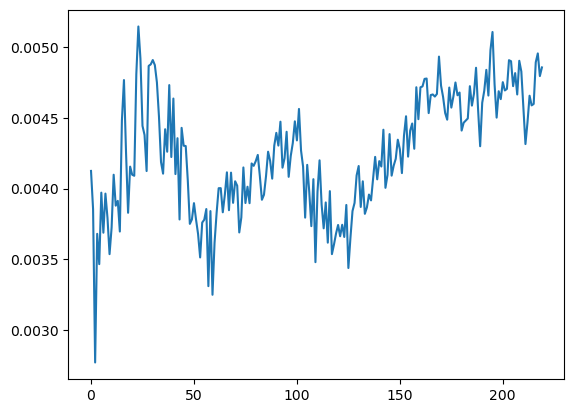

In [79]:
plt.plot(p_future)

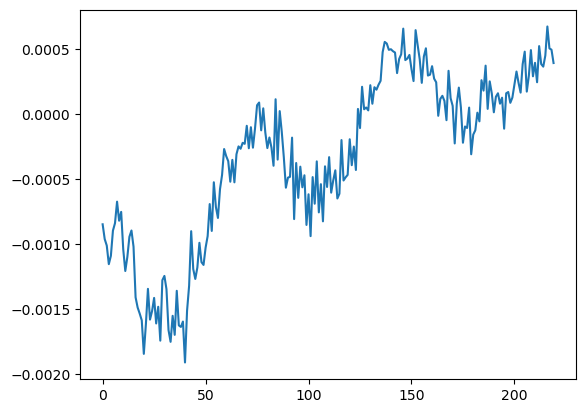

In [80]:
plt.plot(p_future_derivation)

# Add the predictions to the tick table to visualize them

In [81]:
# Load the table
tickDF = pd.read_csv(FILE_FOR_VISUALIZATION)
tickDF

startsAt   open   high    low  close  volume  quoteVolume
0    1609459200  35.33  35.33  35.33  35.33     0.0          0.0
1    1609545600  35.33  35.33  35.33  35.33     0.0          0.0
2    1609632000  35.33  35.33  35.33  35.33     0.0          0.0
3    1609718400  35.09  35.09  35.09  35.09     0.0          0.0
4    1609804800  35.18  35.18  35.18  35.18     0.0          0.0
..          ...    ...    ...    ...    ...     ...          ...
360  1640563200  43.35  43.35  43.35  43.35     0.0          0.0
361  1640649600  43.60  43.60  43.60  43.60     0.0          0.0
362  1640736000  43.65  43.65  43.65  43.65     0.0          0.0
363  1640822400  43.65  43.65  43.65  43.65     0.0          0.0
364  1640908800  43.65  43.65  43.65  43.65     0.0          0.0

[365 rows x 7 columns]

In [82]:
# # Because the data is cropped in the batching process (Todo: fix this) and can also not be used fully due to the X-Block and y-data creation,
# # the loaded DF has a bigger shape
# tickDF.shape[0] - p.shape[0]

145

In [83]:
# # Crop the DF to meet the prediction
# tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
# tickDFcropped

startsAt   open   high    low  close  volume  quoteVolume
145  1621987200  40.76  40.76  40.76  40.76     0.0          0.0
146  1622073600  41.04  41.04  41.04  41.04     0.0          0.0
147  1622160000  41.24  41.24  41.24  41.24     0.0          0.0
148  1622246400  41.24  41.24  41.24  41.24     0.0          0.0
149  1622332800  41.24  41.24  41.24  41.24     0.0          0.0
..          ...    ...    ...    ...    ...     ...          ...
360  1640563200  43.35  43.35  43.35  43.35     0.0          0.0
361  1640649600  43.60  43.60  43.60  43.60     0.0          0.0
362  1640736000  43.65  43.65  43.65  43.65     0.0          0.0
363  1640822400  43.65  43.65  43.65  43.65     0.0          0.0
364  1640908800  43.65  43.65  43.65  43.65     0.0          0.0

[220 rows x 7 columns]

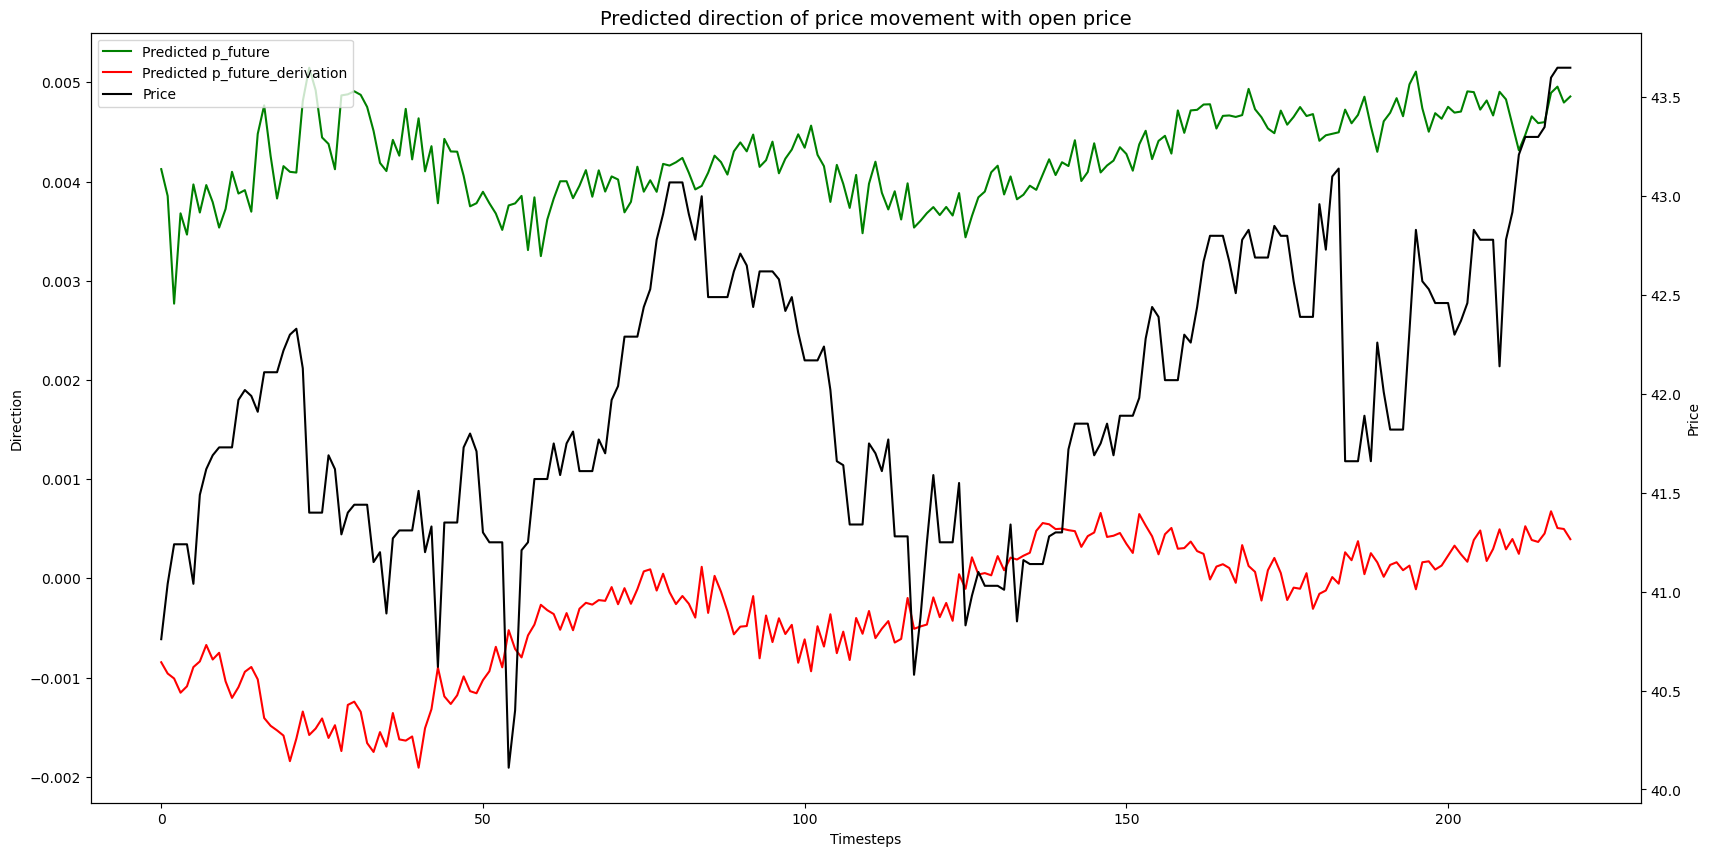

In [84]:
# # Plot the prediction again, now over the open price
# chart_name="Predicted direction of price movement with open price"
# fig, ax1 = plt.subplots(figsize=(20,10))
# ax1.set_title(chart_name, fontsize=14)

# _ = ax1.plot(p_future, color="green", label="Predicted p_future")
# _ = ax1.plot(p_future_derivation, color="red", label="Predicted p_future_derivation")
# # _ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

# ax2 = ax1.twinx()

# ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

# ax1.set_xlabel("Timesteps")
# ax1.set_ylabel("Direction")
# ax2.set_ylabel("Price")

# # Show a legend
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# # Save the figure
# # fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# # plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [ ]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

In [ ]:
# /content/bigdata/chk/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_end/model.h5

# Add predictions to tick tables
# Predict the test and eval set
The future information for these sets is predicted using the trained model, additionally the past gain info is acquired using the `FileListToDataStream` generator. It is then stored together with the tick information as .csv files, which then can be used to develop a trading strategy.

```
Todo: Add link to finder notebooks
```

In [ ]:
stop

In [93]:
BATCH_SIZE = 366

In [94]:
# Create a generator for prediction
# Todo: Use same method as for training to avoid different settings

def pythonGeneratorPrediction(fileList):
    assert 1 == len(fileList) # This gen shall only be used for one file
    
    # Find a batch size which minimizes the non-predicted timestaps (e.g. an optimal divider)
    tickDF = pd.read_csv(fileList[0])
    timesteps = tickDF.shape[0]
    
    # Compensate the timesteps by the X_BLOCK_LENGHT (as the first block ends at index X_BLOCK_LENGHT)
    timesteps -= X_BLOCK_LENGHT
    
    residue_list = []
    min_residue = timesteps + 1

    for batch_size in range(BATCH_SIZE, 31, -1):
        residue = timesteps % batch_size

        # If the residue is bigger than the min one, this batch size can be ignored
        if residue <= min_residue:    
            residue_list.append((batch_size, residue))

        min_residue = np.min([min_residue, residue])

    # Use only batch sizes with the minimum residue
    residue_list = list(filter(lambda x: x[1] == min_residue, residue_list))

    # Sort the residue list by the batch size
    residue_list = sorted(residue_list, key=lambda tup: tup[1])

    logging.info(f"Picked a batch size of {residue_list[0][0]} with a residue of {residue_list[0][1]}.")

    batch_size = residue_list[0][0]
    
    #batch_size=1

    # Initialize the FileListToDataStream generator
    dataStream = DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                     batch_size = batch_size,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT,
                                                     shuffle=False,
                                                     parallel_generators = 1,
                                                     random_seed = RANDOM_SEED,
                                                     **DATA_STREAM_PARAMETERS
                                                    )

    # This while has to integrated into the FileListToDataStream method
    while True:  
        try:
            ne = next(dataStream)
            _X = ne['X']
            _y = ne['y']

            # Limit the y signal to avoid excess
            # _y /= 10.0
            # _y = np.clip(_y, -10.0, 10.0)
            _y = np.zeros(_y.shape)

            yield (_X, _y)
        except StopIteration as si:
            logging.warning("StopIteration in pythonGenerator")
            logging.warning(si)
            return

In [95]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [96]:
# Get the model name and the checkpoint name
model_name, checkpoint_name = tuple(MODEL_PATH.split(os.sep)[-3:-1])
print(f"model_name: '{model_name}'")
print(f"checkpoint_name: '{checkpoint_name}'")

model_name: 'FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB'
checkpoint_name: 'cp_daily_valid_06_end'


In [97]:
# Replace the latest element in the DATASET_PATH with "predicted"
prediction_save_path = DATASET_PATH.split(os.sep)[:-1]
prediction_save_path += ["predicted"]

# Preserve the root symbol
if prediction_save_path[0] == "":
    prediction_save_path[0] = os.sep

# Add the model info to the path
prediction_save_path += [model_name, checkpoint_name]
    
prediction_save_path

['/',
 'content',
 'dataset',
 'ETF',
 'tickdata',
 'ticks',
 'predicted',
 'FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB',
 'cp_daily_valid_06_end']

In [98]:
# Check each path element and create it if necessary
for i in range(1, len(prediction_save_path)):
    partial_path_string = os.path.join(*prediction_save_path[:i+1])

    if not os.path.exists(partial_path_string):
        os.mkdir(partial_path_string)
        
# Create the test and eval save folders
PREDICTION_SAVE_PATH_TEST = os.path.join(*(prediction_save_path + ["test"]))
if not os.path.exists(PREDICTION_SAVE_PATH_TEST):
    os.mkdir(PREDICTION_SAVE_PATH_TEST)

PREDICTION_SAVE_PATH_EVAL = os.path.join(*(prediction_save_path + ["eval"]))
if not os.path.exists(PREDICTION_SAVE_PATH_EVAL):
    os.mkdir(PREDICTION_SAVE_PATH_EVAL)

print(f"PREDICTION_SAVE_PATH_TEST: '{PREDICTION_SAVE_PATH_TEST}'")
print(f"PREDICTION_SAVE_PATH_EVAL: '{PREDICTION_SAVE_PATH_EVAL}'")

PREDICTION_SAVE_PATH_TEST: '/content/dataset/ETF/tickdata/ticks/predicted/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_end/test'
PREDICTION_SAVE_PATH_EVAL: '/content/dataset/ETF/tickdata/ticks/predicted/FPNWithAttentionBiggerTimebased_3_FutureOnly_60days_GPU_128LB/cp_daily_valid_06_end/eval'


In [99]:
fileList = TEST_FILES
PREDICTED_SAVE_PATH = PREDICTION_SAVE_PATH_TEST

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")
        
        p = model.predict(pythonGeneratorPrediction(fileList=[filename]), verbose = 0)        

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]

        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDF.set_index("startsAt", inplace=True)
        
        logging.info(f"tickDF.shape: {tickDF.shape}, p.shape: {p.shape}, len difference: {tickDF.shape[0] - p.shape[0]}")
        
        # Important: If you want to create one X-Block, e.g. for predicting on live data, you have to feed a `tick_and_indicator_DF` with one more row,
        # as the latest row is ignored. This is due to the circumstance that in a live environment the latest tick would change during the day, and therefore
        # cannot be used. --> If you want a 128-timesteps X-Block, you have to feed 129 `tick_and_indicator_DF`-rows.

        # For a X_BLOCK_LEN of 128, tickDF.iloc[:129] will be the first row that has a prediced value

        startIndex = tickDF.index[X_BLOCK_LENGHT]
        endIndex = tickDF.index[X_BLOCK_LENGHT+p.shape[0]-1]
        
        tickDF.loc[startIndex:endIndex, "p_future_gain"] = p[:,0]
        tickDF.loc[startIndex:endIndex, "p_future_gain_derivation"] = p[:,1]       
        
        # Save the DF
        tickDF.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.\n")
        
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                                                                                                                                                                                | 0/1002 [00:00<?, ?it/s]INFO:root:
File name: '/content/dataset/ETF/tickdata/ticks/test/DE0002635265.csv' for index 0
INFO:root:Picked a batch size of 237 with a residue of 0.
INFO:root:File 'DE0002635265.csv' loaded, 0 left
INFO:root:tickDF.shape: (365, 6), p.shape: (237, 2), len difference: 128
INFO:root:Saved the predicted data.

  0%|▏                                                                                                                                                                                                       | 1/1002 [00:01<26:39,  1.60s/it]INFO:root:
File name: '/content/dataset/ETF/tickdata/ticks/test/DE0002635273.csv' for index 1
INFO:root:Picked a batch size of 237 with a residue of 0.
INFO:root:File 'DE0002635273.csv' loaded, 0 left
INFO:root:ti

In [100]:
fileList = EVAL_FILES
PREDICTED_SAVE_PATH = PREDICTION_SAVE_PATH_EVAL

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")
        
        p = model.predict(pythonGeneratorPrediction(fileList=[filename]), verbose = 0)        

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]        

        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDF.set_index("startsAt", inplace=True)
        
        logging.info(f"tickDF.shape: {tickDF.shape}, p.shape: {p.shape}, len difference: {tickDF.shape[0] - p.shape[0]}")
        
        # Important: If you want to create one X-Block, e.g. for predicting on live data, you have to feed a `tick_and_indicator_DF` with one more row,
        # as the latest row is ignored. This is due to the circumstance that in a live environment the latest tick would change during the day, and therefore
        # cannot be used. --> If you want a 128-timesteps X-Block, you have to feed 129 `tick_and_indicator_DF`-rows.

        # For a X_BLOCK_LEN of 128, tickDF.iloc[:129] will be the first row that has a prediced value

        startIndex = tickDF.index[X_BLOCK_LENGHT]
        endIndex = tickDF.index[X_BLOCK_LENGHT+p.shape[0]-1]
        
        tickDF.loc[startIndex:endIndex, "p_future_gain"] = p[:,0]
        tickDF.loc[startIndex:endIndex, "p_future_gain_derivation"] = p[:,1]       
        
        # Save the DF
        tickDF.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.\n")
        
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                                                                                                                                                                                | 0/1063 [00:00<?, ?it/s]INFO:root:
File name: '/content/dataset/ETF/tickdata/ticks/eval/DE0002635265.csv' for index 0
INFO:root:Picked a batch size of 292 with a residue of 0.
INFO:root:File 'DE0002635265.csv' loaded, 0 left
INFO:root:tickDF.shape: (420, 6), p.shape: (292, 2), len difference: 128
INFO:root:Saved the predicted data.

  0%|▏                                                                                                                                                                                                       | 1/1063 [00:01<18:31,  1.05s/it]INFO:root:
File name: '/content/dataset/ETF/tickdata/ticks/eval/DE0002635273.csv' for index 1
INFO:root:Picked a batch size of 292 with a residue of 0.
INFO:root:File 'DE0002635273.csv' loaded, 0 left
INFO:root:ti